In [1]:
# Parameters
config = {
    "notebook": "notebooks/tfi_lgbm_optuna.ipynb",
    "data_path": "C:/Users/nico_/Desktop/ITBA/TFI/github/df_procesado/trollers_fe_recortado_v2.csv",
    "output_label": "trollers_optuna",
}


In [2]:
# check if config exists
try:
    config
except NameError:
    config_exists = False
else:
    config_exists = True

# make config if it does not exist already (e.g. passed in by papermill)
if not(config_exists):
    # set up some config for the experiment run
    config = {
        "data_path" : "C:/Users/nico_/Desktop/ITBA/TFI/github/df_procesado/trollers_fe_recortado_v2.csv",
    }
print(config)

{'notebook': 'notebooks/tfi_lgbm_optuna.ipynb', 'data_path': 'C:/Users/nico_/Desktop/ITBA/TFI/github/df_procesado/trollers_fe_recortado_v2.csv', 'output_label': 'trollers_optuna'}


In [3]:
# Importing core libraries
#https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5
#https://www.kaggle.com/code/lucamassaron/tutorial-bayesian-optimization-with-lightgbm/notebook
import numpy as np
import pandas as pd
from time import time
import pprint
import joblib
from functools import partial

# Suppressing warnings because of skopt verbosity
import warnings
warnings.filterwarnings("ignore")

# Classifiers
import lightgbm as lgb

# Model selection
from sklearn.model_selection import KFold, StratifiedKFold

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

# Skopt functions
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer

# Data processing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

Cargamos el dataset.

In [4]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

df = pd.read_csv(config['data_path'], header="infer", sep=",",error_bad_lines=False, engine ='python')

In [5]:
df = df.drop(['mmsi', 'source','timestamp','source','datetime','distance_from_shore','distance_from_port'], axis = 1)
lagged_columns = ['A0', 'J0', 'C0','speed_lag_1', 'speed_lag_2',
       'speed_lag_3', 'speed_lag_4', 'speed_lag_5', 'speed_lag_6',
       'course_lag_1', 'course_lag_2', 'course_lag_3', 'course_lag_4',
       'course_lag_5', 'course_lag_6', 'S0_lag_1', 'S0_lag_2', 'S0_lag_3',
       'S0_lag_4', 'S0_lag_5', 'S0_lag_6', 'A0_lag_1', 'A0_lag_2', 'A0_lag_3',
       'A0_lag_4', 'A0_lag_5', 'A0_lag_6', 'J0_lag_1', 'J0_lag_2', 'J0_lag_3',
       'J0_lag_4', 'J0_lag_5', 'J0_lag_6', 'C0_lag_1', 'C0_lag_2', 'C0_lag_3',
       'C0_lag_4', 'C0_lag_5', 'C0_lag_6']
for column in lagged_columns:
    df[column]=df[column].abs()

df['S0']=df['S0'].abs()
df['A0']=df['A0'].abs()
df['J0']=df['J0'].abs()
df['C0']=df['C0'].abs()
df['Delta_S']=df['Delta_S'].abs()
df['Delta_C']=df['Delta_C'].abs()

print(df)


      speed    course       lat       lon is_fishing  sun_state  distance  \
0       5.6  0.462500  0.811291 -2.171164         NO          2  0.572268   
1       0.8  0.574722  0.820065 -2.175846         NO          2  0.150962   
2       0.8  0.518056  0.819476 -2.176982         NO          2  0.144827   
3       1.1  0.816944  1.010962  0.164982         NO          1  0.075594   
4       7.6  0.084722  0.774409 -2.168367         NO          2  1.548400   
...     ...       ...       ...       ...        ...        ...       ...   
2567    1.9  0.947222  0.818764 -2.176987         SI          2  0.069889   
2568    1.8  0.993611  0.818307 -2.176955         SI          1  0.512494   
2569    4.7  0.004167  0.826415 -2.177562         SI          2  0.657418   
2570    7.5  0.941944  0.828184 -2.178503         SI          2  0.202381   
2571    1.9  0.122500  0.824733 -2.178213         SI          1  0.272262   

      timediff        S0            A0  ...      J0_lag_3      J0_lag_4  \


Generamos los vectores de train y test.

In [6]:
#Generamos train y test.

#Si la longitud del dataset es mayor a 10000, partiremos agrupado por "is_fishing" ya que nos puede tocar un conjunto con is_fishing='SI' vacio.
#if len(dataset)>10000:
    #df = df.sample(n=10000, random_state=1)
#    df = df.groupby("is_fishing").sample(n=7500, random_state=1,replace=True)
#    df = df.drop_duplicates()

X = df.drop('is_fishing',axis=1)
y = df['is_fishing']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=50)
print(len(df[df['is_fishing']=='SI']))
print(len(df[df['is_fishing']=='NO']))



1286
1286


Funcion para evaluar los modelos.

In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from IPython.display import display, Markdown, Latex
import matplotlib.pyplot as plt
import tabulate
from sklearn.metrics import confusion_matrix, accuracy_score


def evaluate_model(title,y_test, y_pred):

    cm = confusion_matrix(y_test, y_pred)
    display(Markdown(title))
    cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['NO', 'SI'])
    cmd_obj.plot()
    cmd_obj.ax_.set(
                    title='Matriz de confusión.', 
                    xlabel='Predict Values', 
                    ylabel='Actual Values')
    plt.show()
    _precision_score = precision_score(y_test, y_pred,pos_label='SI')
    _recall_score = recall_score(y_test, y_pred, pos_label='SI')
    _accuracy_score = accuracy_score(y_test, y_pred)
    _f1_score = f1_score(y_test, y_pred, pos_label='SI')

    data = [["Precision","Recall","Accuracy","F1"],
            ["%.2f" % _precision_score, "%.2f" % _recall_score, "%.2f" % _accuracy_score, "%.2f" % _f1_score ]]
    table = tabulate.tabulate(data, tablefmt='html')
    display(table)
    return _precision_score, _recall_score, _accuracy_score, _f1_score


Fitting 3 folds for each of 1440 candidates, totalling 4320 fits


Train Accuracy : 0.976
Test Accuracy : 0.870
Best Score Through Grid Search : 0.861
Best Parameters :  {'max_depth': 12, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 0, 'splitter': 'best'}
Best Parameters :  {'max_depth': 12, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 0, 'splitter': 'best'}


Arboles de decision optimizado

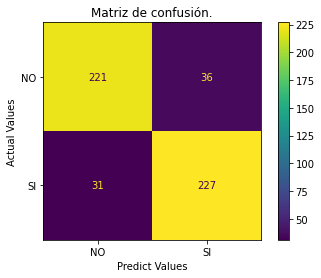

'<table>\n<tbody>\n<tr><td>Precision</td><td>Recall</td><td>Accuracy</td><td>F1  </td></tr>\n<tr><td>0.86     </td><td>0.88  </td><td>0.87    </td><td>0.87</td></tr>\n</tbody>\n</table>'

In [8]:
from sklearn.tree import ExtraTreeClassifier
from sklearn.tree import DecisionTreeRegressor
#extra_tree_classifier = ExtraTreeClassifier(random_state=1)
#extra_tree_classifier.fit(X_train, y_train)

from sklearn.model_selection import GridSearchCV

parameters={"splitter":["best","random"],
            "max_depth" : [11,12,13,14,15,16],
           "min_samples_leaf":[1,2,3,4,5],
           "min_weight_fraction_leaf":[0, 0.1,0.2],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10] }

grid = GridSearchCV(DecisionTreeClassifier(random_state=1), cv=3, n_jobs=-1, verbose=3,
                    param_grid =parameters
                    )

grid.fit(X_train, y_train)

print('Train Accuracy : %.3f'%grid.best_estimator_.score(X_train, y_train))
print('Test Accuracy : %.3f'%grid.best_estimator_.score(X_test, y_test))
print('Best Score Through Grid Search : %.3f'%grid.best_score_)
print('Best Parameters : ',grid.best_params_)

dt = DecisionTreeClassifier(max_depth=grid.best_params_['max_depth'], 
                            max_features=grid.best_params_['max_features'],
                            max_leaf_nodes=grid.best_params_['max_leaf_nodes'],
                            min_samples_leaf=grid.best_params_['min_samples_leaf'],
                            min_weight_fraction_leaf=grid.best_params_['min_weight_fraction_leaf'],
                            splitter=grid.best_params_['splitter']
)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
print('Best Parameters : ',grid.best_params_)
dt_precision_score, dt_recall_score, dt_accuracy_score, dt_f1_score = evaluate_model('Arboles de decision optimizado',y_test, y_pred)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


Train Accuracy : 1.000
Test Accuracy : 0.909
Best Score Through Grid Search : 0.907
Best Parameters :  {'bootstrap': False, 'max_depth': 14, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


Random forest optimizado

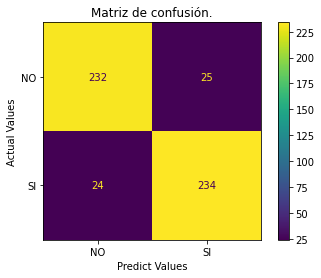

'<table>\n<tbody>\n<tr><td>Precision</td><td>Recall</td><td>Accuracy</td><td>F1  </td></tr>\n<tr><td>0.90     </td><td>0.91  </td><td>0.90    </td><td>0.91</td></tr>\n</tbody>\n</table>'

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True, False],
    'max_depth': [12,13,14,15],
    'max_features': ["auto", "sqrt", "log2"],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [2, 5 , 10],
    'n_estimators': [100, 200]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid.fit(X_train, y_train)

print('Train Accuracy : %.3f'%grid.best_estimator_.score(X_train, y_train))
print('Test Accuracy : %.3f'%grid.best_estimator_.score(X_test, y_test))
print('Best Score Through Grid Search : %.3f'%grid.best_score_)
print('Best Parameters : ',grid.best_params_)

dt = RandomForestClassifier(bootstrap=grid.best_params_['bootstrap'], 
                            max_depth=grid.best_params_['max_depth'],
                            max_features=grid.best_params_['max_features'],
                            min_samples_leaf=grid.best_params_['min_samples_leaf'],
                            min_samples_split=grid.best_params_['min_samples_split'],
                            n_estimators=grid.best_params_['n_estimators']
)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
rf_precision_score, rf_recall_score, rf_accuracy_score, rf_f1_score = evaluate_model('Random forest optimizado', y_test, y_pred)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Train Accuracy : 0.676
Test Accuracy : 0.584
Best Score Through Grid Search : 0.614
Best Parameters :  {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}


rbf

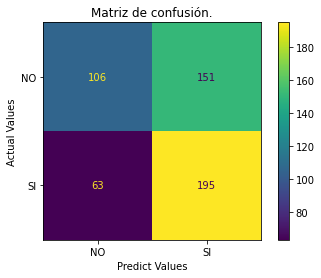

'<table>\n<tbody>\n<tr><td>Precision</td><td>Recall</td><td>Accuracy</td><td>F1  </td></tr>\n<tr><td>0.56     </td><td>0.76  </td><td>0.58    </td><td>0.65</td></tr>\n</tbody>\n</table>'

Fitting 5 folds for each of 120 candidates, totalling 600 fits


Train Accuracy : 0.561
Test Accuracy : 0.546
Best Score Through Grid Search : 0.562
Best Parameters :  {'C': 10, 'coef0': 0.1, 'gamma': 1e-06, 'kernel': 'sigmoid'}


sigmoid

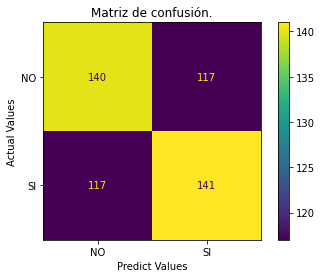

'<table>\n<tbody>\n<tr><td>Precision</td><td>Recall</td><td>Accuracy</td><td>F1  </td></tr>\n<tr><td>0.55     </td><td>0.55  </td><td>0.55    </td><td>0.55</td></tr>\n</tbody>\n</table>'

In [10]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

#parameters = [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],'C': [0.001, 0.10, 0.1, 10 ]},
#              {'kernel': ['sigmoid'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],'C': [0.001, 0.10, 0.1, 10], 'coef0 ':[0,0.1,1]},
#              {'kernel': ['linear'], 'C': [0.001, 0.10, 0.1, 1]}     
#]

parameters = [{'kernel': ['rbf'], 'gamma': [1e-2,1e-3,1e-4,1e-5,1e-6],'C': [0.001,0.01,0.1,1,10,100]},
              {'kernel': ['sigmoid'], 'gamma': [1e-2,1e-3,1e-4,1e-5,1e-6],'C': [0.001,0.01,0.1,1,10,100],'coef0' : [0.01,0.1,1,10]},
              #{'kernel': ['linear'], 'C': [1,10,100]}
              ]

svm_precision_score_rbf=svm_recall_score_rbf=svm_accuracy_score_rbf=svm_f1_score_rbf=0
svm_precision_score_sigmoid=svm_recall_score_sigmoid=svm_accuracy_score_sigmoid=svm_f1_score_sigmoid=0
svm_precision_score_linear=svm_recall_score_linear=svm_accuracy_score_linear=svm_f1_score_linear=0


for parameter in parameters:
    param_grid = parameter
    grid = GridSearchCV(SVC(), param_grid, n_jobs = -1, verbose = 3)
    grid.fit(X_train, y_train)
    kernel_str = parameter['kernel'][0]
    y_pred = grid.predict(X_test)
    dt = grid
    
    print('Train Accuracy : %.3f'%grid.best_estimator_.score(X_train, y_train))
    print('Test Accuracy : %.3f'%grid.best_estimator_.score(X_test, y_test))
    print('Best Score Through Grid Search : %.3f'%grid.best_score_)
    print('Best Parameters : ',grid.best_params_)

    if parameter['kernel'][0] == 'rbf':
        svm_precision_score_rbf, svm_recall_score_rbf, svm_accuracy_score_rbf, svm_f1_score_rbf = evaluate_model(kernel_str, y_test, y_pred)
    if parameter['kernel'][0] == 'sigmoid':
        svm_precision_score_sigmoid, svm_recall_score_sigmoid, svm_accuracy_score_sigmoid, svm_f1_score_sigmoid = evaluate_model(kernel_str, y_test, y_pred)
    if parameter['kernel'][0] == 'linear':
        svm_precision_score_linear, svm_recall_score_linear, svm_accuracy_score_linear, svm_f1_score_linear = evaluate_model(kernel_str, y_test, y_pred)

In [11]:
import optuna  # pip install optuna
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

from optuna.integration import LightGBMPruningCallback


def objective(trial, X, y):
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 8, 1023, step=10),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 10),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 100),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = lgb.LGBMClassifier(objective="binary", **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="binary_logloss",
            #eval_metric="auc",
            early_stopping_rounds=100,
            callbacks=[
                #LightGBMPruningCallback(trial, "auc")
                LightGBMPruningCallback(trial, "binary_logloss")
            ],  # Add a pruning callback
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)


In [12]:
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")

#AUC -> maximixe
#study = optuna.create_study(direction="maximize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=2000)


[I 2022-06-19 15:49:08,384] A new study created in memory with name: LGBM Classifier


[I 2022-06-19 15:49:08,597] Trial 0 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1907433597836792, 'num_leaves': 818, 'max_depth': 11, 'min_data_in_leaf': 6900, 'lambda_l1': 0.8620765053498258, 'lambda_l2': 85.87023036128461, 'min_gain_to_split': 9.650195582242391, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 0 with value: 0.6931476054155973.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6900
[LightGBM] [Warning] min_gain_to_split is set=9.650195582242391, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.650195582242391
[LightGBM] [Warning] lambda_l1 is set=0.8620765053498258, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8620765053498258
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=85.87023036128461, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85.87023036128461
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=7.080630361028054, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.080630361028054
[LightGBM] [Warning] lambda_l1 is set=2.430483741256737, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.430483741256737
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=73.41665681537862, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.41665681537862
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytr

[I 2022-06-19 15:49:08,945] Trial 1 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12830364256983515, 'num_leaves': 988, 'max_depth': 8, 'min_data_in_leaf': 800, 'lambda_l1': 2.430483741256737, 'lambda_l2': 73.41665681537862, 'min_gain_to_split': 7.080630361028054, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 0 with value: 0.6931476054155973.


[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=7.080630361028054, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.080630361028054
[LightGBM] [Warning] lambda_l1 is set=2.430483741256737, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.430483741256737
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=73.41665681537862, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.41665681537862
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be i

[I 2022-06-19 15:49:09,175] Trial 2 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23032385197861535, 'num_leaves': 408, 'max_depth': 5, 'min_data_in_leaf': 6400, 'lambda_l1': 4.942632691957193, 'lambda_l2': 22.22173404172195, 'min_gain_to_split': 12.493268483466954, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 0 with value: 0.6931476054155973.


[LightGBM] [Warning] min_data_in_leaf is set=6400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6400
[LightGBM] [Warning] min_gain_to_split is set=12.493268483466954, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.493268483466954
[LightGBM] [Warning] lambda_l1 is set=4.942632691957193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.942632691957193
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=22.22173404172195, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.22173404172195
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6400, min_child_samples=20 will be ignored. Current value: min_

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.350418689863834, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.350418689863834
[LightGBM] [Warning] lambda_l1 is set=2.2648515367404096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2648515367404096
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=65.49341388979612, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.49341388979612
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_dat

[I 2022-06-19 15:49:09,626] Trial 3 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23996077498058477, 'num_leaves': 548, 'max_depth': 11, 'min_data_in_leaf': 400, 'lambda_l1': 2.2648515367404096, 'lambda_l2': 65.49341388979612, 'min_gain_to_split': 7.350418689863834, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 0 with value: 0.6931476054155973.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.350418689863834, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.350418689863834
[LightGBM] [Warning] lambda_l1 is set=2.2648515367404096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2648515367404096
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=65.49341388979612, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.49341388979612
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-19 15:49:09,846] Trial 4 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13806870188228232, 'num_leaves': 448, 'max_depth': 8, 'min_data_in_leaf': 5000, 'lambda_l1': 1.3102208439219043, 'lambda_l2': 25.584688823841105, 'min_gain_to_split': 4.457572821880842, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 0 with value: 0.6931476054155973.


[LightGBM] [Warning] min_data_in_leaf is set=5000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5000
[LightGBM] [Warning] min_gain_to_split is set=4.457572821880842, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.457572821880842
[LightGBM] [Warning] lambda_l1 is set=1.3102208439219043, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3102208439219043
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=25.584688823841105, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.584688823841105
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=5000, min_child_samples=20 will be ignored. Current value: mi

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=9300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9300
[LightGBM] [Warning] min_gain_to_split is set=10.404582465732414, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.404582465732414
[LightGBM] [Warning] lambda_l1 is set=0.3519470757340326, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3519470757340326
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=92.90042612377495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=92.90042612377495
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-19 15:49:10,112] Trial 5 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24528134278473668, 'num_leaves': 848, 'max_depth': 9, 'min_data_in_leaf': 9300, 'lambda_l1': 0.3519470757340326, 'lambda_l2': 92.90042612377495, 'min_gain_to_split': 10.404582465732414, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 0 with value: 0.6931476054155973.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=9300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9300
[LightGBM] [Warning] min_gain_to_split is set=10.404582465732414, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.404582465732414
[LightGBM] [Warning] lambda_l1 is set=0.3519470757340326, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3519470757340326
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=92.90042612377495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=92.90042612377495
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Cur

[I 2022-06-19 15:49:10,375] Trial 6 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.029248789368436716, 'num_leaves': 168, 'max_depth': 9, 'min_data_in_leaf': 9800, 'lambda_l1': 5.0625549750927625, 'lambda_l2': 88.16909157736983, 'min_gain_to_split': 5.779659461522032, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 0 with value: 0.6931476054155973.


[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] min_gain_to_split is set=5.779659461522032, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.779659461522032
[LightGBM] [Warning] lambda_l1 is set=5.0625549750927625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0625549750927625
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=88.16909157736983, reg_lambda=0.0 will be ignored. Current value: lambda_l2=88.16909157736983
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will b

[I 2022-06-19 15:49:10,647] Trial 7 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06013657212162364, 'num_leaves': 928, 'max_depth': 11, 'min_data_in_leaf': 6700, 'lambda_l1': 6.052632987263081, 'lambda_l2': 27.18817933653269, 'min_gain_to_split': 14.130508388498805, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 0 with value: 0.6931476054155973.


[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=14.130508388498805, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.130508388498805
[LightGBM] [Warning] lambda_l1 is set=6.052632987263081, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.052632987263081
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=27.18817933653269, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.18817933653269
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_

[LightGBM] [Warning] min_gain_to_split is set=14.287451505779519, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.287451505779519
[LightGBM] [Warning] lambda_l1 is set=9.43827813893607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.43827813893607
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=38.13723455662436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.13723455662436
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=14.287451505779519, min_split_gain=0.0 will be ignored. Current 

[I 2022-06-19 15:49:10,940] Trial 8 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09867392554439806, 'num_leaves': 88, 'max_depth': 10, 'min_data_in_leaf': 1600, 'lambda_l1': 9.43827813893607, 'lambda_l2': 38.13723455662436, 'min_gain_to_split': 14.287451505779519, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 0 with value: 0.6931476054155973.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=11.916737444562413, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.916737444562413
[LightGBM] [Warning] lambda_l1 is set=2.9459678901285926, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9459678901285926
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=5.06642914446751, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.06642914446751
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-19 15:49:11,221] Trial 9 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.021846302278153235, 'num_leaves': 508, 'max_depth': 10, 'min_data_in_leaf': 2900, 'lambda_l1': 2.9459678901285926, 'lambda_l2': 5.06642914446751, 'min_gain_to_split': 11.916737444562413, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 0 with value: 0.6931476054155973.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=11.916737444562413, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.916737444562413
[LightGBM] [Warning] lambda_l1 is set=2.9459678901285926, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9459678901285926
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=5.06642914446751, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.06642914446751
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-19 15:49:11,556] Trial 10 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18619003274720503, 'num_leaves': 748, 'max_depth': 5, 'min_data_in_leaf': 7900, 'lambda_l1': 8.15336098043273, 'lambda_l2': 57.18978684562714, 'min_gain_to_split': 0.05935705658391388, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 0 with value: 0.6931476054155973.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=7900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7900
[LightGBM] [Warning] min_gain_to_split is set=0.05935705658391388, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05935705658391388
[LightGBM] [Warning] lambda_l1 is set=8.15336098043273, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.15336098043273
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=57.18978684562714, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.18978684562714
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will 

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=4600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4600
[LightGBM] [Warning] min_gain_to_split is set=9.233047580968648, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.233047580968648
[LightGBM] [Warning] lambda_l1 is set=3.2147604433692036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2147604433692036
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=73.79004617469081, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.79004617469081
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be

[I 2022-06-19 15:49:11,887] Trial 11 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1660373610362868, 'num_leaves': 1008, 'max_depth': 3, 'min_data_in_leaf': 4600, 'lambda_l1': 3.2147604433692036, 'lambda_l2': 73.79004617469081, 'min_gain_to_split': 9.233047580968648, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 0 with value: 0.6931476054155973.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=4600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4600
[LightGBM] [Warning] min_gain_to_split is set=9.233047580968648, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.233047580968648
[LightGBM] [Warning] lambda_l1 is set=3.2147604433692036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2147604433692036
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=73.79004617469081, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.79004617469081
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_by

[I 2022-06-19 15:49:12,215] Trial 12 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29149667747870595, 'num_leaves': 738, 'max_depth': 12, 'min_data_in_leaf': 3500, 'lambda_l1': 0.0460382291528062, 'lambda_l2': 77.77741881256215, 'min_gain_to_split': 3.4013268522730273, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 0 with value: 0.6931476054155973.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=3500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3500
[LightGBM] [Warning] min_gain_to_split is set=3.4013268522730273, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.4013268522730273
[LightGBM] [Warning] lambda_l1 is set=0.0460382291528062, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0460382291528062
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=77.77741881256215, reg_lambda=0.0 will be ignored. Current value: lambda_l2=77.77741881256215
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsampl

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=6800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6800
[LightGBM] [Warning] min_gain_to_split is set=8.207827230525975, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.207827230525975
[LightGBM] [Warning] lambda_l1 is set=1.8901271988494908, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8901271988494908
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=96.54987645688544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=96.54987645688544
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be

[I 2022-06-19 15:49:12,551] Trial 13 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10963561141895922, 'num_leaves': 688, 'max_depth': 6, 'min_data_in_leaf': 6800, 'lambda_l1': 1.8901271988494908, 'lambda_l2': 96.54987645688544, 'min_gain_to_split': 8.207827230525975, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 0 with value: 0.6931476054155973.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=6800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6800
[LightGBM] [Warning] min_gain_to_split is set=8.207827230525975, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.207827230525975
[LightGBM] [Warning] lambda_l1 is set=1.8901271988494908, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8901271988494908
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=96.54987645688544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=96.54987645688544
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_byt

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.606597766625587, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.606597766625587
[LightGBM] [Warning] lambda_l1 is set=3.771737381943012, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.771737381943012
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=50.55616878498033, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.55616878498033
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.606597766625587, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.606597766625587
[LightGBM] [Warning] lambda_l1 is set=3.771737381943012, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.771737381943012
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=50.55616878498033, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.55616878498033
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:49:13,661] Trial 14 finished with value: 0.45462263506905165 and parameters: {'n_estimators': 10000, 'learning_rate': 0.19268469989554993, 'num_leaves': 1008, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 3.771737381943012, 'lambda_l2': 50.55616878498033, 'min_gain_to_split': 6.606597766625587, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 14 with value: 0.45462263506905165.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.606597766625587, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.606597766625587
[LightGBM] [Warning] lambda_l1 is set=3.771737381943012, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.771737381943012
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=50.55616878498033, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.55616878498033
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] min_gain_to_split is set=2.2841004830647647, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2841004830647647
[LightGBM] [Warning] lambda_l1 is set=4.084029053993684, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.084029053993684
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=49.49107238126158, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.49107238126158
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_byt

[I 2022-06-19 15:49:13,990] Trial 15 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18797567942354074, 'num_leaves': 788, 'max_depth': 6, 'min_data_in_leaf': 2700, 'lambda_l1': 4.084029053993684, 'lambda_l2': 49.49107238126158, 'min_gain_to_split': 2.2841004830647647, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 14 with value: 0.45462263506905165.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] min_gain_to_split is set=2.2841004830647647, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2841004830647647
[LightGBM] [Warning] lambda_l1 is set=4.084029053993684, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.084029053993684
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=49.49107238126158, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.49107238126158
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be

[I 2022-06-19 15:49:14,326] Trial 16 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.20325770112103572, 'num_leaves': 628, 'max_depth': 7, 'min_data_in_leaf': 8100, 'lambda_l1': 6.912874384674102, 'lambda_l2': 48.40729127545606, 'min_gain_to_split': 9.964717233828914, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 14 with value: 0.45462263506905165.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8100
[LightGBM] [Warning] min_gain_to_split is set=9.964717233828914, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.964717233828914
[LightGBM] [Warning] lambda_l1 is set=6.912874384674102, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.912874384674102
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=48.40729127545606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.40729127545606
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200
[LightGBM] [Warning] min_gain_to_split is set=5.555285851335082, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.555285851335082
[LightGBM] [Warning] lambda_l1 is set=1.103610225899601, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.103610225899601
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.8212274484046205, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.8212274484046205
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-19 15:49:14,656] Trial 17 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2913951443703098, 'num_leaves': 898, 'max_depth': 3, 'min_data_in_leaf': 4200, 'lambda_l1': 1.103610225899601, 'lambda_l2': 4.8212274484046205, 'min_gain_to_split': 5.555285851335082, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 14 with value: 0.45462263506905165.



[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200
[LightGBM] [Warning] min_gain_to_split is set=5.555285851335082, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.555285851335082
[LightGBM] [Warning] lambda_l1 is set=1.103610225899601, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.103610225899601
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.8212274484046205, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.8212274484046205
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=5700, min_child_samples=20 will 

[I 2022-06-19 15:49:14,985] Trial 18 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2131185866326186, 'num_leaves': 848, 'max_depth': 12, 'min_data_in_leaf': 5700, 'lambda_l1': 3.7599248521654776, 'lambda_l2': 59.66666659177194, 'min_gain_to_split': 11.53801545246899, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 14 with value: 0.45462263506905165.


[LightGBM] [Warning] min_gain_to_split is set=11.53801545246899, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.53801545246899
[LightGBM] [Warning] lambda_l1 is set=3.7599248521654776, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7599248521654776
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=59.66666659177194, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.66666659177194
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=5700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5700
[LightGBM] [Warning] min_gain_to_split is set=11.53801545246899, min_split_gai

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] min_gain_to_split is set=8.207748913696921, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.207748913696921
[LightGBM] [Warning] lambda_l1 is set=4.757529558134185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.757529558134185
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=82.87558494485354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=82.87558494485354
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be i

[I 2022-06-19 15:49:15,327] Trial 19 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16846580397889144, 'num_leaves': 218, 'max_depth': 7, 'min_data_in_leaf': 1900, 'lambda_l1': 4.757529558134185, 'lambda_l2': 82.87558494485354, 'min_gain_to_split': 8.207748913696921, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 14 with value: 0.45462263506905165.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] min_gain_to_split is set=8.207748913696921, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.207748913696921
[LightGBM] [Warning] lambda_l1 is set=4.757529558134185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.757529558134185
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=82.87558494485354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=82.87558494485354
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be i

[I 2022-06-19 15:49:15,665] Trial 20 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.26288438761215815, 'num_leaves': 338, 'max_depth': 9, 'min_data_in_leaf': 8200, 'lambda_l1': 6.727654514294565, 'lambda_l2': 37.62120028025045, 'min_gain_to_split': 6.385371519984737, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 14 with value: 0.45462263506905165.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=8200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8200
[LightGBM] [Warning] min_gain_to_split is set=6.385371519984737, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.385371519984737
[LightGBM] [Warning] lambda_l1 is set=6.727654514294565, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.727654514294565
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=37.62120028025045, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.62120028025045
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=5700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5700
[LightGBM] [Warning] min_gain_to_split is set=11.611657967001069, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.611657967001069
[LightGBM] [Warning] lambda_l1 is set=3.9644299565423355, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9644299565423355
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=58.657012588430646, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.657012588430646
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample

[I 2022-06-19 15:49:16,003] Trial 21 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2113625798123725, 'num_leaves': 838, 'max_depth': 12, 'min_data_in_leaf': 5700, 'lambda_l1': 3.9644299565423355, 'lambda_l2': 58.657012588430646, 'min_gain_to_split': 11.611657967001069, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 14 with value: 0.45462263506905165.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=5700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5700
[LightGBM] [Warning] min_gain_to_split is set=11.611657967001069, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.611657967001069
[LightGBM] [Warning] lambda_l1 is set=3.9644299565423355, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9644299565423355
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=58.657012588430646, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.657012588430646
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 wil

[I 2022-06-19 15:49:16,339] Trial 22 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1631976740333646, 'num_leaves': 238, 'max_depth': 7, 'min_data_in_leaf': 1700, 'lambda_l1': 5.256727534508677, 'lambda_l2': 86.02084033901913, 'min_gain_to_split': 8.679567521140976, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 14 with value: 0.45462263506905165.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=8.679567521140976, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.679567521140976
[LightGBM] [Warning] lambda_l1 is set=5.256727534508677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.256727534508677
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=86.02084033901913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=86.02084033901913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be i

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=8300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8300
[LightGBM] [Warning] min_gain_to_split is set=6.687810595613692, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.687810595613692
[LightGBM] [Warning] lambda_l1 is set=7.313761458060055, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.313761458060055
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=35.391069189276706, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.391069189276706
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-19 15:49:16,689] Trial 23 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2676491483929359, 'num_leaves': 358, 'max_depth': 9, 'min_data_in_leaf': 8300, 'lambda_l1': 7.313761458060055, 'lambda_l2': 35.391069189276706, 'min_gain_to_split': 6.687810595613692, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 14 with value: 0.45462263506905165.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=8300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8300
[LightGBM] [Warning] min_gain_to_split is set=6.687810595613692, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.687810595613692
[LightGBM] [Warning] lambda_l1 is set=7.313761458060055, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.313761458060055
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=35.391069189276706, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.391069189276706
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Curre

[I 2022-06-19 15:49:17,041] Trial 24 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21335098534047708, 'num_leaves': 1018, 'max_depth': 11, 'min_data_in_leaf': 5800, 'lambda_l1': 3.86069284367345, 'lambda_l2': 65.50256735692331, 'min_gain_to_split': 10.600568677173827, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 14 with value: 0.45462263506905165.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=5800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5800
[LightGBM] [Warning] min_gain_to_split is set=10.600568677173827, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.600568677173827
[LightGBM] [Warning] lambda_l1 is set=3.86069284367345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.86069284367345
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=65.50256735692331, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.50256735692331
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytre

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=8.954529064680692, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.954529064680692
[LightGBM] [Warning] lambda_l1 is set=5.343187018575062, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.343187018575062
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=85.95165755939914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85.95165755939914
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-19 15:49:17,397] Trial 25 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14489151149364649, 'num_leaves': 238, 'max_depth': 6, 'min_data_in_leaf': 1300, 'lambda_l1': 5.343187018575062, 'lambda_l2': 85.95165755939914, 'min_gain_to_split': 8.954529064680692, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 14 with value: 0.45462263506905165.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=8.954529064680692, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.954529064680692
[LightGBM] [Warning] lambda_l1 is set=5.343187018575062, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.343187018575062
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=85.95165755939914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85.95165755939914
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-19 15:49:17,741] Trial 26 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2763937129053888, 'num_leaves': 608, 'max_depth': 10, 'min_data_in_leaf': 7600, 'lambda_l1': 7.867901750801549, 'lambda_l2': 15.421155390384122, 'min_gain_to_split': 4.730171879902937, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 14 with value: 0.45462263506905165.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=7600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7600
[LightGBM] [Warning] min_gain_to_split is set=4.730171879902937, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.730171879902937
[LightGBM] [Warning] lambda_l1 is set=7.867901750801549, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.867901750801549
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.421155390384122, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.421155390384122
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=5700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5700
[LightGBM] [Warning] min_gain_to_split is set=10.297285001235782, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.297285001235782
[LightGBM] [Warning] lambda_l1 is set=1.2333880565741315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2333880565741315
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=67.07659508665452, reg_lambda=0.0 will be ignored. Current value: lambda_l2=67.07659508665452
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-19 15:49:18,095] Trial 27 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18912295745895866, 'num_leaves': 1018, 'max_depth': 11, 'min_data_in_leaf': 5700, 'lambda_l1': 1.2333880565741315, 'lambda_l2': 67.07659508665452, 'min_gain_to_split': 10.297285001235782, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 14 with value: 0.45462263506905165.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=5700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5700
[LightGBM] [Warning] min_gain_to_split is set=10.297285001235782, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.297285001235782
[LightGBM] [Warning] lambda_l1 is set=1.2333880565741315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2333880565741315
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=67.07659508665452, reg_lambda=0.0 will be ignored. Current value: lambda_l2=67.07659508665452
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=13.045374115032711, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.045374115032711
[LightGBM] [Warning] lambda_l1 is set=5.908679267079833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.908679267079833
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=98.12966786511984, reg_lambda=0.0 will be ignored. Current value: lambda_l2=98.12966786511984
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=13.045374115032711, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.045374115032711
[LightGBM] [Warning] lambda_l1 is set=5.908679267079833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.908679267079833
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=98.12966786511984, reg_lambda=0.0 will be ignored. Current value: lambda_l2=98.12966786511984
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-19 15:49:18,888] Trial 28 finished with value: 0.543723791077349 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14160649321262025, 'num_leaves': 98, 'max_depth': 5, 'min_data_in_leaf': 300, 'lambda_l1': 5.908679267079833, 'lambda_l2': 98.12966786511984, 'min_gain_to_split': 13.045374115032711, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 14 with value: 0.45462263506905165.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=13.005215418492446, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.005215418492446
[LightGBM] [Warning] lambda_l1 is set=6.125385293260059, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.125385293260059
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=15.955756218568567, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.955756218568567
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=13.005215418492446, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.005215418492446
[LightGBM] [Warning] lambda_l1 is set=6.125385293260059, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.125385293260059
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=15.955756218568567, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.955756218568567
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-19 15:49:19,564] Trial 29 finished with value: 0.515661691883915 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2374683395855654, 'num_leaves': 8, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 6.125385293260059, 'lambda_l2': 15.955756218568567, 'min_gain_to_split': 13.005215418492446, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 14 with value: 0.45462263506905165.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=13.005215418492446, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.005215418492446
[LightGBM] [Warning] lambda_l1 is set=6.125385293260059, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.125385293260059
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=15.955756218568567, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.955756218568567
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=13.20316589174347, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.20316589174347
[LightGBM] [Warning] lambda_l1 is set=6.063522358295314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.063522358295314
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=11.836884124714807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.836884124714807
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=13.20316589174347, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.20316589174347
[LightGBM] [Warning] lambda_l1 is set=6.063522358295314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.063522358295314
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=11.836884124714807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.836884124714807
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-19 15:49:20,355] Trial 30 finished with value: 0.5176309421013592 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0843465563017772, 'num_leaves': 8, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 6.063522358295314, 'lambda_l2': 11.836884124714807, 'min_gain_to_split': 13.20316589174347, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 14 with value: 0.45462263506905165.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=13.149463109400335, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.149463109400335
[LightGBM] [Warning] lambda_l1 is set=5.90140946462255, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.90140946462255
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=13.353059166999245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.353059166999245
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-19 15:49:20,767] Trial 31 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07012794718124803, 'num_leaves': 8, 'max_depth': 4, 'min_data_in_leaf': 600, 'lambda_l1': 5.90140946462255, 'lambda_l2': 13.353059166999245, 'min_gain_to_split': 13.149463109400335, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 14 with value: 0.45462263506905165.


[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=13.149463109400335, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.149463109400335
[LightGBM] [Warning] lambda_l1 is set=5.90140946462255, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.90140946462255
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=13.353059166999245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.353059166999245
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_dat

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=13.446170600006978, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.446170600006978
[LightGBM] [Warning] lambda_l1 is set=5.931317764886511, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.931317764886511
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.20948849298601502, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.20948849298601502
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=13.446170600006978, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.446170600006978
[LightGBM] [Warning] lambda_l1 is set=5.931317764886511, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.931317764886511
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.20948849298601502, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.20948849298601502
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=13.446170600006978, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.446170600006978
[LightGBM] [Warning] lambda_l1 is set=5.931317764886511, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.931317764886511
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.20948849298601502, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.20948849298601502
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-19 15:49:21,609] Trial 32 finished with value: 0.5034147525056278 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11797258784181008, 'num_leaves': 18, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 5.931317764886511, 'lambda_l2': 0.20948849298601502, 'min_gain_to_split': 13.446170600006978, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 14 with value: 0.45462263506905165.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=14.958020655699823, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.958020655699823
[LightGBM] [Warning] lambda_l1 is set=6.367984972811228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.367984972811228
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.41810668348115765, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41810668348115765
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: f

[I 2022-06-19 15:49:22,030] Trial 33 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11277441662591967, 'num_leaves': 8, 'max_depth': 4, 'min_data_in_leaf': 1000, 'lambda_l1': 6.367984972811228, 'lambda_l2': 0.41810668348115765, 'min_gain_to_split': 14.958020655699823, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 14 with value: 0.45462263506905165.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=14.958020655699823, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.958020655699823
[LightGBM] [Warning] lambda_l1 is set=6.367984972811228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.367984972811228
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.41810668348115765, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41810668348115765
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] min_gain_to_split is set=13.716557912317462, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.716557912317462
[LightGBM] [Warning] lambda_l1 is set=8.467657709009085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.467657709009085
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=14.067222921356368, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.067222921356368
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 wi

[I 2022-06-19 15:49:22,401] Trial 34 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0775720072770867, 'num_leaves': 88, 'max_depth': 4, 'min_data_in_leaf': 2200, 'lambda_l1': 8.467657709009085, 'lambda_l2': 14.067222921356368, 'min_gain_to_split': 13.716557912317462, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 14 with value: 0.45462263506905165.


[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] min_gain_to_split is set=13.716557912317462, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.716557912317462
[LightGBM] [Warning] lambda_l1 is set=8.467657709009085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.467657709009085
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=14.067222921356368, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.067222921356368
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 wi

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=12.621719261196207, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.621719261196207
[LightGBM] [Warning] lambda_l1 is set=4.505128027934319, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.505128027934319
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=19.655292917634608, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.655292917634608
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=12.621719261196207, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.621719261196207
[LightGBM] [Warning] lambda_l1 is set=4.505128027934319, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.505128027934319
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=19.655292917634608, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.655292917634608
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=12.621719261196207, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.621719261196207
[LightGBM] [Warning] lambda_l1 is set=4.505128027934319, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.505128027934319
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=19.655292917634608, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.655292917634608
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=12.621719261196207, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.621719261196207
[LightGBM] [Warning] lambda_l1 is set=4.505128027934319, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.505128027934319
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=19.655292917634608, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.655292917634608
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will 

[I 2022-06-19 15:49:23,552] Trial 35 finished with value: 0.5401237239760099 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09076049109125517, 'num_leaves': 148, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 4.505128027934319, 'lambda_l2': 19.655292917634608, 'min_gain_to_split': 12.621719261196207, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 14 with value: 0.45462263506905165.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=11.390549816783045, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.390549816783045
[LightGBM] [Warning] lambda_l1 is set=7.381025555763369, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.381025555763369
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=7.508908171301585, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.508908171301585
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-19 15:49:23,924] Trial 36 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.049745271973953877, 'num_leaves': 48, 'max_depth': 5, 'min_data_in_leaf': 1100, 'lambda_l1': 7.381025555763369, 'lambda_l2': 7.508908171301585, 'min_gain_to_split': 11.390549816783045, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 14 with value: 0.45462263506905165.


[LightGBM] [Warning] min_gain_to_split is set=11.390549816783045, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.390549816783045
[LightGBM] [Warning] lambda_l1 is set=7.381025555763369, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.381025555763369
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=7.508908171301585, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.508908171301585
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=11.390549816783045, min_split_gain=0.0 will be ignored. Curren

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=13.568991288726728, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.568991288726728
[LightGBM] [Warning] lambda_l1 is set=5.4990075862331755, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.4990075862331755
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=31.67596316713966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.67596316713966
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-19 15:49:24,339] Trial 37 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23456879595050872, 'num_leaves': 188, 'max_depth': 3, 'min_data_in_leaf': 800, 'lambda_l1': 5.4990075862331755, 'lambda_l2': 31.67596316713966, 'min_gain_to_split': 13.568991288726728, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 14 with value: 0.45462263506905165.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=13.568991288726728, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.568991288726728
[LightGBM] [Warning] lambda_l1 is set=5.4990075862331755, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.4990075862331755
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=31.67596316713966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.67596316713966
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] min_gain_to_split is set=14.995793362015766, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.995793362015766
[LightGBM] [Warning] lambda_l1 is set=4.518991881054925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.518991881054925
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=43.53353802464247, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.53353802464247
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will

[I 2022-06-19 15:49:24,723] Trial 38 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12731412162233696, 'num_leaves': 278, 'max_depth': 5, 'min_data_in_leaf': 2300, 'lambda_l1': 4.518991881054925, 'lambda_l2': 43.53353802464247, 'min_gain_to_split': 14.995793362015766, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 14 with value: 0.45462263506905165.


[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] min_gain_to_split is set=14.995793362015766, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.995793362015766
[LightGBM] [Warning] lambda_l1 is set=4.518991881054925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.518991881054925
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=43.53353802464247, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.53353802464247
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will 

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=12.38413451609967, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.38413451609967
[LightGBM] [Warning] lambda_l1 is set=9.189901638483413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.189901638483413
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=21.940809646788527, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.940809646788527
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=12.38413451609967, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.38413451609967
[LightGBM] [Warning] lambda_l1 is set=9.189901638483413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.189901638483413
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=21.940809646788527, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.940809646788527
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=12.38413451609967, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.38413451609967
[LightGBM] [Warning] lambda_l1 is set=9.189901638483413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.189901638483413
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=21.940809646788527, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.940809646788527
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=12.38413451609967, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.38413451609967
[LightGBM] [Warning] lambda_l1 is set=9.189901638483413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.189901638483413
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=21.940809646788527, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.940809646788527
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:49:26,649] Trial 39 finished with value: 0.5284043675645095 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04585795949380661, 'num_leaves': 138, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 9.189901638483413, 'lambda_l2': 21.940809646788527, 'min_gain_to_split': 12.38413451609967, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 14 with value: 0.45462263506905165.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] min_gain_to_split is set=7.438074120855425, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.438074120855425
[LightGBM] [Warning] lambda_l1 is set=6.626404084021802, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.626404084021802
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=10.641708196899852, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.641708196899852
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-19 15:49:27,034] Trial 40 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2502845545696757, 'num_leaves': 58, 'max_depth': 8, 'min_data_in_leaf': 3400, 'lambda_l1': 6.626404084021802, 'lambda_l2': 10.641708196899852, 'min_gain_to_split': 7.438074120855425, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 14 with value: 0.45462263506905165.


[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] min_gain_to_split is set=7.438074120855425, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.438074120855425
[LightGBM] [Warning] lambda_l1 is set=6.626404084021802, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.626404084021802
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=10.641708196899852, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.641708196899852
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=12.282787339975231, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.282787339975231
[LightGBM] [Warning] lambda_l1 is set=9.790520976556117, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.790520976556117
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=20.930508482497526, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.930508482497526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_d

[I 2022-06-19 15:49:27,503] Trial 41 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08721785059308568, 'num_leaves': 148, 'max_depth': 6, 'min_data_in_leaf': 600, 'lambda_l1': 9.790520976556117, 'lambda_l2': 20.930508482497526, 'min_gain_to_split': 12.282787339975231, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 14 with value: 0.45462263506905165.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=12.282787339975231, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.282787339975231
[LightGBM] [Warning] lambda_l1 is set=9.790520976556117, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.790520976556117
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=20.930508482497526, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.930508482497526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.863724264913662, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.863724264913662
[LightGBM] [Warning] lambda_l1 is set=8.868003764618294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.868003764618294
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=28.963928852794396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.963928852794396
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.863724264913662, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.863724264913662
[LightGBM] [Warning] lambda_l1 is set=8.868003764618294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.868003764618294
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=28.963928852794396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.963928852794396
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.863724264913662, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.863724264913662
[LightGBM] [Warning] lambda_l1 is set=8.868003764618294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.868003764618294
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=28.963928852794396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.963928852794396
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.863724264913662, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.863724264913662
[LightGBM] [Warning] lambda_l1 is set=8.868003764618294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.868003764618294
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=28.963928852794396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.963928852794396
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.863724264913662, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.863724264913662
[LightGBM] [Warning] lambda_l1 is set=8.868003764618294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.868003764618294
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=28.963928852794396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.963928852794396
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:49:29,256] Trial 42 finished with value: 0.5263467046647086 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05432167900478221, 'num_leaves': 118, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 8.868003764618294, 'lambda_l2': 28.963928852794396, 'min_gain_to_split': 10.863724264913662, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 14 with value: 0.45462263506905165.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=14.02345629878078, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.02345629878078
[LightGBM] [Warning] lambda_l1 is set=3.2442470848336566, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2442470848336566
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=27.98498596559832, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.98498596559832
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will 

[I 2022-06-19 15:49:29,656] Trial 43 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03898536149371474, 'num_leaves': 48, 'max_depth': 4, 'min_data_in_leaf': 1400, 'lambda_l1': 3.2442470848336566, 'lambda_l2': 27.98498596559832, 'min_gain_to_split': 14.02345629878078, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 14 with value: 0.45462263506905165.


[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=14.02345629878078, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.02345629878078
[LightGBM] [Warning] lambda_l1 is set=3.2442470848336566, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2442470848336566
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=27.98498596559832, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.98498596559832
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will

[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=13.123878134399561, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.123878134399561
[LightGBM] [Warning] lambda_l1 is set=8.484983603155268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.484983603155268
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.18410457823636506, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.18410457823636506
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: 

[I 2022-06-19 15:49:30,108] Trial 44 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01374407524921041, 'num_leaves': 448, 'max_depth': 5, 'min_data_in_leaf': 1000, 'lambda_l1': 8.484983603155268, 'lambda_l2': 0.18410457823636506, 'min_gain_to_split': 13.123878134399561, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 14 with value: 0.45462263506905165.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=13.123878134399561, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.123878134399561
[LightGBM] [Warning] lambda_l1 is set=8.484983603155268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.484983603155268
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.18410457823636506, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.18410457823636506
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=10.958173131744942, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.958173131744942
[LightGBM] [Warning] lambda_l1 is set=2.493485697291612, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.493485697291612
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=43.25072954581901, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.25072954581901
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_dat

[I 2022-06-19 15:49:30,546] Trial 45 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10870864352227652, 'num_leaves': 108, 'max_depth': 3, 'min_data_in_leaf': 600, 'lambda_l1': 2.493485697291612, 'lambda_l2': 43.25072954581901, 'min_gain_to_split': 10.958173131744942, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 14 with value: 0.45462263506905165.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=10.958173131744942, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.958173131744942
[LightGBM] [Warning] lambda_l1 is set=2.493485697291612, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.493485697291612
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=43.25072954581901, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.25072954581901
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] min_gain_to_split is set=14.412358400244166, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.412358400244166
[LightGBM] [Warning] lambda_l1 is set=7.561889750355747, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.561889750355747
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=17.908025754856467, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.908025754856467
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 wi

[I 2022-06-19 15:49:30,935] Trial 46 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12789612053991573, 'num_leaves': 8, 'max_depth': 4, 'min_data_in_leaf': 1900, 'lambda_l1': 7.561889750355747, 'lambda_l2': 17.908025754856467, 'min_gain_to_split': 14.412358400244166, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 14 with value: 0.45462263506905165.


[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] min_gain_to_split is set=14.412358400244166, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.412358400244166
[LightGBM] [Warning] lambda_l1 is set=7.561889750355747, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.561889750355747
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=17.908025754856467, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.908025754856467
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 wi

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=11.201514829281255, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.201514829281255
[LightGBM] [Warning] lambda_l1 is set=6.183718198786735, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.183718198786735
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=8.764142203981757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.764142203981757
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-19 15:49:31,331] Trial 47 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06078373049845097, 'num_leaves': 58, 'max_depth': 5, 'min_data_in_leaf': 1300, 'lambda_l1': 6.183718198786735, 'lambda_l2': 8.764142203981757, 'min_gain_to_split': 11.201514829281255, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 14 with value: 0.45462263506905165.


[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=11.201514829281255, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.201514829281255
[LightGBM] [Warning] lambda_l1 is set=6.183718198786735, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.183718198786735
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=8.764142203981757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.764142203981757
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_d

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=12.142390736281076, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.142390736281076
[LightGBM] [Warning] lambda_l1 is set=8.985285099690795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.985285099690795
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=29.52546995614428, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.52546995614428
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=12.142390736281076, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.142390736281076
[LightGBM] [Warning] lambda_l1 is set=8.985285099690795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.985285099690795
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=29.52546995614428, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.52546995614428
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be

[I 2022-06-19 15:49:32,333] Trial 48 finished with value: 0.553631205984172 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09715857080479842, 'num_leaves': 308, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 8.985285099690795, 'lambda_l2': 29.52546995614428, 'min_gain_to_split': 12.142390736281076, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 14 with value: 0.45462263506905165.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=12.142390736281076, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.142390736281076
[LightGBM] [Warning] lambda_l1 is set=8.985285099690795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.985285099690795
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=29.52546995614428, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.52546995614428
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be

[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] min_gain_to_split is set=9.851226476794677, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.851226476794677
[LightGBM] [Warning] lambda_l1 is set=7.0614704530181776, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.0614704530181776
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=4.2264316367756525, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.2264316367756525
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 wi

[I 2022-06-19 15:49:32,738] Trial 49 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1778536332147514, 'num_leaves': 518, 'max_depth': 3, 'min_data_in_leaf': 2700, 'lambda_l1': 7.0614704530181776, 'lambda_l2': 4.2264316367756525, 'min_gain_to_split': 9.851226476794677, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 14 with value: 0.45462263506905165.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] min_gain_to_split is set=9.851226476794677, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.851226476794677
[LightGBM] [Warning] lambda_l1 is set=7.0614704530181776, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.0614704530181776
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=4.2264316367756525, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.2264316367756525
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 wil

[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=5.17815980475746, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.17815980475746
[LightGBM] [Warning] lambda_l1 is set=5.6426828649484815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.6426828649484815
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=52.526192436399434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.526192436399434
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be i

[I 2022-06-19 15:49:33,215] Trial 50 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02882959200572996, 'num_leaves': 188, 'max_depth': 7, 'min_data_in_leaf': 700, 'lambda_l1': 5.6426828649484815, 'lambda_l2': 52.526192436399434, 'min_gain_to_split': 5.17815980475746, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 14 with value: 0.45462263506905165.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=5.17815980475746, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.17815980475746
[LightGBM] [Warning] lambda_l1 is set=5.6426828649484815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.6426828649484815
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=52.526192436399434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.526192436399434
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytre

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=12.655953313016344, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.655953313016344
[LightGBM] [Warning] lambda_l1 is set=9.29856917240803, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.29856917240803
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=23.24175219456779, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.24175219456779
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_f

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=12.655953313016344, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.655953313016344
[LightGBM] [Warning] lambda_l1 is set=9.29856917240803, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.29856917240803
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=23.24175219456779, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.24175219456779
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=12.655953313016344, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.655953313016344
[LightGBM] [Warning] lambda_l1 is set=9.29856917240803, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.29856917240803
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=23.24175219456779, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.24175219456779
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_f

[I 2022-06-19 15:49:34,249] Trial 51 finished with value: 0.5318127300032619 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07527133970270503, 'num_leaves': 128, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 9.29856917240803, 'lambda_l2': 23.24175219456779, 'min_gain_to_split': 12.655953313016344, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 14 with value: 0.45462263506905165.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=13.455518143862223, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.455518143862223
[LightGBM] [Warning] lambda_l1 is set=9.933540151513897, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.933540151513897
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=24.56893713928104, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.56893713928104
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-19 15:49:34,706] Trial 52 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.046620818677723115, 'num_leaves': 58, 'max_depth': 6, 'min_data_in_leaf': 900, 'lambda_l1': 9.933540151513897, 'lambda_l2': 24.56893713928104, 'min_gain_to_split': 13.455518143862223, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 14 with value: 0.45462263506905165.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=13.455518143862223, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.455518143862223
[LightGBM] [Warning] lambda_l1 is set=9.933540151513897, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.933540151513897
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=24.56893713928104, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.56893713928104
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=11.917128520069655, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.917128520069655
[LightGBM] [Warning] lambda_l1 is set=8.957571686648642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.957571686648642
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=11.93427376738665, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.93427376738665
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-19 15:49:35,102] Trial 53 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05298789084425087, 'num_leaves': 98, 'max_depth': 5, 'min_data_in_leaf': 1600, 'lambda_l1': 8.957571686648642, 'lambda_l2': 11.93427376738665, 'min_gain_to_split': 11.917128520069655, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 14 with value: 0.45462263506905165.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=11.917128520069655, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.917128520069655
[LightGBM] [Warning] lambda_l1 is set=8.957571686648642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.957571686648642
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=11.93427376738665, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.93427376738665
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_gain_to_split is set=3.531352157634943, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.531352157634943
[LightGBM] [Warning] lambda_l1 is set=4.910888770006993, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.910888770006993
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=17.207410932312623, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.207410932312623
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=3.531352157634943, min_split_gain=0.0 will be ignored. Current v

[I 2022-06-19 15:49:35,594] Trial 54 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2244271514703839, 'num_leaves': 178, 'max_depth': 6, 'min_data_in_leaf': 500, 'lambda_l1': 4.910888770006993, 'lambda_l2': 17.207410932312623, 'min_gain_to_split': 3.531352157634943, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 14 with value: 0.45462263506905165.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=3.531352157634943, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.531352157634943
[LightGBM] [Warning] lambda_l1 is set=4.910888770006993, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.910888770006993
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=17.207410932312623, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.207410932312623
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] min_gain_to_split is set=14.51846353425714, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.51846353425714
[LightGBM] [Warning] lambda_l1 is set=8.287229480496002, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.287229480496002
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=32.67528166444152, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.67528166444152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be i

[I 2022-06-19 15:49:35,986] Trial 55 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03681706547074491, 'num_leaves': 418, 'max_depth': 7, 'min_data_in_leaf': 2100, 'lambda_l1': 8.287229480496002, 'lambda_l2': 32.67528166444152, 'min_gain_to_split': 14.51846353425714, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 14 with value: 0.45462263506905165.


[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] min_gain_to_split is set=14.51846353425714, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.51846353425714
[LightGBM] [Warning] lambda_l1 is set=8.287229480496002, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.287229480496002
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=32.67528166444152, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.67528166444152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be 

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=12.825892642237909, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.825892642237909
[LightGBM] [Warning] lambda_l1 is set=1.8313692312152123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8313692312152123
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=41.76492094307129, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.76492094307129
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=

[I 2022-06-19 15:49:36,399] Trial 56 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12056805967138723, 'num_leaves': 908, 'max_depth': 4, 'min_data_in_leaf': 1300, 'lambda_l1': 1.8313692312152123, 'lambda_l2': 41.76492094307129, 'min_gain_to_split': 12.825892642237909, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 14 with value: 0.45462263506905165.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=12.825892642237909, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.825892642237909
[LightGBM] [Warning] lambda_l1 is set=1.8313692312152123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8313692312152123
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=41.76492094307129, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.76492094307129
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2958785289773065, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2958785289773065
[LightGBM] [Warning] lambda_l1 is set=7.707899655742023, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.707899655742023
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=4.950374423430099, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.950374423430099
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2958785289773065, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2958785289773065
[LightGBM] [Warning] lambda_l1 is set=7.707899655742023, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.707899655742023
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=4.950374423430099, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.950374423430099
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2958785289773065, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2958785289773065
[LightGBM] [Warning] lambda_l1 is set=7.707899655742023, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.707899655742023
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=4.950374423430099, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.950374423430099
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2958785289773065, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2958785289773065
[LightGBM] [Warning] lambda_l1 is set=7.707899655742023, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.707899655742023
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=4.950374423430099, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.950374423430099
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2958785289773065, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2958785289773065
[LightGBM] [Warning] lambda_l1 is set=7.707899655742023, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.707899655742023
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=4.950374423430099, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.950374423430099
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:49:47,984] Trial 57 finished with value: 0.4277614218284862 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06428108968330871, 'num_leaves': 128, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 7.707899655742023, 'lambda_l2': 4.950374423430099, 'min_gain_to_split': 0.2958785289773065, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 57 with value: 0.4277614218284862.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.22845651303232362, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22845651303232362
[LightGBM] [Warning] lambda_l1 is set=7.94953035126242, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.94953035126242
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=5.415370171858761, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.415370171858761
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-19 15:49:48,482] Trial 58 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15590179632645712, 'num_leaves': 28, 'max_depth': 5, 'min_data_in_leaf': 900, 'lambda_l1': 7.94953035126242, 'lambda_l2': 5.415370171858761, 'min_gain_to_split': 0.22845651303232362, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 57 with value: 0.4277614218284862.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.22845651303232362, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22845651303232362
[LightGBM] [Warning] lambda_l1 is set=7.94953035126242, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.94953035126242
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=5.415370171858761, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.415370171858761
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] min_gain_to_split is set=2.6818706969013646, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.6818706969013646
[LightGBM] [Warning] lambda_l1 is set=6.483461352388502, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.483461352388502
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=2.146300516292092, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.146300516292092
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will 

[I 2022-06-19 15:49:48,937] Trial 59 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06350495426425862, 'num_leaves': 668, 'max_depth': 4, 'min_data_in_leaf': 1500, 'lambda_l1': 6.483461352388502, 'lambda_l2': 2.146300516292092, 'min_gain_to_split': 2.6818706969013646, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 57 with value: 0.4277614218284862.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] min_gain_to_split is set=2.6818706969013646, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.6818706969013646
[LightGBM] [Warning] lambda_l1 is set=6.483461352388502, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.483461352388502
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=2.146300516292092, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.146300516292092
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will 

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=3.8028479486466003, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8028479486466003
[LightGBM] [Warning] lambda_l1 is set=7.022968119222483, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.022968119222483
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=9.391275076841865, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.391275076841865
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=500

[I 2022-06-19 15:49:49,419] Trial 60 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08315778128540482, 'num_leaves': 218, 'max_depth': 3, 'min_data_in_leaf': 500, 'lambda_l1': 7.022968119222483, 'lambda_l2': 9.391275076841865, 'min_gain_to_split': 3.8028479486466003, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 57 with value: 0.4277614218284862.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=3.8028479486466003, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8028479486466003
[LightGBM] [Warning] lambda_l1 is set=7.022968119222483, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.022968119222483
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=9.391275076841865, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.391275076841865
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.7371552243096564, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7371552243096564
[LightGBM] [Warning] lambda_l1 is set=9.41794608739541, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.41794608739541
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=54.41012114338214, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.41012114338214
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.7371552243096564, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7371552243096564
[LightGBM] [Warning] lambda_l1 is set=9.41794608739541, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.41794608739541
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=54.41012114338214, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.41012114338214
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.7371552243096564, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7371552243096564
[LightGBM] [Warning] lambda_l1 is set=9.41794608739541, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.41794608739541
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=54.41012114338214, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.41012114338214
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.7371552243096564, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7371552243096564
[LightGBM] [Warning] lambda_l1 is set=9.41794608739541, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.41794608739541
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=54.41012114338214, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.41012114338214
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.7371552243096564, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7371552243096564
[LightGBM] [Warning] lambda_l1 is set=9.41794608739541, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.41794608739541
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=54.41012114338214, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.41012114338214
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:50:02,568] Trial 61 finished with value: 0.4447559735349637 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06876234123575234, 'num_leaves': 138, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 9.41794608739541, 'lambda_l2': 54.41012114338214, 'min_gain_to_split': 1.7371552243096564, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 57 with value: 0.4277614218284862.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=1.3597479546544446, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3597479546544446
[LightGBM] [Warning] lambda_l1 is set=8.669095527138273, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.669095527138273
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=55.38963694730994, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.38963694730994
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=1.3597479546544446, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3597479546544446
[LightGBM] [Warning] lambda_l1 is set=8.669095527138273, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.669095527138273
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=55.38963694730994, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.38963694730994
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_

[I 2022-06-19 15:50:03,069] Trial 62 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09893499734399988, 'num_leaves': 88, 'max_depth': 5, 'min_data_in_leaf': 1000, 'lambda_l1': 8.669095527138273, 'lambda_l2': 55.38963694730994, 'min_gain_to_split': 1.3597479546544446, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 57 with value: 0.4277614218284862.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.1354776871187924, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1354776871187924
[LightGBM] [Warning] lambda_l1 is set=7.59543907028933, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.59543907028933
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=62.786600182152554, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.786600182152554
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.1354776871187924, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1354776871187924
[LightGBM] [Warning] lambda_l1 is set=7.59543907028933, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.59543907028933
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=62.786600182152554, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.786600182152554
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.1354776871187924, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1354776871187924
[LightGBM] [Warning] lambda_l1 is set=7.59543907028933, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.59543907028933
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=62.786600182152554, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.786600182152554
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.1354776871187924, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1354776871187924
[LightGBM] [Warning] lambda_l1 is set=7.59543907028933, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.59543907028933
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=62.786600182152554, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.786600182152554
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.1354776871187924, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1354776871187924
[LightGBM] [Warning] lambda_l1 is set=7.59543907028933, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.59543907028933
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=62.786600182152554, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.786600182152554
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:50:06,315] Trial 63 finished with value: 0.5709902844050863 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07237846372514546, 'num_leaves': 78, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 7.59543907028933, 'lambda_l2': 62.786600182152554, 'min_gain_to_split': 1.1354776871187924, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 57 with value: 0.4277614218284862.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=9300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9300
[LightGBM] [Warning] min_gain_to_split is set=0.8030992620879804, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8030992620879804
[LightGBM] [Warning] lambda_l1 is set=9.554625671591774, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.554625671591774
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=47.97483008714461, reg_lambda=0.0 will be ignored. Current value: lambda_l2=47.97483008714461
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will 

[I 2022-06-19 15:50:06,749] Trial 64 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09351801044826788, 'num_leaves': 268, 'max_depth': 5, 'min_data_in_leaf': 9300, 'lambda_l1': 9.554625671591774, 'lambda_l2': 47.97483008714461, 'min_gain_to_split': 0.8030992620879804, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 57 with value: 0.4277614218284862.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=9300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9300
[LightGBM] [Warning] min_gain_to_split is set=0.8030992620879804, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8030992620879804
[LightGBM] [Warning] lambda_l1 is set=9.554625671591774, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.554625671591774
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=47.97483008714461, reg_lambda=0.0 will be ignored. Current value: lambda_l2=47.97483008714461
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will 

[LightGBM] [Warning] min_gain_to_split is set=2.0881375208972903, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.0881375208972903
[LightGBM] [Warning] lambda_l1 is set=7.968236426513613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.968236426513613
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=6.160172497534284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.160172497534284
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=2.0881375208972903, min_split_gain

[I 2022-06-19 15:50:07,237] Trial 65 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.20159064373244198, 'num_leaves': 958, 'max_depth': 7, 'min_data_in_leaf': 700, 'lambda_l1': 7.968236426513613, 'lambda_l2': 6.160172497534284, 'min_gain_to_split': 2.0881375208972903, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 57 with value: 0.4277614218284862.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=2.0881375208972903, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.0881375208972903
[LightGBM] [Warning] lambda_l1 is set=7.968236426513613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.968236426513613
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=6.160172497534284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.160172497534284
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be i

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=8.184360597302263, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.184360597302263
[LightGBM] [Warning] lambda_l1 is set=4.240997676300168, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.240997676300168
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=46.66829179683289, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46.66829179683289
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-19 15:50:07,688] Trial 66 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.059635775202131695, 'num_leaves': 118, 'max_depth': 4, 'min_data_in_leaf': 1700, 'lambda_l1': 4.240997676300168, 'lambda_l2': 46.66829179683289, 'min_gain_to_split': 8.184360597302263, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 57 with value: 0.4277614218284862.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=8.184360597302263, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.184360597302263
[LightGBM] [Warning] lambda_l1 is set=4.240997676300168, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.240997676300168
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=46.66829179683289, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46.66829179683289
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=0.5705148444300114, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5705148444300114
[LightGBM] [Warning] lambda_l1 is set=3.415230638367126, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.415230638367126
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=53.124225363199784, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.124225363199784
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: mi

[I 2022-06-19 15:50:08,137] Trial 67 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08365925102448249, 'num_leaves': 28, 'max_depth': 5, 'min_data_in_leaf': 4100, 'lambda_l1': 3.415230638367126, 'lambda_l2': 53.124225363199784, 'min_gain_to_split': 0.5705148444300114, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 57 with value: 0.4277614218284862.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=0.5705148444300114, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5705148444300114
[LightGBM] [Warning] lambda_l1 is set=3.415230638367126, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.415230638367126
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=53.124225363199784, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.124225363199784
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=1.7060663905326592, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7060663905326592
[LightGBM] [Warning] lambda_l1 is set=5.123483099252408, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.123483099252408
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=72.28294733006962, reg_lambda=0.0 will be ignored. Current value: lambda_l2=72.28294733006962
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-19 15:50:08,602] Trial 68 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1781852867118135, 'num_leaves': 588, 'max_depth': 8, 'min_data_in_leaf': 1200, 'lambda_l1': 5.123483099252408, 'lambda_l2': 72.28294733006962, 'min_gain_to_split': 1.7060663905326592, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 57 with value: 0.4277614218284862.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=1.7060663905326592, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7060663905326592
[LightGBM] [Warning] lambda_l1 is set=5.123483099252408, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.123483099252408
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=72.28294733006962, reg_lambda=0.0 will be ignored. Current value: lambda_l2=72.28294733006962
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.8543534005594253, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8543534005594253
[LightGBM] [Warning] lambda_l1 is set=5.798718310119822, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.798718310119822
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=2.6580668141132193, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6580668141132193
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.8543534005594253, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8543534005594253
[LightGBM] [Warning] lambda_l1 is set=5.798718310119822, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.798718310119822
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=2.6580668141132193, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6580668141132193
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.8543534005594253, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8543534005594253
[LightGBM] [Warning] lambda_l1 is set=5.798718310119822, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.798718310119822
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=2.6580668141132193, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6580668141132193
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.8543534005594253, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8543534005594253
[LightGBM] [Warning] lambda_l1 is set=5.798718310119822, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.798718310119822
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=2.6580668141132193, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6580668141132193
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.8543534005594253, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8543534005594253
[LightGBM] [Warning] lambda_l1 is set=5.798718310119822, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.798718310119822
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=2.6580668141132193, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6580668141132193
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:50:12,089] Trial 69 finished with value: 0.3869457471112999 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10163766594129967, 'num_leaves': 158, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 5.798718310119822, 'lambda_l2': 2.6580668141132193, 'min_gain_to_split': 2.8543534005594253, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 69 with value: 0.3869457471112999.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] min_gain_to_split is set=2.703568797032976, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.703568797032976
[LightGBM] [Warning] lambda_l1 is set=5.838644842597784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.838644842597784
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=11.739582615407818, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.739582615407818
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-19 15:50:12,568] Trial 70 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11531782959099522, 'num_leaves': 768, 'max_depth': 7, 'min_data_in_leaf': 2500, 'lambda_l1': 5.838644842597784, 'lambda_l2': 11.739582615407818, 'min_gain_to_split': 2.703568797032976, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 69 with value: 0.3869457471112999.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] min_gain_to_split is set=2.703568797032976, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.703568797032976
[LightGBM] [Warning] lambda_l1 is set=5.838644842597784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.838644842597784
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=11.739582615407818, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.739582615407818
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=4.346295359633676, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.346295359633676
[LightGBM] [Warning] lambda_l1 is set=6.104441541394763, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.104441541394763
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=2.1605098624806542, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1605098624806542
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=4.346295359633676, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.346295359633676
[LightGBM] [Warning] lambda_l1 is set=6.104441541394763, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.104441541394763
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=2.1605098624806542, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1605098624806542
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=4.346295359633676, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.346295359633676
[LightGBM] [Warning] lambda_l1 is set=6.104441541394763, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.104441541394763
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=2.1605098624806542, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1605098624806542
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=4.346295359633676, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.346295359633676
[LightGBM] [Warning] lambda_l1 is set=6.104441541394763, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.104441541394763
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=2.1605098624806542, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1605098624806542
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=4.346295359633676, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.346295359633676
[LightGBM] [Warning] lambda_l1 is set=6.104441541394763, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.104441541394763
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=2.1605098624806542, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1605098624806542
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:50:16,090] Trial 71 finished with value: 0.4426945736111124 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13687977714243732, 'num_leaves': 148, 'max_depth': 6, 'min_data_in_leaf': 300, 'lambda_l1': 6.104441541394763, 'lambda_l2': 2.1605098624806542, 'min_gain_to_split': 4.346295359633676, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 69 with value: 0.3869457471112999.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=2.999056939753723, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.999056939753723
[LightGBM] [Warning] lambda_l1 is set=6.2008701284217755, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.2008701284217755
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=2.6513225831880214, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6513225831880214
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=2.999056939753723, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.999056939753723
[LightGBM] [Warning] lambda_l1 is set=6.2008701284217755, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.2008701284217755
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=2.6513225831880214, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6513225831880214
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=2.999056939753723, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.999056939753723
[LightGBM] [Warning] lambda_l1 is set=6.2008701284217755, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.2008701284217755
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=2.6513225831880214, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6513225831880214
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=2.999056939753723, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.999056939753723
[LightGBM] [Warning] lambda_l1 is set=6.2008701284217755, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.2008701284217755
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=2.6513225831880214, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6513225831880214
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:50:17,505] Trial 72 finished with value: 0.5717803673997979 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1376145700921828, 'num_leaves': 168, 'max_depth': 6, 'min_data_in_leaf': 500, 'lambda_l1': 6.2008701284217755, 'lambda_l2': 2.6513225831880214, 'min_gain_to_split': 2.999056939753723, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 69 with value: 0.3869457471112999.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=2.999056939753723, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.999056939753723
[LightGBM] [Warning] lambda_l1 is set=6.2008701284217755, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.2008701284217755
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=2.6513225831880214, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6513225831880214
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=4.257712153655416, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.257712153655416
[LightGBM] [Warning] lambda_l1 is set=5.615358046971474, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.615358046971474
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=6.672602942046921, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.672602942046921
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ign

[I 2022-06-19 15:50:18,013] Trial 73 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10266862381272684, 'num_leaves': 208, 'max_depth': 6, 'min_data_in_leaf': 800, 'lambda_l1': 5.615358046971474, 'lambda_l2': 6.672602942046921, 'min_gain_to_split': 4.257712153655416, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 69 with value: 0.3869457471112999.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=4.257712153655416, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.257712153655416
[LightGBM] [Warning] lambda_l1 is set=5.615358046971474, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.615358046971474
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=6.672602942046921, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.672602942046921
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ign

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.817222483572603, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.817222483572603
[LightGBM] [Warning] lambda_l1 is set=5.314399869062327, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.314399869062327
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.346466773395278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.346466773395278
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.817222483572603, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.817222483572603
[LightGBM] [Warning] lambda_l1 is set=5.314399869062327, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.314399869062327
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.346466773395278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.346466773395278
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.817222483572603, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.817222483572603
[LightGBM] [Warning] lambda_l1 is set=5.314399869062327, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.314399869062327
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.346466773395278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.346466773395278
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.817222483572603, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.817222483572603
[LightGBM] [Warning] lambda_l1 is set=5.314399869062327, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.314399869062327
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.346466773395278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.346466773395278
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.817222483572603, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.817222483572603
[LightGBM] [Warning] lambda_l1 is set=5.314399869062327, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.314399869062327
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.346466773395278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.346466773395278
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:50:20,973] Trial 74 finished with value: 0.4882113317013651 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1486958834911306, 'num_leaves': 28, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 5.314399869062327, 'lambda_l2': 0.346466773395278, 'min_gain_to_split': 5.817222483572603, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 69 with value: 0.3869457471112999.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=6.342249874389391, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.342249874389391
[LightGBM] [Warning] lambda_l1 is set=5.2946488701011125, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.2946488701011125
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.05912823804217293, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05912823804217293
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=6.342249874389391, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.342249874389391
[LightGBM] [Warning] lambda_l1 is set=5.2946488701011125, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.2946488701011125
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.05912823804217293, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05912823804217293
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=6.342249874389391, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.342249874389391
[LightGBM] [Warning] lambda_l1 is set=5.2946488701011125, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.2946488701011125
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.05912823804217293, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05912823804217293
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:50:21,975] Trial 75 finished with value: 0.5795860676940687 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1492066349712369, 'num_leaves': 148, 'max_depth': 7, 'min_data_in_leaf': 500, 'lambda_l1': 5.2946488701011125, 'lambda_l2': 0.05912823804217293, 'min_gain_to_split': 6.342249874389391, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 69 with value: 0.3869457471112999.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=6.342249874389391, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.342249874389391
[LightGBM] [Warning] lambda_l1 is set=5.2946488701011125, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.2946488701011125
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.05912823804217293, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05912823804217293
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=5.902974351365386, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.902974351365386
[LightGBM] [Warning] lambda_l1 is set=4.8154596789361666, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.8154596789361666
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=3.745190148000272, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.745190148000272
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be

[I 2022-06-19 15:50:22,454] Trial 76 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13520990911687855, 'num_leaves': 258, 'max_depth': 8, 'min_data_in_leaf': 1100, 'lambda_l1': 4.8154596789361666, 'lambda_l2': 3.745190148000272, 'min_gain_to_split': 5.902974351365386, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 69 with value: 0.3869457471112999.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=5.902974351365386, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.902974351365386
[LightGBM] [Warning] lambda_l1 is set=4.8154596789361666, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.8154596789361666
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=3.745190148000272, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.745190148000272
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=6.869156272872301, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.869156272872301
[LightGBM] [Warning] lambda_l1 is set=4.4466387502285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.4466387502285
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=8.642210824973397, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.642210824973397
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fract

[LightGBM] [Warning] lambda_l1 is set=4.4466387502285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.4466387502285
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=8.642210824973397, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.642210824973397
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=6.869156272872301, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.869156272872301
[LightGBM] [Warning] lambda_l1 is set=4.4466387502285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.446

[I 2022-06-19 15:50:22,997] Trial 77 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15960135909748235, 'num_leaves': 78, 'max_depth': 7, 'min_data_in_leaf': 800, 'lambda_l1': 4.4466387502285, 'lambda_l2': 8.642210824973397, 'min_gain_to_split': 6.869156272872301, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 69 with value: 0.3869457471112999.


[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=6.869156272872301, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.869156272872301
[LightGBM] [Warning] lambda_l1 is set=4.4466387502285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.4466387502285
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=8.642210824973397, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.642210824973397
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=6300, min_child_samples=20 will be ignored. Current value: min_data_in_

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=6300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6300
[LightGBM] [Warning] min_gain_to_split is set=5.026122880726451, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.026122880726451
[LightGBM] [Warning] lambda_l1 is set=6.797691477088189, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.797691477088189
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=2.806836301345474, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.806836301345474
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-19 15:50:23,469] Trial 78 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16788508474965, 'num_leaves': 358, 'max_depth': 6, 'min_data_in_leaf': 6300, 'lambda_l1': 6.797691477088189, 'lambda_l2': 2.806836301345474, 'min_gain_to_split': 5.026122880726451, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 69 with value: 0.3869457471112999.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=6300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6300
[LightGBM] [Warning] min_gain_to_split is set=5.026122880726451, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.026122880726451
[LightGBM] [Warning] lambda_l1 is set=6.797691477088189, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.797691477088189
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=2.806836301345474, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.806836301345474
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] min_gain_to_split is set=4.497043335458655, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.497043335458655
[LightGBM] [Warning] lambda_l1 is set=6.54413656607839, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.54413656607839
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=15.260210530917938, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.260210530917938
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-19 15:50:23,958] Trial 79 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13132744838202326, 'num_leaves': 38, 'max_depth': 6, 'min_data_in_leaf': 1900, 'lambda_l1': 6.54413656607839, 'lambda_l2': 15.260210530917938, 'min_gain_to_split': 4.497043335458655, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 69 with value: 0.3869457471112999.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] min_gain_to_split is set=4.497043335458655, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.497043335458655
[LightGBM] [Warning] lambda_l1 is set=6.54413656607839, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.54413656607839
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=15.260210530917938, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.260210530917938
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.0980561320077715, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.0980561320077715
[LightGBM] [Warning] lambda_l1 is set=5.769202236868381, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.769202236868381
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=6.666685785773062, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.666685785773062
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.0980561320077715, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.0980561320077715
[LightGBM] [Warning] lambda_l1 is set=5.769202236868381, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.769202236868381
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=6.666685785773062, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.666685785773062
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.0980561320077715, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.0980561320077715
[LightGBM] [Warning] lambda_l1 is set=5.769202236868381, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.769202236868381
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=6.666685785773062, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.666685785773062
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.0980561320077715, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.0980561320077715
[LightGBM] [Warning] lambda_l1 is set=5.769202236868381, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.769202236868381
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=6.666685785773062, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.666685785773062
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:50:27,789] Trial 80 finished with value: 0.4632454863216783 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1479279336876228, 'num_leaves': 78, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 5.769202236868381, 'lambda_l2': 6.666685785773062, 'min_gain_to_split': 4.0980561320077715, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 69 with value: 0.3869457471112999.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.9742470097530673, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.9742470097530673
[LightGBM] [Warning] lambda_l1 is set=5.7845447420602065, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.7845447420602065
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=7.190452991658909, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.190452991658909
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.9742470097530673, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.9742470097530673
[LightGBM] [Warning] lambda_l1 is set=5.7845447420602065, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.7845447420602065
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=7.190452991658909, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.190452991658909
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.9742470097530673, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.9742470097530673
[LightGBM] [Warning] lambda_l1 is set=5.7845447420602065, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.7845447420602065
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=7.190452991658909, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.190452991658909
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.9742470097530673, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.9742470097530673
[LightGBM] [Warning] lambda_l1 is set=5.7845447420602065, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.7845447420602065
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=7.190452991658909, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.190452991658909
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.9742470097530673, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.9742470097530673
[LightGBM] [Warning] lambda_l1 is set=5.7845447420602065, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.7845447420602065
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=7.190452991658909, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.190452991658909
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:50:31,475] Trial 81 finished with value: 0.45868430176919317 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17469989263832292, 'num_leaves': 68, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 5.7845447420602065, 'lambda_l2': 7.190452991658909, 'min_gain_to_split': 3.9742470097530673, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 69 with value: 0.3869457471112999.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.08057833942471, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.08057833942471
[LightGBM] [Warning] lambda_l1 is set=5.488946680886346, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.488946680886346
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=6.516777542132229, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.516777542132229
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.08057833942471, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.08057833942471
[LightGBM] [Warning] lambda_l1 is set=5.488946680886346, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.488946680886346
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=6.516777542132229, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.516777542132229
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.08057833942471, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.08057833942471
[LightGBM] [Warning] lambda_l1 is set=5.488946680886346, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.488946680886346
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=6.516777542132229, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.516777542132229
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.08057833942471, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.08057833942471
[LightGBM] [Warning] lambda_l1 is set=5.488946680886346, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.488946680886346
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=6.516777542132229, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.516777542132229
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.08057833942471, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.08057833942471
[LightGBM] [Warning] lambda_l1 is set=5.488946680886346, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.488946680886346
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=6.516777542132229, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.516777542132229
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:50:34,089] Trial 82 finished with value: 0.4604499888570377 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17598294149266513, 'num_leaves': 78, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 5.488946680886346, 'lambda_l2': 6.516777542132229, 'min_gain_to_split': 4.08057833942471, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 69 with value: 0.3869457471112999.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=4.10664866476282, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.10664866476282
[LightGBM] [Warning] lambda_l1 is set=5.488359020576908, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.488359020576908
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=5.51701184653375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.51701184653375
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=4.10664866476282, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.10664866476282
[LightGBM] [Warning] lambda_l1 is set=5.488359020576908, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.488359020576908
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=5.51701184653375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.51701184653375
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=4.10664866476282, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.10664866476282
[LightGBM] [Warning] lambda_l1 is set=5.488359020576908, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.488359020576908
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=5.51701184653375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.51701184653375
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=4.10664866476282, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.10664866476282
[LightGBM] [Warning] lambda_l1 is set=5.488359020576908, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.488359020576908
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=5.51701184653375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.51701184653375
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=4.10664866476282, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.10664866476282
[LightGBM] [Warning] lambda_l1 is set=5.488359020576908, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.488359020576908
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=5.51701184653375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.51701184653375
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:50:36,974] Trial 83 finished with value: 0.4835698780924207 and parameters: {'n_estimators': 10000, 'learning_rate': 0.19902734543553252, 'num_leaves': 148, 'max_depth': 8, 'min_data_in_leaf': 500, 'lambda_l1': 5.488359020576908, 'lambda_l2': 5.51701184653375, 'min_gain_to_split': 4.10664866476282, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 69 with value: 0.3869457471112999.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=3.83440743944935, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.83440743944935
[LightGBM] [Warning] lambda_l1 is set=5.563216737365187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.563216737365187
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=61.574271175314706, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.574271175314706
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be i

[I 2022-06-19 15:50:37,443] Trial 84 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.20186848668904178, 'num_leaves': 168, 'max_depth': 9, 'min_data_in_leaf': 1200, 'lambda_l1': 5.563216737365187, 'lambda_l2': 61.574271175314706, 'min_gain_to_split': 3.83440743944935, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 69 with value: 0.3869457471112999.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=3.83440743944935, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.83440743944935
[LightGBM] [Warning] lambda_l1 is set=5.563216737365187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.563216737365187
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=61.574271175314706, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.574271175314706
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be i

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=2.271637714925852, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.271637714925852
[LightGBM] [Warning] lambda_l1 is set=5.040692107858877, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.040692107858877
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=6.711107595811431, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.711107595811431
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_f

[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=2.271637714925852, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.271637714925852
[LightGBM] [Warning] lambda_l1 is set=5.040692107858877, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.040692107858877
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=6.711107595811431, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.711107595811431
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_

[I 2022-06-19 15:50:37,984] Trial 85 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1781563820026593, 'num_leaves': 208, 'max_depth': 8, 'min_data_in_leaf': 800, 'lambda_l1': 5.040692107858877, 'lambda_l2': 6.711107595811431, 'min_gain_to_split': 2.271637714925852, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 69 with value: 0.3869457471112999.


[LightGBM] [Warning] min_gain_to_split is set=2.271637714925852, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.271637714925852
[LightGBM] [Warning] lambda_l1 is set=5.040692107858877, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.040692107858877
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=6.711107595811431, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.711107595811431
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=4.31289491470242, min_split_gain=0.0 will be ignored. Current valu

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=4.31289491470242, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.31289491470242
[LightGBM] [Warning] lambda_l1 is set=4.163321811884732, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.163321811884732
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=13.39138334686208, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.39138334686208
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=4.31289491470242, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.31289491470242
[LightGBM] [Warning] lambda_l1 is set=4.163321811884732, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.163321811884732
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=13.39138334686208, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.39138334686208
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=4.31289491470242, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.31289491470242
[LightGBM] [Warning] lambda_l1 is set=4.163321811884732, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.163321811884732
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=13.39138334686208, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.39138334686208
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignor

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=4.31289491470242, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.31289491470242
[LightGBM] [Warning] lambda_l1 is set=4.163321811884732, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.163321811884732
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=13.39138334686208, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.39138334686208
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:50:40,174] Trial 86 finished with value: 0.4891549731602537 and parameters: {'n_estimators': 10000, 'learning_rate': 0.19654233175879163, 'num_leaves': 298, 'max_depth': 9, 'min_data_in_leaf': 500, 'lambda_l1': 4.163321811884732, 'lambda_l2': 13.39138334686208, 'min_gain_to_split': 4.31289491470242, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 69 with value: 0.3869457471112999.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5200
[LightGBM] [Warning] min_gain_to_split is set=3.2608433058282253, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2608433058282253
[LightGBM] [Warning] lambda_l1 is set=6.371429126941993, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.371429126941993
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=10.589508032749325, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.589508032749325
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will 

[I 2022-06-19 15:50:40,645] Trial 87 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18405667588503286, 'num_leaves': 238, 'max_depth': 8, 'min_data_in_leaf': 5200, 'lambda_l1': 6.371429126941993, 'lambda_l2': 10.589508032749325, 'min_gain_to_split': 3.2608433058282253, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 69 with value: 0.3869457471112999.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5200
[LightGBM] [Warning] min_gain_to_split is set=3.2608433058282253, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2608433058282253
[LightGBM] [Warning] lambda_l1 is set=6.371429126941993, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.371429126941993
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=10.589508032749325, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.589508032749325
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] min_gain_to_split is set=1.7699908503334694, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7699908503334694
[LightGBM] [Warning] lambda_l1 is set=2.780077457887573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.780077457887573
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=51.75505835923637, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.75505835923637
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] min_gain_to_split is set=1.7699908503334694, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7699908503334694
[LightGBM] [Warning] lambda_l1 is set=2.780077457887573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.780077457887573
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=51.75505835923637, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.75505835923637
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_

[I 2022-06-19 15:50:41,128] Trial 88 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.19222757651797626, 'num_leaves': 128, 'max_depth': 8, 'min_data_in_leaf': 1500, 'lambda_l1': 2.780077457887573, 'lambda_l2': 51.75505835923637, 'min_gain_to_split': 1.7699908503334694, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 69 with value: 0.3869457471112999.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=3.931996141449414, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.931996141449414
[LightGBM] [Warning] lambda_l1 is set=5.839185870373576, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.839185870373576
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=8.482025246757877, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.482025246757877
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ign

[I 2022-06-19 15:50:41,647] Trial 89 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21581544380167664, 'num_leaves': 158, 'max_depth': 7, 'min_data_in_leaf': 700, 'lambda_l1': 5.839185870373576, 'lambda_l2': 8.482025246757877, 'min_gain_to_split': 3.931996141449414, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 69 with value: 0.3869457471112999.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=3.931996141449414, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.931996141449414
[LightGBM] [Warning] lambda_l1 is set=5.839185870373576, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.839185870373576
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=8.482025246757877, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.482025246757877
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ign

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=2.7040732536876697, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7040732536876697
[LightGBM] [Warning] lambda_l1 is set=4.630012642943607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.630012642943607
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=18.422870970668814, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.422870970668814
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will 

[I 2022-06-19 15:50:42,121] Trial 90 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1617232654300341, 'num_leaves': 108, 'max_depth': 9, 'min_data_in_leaf': 1100, 'lambda_l1': 4.630012642943607, 'lambda_l2': 18.422870970668814, 'min_gain_to_split': 2.7040732536876697, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 69 with value: 0.3869457471112999.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=2.7040732536876697, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7040732536876697
[LightGBM] [Warning] lambda_l1 is set=4.630012642943607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.630012642943607
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=18.422870970668814, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.422870970668814
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will 

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.299641554985498, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.299641554985498
[LightGBM] [Warning] lambda_l1 is set=5.360095955455032, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.360095955455032
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=4.408188718938822, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.408188718938822
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.299641554985498, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.299641554985498
[LightGBM] [Warning] lambda_l1 is set=5.360095955455032, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.360095955455032
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=4.408188718938822, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.408188718938822
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.299641554985498, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.299641554985498
[LightGBM] [Warning] lambda_l1 is set=5.360095955455032, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.360095955455032
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=4.408188718938822, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.408188718938822
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.299641554985498, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.299641554985498
[LightGBM] [Warning] lambda_l1 is set=5.360095955455032, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.360095955455032
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=4.408188718938822, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.408188718938822
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.299641554985498, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.299641554985498
[LightGBM] [Warning] lambda_l1 is set=5.360095955455032, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.360095955455032
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=4.408188718938822, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.408188718938822
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:50:45,304] Trial 91 finished with value: 0.4421826465297259 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14992325750615917, 'num_leaves': 68, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 5.360095955455032, 'lambda_l2': 4.408188718938822, 'min_gain_to_split': 5.299641554985498, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 69 with value: 0.3869457471112999.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.458614382755959, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.458614382755959
[LightGBM] [Warning] lambda_l1 is set=3.5865641729633295, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5865641729633295
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=4.756643827677746, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.756643827677746
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.458614382755959, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.458614382755959
[LightGBM] [Warning] lambda_l1 is set=3.5865641729633295, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5865641729633295
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=4.756643827677746, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.756643827677746
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.458614382755959, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.458614382755959
[LightGBM] [Warning] lambda_l1 is set=3.5865641729633295, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5865641729633295
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=4.756643827677746, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.756643827677746
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.458614382755959, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.458614382755959
[LightGBM] [Warning] lambda_l1 is set=3.5865641729633295, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5865641729633295
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=4.756643827677746, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.756643827677746
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.458614382755959, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.458614382755959
[LightGBM] [Warning] lambda_l1 is set=3.5865641729633295, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5865641729633295
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=4.756643827677746, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.756643827677746
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:50:48,203] Trial 92 finished with value: 0.4259371095565846 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1700898666656271, 'num_leaves': 188, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 3.5865641729633295, 'lambda_l2': 4.756643827677746, 'min_gain_to_split': 5.458614382755959, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 69 with value: 0.3869457471112999.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=5.23751518374237, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.23751518374237
[LightGBM] [Warning] lambda_l1 is set=5.061840324957928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.061840324957928
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3.4076938873141227, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4076938873141227
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=5.23751518374237, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.23751518374237
[LightGBM] [Warning] lambda_l1 is set=5.061840324957928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.061840324957928
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3.4076938873141227, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4076938873141227
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=5.23751518374237, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.23751518374237
[LightGBM] [Warning] lambda_l1 is set=5.061840324957928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.061840324957928
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3.4076938873141227, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4076938873141227
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=5.23751518374237, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.23751518374237
[LightGBM] [Warning] lambda_l1 is set=5.061840324957928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.061840324957928
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3.4076938873141227, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4076938873141227
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=5.23751518374237, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.23751518374237
[LightGBM] [Warning] lambda_l1 is set=5.061840324957928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.061840324957928
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3.4076938873141227, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4076938873141227
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:50:51,045] Trial 93 finished with value: 0.4165802782388604 and parameters: {'n_estimators': 10000, 'learning_rate': 0.170781767324838, 'num_leaves': 68, 'max_depth': 7, 'min_data_in_leaf': 300, 'lambda_l1': 5.061840324957928, 'lambda_l2': 3.4076938873141227, 'min_gain_to_split': 5.23751518374237, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 69 with value: 0.3869457471112999.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.41470716410142, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.41470716410142
[LightGBM] [Warning] lambda_l1 is set=3.5732096041126113, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5732096041126113
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=4.014390501988585, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.014390501988585
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.41470716410142, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.41470716410142
[LightGBM] [Warning] lambda_l1 is set=3.5732096041126113, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5732096041126113
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=4.014390501988585, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.014390501988585
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.41470716410142, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.41470716410142
[LightGBM] [Warning] lambda_l1 is set=3.5732096041126113, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5732096041126113
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=4.014390501988585, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.014390501988585
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.41470716410142, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.41470716410142
[LightGBM] [Warning] lambda_l1 is set=3.5732096041126113, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5732096041126113
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=4.014390501988585, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.014390501988585
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.41470716410142, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.41470716410142
[LightGBM] [Warning] lambda_l1 is set=3.5732096041126113, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5732096041126113
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=4.014390501988585, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.014390501988585
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:50:53,844] Trial 94 finished with value: 0.3787844586675108 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17644813181181215, 'num_leaves': 68, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 3.5732096041126113, 'lambda_l2': 4.014390501988585, 'min_gain_to_split': 5.41470716410142, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 94 with value: 0.3787844586675108.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.3783518222845155, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.3783518222845155
[LightGBM] [Warning] lambda_l1 is set=3.645848988278714, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.645848988278714
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.878579524017383, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.878579524017383
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.3783518222845155, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.3783518222845155
[LightGBM] [Warning] lambda_l1 is set=3.645848988278714, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.645848988278714
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.878579524017383, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.878579524017383
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.3783518222845155, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.3783518222845155
[LightGBM] [Warning] lambda_l1 is set=3.645848988278714, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.645848988278714
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.878579524017383, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.878579524017383
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.3783518222845155, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.3783518222845155
[LightGBM] [Warning] lambda_l1 is set=3.645848988278714, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.645848988278714
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.878579524017383, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.878579524017383
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.3783518222845155, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.3783518222845155
[LightGBM] [Warning] lambda_l1 is set=3.645848988278714, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.645848988278714
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.878579524017383, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.878579524017383
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:50:55,491] Trial 95 finished with value: 0.3542520700375322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17092555810812263, 'num_leaves': 188, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 3.645848988278714, 'lambda_l2': 2.878579524017383, 'min_gain_to_split': 5.3783518222845155, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 95 with value: 0.3542520700375322.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.201772841167034, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.201772841167034
[LightGBM] [Warning] lambda_l1 is set=3.721239651218375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.721239651218375
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.8559376418556472, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8559376418556472
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.201772841167034, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.201772841167034
[LightGBM] [Warning] lambda_l1 is set=3.721239651218375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.721239651218375
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.8559376418556472, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8559376418556472
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.201772841167034, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.201772841167034
[LightGBM] [Warning] lambda_l1 is set=3.721239651218375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.721239651218375
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.8559376418556472, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8559376418556472
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.201772841167034, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.201772841167034
[LightGBM] [Warning] lambda_l1 is set=3.721239651218375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.721239651218375
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.8559376418556472, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8559376418556472
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.201772841167034, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.201772841167034
[LightGBM] [Warning] lambda_l1 is set=3.721239651218375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.721239651218375
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.8559376418556472, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8559376418556472
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:50:57,291] Trial 96 finished with value: 0.3541025808849837 and parameters: {'n_estimators': 10000, 'learning_rate': 0.154800230629833, 'num_leaves': 198, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 3.721239651218375, 'lambda_l2': 2.8559376418556472, 'min_gain_to_split': 5.201772841167034, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 96 with value: 0.3541025808849837.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.419622358323708, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.419622358323708
[LightGBM] [Warning] lambda_l1 is set=3.4796811453596517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4796811453596517
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.8979886619806754, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8979886619806754
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.419622358323708, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.419622358323708
[LightGBM] [Warning] lambda_l1 is set=3.4796811453596517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4796811453596517
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.8979886619806754, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8979886619806754
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.419622358323708, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.419622358323708
[LightGBM] [Warning] lambda_l1 is set=3.4796811453596517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4796811453596517
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.8979886619806754, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8979886619806754
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.419622358323708, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.419622358323708
[LightGBM] [Warning] lambda_l1 is set=3.4796811453596517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4796811453596517
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.8979886619806754, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8979886619806754
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.419622358323708, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.419622358323708
[LightGBM] [Warning] lambda_l1 is set=3.4796811453596517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4796811453596517
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.8979886619806754, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8979886619806754
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:50:59,158] Trial 97 finished with value: 0.35389328472083587 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15472434663761045, 'num_leaves': 198, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 3.4796811453596517, 'lambda_l2': 2.8979886619806754, 'min_gain_to_split': 5.419622358323708, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 97 with value: 0.35389328472083587.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=5.461040614258368, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.461040614258368
[LightGBM] [Warning] lambda_l1 is set=3.58018349023795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.58018349023795
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.8208064728973037, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8208064728973037
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_f

[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=5.461040614258368, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.461040614258368
[LightGBM] [Warning] lambda_l1 is set=3.58018349023795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.58018349023795
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.8208064728973037, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8208064728973037
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_

[I 2022-06-19 15:50:59,683] Trial 98 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15437492637292405, 'num_leaves': 198, 'max_depth': 7, 'min_data_in_leaf': 900, 'lambda_l1': 3.58018349023795, 'lambda_l2': 2.8208064728973037, 'min_gain_to_split': 5.461040614258368, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 97 with value: 0.35389328472083587.


[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=5.461040614258368, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.461040614258368
[LightGBM] [Warning] lambda_l1 is set=3.58018349023795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.58018349023795
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.8208064728973037, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8208064728973037
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=5.140012049099987, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.140012049099987
[LightGBM] [Warning] lambda_l1 is set=3.02258174790153, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.02258174790153
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.9003226574161443, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9003226574161443
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=5.140012049099987, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.140012049099987
[LightGBM] [Warning] lambda_l1 is set=3.02258174790153, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.02258174790153
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.9003226574161443, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9003226574161443
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=5.140012049099987, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.140012049099987
[LightGBM] [Warning] lambda_l1 is set=3.02258174790153, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.02258174790153
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.9003226574161443, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9003226574161443
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=5.140012049099987, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.140012049099987
[LightGBM] [Warning] lambda_l1 is set=3.02258174790153, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.02258174790153
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.9003226574161443, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9003226574161443
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:51:01,691] Trial 99 finished with value: 0.5142363323718666 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16927767836794913, 'num_leaves': 228, 'max_depth': 7, 'min_data_in_leaf': 700, 'lambda_l1': 3.02258174790153, 'lambda_l2': 3.9003226574161443, 'min_gain_to_split': 5.140012049099987, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 97 with value: 0.35389328472083587.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.210809732493329, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.210809732493329
[LightGBM] [Warning] lambda_l1 is set=3.57894151875397, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.57894151875397
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.4241491658314236, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4241491658314236
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.210809732493329, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.210809732493329
[LightGBM] [Warning] lambda_l1 is set=3.57894151875397, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.57894151875397
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.4241491658314236, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4241491658314236
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.210809732493329, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.210809732493329
[LightGBM] [Warning] lambda_l1 is set=3.57894151875397, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.57894151875397
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.4241491658314236, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4241491658314236
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.210809732493329, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.210809732493329
[LightGBM] [Warning] lambda_l1 is set=3.57894151875397, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.57894151875397
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.4241491658314236, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4241491658314236
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:51:03,384] Trial 100 finished with value: 0.3592138189595033 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15527390503497762, 'num_leaves': 188, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 3.57894151875397, 'lambda_l2': 1.4241491658314236, 'min_gain_to_split': 6.210809732493329, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 97 with value: 0.35389328472083587.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.210809732493329, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.210809732493329
[LightGBM] [Warning] lambda_l1 is set=3.57894151875397, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.57894151875397
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.4241491658314236, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4241491658314236
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.76415897101697, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.76415897101697
[LightGBM] [Warning] lambda_l1 is set=3.5025469035846433, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5025469035846433
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.9177424793363689, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9177424793363689
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.76415897101697, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.76415897101697
[LightGBM] [Warning] lambda_l1 is set=3.5025469035846433, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5025469035846433
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.9177424793363689, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9177424793363689
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.76415897101697, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.76415897101697
[LightGBM] [Warning] lambda_l1 is set=3.5025469035846433, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5025469035846433
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.9177424793363689, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9177424793363689
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.76415897101697, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.76415897101697
[LightGBM] [Warning] lambda_l1 is set=3.5025469035846433, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5025469035846433
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.9177424793363689, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9177424793363689
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.76415897101697, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.76415897101697
[LightGBM] [Warning] lambda_l1 is set=3.5025469035846433, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5025469035846433
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.9177424793363689, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9177424793363689
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:51:05,448] Trial 101 finished with value: 0.34665233289798014 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15520443685857715, 'num_leaves': 188, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 3.5025469035846433, 'lambda_l2': 1.9177424793363689, 'min_gain_to_split': 4.76415897101697, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 101 with value: 0.34665233289798014.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=6.3664485139965485, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.3664485139965485
[LightGBM] [Warning] lambda_l1 is set=3.6775061825597133, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6775061825597133
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.931242708661582, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.931242708661582
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=6.3664485139965485, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.3664485139965485
[LightGBM] [Warning] lambda_l1 is set=3.6775061825597133, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6775061825597133
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.931242708661582, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.931242708661582
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=6.3664485139965485, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.3664485139965485
[LightGBM] [Warning] lambda_l1 is set=3.6775061825597133, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6775061825597133
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.931242708661582, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.931242708661582
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=6.3664485139965485, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.3664485139965485
[LightGBM] [Warning] lambda_l1 is set=3.6775061825597133, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6775061825597133
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.931242708661582, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.931242708661582
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=6.3664485139965485, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.3664485139965485
[LightGBM] [Warning] lambda_l1 is set=3.6775061825597133, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6775061825597133
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.931242708661582, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.931242708661582
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:51:07,625] Trial 102 finished with value: 0.5253030134600497 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1834622300954609, 'num_leaves': 188, 'max_depth': 6, 'min_data_in_leaf': 700, 'lambda_l1': 3.6775061825597133, 'lambda_l2': 9.931242708661582, 'min_gain_to_split': 6.3664485139965485, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 101 with value: 0.34665233289798014.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.732802269497035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.732802269497035
[LightGBM] [Warning] lambda_l1 is set=3.9670417781025575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9670417781025575
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.728621818892462, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.728621818892462
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.732802269497035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.732802269497035
[LightGBM] [Warning] lambda_l1 is set=3.9670417781025575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9670417781025575
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.728621818892462, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.728621818892462
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.732802269497035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.732802269497035
[LightGBM] [Warning] lambda_l1 is set=3.9670417781025575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9670417781025575
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.728621818892462, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.728621818892462
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.732802269497035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.732802269497035
[LightGBM] [Warning] lambda_l1 is set=3.9670417781025575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9670417781025575
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.728621818892462, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.728621818892462
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.732802269497035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.732802269497035
[LightGBM] [Warning] lambda_l1 is set=3.9670417781025575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9670417781025575
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.728621818892462, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.728621818892462
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:51:09,114] Trial 103 finished with value: 0.3568317661388983 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15273910280853703, 'num_leaves': 258, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 3.9670417781025575, 'lambda_l2': 4.728621818892462, 'min_gain_to_split': 4.732802269497035, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 101 with value: 0.34665233289798014.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=5.9071142460411465, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.9071142460411465
[LightGBM] [Warning] lambda_l1 is set=3.960923352634678, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.960923352634678
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.078668438829006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.078668438829006
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=5.9071142460411465, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.9071142460411465
[LightGBM] [Warning] lambda_l1 is set=3.960923352634678, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.960923352634678
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.078668438829006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.078668438829006
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_dat

[I 2022-06-19 15:51:09,654] Trial 104 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.142840042335278, 'num_leaves': 298, 'max_depth': 6, 'min_data_in_leaf': 900, 'lambda_l1': 3.960923352634678, 'lambda_l2': 2.078668438829006, 'min_gain_to_split': 5.9071142460411465, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 101 with value: 0.34665233289798014.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=5.9071142460411465, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.9071142460411465
[LightGBM] [Warning] lambda_l1 is set=3.960923352634678, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.960923352634678
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.078668438829006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.078668438829006
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.802843733089073, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.802843733089073
[LightGBM] [Warning] lambda_l1 is set=3.381116696637955, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.381116696637955
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.168933743404013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.168933743404013
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.802843733089073, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.802843733089073
[LightGBM] [Warning] lambda_l1 is set=3.381116696637955, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.381116696637955
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.168933743404013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.168933743404013
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.802843733089073, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.802843733089073
[LightGBM] [Warning] lambda_l1 is set=3.381116696637955, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.381116696637955
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.168933743404013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.168933743404013
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-19 15:51:10,825] Trial 105 finished with value: 0.3520722614778011 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1557571152358714, 'num_leaves': 248, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 3.381116696637955, 'lambda_l2': 12.168933743404013, 'min_gain_to_split': 4.802843733089073, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 101 with value: 0.34665233289798014.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.695756590972685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.695756590972685
[LightGBM] [Warning] lambda_l1 is set=2.6948266011244355, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6948266011244355
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.21516496568719, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.21516496568719
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.695756590972685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.695756590972685
[LightGBM] [Warning] lambda_l1 is set=2.6948266011244355, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6948266011244355
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.21516496568719, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.21516496568719
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.695756590972685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.695756590972685
[LightGBM] [Warning] lambda_l1 is set=2.6948266011244355, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6948266011244355
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.21516496568719, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.21516496568719
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.695756590972685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.695756590972685
[LightGBM] [Warning] lambda_l1 is set=2.6948266011244355, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6948266011244355
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.21516496568719, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.21516496568719
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:51:12,045] Trial 106 finished with value: 0.3499668182516222 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15684616530268533, 'num_leaves': 268, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 2.6948266011244355, 'lambda_l2': 12.21516496568719, 'min_gain_to_split': 4.695756590972685, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 101 with value: 0.34665233289798014.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.695756590972685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.695756590972685
[LightGBM] [Warning] lambda_l1 is set=2.6948266011244355, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6948266011244355
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.21516496568719, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.21516496568719
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.806910293499277, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.806910293499277
[LightGBM] [Warning] lambda_l1 is set=2.235223012888481, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.235223012888481
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.258772126223306, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.258772126223306
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.806910293499277, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.806910293499277
[LightGBM] [Warning] lambda_l1 is set=2.235223012888481, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.235223012888481
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.258772126223306, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.258772126223306
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.806910293499277, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.806910293499277
[LightGBM] [Warning] lambda_l1 is set=2.235223012888481, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.235223012888481
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.258772126223306, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.258772126223306
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.806910293499277, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.806910293499277
[LightGBM] [Warning] lambda_l1 is set=2.235223012888481, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.235223012888481
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.258772126223306, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.258772126223306
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-19 15:51:13,426] Trial 107 finished with value: 0.34913023942685956 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15566980315618262, 'num_leaves': 258, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 2.235223012888481, 'lambda_l2': 12.258772126223306, 'min_gain_to_split': 4.806910293499277, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 101 with value: 0.34665233289798014.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.592717153062629, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.592717153062629
[LightGBM] [Warning] lambda_l1 is set=2.1584932718357357, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1584932718357357
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.717773813073524, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.717773813073524
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.592717153062629, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.592717153062629
[LightGBM] [Warning] lambda_l1 is set=2.1584932718357357, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1584932718357357
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.717773813073524, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.717773813073524
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.592717153062629, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.592717153062629
[LightGBM] [Warning] lambda_l1 is set=2.1584932718357357, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1584932718357357
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.717773813073524, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.717773813073524
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.592717153062629, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.592717153062629
[LightGBM] [Warning] lambda_l1 is set=2.1584932718357357, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1584932718357357
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.717773813073524, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.717773813073524
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.592717153062629, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.592717153062629
[LightGBM] [Warning] lambda_l1 is set=2.1584932718357357, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1584932718357357
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.717773813073524, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.717773813073524
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:51:15,642] Trial 108 finished with value: 0.46814556044608385 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15864838485359434, 'num_leaves': 338, 'max_depth': 6, 'min_data_in_leaf': 600, 'lambda_l1': 2.1584932718357357, 'lambda_l2': 12.717773813073524, 'min_gain_to_split': 4.592717153062629, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 101 with value: 0.34665233289798014.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=6.1633785595007495, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.1633785595007495
[LightGBM] [Warning] lambda_l1 is set=2.665445394867037, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.665445394867037
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.777308412521851, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.777308412521851
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-19 15:51:16,143] Trial 109 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12406282219619327, 'num_leaves': 238, 'max_depth': 7, 'min_data_in_leaf': 1400, 'lambda_l1': 2.665445394867037, 'lambda_l2': 15.777308412521851, 'min_gain_to_split': 6.1633785595007495, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 101 with value: 0.34665233289798014.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=6.1633785595007495, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.1633785595007495
[LightGBM] [Warning] lambda_l1 is set=2.665445394867037, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.665445394867037
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.777308412521851, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.777308412521851
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=4.8760214841361496, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.8760214841361496
[LightGBM] [Warning] lambda_l1 is set=3.2279414409835443, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2279414409835443
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.47531434007071, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.47531434007071
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=4.8760214841361496, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.8760214841361496
[LightGBM] [Warning] lambda_l1 is set=3.2279414409835443, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2279414409835443
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.47531434007071, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.47531434007071
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: mi

[I 2022-06-19 15:51:16,663] Trial 110 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1632819744757135, 'num_leaves': 258, 'max_depth': 7, 'min_data_in_leaf': 1100, 'lambda_l1': 3.2279414409835443, 'lambda_l2': 10.47531434007071, 'min_gain_to_split': 4.8760214841361496, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 101 with value: 0.34665233289798014.


[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=4.8760214841361496, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.8760214841361496
[LightGBM] [Warning] lambda_l1 is set=3.2279414409835443, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2279414409835443
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.47531434007071, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.47531434007071
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7300, min_child_samples=20 will be ignored. Current value: mi

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7300
[LightGBM] [Warning] min_gain_to_split is set=7.1747799607370135, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.1747799607370135
[LightGBM] [Warning] lambda_l1 is set=2.995002311628477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.995002311628477
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.3731272199109528, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3731272199109528
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-19 15:51:17,178] Trial 111 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1553632891469394, 'num_leaves': 318, 'max_depth': 7, 'min_data_in_leaf': 7300, 'lambda_l1': 2.995002311628477, 'lambda_l2': 1.3731272199109528, 'min_gain_to_split': 7.1747799607370135, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 101 with value: 0.34665233289798014.


[LightGBM] [Warning] min_data_in_leaf is set=7300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7300
[LightGBM] [Warning] min_gain_to_split is set=7.1747799607370135, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.1747799607370135
[LightGBM] [Warning] lambda_l1 is set=2.995002311628477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.995002311628477
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.3731272199109528, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3731272199109528
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7300, min_child_samples=20 will be ignored. Current value: mi

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.828660088374984, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.828660088374984
[LightGBM] [Warning] lambda_l1 is set=3.3674890018591546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3674890018591546
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.051581452783582, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.051581452783582
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_gain_to_split is set=4.828660088374984, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.828660088374984
[LightGBM] [Warning] lambda_l1 is set=3.3674890018591546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3674890018591546
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.051581452783582, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.051581452783582
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


[LightGBM] [Warning] min_gain_to_split is set=4.828660088374984, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.828660088374984
[LightGBM] [Warning] lambda_l1 is set=3.3674890018591546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3674890018591546
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.051581452783582, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.051581452783582
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.828660088374984, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.828660088374984
[LightGBM] [Warning] lambda_l1 is set=3.3674890018591546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3674890018591546
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.051581452783582, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.051581452783582
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:51:18,282] Trial 112 finished with value: 0.35161157792521947 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1654309127104534, 'num_leaves': 288, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 3.3674890018591546, 'lambda_l2': 8.051581452783582, 'min_gain_to_split': 4.828660088374984, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 101 with value: 0.34665233289798014.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.828660088374984, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.828660088374984
[LightGBM] [Warning] lambda_l1 is set=3.3674890018591546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3674890018591546
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.051581452783582, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.051581452783582
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.761469313513935, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.761469313513935
[LightGBM] [Warning] lambda_l1 is set=2.2537915438632132, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2537915438632132
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.57862812967151, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.57862812967151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.761469313513935, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.761469313513935
[LightGBM] [Warning] lambda_l1 is set=2.2537915438632132, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2537915438632132
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.57862812967151, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.57862812967151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.761469313513935, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.761469313513935
[LightGBM] [Warning] lambda_l1 is set=2.2537915438632132, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2537915438632132
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.57862812967151, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.57862812967151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.761469313513935, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.761469313513935
[LightGBM] [Warning] lambda_l1 is set=2.2537915438632132, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2537915438632132
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.57862812967151, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.57862812967151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.761469313513935, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.761469313513935
[LightGBM] [Warning] lambda_l1 is set=2.2537915438632132, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2537915438632132
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.57862812967151, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.57862812967151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:51:19,661] Trial 113 finished with value: 0.34069460763084564 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14139526216298642, 'num_leaves': 278, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 2.2537915438632132, 'lambda_l2': 8.57862812967151, 'min_gain_to_split': 4.761469313513935, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 113 with value: 0.34069460763084564.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.780193457670797, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.780193457670797
[LightGBM] [Warning] lambda_l1 is set=1.6828314139804221, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6828314139804221
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.560060429613415, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.560060429613415
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.780193457670797, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.780193457670797
[LightGBM] [Warning] lambda_l1 is set=1.6828314139804221, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6828314139804221
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.560060429613415, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.560060429613415
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.780193457670797, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.780193457670797
[LightGBM] [Warning] lambda_l1 is set=1.6828314139804221, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6828314139804221
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.560060429613415, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.560060429613415
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.780193457670797, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.780193457670797
[LightGBM] [Warning] lambda_l1 is set=1.6828314139804221, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6828314139804221
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.560060429613415, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.560060429613415
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.780193457670797, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.780193457670797
[LightGBM] [Warning] lambda_l1 is set=1.6828314139804221, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6828314139804221
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.560060429613415, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.560060429613415
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:51:22,087] Trial 114 finished with value: 0.46835109188734636 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1441781232960221, 'num_leaves': 278, 'max_depth': 7, 'min_data_in_leaf': 600, 'lambda_l1': 1.6828314139804221, 'lambda_l2': 13.560060429613415, 'min_gain_to_split': 4.780193457670797, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 113 with value: 0.34069460763084564.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.7313778708427465, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.7313778708427465
[LightGBM] [Warning] lambda_l1 is set=3.397682573863635, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.397682573863635
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.387647901296559, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.387647901296559
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.7313778708427465, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.7313778708427465
[LightGBM] [Warning] lambda_l1 is set=3.397682573863635, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.397682573863635
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.387647901296559, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.387647901296559
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.7313778708427465, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.7313778708427465
[LightGBM] [Warning] lambda_l1 is set=3.397682573863635, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.397682573863635
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.387647901296559, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.387647901296559
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:51:23,488] Trial 115 finished with value: 0.351153785849495 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15188771352531036, 'num_leaves': 388, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 3.397682573863635, 'lambda_l2': 8.387647901296559, 'min_gain_to_split': 4.7313778708427465, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 113 with value: 0.34069460763084564.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.7313778708427465, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.7313778708427465
[LightGBM] [Warning] lambda_l1 is set=3.397682573863635, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.397682573863635
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.387647901296559, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.387647901296559
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=5.6680925112843035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.6680925112843035
[LightGBM] [Warning] lambda_l1 is set=2.4595282529878792, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4595282529878792
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.945695995377058, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.945695995377058
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_gain_to_split is set=5.6680925112843035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.6680925112843035
[LightGBM] [Warning] lambda_l1 is set=2.4595282529878792, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4595282529878792
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.945695995377058, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.945695995377058
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=5.6680925112843035, min_split_gain=0.0 will be ignored. Curren

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=5.6680925112843035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.6680925112843035
[LightGBM] [Warning] lambda_l1 is set=2.4595282529878792, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4595282529878792
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.945695995377058, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.945695995377058
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:51:24,470] Trial 116 finished with value: 0.5856421784783803 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15343321568245077, 'num_leaves': 358, 'max_depth': 6, 'min_data_in_leaf': 900, 'lambda_l1': 2.4595282529878792, 'lambda_l2': 8.945695995377058, 'min_gain_to_split': 5.6680925112843035, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 113 with value: 0.34069460763084564.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=5.6680925112843035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.6680925112843035
[LightGBM] [Warning] lambda_l1 is set=2.4595282529878792, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4595282529878792
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.945695995377058, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.945695995377058
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.58512576843133, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.58512576843133
[LightGBM] [Warning] lambda_l1 is set=3.3193713956822473, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3193713956822473
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.240460839357098, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.240460839357098
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.58512576843133, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.58512576843133
[LightGBM] [Warning] lambda_l1 is set=3.3193713956822473, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3193713956822473
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.240460839357098, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.240460839357098
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.58512576843133, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.58512576843133
[LightGBM] [Warning] lambda_l1 is set=3.3193713956822473, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3193713956822473
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.240460839357098, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.240460839357098
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.58512576843133, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.58512576843133
[LightGBM] [Warning] lambda_l1 is set=3.3193713956822473, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3193713956822473
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.240460839357098, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.240460839357098
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.58512576843133, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.58512576843133
[LightGBM] [Warning] lambda_l1 is set=3.3193713956822473, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3193713956822473
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.240460839357098, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.240460839357098
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:51:26,965] Trial 117 finished with value: 0.473723613415039 and parameters: {'n_estimators': 10000, 'learning_rate': 0.132093679084862, 'num_leaves': 248, 'max_depth': 6, 'min_data_in_leaf': 600, 'lambda_l1': 3.3193713956822473, 'lambda_l2': 11.240460839357098, 'min_gain_to_split': 4.58512576843133, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 113 with value: 0.34069460763084564.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.874661775712279, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.874661775712279
[LightGBM] [Warning] lambda_l1 is set=2.1864989127785095, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1864989127785095
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.83476445151694, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.83476445151694
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.874661775712279, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.874661775712279
[LightGBM] [Warning] lambda_l1 is set=2.1864989127785095, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1864989127785095
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.83476445151694, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.83476445151694
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.874661775712279, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.874661775712279
[LightGBM] [Warning] lambda_l1 is set=2.1864989127785095, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1864989127785095
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.83476445151694, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.83476445151694
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.874661775712279, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.874661775712279
[LightGBM] [Warning] lambda_l1 is set=2.1864989127785095, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1864989127785095
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.83476445151694, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.83476445151694
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.874661775712279, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.874661775712279
[LightGBM] [Warning] lambda_l1 is set=2.1864989127785095, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1864989127785095
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.83476445151694, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.83476445151694
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:51:29,454] Trial 118 finished with value: 0.35213241116754895 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14057833378218798, 'num_leaves': 268, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 2.1864989127785095, 'lambda_l2': 14.83476445151694, 'min_gain_to_split': 4.874661775712279, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 113 with value: 0.34069460763084564.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] min_gain_to_split is set=3.5690803514024454, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5690803514024454
[LightGBM] [Warning] lambda_l1 is set=2.2159852406223077, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2159852406223077
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.7070930213688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.7070930213688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] min_gain_to_split is set=3.5690803514024454, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5690803514024454
[LightGBM] [Warning] lambda_l1 is set=2.2159852406223077, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2159852406223077
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.7070930213688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.7070930213688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-19 15:51:30,019] Trial 119 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1407580030825011, 'num_leaves': 378, 'max_depth': 6, 'min_data_in_leaf': 3300, 'lambda_l1': 2.2159852406223077, 'lambda_l2': 20.7070930213688, 'min_gain_to_split': 3.5690803514024454, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 113 with value: 0.34069460763084564.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] min_gain_to_split is set=3.5690803514024454, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5690803514024454
[LightGBM] [Warning] lambda_l1 is set=2.2159852406223077, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2159852406223077
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.7070930213688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.7070930213688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=4.9013133923975065, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.9013133923975065
[LightGBM] [Warning] lambda_l1 is set=1.5182900046010817, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5182900046010817
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.033142285154813, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.033142285154813
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: f

[I 2022-06-19 15:51:30,640] Trial 120 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16353635634424346, 'num_leaves': 278, 'max_depth': 6, 'min_data_in_leaf': 1000, 'lambda_l1': 1.5182900046010817, 'lambda_l2': 19.033142285154813, 'min_gain_to_split': 4.9013133923975065, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 113 with value: 0.34069460763084564.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=4.9013133923975065, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.9013133923975065
[LightGBM] [Warning] lambda_l1 is set=1.5182900046010817, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5182900046010817
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.033142285154813, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.033142285154813
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.796481054796738, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.796481054796738
[LightGBM] [Warning] lambda_l1 is set=2.0452141735525404, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0452141735525404
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.48469103718622, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.48469103718622
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.796481054796738, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.796481054796738
[LightGBM] [Warning] lambda_l1 is set=2.0452141735525404, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0452141735525404
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.48469103718622, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.48469103718622
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.796481054796738, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.796481054796738
[LightGBM] [Warning] lambda_l1 is set=2.0452141735525404, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0452141735525404
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.48469103718622, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.48469103718622
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.796481054796738, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.796481054796738
[LightGBM] [Warning] lambda_l1 is set=2.0452141735525404, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0452141735525404
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.48469103718622, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.48469103718622
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.796481054796738, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.796481054796738
[LightGBM] [Warning] lambda_l1 is set=2.0452141735525404, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0452141735525404
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.48469103718622, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.48469103718622
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:51:33,724] Trial 121 finished with value: 0.3451192951989534 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14995539464822297, 'num_leaves': 218, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 2.0452141735525404, 'lambda_l2': 14.48469103718622, 'min_gain_to_split': 4.796481054796738, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 113 with value: 0.34069460763084564.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=4.850451853503584, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.850451853503584
[LightGBM] [Warning] lambda_l1 is set=2.7611423101219232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7611423101219232
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.483787404218475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.483787404218475
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=4.850451853503584, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.850451853503584
[LightGBM] [Warning] lambda_l1 is set=2.7611423101219232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7611423101219232
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.483787404218475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.483787404218475
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=4.850451853503584, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.850451853503584
[LightGBM] [Warning] lambda_l1 is set=2.7611423101219232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7611423101219232
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.483787404218475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.483787404218475
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=4.850451853503584, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.850451853503584
[LightGBM] [Warning] lambda_l1 is set=2.7611423101219232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7611423101219232
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.483787404218475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.483787404218475
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=4.850451853503584, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.850451853503584
[LightGBM] [Warning] lambda_l1 is set=2.7611423101219232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7611423101219232
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.483787404218475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.483787404218475
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:51:36,363] Trial 122 finished with value: 0.4887780901472042 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14339645781875046, 'num_leaves': 398, 'max_depth': 7, 'min_data_in_leaf': 700, 'lambda_l1': 2.7611423101219232, 'lambda_l2': 16.483787404218475, 'min_gain_to_split': 4.850451853503584, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 113 with value: 0.34069460763084564.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.604095604180764, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.604095604180764
[LightGBM] [Warning] lambda_l1 is set=0.9304432466273891, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9304432466273891
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.020143841927638, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.020143841927638
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.604095604180764, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.604095604180764
[LightGBM] [Warning] lambda_l1 is set=0.9304432466273891, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9304432466273891
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.020143841927638, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.020143841927638
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.604095604180764, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.604095604180764
[LightGBM] [Warning] lambda_l1 is set=0.9304432466273891, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9304432466273891
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.020143841927638, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.020143841927638
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.604095604180764, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.604095604180764
[LightGBM] [Warning] lambda_l1 is set=0.9304432466273891, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9304432466273891
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.020143841927638, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.020143841927638
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.604095604180764, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.604095604180764
[LightGBM] [Warning] lambda_l1 is set=0.9304432466273891, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9304432466273891
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.020143841927638, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.020143841927638
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:51:39,095] Trial 123 finished with value: 0.3351666921180476 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1508861034605683, 'num_leaves': 218, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 0.9304432466273891, 'lambda_l2': 14.020143841927638, 'min_gain_to_split': 4.604095604180764, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 123 with value: 0.3351666921180476.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.64486008768817, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.64486008768817
[LightGBM] [Warning] lambda_l1 is set=0.7189476617435413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7189476617435413
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.361081624393506, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.361081624393506
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.64486008768817, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.64486008768817
[LightGBM] [Warning] lambda_l1 is set=0.7189476617435413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7189476617435413
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.361081624393506, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.361081624393506
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.64486008768817, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.64486008768817
[LightGBM] [Warning] lambda_l1 is set=0.7189476617435413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7189476617435413
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.361081624393506, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.361081624393506
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.64486008768817, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.64486008768817
[LightGBM] [Warning] lambda_l1 is set=0.7189476617435413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7189476617435413
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.361081624393506, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.361081624393506
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.64486008768817, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.64486008768817
[LightGBM] [Warning] lambda_l1 is set=0.7189476617435413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7189476617435413
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.361081624393506, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.361081624393506
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:51:41,841] Trial 124 finished with value: 0.3838084356846018 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1649917792379227, 'num_leaves': 218, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 0.7189476617435413, 'lambda_l2': 14.361081624393506, 'min_gain_to_split': 3.64486008768817, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 123 with value: 0.3351666921180476.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=4.44537726540868, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.44537726540868
[LightGBM] [Warning] lambda_l1 is set=2.071165027245231, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.071165027245231
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.22682142368676, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.22682142368676
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=4.44537726540868, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.44537726540868
[LightGBM] [Warning] lambda_l1 is set=2.071165027245231, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.071165027245231
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.22682142368676, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.22682142368676
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=4.44537726540868, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.44537726540868
[LightGBM] [Warning] lambda_l1 is set=2.071165027245231, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.071165027245231
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.22682142368676, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.22682142368676
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=4.44537726540868, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.44537726540868
[LightGBM] [Warning] lambda_l1 is set=2.071165027245231, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.071165027245231
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.22682142368676, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.22682142368676
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=4.44537726540868, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.44537726540868
[LightGBM] [Warning] lambda_l1 is set=2.071165027245231, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.071165027245231
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.22682142368676, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.22682142368676
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:51:46,391] Trial 125 finished with value: 0.44082161154197197 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12316459684041554, 'num_leaves': 318, 'max_depth': 6, 'min_data_in_leaf': 500, 'lambda_l1': 2.071165027245231, 'lambda_l2': 17.22682142368676, 'min_gain_to_split': 4.44537726540868, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 123 with value: 0.3351666921180476.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.687676758617582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.687676758617582
[LightGBM] [Warning] lambda_l1 is set=0.05441910968581409, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05441910968581409
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.871453883032327, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.871453883032327
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.687676758617582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.687676758617582
[LightGBM] [Warning] lambda_l1 is set=0.05441910968581409, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05441910968581409
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.871453883032327, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.871453883032327
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.687676758617582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.687676758617582
[LightGBM] [Warning] lambda_l1 is set=0.05441910968581409, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05441910968581409
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.871453883032327, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.871453883032327
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.687676758617582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.687676758617582
[LightGBM] [Warning] lambda_l1 is set=0.05441910968581409, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05441910968581409
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.871453883032327, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.871453883032327
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:51:47,618] Trial 126 finished with value: 0.34087887205800055 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13792180561313575, 'num_leaves': 278, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 0.05441910968581409, 'lambda_l2': 11.871453883032327, 'min_gain_to_split': 5.687676758617582, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 123 with value: 0.3351666921180476.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.687676758617582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.687676758617582
[LightGBM] [Warning] lambda_l1 is set=0.05441910968581409, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05441910968581409
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.871453883032327, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.871453883032327
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=3.200053583423382, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.200053583423382
[LightGBM] [Warning] lambda_l1 is set=0.6291781387986444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6291781387986444
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.051616843541083, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.051616843541083
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=3.200053583423382, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.200053583423382
[LightGBM] [Warning] lambda_l1 is set=0.6291781387986444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6291781387986444
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.051616843541083, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.051616843541083
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=3.200053583423382, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.200053583423382
[LightGBM] [Warning] lambda_l1 is set=0.6291781387986444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6291781387986444
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.051616843541083, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.051616843541083
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=3.200053583423382, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.200053583423382
[LightGBM] [Warning] lambda_l1 is set=0.6291781387986444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6291781387986444
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.051616843541083, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.051616843541083
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=3.200053583423382, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.200053583423382
[LightGBM] [Warning] lambda_l1 is set=0.6291781387986444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6291781387986444
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.051616843541083, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.051616843541083
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:51:51,016] Trial 127 finished with value: 0.5106408232084957 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13362507850589145, 'num_leaves': 298, 'max_depth': 6, 'min_data_in_leaf': 800, 'lambda_l1': 0.6291781387986444, 'lambda_l2': 23.051616843541083, 'min_gain_to_split': 3.200053583423382, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 123 with value: 0.3351666921180476.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=6.649063307591819, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.649063307591819
[LightGBM] [Warning] lambda_l1 is set=0.13616334143259057, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13616334143259057
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.809176993085849, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.809176993085849
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=6.649063307591819, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.649063307591819
[LightGBM] [Warning] lambda_l1 is set=0.13616334143259057, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13616334143259057
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.809176993085849, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.809176993085849
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=6.649063307591819, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.649063307591819
[LightGBM] [Warning] lambda_l1 is set=0.13616334143259057, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13616334143259057
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.809176993085849, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.809176993085849
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=6.649063307591819, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.649063307591819
[LightGBM] [Warning] lambda_l1 is set=0.13616334143259057, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13616334143259057
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.809176993085849, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.809176993085849
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=6.649063307591819, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.649063307591819
[LightGBM] [Warning] lambda_l1 is set=0.13616334143259057, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13616334143259057
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.809176993085849, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.809176993085849
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:51:53,304] Trial 128 finished with value: 0.47750222892409155 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13780683167662225, 'num_leaves': 468, 'max_depth': 6, 'min_data_in_leaf': 600, 'lambda_l1': 0.13616334143259057, 'lambda_l2': 14.809176993085849, 'min_gain_to_split': 6.649063307591819, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 123 with value: 0.3351666921180476.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=8600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8600
[LightGBM] [Warning] min_gain_to_split is set=5.7335484542069395, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.7335484542069395
[LightGBM] [Warning] lambda_l1 is set=1.42235041380733, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.42235041380733
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.77525389197058, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.77525389197058
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=8600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8600
[LightGBM] [Warning] min_gain_to_split is set=5.7335484542069395, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.7335484542069395
[LightGBM] [Warning] lambda_l1 is set=1.42235041380733, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.42235041380733
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.77525389197058, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.77525389197058
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-19 15:51:53,905] Trial 129 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14394546862040877, 'num_leaves': 338, 'max_depth': 5, 'min_data_in_leaf': 8600, 'lambda_l1': 1.42235041380733, 'lambda_l2': 25.77525389197058, 'min_gain_to_split': 5.7335484542069395, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 123 with value: 0.3351666921180476.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=8600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8600
[LightGBM] [Warning] min_gain_to_split is set=5.7335484542069395, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.7335484542069395
[LightGBM] [Warning] lambda_l1 is set=1.42235041380733, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.42235041380733
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.77525389197058, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.77525389197058
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.019473638028538, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.019473638028538
[LightGBM] [Warning] lambda_l1 is set=0.9945404110051916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9945404110051916
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.070750817374067, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.070750817374067
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.019473638028538, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.019473638028538
[LightGBM] [Warning] lambda_l1 is set=0.9945404110051916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9945404110051916
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.070750817374067, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.070750817374067
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.019473638028538, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.019473638028538
[LightGBM] [Warning] lambda_l1 is set=0.9945404110051916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9945404110051916
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.070750817374067, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.070750817374067
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.019473638028538, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.019473638028538
[LightGBM] [Warning] lambda_l1 is set=0.9945404110051916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9945404110051916
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.070750817374067, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.070750817374067
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:51:56,065] Trial 130 finished with value: 0.4080968129136494 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1295587542592569, 'num_leaves': 278, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 0.9945404110051916, 'lambda_l2': 12.070750817374067, 'min_gain_to_split': 5.019473638028538, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 123 with value: 0.3351666921180476.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.998053496884422, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.998053496884422
[LightGBM] [Warning] lambda_l1 is set=1.9178550641439336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9178550641439336
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.062259186804303, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.062259186804303
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.998053496884422, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.998053496884422
[LightGBM] [Warning] lambda_l1 is set=1.9178550641439336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9178550641439336
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.062259186804303, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.062259186804303
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.998053496884422, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.998053496884422
[LightGBM] [Warning] lambda_l1 is set=1.9178550641439336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9178550641439336
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.062259186804303, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.062259186804303
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.998053496884422, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.998053496884422
[LightGBM] [Warning] lambda_l1 is set=1.9178550641439336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9178550641439336
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.062259186804303, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.062259186804303
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.998053496884422, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.998053496884422
[LightGBM] [Warning] lambda_l1 is set=1.9178550641439336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9178550641439336
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.062259186804303, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.062259186804303
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:51:58,156] Trial 131 finished with value: 0.35346905055975975 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16073020730665818, 'num_leaves': 228, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 1.9178550641439336, 'lambda_l2': 8.062259186804303, 'min_gain_to_split': 5.998053496884422, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 123 with value: 0.3351666921180476.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.102022125538042, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.102022125538042
[LightGBM] [Warning] lambda_l1 is set=2.0275026461288146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0275026461288146
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.208184655172037, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.208184655172037
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.102022125538042, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.102022125538042
[LightGBM] [Warning] lambda_l1 is set=2.0275026461288146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0275026461288146
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.208184655172037, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.208184655172037
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.102022125538042, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.102022125538042
[LightGBM] [Warning] lambda_l1 is set=2.0275026461288146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0275026461288146
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.208184655172037, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.208184655172037
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.102022125538042, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.102022125538042
[LightGBM] [Warning] lambda_l1 is set=2.0275026461288146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0275026461288146
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.208184655172037, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.208184655172037
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.102022125538042, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.102022125538042
[LightGBM] [Warning] lambda_l1 is set=2.0275026461288146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0275026461288146
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.208184655172037, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.208184655172037
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:52:00,450] Trial 132 finished with value: 0.3589360679582071 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1482521393953416, 'num_leaves': 228, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 2.0275026461288146, 'lambda_l2': 8.208184655172037, 'min_gain_to_split': 6.102022125538042, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 123 with value: 0.3351666921180476.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.0873423104971085, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.0873423104971085
[LightGBM] [Warning] lambda_l1 is set=2.349471253569191, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.349471253569191
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.181140943824188, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.181140943824188
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.0873423104971085, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.0873423104971085
[LightGBM] [Warning] lambda_l1 is set=2.349471253569191, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.349471253569191
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.181140943824188, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.181140943824188
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.0873423104971085, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.0873423104971085
[LightGBM] [Warning] lambda_l1 is set=2.349471253569191, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.349471253569191
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.181140943824188, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.181140943824188
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.0873423104971085, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.0873423104971085
[LightGBM] [Warning] lambda_l1 is set=2.349471253569191, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.349471253569191
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.181140943824188, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.181140943824188
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.0873423104971085, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.0873423104971085
[LightGBM] [Warning] lambda_l1 is set=2.349471253569191, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.349471253569191
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.181140943824188, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.181140943824188
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:52:02,207] Trial 133 finished with value: 0.41637514769445333 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16023850957353414, 'num_leaves': 288, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 2.349471253569191, 'lambda_l2': 10.181140943824188, 'min_gain_to_split': 5.0873423104971085, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 123 with value: 0.3351666921180476.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.357474181732836, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.357474181732836
[LightGBM] [Warning] lambda_l1 is set=2.5890385983603865, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5890385983603865
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=92.78764387495104, reg_lambda=0.0 will be ignored. Current value: lambda_l2=92.78764387495104
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.357474181732836, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.357474181732836
[LightGBM] [Warning] lambda_l1 is set=2.5890385983603865, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5890385983603865
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=92.78764387495104, reg_lambda=0.0 will be ignored. Current value: lambda_l2=92.78764387495104
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.357474181732836, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.357474181732836
[LightGBM] [Warning] lambda_l1 is set=2.5890385983603865, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5890385983603865
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=92.78764387495104, reg_lambda=0.0 will be ignored. Current value: lambda_l2=92.78764387495104
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.357474181732836, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.357474181732836
[LightGBM] [Warning] lambda_l1 is set=2.5890385983603865, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5890385983603865
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=92.78764387495104, reg_lambda=0.0 will be ignored. Current value: lambda_l2=92.78764387495104
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.357474181732836, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.357474181732836
[LightGBM] [Warning] lambda_l1 is set=2.5890385983603865, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5890385983603865
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=92.78764387495104, reg_lambda=0.0 will be ignored. Current value: lambda_l2=92.78764387495104
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:52:05,537] Trial 134 finished with value: 0.4914580918544015 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15734686913382628, 'num_leaves': 248, 'max_depth': 5, 'min_data_in_leaf': 600, 'lambda_l1': 2.5890385983603865, 'lambda_l2': 92.78764387495104, 'min_gain_to_split': 4.357474181732836, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 123 with value: 0.3351666921180476.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=4.639460601732227, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.639460601732227
[LightGBM] [Warning] lambda_l1 is set=1.817203286553874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.817203286553874
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.385934244795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.385934244795
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=4.639460601732227, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.639460601732227
[LightGBM] [Warning] lambda_l1 is set=1.817203286553874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.817203286553874
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.385934244795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.385934244795
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=4.639460601732227, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.639460601732227
[LightGBM] [Warning] lambda_l1 is set=1.817203286553874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.817203286553874
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.385934244795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.385934244795
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=4.639460601732227, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.639460601732227
[LightGBM] [Warning] lambda_l1 is set=1.817203286553874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.817203286553874
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.385934244795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.385934244795
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=4.639460601732227, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.639460601732227
[LightGBM] [Warning] lambda_l1 is set=1.817203286553874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.817203286553874
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.385934244795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.385934244795
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:52:08,100] Trial 135 finished with value: 0.5224434086770025 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14862890062669717, 'num_leaves': 318, 'max_depth': 6, 'min_data_in_leaf': 800, 'lambda_l1': 1.817203286553874, 'lambda_l2': 12.385934244795, 'min_gain_to_split': 4.639460601732227, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 123 with value: 0.3351666921180476.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.675085162406648, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.675085162406648
[LightGBM] [Warning] lambda_l1 is set=2.878669281867735, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.878669281867735
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.78068326023247, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.78068326023247
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.675085162406648, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.675085162406648
[LightGBM] [Warning] lambda_l1 is set=2.878669281867735, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.878669281867735
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.78068326023247, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.78068326023247
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.675085162406648, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.675085162406648
[LightGBM] [Warning] lambda_l1 is set=2.878669281867735, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.878669281867735
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.78068326023247, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.78068326023247
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.675085162406648, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.675085162406648
[LightGBM] [Warning] lambda_l1 is set=2.878669281867735, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.878669281867735
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.78068326023247, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.78068326023247
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.675085162406648, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.675085162406648
[LightGBM] [Warning] lambda_l1 is set=2.878669281867735, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.878669281867735
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.78068326023247, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.78068326023247
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:52:10,300] Trial 136 finished with value: 0.3573289359904893 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13974156431554652, 'num_leaves': 228, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 2.878669281867735, 'lambda_l2': 7.78068326023247, 'min_gain_to_split': 5.675085162406648, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 123 with value: 0.3351666921180476.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.199859335812305, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.199859335812305
[LightGBM] [Warning] lambda_l1 is set=1.1954542633561303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1954542633561303
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.410555395452882, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.410555395452882
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.199859335812305, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.199859335812305
[LightGBM] [Warning] lambda_l1 is set=1.1954542633561303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1954542633561303
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.410555395452882, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.410555395452882
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.199859335812305, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.199859335812305
[LightGBM] [Warning] lambda_l1 is set=1.1954542633561303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1954542633561303
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.410555395452882, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.410555395452882
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.199859335812305, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.199859335812305
[LightGBM] [Warning] lambda_l1 is set=1.1954542633561303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1954542633561303
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.410555395452882, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.410555395452882
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.199859335812305, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.199859335812305
[LightGBM] [Warning] lambda_l1 is set=1.1954542633561303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1954542633561303
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.410555395452882, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.410555395452882
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:52:12,249] Trial 137 finished with value: 0.41119285603924116 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16507354898611268, 'num_leaves': 208, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 1.1954542633561303, 'lambda_l2': 14.410555395452882, 'min_gain_to_split': 5.199859335812305, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 123 with value: 0.3351666921180476.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=5.9626268576762165, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.9626268576762165
[LightGBM] [Warning] lambda_l1 is set=3.1001936393365486, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1001936393365486
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.333375391117826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.333375391117826
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=5.9626268576762165, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.9626268576762165
[LightGBM] [Warning] lambda_l1 is set=3.1001936393365486, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1001936393365486
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.333375391117826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.333375391117826
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: f

[I 2022-06-19 15:52:12,870] Trial 138 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15197855466592605, 'num_leaves': 268, 'max_depth': 5, 'min_data_in_leaf': 1200, 'lambda_l1': 3.1001936393365486, 'lambda_l2': 20.333375391117826, 'min_gain_to_split': 5.9626268576762165, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 123 with value: 0.3351666921180476.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=5.9626268576762165, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.9626268576762165
[LightGBM] [Warning] lambda_l1 is set=3.1001936393365486, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1001936393365486
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.333375391117826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.333375391117826
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=5.593194759486406, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.593194759486406
[LightGBM] [Warning] lambda_l1 is set=0.3159378863176401, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3159378863176401
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.508394073633362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.508394073633362
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-19 15:52:13,525] Trial 139 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12609408157864313, 'num_leaves': 248, 'max_depth': 6, 'min_data_in_leaf': 1000, 'lambda_l1': 0.3159378863176401, 'lambda_l2': 9.508394073633362, 'min_gain_to_split': 5.593194759486406, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 123 with value: 0.3351666921180476.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=5.593194759486406, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.593194759486406
[LightGBM] [Warning] lambda_l1 is set=0.3159378863176401, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3159378863176401
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.508394073633362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.508394073633362
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.292687363024041, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.292687363024041
[LightGBM] [Warning] lambda_l1 is set=1.6241842822613692, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6241842822613692
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.660178797010126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.660178797010126
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.292687363024041, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.292687363024041
[LightGBM] [Warning] lambda_l1 is set=1.6241842822613692, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6241842822613692
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.660178797010126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.660178797010126
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.292687363024041, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.292687363024041
[LightGBM] [Warning] lambda_l1 is set=1.6241842822613692, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6241842822613692
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.660178797010126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.660178797010126
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.292687363024041, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.292687363024041
[LightGBM] [Warning] lambda_l1 is set=1.6241842822613692, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6241842822613692
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.660178797010126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.660178797010126
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.292687363024041, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.292687363024041
[LightGBM] [Warning] lambda_l1 is set=1.6241842822613692, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6241842822613692
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.660178797010126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.660178797010126
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:52:16,248] Trial 140 finished with value: 0.4626027466767013 and parameters: {'n_estimators': 10000, 'learning_rate': 0.158990821748857, 'num_leaves': 208, 'max_depth': 7, 'min_data_in_leaf': 600, 'lambda_l1': 1.6241842822613692, 'lambda_l2': 16.660178797010126, 'min_gain_to_split': 4.292687363024041, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 123 with value: 0.3351666921180476.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.340782774851417, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.340782774851417
[LightGBM] [Warning] lambda_l1 is set=3.411582658615352, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.411582658615352
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.962330944213192, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.962330944213192
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.340782774851417, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.340782774851417
[LightGBM] [Warning] lambda_l1 is set=3.411582658615352, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.411582658615352
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.962330944213192, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.962330944213192
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.340782774851417, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.340782774851417
[LightGBM] [Warning] lambda_l1 is set=3.411582658615352, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.411582658615352
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.962330944213192, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.962330944213192
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.340782774851417, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.340782774851417
[LightGBM] [Warning] lambda_l1 is set=3.411582658615352, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.411582658615352
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.962330944213192, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.962330944213192
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.340782774851417, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.340782774851417
[LightGBM] [Warning] lambda_l1 is set=3.411582658615352, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.411582658615352
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.962330944213192, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.962330944213192
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:52:17,946] Trial 141 finished with value: 0.35799605900955134 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17028945992505476, 'num_leaves': 168, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 3.411582658615352, 'lambda_l2': 6.962330944213192, 'min_gain_to_split': 5.340782774851417, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 123 with value: 0.3351666921180476.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.941830180274644, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.941830180274644
[LightGBM] [Warning] lambda_l1 is set=3.837470676831381, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.837470676831381
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.275801788438317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.275801788438317
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.941830180274644, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.941830180274644
[LightGBM] [Warning] lambda_l1 is set=3.837470676831381, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.837470676831381
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.275801788438317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.275801788438317
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.941830180274644, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.941830180274644
[LightGBM] [Warning] lambda_l1 is set=3.837470676831381, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.837470676831381
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.275801788438317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.275801788438317
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.941830180274644, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.941830180274644
[LightGBM] [Warning] lambda_l1 is set=3.837470676831381, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.837470676831381
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.275801788438317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.275801788438317
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.941830180274644, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.941830180274644
[LightGBM] [Warning] lambda_l1 is set=3.837470676831381, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.837470676831381
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.275801788438317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.275801788438317
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:52:19,740] Trial 142 finished with value: 0.36736737375805034 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18358014365114272, 'num_leaves': 228, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 3.837470676831381, 'lambda_l2': 11.275801788438317, 'min_gain_to_split': 4.941830180274644, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 123 with value: 0.3351666921180476.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.680560449058431, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.680560449058431
[LightGBM] [Warning] lambda_l1 is set=1.899495508710653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.899495508710653
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.843706885780773, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.843706885780773
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.680560449058431, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.680560449058431
[LightGBM] [Warning] lambda_l1 is set=1.899495508710653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.899495508710653
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.843706885780773, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.843706885780773
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.680560449058431, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.680560449058431
[LightGBM] [Warning] lambda_l1 is set=1.899495508710653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.899495508710653
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.843706885780773, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.843706885780773
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.680560449058431, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.680560449058431
[LightGBM] [Warning] lambda_l1 is set=1.899495508710653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.899495508710653
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.843706885780773, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.843706885780773
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.680560449058431, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.680560449058431
[LightGBM] [Warning] lambda_l1 is set=1.899495508710653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.899495508710653
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.843706885780773, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.843706885780773
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:52:22,003] Trial 143 finished with value: 0.43349652554239765 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14410381404814962, 'num_leaves': 198, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 1.899495508710653, 'lambda_l2': 5.843706885780773, 'min_gain_to_split': 7.680560449058431, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 123 with value: 0.3351666921180476.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=4.6068986260725975, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.6068986260725975
[LightGBM] [Warning] lambda_l1 is set=2.3616065827771404, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3616065827771404
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.202889015914396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.202889015914396
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=4.6068986260725975, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.6068986260725975
[LightGBM] [Warning] lambda_l1 is set=2.3616065827771404, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3616065827771404
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.202889015914396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.202889015914396
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=4.6068986260725975, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.6068986260725975
[LightGBM] [Warning] lambda_l1 is set=2.3616065827771404, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3616065827771404
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.202889015914396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.202889015914396
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=4.6068986260725975, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.6068986260725975
[LightGBM] [Warning] lambda_l1 is set=2.3616065827771404, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3616065827771404
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.202889015914396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.202889015914396
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=4.6068986260725975, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.6068986260725975
[LightGBM] [Warning] lambda_l1 is set=2.3616065827771404, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3616065827771404
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.202889015914396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.202889015914396
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:52:24,846] Trial 144 finished with value: 0.5071858979178769 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1650165888274339, 'num_leaves': 268, 'max_depth': 7, 'min_data_in_leaf': 700, 'lambda_l1': 2.3616065827771404, 'lambda_l2': 8.202889015914396, 'min_gain_to_split': 4.6068986260725975, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 123 with value: 0.3351666921180476.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] min_gain_to_split is set=5.568401479771342, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.568401479771342
[LightGBM] [Warning] lambda_l1 is set=4.309082610986591, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.309082610986591
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.803765781640816, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.803765781640816
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] min_gain_to_split is set=5.568401479771342, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.568401479771342
[LightGBM] [Warning] lambda_l1 is set=4.309082610986591, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.309082610986591
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.803765781640816, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.803765781640816
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-19 15:52:25,471] Trial 145 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17190066576821325, 'num_leaves': 328, 'max_depth': 6, 'min_data_in_leaf': 10000, 'lambda_l1': 4.309082610986591, 'lambda_l2': 12.803765781640816, 'min_gain_to_split': 5.568401479771342, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 123 with value: 0.3351666921180476.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] min_gain_to_split is set=5.568401479771342, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.568401479771342
[LightGBM] [Warning] lambda_l1 is set=4.309082610986591, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.309082610986591
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.803765781640816, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.803765781640816
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.252185046612597, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.252185046612597
[LightGBM] [Warning] lambda_l1 is set=2.6182216333744464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6182216333744464
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.868482689264283, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.868482689264283
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.252185046612597, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.252185046612597
[LightGBM] [Warning] lambda_l1 is set=2.6182216333744464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6182216333744464
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.868482689264283, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.868482689264283
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.252185046612597, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.252185046612597
[LightGBM] [Warning] lambda_l1 is set=2.6182216333744464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6182216333744464
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.868482689264283, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.868482689264283
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.252185046612597, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.252185046612597
[LightGBM] [Warning] lambda_l1 is set=2.6182216333744464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6182216333744464
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.868482689264283, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.868482689264283
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:52:28,286] Trial 146 finished with value: 0.3534249777275919 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13728493959295443, 'num_leaves': 298, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 2.6182216333744464, 'lambda_l2': 9.868482689264283, 'min_gain_to_split': 5.252185046612597, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 123 with value: 0.3351666921180476.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.785366408735043, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.785366408735043
[LightGBM] [Warning] lambda_l1 is set=3.1504616117232453, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1504616117232453
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.135235033449334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.135235033449334
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.785366408735043, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.785366408735043
[LightGBM] [Warning] lambda_l1 is set=3.1504616117232453, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1504616117232453
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.135235033449334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.135235033449334
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.785366408735043, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.785366408735043
[LightGBM] [Warning] lambda_l1 is set=3.1504616117232453, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1504616117232453
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.135235033449334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.135235033449334
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.785366408735043, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.785366408735043
[LightGBM] [Warning] lambda_l1 is set=3.1504616117232453, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1504616117232453
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.135235033449334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.135235033449334
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.785366408735043, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.785366408735043
[LightGBM] [Warning] lambda_l1 is set=3.1504616117232453, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1504616117232453
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.135235033449334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.135235033449334
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:52:33,426] Trial 147 finished with value: 0.40178753270145534 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13644496579237442, 'num_leaves': 288, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 3.1504616117232453, 'lambda_l2': 18.135235033449334, 'min_gain_to_split': 3.785366408735043, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 123 with value: 0.3351666921180476.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=4.124976209278447, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.124976209278447
[LightGBM] [Warning] lambda_l1 is set=2.5355859579514615, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5355859579514615
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.69270669885529, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.69270669885529
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=4.124976209278447, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.124976209278447
[LightGBM] [Warning] lambda_l1 is set=2.5355859579514615, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5355859579514615
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.69270669885529, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.69270669885529
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=4.124976209278447, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.124976209278447
[LightGBM] [Warning] lambda_l1 is set=2.5355859579514615, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5355859579514615
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.69270669885529, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.69270669885529
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=4.124976209278447, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.124976209278447
[LightGBM] [Warning] lambda_l1 is set=2.5355859579514615, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5355859579514615
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.69270669885529, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.69270669885529
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=4.124976209278447, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.124976209278447
[LightGBM] [Warning] lambda_l1 is set=2.5355859579514615, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5355859579514615
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.69270669885529, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.69270669885529
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:52:36,057] Trial 148 finished with value: 0.4212431710124033 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14988264944265509, 'num_leaves': 238, 'max_depth': 7, 'min_data_in_leaf': 500, 'lambda_l1': 2.5355859579514615, 'lambda_l2': 9.69270669885529, 'min_gain_to_split': 4.124976209278447, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 123 with value: 0.3351666921180476.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=5.079143476249394, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.079143476249394
[LightGBM] [Warning] lambda_l1 is set=2.8962362307698273, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8962362307698273
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.332402544997608, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.332402544997608
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=5.079143476249394, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.079143476249394
[LightGBM] [Warning] lambda_l1 is set=2.8962362307698273, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8962362307698273
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.332402544997608, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.332402544997608
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=5.079143476249394, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.079143476249394
[LightGBM] [Warning] lambda_l1 is set=2.8962362307698273, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8962362307698273
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.332402544997608, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.332402544997608
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:52:37,558] Trial 149 finished with value: 0.5824428902493086 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1321802126541632, 'num_leaves': 298, 'max_depth': 6, 'min_data_in_leaf': 800, 'lambda_l1': 2.8962362307698273, 'lambda_l2': 13.332402544997608, 'min_gain_to_split': 5.079143476249394, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 123 with value: 0.3351666921180476.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=5.079143476249394, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.079143476249394
[LightGBM] [Warning] lambda_l1 is set=2.8962362307698273, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8962362307698273
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.332402544997608, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.332402544997608
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.781823807524633, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.781823807524633
[LightGBM] [Warning] lambda_l1 is set=2.196466729796222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.196466729796222
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.359310132228233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.359310132228233
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.781823807524633, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.781823807524633
[LightGBM] [Warning] lambda_l1 is set=2.196466729796222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.196466729796222
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.359310132228233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.359310132228233
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.781823807524633, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.781823807524633
[LightGBM] [Warning] lambda_l1 is set=2.196466729796222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.196466729796222
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.359310132228233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.359310132228233
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.781823807524633, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.781823807524633
[LightGBM] [Warning] lambda_l1 is set=2.196466729796222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.196466729796222
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.359310132228233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.359310132228233
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.781823807524633, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.781823807524633
[LightGBM] [Warning] lambda_l1 is set=2.196466729796222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.196466729796222
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.359310132228233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.359310132228233
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:52:39,290] Trial 150 finished with value: 0.3503054058985805 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11786510967463851, 'num_leaves': 388, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 2.196466729796222, 'lambda_l2': 15.359310132228233, 'min_gain_to_split': 4.781823807524633, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 123 with value: 0.3351666921180476.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.637542846399386, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.637542846399386
[LightGBM] [Warning] lambda_l1 is set=2.276061465913177, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.276061465913177
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.05773864955715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.05773864955715
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.637542846399386, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.637542846399386
[LightGBM] [Warning] lambda_l1 is set=2.276061465913177, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.276061465913177
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.05773864955715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.05773864955715
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.637542846399386, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.637542846399386
[LightGBM] [Warning] lambda_l1 is set=2.276061465913177, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.276061465913177
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.05773864955715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.05773864955715
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.637542846399386, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.637542846399386
[LightGBM] [Warning] lambda_l1 is set=2.276061465913177, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.276061465913177
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.05773864955715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.05773864955715
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.637542846399386, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.637542846399386
[LightGBM] [Warning] lambda_l1 is set=2.276061465913177, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.276061465913177
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.05773864955715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.05773864955715
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:52:41,178] Trial 151 finished with value: 0.3482528314594858 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11386072708414613, 'num_leaves': 428, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 2.276061465913177, 'lambda_l2': 15.05773864955715, 'min_gain_to_split': 4.637542846399386, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 123 with value: 0.3351666921180476.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.535158460062604, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.535158460062604
[LightGBM] [Warning] lambda_l1 is set=2.3217586130144805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3217586130144805
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.039255194331147, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.039255194331147
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.535158460062604, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.535158460062604
[LightGBM] [Warning] lambda_l1 is set=2.3217586130144805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3217586130144805
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.039255194331147, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.039255194331147
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.535158460062604, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.535158460062604
[LightGBM] [Warning] lambda_l1 is set=2.3217586130144805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3217586130144805
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.039255194331147, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.039255194331147
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.535158460062604, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.535158460062604
[LightGBM] [Warning] lambda_l1 is set=2.3217586130144805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3217586130144805
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.039255194331147, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.039255194331147
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.535158460062604, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.535158460062604
[LightGBM] [Warning] lambda_l1 is set=2.3217586130144805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3217586130144805
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.039255194331147, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.039255194331147
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:52:43,256] Trial 152 finished with value: 0.41272418185184157 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14122215553701895, 'num_leaves': 418, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 2.3217586130144805, 'lambda_l2': 16.039255194331147, 'min_gain_to_split': 4.535158460062604, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 123 with value: 0.3351666921180476.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.78124433847141, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.78124433847141
[LightGBM] [Warning] lambda_l1 is set=1.8925207108407145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8925207108407145
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.456857995587658, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.456857995587658
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.78124433847141, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.78124433847141
[LightGBM] [Warning] lambda_l1 is set=1.8925207108407145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8925207108407145
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.456857995587658, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.456857995587658
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.78124433847141, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.78124433847141
[LightGBM] [Warning] lambda_l1 is set=1.8925207108407145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8925207108407145
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.456857995587658, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.456857995587658
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.78124433847141, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.78124433847141
[LightGBM] [Warning] lambda_l1 is set=1.8925207108407145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8925207108407145
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.456857995587658, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.456857995587658
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.78124433847141, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.78124433847141
[LightGBM] [Warning] lambda_l1 is set=1.8925207108407145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8925207108407145
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.456857995587658, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.456857995587658
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:52:45,238] Trial 153 finished with value: 0.3468936552819997 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10914133162795894, 'num_leaves': 438, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.8925207108407145, 'lambda_l2': 14.456857995587658, 'min_gain_to_split': 4.78124433847141, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 123 with value: 0.3351666921180476.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200
[LightGBM] [Warning] min_gain_to_split is set=4.793721179051154, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.793721179051154
[LightGBM] [Warning] lambda_l1 is set=1.9728545568057396, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9728545568057396
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.839629961417325, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.839629961417325
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200
[LightGBM] [Warning] min_gain_to_split is set=4.793721179051154, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.793721179051154
[LightGBM] [Warning] lambda_l1 is set=1.9728545568057396, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9728545568057396
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.839629961417325, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.839629961417325
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-19 15:52:45,884] Trial 154 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11217168918854356, 'num_leaves': 458, 'max_depth': 7, 'min_data_in_leaf': 4200, 'lambda_l1': 1.9728545568057396, 'lambda_l2': 14.839629961417325, 'min_gain_to_split': 4.793721179051154, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 123 with value: 0.3351666921180476.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200
[LightGBM] [Warning] min_gain_to_split is set=4.793721179051154, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.793721179051154
[LightGBM] [Warning] lambda_l1 is set=1.9728545568057396, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9728545568057396
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.839629961417325, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.839629961417325
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.2001723801643935, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.2001723801643935
[LightGBM] [Warning] lambda_l1 is set=1.7320640229641737, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7320640229641737
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.191588953388276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.191588953388276
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.2001723801643935, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.2001723801643935
[LightGBM] [Warning] lambda_l1 is set=1.7320640229641737, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7320640229641737
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.191588953388276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.191588953388276
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.2001723801643935, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.2001723801643935
[LightGBM] [Warning] lambda_l1 is set=1.7320640229641737, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7320640229641737
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.191588953388276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.191588953388276
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.2001723801643935, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.2001723801643935
[LightGBM] [Warning] lambda_l1 is set=1.7320640229641737, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7320640229641737
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.191588953388276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.191588953388276
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:52:49,107] Trial 155 finished with value: 0.46526768503020294 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10511245366196964, 'num_leaves': 478, 'max_depth': 7, 'min_data_in_leaf': 600, 'lambda_l1': 1.7320640229641737, 'lambda_l2': 19.191588953388276, 'min_gain_to_split': 4.2001723801643935, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 123 with value: 0.3351666921180476.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.926611491386761, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.926611491386761
[LightGBM] [Warning] lambda_l1 is set=1.3986494061264294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3986494061264294
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.32958677528189, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.32958677528189
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.926611491386761, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.926611491386761
[LightGBM] [Warning] lambda_l1 is set=1.3986494061264294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3986494061264294
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.32958677528189, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.32958677528189
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.926611491386761, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.926611491386761
[LightGBM] [Warning] lambda_l1 is set=1.3986494061264294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3986494061264294
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.32958677528189, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.32958677528189
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.926611491386761, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.926611491386761
[LightGBM] [Warning] lambda_l1 is set=1.3986494061264294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3986494061264294
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.32958677528189, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.32958677528189
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.926611491386761, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.926611491386761
[LightGBM] [Warning] lambda_l1 is set=1.3986494061264294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3986494061264294
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.32958677528189, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.32958677528189
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:52:52,181] Trial 156 finished with value: 0.39441145492417606 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1156355843716753, 'num_leaves': 438, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 1.3986494061264294, 'lambda_l2': 11.32958677528189, 'min_gain_to_split': 3.926611491386761, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 123 with value: 0.3351666921180476.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.711381386321087, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.711381386321087
[LightGBM] [Warning] lambda_l1 is set=2.254935202086336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.254935202086336
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.164395826672784, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.164395826672784
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.711381386321087, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.711381386321087
[LightGBM] [Warning] lambda_l1 is set=2.254935202086336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.254935202086336
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.164395826672784, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.164395826672784
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.711381386321087, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.711381386321087
[LightGBM] [Warning] lambda_l1 is set=2.254935202086336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.254935202086336
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.164395826672784, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.164395826672784
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.711381386321087, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.711381386321087
[LightGBM] [Warning] lambda_l1 is set=2.254935202086336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.254935202086336
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.164395826672784, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.164395826672784
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.711381386321087, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.711381386321087
[LightGBM] [Warning] lambda_l1 is set=2.254935202086336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.254935202086336
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.164395826672784, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.164395826672784
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:52:54,210] Trial 157 finished with value: 0.3530994964168336 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11066030565110398, 'num_leaves': 398, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 2.254935202086336, 'lambda_l2': 22.164395826672784, 'min_gain_to_split': 4.711381386321087, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 123 with value: 0.3351666921180476.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=3.3646644502149035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3646644502149035
[LightGBM] [Warning] lambda_l1 is set=2.690755419681208, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.690755419681208
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.82983384751957, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.82983384751957
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=3.3646644502149035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3646644502149035
[LightGBM] [Warning] lambda_l1 is set=2.690755419681208, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.690755419681208
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.82983384751957, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.82983384751957
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=3.3646644502149035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3646644502149035
[LightGBM] [Warning] lambda_l1 is set=2.690755419681208, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.690755419681208
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.82983384751957, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.82983384751957
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=3.3646644502149035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3646644502149035
[LightGBM] [Warning] lambda_l1 is set=2.690755419681208, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.690755419681208
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.82983384751957, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.82983384751957
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:52:55,641] Trial 158 finished with value: 0.582919402683295 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11647397390693474, 'num_leaves': 378, 'max_depth': 8, 'min_data_in_leaf': 900, 'lambda_l1': 2.690755419681208, 'lambda_l2': 17.82983384751957, 'min_gain_to_split': 3.3646644502149035, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 123 with value: 0.3351666921180476.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=3.3646644502149035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3646644502149035
[LightGBM] [Warning] lambda_l1 is set=2.690755419681208, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.690755419681208
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.82983384751957, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.82983384751957
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.468638148996164, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.468638148996164
[LightGBM] [Warning] lambda_l1 is set=2.2339450813061967, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2339450813061967
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.278915267444916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.278915267444916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.468638148996164, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.468638148996164
[LightGBM] [Warning] lambda_l1 is set=2.2339450813061967, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2339450813061967
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.278915267444916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.278915267444916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.468638148996164, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.468638148996164
[LightGBM] [Warning] lambda_l1 is set=2.2339450813061967, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2339450813061967
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.278915267444916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.278915267444916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.468638148996164, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.468638148996164
[LightGBM] [Warning] lambda_l1 is set=2.2339450813061967, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2339450813061967
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.278915267444916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.278915267444916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.468638148996164, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.468638148996164
[LightGBM] [Warning] lambda_l1 is set=2.2339450813061967, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2339450813061967
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.278915267444916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.278915267444916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:52:59,228] Trial 159 finished with value: 0.47067864229280854 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11022859302674375, 'num_leaves': 398, 'max_depth': 7, 'min_data_in_leaf': 600, 'lambda_l1': 2.2339450813061967, 'lambda_l2': 21.278915267444916, 'min_gain_to_split': 4.468638148996164, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 123 with value: 0.3351666921180476.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.260741051827669, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.260741051827669
[LightGBM] [Warning] lambda_l1 is set=2.53365282135529, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.53365282135529
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.369102101401161, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.369102101401161
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.260741051827669, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.260741051827669
[LightGBM] [Warning] lambda_l1 is set=2.53365282135529, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.53365282135529
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.369102101401161, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.369102101401161
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.260741051827669, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.260741051827669
[LightGBM] [Warning] lambda_l1 is set=2.53365282135529, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.53365282135529
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.369102101401161, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.369102101401161
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.260741051827669, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.260741051827669
[LightGBM] [Warning] lambda_l1 is set=2.53365282135529, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.53365282135529
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.369102101401161, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.369102101401161
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.260741051827669, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.260741051827669
[LightGBM] [Warning] lambda_l1 is set=2.53365282135529, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.53365282135529
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.369102101401161, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.369102101401161
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:53:02,019] Trial 160 finished with value: 0.409057327631575 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11887422368671206, 'num_leaves': 378, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 2.53365282135529, 'lambda_l2': 14.369102101401161, 'min_gain_to_split': 4.260741051827669, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 123 with value: 0.3351666921180476.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.8078650424207225, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.8078650424207225
[LightGBM] [Warning] lambda_l1 is set=2.1119446030291997, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1119446030291997
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.628619979813955, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.628619979813955
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.8078650424207225, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.8078650424207225
[LightGBM] [Warning] lambda_l1 is set=2.1119446030291997, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1119446030291997
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.628619979813955, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.628619979813955
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.8078650424207225, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.8078650424207225
[LightGBM] [Warning] lambda_l1 is set=2.1119446030291997, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1119446030291997
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.628619979813955, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.628619979813955
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.8078650424207225, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.8078650424207225
[LightGBM] [Warning] lambda_l1 is set=2.1119446030291997, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1119446030291997
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.628619979813955, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.628619979813955
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.8078650424207225, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.8078650424207225
[LightGBM] [Warning] lambda_l1 is set=2.1119446030291997, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1119446030291997
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.628619979813955, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.628619979813955
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:53:04,325] Trial 161 finished with value: 0.34611185303906794 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09432318478255987, 'num_leaves': 518, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 2.1119446030291997, 'lambda_l2': 11.628619979813955, 'min_gain_to_split': 4.8078650424207225, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 123 with value: 0.3351666921180476.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.806529932853256, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.806529932853256
[LightGBM] [Warning] lambda_l1 is set=2.277592136465082, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.277592136465082
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.125464749095702, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.125464749095702
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.806529932853256, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.806529932853256
[LightGBM] [Warning] lambda_l1 is set=2.277592136465082, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.277592136465082
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.125464749095702, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.125464749095702
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.806529932853256, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.806529932853256
[LightGBM] [Warning] lambda_l1 is set=2.277592136465082, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.277592136465082
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.125464749095702, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.125464749095702
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.806529932853256, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.806529932853256
[LightGBM] [Warning] lambda_l1 is set=2.277592136465082, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.277592136465082
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.125464749095702, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.125464749095702
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.806529932853256, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.806529932853256
[LightGBM] [Warning] lambda_l1 is set=2.277592136465082, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.277592136465082
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.125464749095702, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.125464749095702
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:53:06,197] Trial 162 finished with value: 0.35210832378939794 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09000831855330631, 'num_leaves': 518, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 2.277592136465082, 'lambda_l2': 16.125464749095702, 'min_gain_to_split': 4.806529932853256, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 123 with value: 0.3351666921180476.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.761044545372614, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.761044545372614
[LightGBM] [Warning] lambda_l1 is set=2.129859602595408, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.129859602595408
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.332265377661663, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.332265377661663
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.761044545372614, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.761044545372614
[LightGBM] [Warning] lambda_l1 is set=2.129859602595408, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.129859602595408
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.332265377661663, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.332265377661663
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.761044545372614, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.761044545372614
[LightGBM] [Warning] lambda_l1 is set=2.129859602595408, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.129859602595408
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.332265377661663, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.332265377661663
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.761044545372614, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.761044545372614
[LightGBM] [Warning] lambda_l1 is set=2.129859602595408, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.129859602595408
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.332265377661663, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.332265377661663
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.761044545372614, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.761044545372614
[LightGBM] [Warning] lambda_l1 is set=2.129859602595408, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.129859602595408
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.332265377661663, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.332265377661663
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:53:10,841] Trial 163 finished with value: 0.4708836260268189 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09141190485213418, 'num_leaves': 498, 'max_depth': 8, 'min_data_in_leaf': 600, 'lambda_l1': 2.129859602595408, 'lambda_l2': 15.332265377661663, 'min_gain_to_split': 4.761044545372614, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 123 with value: 0.3351666921180476.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.892245070204519, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.892245070204519
[LightGBM] [Warning] lambda_l1 is set=2.3870616616283575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3870616616283575
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.01364997976837, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.01364997976837
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.892245070204519, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.892245070204519
[LightGBM] [Warning] lambda_l1 is set=2.3870616616283575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3870616616283575
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.01364997976837, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.01364997976837
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.892245070204519, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.892245070204519
[LightGBM] [Warning] lambda_l1 is set=2.3870616616283575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3870616616283575
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.01364997976837, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.01364997976837
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.892245070204519, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.892245070204519
[LightGBM] [Warning] lambda_l1 is set=2.3870616616283575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3870616616283575
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.01364997976837, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.01364997976837
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.892245070204519, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.892245070204519
[LightGBM] [Warning] lambda_l1 is set=2.3870616616283575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3870616616283575
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.01364997976837, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.01364997976837
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:53:14,205] Trial 164 finished with value: 0.41767221393433207 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09679251162027644, 'num_leaves': 538, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 2.3870616616283575, 'lambda_l2': 17.01364997976837, 'min_gain_to_split': 4.892245070204519, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 123 with value: 0.3351666921180476.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.52577304797372, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.52577304797372
[LightGBM] [Warning] lambda_l1 is set=0.9522017278657429, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9522017278657429
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.421304178209315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.421304178209315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.52577304797372, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.52577304797372
[LightGBM] [Warning] lambda_l1 is set=0.9522017278657429, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9522017278657429
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.421304178209315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.421304178209315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.52577304797372, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.52577304797372
[LightGBM] [Warning] lambda_l1 is set=0.9522017278657429, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9522017278657429
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.421304178209315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.421304178209315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.52577304797372, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.52577304797372
[LightGBM] [Warning] lambda_l1 is set=0.9522017278657429, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9522017278657429
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.421304178209315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.421304178209315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.52577304797372, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.52577304797372
[LightGBM] [Warning] lambda_l1 is set=0.9522017278657429, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9522017278657429
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.421304178209315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.421304178209315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:53:16,534] Trial 165 finished with value: 0.33405396353968625 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10554976918362491, 'num_leaves': 518, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 0.9522017278657429, 'lambda_l2': 12.421304178209315, 'min_gain_to_split': 4.52577304797372, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=3.8406159694880784, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8406159694880784
[LightGBM] [Warning] lambda_l1 is set=0.48136946204701436, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48136946204701436
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.849682983562344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.849682983562344
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=3.8406159694880784, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8406159694880784
[LightGBM] [Warning] lambda_l1 is set=0.48136946204701436, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48136946204701436
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.849682983562344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.849682983562344
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=3.8406159694880784, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8406159694880784
[LightGBM] [Warning] lambda_l1 is set=0.48136946204701436, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48136946204701436
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.849682983562344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.849682983562344
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=3.8406159694880784, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8406159694880784
[LightGBM] [Warning] lambda_l1 is set=0.48136946204701436, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48136946204701436
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.849682983562344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.849682983562344
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=3.8406159694880784, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8406159694880784
[LightGBM] [Warning] lambda_l1 is set=0.48136946204701436, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48136946204701436
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.849682983562344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.849682983562344
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:53:19,855] Trial 166 finished with value: 0.5152600212613236 and parameters: {'n_estimators': 10000, 'learning_rate': 0.105576702380147, 'num_leaves': 538, 'max_depth': 7, 'min_data_in_leaf': 800, 'lambda_l1': 0.48136946204701436, 'lambda_l2': 12.849682983562344, 'min_gain_to_split': 3.8406159694880784, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.393903618358346, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.393903618358346
[LightGBM] [Warning] lambda_l1 is set=1.5796474229015771, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5796474229015771
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.006129737871724, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.006129737871724
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.393903618358346, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.393903618358346
[LightGBM] [Warning] lambda_l1 is set=1.5796474229015771, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5796474229015771
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.006129737871724, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.006129737871724
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.393903618358346, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.393903618358346
[LightGBM] [Warning] lambda_l1 is set=1.5796474229015771, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5796474229015771
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.006129737871724, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.006129737871724
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.393903618358346, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.393903618358346
[LightGBM] [Warning] lambda_l1 is set=1.5796474229015771, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5796474229015771
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.006129737871724, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.006129737871724
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.393903618358346, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.393903618358346
[LightGBM] [Warning] lambda_l1 is set=1.5796474229015771, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5796474229015771
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.006129737871724, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.006129737871724
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:53:22,735] Trial 167 finished with value: 0.4069730992835295 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0801784756660374, 'num_leaves': 578, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 1.5796474229015771, 'lambda_l2': 12.006129737871724, 'min_gain_to_split': 4.393903618358346, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.034304001140098, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.034304001140098
[LightGBM] [Warning] lambda_l1 is set=1.2367781909114042, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2367781909114042
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.278532170529616, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.278532170529616
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.034304001140098, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.034304001140098
[LightGBM] [Warning] lambda_l1 is set=1.2367781909114042, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2367781909114042
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.278532170529616, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.278532170529616
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.034304001140098, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.034304001140098
[LightGBM] [Warning] lambda_l1 is set=1.2367781909114042, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2367781909114042
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.278532170529616, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.278532170529616
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.034304001140098, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.034304001140098
[LightGBM] [Warning] lambda_l1 is set=1.2367781909114042, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2367781909114042
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.278532170529616, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.278532170529616
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.034304001140098, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.034304001140098
[LightGBM] [Warning] lambda_l1 is set=1.2367781909114042, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2367781909114042
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.278532170529616, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.278532170529616
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:53:25,241] Trial 168 finished with value: 0.3488314927658731 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0936137191078361, 'num_leaves': 498, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.2367781909114042, 'lambda_l2': 19.278532170529616, 'min_gain_to_split': 5.034304001140098, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.098886379243004, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.098886379243004
[LightGBM] [Warning] lambda_l1 is set=1.0447375667832028, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0447375667832028
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.662274520071925, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.662274520071925
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.098886379243004, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.098886379243004
[LightGBM] [Warning] lambda_l1 is set=1.0447375667832028, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0447375667832028
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.662274520071925, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.662274520071925
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.098886379243004, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.098886379243004
[LightGBM] [Warning] lambda_l1 is set=1.0447375667832028, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0447375667832028
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.662274520071925, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.662274520071925
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.098886379243004, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.098886379243004
[LightGBM] [Warning] lambda_l1 is set=1.0447375667832028, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0447375667832028
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.662274520071925, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.662274520071925
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.098886379243004, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.098886379243004
[LightGBM] [Warning] lambda_l1 is set=1.0447375667832028, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0447375667832028
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.662274520071925, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.662274520071925
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:53:31,763] Trial 169 finished with value: 0.4684132855618876 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09340958612772354, 'num_leaves': 498, 'max_depth': 8, 'min_data_in_leaf': 600, 'lambda_l1': 1.0447375667832028, 'lambda_l2': 18.662274520071925, 'min_gain_to_split': 4.098886379243004, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.060210447758421, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.060210447758421
[LightGBM] [Warning] lambda_l1 is set=0.7351491932425029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7351491932425029
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.041457445586316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.041457445586316
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.060210447758421, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.060210447758421
[LightGBM] [Warning] lambda_l1 is set=0.7351491932425029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7351491932425029
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.041457445586316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.041457445586316
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.060210447758421, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.060210447758421
[LightGBM] [Warning] lambda_l1 is set=0.7351491932425029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7351491932425029
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.041457445586316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.041457445586316
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.060210447758421, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.060210447758421
[LightGBM] [Warning] lambda_l1 is set=0.7351491932425029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7351491932425029
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.041457445586316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.041457445586316
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.060210447758421, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.060210447758421
[LightGBM] [Warning] lambda_l1 is set=0.7351491932425029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7351491932425029
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.041457445586316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.041457445586316
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:53:34,790] Trial 170 finished with value: 0.4069618765525062 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08916602856912176, 'num_leaves': 438, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 0.7351491932425029, 'lambda_l2': 11.041457445586316, 'min_gain_to_split': 5.060210447758421, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.6542549958176975, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.6542549958176975
[LightGBM] [Warning] lambda_l1 is set=1.215592401637875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.215592401637875
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.973263609262995, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.973263609262995
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.6542549958176975, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.6542549958176975
[LightGBM] [Warning] lambda_l1 is set=1.215592401637875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.215592401637875
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.973263609262995, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.973263609262995
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.6542549958176975, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.6542549958176975
[LightGBM] [Warning] lambda_l1 is set=1.215592401637875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.215592401637875
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.973263609262995, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.973263609262995
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.6542549958176975, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.6542549958176975
[LightGBM] [Warning] lambda_l1 is set=1.215592401637875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.215592401637875
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.973263609262995, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.973263609262995
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.6542549958176975, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.6542549958176975
[LightGBM] [Warning] lambda_l1 is set=1.215592401637875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.215592401637875
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.973263609262995, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.973263609262995
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:53:36,887] Trial 171 finished with value: 0.3385732680384642 and parameters: {'n_estimators': 10000, 'learning_rate': 0.104607909811512, 'num_leaves': 508, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.215592401637875, 'lambda_l2': 13.973263609262995, 'min_gain_to_split': 4.6542549958176975, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.5678949968822, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.5678949968822
[LightGBM] [Warning] lambda_l1 is set=1.249134051502768, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.249134051502768
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.467897258438853, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.467897258438853
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.5678949968822, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.5678949968822
[LightGBM] [Warning] lambda_l1 is set=1.249134051502768, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.249134051502768
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.467897258438853, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.467897258438853
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.5678949968822, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.5678949968822
[LightGBM] [Warning] lambda_l1 is set=1.249134051502768, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.249134051502768
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.467897258438853, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.467897258438853
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.5678949968822, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.5678949968822
[LightGBM] [Warning] lambda_l1 is set=1.249134051502768, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.249134051502768
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.467897258438853, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.467897258438853
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.5678949968822, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.5678949968822
[LightGBM] [Warning] lambda_l1 is set=1.249134051502768, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.249134051502768
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.467897258438853, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.467897258438853
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:53:39,656] Trial 172 finished with value: 0.35000893929554666 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09859927171763191, 'num_leaves': 518, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.249134051502768, 'lambda_l2': 13.467897258438853, 'min_gain_to_split': 4.5678949968822, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.454330496432886, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.454330496432886
[LightGBM] [Warning] lambda_l1 is set=1.2122403239834154, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2122403239834154
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.679841572713482, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.679841572713482
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.454330496432886, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.454330496432886
[LightGBM] [Warning] lambda_l1 is set=1.2122403239834154, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2122403239834154
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.679841572713482, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.679841572713482
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.454330496432886, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.454330496432886
[LightGBM] [Warning] lambda_l1 is set=1.2122403239834154, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2122403239834154
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.679841572713482, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.679841572713482
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.454330496432886, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.454330496432886
[LightGBM] [Warning] lambda_l1 is set=1.2122403239834154, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2122403239834154
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.679841572713482, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.679841572713482
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.454330496432886, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.454330496432886
[LightGBM] [Warning] lambda_l1 is set=1.2122403239834154, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2122403239834154
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.679841572713482, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.679841572713482
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:53:43,950] Trial 173 finished with value: 0.47375768489017867 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10066810203115098, 'num_leaves': 558, 'max_depth': 7, 'min_data_in_leaf': 600, 'lambda_l1': 1.2122403239834154, 'lambda_l2': 12.679841572713482, 'min_gain_to_split': 4.454330496432886, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.545052853033441, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.545052853033441
[LightGBM] [Warning] lambda_l1 is set=0.8787696011792951, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8787696011792951
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.237185256228063, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.237185256228063
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.545052853033441, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.545052853033441
[LightGBM] [Warning] lambda_l1 is set=0.8787696011792951, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8787696011792951
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.237185256228063, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.237185256228063
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.545052853033441, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.545052853033441
[LightGBM] [Warning] lambda_l1 is set=0.8787696011792951, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8787696011792951
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.237185256228063, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.237185256228063
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.545052853033441, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.545052853033441
[LightGBM] [Warning] lambda_l1 is set=0.8787696011792951, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8787696011792951
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.237185256228063, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.237185256228063
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.545052853033441, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.545052853033441
[LightGBM] [Warning] lambda_l1 is set=0.8787696011792951, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8787696011792951
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.237185256228063, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.237185256228063
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:53:47,411] Trial 174 finished with value: 0.38919369652447977 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09922436154638473, 'num_leaves': 488, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 0.8787696011792951, 'lambda_l2': 13.237185256228063, 'min_gain_to_split': 3.545052853033441, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.066900281270614, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.066900281270614
[LightGBM] [Warning] lambda_l1 is set=1.221536348715119, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.221536348715119
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.225044330256969, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.225044330256969
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.066900281270614, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.066900281270614
[LightGBM] [Warning] lambda_l1 is set=1.221536348715119, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.221536348715119
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.225044330256969, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.225044330256969
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.066900281270614, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.066900281270614
[LightGBM] [Warning] lambda_l1 is set=1.221536348715119, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.221536348715119
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.225044330256969, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.225044330256969
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.066900281270614, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.066900281270614
[LightGBM] [Warning] lambda_l1 is set=1.221536348715119, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.221536348715119
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.225044330256969, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.225044330256969
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.066900281270614, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.066900281270614
[LightGBM] [Warning] lambda_l1 is set=1.221536348715119, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.221536348715119
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.225044330256969, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.225044330256969
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:53:50,357] Trial 175 finished with value: 0.3417693151509805 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1041816044630355, 'num_leaves': 518, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.221536348715119, 'lambda_l2': 10.225044330256969, 'min_gain_to_split': 4.066900281270614, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=4.0292788733463425, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.0292788733463425
[LightGBM] [Warning] lambda_l1 is set=1.3568730849282413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3568730849282413
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.677584836262016, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.677584836262016
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=4.0292788733463425, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.0292788733463425
[LightGBM] [Warning] lambda_l1 is set=1.3568730849282413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3568730849282413
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.677584836262016, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.677584836262016
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=4.0292788733463425, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.0292788733463425
[LightGBM] [Warning] lambda_l1 is set=1.3568730849282413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3568730849282413
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.677584836262016, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.677584836262016
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=4.0292788733463425, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.0292788733463425
[LightGBM] [Warning] lambda_l1 is set=1.3568730849282413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3568730849282413
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.677584836262016, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.677584836262016
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=4.0292788733463425, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.0292788733463425
[LightGBM] [Warning] lambda_l1 is set=1.3568730849282413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3568730849282413
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.677584836262016, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.677584836262016
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:53:54,305] Trial 176 finished with value: 0.5171555012019158 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10659718769670073, 'num_leaves': 528, 'max_depth': 7, 'min_data_in_leaf': 800, 'lambda_l1': 1.3568730849282413, 'lambda_l2': 9.677584836262016, 'min_gain_to_split': 4.0292788733463425, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.512960051971091, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.512960051971091
[LightGBM] [Warning] lambda_l1 is set=0.9432182085622214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9432182085622214
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.967466037663304, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.967466037663304
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.512960051971091, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.512960051971091
[LightGBM] [Warning] lambda_l1 is set=0.9432182085622214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9432182085622214
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.967466037663304, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.967466037663304
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.512960051971091, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.512960051971091
[LightGBM] [Warning] lambda_l1 is set=0.9432182085622214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9432182085622214
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.967466037663304, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.967466037663304
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.512960051971091, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.512960051971091
[LightGBM] [Warning] lambda_l1 is set=0.9432182085622214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9432182085622214
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.967466037663304, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.967466037663304
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.512960051971091, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.512960051971091
[LightGBM] [Warning] lambda_l1 is set=0.9432182085622214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9432182085622214
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.967466037663304, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.967466037663304
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:53:56,670] Trial 177 finished with value: 0.3490854766652384 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12012304454117613, 'num_leaves': 558, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 0.9432182085622214, 'lambda_l2': 15.967466037663304, 'min_gain_to_split': 4.512960051971091, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=3800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3800
[LightGBM] [Warning] min_gain_to_split is set=4.553453910963952, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.553453910963952
[LightGBM] [Warning] lambda_l1 is set=0.8534582060167081, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8534582060167081
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.604569194765926, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.604569194765926
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=3800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3800
[LightGBM] [Warning] min_gain_to_split is set=4.553453910963952, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.553453910963952
[LightGBM] [Warning] lambda_l1 is set=0.8534582060167081, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8534582060167081
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.604569194765926, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.604569194765926
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-19 15:53:57,371] Trial 178 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11942114449839922, 'num_leaves': 638, 'max_depth': 8, 'min_data_in_leaf': 3800, 'lambda_l1': 0.8534582060167081, 'lambda_l2': 19.604569194765926, 'min_gain_to_split': 4.553453910963952, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=3800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3800
[LightGBM] [Warning] min_gain_to_split is set=4.553453910963952, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.553453910963952
[LightGBM] [Warning] lambda_l1 is set=0.8534582060167081, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8534582060167081
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.604569194765926, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.604569194765926
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=3.798899100961403, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.798899100961403
[LightGBM] [Warning] lambda_l1 is set=0.006005037934209589, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006005037934209589
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.837824793963268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.837824793963268
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=3.798899100961403, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.798899100961403
[LightGBM] [Warning] lambda_l1 is set=0.006005037934209589, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006005037934209589
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.837824793963268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.837824793963268
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=3.798899100961403, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.798899100961403
[LightGBM] [Warning] lambda_l1 is set=0.006005037934209589, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006005037934209589
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.837824793963268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.837824793963268
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=3.798899100961403, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.798899100961403
[LightGBM] [Warning] lambda_l1 is set=0.006005037934209589, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006005037934209589
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.837824793963268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.837824793963268
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:54:02,288] Trial 179 finished with value: 0.4035506589493906 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10366326780399567, 'num_leaves': 558, 'max_depth': 8, 'min_data_in_leaf': 500, 'lambda_l1': 0.006005037934209589, 'lambda_l2': 15.837824793963268, 'min_gain_to_split': 3.798899100961403, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=4.097844265510894, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.097844265510894
[LightGBM] [Warning] lambda_l1 is set=0.47209990856194073, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.47209990856194073
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.39691832032495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.39691832032495
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=4.097844265510894, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.097844265510894
[LightGBM] [Warning] lambda_l1 is set=0.47209990856194073, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.47209990856194073
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.39691832032495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.39691832032495
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=4.097844265510894, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.097844265510894
[LightGBM] [Warning] lambda_l1 is set=0.47209990856194073, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.47209990856194073
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.39691832032495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.39691832032495
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=4.097844265510894, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.097844265510894
[LightGBM] [Warning] lambda_l1 is set=0.47209990856194073, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.47209990856194073
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.39691832032495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.39691832032495
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=4.097844265510894, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.097844265510894
[LightGBM] [Warning] lambda_l1 is set=0.47209990856194073, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.47209990856194073
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.39691832032495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.39691832032495
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:54:11,650] Trial 180 finished with value: 0.48307363464984227 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09621629723603252, 'num_leaves': 588, 'max_depth': 8, 'min_data_in_leaf': 700, 'lambda_l1': 0.47209990856194073, 'lambda_l2': 24.39691832032495, 'min_gain_to_split': 4.097844265510894, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.1647230877261014, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.1647230877261014
[LightGBM] [Warning] lambda_l1 is set=1.1248517100592041, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1248517100592041
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.994226948723156, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.994226948723156
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.1647230877261014, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.1647230877261014
[LightGBM] [Warning] lambda_l1 is set=1.1248517100592041, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1248517100592041
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.994226948723156, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.994226948723156
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.1647230877261014, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.1647230877261014
[LightGBM] [Warning] lambda_l1 is set=1.1248517100592041, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1248517100592041
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.994226948723156, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.994226948723156
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.1647230877261014, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.1647230877261014
[LightGBM] [Warning] lambda_l1 is set=1.1248517100592041, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1248517100592041
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.994226948723156, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.994226948723156
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.1647230877261014, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.1647230877261014
[LightGBM] [Warning] lambda_l1 is set=1.1248517100592041, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1248517100592041
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.994226948723156, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.994226948723156
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:54:13,884] Trial 181 finished with value: 0.356072715997614 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11020120516750573, 'num_leaves': 568, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.1248517100592041, 'lambda_l2': 13.994226948723156, 'min_gain_to_split': 5.1647230877261014, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.399678023913275, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.399678023913275
[LightGBM] [Warning] lambda_l1 is set=1.5221014664336732, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5221014664336732
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.023159232243161, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.023159232243161
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.399678023913275, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.399678023913275
[LightGBM] [Warning] lambda_l1 is set=1.5221014664336732, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5221014664336732
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.023159232243161, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.023159232243161
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.399678023913275, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.399678023913275
[LightGBM] [Warning] lambda_l1 is set=1.5221014664336732, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5221014664336732
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.023159232243161, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.023159232243161
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.399678023913275, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.399678023913275
[LightGBM] [Warning] lambda_l1 is set=1.5221014664336732, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5221014664336732
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.023159232243161, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.023159232243161
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.399678023913275, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.399678023913275
[LightGBM] [Warning] lambda_l1 is set=1.5221014664336732, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5221014664336732
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.023159232243161, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.023159232243161
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:54:16,591] Trial 182 finished with value: 0.3468016718235808 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12674653243743433, 'num_leaves': 518, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.5221014664336732, 'lambda_l2': 11.023159232243161, 'min_gain_to_split': 4.399678023913275, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.341846583923418, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.341846583923418
[LightGBM] [Warning] lambda_l1 is set=1.3376317670811677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3376317670811677
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.50724215925412, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.50724215925412
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.341846583923418, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.341846583923418
[LightGBM] [Warning] lambda_l1 is set=1.3376317670811677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3376317670811677
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.50724215925412, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.50724215925412
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.341846583923418, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.341846583923418
[LightGBM] [Warning] lambda_l1 is set=1.3376317670811677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3376317670811677
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.50724215925412, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.50724215925412
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.341846583923418, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.341846583923418
[LightGBM] [Warning] lambda_l1 is set=1.3376317670811677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3376317670811677
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.50724215925412, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.50724215925412
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.341846583923418, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.341846583923418
[LightGBM] [Warning] lambda_l1 is set=1.3376317670811677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3376317670811677
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.50724215925412, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.50724215925412
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:54:19,691] Trial 183 finished with value: 0.4182800747422465 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12425380477876091, 'num_leaves': 508, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 1.3376317670811677, 'lambda_l2': 17.50724215925412, 'min_gain_to_split': 4.341846583923418, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.618465927030835, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.618465927030835
[LightGBM] [Warning] lambda_l1 is set=1.6926194308874694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6926194308874694
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.714666095132642, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.714666095132642
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.618465927030835, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.618465927030835
[LightGBM] [Warning] lambda_l1 is set=1.6926194308874694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6926194308874694
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.714666095132642, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.714666095132642
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.618465927030835, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.618465927030835
[LightGBM] [Warning] lambda_l1 is set=1.6926194308874694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6926194308874694
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.714666095132642, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.714666095132642
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.618465927030835, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.618465927030835
[LightGBM] [Warning] lambda_l1 is set=1.6926194308874694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6926194308874694
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.714666095132642, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.714666095132642
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.618465927030835, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.618465927030835
[LightGBM] [Warning] lambda_l1 is set=1.6926194308874694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6926194308874694
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.714666095132642, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.714666095132642
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:54:24,451] Trial 184 finished with value: 0.4201979993186121 and parameters: {'n_estimators': 10000, 'learning_rate': 0.085429337546128, 'num_leaves': 478, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 1.6926194308874694, 'lambda_l2': 10.714666095132642, 'min_gain_to_split': 4.618465927030835, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.393585427618312, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.393585427618312
[LightGBM] [Warning] lambda_l1 is set=1.5132317989746036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5132317989746036
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=82.01243832855211, reg_lambda=0.0 will be ignored. Current value: lambda_l2=82.01243832855211
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.393585427618312, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.393585427618312
[LightGBM] [Warning] lambda_l1 is set=1.5132317989746036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5132317989746036
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=82.01243832855211, reg_lambda=0.0 will be ignored. Current value: lambda_l2=82.01243832855211
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.393585427618312, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.393585427618312
[LightGBM] [Warning] lambda_l1 is set=1.5132317989746036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5132317989746036
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=82.01243832855211, reg_lambda=0.0 will be ignored. Current value: lambda_l2=82.01243832855211
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.393585427618312, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.393585427618312
[LightGBM] [Warning] lambda_l1 is set=1.5132317989746036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5132317989746036
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=82.01243832855211, reg_lambda=0.0 will be ignored. Current value: lambda_l2=82.01243832855211
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.393585427618312, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.393585427618312
[LightGBM] [Warning] lambda_l1 is set=1.5132317989746036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5132317989746036
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=82.01243832855211, reg_lambda=0.0 will be ignored. Current value: lambda_l2=82.01243832855211
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:54:26,638] Trial 185 finished with value: 0.39337065622672673 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12082708298150793, 'num_leaves': 608, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.5132317989746036, 'lambda_l2': 82.01243832855211, 'min_gain_to_split': 4.393585427618312, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=5.408018207725743, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.408018207725743
[LightGBM] [Warning] lambda_l1 is set=0.9219077149843082, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9219077149843082
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.003260070146004, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.003260070146004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=5.408018207725743, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.408018207725743
[LightGBM] [Warning] lambda_l1 is set=0.9219077149843082, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9219077149843082
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.003260070146004, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.003260070146004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=5.408018207725743, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.408018207725743
[LightGBM] [Warning] lambda_l1 is set=0.9219077149843082, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9219077149843082
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.003260070146004, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.003260070146004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=5.408018207725743, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.408018207725743
[LightGBM] [Warning] lambda_l1 is set=0.9219077149843082, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9219077149843082
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.003260070146004, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.003260070146004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=5.408018207725743, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.408018207725743
[LightGBM] [Warning] lambda_l1 is set=0.9219077149843082, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9219077149843082
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.003260070146004, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.003260070146004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:54:30,656] Trial 186 finished with value: 0.47943500430944896 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11473599149206105, 'num_leaves': 448, 'max_depth': 7, 'min_data_in_leaf': 600, 'lambda_l1': 0.9219077149843082, 'lambda_l2': 14.003260070146004, 'min_gain_to_split': 5.408018207725743, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=5100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5100
[LightGBM] [Warning] min_gain_to_split is set=3.572211601180014, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.572211601180014
[LightGBM] [Warning] lambda_l1 is set=1.181055594096778, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.181055594096778
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.025527087297156, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.025527087297156
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=5100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5100
[LightGBM] [Warning] min_gain_to_split is set=3.572211601180014, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.572211601180014
[LightGBM] [Warning] lambda_l1 is set=1.181055594096778, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.181055594096778
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.025527087297156, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.025527087297156
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-19 15:54:31,377] Trial 187 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12973507154340624, 'num_leaves': 508, 'max_depth': 7, 'min_data_in_leaf': 5100, 'lambda_l1': 1.181055594096778, 'lambda_l2': 11.025527087297156, 'min_gain_to_split': 3.572211601180014, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=5100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5100
[LightGBM] [Warning] min_gain_to_split is set=3.572211601180014, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.572211601180014
[LightGBM] [Warning] lambda_l1 is set=1.181055594096778, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.181055594096778
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.025527087297156, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.025527087297156
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Curr

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.041733713569042, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.041733713569042
[LightGBM] [Warning] lambda_l1 is set=1.846062496802194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.846062496802194
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.752823317731961, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.752823317731961
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.041733713569042, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.041733713569042
[LightGBM] [Warning] lambda_l1 is set=1.846062496802194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.846062496802194
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.752823317731961, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.752823317731961
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.041733713569042, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.041733713569042
[LightGBM] [Warning] lambda_l1 is set=1.846062496802194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.846062496802194
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.752823317731961, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.752823317731961
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.041733713569042, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.041733713569042
[LightGBM] [Warning] lambda_l1 is set=1.846062496802194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.846062496802194
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.752823317731961, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.752823317731961
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:54:33,124] Trial 188 finished with value: 0.3634779941761327 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10696110143880436, 'num_leaves': 548, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 1.846062496802194, 'lambda_l2': 15.752823317731961, 'min_gain_to_split': 5.041733713569042, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.182206686591555, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.182206686591555
[LightGBM] [Warning] lambda_l1 is set=0.5500088804865433, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5500088804865433
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.290662529854977, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.290662529854977
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.182206686591555, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.182206686591555
[LightGBM] [Warning] lambda_l1 is set=0.5500088804865433, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5500088804865433
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.290662529854977, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.290662529854977
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.182206686591555, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.182206686591555
[LightGBM] [Warning] lambda_l1 is set=0.5500088804865433, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5500088804865433
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.290662529854977, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.290662529854977
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.182206686591555, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.182206686591555
[LightGBM] [Warning] lambda_l1 is set=0.5500088804865433, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5500088804865433
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.290662529854977, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.290662529854977
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.182206686591555, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.182206686591555
[LightGBM] [Warning] lambda_l1 is set=0.5500088804865433, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5500088804865433
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.290662529854977, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.290662529854977
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:54:36,922] Trial 189 finished with value: 0.39858566743971213 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12314331374987494, 'num_leaves': 518, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 0.5500088804865433, 'lambda_l2': 9.290662529854977, 'min_gain_to_split': 4.182206686591555, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=4.611063256161812, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.611063256161812
[LightGBM] [Warning] lambda_l1 is set=0.29012164890194014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.29012164890194014
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.53232355054956, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.53232355054956
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=4.611063256161812, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.611063256161812
[LightGBM] [Warning] lambda_l1 is set=0.29012164890194014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.29012164890194014
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.53232355054956, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.53232355054956
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-19 15:54:37,680] Trial 190 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0991992909209778, 'num_leaves': 428, 'max_depth': 6, 'min_data_in_leaf': 1000, 'lambda_l1': 0.29012164890194014, 'lambda_l2': 37.53232355054956, 'min_gain_to_split': 4.611063256161812, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=4.611063256161812, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.611063256161812
[LightGBM] [Warning] lambda_l1 is set=0.29012164890194014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.29012164890194014
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.53232355054956, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.53232355054956
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.986752771805497, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.986752771805497
[LightGBM] [Warning] lambda_l1 is set=1.0196095279418236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0196095279418236
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.115122994148131, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.115122994148131
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.986752771805497, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.986752771805497
[LightGBM] [Warning] lambda_l1 is set=1.0196095279418236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0196095279418236
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.115122994148131, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.115122994148131
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.986752771805497, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.986752771805497
[LightGBM] [Warning] lambda_l1 is set=1.0196095279418236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0196095279418236
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.115122994148131, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.115122994148131
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.986752771805497, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.986752771805497
[LightGBM] [Warning] lambda_l1 is set=1.0196095279418236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0196095279418236
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.115122994148131, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.115122994148131
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.986752771805497, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.986752771805497
[LightGBM] [Warning] lambda_l1 is set=1.0196095279418236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0196095279418236
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.115122994148131, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.115122994148131
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:54:40,232] Trial 191 finished with value: 0.34724612427831886 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10190328376114346, 'num_leaves': 528, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.0196095279418236, 'lambda_l2': 7.115122994148131, 'min_gain_to_split': 4.986752771805497, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.0800515871285405, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.0800515871285405
[LightGBM] [Warning] lambda_l1 is set=1.0879125936706018, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0879125936706018
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.168951910147335, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.168951910147335
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.0800515871285405, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.0800515871285405
[LightGBM] [Warning] lambda_l1 is set=1.0879125936706018, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0879125936706018
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.168951910147335, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.168951910147335
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.0800515871285405, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.0800515871285405
[LightGBM] [Warning] lambda_l1 is set=1.0879125936706018, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0879125936706018
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.168951910147335, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.168951910147335
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.0800515871285405, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.0800515871285405
[LightGBM] [Warning] lambda_l1 is set=1.0879125936706018, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0879125936706018
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.168951910147335, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.168951910147335
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.0800515871285405, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.0800515871285405
[LightGBM] [Warning] lambda_l1 is set=1.0879125936706018, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0879125936706018
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.168951910147335, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.168951910147335
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:54:42,929] Trial 192 finished with value: 0.34857194608497666 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11310670045580465, 'num_leaves': 538, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.0879125936706018, 'lambda_l2': 8.168951910147335, 'min_gain_to_split': 5.0800515871285405, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=5.086531267276143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.086531267276143
[LightGBM] [Warning] lambda_l1 is set=0.964640614921072, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.964640614921072
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.1268659336065365, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.1268659336065365
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=5.086531267276143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.086531267276143
[LightGBM] [Warning] lambda_l1 is set=0.964640614921072, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.964640614921072
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.1268659336065365, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.1268659336065365
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=5.086531267276143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.086531267276143
[LightGBM] [Warning] lambda_l1 is set=0.964640614921072, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.964640614921072
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.1268659336065365, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.1268659336065365
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=5.086531267276143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.086531267276143
[LightGBM] [Warning] lambda_l1 is set=0.964640614921072, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.964640614921072
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.1268659336065365, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.1268659336065365
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=5.086531267276143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.086531267276143
[LightGBM] [Warning] lambda_l1 is set=0.964640614921072, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.964640614921072
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.1268659336065365, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.1268659336065365
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:54:47,361] Trial 193 finished with value: 0.43197510277518597 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1137830144237117, 'num_leaves': 528, 'max_depth': 7, 'min_data_in_leaf': 500, 'lambda_l1': 0.964640614921072, 'lambda_l2': 7.1268659336065365, 'min_gain_to_split': 5.086531267276143, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.627955393774724, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.627955393774724
[LightGBM] [Warning] lambda_l1 is set=1.3534948361795736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3534948361795736
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.510010013200633, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.510010013200633
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.627955393774724, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.627955393774724
[LightGBM] [Warning] lambda_l1 is set=1.3534948361795736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3534948361795736
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.510010013200633, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.510010013200633
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.627955393774724, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.627955393774724
[LightGBM] [Warning] lambda_l1 is set=1.3534948361795736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3534948361795736
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.510010013200633, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.510010013200633
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.627955393774724, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.627955393774724
[LightGBM] [Warning] lambda_l1 is set=1.3534948361795736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3534948361795736
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.510010013200633, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.510010013200633
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.627955393774724, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.627955393774724
[LightGBM] [Warning] lambda_l1 is set=1.3534948361795736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3534948361795736
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.510010013200633, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.510010013200633
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:54:50,751] Trial 194 finished with value: 0.4312192703813332 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10344030923408198, 'num_leaves': 488, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 1.3534948361795736, 'lambda_l2': 12.510010013200633, 'min_gain_to_split': 5.627955393774724, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.265695124593329, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.265695124593329
[LightGBM] [Warning] lambda_l1 is set=0.7652407162881619, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7652407162881619
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.975861219385799, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.975861219385799
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.265695124593329, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.265695124593329
[LightGBM] [Warning] lambda_l1 is set=0.7652407162881619, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7652407162881619
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.975861219385799, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.975861219385799
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.265695124593329, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.265695124593329
[LightGBM] [Warning] lambda_l1 is set=0.7652407162881619, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7652407162881619
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.975861219385799, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.975861219385799
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.265695124593329, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.265695124593329
[LightGBM] [Warning] lambda_l1 is set=0.7652407162881619, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7652407162881619
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.975861219385799, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.975861219385799
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.265695124593329, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.265695124593329
[LightGBM] [Warning] lambda_l1 is set=0.7652407162881619, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7652407162881619
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.975861219385799, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.975861219385799
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:54:53,325] Trial 195 finished with value: 0.3494379962714439 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09391259467879945, 'num_leaves': 548, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 0.7652407162881619, 'lambda_l2': 5.975861219385799, 'min_gain_to_split': 5.265695124593329, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=5.367432030589301, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.367432030589301
[LightGBM] [Warning] lambda_l1 is set=0.7307734402308209, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7307734402308209
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.9749851440907555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.9749851440907555
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=5.367432030589301, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.367432030589301
[LightGBM] [Warning] lambda_l1 is set=0.7307734402308209, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7307734402308209
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.9749851440907555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.9749851440907555
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=5.367432030589301, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.367432030589301
[LightGBM] [Warning] lambda_l1 is set=0.7307734402308209, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7307734402308209
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.9749851440907555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.9749851440907555
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=5.367432030589301, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.367432030589301
[LightGBM] [Warning] lambda_l1 is set=0.7307734402308209, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7307734402308209
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.9749851440907555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.9749851440907555
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=5.367432030589301, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.367432030589301
[LightGBM] [Warning] lambda_l1 is set=0.7307734402308209, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7307734402308209
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.9749851440907555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.9749851440907555
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:55:00,534] Trial 196 finished with value: 0.49175861322820225 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09342880825657483, 'num_leaves': 608, 'max_depth': 7, 'min_data_in_leaf': 700, 'lambda_l1': 0.7307734402308209, 'lambda_l2': 5.9749851440907555, 'min_gain_to_split': 5.367432030589301, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.138964954472276, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.138964954472276
[LightGBM] [Warning] lambda_l1 is set=1.0054578340895657, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0054578340895657
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.033006541577009, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.033006541577009
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.138964954472276, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.138964954472276
[LightGBM] [Warning] lambda_l1 is set=1.0054578340895657, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0054578340895657
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.033006541577009, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.033006541577009
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.138964954472276, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.138964954472276
[LightGBM] [Warning] lambda_l1 is set=1.0054578340895657, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0054578340895657
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.033006541577009, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.033006541577009
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.138964954472276, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.138964954472276
[LightGBM] [Warning] lambda_l1 is set=1.0054578340895657, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0054578340895657
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.033006541577009, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.033006541577009
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.138964954472276, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.138964954472276
[LightGBM] [Warning] lambda_l1 is set=1.0054578340895657, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0054578340895657
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.033006541577009, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.033006541577009
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:55:05,080] Trial 197 finished with value: 0.4203577506549627 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08081092218369486, 'num_leaves': 548, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 1.0054578340895657, 'lambda_l2': 6.033006541577009, 'min_gain_to_split': 5.138964954472276, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.725907461325219, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.725907461325219
[LightGBM] [Warning] lambda_l1 is set=1.286800225973699, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.286800225973699
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.919135552300201, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.919135552300201
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.725907461325219, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.725907461325219
[LightGBM] [Warning] lambda_l1 is set=1.286800225973699, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.286800225973699
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.919135552300201, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.919135552300201
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.725907461325219, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.725907461325219
[LightGBM] [Warning] lambda_l1 is set=1.286800225973699, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.286800225973699
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.919135552300201, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.919135552300201
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.725907461325219, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.725907461325219
[LightGBM] [Warning] lambda_l1 is set=1.286800225973699, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.286800225973699
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.919135552300201, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.919135552300201
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.725907461325219, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.725907461325219
[LightGBM] [Warning] lambda_l1 is set=1.286800225973699, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.286800225973699
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.919135552300201, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.919135552300201
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:55:07,234] Trial 198 finished with value: 0.36209826605713896 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10814840462358118, 'num_leaves': 578, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.286800225973699, 'lambda_l2': 10.919135552300201, 'min_gain_to_split': 5.725907461325219, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.50537041167617, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.50537041167617
[LightGBM] [Warning] lambda_l1 is set=1.5512477033314869, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5512477033314869
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.423256879296316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.423256879296316
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.50537041167617, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.50537041167617
[LightGBM] [Warning] lambda_l1 is set=1.5512477033314869, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5512477033314869
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.423256879296316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.423256879296316
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.50537041167617, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.50537041167617
[LightGBM] [Warning] lambda_l1 is set=1.5512477033314869, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5512477033314869
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.423256879296316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.423256879296316
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.50537041167617, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.50537041167617
[LightGBM] [Warning] lambda_l1 is set=1.5512477033314869, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5512477033314869
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.423256879296316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.423256879296316
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.50537041167617, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.50537041167617
[LightGBM] [Warning] lambda_l1 is set=1.5512477033314869, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5512477033314869
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.423256879296316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.423256879296316
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:55:11,547] Trial 199 finished with value: 0.47478028742558676 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08614423687646498, 'num_leaves': 528, 'max_depth': 7, 'min_data_in_leaf': 600, 'lambda_l1': 1.5512477033314869, 'lambda_l2': 8.423256879296316, 'min_gain_to_split': 4.50537041167617, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.9753181676647693, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.9753181676647693
[LightGBM] [Warning] lambda_l1 is set=0.8090143314834849, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8090143314834849
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.217829795055142, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.217829795055142
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.9753181676647693, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.9753181676647693
[LightGBM] [Warning] lambda_l1 is set=0.8090143314834849, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8090143314834849
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.217829795055142, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.217829795055142
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.9753181676647693, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.9753181676647693
[LightGBM] [Warning] lambda_l1 is set=0.8090143314834849, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8090143314834849
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.217829795055142, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.217829795055142
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.9753181676647693, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.9753181676647693
[LightGBM] [Warning] lambda_l1 is set=0.8090143314834849, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8090143314834849
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.217829795055142, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.217829795055142
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.9753181676647693, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.9753181676647693
[LightGBM] [Warning] lambda_l1 is set=0.8090143314834849, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8090143314834849
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.217829795055142, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.217829795055142
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:55:16,096] Trial 200 finished with value: 0.40860586714496705 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09943303724520342, 'num_leaves': 508, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 0.8090143314834849, 'lambda_l2': 13.217829795055142, 'min_gain_to_split': 3.9753181676647693, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.927090273166372, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.927090273166372
[LightGBM] [Warning] lambda_l1 is set=1.0601436728272715, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0601436728272715
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.153162288436647, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.153162288436647
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.927090273166372, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.927090273166372
[LightGBM] [Warning] lambda_l1 is set=1.0601436728272715, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0601436728272715
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.153162288436647, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.153162288436647
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.927090273166372, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.927090273166372
[LightGBM] [Warning] lambda_l1 is set=1.0601436728272715, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0601436728272715
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.153162288436647, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.153162288436647
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.927090273166372, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.927090273166372
[LightGBM] [Warning] lambda_l1 is set=1.0601436728272715, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0601436728272715
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.153162288436647, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.153162288436647
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.927090273166372, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.927090273166372
[LightGBM] [Warning] lambda_l1 is set=1.0601436728272715, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0601436728272715
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.153162288436647, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.153162288436647
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:55:18,795] Trial 201 finished with value: 0.3545413413827041 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11766352458359816, 'num_leaves': 488, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.0601436728272715, 'lambda_l2': 14.153162288436647, 'min_gain_to_split': 4.927090273166372, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.689983082464224, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.689983082464224
[LightGBM] [Warning] lambda_l1 is set=1.9733365876381888, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9733365876381888
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.859924296779255, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.859924296779255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.689983082464224, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.689983082464224
[LightGBM] [Warning] lambda_l1 is set=1.9733365876381888, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9733365876381888
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.859924296779255, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.859924296779255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.689983082464224, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.689983082464224
[LightGBM] [Warning] lambda_l1 is set=1.9733365876381888, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9733365876381888
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.859924296779255, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.859924296779255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.689983082464224, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.689983082464224
[LightGBM] [Warning] lambda_l1 is set=1.9733365876381888, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9733365876381888
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.859924296779255, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.859924296779255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.689983082464224, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.689983082464224
[LightGBM] [Warning] lambda_l1 is set=1.9733365876381888, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9733365876381888
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.859924296779255, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.859924296779255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:55:21,216] Trial 202 finished with value: 0.36089656272610515 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11103614961968376, 'num_leaves': 468, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.9733365876381888, 'lambda_l2': 16.859924296779255, 'min_gain_to_split': 4.689983082464224, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.22547603593431, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.22547603593431
[LightGBM] [Warning] lambda_l1 is set=1.225595599316985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.225595599316985
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.712422844748152, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.712422844748152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.22547603593431, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.22547603593431
[LightGBM] [Warning] lambda_l1 is set=1.225595599316985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.225595599316985
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.712422844748152, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.712422844748152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.22547603593431, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.22547603593431
[LightGBM] [Warning] lambda_l1 is set=1.225595599316985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.225595599316985
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.712422844748152, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.712422844748152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.22547603593431, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.22547603593431
[LightGBM] [Warning] lambda_l1 is set=1.225595599316985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.225595599316985
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.712422844748152, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.712422844748152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.22547603593431, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.22547603593431
[LightGBM] [Warning] lambda_l1 is set=1.225595599316985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.225595599316985
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.712422844748152, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.712422844748152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:55:25,106] Trial 203 finished with value: 0.40732577256409186 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10322190380432068, 'num_leaves': 538, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 1.225595599316985, 'lambda_l2': 10.712422844748152, 'min_gain_to_split': 4.22547603593431, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.342542558655394, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.342542558655394
[LightGBM] [Warning] lambda_l1 is set=1.666564693282457, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.666564693282457
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.406556599761768, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.406556599761768
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.342542558655394, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.342542558655394
[LightGBM] [Warning] lambda_l1 is set=1.666564693282457, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.666564693282457
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.406556599761768, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.406556599761768
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.342542558655394, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.342542558655394
[LightGBM] [Warning] lambda_l1 is set=1.666564693282457, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.666564693282457
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.406556599761768, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.406556599761768
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.342542558655394, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.342542558655394
[LightGBM] [Warning] lambda_l1 is set=1.666564693282457, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.666564693282457
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.406556599761768, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.406556599761768
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.342542558655394, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.342542558655394
[LightGBM] [Warning] lambda_l1 is set=1.666564693282457, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.666564693282457
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.406556599761768, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.406556599761768
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:55:26,859] Trial 204 finished with value: 0.35230263400571404 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1271053973855282, 'num_leaves': 558, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.666564693282457, 'lambda_l2': 9.406556599761768, 'min_gain_to_split': 5.342542558655394, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.9357123509730565, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.9357123509730565
[LightGBM] [Warning] lambda_l1 is set=0.22592244411170326, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22592244411170326
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.44670152956081, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.44670152956081
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.9357123509730565, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.9357123509730565
[LightGBM] [Warning] lambda_l1 is set=0.22592244411170326, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22592244411170326
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.44670152956081, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.44670152956081
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.9357123509730565, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.9357123509730565
[LightGBM] [Warning] lambda_l1 is set=0.22592244411170326, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22592244411170326
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.44670152956081, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.44670152956081
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.9357123509730565, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.9357123509730565
[LightGBM] [Warning] lambda_l1 is set=0.22592244411170326, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22592244411170326
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.44670152956081, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.44670152956081
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.9357123509730565, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.9357123509730565
[LightGBM] [Warning] lambda_l1 is set=0.22592244411170326, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22592244411170326
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.44670152956081, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.44670152956081
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:55:31,425] Trial 205 finished with value: 0.4737114719260635 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09571434959785706, 'num_leaves': 458, 'max_depth': 7, 'min_data_in_leaf': 600, 'lambda_l1': 0.22592244411170326, 'lambda_l2': 14.44670152956081, 'min_gain_to_split': 4.9357123509730565, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=9.327709275830184, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.327709275830184
[LightGBM] [Warning] lambda_l1 is set=0.49945398587622336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.49945398587622336
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.712775729152554, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.712775729152554
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=9.327709275830184, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.327709275830184
[LightGBM] [Warning] lambda_l1 is set=0.49945398587622336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.49945398587622336
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.712775729152554, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.712775729152554
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=9.327709275830184, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.327709275830184
[LightGBM] [Warning] lambda_l1 is set=0.49945398587622336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.49945398587622336
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.712775729152554, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.712775729152554
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=9.327709275830184, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.327709275830184
[LightGBM] [Warning] lambda_l1 is set=0.49945398587622336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.49945398587622336
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.712775729152554, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.712775729152554
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=9.327709275830184, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.327709275830184
[LightGBM] [Warning] lambda_l1 is set=0.49945398587622336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.49945398587622336
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.712775729152554, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.712775729152554
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:55:33,135] Trial 206 finished with value: 0.4602268576122645 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1125044741076342, 'num_leaves': 508, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 0.49945398587622336, 'lambda_l2': 11.712775729152554, 'min_gain_to_split': 9.327709275830184, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=4600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4600
[LightGBM] [Warning] min_gain_to_split is set=4.446018805278531, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.446018805278531
[LightGBM] [Warning] lambda_l1 is set=1.4581057232389996, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4581057232389996
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.151043616683358, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.151043616683358
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=4600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4600
[LightGBM] [Warning] min_gain_to_split is set=4.446018805278531, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.446018805278531
[LightGBM] [Warning] lambda_l1 is set=1.4581057232389996, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4581057232389996
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.151043616683358, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.151043616683358
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_

[I 2022-06-19 15:55:33,899] Trial 207 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07546022141101541, 'num_leaves': 528, 'max_depth': 12, 'min_data_in_leaf': 4600, 'lambda_l1': 1.4581057232389996, 'lambda_l2': 5.151043616683358, 'min_gain_to_split': 4.446018805278531, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=4600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4600
[LightGBM] [Warning] min_gain_to_split is set=4.446018805278531, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.446018805278531
[LightGBM] [Warning] lambda_l1 is set=1.4581057232389996, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4581057232389996
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.151043616683358, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.151043616683358
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will 

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.121069167057243, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.121069167057243
[LightGBM] [Warning] lambda_l1 is set=1.7629388566712665, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7629388566712665
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.286670492276263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.286670492276263
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.121069167057243, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.121069167057243
[LightGBM] [Warning] lambda_l1 is set=1.7629388566712665, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7629388566712665
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.286670492276263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.286670492276263
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.121069167057243, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.121069167057243
[LightGBM] [Warning] lambda_l1 is set=1.7629388566712665, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7629388566712665
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.286670492276263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.286670492276263
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.121069167057243, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.121069167057243
[LightGBM] [Warning] lambda_l1 is set=1.7629388566712665, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7629388566712665
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.286670492276263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.286670492276263
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.121069167057243, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.121069167057243
[LightGBM] [Warning] lambda_l1 is set=1.7629388566712665, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7629388566712665
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.286670492276263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.286670492276263
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:55:36,439] Trial 208 finished with value: 0.3556399944956816 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08825210515899047, 'num_leaves': 558, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.7629388566712665, 'lambda_l2': 7.286670492276263, 'min_gain_to_split': 5.121069167057243, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.7507879992914965, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.7507879992914965
[LightGBM] [Warning] lambda_l1 is set=2.020647728113139, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.020647728113139
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.65554932361035, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.65554932361035
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.7507879992914965, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.7507879992914965
[LightGBM] [Warning] lambda_l1 is set=2.020647728113139, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.020647728113139
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.65554932361035, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.65554932361035
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.7507879992914965, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.7507879992914965
[LightGBM] [Warning] lambda_l1 is set=2.020647728113139, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.020647728113139
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.65554932361035, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.65554932361035
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.7507879992914965, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.7507879992914965
[LightGBM] [Warning] lambda_l1 is set=2.020647728113139, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.020647728113139
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.65554932361035, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.65554932361035
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.7507879992914965, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.7507879992914965
[LightGBM] [Warning] lambda_l1 is set=2.020647728113139, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.020647728113139
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.65554932361035, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.65554932361035
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:55:41,396] Trial 209 finished with value: 0.48026063870637586 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10431024472112135, 'num_leaves': 478, 'max_depth': 8, 'min_data_in_leaf': 600, 'lambda_l1': 2.020647728113139, 'lambda_l2': 19.65554932361035, 'min_gain_to_split': 4.7507879992914965, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] min_gain_to_split is set=5.474014246771469, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.474014246771469
[LightGBM] [Warning] lambda_l1 is set=0.7384807459839341, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7384807459839341
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.957699788434086, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.957699788434086
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_b

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] min_gain_to_split is set=5.474014246771469, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.474014246771469
[LightGBM] [Warning] lambda_l1 is set=0.7384807459839341, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7384807459839341
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.957699788434086, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.957699788434086
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_b

[I 2022-06-19 15:55:42,171] Trial 210 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12116759987578099, 'num_leaves': 588, 'max_depth': 7, 'min_data_in_leaf': 3000, 'lambda_l1': 0.7384807459839341, 'lambda_l2': 15.957699788434086, 'min_gain_to_split': 5.474014246771469, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] min_gain_to_split is set=5.474014246771469, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.474014246771469
[LightGBM] [Warning] lambda_l1 is set=0.7384807459839341, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7384807459839341
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.957699788434086, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.957699788434086
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will 

[LightGBM] [Warning] lambda_l1 is set=1.1393231333916725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1393231333916725
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.928776156742195, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.928776156742195
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.6508224391392385, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.6508224391392385
[LightGBM] [Warning] lambda_l1 is set=1.1393231333916725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1393231333916725
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.928776156742195, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.928776156742195
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.6508224391392385, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.6508224391392385
[LightGBM] [Warning] lambda_l1 is set=1.1393231333916725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1393231333916725
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.928776156742195, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.928776156742195
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.6508224391392385, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.6508224391392385
[LightGBM] [Warning] lambda_l1 is set=1.1393231333916725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1393231333916725
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.928776156742195, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.928776156742195
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.6508224391392385, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.6508224391392385
[LightGBM] [Warning] lambda_l1 is set=1.1393231333916725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1393231333916725
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.928776156742195, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.928776156742195
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:55:44,356] Trial 211 finished with value: 0.3479467871126328 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1466956152270093, 'num_leaves': 508, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 1.1393231333916725, 'lambda_l2': 8.928776156742195, 'min_gain_to_split': 4.6508224391392385, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.364967098998894, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.364967098998894
[LightGBM] [Warning] lambda_l1 is set=1.0387719831392015, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0387719831392015
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.673852557053591, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.673852557053591
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.364967098998894, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.364967098998894
[LightGBM] [Warning] lambda_l1 is set=1.0387719831392015, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0387719831392015
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.673852557053591, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.673852557053591
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.364967098998894, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.364967098998894
[LightGBM] [Warning] lambda_l1 is set=1.0387719831392015, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0387719831392015
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.673852557053591, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.673852557053591
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.364967098998894, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.364967098998894
[LightGBM] [Warning] lambda_l1 is set=1.0387719831392015, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0387719831392015
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.673852557053591, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.673852557053591
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.364967098998894, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.364967098998894
[LightGBM] [Warning] lambda_l1 is set=1.0387719831392015, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0387719831392015
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.673852557053591, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.673852557053591
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:55:47,277] Trial 212 finished with value: 0.3441893155006166 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09439032242935072, 'num_leaves': 498, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 1.0387719831392015, 'lambda_l2': 9.673852557053591, 'min_gain_to_split': 4.364967098998894, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.281361440881682, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.281361440881682
[LightGBM] [Warning] lambda_l1 is set=1.0891658102428283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0891658102428283
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.26582199063372, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.26582199063372
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.281361440881682, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.281361440881682
[LightGBM] [Warning] lambda_l1 is set=1.0891658102428283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0891658102428283
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.26582199063372, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.26582199063372
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.281361440881682, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.281361440881682
[LightGBM] [Warning] lambda_l1 is set=1.0891658102428283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0891658102428283
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.26582199063372, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.26582199063372
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.281361440881682, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.281361440881682
[LightGBM] [Warning] lambda_l1 is set=1.0891658102428283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0891658102428283
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.26582199063372, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.26582199063372
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.281361440881682, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.281361440881682
[LightGBM] [Warning] lambda_l1 is set=1.0891658102428283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0891658102428283
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.26582199063372, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.26582199063372
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:55:50,966] Trial 213 finished with value: 0.4144095631926574 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09309536250118225, 'num_leaves': 508, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 1.0891658102428283, 'lambda_l2': 9.26582199063372, 'min_gain_to_split': 4.281361440881682, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 165 with value: 0.33405396353968625.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.8632824652902276, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8632824652902276
[LightGBM] [Warning] lambda_l1 is set=0.8652403767443977, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8652403767443977
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.32893588012659, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.32893588012659
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.8632824652902276, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8632824652902276
[LightGBM] [Warning] lambda_l1 is set=0.8652403767443977, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8652403767443977
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.32893588012659, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.32893588012659
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.8632824652902276, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8632824652902276
[LightGBM] [Warning] lambda_l1 is set=0.8652403767443977, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8652403767443977
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.32893588012659, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.32893588012659
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.8632824652902276, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8632824652902276
[LightGBM] [Warning] lambda_l1 is set=0.8652403767443977, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8652403767443977
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.32893588012659, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.32893588012659
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.8632824652902276, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8632824652902276
[LightGBM] [Warning] lambda_l1 is set=0.8652403767443977, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8652403767443977
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.32893588012659, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.32893588012659
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:55:53,807] Trial 214 finished with value: 0.33295886978233624 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09757904543562895, 'num_leaves': 538, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 0.8652403767443977, 'lambda_l2': 7.32893588012659, 'min_gain_to_split': 3.8632824652902276, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 214 with value: 0.33295886978233624.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=3.1328968000542283, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1328968000542283
[LightGBM] [Warning] lambda_l1 is set=0.908559198662683, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.908559198662683
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.1909847986040845, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.1909847986040845
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=3.1328968000542283, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1328968000542283
[LightGBM] [Warning] lambda_l1 is set=0.908559198662683, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.908559198662683
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.1909847986040845, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.1909847986040845
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=3.1328968000542283, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1328968000542283
[LightGBM] [Warning] lambda_l1 is set=0.908559198662683, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.908559198662683
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.1909847986040845, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.1909847986040845
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=3.1328968000542283, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1328968000542283
[LightGBM] [Warning] lambda_l1 is set=0.908559198662683, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.908559198662683
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.1909847986040845, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.1909847986040845
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=3.1328968000542283, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1328968000542283
[LightGBM] [Warning] lambda_l1 is set=0.908559198662683, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.908559198662683
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.1909847986040845, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.1909847986040845
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:56:00,179] Trial 215 finished with value: 0.40393663887125103 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09366365222725198, 'num_leaves': 538, 'max_depth': 6, 'min_data_in_leaf': 500, 'lambda_l1': 0.908559198662683, 'lambda_l2': 5.1909847986040845, 'min_gain_to_split': 3.1328968000542283, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 214 with value: 0.33295886978233624.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=3.817173447123931, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.817173447123931
[LightGBM] [Warning] lambda_l1 is set=0.7561283802255442, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7561283802255442
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.593754027293602, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.593754027293602
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=3.817173447123931, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.817173447123931
[LightGBM] [Warning] lambda_l1 is set=0.7561283802255442, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7561283802255442
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.593754027293602, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.593754027293602
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=3.817173447123931, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.817173447123931
[LightGBM] [Warning] lambda_l1 is set=0.7561283802255442, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7561283802255442
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.593754027293602, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.593754027293602
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=3.817173447123931, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.817173447123931
[LightGBM] [Warning] lambda_l1 is set=0.7561283802255442, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7561283802255442
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.593754027293602, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.593754027293602
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=3.817173447123931, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.817173447123931
[LightGBM] [Warning] lambda_l1 is set=0.7561283802255442, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7561283802255442
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.593754027293602, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.593754027293602
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:56:04,897] Trial 216 finished with value: 0.5244367922144779 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14865875009680443, 'num_leaves': 548, 'max_depth': 6, 'min_data_in_leaf': 800, 'lambda_l1': 0.7561283802255442, 'lambda_l2': 7.593754027293602, 'min_gain_to_split': 3.817173447123931, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 214 with value: 0.33295886978233624.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.003819777638347, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.003819777638347
[LightGBM] [Warning] lambda_l1 is set=1.069930606749621, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.069930606749621
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.466258205404246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.466258205404246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.003819777638347, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.003819777638347
[LightGBM] [Warning] lambda_l1 is set=1.069930606749621, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.069930606749621
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.466258205404246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.466258205404246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.003819777638347, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.003819777638347
[LightGBM] [Warning] lambda_l1 is set=1.069930606749621, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.069930606749621
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.466258205404246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.466258205404246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.003819777638347, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.003819777638347
[LightGBM] [Warning] lambda_l1 is set=1.069930606749621, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.069930606749621
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.466258205404246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.466258205404246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.003819777638347, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.003819777638347
[LightGBM] [Warning] lambda_l1 is set=1.069930606749621, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.069930606749621
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.466258205404246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.466258205404246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:56:09,941] Trial 217 finished with value: 0.4066505069742529 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1060580380633349, 'num_leaves': 498, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 1.069930606749621, 'lambda_l2': 10.466258205404246, 'min_gain_to_split': 4.003819777638347, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 214 with value: 0.33295886978233624.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.313403177684133, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.313403177684133
[LightGBM] [Warning] lambda_l1 is set=0.5111773926549703, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5111773926549703
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=69.29616275638983, reg_lambda=0.0 will be ignored. Current value: lambda_l2=69.29616275638983
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.313403177684133, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.313403177684133
[LightGBM] [Warning] lambda_l1 is set=0.5111773926549703, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5111773926549703
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=69.29616275638983, reg_lambda=0.0 will be ignored. Current value: lambda_l2=69.29616275638983
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.313403177684133, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.313403177684133
[LightGBM] [Warning] lambda_l1 is set=0.5111773926549703, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5111773926549703
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=69.29616275638983, reg_lambda=0.0 will be ignored. Current value: lambda_l2=69.29616275638983
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.313403177684133, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.313403177684133
[LightGBM] [Warning] lambda_l1 is set=0.5111773926549703, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5111773926549703
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=69.29616275638983, reg_lambda=0.0 will be ignored. Current value: lambda_l2=69.29616275638983
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.313403177684133, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.313403177684133
[LightGBM] [Warning] lambda_l1 is set=0.5111773926549703, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5111773926549703
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=69.29616275638983, reg_lambda=0.0 will be ignored. Current value: lambda_l2=69.29616275638983
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:56:12,700] Trial 218 finished with value: 0.3792146467332688 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1324064381410881, 'num_leaves': 568, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 0.5111773926549703, 'lambda_l2': 69.29616275638983, 'min_gain_to_split': 4.313403177684133, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 214 with value: 0.33295886978233624.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=5.021544318404425, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.021544318404425
[LightGBM] [Warning] lambda_l1 is set=1.4152728387836344, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4152728387836344
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.487257205277017, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.487257205277017
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=5.021544318404425, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.021544318404425
[LightGBM] [Warning] lambda_l1 is set=1.4152728387836344, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4152728387836344
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.487257205277017, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.487257205277017
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=5.021544318404425, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.021544318404425
[LightGBM] [Warning] lambda_l1 is set=1.4152728387836344, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4152728387836344
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.487257205277017, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.487257205277017
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=5.021544318404425, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.021544318404425
[LightGBM] [Warning] lambda_l1 is set=1.4152728387836344, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4152728387836344
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.487257205277017, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.487257205277017
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=5.021544318404425, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.021544318404425
[LightGBM] [Warning] lambda_l1 is set=1.4152728387836344, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4152728387836344
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.487257205277017, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.487257205277017
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:56:17,416] Trial 219 finished with value: 0.47622757925934345 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10129500373917606, 'num_leaves': 488, 'max_depth': 6, 'min_data_in_leaf': 600, 'lambda_l1': 1.4152728387836344, 'lambda_l2': 6.487257205277017, 'min_gain_to_split': 5.021544318404425, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 214 with value: 0.33295886978233624.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.556664111760896, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.556664111760896
[LightGBM] [Warning] lambda_l1 is set=0.6833627803498096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6833627803498096
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.726175974010683, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.726175974010683
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.556664111760896, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.556664111760896
[LightGBM] [Warning] lambda_l1 is set=0.6833627803498096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6833627803498096
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.726175974010683, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.726175974010683
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.556664111760896, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.556664111760896
[LightGBM] [Warning] lambda_l1 is set=0.6833627803498096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6833627803498096
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.726175974010683, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.726175974010683
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.556664111760896, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.556664111760896
[LightGBM] [Warning] lambda_l1 is set=0.6833627803498096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6833627803498096
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.726175974010683, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.726175974010683
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.556664111760896, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.556664111760896
[LightGBM] [Warning] lambda_l1 is set=0.6833627803498096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6833627803498096
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.726175974010683, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.726175974010683
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:56:22,133] Trial 220 finished with value: 0.4134811804381475 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08601339806284035, 'num_leaves': 528, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 0.6833627803498096, 'lambda_l2': 8.726175974010683, 'min_gain_to_split': 4.556664111760896, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 214 with value: 0.33295886978233624.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.542317883475175, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.542317883475175
[LightGBM] [Warning] lambda_l1 is set=1.1838485352574646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1838485352574646
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.350799247833876, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.350799247833876
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.542317883475175, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.542317883475175
[LightGBM] [Warning] lambda_l1 is set=1.1838485352574646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1838485352574646
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.350799247833876, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.350799247833876
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.542317883475175, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.542317883475175
[LightGBM] [Warning] lambda_l1 is set=1.1838485352574646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1838485352574646
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.350799247833876, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.350799247833876
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.542317883475175, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.542317883475175
[LightGBM] [Warning] lambda_l1 is set=1.1838485352574646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1838485352574646
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.350799247833876, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.350799247833876
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.542317883475175, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.542317883475175
[LightGBM] [Warning] lambda_l1 is set=1.1838485352574646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1838485352574646
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.350799247833876, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.350799247833876
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:56:25,057] Trial 221 finished with value: 0.3476934930399088 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09955143753923498, 'num_leaves': 508, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 1.1838485352574646, 'lambda_l2': 12.350799247833876, 'min_gain_to_split': 4.542317883475175, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 214 with value: 0.33295886978233624.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.721599516123114, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.721599516123114
[LightGBM] [Warning] lambda_l1 is set=1.0844401823808116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0844401823808116
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.925501682134268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.925501682134268
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.721599516123114, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.721599516123114
[LightGBM] [Warning] lambda_l1 is set=1.0844401823808116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0844401823808116
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.925501682134268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.925501682134268
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.721599516123114, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.721599516123114
[LightGBM] [Warning] lambda_l1 is set=1.0844401823808116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0844401823808116
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.925501682134268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.925501682134268
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.721599516123114, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.721599516123114
[LightGBM] [Warning] lambda_l1 is set=1.0844401823808116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0844401823808116
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.925501682134268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.925501682134268
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.721599516123114, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.721599516123114
[LightGBM] [Warning] lambda_l1 is set=1.0844401823808116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0844401823808116
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.925501682134268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.925501682134268
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:56:28,553] Trial 222 finished with value: 0.3363456935970224 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09643394435529566, 'num_leaves': 458, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 1.0844401823808116, 'lambda_l2': 11.925501682134268, 'min_gain_to_split': 3.721599516123114, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 214 with value: 0.33295886978233624.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.5323350691426265, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5323350691426265
[LightGBM] [Warning] lambda_l1 is set=0.9110014712462166, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9110014712462166
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.973160044969113, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.973160044969113
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.5323350691426265, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5323350691426265
[LightGBM] [Warning] lambda_l1 is set=0.9110014712462166, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9110014712462166
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.973160044969113, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.973160044969113
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.5323350691426265, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5323350691426265
[LightGBM] [Warning] lambda_l1 is set=0.9110014712462166, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9110014712462166
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.973160044969113, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.973160044969113
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.5323350691426265, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5323350691426265
[LightGBM] [Warning] lambda_l1 is set=0.9110014712462166, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9110014712462166
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.973160044969113, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.973160044969113
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.5323350691426265, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5323350691426265
[LightGBM] [Warning] lambda_l1 is set=0.9110014712462166, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9110014712462166
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.973160044969113, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.973160044969113
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:56:31,991] Trial 223 finished with value: 0.3326388267013998 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09129202991535489, 'num_leaves': 448, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 0.9110014712462166, 'lambda_l2': 11.973160044969113, 'min_gain_to_split': 3.5323350691426265, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 223 with value: 0.3326388267013998.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.6643407566138624, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.6643407566138624
[LightGBM] [Warning] lambda_l1 is set=0.9717080690632375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9717080690632375
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.197901481667285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.197901481667285
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.6643407566138624, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.6643407566138624
[LightGBM] [Warning] lambda_l1 is set=0.9717080690632375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9717080690632375
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.197901481667285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.197901481667285
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.6643407566138624, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.6643407566138624
[LightGBM] [Warning] lambda_l1 is set=0.9717080690632375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9717080690632375
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.197901481667285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.197901481667285
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.6643407566138624, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.6643407566138624
[LightGBM] [Warning] lambda_l1 is set=0.9717080690632375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9717080690632375
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.197901481667285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.197901481667285
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.6643407566138624, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.6643407566138624
[LightGBM] [Warning] lambda_l1 is set=0.9717080690632375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9717080690632375
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.197901481667285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.197901481667285
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:56:36,733] Trial 224 finished with value: 0.40276581245512955 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09867815469356528, 'num_leaves': 458, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 0.9717080690632375, 'lambda_l2': 12.197901481667285, 'min_gain_to_split': 3.6643407566138624, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 223 with value: 0.3326388267013998.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.429869609084992, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.429869609084992
[LightGBM] [Warning] lambda_l1 is set=1.1364408420731547, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1364408420731547
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.839836883105743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.839836883105743
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.429869609084992, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.429869609084992
[LightGBM] [Warning] lambda_l1 is set=1.1364408420731547, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1364408420731547
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.839836883105743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.839836883105743
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.429869609084992, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.429869609084992
[LightGBM] [Warning] lambda_l1 is set=1.1364408420731547, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1364408420731547
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.839836883105743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.839836883105743
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.429869609084992, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.429869609084992
[LightGBM] [Warning] lambda_l1 is set=1.1364408420731547, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1364408420731547
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.839836883105743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.839836883105743
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:56:38,643] Trial 225 finished with value: 0.3238465142732623 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2975172693421371, 'num_leaves': 468, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 1.1364408420731547, 'lambda_l2': 10.839836883105743, 'min_gain_to_split': 3.429869609084992, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 225 with value: 0.3238465142732623.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.429869609084992, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.429869609084992
[LightGBM] [Warning] lambda_l1 is set=1.1364408420731547, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1364408420731547
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.839836883105743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.839836883105743
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.331119269956406, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.331119269956406
[LightGBM] [Warning] lambda_l1 is set=1.1906489549896266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1906489549896266
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.85847644392202, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85847644392202
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.331119269956406, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.331119269956406
[LightGBM] [Warning] lambda_l1 is set=1.1906489549896266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1906489549896266
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.85847644392202, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85847644392202
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.331119269956406, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.331119269956406
[LightGBM] [Warning] lambda_l1 is set=1.1906489549896266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1906489549896266
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.85847644392202, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85847644392202
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.331119269956406, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.331119269956406
[LightGBM] [Warning] lambda_l1 is set=1.1906489549896266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1906489549896266
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.85847644392202, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85847644392202
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.331119269956406, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.331119269956406
[LightGBM] [Warning] lambda_l1 is set=1.1906489549896266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1906489549896266
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.85847644392202, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85847644392202
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:56:42,795] Trial 226 finished with value: 0.3980525383849035 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10970191614270135, 'num_leaves': 468, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 1.1906489549896266, 'lambda_l2': 9.85847644392202, 'min_gain_to_split': 3.331119269956406, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 225 with value: 0.3238465142732623.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.0810903698828156, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0810903698828156
[LightGBM] [Warning] lambda_l1 is set=1.0850052294664345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0850052294664345
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.74607770278136, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.74607770278136
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.0810903698828156, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0810903698828156
[LightGBM] [Warning] lambda_l1 is set=1.0850052294664345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0850052294664345
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.74607770278136, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.74607770278136
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.0810903698828156, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0810903698828156
[LightGBM] [Warning] lambda_l1 is set=1.0850052294664345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0850052294664345
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.74607770278136, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.74607770278136
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.0810903698828156, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0810903698828156
[LightGBM] [Warning] lambda_l1 is set=1.0850052294664345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0850052294664345
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.74607770278136, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.74607770278136
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.0810903698828156, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0810903698828156
[LightGBM] [Warning] lambda_l1 is set=1.0850052294664345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0850052294664345
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.74607770278136, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.74607770278136
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:56:45,972] Trial 227 finished with value: 0.4499306733038132 and parameters: {'n_estimators': 10000, 'learning_rate': 0.27248030350565916, 'num_leaves': 438, 'max_depth': 6, 'min_data_in_leaf': 600, 'lambda_l1': 1.0850052294664345, 'lambda_l2': 10.74607770278136, 'min_gain_to_split': 3.0810903698828156, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 225 with value: 0.3238465142732623.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.5380995053780335, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5380995053780335
[LightGBM] [Warning] lambda_l1 is set=1.3250387421516847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3250387421516847
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.269599236680081, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.269599236680081
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.5380995053780335, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5380995053780335
[LightGBM] [Warning] lambda_l1 is set=1.3250387421516847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3250387421516847
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.269599236680081, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.269599236680081
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.5380995053780335, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5380995053780335
[LightGBM] [Warning] lambda_l1 is set=1.3250387421516847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3250387421516847
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.269599236680081, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.269599236680081
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.5380995053780335, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5380995053780335
[LightGBM] [Warning] lambda_l1 is set=1.3250387421516847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3250387421516847
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.269599236680081, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.269599236680081
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.5380995053780335, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5380995053780335
[LightGBM] [Warning] lambda_l1 is set=1.3250387421516847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3250387421516847
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.269599236680081, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.269599236680081
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:56:49,647] Trial 228 finished with value: 0.33637752370113344 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0888830895553642, 'num_leaves': 478, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 1.3250387421516847, 'lambda_l2': 13.269599236680081, 'min_gain_to_split': 3.5380995053780335, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 225 with value: 0.3238465142732623.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.5938122756054147, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5938122756054147
[LightGBM] [Warning] lambda_l1 is set=1.4853335086227337, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4853335086227337
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.258173423726072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.258173423726072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.5938122756054147, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5938122756054147
[LightGBM] [Warning] lambda_l1 is set=1.4853335086227337, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4853335086227337
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.258173423726072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.258173423726072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.5938122756054147, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5938122756054147
[LightGBM] [Warning] lambda_l1 is set=1.4853335086227337, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4853335086227337
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.258173423726072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.258173423726072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.5938122756054147, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5938122756054147
[LightGBM] [Warning] lambda_l1 is set=1.4853335086227337, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4853335086227337
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.258173423726072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.258173423726072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.5938122756054147, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5938122756054147
[LightGBM] [Warning] lambda_l1 is set=1.4853335086227337, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4853335086227337
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.258173423726072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.258173423726072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:56:55,963] Trial 229 finished with value: 0.40554433155285574 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08046582724547999, 'num_leaves': 458, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 1.4853335086227337, 'lambda_l2': 12.258173423726072, 'min_gain_to_split': 3.5938122756054147, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 225 with value: 0.3238465142732623.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.760949218965753, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.760949218965753
[LightGBM] [Warning] lambda_l1 is set=1.202397055951563, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.202397055951563
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.562246733254828, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.562246733254828
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.760949218965753, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.760949218965753
[LightGBM] [Warning] lambda_l1 is set=1.202397055951563, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.202397055951563
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.562246733254828, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.562246733254828
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.760949218965753, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.760949218965753
[LightGBM] [Warning] lambda_l1 is set=1.202397055951563, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.202397055951563
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.562246733254828, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.562246733254828
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.760949218965753, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.760949218965753
[LightGBM] [Warning] lambda_l1 is set=1.202397055951563, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.202397055951563
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.562246733254828, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.562246733254828
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.760949218965753, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.760949218965753
[LightGBM] [Warning] lambda_l1 is set=1.202397055951563, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.202397055951563
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.562246733254828, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.562246733254828
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:57:00,407] Trial 230 finished with value: 0.3193434899190535 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09119847583885939, 'num_leaves': 488, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 1.202397055951563, 'lambda_l2': 9.562246733254828, 'min_gain_to_split': 2.760949218965753, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 230 with value: 0.3193434899190535.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.796790990264492, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.796790990264492
[LightGBM] [Warning] lambda_l1 is set=1.3055795733059268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3055795733059268
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.418740702751078, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.418740702751078
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.796790990264492, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.796790990264492
[LightGBM] [Warning] lambda_l1 is set=1.3055795733059268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3055795733059268
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.418740702751078, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.418740702751078
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.796790990264492, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.796790990264492
[LightGBM] [Warning] lambda_l1 is set=1.3055795733059268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3055795733059268
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.418740702751078, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.418740702751078
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.796790990264492, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.796790990264492
[LightGBM] [Warning] lambda_l1 is set=1.3055795733059268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3055795733059268
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.418740702751078, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.418740702751078
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.796790990264492, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.796790990264492
[LightGBM] [Warning] lambda_l1 is set=1.3055795733059268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3055795733059268
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.418740702751078, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.418740702751078
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:57:03,892] Trial 231 finished with value: 0.32355667201500515 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08770121349797769, 'num_leaves': 488, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 1.3055795733059268, 'lambda_l2': 9.418740702751078, 'min_gain_to_split': 2.796790990264492, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 230 with value: 0.3193434899190535.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=6600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6600
[LightGBM] [Warning] min_gain_to_split is set=2.8677512095183766, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8677512095183766
[LightGBM] [Warning] lambda_l1 is set=1.3343597898450825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3343597898450825
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.794011550292002, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.794011550292002
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=6600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6600
[LightGBM] [Warning] min_gain_to_split is set=2.8677512095183766, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8677512095183766
[LightGBM] [Warning] lambda_l1 is set=1.3343597898450825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3343597898450825
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.794011550292002, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.794011550292002
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-19 15:57:04,704] Trial 232 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0879831987048128, 'num_leaves': 418, 'max_depth': 6, 'min_data_in_leaf': 6600, 'lambda_l1': 1.3343597898450825, 'lambda_l2': 8.794011550292002, 'min_gain_to_split': 2.8677512095183766, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 230 with value: 0.3193434899190535.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=6600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6600
[LightGBM] [Warning] min_gain_to_split is set=2.8677512095183766, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8677512095183766
[LightGBM] [Warning] lambda_l1 is set=1.3343597898450825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3343597898450825
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.794011550292002, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.794011550292002
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.240244754634908, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.240244754634908
[LightGBM] [Warning] lambda_l1 is set=1.5670671448483842, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5670671448483842
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.074255357078137, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.074255357078137
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.240244754634908, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.240244754634908
[LightGBM] [Warning] lambda_l1 is set=1.5670671448483842, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5670671448483842
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.074255357078137, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.074255357078137
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.240244754634908, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.240244754634908
[LightGBM] [Warning] lambda_l1 is set=1.5670671448483842, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5670671448483842
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.074255357078137, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.074255357078137
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.240244754634908, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.240244754634908
[LightGBM] [Warning] lambda_l1 is set=1.5670671448483842, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5670671448483842
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.074255357078137, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.074255357078137
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:57:08,746] Trial 233 finished with value: 0.330458710408701 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08508455588519429, 'num_leaves': 478, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 1.5670671448483842, 'lambda_l2': 8.074255357078137, 'min_gain_to_split': 3.240244754634908, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 230 with value: 0.3193434899190535.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.2955588728840395, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2955588728840395
[LightGBM] [Warning] lambda_l1 is set=1.668116693348815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.668116693348815
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.533965624628653, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.533965624628653
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.2955588728840395, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2955588728840395
[LightGBM] [Warning] lambda_l1 is set=1.668116693348815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.668116693348815
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.533965624628653, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.533965624628653
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.2955588728840395, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2955588728840395
[LightGBM] [Warning] lambda_l1 is set=1.668116693348815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.668116693348815
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.533965624628653, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.533965624628653
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.2955588728840395, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2955588728840395
[LightGBM] [Warning] lambda_l1 is set=1.668116693348815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.668116693348815
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.533965624628653, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.533965624628653
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.2955588728840395, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2955588728840395
[LightGBM] [Warning] lambda_l1 is set=1.668116693348815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.668116693348815
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.533965624628653, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.533965624628653
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:57:11,976] Trial 234 finished with value: 0.37166112406691576 and parameters: {'n_estimators': 10000, 'learning_rate': 0.25278201027141456, 'num_leaves': 478, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 1.668116693348815, 'lambda_l2': 10.533965624628653, 'min_gain_to_split': 2.2955588728840395, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 230 with value: 0.3193434899190535.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=2.689590884083533, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.689590884083533
[LightGBM] [Warning] lambda_l1 is set=1.498908090840925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.498908090840925
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.733493129888771, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.733493129888771
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=2.689590884083533, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.689590884083533
[LightGBM] [Warning] lambda_l1 is set=1.498908090840925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.498908090840925
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.733493129888771, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.733493129888771
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=2.689590884083533, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.689590884083533
[LightGBM] [Warning] lambda_l1 is set=1.498908090840925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.498908090840925
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.733493129888771, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.733493129888771
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=2.689590884083533, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.689590884083533
[LightGBM] [Warning] lambda_l1 is set=1.498908090840925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.498908090840925
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.733493129888771, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.733493129888771
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=2.689590884083533, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.689590884083533
[LightGBM] [Warning] lambda_l1 is set=1.498908090840925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.498908090840925
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.733493129888771, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.733493129888771
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:57:15,214] Trial 235 finished with value: 0.4481873440431164 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28135299183589735, 'num_leaves': 448, 'max_depth': 6, 'min_data_in_leaf': 600, 'lambda_l1': 1.498908090840925, 'lambda_l2': 13.733493129888771, 'min_gain_to_split': 2.689590884083533, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 230 with value: 0.3193434899190535.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.3157397220594844, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3157397220594844
[LightGBM] [Warning] lambda_l1 is set=1.3084909351048373, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3084909351048373
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.669442623195124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.669442623195124
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.3157397220594844, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3157397220594844
[LightGBM] [Warning] lambda_l1 is set=1.3084909351048373, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3084909351048373
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.669442623195124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.669442623195124
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.3157397220594844, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3157397220594844
[LightGBM] [Warning] lambda_l1 is set=1.3084909351048373, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3084909351048373
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.669442623195124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.669442623195124
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.3157397220594844, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3157397220594844
[LightGBM] [Warning] lambda_l1 is set=1.3084909351048373, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3084909351048373
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.669442623195124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.669442623195124
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.3157397220594844, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3157397220594844
[LightGBM] [Warning] lambda_l1 is set=1.3084909351048373, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3084909351048373
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.669442623195124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.669442623195124
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:57:19,521] Trial 236 finished with value: 0.32905090177704055 and parameters: {'n_estimators': 10000, 'learning_rate': 0.070393315153051, 'num_leaves': 478, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 1.3084909351048373, 'lambda_l2': 7.669442623195124, 'min_gain_to_split': 3.3157397220594844, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 230 with value: 0.3193434899190535.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.521131618373934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.521131618373934
[LightGBM] [Warning] lambda_l1 is set=1.2783184784451744, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2783184784451744
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.186579806890123, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.186579806890123
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.521131618373934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.521131618373934
[LightGBM] [Warning] lambda_l1 is set=1.2783184784451744, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2783184784451744
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.186579806890123, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.186579806890123
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.521131618373934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.521131618373934
[LightGBM] [Warning] lambda_l1 is set=1.2783184784451744, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2783184784451744
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.186579806890123, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.186579806890123
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.521131618373934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.521131618373934
[LightGBM] [Warning] lambda_l1 is set=1.2783184784451744, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2783184784451744
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.186579806890123, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.186579806890123
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.521131618373934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.521131618373934
[LightGBM] [Warning] lambda_l1 is set=1.2783184784451744, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2783184784451744
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.186579806890123, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.186579806890123
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:57:27,133] Trial 237 finished with value: 0.38077255867207 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0765185373446948, 'num_leaves': 478, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 1.2783184784451744, 'lambda_l2': 8.186579806890123, 'min_gain_to_split': 2.521131618373934, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 230 with value: 0.3193434899190535.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.4980043258542075, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.4980043258542075
[LightGBM] [Warning] lambda_l1 is set=1.6105737329239087, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6105737329239087
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.965204389510941, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.965204389510941
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.4980043258542075, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.4980043258542075
[LightGBM] [Warning] lambda_l1 is set=1.6105737329239087, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6105737329239087
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.965204389510941, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.965204389510941
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.4980043258542075, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.4980043258542075
[LightGBM] [Warning] lambda_l1 is set=1.6105737329239087, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6105737329239087
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.965204389510941, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.965204389510941
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.4980043258542075, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.4980043258542075
[LightGBM] [Warning] lambda_l1 is set=1.6105737329239087, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6105737329239087
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.965204389510941, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.965204389510941
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.4980043258542075, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.4980043258542075
[LightGBM] [Warning] lambda_l1 is set=1.6105737329239087, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6105737329239087
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.965204389510941, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.965204389510941
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:57:31,325] Trial 238 finished with value: 0.33245701037936504 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06582254394194072, 'num_leaves': 498, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 1.6105737329239087, 'lambda_l2': 4.965204389510941, 'min_gain_to_split': 3.4980043258542075, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 230 with value: 0.3193434899190535.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=3.3116343822965795, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3116343822965795
[LightGBM] [Warning] lambda_l1 is set=1.4197130110642782, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4197130110642782
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.214311943451287, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.214311943451287
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=3.3116343822965795, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3116343822965795
[LightGBM] [Warning] lambda_l1 is set=1.4197130110642782, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4197130110642782
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.214311943451287, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.214311943451287
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=3.3116343822965795, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3116343822965795
[LightGBM] [Warning] lambda_l1 is set=1.4197130110642782, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4197130110642782
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.214311943451287, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.214311943451287
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=3.3116343822965795, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3116343822965795
[LightGBM] [Warning] lambda_l1 is set=1.4197130110642782, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4197130110642782
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.214311943451287, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.214311943451287
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=3.3116343822965795, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3116343822965795
[LightGBM] [Warning] lambda_l1 is set=1.4197130110642782, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4197130110642782
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.214311943451287, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.214311943451287
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:57:38,678] Trial 239 finished with value: 0.41329809558100933 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06782089536317963, 'num_leaves': 488, 'max_depth': 6, 'min_data_in_leaf': 500, 'lambda_l1': 1.4197130110642782, 'lambda_l2': 4.214311943451287, 'min_gain_to_split': 3.3116343822965795, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 230 with value: 0.3193434899190535.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=2.9022312703132696, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9022312703132696
[LightGBM] [Warning] lambda_l1 is set=1.8001905240718583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8001905240718583
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.119127073797446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.119127073797446
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=2.9022312703132696, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9022312703132696
[LightGBM] [Warning] lambda_l1 is set=1.8001905240718583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8001905240718583
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.119127073797446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.119127073797446
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=2.9022312703132696, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9022312703132696
[LightGBM] [Warning] lambda_l1 is set=1.8001905240718583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8001905240718583
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.119127073797446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.119127073797446
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=2.9022312703132696, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9022312703132696
[LightGBM] [Warning] lambda_l1 is set=1.8001905240718583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8001905240718583
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.119127073797446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.119127073797446
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=2.9022312703132696, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9022312703132696
[LightGBM] [Warning] lambda_l1 is set=1.8001905240718583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8001905240718583
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.119127073797446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.119127073797446
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:57:51,714] Trial 240 finished with value: 0.5238875359506278 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05519812082137557, 'num_leaves': 468, 'max_depth': 6, 'min_data_in_leaf': 800, 'lambda_l1': 1.8001905240718583, 'lambda_l2': 7.119127073797446, 'min_gain_to_split': 2.9022312703132696, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 230 with value: 0.3193434899190535.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.383431761915957, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.383431761915957
[LightGBM] [Warning] lambda_l1 is set=1.5536472317468133, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5536472317468133
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.2682605412166055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.2682605412166055
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.383431761915957, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.383431761915957
[LightGBM] [Warning] lambda_l1 is set=1.5536472317468133, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5536472317468133
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.2682605412166055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.2682605412166055
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.383431761915957, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.383431761915957
[LightGBM] [Warning] lambda_l1 is set=1.5536472317468133, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5536472317468133
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.2682605412166055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.2682605412166055
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.383431761915957, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.383431761915957
[LightGBM] [Warning] lambda_l1 is set=1.5536472317468133, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5536472317468133
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.2682605412166055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.2682605412166055
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.383431761915957, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.383431761915957
[LightGBM] [Warning] lambda_l1 is set=1.5536472317468133, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5536472317468133
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.2682605412166055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.2682605412166055
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:57:55,347] Trial 241 finished with value: 0.32843331659597746 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08564190709072553, 'num_leaves': 498, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 1.5536472317468133, 'lambda_l2': 4.2682605412166055, 'min_gain_to_split': 3.383431761915957, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 230 with value: 0.3193434899190535.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.295584764003571, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.295584764003571
[LightGBM] [Warning] lambda_l1 is set=1.609383799907898, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.609383799907898
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.010767365894844, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.010767365894844
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.295584764003571, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.295584764003571
[LightGBM] [Warning] lambda_l1 is set=1.609383799907898, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.609383799907898
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.010767365894844, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.010767365894844
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.295584764003571, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.295584764003571
[LightGBM] [Warning] lambda_l1 is set=1.609383799907898, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.609383799907898
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.010767365894844, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.010767365894844
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.295584764003571, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.295584764003571
[LightGBM] [Warning] lambda_l1 is set=1.609383799907898, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.609383799907898
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.010767365894844, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.010767365894844
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.295584764003571, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.295584764003571
[LightGBM] [Warning] lambda_l1 is set=1.609383799907898, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.609383799907898
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.010767365894844, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.010767365894844
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:57:58,753] Trial 242 finished with value: 0.32786282117413845 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07343799924503336, 'num_leaves': 498, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 1.609383799907898, 'lambda_l2': 4.010767365894844, 'min_gain_to_split': 3.295584764003571, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 230 with value: 0.3193434899190535.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.134882419092263, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.134882419092263
[LightGBM] [Warning] lambda_l1 is set=1.6255813820313008, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6255813820313008
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.2188284353117367, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2188284353117367
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.134882419092263, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.134882419092263
[LightGBM] [Warning] lambda_l1 is set=1.6255813820313008, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6255813820313008
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.2188284353117367, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2188284353117367
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.134882419092263, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.134882419092263
[LightGBM] [Warning] lambda_l1 is set=1.6255813820313008, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6255813820313008
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.2188284353117367, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2188284353117367
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.134882419092263, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.134882419092263
[LightGBM] [Warning] lambda_l1 is set=1.6255813820313008, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6255813820313008
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.2188284353117367, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2188284353117367
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.134882419092263, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.134882419092263
[LightGBM] [Warning] lambda_l1 is set=1.6255813820313008, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6255813820313008
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.2188284353117367, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2188284353117367
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:58:05,535] Trial 243 finished with value: 0.39198296501385166 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07589011360969013, 'num_leaves': 488, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 1.6255813820313008, 'lambda_l2': 1.2188284353117367, 'min_gain_to_split': 3.134882419092263, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 230 with value: 0.3193434899190535.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.2797947474097566, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2797947474097566
[LightGBM] [Warning] lambda_l1 is set=1.5781397225058686, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5781397225058686
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.074184280130737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.074184280130737
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.2797947474097566, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2797947474097566
[LightGBM] [Warning] lambda_l1 is set=1.5781397225058686, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5781397225058686
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.074184280130737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.074184280130737
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.2797947474097566, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2797947474097566
[LightGBM] [Warning] lambda_l1 is set=1.5781397225058686, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5781397225058686
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.074184280130737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.074184280130737
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.2797947474097566, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2797947474097566
[LightGBM] [Warning] lambda_l1 is set=1.5781397225058686, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5781397225058686
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.074184280130737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.074184280130737
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.2797947474097566, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2797947474097566
[LightGBM] [Warning] lambda_l1 is set=1.5781397225058686, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5781397225058686
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.074184280130737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.074184280130737
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:58:09,796] Trial 244 finished with value: 0.32698545561244124 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07052825676652914, 'num_leaves': 458, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 1.5781397225058686, 'lambda_l2': 4.074184280130737, 'min_gain_to_split': 3.2797947474097566, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 230 with value: 0.3193434899190535.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.2531075109295653, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2531075109295653
[LightGBM] [Warning] lambda_l1 is set=1.7798038927547017, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7798038927547017
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.8627922017469745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8627922017469745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.2531075109295653, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2531075109295653
[LightGBM] [Warning] lambda_l1 is set=1.7798038927547017, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7798038927547017
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.8627922017469745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8627922017469745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.2531075109295653, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2531075109295653
[LightGBM] [Warning] lambda_l1 is set=1.7798038927547017, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7798038927547017
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.8627922017469745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8627922017469745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.2531075109295653, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2531075109295653
[LightGBM] [Warning] lambda_l1 is set=1.7798038927547017, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7798038927547017
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.8627922017469745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8627922017469745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.2531075109295653, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2531075109295653
[LightGBM] [Warning] lambda_l1 is set=1.7798038927547017, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7798038927547017
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.8627922017469745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8627922017469745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:58:16,917] Trial 245 finished with value: 0.39857606852627325 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0681535568117575, 'num_leaves': 448, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 1.7798038927547017, 'lambda_l2': 3.8627922017469745, 'min_gain_to_split': 3.2531075109295653, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 230 with value: 0.3193434899190535.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.469085086751231, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.469085086751231
[LightGBM] [Warning] lambda_l1 is set=1.554830838016447, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.554830838016447
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.6802973060114668, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6802973060114668
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.469085086751231, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.469085086751231
[LightGBM] [Warning] lambda_l1 is set=1.554830838016447, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.554830838016447
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.6802973060114668, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6802973060114668
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.469085086751231, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.469085086751231
[LightGBM] [Warning] lambda_l1 is set=1.554830838016447, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.554830838016447
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.6802973060114668, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6802973060114668
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.469085086751231, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.469085086751231
[LightGBM] [Warning] lambda_l1 is set=1.554830838016447, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.554830838016447
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.6802973060114668, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6802973060114668
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.469085086751231, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.469085086751231
[LightGBM] [Warning] lambda_l1 is set=1.554830838016447, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.554830838016447
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.6802973060114668, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6802973060114668
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:58:21,088] Trial 246 finished with value: 0.3291669762970272 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06659435484584449, 'num_leaves': 468, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 1.554830838016447, 'lambda_l2': 3.6802973060114668, 'min_gain_to_split': 3.469085086751231, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 230 with value: 0.3193434899190535.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=6100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6100
[LightGBM] [Warning] min_gain_to_split is set=2.494067511430021, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.494067511430021
[LightGBM] [Warning] lambda_l1 is set=1.6241604667522545, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6241604667522545
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.5963302164292541, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5963302164292541
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=6100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6100
[LightGBM] [Warning] min_gain_to_split is set=2.494067511430021, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.494067511430021
[LightGBM] [Warning] lambda_l1 is set=1.6241604667522545, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6241604667522545
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.5963302164292541, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5963302164292541
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-19 15:58:21,917] Trial 247 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07542470639769949, 'num_leaves': 468, 'max_depth': 6, 'min_data_in_leaf': 6100, 'lambda_l1': 1.6241604667522545, 'lambda_l2': 0.5963302164292541, 'min_gain_to_split': 2.494067511430021, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 230 with value: 0.3193434899190535.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=6100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6100
[LightGBM] [Warning] min_gain_to_split is set=2.494067511430021, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.494067511430021
[LightGBM] [Warning] lambda_l1 is set=1.6241604667522545, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6241604667522545
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.5963302164292541, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5963302164292541
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.4019593936713672, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.4019593936713672
[LightGBM] [Warning] lambda_l1 is set=1.4761848023942583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4761848023942583
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.0679209851725817, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0679209851725817
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.4019593936713672, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.4019593936713672
[LightGBM] [Warning] lambda_l1 is set=1.4761848023942583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4761848023942583
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.0679209851725817, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0679209851725817
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.4019593936713672, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.4019593936713672
[LightGBM] [Warning] lambda_l1 is set=1.4761848023942583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4761848023942583
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.0679209851725817, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0679209851725817
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.4019593936713672, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.4019593936713672
[LightGBM] [Warning] lambda_l1 is set=1.4761848023942583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4761848023942583
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.0679209851725817, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0679209851725817
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.4019593936713672, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.4019593936713672
[LightGBM] [Warning] lambda_l1 is set=1.4761848023942583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4761848023942583
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.0679209851725817, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0679209851725817
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:58:33,112] Trial 248 finished with value: 0.4613168957931812 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06205429775750089, 'num_leaves': 498, 'max_depth': 5, 'min_data_in_leaf': 600, 'lambda_l1': 1.4761848023942583, 'lambda_l2': 3.0679209851725817, 'min_gain_to_split': 3.4019593936713672, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 230 with value: 0.3193434899190535.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.476728168371746, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.476728168371746
[LightGBM] [Warning] lambda_l1 is set=1.3416626658992619, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3416626658992619
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.338226168509988, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.338226168509988
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.476728168371746, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.476728168371746
[LightGBM] [Warning] lambda_l1 is set=1.3416626658992619, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3416626658992619
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.338226168509988, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.338226168509988
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.476728168371746, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.476728168371746
[LightGBM] [Warning] lambda_l1 is set=1.3416626658992619, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3416626658992619
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.338226168509988, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.338226168509988
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.476728168371746, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.476728168371746
[LightGBM] [Warning] lambda_l1 is set=1.3416626658992619, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3416626658992619
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.338226168509988, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.338226168509988
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.476728168371746, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.476728168371746
[LightGBM] [Warning] lambda_l1 is set=1.3416626658992619, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3416626658992619
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.338226168509988, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.338226168509988
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:58:39,384] Trial 249 finished with value: 0.3999332510149258 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07208757292665302, 'num_leaves': 468, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 1.3416626658992619, 'lambda_l2': 4.338226168509988, 'min_gain_to_split': 3.476728168371746, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 230 with value: 0.3193434899190535.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.6229928234750224, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.6229928234750224
[LightGBM] [Warning] lambda_l1 is set=1.552033985960532, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.552033985960532
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.368872573420262, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.368872573420262
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.6229928234750224, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.6229928234750224
[LightGBM] [Warning] lambda_l1 is set=1.552033985960532, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.552033985960532
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.368872573420262, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.368872573420262
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.6229928234750224, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.6229928234750224
[LightGBM] [Warning] lambda_l1 is set=1.552033985960532, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.552033985960532
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.368872573420262, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.368872573420262
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.6229928234750224, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.6229928234750224
[LightGBM] [Warning] lambda_l1 is set=1.552033985960532, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.552033985960532
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.368872573420262, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.368872573420262
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.6229928234750224, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.6229928234750224
[LightGBM] [Warning] lambda_l1 is set=1.552033985960532, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.552033985960532
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.368872573420262, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.368872573420262
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:58:43,439] Trial 250 finished with value: 0.3290635718967443 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08110359485849361, 'num_leaves': 488, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 1.552033985960532, 'lambda_l2': 2.368872573420262, 'min_gain_to_split': 3.6229928234750224, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 230 with value: 0.3193434899190535.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=2.9889913980701754, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9889913980701754
[LightGBM] [Warning] lambda_l1 is set=1.6508821508104095, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6508821508104095
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.944137253092769, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.944137253092769
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=2.9889913980701754, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9889913980701754
[LightGBM] [Warning] lambda_l1 is set=1.6508821508104095, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6508821508104095
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.944137253092769, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.944137253092769
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=2.9889913980701754, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9889913980701754
[LightGBM] [Warning] lambda_l1 is set=1.6508821508104095, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6508821508104095
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.944137253092769, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.944137253092769
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=2.9889913980701754, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9889913980701754
[LightGBM] [Warning] lambda_l1 is set=1.6508821508104095, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6508821508104095
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.944137253092769, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.944137253092769
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=2.9889913980701754, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9889913980701754
[LightGBM] [Warning] lambda_l1 is set=1.6508821508104095, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6508821508104095
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.944137253092769, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.944137253092769
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:58:51,883] Trial 251 finished with value: 0.45669367882411327 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08234844252276163, 'num_leaves': 488, 'max_depth': 6, 'min_data_in_leaf': 600, 'lambda_l1': 1.6508821508104095, 'lambda_l2': 1.944137253092769, 'min_gain_to_split': 2.9889913980701754, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 230 with value: 0.3193434899190535.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.51482807610137, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.51482807610137
[LightGBM] [Warning] lambda_l1 is set=1.3442435712646872, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3442435712646872
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.9598405447730185, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.9598405447730185
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.51482807610137, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.51482807610137
[LightGBM] [Warning] lambda_l1 is set=1.3442435712646872, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3442435712646872
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.9598405447730185, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.9598405447730185
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.51482807610137, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.51482807610137
[LightGBM] [Warning] lambda_l1 is set=1.3442435712646872, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3442435712646872
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.9598405447730185, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.9598405447730185
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.51482807610137, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.51482807610137
[LightGBM] [Warning] lambda_l1 is set=1.3442435712646872, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3442435712646872
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.9598405447730185, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.9598405447730185
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.51482807610137, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.51482807610137
[LightGBM] [Warning] lambda_l1 is set=1.3442435712646872, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3442435712646872
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.9598405447730185, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.9598405447730185
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:58:56,491] Trial 252 finished with value: 0.32924864770449985 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06694181744035049, 'num_leaves': 448, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 1.3442435712646872, 'lambda_l2': 4.9598405447730185, 'min_gain_to_split': 3.51482807610137, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 230 with value: 0.3193434899190535.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.5698546321978712, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5698546321978712
[LightGBM] [Warning] lambda_l1 is set=1.279327881269572, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.279327881269572
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.928418144638338, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.928418144638338
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.5698546321978712, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5698546321978712
[LightGBM] [Warning] lambda_l1 is set=1.279327881269572, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.279327881269572
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.928418144638338, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.928418144638338
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.5698546321978712, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5698546321978712
[LightGBM] [Warning] lambda_l1 is set=1.279327881269572, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.279327881269572
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.928418144638338, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.928418144638338
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.5698546321978712, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5698546321978712
[LightGBM] [Warning] lambda_l1 is set=1.279327881269572, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.279327881269572
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.928418144638338, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.928418144638338
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.5698546321978712, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5698546321978712
[LightGBM] [Warning] lambda_l1 is set=1.279327881269572, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.279327881269572
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.928418144638338, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.928418144638338
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:59:04,306] Trial 253 finished with value: 0.39992734152351217 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06342121411982461, 'num_leaves': 448, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 1.279327881269572, 'lambda_l2': 4.928418144638338, 'min_gain_to_split': 3.5698546321978712, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 230 with value: 0.3193434899190535.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.962663803580568, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.962663803580568
[LightGBM] [Warning] lambda_l1 is set=1.396627124660824, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.396627124660824
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.215442789471209, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.215442789471209
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.962663803580568, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.962663803580568
[LightGBM] [Warning] lambda_l1 is set=1.396627124660824, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.396627124660824
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.215442789471209, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.215442789471209
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.962663803580568, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.962663803580568
[LightGBM] [Warning] lambda_l1 is set=1.396627124660824, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.396627124660824
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.215442789471209, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.215442789471209
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.962663803580568, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.962663803580568
[LightGBM] [Warning] lambda_l1 is set=1.396627124660824, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.396627124660824
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.215442789471209, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.215442789471209
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.962663803580568, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.962663803580568
[LightGBM] [Warning] lambda_l1 is set=1.396627124660824, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.396627124660824
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.215442789471209, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.215442789471209
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:59:07,995] Trial 254 finished with value: 0.3234162570215007 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06957529835709131, 'num_leaves': 418, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 1.396627124660824, 'lambda_l2': 5.215442789471209, 'min_gain_to_split': 2.962663803580568, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 230 with value: 0.3193434899190535.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.8932272312957465, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8932272312957465
[LightGBM] [Warning] lambda_l1 is set=1.4996025870370913, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4996025870370913
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.050693438770337, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.050693438770337
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.8932272312957465, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8932272312957465
[LightGBM] [Warning] lambda_l1 is set=1.4996025870370913, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4996025870370913
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.050693438770337, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.050693438770337
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.8932272312957465, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8932272312957465
[LightGBM] [Warning] lambda_l1 is set=1.4996025870370913, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4996025870370913
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.050693438770337, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.050693438770337
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.8932272312957465, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8932272312957465
[LightGBM] [Warning] lambda_l1 is set=1.4996025870370913, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4996025870370913
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.050693438770337, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.050693438770337
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.8932272312957465, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8932272312957465
[LightGBM] [Warning] lambda_l1 is set=1.4996025870370913, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4996025870370913
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.050693438770337, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.050693438770337
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:59:14,405] Trial 255 finished with value: 0.39064170565195805 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0679913895523791, 'num_leaves': 418, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 1.4996025870370913, 'lambda_l2': 5.050693438770337, 'min_gain_to_split': 2.8932272312957465, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 230 with value: 0.3193434899190535.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.255084225031, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.255084225031
[LightGBM] [Warning] lambda_l1 is set=1.338546943268645, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.338546943268645
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.3047782895409754, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3047782895409754
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.255084225031, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.255084225031
[LightGBM] [Warning] lambda_l1 is set=1.338546943268645, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.338546943268645
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.3047782895409754, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3047782895409754
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.255084225031, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.255084225031
[LightGBM] [Warning] lambda_l1 is set=1.338546943268645, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.338546943268645
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.3047782895409754, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3047782895409754
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.255084225031, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.255084225031
[LightGBM] [Warning] lambda_l1 is set=1.338546943268645, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.338546943268645
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.3047782895409754, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3047782895409754
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.255084225031, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.255084225031
[LightGBM] [Warning] lambda_l1 is set=1.338546943268645, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.338546943268645
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.3047782895409754, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3047782895409754
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:59:19,069] Trial 256 finished with value: 0.3246618760234222 and parameters: {'n_estimators': 10000, 'learning_rate': 0.059229587336002996, 'num_leaves': 458, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 1.338546943268645, 'lambda_l2': 3.3047782895409754, 'min_gain_to_split': 3.255084225031, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 230 with value: 0.3193434899190535.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=3.227581709274857, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.227581709274857
[LightGBM] [Warning] lambda_l1 is set=1.278404374519785, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.278404374519785
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.3738001163903863, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3738001163903863
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=3.227581709274857, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.227581709274857
[LightGBM] [Warning] lambda_l1 is set=1.278404374519785, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.278404374519785
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.3738001163903863, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3738001163903863
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=3.227581709274857, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.227581709274857
[LightGBM] [Warning] lambda_l1 is set=1.278404374519785, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.278404374519785
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.3738001163903863, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3738001163903863
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=3.227581709274857, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.227581709274857
[LightGBM] [Warning] lambda_l1 is set=1.278404374519785, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.278404374519785
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.3738001163903863, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3738001163903863
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=3.227581709274857, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.227581709274857
[LightGBM] [Warning] lambda_l1 is set=1.278404374519785, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.278404374519785
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.3738001163903863, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3738001163903863
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:59:41,845] Trial 257 finished with value: 0.4733946377470228 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05378249888121932, 'num_leaves': 458, 'max_depth': 5, 'min_data_in_leaf': 700, 'lambda_l1': 1.278404374519785, 'lambda_l2': 3.3738001163903863, 'min_gain_to_split': 3.227581709274857, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 230 with value: 0.3193434899190535.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.0694443638975386, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.0694443638975386
[LightGBM] [Warning] lambda_l1 is set=0.9744953579592192, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9744953579592192
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.464586387947358, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.464586387947358
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.0694443638975386, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.0694443638975386
[LightGBM] [Warning] lambda_l1 is set=0.9744953579592192, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9744953579592192
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.464586387947358, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.464586387947358
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.0694443638975386, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.0694443638975386
[LightGBM] [Warning] lambda_l1 is set=0.9744953579592192, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9744953579592192
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.464586387947358, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.464586387947358
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.0694443638975386, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.0694443638975386
[LightGBM] [Warning] lambda_l1 is set=0.9744953579592192, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9744953579592192
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.464586387947358, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.464586387947358
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.0694443638975386, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.0694443638975386
[LightGBM] [Warning] lambda_l1 is set=0.9744953579592192, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9744953579592192
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.464586387947358, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.464586387947358
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 15:59:47,346] Trial 258 finished with value: 0.3010057685539758 and parameters: {'n_estimators': 10000, 'learning_rate': 0.059020570543135586, 'num_leaves': 428, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 0.9744953579592192, 'lambda_l2': 5.464586387947358, 'min_gain_to_split': 2.0694443638975386, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 258 with value: 0.3010057685539758.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=2.093024240524736, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.093024240524736
[LightGBM] [Warning] lambda_l1 is set=0.8535430525362417, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8535430525362417
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.23745072354825325, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23745072354825325
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=2.093024240524736, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.093024240524736
[LightGBM] [Warning] lambda_l1 is set=0.8535430525362417, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8535430525362417
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.23745072354825325, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23745072354825325
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=2.093024240524736, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.093024240524736
[LightGBM] [Warning] lambda_l1 is set=0.8535430525362417, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8535430525362417
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.23745072354825325, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23745072354825325
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=2.093024240524736, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.093024240524736
[LightGBM] [Warning] lambda_l1 is set=0.8535430525362417, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8535430525362417
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.23745072354825325, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23745072354825325
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=2.093024240524736, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.093024240524736
[LightGBM] [Warning] lambda_l1 is set=0.8535430525362417, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8535430525362417
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.23745072354825325, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23745072354825325
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:00:04,752] Trial 259 finished with value: 0.37990588277059983 and parameters: {'n_estimators': 10000, 'learning_rate': 0.058058895561612776, 'num_leaves': 428, 'max_depth': 5, 'min_data_in_leaf': 500, 'lambda_l1': 0.8535430525362417, 'lambda_l2': 0.23745072354825325, 'min_gain_to_split': 2.093024240524736, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 258 with value: 0.3010057685539758.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.507906942617416, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.507906942617416
[LightGBM] [Warning] lambda_l1 is set=1.3500488511052549, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3500488511052549
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.43526006212878, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.43526006212878
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.507906942617416, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.507906942617416
[LightGBM] [Warning] lambda_l1 is set=1.3500488511052549, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3500488511052549
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.43526006212878, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.43526006212878
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.507906942617416, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.507906942617416
[LightGBM] [Warning] lambda_l1 is set=1.3500488511052549, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3500488511052549
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.43526006212878, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.43526006212878
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.507906942617416, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.507906942617416
[LightGBM] [Warning] lambda_l1 is set=1.3500488511052549, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3500488511052549
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.43526006212878, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.43526006212878
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.507906942617416, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.507906942617416
[LightGBM] [Warning] lambda_l1 is set=1.3500488511052549, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3500488511052549
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.43526006212878, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.43526006212878
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:00:20,217] Trial 260 finished with value: 0.3806399699487167 and parameters: {'n_estimators': 10000, 'learning_rate': 0.046861815383242786, 'num_leaves': 408, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 1.3500488511052549, 'lambda_l2': 5.43526006212878, 'min_gain_to_split': 2.507906942617416, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 258 with value: 0.3010057685539758.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.9884981435604754, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9884981435604754
[LightGBM] [Warning] lambda_l1 is set=1.5282696851184014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5282696851184014
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.610749371371555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.610749371371555
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.9884981435604754, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9884981435604754
[LightGBM] [Warning] lambda_l1 is set=1.5282696851184014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5282696851184014
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.610749371371555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.610749371371555
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.9884981435604754, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9884981435604754
[LightGBM] [Warning] lambda_l1 is set=1.5282696851184014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5282696851184014
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.610749371371555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.610749371371555
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.9884981435604754, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9884981435604754
[LightGBM] [Warning] lambda_l1 is set=1.5282696851184014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5282696851184014
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.610749371371555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.610749371371555
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.9884981435604754, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9884981435604754
[LightGBM] [Warning] lambda_l1 is set=1.5282696851184014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5282696851184014
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.610749371371555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.610749371371555
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:00:24,623] Trial 261 finished with value: 0.3203999923975901 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06818664884015216, 'num_leaves': 438, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 1.5282696851184014, 'lambda_l2': 2.610749371371555, 'min_gain_to_split': 2.9884981435604754, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 258 with value: 0.3010057685539758.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=7100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7100
[LightGBM] [Warning] min_gain_to_split is set=2.955525552368224, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.955525552368224
[LightGBM] [Warning] lambda_l1 is set=1.5883306749313422, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5883306749313422
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.2392786619701806, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2392786619701806
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=7100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7100
[LightGBM] [Warning] min_gain_to_split is set=2.955525552368224, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.955525552368224
[LightGBM] [Warning] lambda_l1 is set=1.5883306749313422, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5883306749313422
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.2392786619701806, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2392786619701806
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-19 16:00:25,488] Trial 262 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06940563576651981, 'num_leaves': 438, 'max_depth': 6, 'min_data_in_leaf': 7100, 'lambda_l1': 1.5883306749313422, 'lambda_l2': 2.2392786619701806, 'min_gain_to_split': 2.955525552368224, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 258 with value: 0.3010057685539758.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=7100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7100
[LightGBM] [Warning] min_gain_to_split is set=2.955525552368224, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.955525552368224
[LightGBM] [Warning] lambda_l1 is set=1.5883306749313422, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5883306749313422
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.2392786619701806, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2392786619701806
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] lambda_l1 is set=1.4360846300081072, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4360846300081072
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.4261341880729375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4261341880729375
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.413964634795572, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.413964634795572
[LightGBM] [Warning] lambda_l1 is set=1.4360846300081072, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4360846300081072
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.4261341880729375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4261341880729375
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.413964634795572, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.413964634795572
[LightGBM] [Warning] lambda_l1 is set=1.4360846300081072, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4360846300081072
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.4261341880729375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4261341880729375
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.413964634795572, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.413964634795572
[LightGBM] [Warning] lambda_l1 is set=1.4360846300081072, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4360846300081072
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.4261341880729375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4261341880729375
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.413964634795572, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.413964634795572
[LightGBM] [Warning] lambda_l1 is set=1.4360846300081072, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4360846300081072
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.4261341880729375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4261341880729375
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:00:34,742] Trial 263 finished with value: 0.4618780935850285 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06202421148987281, 'num_leaves': 448, 'max_depth': 6, 'min_data_in_leaf': 600, 'lambda_l1': 1.4360846300081072, 'lambda_l2': 3.4261341880729375, 'min_gain_to_split': 3.413964634795572, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 258 with value: 0.3010057685539758.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.763226790567829, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.763226790567829
[LightGBM] [Warning] lambda_l1 is set=1.7820431236181338, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7820431236181338
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.927317915455713, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.927317915455713
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.763226790567829, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.763226790567829
[LightGBM] [Warning] lambda_l1 is set=1.7820431236181338, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7820431236181338
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.927317915455713, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.927317915455713
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.763226790567829, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.763226790567829
[LightGBM] [Warning] lambda_l1 is set=1.7820431236181338, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7820431236181338
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.927317915455713, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.927317915455713
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.763226790567829, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.763226790567829
[LightGBM] [Warning] lambda_l1 is set=1.7820431236181338, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7820431236181338
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.927317915455713, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.927317915455713
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.763226790567829, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.763226790567829
[LightGBM] [Warning] lambda_l1 is set=1.7820431236181338, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7820431236181338
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.927317915455713, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.927317915455713
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:00:39,000] Trial 264 finished with value: 0.3232109663622441 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06584887623432437, 'num_leaves': 418, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 1.7820431236181338, 'lambda_l2': 5.927317915455713, 'min_gain_to_split': 2.763226790567829, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 258 with value: 0.3010057685539758.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.6744572971388592, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6744572971388592
[LightGBM] [Warning] lambda_l1 is set=1.8044411046093312, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8044411046093312
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.18785927147787707, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.18785927147787707
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.6744572971388592, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6744572971388592
[LightGBM] [Warning] lambda_l1 is set=1.8044411046093312, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8044411046093312
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.18785927147787707, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.18785927147787707
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.6744572971388592, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6744572971388592
[LightGBM] [Warning] lambda_l1 is set=1.8044411046093312, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8044411046093312
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.18785927147787707, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.18785927147787707
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.6744572971388592, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6744572971388592
[LightGBM] [Warning] lambda_l1 is set=1.8044411046093312, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8044411046093312
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.18785927147787707, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.18785927147787707
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.6744572971388592, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6744572971388592
[LightGBM] [Warning] lambda_l1 is set=1.8044411046093312, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8044411046093312
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.18785927147787707, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.18785927147787707
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:00:49,875] Trial 265 finished with value: 0.35901320885773375 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07195154165121656, 'num_leaves': 418, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 1.8044411046093312, 'lambda_l2': 0.18785927147787707, 'min_gain_to_split': 1.6744572971388592, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 258 with value: 0.3010057685539758.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.7113912256596593, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7113912256596593
[LightGBM] [Warning] lambda_l1 is set=1.6696400644476528, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6696400644476528
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.740382410376959, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.740382410376959
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.7113912256596593, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7113912256596593
[LightGBM] [Warning] lambda_l1 is set=1.6696400644476528, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6696400644476528
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.740382410376959, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.740382410376959
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.7113912256596593, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7113912256596593
[LightGBM] [Warning] lambda_l1 is set=1.6696400644476528, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6696400644476528
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.740382410376959, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.740382410376959
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.7113912256596593, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7113912256596593
[LightGBM] [Warning] lambda_l1 is set=1.6696400644476528, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6696400644476528
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.740382410376959, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.740382410376959
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.7113912256596593, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7113912256596593
[LightGBM] [Warning] lambda_l1 is set=1.6696400644476528, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6696400644476528
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.740382410376959, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.740382410376959
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:00:54,398] Trial 266 finished with value: 0.32175937637699026 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05882049844436887, 'num_leaves': 468, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 1.6696400644476528, 'lambda_l2': 5.740382410376959, 'min_gain_to_split': 2.7113912256596593, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 258 with value: 0.3010057685539758.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=2.639986239488986, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.639986239488986
[LightGBM] [Warning] lambda_l1 is set=1.6883854922526784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6883854922526784
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.499344898015997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.499344898015997
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=2.639986239488986, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.639986239488986
[LightGBM] [Warning] lambda_l1 is set=1.6883854922526784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6883854922526784
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.499344898015997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.499344898015997
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=2.639986239488986, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.639986239488986
[LightGBM] [Warning] lambda_l1 is set=1.6883854922526784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6883854922526784
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.499344898015997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.499344898015997
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=2.639986239488986, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.639986239488986
[LightGBM] [Warning] lambda_l1 is set=1.6883854922526784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6883854922526784
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.499344898015997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.499344898015997
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=2.639986239488986, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.639986239488986
[LightGBM] [Warning] lambda_l1 is set=1.6883854922526784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6883854922526784
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.499344898015997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.499344898015997
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:01:06,798] Trial 267 finished with value: 0.5211612626009847 and parameters: {'n_estimators': 10000, 'learning_rate': 0.058424347567037356, 'num_leaves': 468, 'max_depth': 6, 'min_data_in_leaf': 800, 'lambda_l1': 1.6883854922526784, 'lambda_l2': 3.499344898015997, 'min_gain_to_split': 2.639986239488986, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 258 with value: 0.3010057685539758.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.970138472170488, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.970138472170488
[LightGBM] [Warning] lambda_l1 is set=0.9067545883561182, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9067545883561182
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.762015694176127, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.762015694176127
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.970138472170488, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.970138472170488
[LightGBM] [Warning] lambda_l1 is set=0.9067545883561182, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9067545883561182
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.762015694176127, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.762015694176127
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.970138472170488, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.970138472170488
[LightGBM] [Warning] lambda_l1 is set=0.9067545883561182, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9067545883561182
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.762015694176127, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.762015694176127
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.970138472170488, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.970138472170488
[LightGBM] [Warning] lambda_l1 is set=0.9067545883561182, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9067545883561182
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.762015694176127, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.762015694176127
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.970138472170488, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.970138472170488
[LightGBM] [Warning] lambda_l1 is set=0.9067545883561182, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9067545883561182
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.762015694176127, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.762015694176127
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:01:11,463] Trial 268 finished with value: 0.31805067383798724 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0665878176761122, 'num_leaves': 438, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 0.9067545883561182, 'lambda_l2': 5.762015694176127, 'min_gain_to_split': 2.970138472170488, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 258 with value: 0.3010057685539758.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=5400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5400
[LightGBM] [Warning] min_gain_to_split is set=2.7643340822650155, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7643340822650155
[LightGBM] [Warning] lambda_l1 is set=0.8128541545424354, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8128541545424354
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.573911417058385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.573911417058385
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.573911417058385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.573911417058385
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=5400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5400
[LightGBM] [Warning] min_gain_to_split is set=2.7643340822650155, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7643340822650155
[LightGBM] [Warning] lambda_l1 is set=0.8128541545424354, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8128541545424354
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fr

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=5400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5400
[LightGBM] [Warning] min_gain_to_split is set=2.7643340822650155, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7643340822650155
[LightGBM] [Warning] lambda_l1 is set=0.8128541545424354, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8128541545424354
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.573911417058385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.573911417058385
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-19 16:01:12,352] Trial 269 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06609429879783985, 'num_leaves': 428, 'max_depth': 5, 'min_data_in_leaf': 5400, 'lambda_l1': 0.8128541545424354, 'lambda_l2': 5.573911417058385, 'min_gain_to_split': 2.7643340822650155, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 258 with value: 0.3010057685539758.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.23742429427506, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.23742429427506
[LightGBM] [Warning] lambda_l1 is set=0.942383759984607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.942383759984607
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.134069206697065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.134069206697065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.23742429427506, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.23742429427506
[LightGBM] [Warning] lambda_l1 is set=0.942383759984607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.942383759984607
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.134069206697065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.134069206697065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.23742429427506, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.23742429427506
[LightGBM] [Warning] lambda_l1 is set=0.942383759984607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.942383759984607
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.134069206697065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.134069206697065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.23742429427506, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.23742429427506
[LightGBM] [Warning] lambda_l1 is set=0.942383759984607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.942383759984607
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.134069206697065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.134069206697065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.23742429427506, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.23742429427506
[LightGBM] [Warning] lambda_l1 is set=0.942383759984607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.942383759984607
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.134069206697065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.134069206697065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:01:31,899] Trial 270 finished with value: 0.371669457123297 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04016641134197087, 'num_leaves': 448, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 0.942383759984607, 'lambda_l2': 6.134069206697065, 'min_gain_to_split': 2.23742429427506, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 258 with value: 0.3010057685539758.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=9300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9300
[LightGBM] [Warning] min_gain_to_split is set=3.0327244755975737, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0327244755975737
[LightGBM] [Warning] lambda_l1 is set=1.4981480194094206, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4981480194094206
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.418615803485163, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.418615803485163
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=9300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9300
[LightGBM] [Warning] min_gain_to_split is set=3.0327244755975737, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0327244755975737
[LightGBM] [Warning] lambda_l1 is set=1.4981480194094206, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4981480194094206
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.418615803485163, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.418615803485163
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-19 16:01:32,776] Trial 271 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06332238050773836, 'num_leaves': 408, 'max_depth': 6, 'min_data_in_leaf': 9300, 'lambda_l1': 1.4981480194094206, 'lambda_l2': 2.418615803485163, 'min_gain_to_split': 3.0327244755975737, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 258 with value: 0.3010057685539758.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=9300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9300
[LightGBM] [Warning] min_gain_to_split is set=3.0327244755975737, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0327244755975737
[LightGBM] [Warning] lambda_l1 is set=1.4981480194094206, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4981480194094206
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.418615803485163, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.418615803485163
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.27860938306149, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.27860938306149
[LightGBM] [Warning] lambda_l1 is set=1.1052673872601013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1052673872601013
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.253528288561657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.253528288561657
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.27860938306149, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.27860938306149
[LightGBM] [Warning] lambda_l1 is set=1.1052673872601013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1052673872601013
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.253528288561657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.253528288561657
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.27860938306149, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.27860938306149
[LightGBM] [Warning] lambda_l1 is set=1.1052673872601013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1052673872601013
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.253528288561657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.253528288561657
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.27860938306149, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.27860938306149
[LightGBM] [Warning] lambda_l1 is set=1.1052673872601013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1052673872601013
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.253528288561657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.253528288561657
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.27860938306149, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.27860938306149
[LightGBM] [Warning] lambda_l1 is set=1.1052673872601013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1052673872601013
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.253528288561657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.253528288561657
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:01:38,434] Trial 272 finished with value: 0.46085118292405153 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07959595824520031, 'num_leaves': 468, 'max_depth': 6, 'min_data_in_leaf': 600, 'lambda_l1': 1.1052673872601013, 'lambda_l2': 4.253528288561657, 'min_gain_to_split': 3.27860938306149, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 258 with value: 0.3010057685539758.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.9760123324628882, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9760123324628882
[LightGBM] [Warning] lambda_l1 is set=0.6192820269289832, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6192820269289832
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.264546121027592, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.264546121027592
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.9760123324628882, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9760123324628882
[LightGBM] [Warning] lambda_l1 is set=0.6192820269289832, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6192820269289832
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.264546121027592, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.264546121027592
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.9760123324628882, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9760123324628882
[LightGBM] [Warning] lambda_l1 is set=0.6192820269289832, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6192820269289832
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.264546121027592, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.264546121027592
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.9760123324628882, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9760123324628882
[LightGBM] [Warning] lambda_l1 is set=0.6192820269289832, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6192820269289832
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.264546121027592, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.264546121027592
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.9760123324628882, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9760123324628882
[LightGBM] [Warning] lambda_l1 is set=0.6192820269289832, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6192820269289832
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.264546121027592, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.264546121027592
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:01:42,811] Trial 273 finished with value: 0.2982063565324789 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07258747426650021, 'num_leaves': 438, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 0.6192820269289832, 'lambda_l2': 6.264546121027592, 'min_gain_to_split': 1.9760123324628882, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 273 with value: 0.2982063565324789.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.008255407261264, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.008255407261264
[LightGBM] [Warning] lambda_l1 is set=0.5974861105021818, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5974861105021818
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.3761686140609095, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.3761686140609095
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.008255407261264, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.008255407261264
[LightGBM] [Warning] lambda_l1 is set=0.5974861105021818, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5974861105021818
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.3761686140609095, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.3761686140609095
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.008255407261264, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.008255407261264
[LightGBM] [Warning] lambda_l1 is set=0.5974861105021818, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5974861105021818
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.3761686140609095, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.3761686140609095
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.008255407261264, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.008255407261264
[LightGBM] [Warning] lambda_l1 is set=0.5974861105021818, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5974861105021818
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.3761686140609095, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.3761686140609095
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.008255407261264, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.008255407261264
[LightGBM] [Warning] lambda_l1 is set=0.5974861105021818, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5974861105021818
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.3761686140609095, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.3761686140609095
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:02:01,381] Trial 274 finished with value: 0.3620098421686735 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05067585695679054, 'num_leaves': 428, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 0.5974861105021818, 'lambda_l2': 6.3761686140609095, 'min_gain_to_split': 2.008255407261264, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 273 with value: 0.2982063565324789.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.494118482729799, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.494118482729799
[LightGBM] [Warning] lambda_l1 is set=0.5850526409446002, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5850526409446002
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.9357059458241754, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9357059458241754
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.494118482729799, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.494118482729799
[LightGBM] [Warning] lambda_l1 is set=0.5850526409446002, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5850526409446002
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.9357059458241754, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9357059458241754
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.494118482729799, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.494118482729799
[LightGBM] [Warning] lambda_l1 is set=0.5850526409446002, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5850526409446002
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.9357059458241754, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9357059458241754
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.494118482729799, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.494118482729799
[LightGBM] [Warning] lambda_l1 is set=0.5850526409446002, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5850526409446002
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.9357059458241754, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9357059458241754
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.494118482729799, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.494118482729799
[LightGBM] [Warning] lambda_l1 is set=0.5850526409446002, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5850526409446002
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.9357059458241754, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9357059458241754
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:02:06,012] Trial 275 finished with value: 0.28417395539762064 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07135246293052391, 'num_leaves': 448, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 0.5850526409446002, 'lambda_l2': 1.9357059458241754, 'min_gain_to_split': 1.494118482729799, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 275 with value: 0.28417395539762064.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=2.413813055564003, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.413813055564003
[LightGBM] [Warning] lambda_l1 is set=0.33180317250429914, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33180317250429914
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.5203524055955766, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5203524055955766
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=2.413813055564003, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.413813055564003
[LightGBM] [Warning] lambda_l1 is set=0.33180317250429914, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33180317250429914
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.5203524055955766, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5203524055955766
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=2.413813055564003, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.413813055564003
[LightGBM] [Warning] lambda_l1 is set=0.33180317250429914, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33180317250429914
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.5203524055955766, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5203524055955766
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=2.413813055564003, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.413813055564003
[LightGBM] [Warning] lambda_l1 is set=0.33180317250429914, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33180317250429914
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.5203524055955766, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5203524055955766
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=2.413813055564003, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.413813055564003
[LightGBM] [Warning] lambda_l1 is set=0.33180317250429914, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33180317250429914
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.5203524055955766, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5203524055955766
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:02:14,875] Trial 276 finished with value: 0.4463764172589972 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07259162406463462, 'num_leaves': 428, 'max_depth': 6, 'min_data_in_leaf': 600, 'lambda_l1': 0.33180317250429914, 'lambda_l2': 2.5203524055955766, 'min_gain_to_split': 2.413813055564003, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 275 with value: 0.28417395539762064.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8738211423562863, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8738211423562863
[LightGBM] [Warning] lambda_l1 is set=0.6076444006613747, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6076444006613747
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.478422266829391, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.478422266829391
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8738211423562863, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8738211423562863
[LightGBM] [Warning] lambda_l1 is set=0.6076444006613747, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6076444006613747
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.478422266829391, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.478422266829391
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8738211423562863, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8738211423562863
[LightGBM] [Warning] lambda_l1 is set=0.6076444006613747, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6076444006613747
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.478422266829391, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.478422266829391
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8738211423562863, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8738211423562863
[LightGBM] [Warning] lambda_l1 is set=0.6076444006613747, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6076444006613747
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.478422266829391, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.478422266829391
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8738211423562863, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8738211423562863
[LightGBM] [Warning] lambda_l1 is set=0.6076444006613747, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6076444006613747
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.478422266829391, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.478422266829391
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:02:31,489] Trial 277 finished with value: 0.3273068978226005 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05957771303462476, 'num_leaves': 388, 'max_depth': 5, 'min_data_in_leaf': 400, 'lambda_l1': 0.6076444006613747, 'lambda_l2': 4.478422266829391, 'min_gain_to_split': 0.8738211423562863, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 275 with value: 0.28417395539762064.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9930085604629748, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9930085604629748
[LightGBM] [Warning] lambda_l1 is set=0.5730195703933225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5730195703933225
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.6159167450396272, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6159167450396272
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9930085604629748, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9930085604629748
[LightGBM] [Warning] lambda_l1 is set=0.5730195703933225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5730195703933225
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.6159167450396272, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6159167450396272
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9930085604629748, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9930085604629748
[LightGBM] [Warning] lambda_l1 is set=0.5730195703933225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5730195703933225
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.6159167450396272, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6159167450396272
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9930085604629748, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9930085604629748
[LightGBM] [Warning] lambda_l1 is set=0.5730195703933225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5730195703933225
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.6159167450396272, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6159167450396272
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9930085604629748, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9930085604629748
[LightGBM] [Warning] lambda_l1 is set=0.5730195703933225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5730195703933225
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.6159167450396272, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6159167450396272
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:02:48,666] Trial 278 finished with value: 0.3285909836016097 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0574297178553105, 'num_leaves': 388, 'max_depth': 5, 'min_data_in_leaf': 400, 'lambda_l1': 0.5730195703933225, 'lambda_l2': 1.6159167450396272, 'min_gain_to_split': 0.9930085604629748, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 275 with value: 0.28417395539762064.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.3872398453757626, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3872398453757626
[LightGBM] [Warning] lambda_l1 is set=0.4439209746585882, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4439209746585882
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.5381089372226093, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5381089372226093
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.3872398453757626, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3872398453757626
[LightGBM] [Warning] lambda_l1 is set=0.4439209746585882, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4439209746585882
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.5381089372226093, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5381089372226093
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.3872398453757626, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3872398453757626
[LightGBM] [Warning] lambda_l1 is set=0.4439209746585882, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4439209746585882
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.5381089372226093, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5381089372226093
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.3872398453757626, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3872398453757626
[LightGBM] [Warning] lambda_l1 is set=0.4439209746585882, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4439209746585882
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.5381089372226093, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5381089372226093
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.3872398453757626, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3872398453757626
[LightGBM] [Warning] lambda_l1 is set=0.4439209746585882, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4439209746585882
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.5381089372226093, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5381089372226093
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:03:03,504] Trial 279 finished with value: 0.5134962643753463 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05658142996422879, 'num_leaves': 358, 'max_depth': 5, 'min_data_in_leaf': 800, 'lambda_l1': 0.4439209746585882, 'lambda_l2': 1.5381089372226093, 'min_gain_to_split': 0.3872398453757626, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 275 with value: 0.28417395539762064.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.0302585159721886, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0302585159721886
[LightGBM] [Warning] lambda_l1 is set=0.6260483243219908, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6260483243219908
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.40459211274106543, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.40459211274106543
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.0302585159721886, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0302585159721886
[LightGBM] [Warning] lambda_l1 is set=0.6260483243219908, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6260483243219908
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.40459211274106543, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.40459211274106543
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.0302585159721886, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0302585159721886
[LightGBM] [Warning] lambda_l1 is set=0.6260483243219908, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6260483243219908
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.40459211274106543, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.40459211274106543
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.0302585159721886, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0302585159721886
[LightGBM] [Warning] lambda_l1 is set=0.6260483243219908, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6260483243219908
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.40459211274106543, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.40459211274106543
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.0302585159721886, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0302585159721886
[LightGBM] [Warning] lambda_l1 is set=0.6260483243219908, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6260483243219908
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.40459211274106543, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.40459211274106543
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:03:17,544] Trial 280 finished with value: 0.3548634862075089 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06524974184026106, 'num_leaves': 398, 'max_depth': 5, 'min_data_in_leaf': 500, 'lambda_l1': 0.6260483243219908, 'lambda_l2': 0.40459211274106543, 'min_gain_to_split': 1.0302585159721886, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 275 with value: 0.28417395539762064.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=7900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7900
[LightGBM] [Warning] min_gain_to_split is set=1.2499856668784006, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2499856668784006
[LightGBM] [Warning] lambda_l1 is set=0.35512727723031334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35512727723031334
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.007764934326669, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.007764934326669
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=7900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7900
[LightGBM] [Warning] min_gain_to_split is set=1.2499856668784006, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2499856668784006
[LightGBM] [Warning] lambda_l1 is set=0.35512727723031334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35512727723031334
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.007764934326669, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.007764934326669
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: f

[I 2022-06-19 16:03:18,435] Trial 281 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.060665232582818876, 'num_leaves': 398, 'max_depth': 5, 'min_data_in_leaf': 7900, 'lambda_l1': 0.35512727723031334, 'lambda_l2': 4.007764934326669, 'min_gain_to_split': 1.2499856668784006, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 275 with value: 0.28417395539762064.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=7900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7900
[LightGBM] [Warning] min_gain_to_split is set=1.2499856668784006, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2499856668784006
[LightGBM] [Warning] lambda_l1 is set=0.35512727723031334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35512727723031334
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.007764934326669, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.007764934326669
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.0249911610498526, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.0249911610498526
[LightGBM] [Warning] lambda_l1 is set=0.7013730984349662, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7013730984349662
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.401435117618206, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.401435117618206
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.0249911610498526, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.0249911610498526
[LightGBM] [Warning] lambda_l1 is set=0.7013730984349662, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7013730984349662
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.401435117618206, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.401435117618206
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.0249911610498526, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.0249911610498526
[LightGBM] [Warning] lambda_l1 is set=0.7013730984349662, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7013730984349662
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.401435117618206, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.401435117618206
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.0249911610498526, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.0249911610498526
[LightGBM] [Warning] lambda_l1 is set=0.7013730984349662, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7013730984349662
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.401435117618206, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.401435117618206
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.0249911610498526, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.0249911610498526
[LightGBM] [Warning] lambda_l1 is set=0.7013730984349662, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7013730984349662
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.401435117618206, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.401435117618206
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:03:30,893] Trial 282 finished with value: 0.36579785085785843 and parameters: {'n_estimators': 10000, 'learning_rate': 0.051294515777334085, 'num_leaves': 378, 'max_depth': 5, 'min_data_in_leaf': 400, 'lambda_l1': 0.7013730984349662, 'lambda_l2': 4.401435117618206, 'min_gain_to_split': 2.0249911610498526, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 275 with value: 0.28417395539762064.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.3863469137957942, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3863469137957942
[LightGBM] [Warning] lambda_l1 is set=1.861169214347492, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.861169214347492
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.8783992852774878, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8783992852774878
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.3863469137957942, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3863469137957942
[LightGBM] [Warning] lambda_l1 is set=1.861169214347492, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.861169214347492
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.8783992852774878, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8783992852774878
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.3863469137957942, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3863469137957942
[LightGBM] [Warning] lambda_l1 is set=1.861169214347492, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.861169214347492
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.8783992852774878, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8783992852774878
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.3863469137957942, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3863469137957942
[LightGBM] [Warning] lambda_l1 is set=1.861169214347492, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.861169214347492
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.8783992852774878, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8783992852774878
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.3863469137957942, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3863469137957942
[LightGBM] [Warning] lambda_l1 is set=1.861169214347492, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.861169214347492
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.8783992852774878, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8783992852774878
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:03:47,117] Trial 283 finished with value: 0.46294896798169843 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0700535534833169, 'num_leaves': 408, 'max_depth': 5, 'min_data_in_leaf': 700, 'lambda_l1': 1.861169214347492, 'lambda_l2': 1.8783992852774878, 'min_gain_to_split': 1.3863469137957942, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 275 with value: 0.28417395539762064.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.514910950361058, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.514910950361058
[LightGBM] [Warning] lambda_l1 is set=0.602787661183633, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.602787661183633
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.917025615525346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.917025615525346
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.514910950361058, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.514910950361058
[LightGBM] [Warning] lambda_l1 is set=0.602787661183633, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.602787661183633
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.917025615525346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.917025615525346
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.514910950361058, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.514910950361058
[LightGBM] [Warning] lambda_l1 is set=0.602787661183633, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.602787661183633
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.917025615525346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.917025615525346
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.514910950361058, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.514910950361058
[LightGBM] [Warning] lambda_l1 is set=0.602787661183633, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.602787661183633
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.917025615525346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.917025615525346
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.514910950361058, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.514910950361058
[LightGBM] [Warning] lambda_l1 is set=0.602787661183633, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.602787661183633
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.917025615525346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.917025615525346
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:04:09,090] Trial 284 finished with value: 0.3472692112216381 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04367745137736701, 'num_leaves': 368, 'max_depth': 5, 'min_data_in_leaf': 400, 'lambda_l1': 0.602787661183633, 'lambda_l2': 5.917025615525346, 'min_gain_to_split': 1.514910950361058, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 275 with value: 0.28417395539762064.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7584155009269999, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7584155009269999
[LightGBM] [Warning] lambda_l1 is set=1.7484718841941358, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7484718841941358
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.7110318096235217, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7110318096235217
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7584155009269999, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7584155009269999
[LightGBM] [Warning] lambda_l1 is set=1.7484718841941358, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7484718841941358
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.7110318096235217, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7110318096235217
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7584155009269999, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7584155009269999
[LightGBM] [Warning] lambda_l1 is set=1.7484718841941358, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7484718841941358
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.7110318096235217, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7110318096235217
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7584155009269999, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7584155009269999
[LightGBM] [Warning] lambda_l1 is set=1.7484718841941358, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7484718841941358
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.7110318096235217, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7110318096235217
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7584155009269999, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7584155009269999
[LightGBM] [Warning] lambda_l1 is set=1.7484718841941358, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7484718841941358
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.7110318096235217, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7110318096235217
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:04:13,620] Trial 285 finished with value: 0.279950376341365 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0760670866829272, 'num_leaves': 438, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 1.7484718841941358, 'lambda_l2': 3.7110318096235217, 'min_gain_to_split': 0.7584155009269999, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 285 with value: 0.279950376341365.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.7499991003503692, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7499991003503692
[LightGBM] [Warning] lambda_l1 is set=1.7121368824269174, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7121368824269174
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.1162315537559713, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1162315537559713
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.7499991003503692, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7499991003503692
[LightGBM] [Warning] lambda_l1 is set=1.7121368824269174, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7121368824269174
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.1162315537559713, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1162315537559713
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.7499991003503692, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7499991003503692
[LightGBM] [Warning] lambda_l1 is set=1.7121368824269174, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7121368824269174
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.1162315537559713, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1162315537559713
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.7499991003503692, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7499991003503692
[LightGBM] [Warning] lambda_l1 is set=1.7121368824269174, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7121368824269174
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.1162315537559713, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1162315537559713
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.7499991003503692, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7499991003503692
[LightGBM] [Warning] lambda_l1 is set=1.7121368824269174, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7121368824269174
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.1162315537559713, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1162315537559713
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:04:24,749] Trial 286 finished with value: 0.443080524328861 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07599635344146202, 'num_leaves': 428, 'max_depth': 5, 'min_data_in_leaf': 600, 'lambda_l1': 1.7121368824269174, 'lambda_l2': 3.1162315537559713, 'min_gain_to_split': 1.7499991003503692, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 285 with value: 0.279950376341365.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0879864046693744, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0879864046693744
[LightGBM] [Warning] lambda_l1 is set=1.9133885961258512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9133885961258512
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.7993670620516005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.7993670620516005
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0879864046693744, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0879864046693744
[LightGBM] [Warning] lambda_l1 is set=1.9133885961258512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9133885961258512
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.7993670620516005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.7993670620516005
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0879864046693744, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0879864046693744
[LightGBM] [Warning] lambda_l1 is set=1.9133885961258512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9133885961258512
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.7993670620516005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.7993670620516005
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0879864046693744, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0879864046693744
[LightGBM] [Warning] lambda_l1 is set=1.9133885961258512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9133885961258512
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.7993670620516005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.7993670620516005
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0879864046693744, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0879864046693744
[LightGBM] [Warning] lambda_l1 is set=1.9133885961258512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9133885961258512
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.7993670620516005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.7993670620516005
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:04:41,844] Trial 287 finished with value: 0.34471614553300556 and parameters: {'n_estimators': 10000, 'learning_rate': 0.057872841213856316, 'num_leaves': 448, 'max_depth': 4, 'min_data_in_leaf': 400, 'lambda_l1': 1.9133885961258512, 'lambda_l2': 4.7993670620516005, 'min_gain_to_split': 1.0879864046693744, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 285 with value: 0.279950376341365.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=2.7670333080058414, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7670333080058414
[LightGBM] [Warning] lambda_l1 is set=1.5799251725231764, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5799251725231764
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.9927726012013265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9927726012013265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=2.7670333080058414, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7670333080058414
[LightGBM] [Warning] lambda_l1 is set=1.5799251725231764, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5799251725231764
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.9927726012013265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9927726012013265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=2.7670333080058414, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7670333080058414
[LightGBM] [Warning] lambda_l1 is set=1.5799251725231764, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5799251725231764
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.9927726012013265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9927726012013265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=2.7670333080058414, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7670333080058414
[LightGBM] [Warning] lambda_l1 is set=1.5799251725231764, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5799251725231764
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.9927726012013265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9927726012013265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=2.7670333080058414, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7670333080058414
[LightGBM] [Warning] lambda_l1 is set=1.5799251725231764, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5799251725231764
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.9927726012013265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9927726012013265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:04:45,039] Trial 288 finished with value: 0.5811114911152757 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06629733735661703, 'num_leaves': 408, 'max_depth': 5, 'min_data_in_leaf': 900, 'lambda_l1': 1.5799251725231764, 'lambda_l2': 1.9927726012013265, 'min_gain_to_split': 2.7670333080058414, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 285 with value: 0.279950376341365.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9856211697891644, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9856211697891644
[LightGBM] [Warning] lambda_l1 is set=1.7766261755590156, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7766261755590156
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.497387374629467, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.497387374629467
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9856211697891644, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9856211697891644
[LightGBM] [Warning] lambda_l1 is set=1.7766261755590156, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7766261755590156
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.497387374629467, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.497387374629467
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9856211697891644, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9856211697891644
[LightGBM] [Warning] lambda_l1 is set=1.7766261755590156, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7766261755590156
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.497387374629467, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.497387374629467
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9856211697891644, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9856211697891644
[LightGBM] [Warning] lambda_l1 is set=1.7766261755590156, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7766261755590156
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.497387374629467, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.497387374629467
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9856211697891644, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9856211697891644
[LightGBM] [Warning] lambda_l1 is set=1.7766261755590156, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7766261755590156
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.497387374629467, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.497387374629467
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:04:53,807] Trial 289 finished with value: 0.28456224463003205 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07124659577854894, 'num_leaves': 438, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 1.7766261755590156, 'lambda_l2': 4.497387374629467, 'min_gain_to_split': 0.9856211697891644, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 285 with value: 0.279950376341365.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7368375512910469, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7368375512910469
[LightGBM] [Warning] lambda_l1 is set=1.8970787941186624, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8970787941186624
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.21475393513018304, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.21475393513018304
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7368375512910469, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7368375512910469
[LightGBM] [Warning] lambda_l1 is set=1.8970787941186624, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8970787941186624
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.21475393513018304, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.21475393513018304
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7368375512910469, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7368375512910469
[LightGBM] [Warning] lambda_l1 is set=1.8970787941186624, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8970787941186624
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.21475393513018304, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.21475393513018304
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7368375512910469, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7368375512910469
[LightGBM] [Warning] lambda_l1 is set=1.8970787941186624, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8970787941186624
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.21475393513018304, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.21475393513018304
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7368375512910469, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7368375512910469
[LightGBM] [Warning] lambda_l1 is set=1.8970787941186624, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8970787941186624
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.21475393513018304, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.21475393513018304
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:04:59,447] Trial 290 finished with value: 0.2766398500578716 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07316973721869033, 'num_leaves': 388, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 1.8970787941186624, 'lambda_l2': 0.21475393513018304, 'min_gain_to_split': 0.7368375512910469, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 290 with value: 0.2766398500578716.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8009496000188246, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8009496000188246
[LightGBM] [Warning] lambda_l1 is set=1.9675318364709742, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9675318364709742
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.17796384916272068, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17796384916272068
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8009496000188246, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8009496000188246
[LightGBM] [Warning] lambda_l1 is set=1.9675318364709742, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9675318364709742
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.17796384916272068, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17796384916272068
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8009496000188246, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8009496000188246
[LightGBM] [Warning] lambda_l1 is set=1.9675318364709742, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9675318364709742
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.17796384916272068, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17796384916272068
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8009496000188246, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8009496000188246
[LightGBM] [Warning] lambda_l1 is set=1.9675318364709742, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9675318364709742
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.17796384916272068, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17796384916272068
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8009496000188246, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8009496000188246
[LightGBM] [Warning] lambda_l1 is set=1.9675318364709742, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9675318364709742
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.17796384916272068, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17796384916272068
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:05:11,364] Trial 291 finished with value: 0.33532561349948115 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07323233407366316, 'num_leaves': 388, 'max_depth': 5, 'min_data_in_leaf': 400, 'lambda_l1': 1.9675318364709742, 'lambda_l2': 0.17796384916272068, 'min_gain_to_split': 0.8009496000188246, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 290 with value: 0.2766398500578716.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7900288397384109, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7900288397384109
[LightGBM] [Warning] lambda_l1 is set=1.8675288478677672, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8675288478677672
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.5237864160292123, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5237864160292123
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7900288397384109, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7900288397384109
[LightGBM] [Warning] lambda_l1 is set=1.8675288478677672, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8675288478677672
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.5237864160292123, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5237864160292123
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7900288397384109, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7900288397384109
[LightGBM] [Warning] lambda_l1 is set=1.8675288478677672, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8675288478677672
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.5237864160292123, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5237864160292123
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7900288397384109, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7900288397384109
[LightGBM] [Warning] lambda_l1 is set=1.8675288478677672, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8675288478677672
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.5237864160292123, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5237864160292123
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7900288397384109, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7900288397384109
[LightGBM] [Warning] lambda_l1 is set=1.8675288478677672, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8675288478677672
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.5237864160292123, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5237864160292123
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:05:24,578] Trial 292 finished with value: 0.4284022361119268 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07902238268859484, 'num_leaves': 418, 'max_depth': 5, 'min_data_in_leaf': 600, 'lambda_l1': 1.8675288478677672, 'lambda_l2': 2.5237864160292123, 'min_gain_to_split': 0.7900288397384109, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 290 with value: 0.2766398500578716.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5564864691868654, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5564864691868654
[LightGBM] [Warning] lambda_l1 is set=1.7536683333659848, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7536683333659848
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.2558847211623041, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2558847211623041
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5564864691868654, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5564864691868654
[LightGBM] [Warning] lambda_l1 is set=1.7536683333659848, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7536683333659848
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.2558847211623041, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2558847211623041
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5564864691868654, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5564864691868654
[LightGBM] [Warning] lambda_l1 is set=1.7536683333659848, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7536683333659848
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.2558847211623041, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2558847211623041
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5564864691868654, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5564864691868654
[LightGBM] [Warning] lambda_l1 is set=1.7536683333659848, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7536683333659848
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.2558847211623041, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2558847211623041
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5564864691868654, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5564864691868654
[LightGBM] [Warning] lambda_l1 is set=1.7536683333659848, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7536683333659848
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.2558847211623041, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2558847211623041
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:05:30,247] Trial 293 finished with value: 0.2710271175373459 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07226234238822858, 'num_leaves': 438, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 1.7536683333659848, 'lambda_l2': 0.2558847211623041, 'min_gain_to_split': 0.5564864691868654, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.020342556808782053, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020342556808782053
[LightGBM] [Warning] lambda_l1 is set=1.768072337317133, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.768072337317133
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.3181440978021106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3181440978021106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.020342556808782053, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020342556808782053
[LightGBM] [Warning] lambda_l1 is set=1.768072337317133, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.768072337317133
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.3181440978021106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3181440978021106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.020342556808782053, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020342556808782053
[LightGBM] [Warning] lambda_l1 is set=1.768072337317133, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.768072337317133
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.3181440978021106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3181440978021106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.020342556808782053, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020342556808782053
[LightGBM] [Warning] lambda_l1 is set=1.768072337317133, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.768072337317133
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.3181440978021106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3181440978021106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.020342556808782053, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020342556808782053
[LightGBM] [Warning] lambda_l1 is set=1.768072337317133, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.768072337317133
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.3181440978021106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3181440978021106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:05:48,794] Trial 294 finished with value: 0.3060367434743406 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07144153950398302, 'num_leaves': 358, 'max_depth': 5, 'min_data_in_leaf': 400, 'lambda_l1': 1.768072337317133, 'lambda_l2': 0.3181440978021106, 'min_gain_to_split': 0.020342556808782053, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5019599587763662, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5019599587763662
[LightGBM] [Warning] lambda_l1 is set=1.8432103490417255, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8432103490417255
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.11240064135945166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11240064135945166
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5019599587763662, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5019599587763662
[LightGBM] [Warning] lambda_l1 is set=1.8432103490417255, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8432103490417255
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.11240064135945166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11240064135945166
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5019599587763662, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5019599587763662
[LightGBM] [Warning] lambda_l1 is set=1.8432103490417255, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8432103490417255
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.11240064135945166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11240064135945166
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5019599587763662, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5019599587763662
[LightGBM] [Warning] lambda_l1 is set=1.8432103490417255, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8432103490417255
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.11240064135945166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11240064135945166
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5019599587763662, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5019599587763662
[LightGBM] [Warning] lambda_l1 is set=1.8432103490417255, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8432103490417255
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.11240064135945166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11240064135945166
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:06:03,643] Trial 295 finished with value: 0.510668276855702 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07434024559047218, 'num_leaves': 338, 'max_depth': 5, 'min_data_in_leaf': 800, 'lambda_l1': 1.8432103490417255, 'lambda_l2': 0.11240064135945166, 'min_gain_to_split': 0.5019599587763662, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.018424803582193783, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.018424803582193783
[LightGBM] [Warning] lambda_l1 is set=2.0091525189010775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0091525189010775
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.036798106556055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.036798106556055
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.018424803582193783, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.018424803582193783
[LightGBM] [Warning] lambda_l1 is set=2.0091525189010775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0091525189010775
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.036798106556055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.036798106556055
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.018424803582193783, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.018424803582193783
[LightGBM] [Warning] lambda_l1 is set=2.0091525189010775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0091525189010775
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.036798106556055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.036798106556055
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.018424803582193783, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.018424803582193783
[LightGBM] [Warning] lambda_l1 is set=2.0091525189010775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0091525189010775
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.036798106556055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.036798106556055
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.018424803582193783, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.018424803582193783
[LightGBM] [Warning] lambda_l1 is set=2.0091525189010775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0091525189010775
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.036798106556055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.036798106556055
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:06:23,705] Trial 296 finished with value: 0.3415642883313197 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0615358690873944, 'num_leaves': 378, 'max_depth': 5, 'min_data_in_leaf': 500, 'lambda_l1': 2.0091525189010775, 'lambda_l2': 2.036798106556055, 'min_gain_to_split': 0.018424803582193783, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.7789333896230182, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7789333896230182
[LightGBM] [Warning] lambda_l1 is set=1.803740813403847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.803740813403847
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.5215191635978869, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5215191635978869
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.7789333896230182, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7789333896230182
[LightGBM] [Warning] lambda_l1 is set=1.803740813403847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.803740813403847
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.5215191635978869, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5215191635978869
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.7789333896230182, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7789333896230182
[LightGBM] [Warning] lambda_l1 is set=1.803740813403847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.803740813403847
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.5215191635978869, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5215191635978869
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.7789333896230182, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7789333896230182
[LightGBM] [Warning] lambda_l1 is set=1.803740813403847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.803740813403847
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.5215191635978869, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5215191635978869
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.7789333896230182, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7789333896230182
[LightGBM] [Warning] lambda_l1 is set=1.803740813403847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.803740813403847
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.5215191635978869, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5215191635978869
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:06:40,368] Trial 297 finished with value: 0.4620069156775414 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07097263242060721, 'num_leaves': 398, 'max_depth': 5, 'min_data_in_leaf': 700, 'lambda_l1': 1.803740813403847, 'lambda_l2': 0.5215191635978869, 'min_gain_to_split': 0.7789333896230182, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.12421143708896343, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.12421143708896343
[LightGBM] [Warning] lambda_l1 is set=1.694047727714283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.694047727714283
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.178762097398787, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.178762097398787
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.12421143708896343, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.12421143708896343
[LightGBM] [Warning] lambda_l1 is set=1.694047727714283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.694047727714283
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.178762097398787, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.178762097398787
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.12421143708896343, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.12421143708896343
[LightGBM] [Warning] lambda_l1 is set=1.694047727714283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.694047727714283
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.178762097398787, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.178762097398787
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.12421143708896343, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.12421143708896343
[LightGBM] [Warning] lambda_l1 is set=1.694047727714283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.694047727714283
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.178762097398787, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.178762097398787
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.12421143708896343, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.12421143708896343
[LightGBM] [Warning] lambda_l1 is set=1.694047727714283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.694047727714283
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.178762097398787, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.178762097398787
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:06:59,445] Trial 298 finished with value: 0.3047534589181768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07991491337964356, 'num_leaves': 368, 'max_depth': 4, 'min_data_in_leaf': 400, 'lambda_l1': 1.694047727714283, 'lambda_l2': 3.178762097398787, 'min_gain_to_split': 0.12421143708896343, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.13906579564700594, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.13906579564700594
[LightGBM] [Warning] lambda_l1 is set=2.0249596604515223, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0249596604515223
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.812790086114262, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.812790086114262
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.13906579564700594, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.13906579564700594
[LightGBM] [Warning] lambda_l1 is set=2.0249596604515223, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0249596604515223
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.812790086114262, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.812790086114262
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] lambda_l1 is set=2.0249596604515223, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0249596604515223
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.812790086114262, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.812790086114262
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2


[I 2022-06-19 16:07:00,392] Trial 299 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07582538357878577, 'num_leaves': 338, 'max_depth': 4, 'min_data_in_leaf': 1000, 'lambda_l1': 2.0249596604515223, 'lambda_l2': 1.812790086114262, 'min_gain_to_split': 0.13906579564700594, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.13906579564700594, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.13906579564700594
[LightGBM] [Warning] lambda_l1 is set=2.0249596604515223, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0249596604515223
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.812790086114262, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.812790086114262
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6169047695602475, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6169047695602475
[LightGBM] [Warning] lambda_l1 is set=0.21681884440518417, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21681884440518417
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.167630736284032, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.167630736284032
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6169047695602475, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6169047695602475
[LightGBM] [Warning] lambda_l1 is set=0.21681884440518417, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21681884440518417
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.167630736284032, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.167630736284032
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6169047695602475, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6169047695602475
[LightGBM] [Warning] lambda_l1 is set=0.21681884440518417, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21681884440518417
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.167630736284032, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.167630736284032
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6169047695602475, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6169047695602475
[LightGBM] [Warning] lambda_l1 is set=0.21681884440518417, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21681884440518417
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.167630736284032, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.167630736284032
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6169047695602475, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6169047695602475
[LightGBM] [Warning] lambda_l1 is set=0.21681884440518417, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21681884440518417
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.167630736284032, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.167630736284032
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:07:34,902] Trial 300 finished with value: 0.3487442643099949 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0331300312723865, 'num_leaves': 358, 'max_depth': 4, 'min_data_in_leaf': 500, 'lambda_l1': 0.21681884440518417, 'lambda_l2': 3.167630736284032, 'min_gain_to_split': 0.6169047695602475, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3751239811101925, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3751239811101925
[LightGBM] [Warning] lambda_l1 is set=1.6634620826453879, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6634620826453879
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.4338521755404954, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4338521755404954
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3751239811101925, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3751239811101925
[LightGBM] [Warning] lambda_l1 is set=1.6634620826453879, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6634620826453879
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.4338521755404954, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4338521755404954
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3751239811101925, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3751239811101925
[LightGBM] [Warning] lambda_l1 is set=1.6634620826453879, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6634620826453879
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.4338521755404954, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4338521755404954
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3751239811101925, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3751239811101925
[LightGBM] [Warning] lambda_l1 is set=1.6634620826453879, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6634620826453879
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.4338521755404954, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4338521755404954
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3751239811101925, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3751239811101925
[LightGBM] [Warning] lambda_l1 is set=1.6634620826453879, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6634620826453879
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.4338521755404954, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4338521755404954
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:07:50,054] Trial 301 finished with value: 0.31698584741018354 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08013230348453447, 'num_leaves': 368, 'max_depth': 3, 'min_data_in_leaf': 400, 'lambda_l1': 1.6634620826453879, 'lambda_l2': 2.4338521755404954, 'min_gain_to_split': 0.3751239811101925, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.3076939952486423, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3076939952486423
[LightGBM] [Warning] lambda_l1 is set=1.8162722941923257, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8162722941923257
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.252026683919883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.252026683919883
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.3076939952486423, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3076939952486423
[LightGBM] [Warning] lambda_l1 is set=1.8162722941923257, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8162722941923257
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.252026683919883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.252026683919883
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.3076939952486423, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3076939952486423
[LightGBM] [Warning] lambda_l1 is set=1.8162722941923257, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8162722941923257
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.252026683919883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.252026683919883
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.3076939952486423, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3076939952486423
[LightGBM] [Warning] lambda_l1 is set=1.8162722941923257, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8162722941923257
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.252026683919883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.252026683919883
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.3076939952486423, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3076939952486423
[LightGBM] [Warning] lambda_l1 is set=1.8162722941923257, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8162722941923257
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.252026683919883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.252026683919883
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:08:06,772] Trial 302 finished with value: 0.46643373293196655 and parameters: {'n_estimators': 10000, 'learning_rate': 0.056992161302780765, 'num_leaves': 368, 'max_depth': 4, 'min_data_in_leaf': 700, 'lambda_l1': 1.8162722941923257, 'lambda_l2': 4.252026683919883, 'min_gain_to_split': 0.3076939952486423, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9143361710340634, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9143361710340634
[LightGBM] [Warning] lambda_l1 is set=1.688546268599235, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.688546268599235
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.06890431415169651, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06890431415169651
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9143361710340634, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9143361710340634
[LightGBM] [Warning] lambda_l1 is set=1.688546268599235, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.688546268599235
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.06890431415169651, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06890431415169651
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9143361710340634, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9143361710340634
[LightGBM] [Warning] lambda_l1 is set=1.688546268599235, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.688546268599235
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.06890431415169651, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06890431415169651
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9143361710340634, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9143361710340634
[LightGBM] [Warning] lambda_l1 is set=1.688546268599235, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.688546268599235
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.06890431415169651, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06890431415169651
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9143361710340634, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9143361710340634
[LightGBM] [Warning] lambda_l1 is set=1.688546268599235, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.688546268599235
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.06890431415169651, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06890431415169651
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:08:28,613] Trial 303 finished with value: 0.3340706660703368 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05171709899311682, 'num_leaves': 388, 'max_depth': 5, 'min_data_in_leaf': 400, 'lambda_l1': 1.688546268599235, 'lambda_l2': 0.06890431415169651, 'min_gain_to_split': 0.9143361710340634, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3966301846331948, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3966301846331948
[LightGBM] [Warning] lambda_l1 is set=2.0602119010855966, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0602119010855966
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.486789062175012, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.486789062175012
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3966301846331948, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3966301846331948
[LightGBM] [Warning] lambda_l1 is set=2.0602119010855966, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0602119010855966
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.486789062175012, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.486789062175012
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3966301846331948, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3966301846331948
[LightGBM] [Warning] lambda_l1 is set=2.0602119010855966, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0602119010855966
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.486789062175012, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.486789062175012
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3966301846331948, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3966301846331948
[LightGBM] [Warning] lambda_l1 is set=2.0602119010855966, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0602119010855966
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.486789062175012, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.486789062175012
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3966301846331948, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3966301846331948
[LightGBM] [Warning] lambda_l1 is set=2.0602119010855966, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0602119010855966
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.486789062175012, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.486789062175012
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:08:43,287] Trial 304 finished with value: 0.4248746687650062 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08011828545690804, 'num_leaves': 358, 'max_depth': 4, 'min_data_in_leaf': 600, 'lambda_l1': 2.0602119010855966, 'lambda_l2': 6.486789062175012, 'min_gain_to_split': 0.3966301846331948, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4763141622484934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4763141622484934
[LightGBM] [Warning] lambda_l1 is set=1.3921549675742222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3921549675742222
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.6848855764348833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6848855764348833
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4763141622484934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4763141622484934
[LightGBM] [Warning] lambda_l1 is set=1.3921549675742222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3921549675742222
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.6848855764348833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6848855764348833
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4763141622484934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4763141622484934
[LightGBM] [Warning] lambda_l1 is set=1.3921549675742222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3921549675742222
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.6848855764348833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6848855764348833
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4763141622484934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4763141622484934
[LightGBM] [Warning] lambda_l1 is set=1.3921549675742222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3921549675742222
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.6848855764348833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6848855764348833
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4763141622484934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4763141622484934
[LightGBM] [Warning] lambda_l1 is set=1.3921549675742222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3921549675742222
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.6848855764348833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6848855764348833
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:08:55,832] Trial 305 finished with value: 0.3238026516959701 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07149082903057613, 'num_leaves': 408, 'max_depth': 5, 'min_data_in_leaf': 400, 'lambda_l1': 1.3921549675742222, 'lambda_l2': 3.6848855764348833, 'min_gain_to_split': 0.4763141622484934, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.1821388088333782, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1821388088333782
[LightGBM] [Warning] lambda_l1 is set=1.808554587365102, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.808554587365102
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.9616127806728516, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9616127806728516
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.1821388088333782, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1821388088333782
[LightGBM] [Warning] lambda_l1 is set=1.808554587365102, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.808554587365102
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.9616127806728516, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9616127806728516
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.1821388088333782, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1821388088333782
[LightGBM] [Warning] lambda_l1 is set=1.808554587365102, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.808554587365102
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.9616127806728516, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9616127806728516
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.1821388088333782, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1821388088333782
[LightGBM] [Warning] lambda_l1 is set=1.808554587365102, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.808554587365102
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.9616127806728516, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9616127806728516
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.1821388088333782, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1821388088333782
[LightGBM] [Warning] lambda_l1 is set=1.808554587365102, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.808554587365102
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.9616127806728516, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9616127806728516
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:09:13,211] Trial 306 finished with value: 0.5114844961779149 and parameters: {'n_estimators': 10000, 'learning_rate': 0.060188637772477994, 'num_leaves': 408, 'max_depth': 3, 'min_data_in_leaf': 800, 'lambda_l1': 1.808554587365102, 'lambda_l2': 1.9616127806728516, 'min_gain_to_split': 1.1821388088333782, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5998166961966893, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5998166961966893
[LightGBM] [Warning] lambda_l1 is set=1.441683026465332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.441683026465332
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.816694503208513, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.816694503208513
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5998166961966893, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5998166961966893
[LightGBM] [Warning] lambda_l1 is set=1.441683026465332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.441683026465332
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.816694503208513, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.816694503208513
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5998166961966893, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5998166961966893
[LightGBM] [Warning] lambda_l1 is set=1.441683026465332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.441683026465332
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.816694503208513, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.816694503208513
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5998166961966893, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5998166961966893
[LightGBM] [Warning] lambda_l1 is set=1.441683026465332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.441683026465332
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.816694503208513, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.816694503208513
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5998166961966893, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5998166961966893
[LightGBM] [Warning] lambda_l1 is set=1.441683026465332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.441683026465332
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.816694503208513, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.816694503208513
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:10:46,112] Trial 307 finished with value: 0.3309489810182059 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01588266025290644, 'num_leaves': 358, 'max_depth': 5, 'min_data_in_leaf': 400, 'lambda_l1': 1.441683026465332, 'lambda_l2': 3.816694503208513, 'min_gain_to_split': 0.5998166961966893, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.01099740891983536, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01099740891983536
[LightGBM] [Warning] lambda_l1 is set=1.6273346328194034, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6273346328194034
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.545052660254631, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.545052660254631
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.01099740891983536, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01099740891983536
[LightGBM] [Warning] lambda_l1 is set=1.6273346328194034, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6273346328194034
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.545052660254631, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.545052660254631
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.01099740891983536, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01099740891983536
[LightGBM] [Warning] lambda_l1 is set=1.6273346328194034, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6273346328194034
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.545052660254631, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.545052660254631
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.01099740891983536, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01099740891983536
[LightGBM] [Warning] lambda_l1 is set=1.6273346328194034, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6273346328194034
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.545052660254631, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.545052660254631
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.01099740891983536, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01099740891983536
[LightGBM] [Warning] lambda_l1 is set=1.6273346328194034, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6273346328194034
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.545052660254631, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.545052660254631
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:11:04,167] Trial 308 finished with value: 0.4205658338068652 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07246755196388485, 'num_leaves': 398, 'max_depth': 3, 'min_data_in_leaf': 600, 'lambda_l1': 1.6273346328194034, 'lambda_l2': 5.545052660254631, 'min_gain_to_split': 0.01099740891983536, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.4447407987650551, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4447407987650551
[LightGBM] [Warning] lambda_l1 is set=1.7052054524925833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7052054524925833
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.6587984513821392, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6587984513821392
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.4447407987650551, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4447407987650551
[LightGBM] [Warning] lambda_l1 is set=1.7052054524925833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7052054524925833
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.6587984513821392, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6587984513821392
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.4447407987650551, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4447407987650551
[LightGBM] [Warning] lambda_l1 is set=1.7052054524925833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7052054524925833
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.6587984513821392, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6587984513821392
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.4447407987650551, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4447407987650551
[LightGBM] [Warning] lambda_l1 is set=1.7052054524925833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7052054524925833
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.6587984513821392, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6587984513821392
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.4447407987650551, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4447407987650551
[LightGBM] [Warning] lambda_l1 is set=1.7052054524925833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7052054524925833
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.6587984513821392, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6587984513821392
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:11:12,320] Trial 309 finished with value: 0.3546610139773865 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08163747110438499, 'num_leaves': 428, 'max_depth': 5, 'min_data_in_leaf': 400, 'lambda_l1': 1.7052054524925833, 'lambda_l2': 1.6587984513821392, 'min_gain_to_split': 1.4447407987650551, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.5227624242668466, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5227624242668466
[LightGBM] [Warning] lambda_l1 is set=0.4885648032933644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4885648032933644
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.13983159600632344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13983159600632344
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.5227624242668466, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5227624242668466
[LightGBM] [Warning] lambda_l1 is set=0.4885648032933644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4885648032933644
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.13983159600632344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13983159600632344
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.5227624242668466, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5227624242668466
[LightGBM] [Warning] lambda_l1 is set=0.4885648032933644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4885648032933644
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.13983159600632344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13983159600632344
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.5227624242668466, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5227624242668466
[LightGBM] [Warning] lambda_l1 is set=0.4885648032933644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4885648032933644
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.13983159600632344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13983159600632344
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.5227624242668466, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5227624242668466
[LightGBM] [Warning] lambda_l1 is set=0.4885648032933644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4885648032933644
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.13983159600632344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13983159600632344
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:11:14,975] Trial 310 finished with value: 0.5786223926236549 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07692226082302245, 'num_leaves': 378, 'max_depth': 5, 'min_data_in_leaf': 900, 'lambda_l1': 0.4885648032933644, 'lambda_l2': 0.13983159600632344, 'min_gain_to_split': 0.5227624242668466, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27973103980273445, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27973103980273445
[LightGBM] [Warning] lambda_l1 is set=1.373254589165902, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.373254589165902
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.597570478590188, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.597570478590188
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27973103980273445, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27973103980273445
[LightGBM] [Warning] lambda_l1 is set=1.373254589165902, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.373254589165902
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.597570478590188, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.597570478590188
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27973103980273445, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27973103980273445
[LightGBM] [Warning] lambda_l1 is set=1.373254589165902, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.373254589165902
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.597570478590188, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.597570478590188
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27973103980273445, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27973103980273445
[LightGBM] [Warning] lambda_l1 is set=1.373254589165902, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.373254589165902
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.597570478590188, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.597570478590188
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27973103980273445, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27973103980273445
[LightGBM] [Warning] lambda_l1 is set=1.373254589165902, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.373254589165902
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.597570478590188, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.597570478590188
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:11:34,222] Trial 311 finished with value: 0.3157852783396853 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06246106518561906, 'num_leaves': 418, 'max_depth': 3, 'min_data_in_leaf': 400, 'lambda_l1': 1.373254589165902, 'lambda_l2': 3.597570478590188, 'min_gain_to_split': 0.27973103980273445, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.22989976400100998, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22989976400100998
[LightGBM] [Warning] lambda_l1 is set=1.378246551645689, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.378246551645689
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.988130127131707, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.988130127131707
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.22989976400100998, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22989976400100998
[LightGBM] [Warning] lambda_l1 is set=1.378246551645689, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.378246551645689
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.988130127131707, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.988130127131707
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.22989976400100998, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22989976400100998
[LightGBM] [Warning] lambda_l1 is set=1.378246551645689, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.378246551645689
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.988130127131707, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.988130127131707
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.22989976400100998, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22989976400100998
[LightGBM] [Warning] lambda_l1 is set=1.378246551645689, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.378246551645689
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.988130127131707, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.988130127131707
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.22989976400100998, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22989976400100998
[LightGBM] [Warning] lambda_l1 is set=1.378246551645689, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.378246551645689
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.988130127131707, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.988130127131707
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:11:39,076] Trial 312 finished with value: 0.41025221831129643 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2961874923726599, 'num_leaves': 418, 'max_depth': 3, 'min_data_in_leaf': 600, 'lambda_l1': 1.378246551645689, 'lambda_l2': 5.988130127131707, 'min_gain_to_split': 0.22989976400100998, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.6871826492452916, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6871826492452916
[LightGBM] [Warning] lambda_l1 is set=1.4491894567239214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4491894567239214
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.010039685601933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.010039685601933
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.6871826492452916, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6871826492452916
[LightGBM] [Warning] lambda_l1 is set=1.4491894567239214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4491894567239214
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.010039685601933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.010039685601933
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-19 16:11:40,002] Trial 313 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06472903108132814, 'num_leaves': 438, 'max_depth': 3, 'min_data_in_leaf': 1100, 'lambda_l1': 1.4491894567239214, 'lambda_l2': 4.010039685601933, 'min_gain_to_split': 0.6871826492452916, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.6871826492452916, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6871826492452916
[LightGBM] [Warning] lambda_l1 is set=1.4491894567239214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4491894567239214
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.010039685601933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.010039685601933
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_gain_to_split is set=0.3595681187060009, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3595681187060009
[LightGBM] [Warning] lambda_l1 is set=1.9264954409940933, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9264954409940933
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.592430811290864, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.592430811290864
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3595681187060009, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3595681187060009
[LightGBM] [Warning] lambda_l1 is set=1.9264954409940933, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9264954409940933
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.592430811290864, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.592430811290864
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3595681187060009, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3595681187060009
[LightGBM] [Warning] lambda_l1 is set=1.9264954409940933, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9264954409940933
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.592430811290864, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.592430811290864
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3595681187060009, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3595681187060009
[LightGBM] [Warning] lambda_l1 is set=1.9264954409940933, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9264954409940933
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.592430811290864, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.592430811290864
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3595681187060009, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3595681187060009
[LightGBM] [Warning] lambda_l1 is set=1.9264954409940933, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9264954409940933
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.592430811290864, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.592430811290864
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:12:02,068] Trial 314 finished with value: 0.3160433285098336 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07097628003817076, 'num_leaves': 418, 'max_depth': 3, 'min_data_in_leaf': 400, 'lambda_l1': 1.9264954409940933, 'lambda_l2': 3.592430811290864, 'min_gain_to_split': 0.3595681187060009, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3102109518126374, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3102109518126374
[LightGBM] [Warning] lambda_l1 is set=2.015653952062583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.015653952062583
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.670787532569992, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.670787532569992
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3102109518126374, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3102109518126374
[LightGBM] [Warning] lambda_l1 is set=2.015653952062583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.015653952062583
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.670787532569992, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.670787532569992
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3102109518126374, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3102109518126374
[LightGBM] [Warning] lambda_l1 is set=2.015653952062583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.015653952062583
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.670787532569992, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.670787532569992
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3102109518126374, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3102109518126374
[LightGBM] [Warning] lambda_l1 is set=2.015653952062583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.015653952062583
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.670787532569992, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.670787532569992
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3102109518126374, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3102109518126374
[LightGBM] [Warning] lambda_l1 is set=2.015653952062583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.015653952062583
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.670787532569992, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.670787532569992
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:12:24,572] Trial 315 finished with value: 0.31655824726165843 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07019132290078901, 'num_leaves': 418, 'max_depth': 3, 'min_data_in_leaf': 400, 'lambda_l1': 2.015653952062583, 'lambda_l2': 6.670787532569992, 'min_gain_to_split': 0.3102109518126374, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.22223444101531825, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22223444101531825
[LightGBM] [Warning] lambda_l1 is set=2.1047837375121223, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1047837375121223
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.4691627405526475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.4691627405526475
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.22223444101531825, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22223444101531825
[LightGBM] [Warning] lambda_l1 is set=2.1047837375121223, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1047837375121223
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.4691627405526475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.4691627405526475
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.22223444101531825, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22223444101531825
[LightGBM] [Warning] lambda_l1 is set=2.1047837375121223, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1047837375121223
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.4691627405526475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.4691627405526475
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.22223444101531825, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22223444101531825
[LightGBM] [Warning] lambda_l1 is set=2.1047837375121223, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1047837375121223
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.4691627405526475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.4691627405526475
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.22223444101531825, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22223444101531825
[LightGBM] [Warning] lambda_l1 is set=2.1047837375121223, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1047837375121223
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.4691627405526475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.4691627405526475
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:12:40,053] Trial 316 finished with value: 0.5119073018654466 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06822286694816296, 'num_leaves': 408, 'max_depth': 3, 'min_data_in_leaf': 800, 'lambda_l1': 2.1047837375121223, 'lambda_l2': 6.4691627405526475, 'min_gain_to_split': 0.22223444101531825, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.36708530604520473, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.36708530604520473
[LightGBM] [Warning] lambda_l1 is set=1.9909344936216855, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9909344936216855
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.035682152751173646, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.035682152751173646
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.36708530604520473, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.36708530604520473
[LightGBM] [Warning] lambda_l1 is set=1.9909344936216855, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9909344936216855
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.035682152751173646, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.035682152751173646
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.36708530604520473, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.36708530604520473
[LightGBM] [Warning] lambda_l1 is set=1.9909344936216855, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9909344936216855
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.035682152751173646, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.035682152751173646
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.36708530604520473, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.36708530604520473
[LightGBM] [Warning] lambda_l1 is set=1.9909344936216855, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9909344936216855
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.035682152751173646, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.035682152751173646
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.36708530604520473, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.36708530604520473
[LightGBM] [Warning] lambda_l1 is set=1.9909344936216855, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9909344936216855
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.035682152751173646, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.035682152751173646
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:12:55,731] Trial 317 finished with value: 0.42586861893737193 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06315346651692427, 'num_leaves': 428, 'max_depth': 3, 'min_data_in_leaf': 600, 'lambda_l1': 1.9909344936216855, 'lambda_l2': 0.035682152751173646, 'min_gain_to_split': 0.36708530604520473, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6283885751510988, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6283885751510988
[LightGBM] [Warning] lambda_l1 is set=1.8089880575393875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8089880575393875
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.145576499687797, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.145576499687797
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6283885751510988, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6283885751510988
[LightGBM] [Warning] lambda_l1 is set=1.8089880575393875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8089880575393875
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.145576499687797, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.145576499687797
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6283885751510988, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6283885751510988
[LightGBM] [Warning] lambda_l1 is set=1.8089880575393875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8089880575393875
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.145576499687797, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.145576499687797
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6283885751510988, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6283885751510988
[LightGBM] [Warning] lambda_l1 is set=1.8089880575393875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8089880575393875
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.145576499687797, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.145576499687797
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6283885751510988, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6283885751510988
[LightGBM] [Warning] lambda_l1 is set=1.8089880575393875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8089880575393875
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.145576499687797, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.145576499687797
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:13:13,711] Trial 318 finished with value: 0.32702282141665157 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07104608021016731, 'num_leaves': 348, 'max_depth': 3, 'min_data_in_leaf': 400, 'lambda_l1': 1.8089880575393875, 'lambda_l2': 6.145576499687797, 'min_gain_to_split': 0.6283885751510988, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.041117084332260134, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.041117084332260134
[LightGBM] [Warning] lambda_l1 is set=1.915204431939884, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.915204431939884
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.206613415914535, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.206613415914535
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.041117084332260134, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.041117084332260134
[LightGBM] [Warning] lambda_l1 is set=1.915204431939884, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.915204431939884
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.206613415914535, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.206613415914535
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.041117084332260134, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.041117084332260134
[LightGBM] [Warning] lambda_l1 is set=1.915204431939884, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.915204431939884
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.206613415914535, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.206613415914535
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.041117084332260134, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.041117084332260134
[LightGBM] [Warning] lambda_l1 is set=1.915204431939884, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.915204431939884
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.206613415914535, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.206613415914535
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.041117084332260134, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.041117084332260134
[LightGBM] [Warning] lambda_l1 is set=1.915204431939884, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.915204431939884
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.206613415914535, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.206613415914535
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:13:33,185] Trial 319 finished with value: 0.311110220549053 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07056090304597469, 'num_leaves': 348, 'max_depth': 3, 'min_data_in_leaf': 400, 'lambda_l1': 1.915204431939884, 'lambda_l2': 7.206613415914535, 'min_gain_to_split': 0.041117084332260134, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.1604556386326614, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1604556386326614
[LightGBM] [Warning] lambda_l1 is set=2.0679489698685063, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0679489698685063
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.851474934691243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.851474934691243
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.1604556386326614, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1604556386326614
[LightGBM] [Warning] lambda_l1 is set=2.0679489698685063, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0679489698685063
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.851474934691243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.851474934691243
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.1604556386326614, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1604556386326614
[LightGBM] [Warning] lambda_l1 is set=2.0679489698685063, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0679489698685063
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.851474934691243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.851474934691243
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.1604556386326614, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1604556386326614
[LightGBM] [Warning] lambda_l1 is set=2.0679489698685063, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0679489698685063
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.851474934691243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.851474934691243
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.1604556386326614, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1604556386326614
[LightGBM] [Warning] lambda_l1 is set=2.0679489698685063, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0679489698685063
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.851474934691243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.851474934691243
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:13:39,904] Trial 320 finished with value: 0.45552360405046405 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22892459592159203, 'num_leaves': 438, 'max_depth': 3, 'min_data_in_leaf': 700, 'lambda_l1': 2.0679489698685063, 'lambda_l2': 6.851474934691243, 'min_gain_to_split': 0.1604556386326614, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.4649466221313969, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4649466221313969
[LightGBM] [Warning] lambda_l1 is set=1.8394799522898997, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8394799522898997
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.389899619189251, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.389899619189251
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.4649466221313969, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4649466221313969
[LightGBM] [Warning] lambda_l1 is set=1.8394799522898997, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8394799522898997
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.389899619189251, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.389899619189251
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.4649466221313969, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4649466221313969
[LightGBM] [Warning] lambda_l1 is set=1.8394799522898997, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8394799522898997
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.389899619189251, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.389899619189251
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.4649466221313969, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4649466221313969
[LightGBM] [Warning] lambda_l1 is set=1.8394799522898997, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8394799522898997
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.389899619189251, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.389899619189251
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.4649466221313969, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4649466221313969
[LightGBM] [Warning] lambda_l1 is set=1.8394799522898997, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8394799522898997
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.389899619189251, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.389899619189251
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:13:56,765] Trial 321 finished with value: 0.34341012349069494 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07961178183394112, 'num_leaves': 418, 'max_depth': 3, 'min_data_in_leaf': 500, 'lambda_l1': 1.8394799522898997, 'lambda_l2': 2.389899619189251, 'min_gain_to_split': 0.4649466221313969, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.04073256598817032, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04073256598817032
[LightGBM] [Warning] lambda_l1 is set=1.9662132100050975, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9662132100050975
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.056932878167057, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.056932878167057
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.04073256598817032, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04073256598817032
[LightGBM] [Warning] lambda_l1 is set=1.9662132100050975, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9662132100050975
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.056932878167057, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.056932878167057
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.04073256598817032, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04073256598817032
[LightGBM] [Warning] lambda_l1 is set=1.9662132100050975, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9662132100050975
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.056932878167057, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.056932878167057
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.04073256598817032, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04073256598817032
[LightGBM] [Warning] lambda_l1 is set=1.9662132100050975, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9662132100050975
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.056932878167057, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.056932878167057
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.04073256598817032, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04073256598817032
[LightGBM] [Warning] lambda_l1 is set=1.9662132100050975, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9662132100050975
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.056932878167057, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.056932878167057
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:14:00,145] Trial 322 finished with value: 0.5781118233288123 and parameters: {'n_estimators': 10000, 'learning_rate': 0.070541055104883, 'num_leaves': 408, 'max_depth': 3, 'min_data_in_leaf': 900, 'lambda_l1': 1.9662132100050975, 'lambda_l2': 31.056932878167057, 'min_gain_to_split': 0.04073256598817032, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.960510925793035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.960510925793035
[LightGBM] [Warning] lambda_l1 is set=2.2241214987236164, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2241214987236164
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.109499107890895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.109499107890895
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.960510925793035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.960510925793035
[LightGBM] [Warning] lambda_l1 is set=2.2241214987236164, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2241214987236164
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.109499107890895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.109499107890895
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.960510925793035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.960510925793035
[LightGBM] [Warning] lambda_l1 is set=2.2241214987236164, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2241214987236164
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.109499107890895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.109499107890895
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.960510925793035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.960510925793035
[LightGBM] [Warning] lambda_l1 is set=2.2241214987236164, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2241214987236164
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.109499107890895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.109499107890895
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.960510925793035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.960510925793035
[LightGBM] [Warning] lambda_l1 is set=2.2241214987236164, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2241214987236164
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.109499107890895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.109499107890895
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:14:08,425] Trial 323 finished with value: 0.3744977270030094 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07665593125674652, 'num_leaves': 438, 'max_depth': 3, 'min_data_in_leaf': 400, 'lambda_l1': 2.2241214987236164, 'lambda_l2': 3.109499107890895, 'min_gain_to_split': 1.960510925793035, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4000444200485738, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4000444200485738
[LightGBM] [Warning] lambda_l1 is set=1.196240704898995, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.196240704898995
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.240913365949432, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.240913365949432
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4000444200485738, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4000444200485738
[LightGBM] [Warning] lambda_l1 is set=1.196240704898995, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.196240704898995
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.240913365949432, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.240913365949432
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4000444200485738, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4000444200485738
[LightGBM] [Warning] lambda_l1 is set=1.196240704898995, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.196240704898995
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.240913365949432, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.240913365949432
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4000444200485738, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4000444200485738
[LightGBM] [Warning] lambda_l1 is set=1.196240704898995, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.196240704898995
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.240913365949432, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.240913365949432
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4000444200485738, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4000444200485738
[LightGBM] [Warning] lambda_l1 is set=1.196240704898995, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.196240704898995
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.240913365949432, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.240913365949432
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:14:25,884] Trial 324 finished with value: 0.4239503543704351 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06510325599526953, 'num_leaves': 368, 'max_depth': 3, 'min_data_in_leaf': 600, 'lambda_l1': 1.196240704898995, 'lambda_l2': 7.240913365949432, 'min_gain_to_split': 0.4000444200485738, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=4800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4800
[LightGBM] [Warning] min_gain_to_split is set=1.3351178020690888, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3351178020690888
[LightGBM] [Warning] lambda_l1 is set=1.7219839963932557, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7219839963932557
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.308345846377735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.308345846377735
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=4800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4800
[LightGBM] [Warning] min_gain_to_split is set=1.3351178020690888, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3351178020690888
[LightGBM] [Warning] lambda_l1 is set=1.7219839963932557, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7219839963932557
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.308345846377735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.308345846377735
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.308345846377735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.308345846377735
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=4800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4800
[LightGBM] [Warning] min_gain_to_split is set=1.3351178020690888, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3351178020690888


[I 2022-06-19 16:14:26,879] Trial 325 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.046969170265251575, 'num_leaves': 388, 'max_depth': 3, 'min_data_in_leaf': 4800, 'lambda_l1': 1.7219839963932557, 'lambda_l2': 5.308345846377735, 'min_gain_to_split': 1.3351178020690888, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] lambda_l1 is set=1.7219839963932557, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7219839963932557
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.308345846377735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.308345846377735
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.04403450636541861, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04403450636541861
[LightGBM] [Warning] lambda_l1 is set=1.3885612898003123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3885612898003123
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.7520891285582887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7520891285582887
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.04403450636541861, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04403450636541861
[LightGBM] [Warning] lambda_l1 is set=1.3885612898003123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3885612898003123
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.7520891285582887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7520891285582887
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.04403450636541861, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04403450636541861
[LightGBM] [Warning] lambda_l1 is set=1.3885612898003123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3885612898003123
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.7520891285582887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7520891285582887
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.04403450636541861, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04403450636541861
[LightGBM] [Warning] lambda_l1 is set=1.3885612898003123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3885612898003123
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.7520891285582887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7520891285582887
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.04403450636541861, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04403450636541861
[LightGBM] [Warning] lambda_l1 is set=1.3885612898003123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3885612898003123
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.7520891285582887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7520891285582887
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:14:42,963] Trial 326 finished with value: 0.29777030244502417 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05301131600026906, 'num_leaves': 318, 'max_depth': 3, 'min_data_in_leaf': 300, 'lambda_l1': 1.3885612898003123, 'lambda_l2': 2.7520891285582887, 'min_gain_to_split': 0.04403450636541861, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.07418188635006852, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07418188635006852
[LightGBM] [Warning] lambda_l1 is set=1.2733368215099274, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2733368215099274
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.1082476969688635, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1082476969688635
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.07418188635006852, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07418188635006852
[LightGBM] [Warning] lambda_l1 is set=1.2733368215099274, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2733368215099274
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.1082476969688635, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1082476969688635
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.07418188635006852, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07418188635006852
[LightGBM] [Warning] lambda_l1 is set=1.2733368215099274, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2733368215099274
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.1082476969688635, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1082476969688635
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.07418188635006852, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07418188635006852
[LightGBM] [Warning] lambda_l1 is set=1.2733368215099274, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2733368215099274
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.1082476969688635, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1082476969688635
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.07418188635006852, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07418188635006852
[LightGBM] [Warning] lambda_l1 is set=1.2733368215099274, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2733368215099274
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.1082476969688635, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1082476969688635
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:15:06,465] Trial 327 finished with value: 0.3132328083129163 and parameters: {'n_estimators': 10000, 'learning_rate': 0.052275727793374034, 'num_leaves': 318, 'max_depth': 3, 'min_data_in_leaf': 400, 'lambda_l1': 1.2733368215099274, 'lambda_l2': 2.1082476969688635, 'min_gain_to_split': 0.07418188635006852, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.018732865930424003, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.018732865930424003
[LightGBM] [Warning] lambda_l1 is set=1.1422762711698464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1422762711698464
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.026730566522930932, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.026730566522930932
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.018732865930424003, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.018732865930424003
[LightGBM] [Warning] lambda_l1 is set=1.1422762711698464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1422762711698464
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.026730566522930932, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.026730566522930932
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.018732865930424003, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.018732865930424003
[LightGBM] [Warning] lambda_l1 is set=1.1422762711698464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1422762711698464
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.026730566522930932, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.026730566522930932
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.018732865930424003, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.018732865930424003
[LightGBM] [Warning] lambda_l1 is set=1.1422762711698464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1422762711698464
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.026730566522930932, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.026730566522930932
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.018732865930424003, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.018732865930424003
[LightGBM] [Warning] lambda_l1 is set=1.1422762711698464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1422762711698464
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.026730566522930932, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.026730566522930932
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:15:24,281] Trial 328 finished with value: 0.5142508624266132 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05063344940402747, 'num_leaves': 368, 'max_depth': 3, 'min_data_in_leaf': 800, 'lambda_l1': 1.1422762711698464, 'lambda_l2': 0.026730566522930932, 'min_gain_to_split': 0.018732865930424003, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.3247988258788549, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3247988258788549
[LightGBM] [Warning] lambda_l1 is set=1.9203029375746759, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9203029375746759
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.4863660562965015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4863660562965015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.3247988258788549, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3247988258788549
[LightGBM] [Warning] lambda_l1 is set=1.9203029375746759, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9203029375746759
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.4863660562965015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4863660562965015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: 

[LightGBM] [Warning] lambda_l1 is set=1.9203029375746759, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9203029375746759
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.4863660562965015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4863660562965015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2


[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.3247988258788549, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3247988258788549
[LightGBM] [Warning] lambda_l1 is set=1.9203029375746759, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9203029375746759
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.4863660562965015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4863660562965015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:15:25,297] Trial 329 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0537635938452894, 'num_leaves': 318, 'max_depth': 3, 'min_data_in_leaf': 1000, 'lambda_l1': 1.9203029375746759, 'lambda_l2': 2.4863660562965015, 'min_gain_to_split': 0.3247988258788549, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.3247988258788549, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3247988258788549
[LightGBM] [Warning] lambda_l1 is set=1.9203029375746759, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9203029375746759
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.4863660562965015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4863660562965015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6300436907514348, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6300436907514348
[LightGBM] [Warning] lambda_l1 is set=2.440648101614515, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.440648101614515
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.536188142240769, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.536188142240769
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6300436907514348, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6300436907514348
[LightGBM] [Warning] lambda_l1 is set=2.440648101614515, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.440648101614515
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.536188142240769, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.536188142240769
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6300436907514348, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6300436907514348
[LightGBM] [Warning] lambda_l1 is set=2.440648101614515, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.440648101614515
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.536188142240769, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.536188142240769
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6300436907514348, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6300436907514348
[LightGBM] [Warning] lambda_l1 is set=2.440648101614515, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.440648101614515
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.536188142240769, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.536188142240769
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6300436907514348, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6300436907514348
[LightGBM] [Warning] lambda_l1 is set=2.440648101614515, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.440648101614515
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.536188142240769, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.536188142240769
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:15:41,590] Trial 330 finished with value: 0.3557221407938141 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07667545517519632, 'num_leaves': 318, 'max_depth': 3, 'min_data_in_leaf': 500, 'lambda_l1': 2.440648101614515, 'lambda_l2': 6.536188142240769, 'min_gain_to_split': 0.6300436907514348, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8938677154435765, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8938677154435765
[LightGBM] [Warning] lambda_l1 is set=1.4460751902129232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4460751902129232
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.815136776231025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.815136776231025
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8938677154435765, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8938677154435765
[LightGBM] [Warning] lambda_l1 is set=1.4460751902129232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4460751902129232
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.815136776231025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.815136776231025
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8938677154435765, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8938677154435765
[LightGBM] [Warning] lambda_l1 is set=1.4460751902129232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4460751902129232
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.815136776231025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.815136776231025
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8938677154435765, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8938677154435765
[LightGBM] [Warning] lambda_l1 is set=1.4460751902129232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4460751902129232
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.815136776231025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.815136776231025
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8938677154435765, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8938677154435765
[LightGBM] [Warning] lambda_l1 is set=1.4460751902129232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4460751902129232
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.815136776231025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.815136776231025
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:15:52,899] Trial 331 finished with value: 0.3328945270960215 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08442462853114738, 'num_leaves': 338, 'max_depth': 3, 'min_data_in_leaf': 400, 'lambda_l1': 1.4460751902129232, 'lambda_l2': 1.815136776231025, 'min_gain_to_split': 0.8938677154435765, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] min_gain_to_split is set=0.2812092944724738, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2812092944724738
[LightGBM] [Warning] lambda_l1 is set=2.130829895768618, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.130829895768618
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.362059162977661, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.362059162977661
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] min_gain_to_split is set=0.2812092944724738, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2812092944724738
[LightGBM] [Warning] lambda_l1 is set=2.130829895768618, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.130829895768618
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.362059162977661, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.362059162977661
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] min_gain_to_split is set=0.2812092944724738, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2812092944724738
[LightGBM] [Warning] lambda_l1 is set=2.130829895768618, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.130829895768618
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.362059162977661, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.362059162977661
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-19 16:15:53,899] Trial 332 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06572068807897564, 'num_leaves': 338, 'max_depth': 3, 'min_data_in_leaf': 2200, 'lambda_l1': 2.130829895768618, 'lambda_l2': 5.362059162977661, 'min_gain_to_split': 0.2812092944724738, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] min_gain_to_split is set=0.2812092944724738, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2812092944724738
[LightGBM] [Warning] lambda_l1 is set=2.130829895768618, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.130829895768618
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.362059162977661, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.362059162977661
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.5326844700740717, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5326844700740717
[LightGBM] [Warning] lambda_l1 is set=1.1804595251889314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1804595251889314
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.696441023524385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.696441023524385
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.5326844700740717, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5326844700740717
[LightGBM] [Warning] lambda_l1 is set=1.1804595251889314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1804595251889314
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.696441023524385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.696441023524385
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.5326844700740717, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5326844700740717
[LightGBM] [Warning] lambda_l1 is set=1.1804595251889314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1804595251889314
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.696441023524385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.696441023524385
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.5326844700740717, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5326844700740717
[LightGBM] [Warning] lambda_l1 is set=1.1804595251889314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1804595251889314
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.696441023524385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.696441023524385
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.5326844700740717, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5326844700740717
[LightGBM] [Warning] lambda_l1 is set=1.1804595251889314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1804595251889314
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.696441023524385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.696441023524385
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:16:20,361] Trial 333 finished with value: 0.4648558248245281 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04631706607281415, 'num_leaves': 348, 'max_depth': 4, 'min_data_in_leaf': 700, 'lambda_l1': 1.1804595251889314, 'lambda_l2': 7.696441023524385, 'min_gain_to_split': 0.5326844700740717, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.030689512385895873, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.030689512385895873
[LightGBM] [Warning] lambda_l1 is set=1.7204604773253134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7204604773253134
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.8842398986406206, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8842398986406206
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.030689512385895873, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.030689512385895873
[LightGBM] [Warning] lambda_l1 is set=1.7204604773253134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7204604773253134
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.8842398986406206, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8842398986406206
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.030689512385895873, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.030689512385895873
[LightGBM] [Warning] lambda_l1 is set=1.7204604773253134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7204604773253134
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.8842398986406206, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8842398986406206
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.030689512385895873, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.030689512385895873
[LightGBM] [Warning] lambda_l1 is set=1.7204604773253134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7204604773253134
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.8842398986406206, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8842398986406206
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.030689512385895873, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.030689512385895873
[LightGBM] [Warning] lambda_l1 is set=1.7204604773253134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7204604773253134
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.8842398986406206, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8842398986406206
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:16:41,704] Trial 334 finished with value: 0.31449411255943777 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05521878530510903, 'num_leaves': 318, 'max_depth': 3, 'min_data_in_leaf': 400, 'lambda_l1': 1.7204604773253134, 'lambda_l2': 2.8842398986406206, 'min_gain_to_split': 0.030689512385895873, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.018281314206458954, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.018281314206458954
[LightGBM] [Warning] lambda_l1 is set=1.720563304432779, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.720563304432779
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=45.45349219970828, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.45349219970828
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.018281314206458954, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.018281314206458954
[LightGBM] [Warning] lambda_l1 is set=1.720563304432779, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.720563304432779
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=45.45349219970828, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.45349219970828
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2


[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.018281314206458954, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.018281314206458954
[LightGBM] [Warning] lambda_l1 is set=1.720563304432779, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.720563304432779
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=45.45349219970828, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.45349219970828
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2


[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.018281314206458954, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.018281314206458954
[LightGBM] [Warning] lambda_l1 is set=1.720563304432779, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.720563304432779
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=45.45349219970828, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.45349219970828
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2


[I 2022-06-19 16:16:42,666] Trial 335 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.039181320952789304, 'num_leaves': 298, 'max_depth': 3, 'min_data_in_leaf': 1200, 'lambda_l1': 1.720563304432779, 'lambda_l2': 45.45349219970828, 'min_gain_to_split': 0.018281314206458954, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.018281314206458954, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.018281314206458954
[LightGBM] [Warning] lambda_l1 is set=1.720563304432779, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.720563304432779
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=45.45349219970828, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.45349219970828
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.0895095290895194, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0895095290895194
[LightGBM] [Warning] lambda_l1 is set=1.912612323914002, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.912612323914002
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.9506735267685134, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9506735267685134
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.0895095290895194, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0895095290895194
[LightGBM] [Warning] lambda_l1 is set=1.912612323914002, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.912612323914002
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.9506735267685134, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9506735267685134
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.0895095290895194, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0895095290895194
[LightGBM] [Warning] lambda_l1 is set=1.912612323914002, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.912612323914002
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.9506735267685134, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9506735267685134
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.0895095290895194, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0895095290895194
[LightGBM] [Warning] lambda_l1 is set=1.912612323914002, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.912612323914002
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.9506735267685134, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9506735267685134
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.0895095290895194, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0895095290895194
[LightGBM] [Warning] lambda_l1 is set=1.912612323914002, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.912612323914002
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.9506735267685134, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9506735267685134
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:16:58,196] Trial 336 finished with value: 0.43577373498241967 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05529812118365022, 'num_leaves': 318, 'max_depth': 3, 'min_data_in_leaf': 600, 'lambda_l1': 1.912612323914002, 'lambda_l2': 1.9506735267685134, 'min_gain_to_split': 1.0895095290895194, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.021725937411569807, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.021725937411569807
[LightGBM] [Warning] lambda_l1 is set=2.118503546887873, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.118503546887873
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=3.4097177549709143, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4097177549709143
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.021725937411569807, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.021725937411569807
[LightGBM] [Warning] lambda_l1 is set=2.118503546887873, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.118503546887873
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=3.4097177549709143, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4097177549709143
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.021725937411569807, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.021725937411569807
[LightGBM] [Warning] lambda_l1 is set=2.118503546887873, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.118503546887873
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=3.4097177549709143, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4097177549709143
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: m

[LightGBM] [Warning] lambda_l1 is set=2.118503546887873, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.118503546887873
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=3.4097177549709143, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4097177549709143
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2


[I 2022-06-19 16:16:59,238] Trial 337 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06210022291480454, 'num_leaves': 328, 'max_depth': 3, 'min_data_in_leaf': 400, 'lambda_l1': 2.118503546887873, 'lambda_l2': 3.4097177549709143, 'min_gain_to_split': 0.021725937411569807, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.021725937411569807, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.021725937411569807
[LightGBM] [Warning] lambda_l1 is set=2.118503546887873, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.118503546887873
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=3.4097177549709143, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4097177549709143
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700
[LightGBM] [Warning] min_gain_to_split is set=0.6337328336544124, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6337328336544124
[LightGBM] [Warning] lambda_l1 is set=1.7559702158647144, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7559702158647144
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.241991181862563, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.241991181862563
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700
[LightGBM] [Warning] min_gain_to_split is set=0.6337328336544124, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6337328336544124
[LightGBM] [Warning] lambda_l1 is set=1.7559702158647144, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7559702158647144
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.241991181862563, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.241991181862563
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2


[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700
[LightGBM] [Warning] min_gain_to_split is set=0.6337328336544124, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6337328336544124
[LightGBM] [Warning] lambda_l1 is set=1.7559702158647144, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7559702158647144
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.241991181862563, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.241991181862563
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2


[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700
[LightGBM] [Warning] min_gain_to_split is set=0.6337328336544124, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6337328336544124
[LightGBM] [Warning] lambda_l1 is set=1.7559702158647144, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7559702158647144
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.241991181862563, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.241991181862563
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2


[I 2022-06-19 16:17:00,200] Trial 338 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07098969179755901, 'num_leaves': 818, 'max_depth': 3, 'min_data_in_leaf': 3700, 'lambda_l1': 1.7559702158647144, 'lambda_l2': 4.241991181862563, 'min_gain_to_split': 0.6337328336544124, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700
[LightGBM] [Warning] min_gain_to_split is set=0.6337328336544124, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6337328336544124
[LightGBM] [Warning] lambda_l1 is set=1.7559702158647144, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7559702158647144
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.241991181862563, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.241991181862563
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.31947533825801355, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31947533825801355
[LightGBM] [Warning] lambda_l1 is set=1.379009472304953, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.379009472304953
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.8910531724447, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.8910531724447
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.31947533825801355, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31947533825801355
[LightGBM] [Warning] lambda_l1 is set=1.379009472304953, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.379009472304953
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.8910531724447, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.8910531724447
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.31947533825801355, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31947533825801355
[LightGBM] [Warning] lambda_l1 is set=1.379009472304953, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.379009472304953
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.8910531724447, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.8910531724447
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.31947533825801355, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31947533825801355
[LightGBM] [Warning] lambda_l1 is set=1.379009472304953, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.379009472304953
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.8910531724447, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.8910531724447
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.31947533825801355, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31947533825801355
[LightGBM] [Warning] lambda_l1 is set=1.379009472304953, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.379009472304953
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.8910531724447, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.8910531724447
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:17:21,139] Trial 339 finished with value: 0.4255310885991461 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08189274589051691, 'num_leaves': 398, 'max_depth': 4, 'min_data_in_leaf': 600, 'lambda_l1': 1.379009472304953, 'lambda_l2': 56.8910531724447, 'min_gain_to_split': 0.31947533825801355, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8402753913878727, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8402753913878727
[LightGBM] [Warning] lambda_l1 is set=1.6414371729752864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6414371729752864
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=77.83024290190473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=77.83024290190473
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8402753913878727, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8402753913878727
[LightGBM] [Warning] lambda_l1 is set=1.6414371729752864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6414371729752864
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=77.83024290190473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=77.83024290190473
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8402753913878727, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8402753913878727
[LightGBM] [Warning] lambda_l1 is set=1.6414371729752864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6414371729752864
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=77.83024290190473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=77.83024290190473
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8402753913878727, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8402753913878727
[LightGBM] [Warning] lambda_l1 is set=1.6414371729752864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6414371729752864
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=77.83024290190473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=77.83024290190473
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8402753913878727, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8402753913878727
[LightGBM] [Warning] lambda_l1 is set=1.6414371729752864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6414371729752864
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=77.83024290190473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=77.83024290190473
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:17:49,456] Trial 340 finished with value: 0.36014789971151523 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0535345184573169, 'num_leaves': 368, 'max_depth': 3, 'min_data_in_leaf': 400, 'lambda_l1': 1.6414371729752864, 'lambda_l2': 77.83024290190473, 'min_gain_to_split': 0.8402753913878727, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.35029556157904584, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.35029556157904584
[LightGBM] [Warning] lambda_l1 is set=1.461009199902469, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.461009199902469
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.5523212454741653, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5523212454741653
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.35029556157904584, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.35029556157904584
[LightGBM] [Warning] lambda_l1 is set=1.461009199902469, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.461009199902469
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.5523212454741653, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5523212454741653
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.35029556157904584, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.35029556157904584
[LightGBM] [Warning] lambda_l1 is set=1.461009199902469, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.461009199902469
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.5523212454741653, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5523212454741653
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.35029556157904584, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.35029556157904584
[LightGBM] [Warning] lambda_l1 is set=1.461009199902469, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.461009199902469
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.5523212454741653, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5523212454741653
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.35029556157904584, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.35029556157904584
[LightGBM] [Warning] lambda_l1 is set=1.461009199902469, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.461009199902469
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.5523212454741653, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5523212454741653
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:18:04,089] Trial 341 finished with value: 0.5130556683485464 and parameters: {'n_estimators': 10000, 'learning_rate': 0.062170312218665896, 'num_leaves': 418, 'max_depth': 4, 'min_data_in_leaf': 800, 'lambda_l1': 1.461009199902469, 'lambda_l2': 1.5523212454741653, 'min_gain_to_split': 0.35029556157904584, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.009199929207085344, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009199929207085344
[LightGBM] [Warning] lambda_l1 is set=1.9241435925377082, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9241435925377082
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.17020824626051745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17020824626051745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.009199929207085344, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009199929207085344
[LightGBM] [Warning] lambda_l1 is set=1.9241435925377082, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9241435925377082
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.17020824626051745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17020824626051745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.009199929207085344, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009199929207085344
[LightGBM] [Warning] lambda_l1 is set=1.9241435925377082, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9241435925377082
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.17020824626051745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17020824626051745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.009199929207085344, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009199929207085344
[LightGBM] [Warning] lambda_l1 is set=1.9241435925377082, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9241435925377082
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.17020824626051745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17020824626051745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.009199929207085344, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009199929207085344
[LightGBM] [Warning] lambda_l1 is set=1.9241435925377082, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9241435925377082
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.17020824626051745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17020824626051745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:18:15,547] Trial 342 finished with value: 0.2960536419420052 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07543399416862932, 'num_leaves': 348, 'max_depth': 3, 'min_data_in_leaf': 300, 'lambda_l1': 1.9241435925377082, 'lambda_l2': 0.17020824626051745, 'min_gain_to_split': 0.009199929207085344, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.004601934226532656, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004601934226532656
[LightGBM] [Warning] lambda_l1 is set=2.356572721638252, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.356572721638252
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.008963266981027118, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008963266981027118
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.004601934226532656, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004601934226532656
[LightGBM] [Warning] lambda_l1 is set=2.356572721638252, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.356572721638252
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.008963266981027118, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008963266981027118
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.004601934226532656, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004601934226532656
[LightGBM] [Warning] lambda_l1 is set=2.356572721638252, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.356572721638252
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.008963266981027118, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008963266981027118
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.004601934226532656, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004601934226532656
[LightGBM] [Warning] lambda_l1 is set=2.356572721638252, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.356572721638252
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.008963266981027118, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008963266981027118
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.004601934226532656, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004601934226532656
[LightGBM] [Warning] lambda_l1 is set=2.356572721638252, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.356572721638252
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.008963266981027118, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008963266981027118
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:18:28,663] Trial 343 finished with value: 0.2721053597011548 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0783181234942285, 'num_leaves': 308, 'max_depth': 3, 'min_data_in_leaf': 300, 'lambda_l1': 2.356572721638252, 'lambda_l2': 0.008963266981027118, 'min_gain_to_split': 0.004601934226532656, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.04797037158954213, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04797037158954213
[LightGBM] [Warning] lambda_l1 is set=2.404414355659222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.404414355659222
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.002909420757314596, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002909420757314596
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.04797037158954213, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04797037158954213
[LightGBM] [Warning] lambda_l1 is set=2.404414355659222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.404414355659222
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.002909420757314596, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002909420757314596
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.04797037158954213, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04797037158954213
[LightGBM] [Warning] lambda_l1 is set=2.404414355659222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.404414355659222
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.002909420757314596, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002909420757314596
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.04797037158954213, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04797037158954213
[LightGBM] [Warning] lambda_l1 is set=2.404414355659222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.404414355659222
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.002909420757314596, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002909420757314596
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.04797037158954213, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04797037158954213
[LightGBM] [Warning] lambda_l1 is set=2.404414355659222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.404414355659222
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.002909420757314596, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002909420757314596
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:18:49,250] Trial 344 finished with value: 0.4076123234652592 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0765670056215055, 'num_leaves': 308, 'max_depth': 3, 'min_data_in_leaf': 600, 'lambda_l1': 2.404414355659222, 'lambda_l2': 0.002909420757314596, 'min_gain_to_split': 0.04797037158954213, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.016334175929625074, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016334175929625074
[LightGBM] [Warning] lambda_l1 is set=2.259220758271103, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.259220758271103
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.05327378728042209, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05327378728042209
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.016334175929625074, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016334175929625074
[LightGBM] [Warning] lambda_l1 is set=2.259220758271103, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.259220758271103
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.05327378728042209, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05327378728042209
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.016334175929625074, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016334175929625074
[LightGBM] [Warning] lambda_l1 is set=2.259220758271103, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.259220758271103
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.05327378728042209, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05327378728042209
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.016334175929625074, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016334175929625074
[LightGBM] [Warning] lambda_l1 is set=2.259220758271103, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.259220758271103
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.05327378728042209, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05327378728042209
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.016334175929625074, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016334175929625074
[LightGBM] [Warning] lambda_l1 is set=2.259220758271103, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.259220758271103
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.05327378728042209, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05327378728042209
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:19:04,403] Trial 345 finished with value: 0.2724167815308351 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06708261759162785, 'num_leaves': 348, 'max_depth': 3, 'min_data_in_leaf': 300, 'lambda_l1': 2.259220758271103, 'lambda_l2': 0.05327378728042209, 'min_gain_to_split': 0.016334175929625074, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.04405450774283549, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04405450774283549
[LightGBM] [Warning] lambda_l1 is set=2.19584492077524, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.19584492077524
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.21216693785020296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.21216693785020296
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.04405450774283549, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04405450774283549
[LightGBM] [Warning] lambda_l1 is set=2.19584492077524, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.19584492077524
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.21216693785020296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.21216693785020296
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.04405450774283549, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04405450774283549
[LightGBM] [Warning] lambda_l1 is set=2.19584492077524, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.19584492077524
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.21216693785020296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.21216693785020296
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.04405450774283549, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04405450774283549
[LightGBM] [Warning] lambda_l1 is set=2.19584492077524, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.19584492077524
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.21216693785020296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.21216693785020296
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.04405450774283549, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04405450774283549
[LightGBM] [Warning] lambda_l1 is set=2.19584492077524, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.19584492077524
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.21216693785020296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.21216693785020296
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:19:08,347] Trial 346 finished with value: 0.5777372497672827 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06416713758123675, 'num_leaves': 338, 'max_depth': 3, 'min_data_in_leaf': 900, 'lambda_l1': 2.19584492077524, 'lambda_l2': 0.21216693785020296, 'min_gain_to_split': 0.04405450774283549, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] min_gain_to_split is set=0.32084821989789664, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32084821989789664
[LightGBM] [Warning] lambda_l1 is set=2.374292314964558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.374292314964558
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.737358206922225, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.737358206922225
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_gain_to_split is set=0.32084821989789664, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32084821989789664
[LightGBM] [Warning] lambda_l1 is set=2.374292314964558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.374292314964558
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.737358206922225, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.737358206922225
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4


[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] min_gain_to_split is set=0.32084821989789664, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32084821989789664
[LightGBM] [Warning] lambda_l1 is set=2.374292314964558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.374292314964558
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.737358206922225, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.737358206922225
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4


[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] min_gain_to_split is set=0.32084821989789664, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32084821989789664
[LightGBM] [Warning] lambda_l1 is set=2.374292314964558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.374292314964558
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.737358206922225, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.737358206922225
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4


[I 2022-06-19 16:19:09,311] Trial 347 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0492624867805435, 'num_leaves': 318, 'max_depth': 3, 'min_data_in_leaf': 2700, 'lambda_l1': 2.374292314964558, 'lambda_l2': 1.737358206922225, 'min_gain_to_split': 0.32084821989789664, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] min_gain_to_split is set=0.32084821989789664, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32084821989789664
[LightGBM] [Warning] lambda_l1 is set=2.374292314964558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.374292314964558
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.737358206922225, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.737358206922225
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7309872829505877, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7309872829505877
[LightGBM] [Warning] lambda_l1 is set=2.0783640335069555, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0783640335069555
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.2074597244672737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2074597244672737
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7309872829505877, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7309872829505877
[LightGBM] [Warning] lambda_l1 is set=2.0783640335069555, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0783640335069555
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.2074597244672737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2074597244672737
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7309872829505877, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7309872829505877
[LightGBM] [Warning] lambda_l1 is set=2.0783640335069555, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0783640335069555
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.2074597244672737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2074597244672737
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7309872829505877, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7309872829505877
[LightGBM] [Warning] lambda_l1 is set=2.0783640335069555, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0783640335069555
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.2074597244672737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2074597244672737
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7309872829505877, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7309872829505877
[LightGBM] [Warning] lambda_l1 is set=2.0783640335069555, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0783640335069555
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.2074597244672737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2074597244672737
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:19:22,919] Trial 348 finished with value: 0.32082797814981323 and parameters: {'n_estimators': 10000, 'learning_rate': 0.057663637428018125, 'num_leaves': 348, 'max_depth': 3, 'min_data_in_leaf': 400, 'lambda_l1': 2.0783640335069555, 'lambda_l2': 0.2074597244672737, 'min_gain_to_split': 0.7309872829505877, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.0437988602972275, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0437988602972275
[LightGBM] [Warning] lambda_l1 is set=2.2303378074115283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2303378074115283
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.4514956681450384, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4514956681450384
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.0437988602972275, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0437988602972275
[LightGBM] [Warning] lambda_l1 is set=2.2303378074115283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2303378074115283
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.4514956681450384, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4514956681450384
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.0437988602972275, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0437988602972275
[LightGBM] [Warning] lambda_l1 is set=2.2303378074115283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2303378074115283
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.4514956681450384, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4514956681450384
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.0437988602972275, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0437988602972275
[LightGBM] [Warning] lambda_l1 is set=2.2303378074115283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2303378074115283
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.4514956681450384, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4514956681450384
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.0437988602972275, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0437988602972275
[LightGBM] [Warning] lambda_l1 is set=2.2303378074115283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2303378074115283
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.4514956681450384, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4514956681450384
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:19:40,986] Trial 349 finished with value: 0.45175181871769327 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05729736942121957, 'num_leaves': 348, 'max_depth': 3, 'min_data_in_leaf': 700, 'lambda_l1': 2.2303378074115283, 'lambda_l2': 1.4514956681450384, 'min_gain_to_split': 1.0437988602972275, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6407227884189133, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6407227884189133
[LightGBM] [Warning] lambda_l1 is set=2.4821901631412597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4821901631412597
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.5679205118705992, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5679205118705992
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6407227884189133, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6407227884189133
[LightGBM] [Warning] lambda_l1 is set=2.4821901631412597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4821901631412597
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.5679205118705992, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5679205118705992
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6407227884189133, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6407227884189133
[LightGBM] [Warning] lambda_l1 is set=2.4821901631412597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4821901631412597
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.5679205118705992, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5679205118705992
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6407227884189133, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6407227884189133
[LightGBM] [Warning] lambda_l1 is set=2.4821901631412597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4821901631412597
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.5679205118705992, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5679205118705992
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6407227884189133, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6407227884189133
[LightGBM] [Warning] lambda_l1 is set=2.4821901631412597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4821901631412597
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.5679205118705992, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5679205118705992
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:20:05,794] Trial 350 finished with value: 0.34521373475370376 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04628269950864697, 'num_leaves': 308, 'max_depth': 3, 'min_data_in_leaf': 500, 'lambda_l1': 2.4821901631412597, 'lambda_l2': 1.5679205118705992, 'min_gain_to_split': 0.6407227884189133, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.30439463901568964, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30439463901568964
[LightGBM] [Warning] lambda_l1 is set=1.996233419870648, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.996233419870648
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.8286289911095789, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8286289911095789
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsam

[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.30439463901568964, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30439463901568964
[LightGBM] [Warning] lambda_l1 is set=1.996233419870648, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.996233419870648
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.8286289911095789, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8286289911095789
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004


[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.30439463901568964, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30439463901568964
[LightGBM] [Warning] lambda_l1 is set=1.996233419870648, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.996233419870648
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.8286289911095789, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8286289911095789
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 

[I 2022-06-19 16:20:06,749] Trial 351 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07678414901558936, 'num_leaves': 358, 'max_depth': 3, 'min_data_in_leaf': 1000, 'lambda_l1': 1.996233419870648, 'lambda_l2': 0.8286289911095789, 'min_gain_to_split': 0.30439463901568964, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.30439463901568964, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30439463901568964
[LightGBM] [Warning] lambda_l1 is set=1.996233419870648, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.996233419870648
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.8286289911095789, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8286289911095789
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsam

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.5097251843047022, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5097251843047022
[LightGBM] [Warning] lambda_l1 is set=2.1861097105117477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1861097105117477
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.09471280745464039, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09471280745464039
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.5097251843047022, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5097251843047022
[LightGBM] [Warning] lambda_l1 is set=2.1861097105117477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1861097105117477
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.09471280745464039, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09471280745464039
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.5097251843047022, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5097251843047022
[LightGBM] [Warning] lambda_l1 is set=2.1861097105117477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1861097105117477
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.09471280745464039, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09471280745464039
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.5097251843047022, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5097251843047022
[LightGBM] [Warning] lambda_l1 is set=2.1861097105117477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1861097105117477
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.09471280745464039, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09471280745464039
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.5097251843047022, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5097251843047022
[LightGBM] [Warning] lambda_l1 is set=2.1861097105117477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1861097105117477
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.09471280745464039, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09471280745464039
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:20:18,509] Trial 352 finished with value: 0.3526741904024365 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05322546922231699, 'num_leaves': 328, 'max_depth': 3, 'min_data_in_leaf': 400, 'lambda_l1': 2.1861097105117477, 'lambda_l2': 0.09471280745464039, 'min_gain_to_split': 1.5097251843047022, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.7752690385258627, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7752690385258627
[LightGBM] [Warning] lambda_l1 is set=2.0056550811109863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0056550811109863
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.5141314615561368, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5141314615561368
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.7752690385258627, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7752690385258627
[LightGBM] [Warning] lambda_l1 is set=2.0056550811109863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0056550811109863
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.5141314615561368, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5141314615561368
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.7752690385258627, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7752690385258627
[LightGBM] [Warning] lambda_l1 is set=2.0056550811109863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0056550811109863
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.5141314615561368, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5141314615561368
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.7752690385258627, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7752690385258627
[LightGBM] [Warning] lambda_l1 is set=2.0056550811109863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0056550811109863
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.5141314615561368, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5141314615561368
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.7752690385258627, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7752690385258627
[LightGBM] [Warning] lambda_l1 is set=2.0056550811109863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0056550811109863
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.5141314615561368, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5141314615561368
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:20:36,416] Trial 353 finished with value: 0.45042341207630077 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05970130075367516, 'num_leaves': 348, 'max_depth': 3, 'min_data_in_leaf': 700, 'lambda_l1': 2.0056550811109863, 'lambda_l2': 2.5141314615561368, 'min_gain_to_split': 0.7752690385258627, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.02344683299046015, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02344683299046015
[LightGBM] [Warning] lambda_l1 is set=2.108072650365724, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.108072650365724
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.08697592015857802, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08697592015857802
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.02344683299046015, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02344683299046015
[LightGBM] [Warning] lambda_l1 is set=2.108072650365724, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.108072650365724
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.08697592015857802, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08697592015857802
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.02344683299046015, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02344683299046015
[LightGBM] [Warning] lambda_l1 is set=2.108072650365724, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.108072650365724
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.08697592015857802, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08697592015857802
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.02344683299046015, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02344683299046015
[LightGBM] [Warning] lambda_l1 is set=2.108072650365724, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.108072650365724
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.08697592015857802, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08697592015857802
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.02344683299046015, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02344683299046015
[LightGBM] [Warning] lambda_l1 is set=2.108072650365724, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.108072650365724
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.08697592015857802, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08697592015857802
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:20:50,544] Trial 354 finished with value: 0.29122542713031613 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08085719860752438, 'num_leaves': 328, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 2.108072650365724, 'lambda_l2': 0.08697592015857802, 'min_gain_to_split': 0.02344683299046015, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.030070461029636217, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.030070461029636217
[LightGBM] [Warning] lambda_l1 is set=2.337516722492391, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.337516722492391
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.06651185754965017, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06651185754965017
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.030070461029636217, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.030070461029636217
[LightGBM] [Warning] lambda_l1 is set=2.337516722492391, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.337516722492391
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.06651185754965017, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06651185754965017
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.030070461029636217, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.030070461029636217
[LightGBM] [Warning] lambda_l1 is set=2.337516722492391, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.337516722492391
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.06651185754965017, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06651185754965017
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.030070461029636217, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.030070461029636217
[LightGBM] [Warning] lambda_l1 is set=2.337516722492391, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.337516722492391
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.06651185754965017, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06651185754965017
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.030070461029636217, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.030070461029636217
[LightGBM] [Warning] lambda_l1 is set=2.337516722492391, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.337516722492391
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.06651185754965017, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06651185754965017
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:21:07,075] Trial 355 finished with value: 0.3231243670278452 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08232124554300824, 'num_leaves': 298, 'max_depth': 3, 'min_data_in_leaf': 500, 'lambda_l1': 2.337516722492391, 'lambda_l2': 0.06651185754965017, 'min_gain_to_split': 0.030070461029636217, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.48828653667410105, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48828653667410105
[LightGBM] [Warning] lambda_l1 is set=2.5940009483444717, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5940009483444717
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.7246362284973715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7246362284973715
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.48828653667410105, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48828653667410105
[LightGBM] [Warning] lambda_l1 is set=2.5940009483444717, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5940009483444717
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.7246362284973715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7246362284973715
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.48828653667410105, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48828653667410105
[LightGBM] [Warning] lambda_l1 is set=2.5940009483444717, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5940009483444717
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.7246362284973715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7246362284973715
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.48828653667410105, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48828653667410105
[LightGBM] [Warning] lambda_l1 is set=2.5940009483444717, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5940009483444717
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.7246362284973715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7246362284973715
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.48828653667410105, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48828653667410105
[LightGBM] [Warning] lambda_l1 is set=2.5940009483444717, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5940009483444717
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.7246362284973715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7246362284973715
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:21:20,808] Trial 356 finished with value: 0.4968742638461123 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07400995492013451, 'num_leaves': 318, 'max_depth': 11, 'min_data_in_leaf': 800, 'lambda_l1': 2.5940009483444717, 'lambda_l2': 2.7246362284973715, 'min_gain_to_split': 0.48828653667410105, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.012109266291825582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.012109266291825582
[LightGBM] [Warning] lambda_l1 is set=2.0764292965159417, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0764292965159417
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.21414907844334408, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.21414907844334408
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.012109266291825582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.012109266291825582
[LightGBM] [Warning] lambda_l1 is set=2.0764292965159417, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0764292965159417
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.21414907844334408, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.21414907844334408
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.012109266291825582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.012109266291825582
[LightGBM] [Warning] lambda_l1 is set=2.0764292965159417, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0764292965159417
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.21414907844334408, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.21414907844334408
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.012109266291825582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.012109266291825582
[LightGBM] [Warning] lambda_l1 is set=2.0764292965159417, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0764292965159417
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.21414907844334408, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.21414907844334408
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.012109266291825582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.012109266291825582
[LightGBM] [Warning] lambda_l1 is set=2.0764292965159417, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0764292965159417
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.21414907844334408, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.21414907844334408
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:21:36,886] Trial 357 finished with value: 0.2899391795788318 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0791021905205608, 'num_leaves': 348, 'max_depth': 3, 'min_data_in_leaf': 400, 'lambda_l1': 2.0764292965159417, 'lambda_l2': 0.21414907844334408, 'min_gain_to_split': 0.012109266291825582, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3275243306528642, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3275243306528642
[LightGBM] [Warning] lambda_l1 is set=1.9513589231732302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9513589231732302
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.006929949508023822, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006929949508023822
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3275243306528642, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3275243306528642
[LightGBM] [Warning] lambda_l1 is set=1.9513589231732302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9513589231732302
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.006929949508023822, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006929949508023822
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3275243306528642, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3275243306528642
[LightGBM] [Warning] lambda_l1 is set=1.9513589231732302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9513589231732302
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.006929949508023822, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006929949508023822
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3275243306528642, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3275243306528642
[LightGBM] [Warning] lambda_l1 is set=1.9513589231732302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9513589231732302
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.006929949508023822, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006929949508023822
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3275243306528642, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3275243306528642
[LightGBM] [Warning] lambda_l1 is set=1.9513589231732302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9513589231732302
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.006929949508023822, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006929949508023822
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:21:52,889] Trial 358 finished with value: 0.411689319337889 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07779644473148652, 'num_leaves': 378, 'max_depth': 3, 'min_data_in_leaf': 600, 'lambda_l1': 1.9513589231732302, 'lambda_l2': 0.006929949508023822, 'min_gain_to_split': 0.3275243306528642, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.03945982690372914, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03945982690372914
[LightGBM] [Warning] lambda_l1 is set=2.2532923599751706, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2532923599751706
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.9607258073499647, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9607258073499647
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.03945982690372914, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03945982690372914
[LightGBM] [Warning] lambda_l1 is set=2.2532923599751706, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2532923599751706
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.9607258073499647, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9607258073499647
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.03945982690372914, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03945982690372914
[LightGBM] [Warning] lambda_l1 is set=2.2532923599751706, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2532923599751706
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.9607258073499647, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9607258073499647
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.03945982690372914, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03945982690372914
[LightGBM] [Warning] lambda_l1 is set=2.2532923599751706, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2532923599751706
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.9607258073499647, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9607258073499647
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.03945982690372914, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03945982690372914
[LightGBM] [Warning] lambda_l1 is set=2.2532923599751706, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2532923599751706
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.9607258073499647, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9607258073499647
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:22:08,190] Trial 359 finished with value: 0.2903882361429876 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08191167258141371, 'num_leaves': 338, 'max_depth': 3, 'min_data_in_leaf': 400, 'lambda_l1': 2.2532923599751706, 'lambda_l2': 2.9607258073499647, 'min_gain_to_split': 0.03945982690372914, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.007288952945167489, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007288952945167489
[LightGBM] [Warning] lambda_l1 is set=2.3450929160583023, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3450929160583023
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.221112003142497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.221112003142497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.007288952945167489, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007288952945167489
[LightGBM] [Warning] lambda_l1 is set=2.3450929160583023, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3450929160583023
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.221112003142497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.221112003142497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, cols

[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.007288952945167489, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007288952945167489
[LightGBM] [Warning] lambda_l1 is set=2.3450929160583023, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3450929160583023
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.221112003142497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.221112003142497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=2

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.221112003142497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.221112003142497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.007288952945167489, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007288952945167489


[I 2022-06-19 16:22:09,229] Trial 360 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0843946623065935, 'num_leaves': 328, 'max_depth': 11, 'min_data_in_leaf': 1000, 'lambda_l1': 2.3450929160583023, 'lambda_l2': 3.221112003142497, 'min_gain_to_split': 0.007288952945167489, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] lambda_l1 is set=2.3450929160583023, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3450929160583023
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.221112003142497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.221112003142497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2615469005022226, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2615469005022226
[LightGBM] [Warning] lambda_l1 is set=2.474020583682215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.474020583682215
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.788869342100793, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.788869342100793
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2615469005022226, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2615469005022226
[LightGBM] [Warning] lambda_l1 is set=2.474020583682215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.474020583682215
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.788869342100793, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.788869342100793
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2615469005022226, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2615469005022226
[LightGBM] [Warning] lambda_l1 is set=2.474020583682215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.474020583682215
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.788869342100793, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.788869342100793
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2615469005022226, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2615469005022226
[LightGBM] [Warning] lambda_l1 is set=2.474020583682215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.474020583682215
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.788869342100793, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.788869342100793
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2615469005022226, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2615469005022226
[LightGBM] [Warning] lambda_l1 is set=2.474020583682215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.474020583682215
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.788869342100793, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.788869342100793
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:22:31,788] Trial 361 finished with value: 0.4083896563028861 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07955717697351461, 'num_leaves': 298, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 2.474020583682215, 'lambda_l2': 2.788869342100793, 'min_gain_to_split': 0.2615469005022226, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.03322420702561786, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03322420702561786
[LightGBM] [Warning] lambda_l1 is set=2.1617229724663756, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1617229724663756
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.10223258116852, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.10223258116852
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.03322420702561786, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03322420702561786
[LightGBM] [Warning] lambda_l1 is set=2.1617229724663756, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1617229724663756
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.10223258116852, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.10223258116852
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.03322420702561786, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03322420702561786
[LightGBM] [Warning] lambda_l1 is set=2.1617229724663756, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1617229724663756
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.10223258116852, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.10223258116852
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.03322420702561786, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03322420702561786
[LightGBM] [Warning] lambda_l1 is set=2.1617229724663756, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1617229724663756
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.10223258116852, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.10223258116852
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.03322420702561786, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03322420702561786
[LightGBM] [Warning] lambda_l1 is set=2.1617229724663756, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1617229724663756
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.10223258116852, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.10223258116852
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:22:45,952] Trial 362 finished with value: 0.29239894582139214 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08743374088805525, 'num_leaves': 338, 'max_depth': 4, 'min_data_in_leaf': 400, 'lambda_l1': 2.1617229724663756, 'lambda_l2': 2.10223258116852, 'min_gain_to_split': 0.03322420702561786, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=8600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8600
[LightGBM] [Warning] min_gain_to_split is set=0.28811393786865214, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28811393786865214
[LightGBM] [Warning] lambda_l1 is set=2.2198246695000177, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2198246695000177
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.02939930599409113, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02939930599409113
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, co

[LightGBM] [Warning] min_gain_to_split is set=0.28811393786865214, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28811393786865214
[LightGBM] [Warning] lambda_l1 is set=2.2198246695000177, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2198246695000177
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.02939930599409113, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02939930599409113
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004


[LightGBM] [Warning] min_data_in_leaf is set=8600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8600
[LightGBM] [Warning] min_gain_to_split is set=0.28811393786865214, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28811393786865214
[LightGBM] [Warning] lambda_l1 is set=2.2198246695000177, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2198246695000177
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.02939930599409113, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02939930599409113
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=8600, min_child_samples

[LightGBM] [Warning] lambda_l1 is set=2.2198246695000177, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2198246695000177
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.02939930599409113, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02939930599409113
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:22:46,997] Trial 363 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07986970671890613, 'num_leaves': 338, 'max_depth': 3, 'min_data_in_leaf': 8600, 'lambda_l1': 2.2198246695000177, 'lambda_l2': 0.02939930599409113, 'min_gain_to_split': 0.28811393786865214, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=8600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8600
[LightGBM] [Warning] min_gain_to_split is set=0.28811393786865214, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28811393786865214
[LightGBM] [Warning] lambda_l1 is set=2.2198246695000177, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2198246695000177
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.02939930599409113, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02939930599409113
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.05018100207778227, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05018100207778227
[LightGBM] [Warning] lambda_l1 is set=2.5846976686522214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5846976686522214
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.9956637957310914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9956637957310914
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.05018100207778227, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05018100207778227
[LightGBM] [Warning] lambda_l1 is set=2.5846976686522214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5846976686522214
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.9956637957310914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9956637957310914
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.05018100207778227, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05018100207778227
[LightGBM] [Warning] lambda_l1 is set=2.5846976686522214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5846976686522214
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.9956637957310914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9956637957310914
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.05018100207778227, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05018100207778227
[LightGBM] [Warning] lambda_l1 is set=2.5846976686522214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5846976686522214
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.9956637957310914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9956637957310914
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.05018100207778227, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05018100207778227
[LightGBM] [Warning] lambda_l1 is set=2.5846976686522214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5846976686522214
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.9956637957310914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9956637957310914
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:23:00,111] Trial 364 finished with value: 0.4476433470854033 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08484694514939367, 'num_leaves': 358, 'max_depth': 4, 'min_data_in_leaf': 700, 'lambda_l1': 2.5846976686522214, 'lambda_l2': 1.9956637957310914, 'min_gain_to_split': 0.05018100207778227, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5321599696743269, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5321599696743269
[LightGBM] [Warning] lambda_l1 is set=2.1427646513091982, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1427646513091982
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.700208278140801, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.700208278140801
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5321599696743269, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5321599696743269
[LightGBM] [Warning] lambda_l1 is set=2.1427646513091982, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1427646513091982
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.700208278140801, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.700208278140801
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5321599696743269, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5321599696743269
[LightGBM] [Warning] lambda_l1 is set=2.1427646513091982, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1427646513091982
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.700208278140801, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.700208278140801
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5321599696743269, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5321599696743269
[LightGBM] [Warning] lambda_l1 is set=2.1427646513091982, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1427646513091982
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.700208278140801, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.700208278140801
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5321599696743269, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5321599696743269
[LightGBM] [Warning] lambda_l1 is set=2.1427646513091982, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1427646513091982
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.700208278140801, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.700208278140801
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:23:12,308] Trial 365 finished with value: 0.4993634067607042 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0743912072945678, 'num_leaves': 718, 'max_depth': 3, 'min_data_in_leaf': 800, 'lambda_l1': 2.1427646513091982, 'lambda_l2': 3.700208278140801, 'min_gain_to_split': 0.5321599696743269, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.01884391000198571, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01884391000198571
[LightGBM] [Warning] lambda_l1 is set=2.240216240825957, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.240216240825957
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.0070606606096115, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0070606606096115
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.01884391000198571, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01884391000198571
[LightGBM] [Warning] lambda_l1 is set=2.240216240825957, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.240216240825957
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.0070606606096115, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0070606606096115
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.01884391000198571, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01884391000198571
[LightGBM] [Warning] lambda_l1 is set=2.240216240825957, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.240216240825957
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.0070606606096115, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0070606606096115
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.01884391000198571, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01884391000198571
[LightGBM] [Warning] lambda_l1 is set=2.240216240825957, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.240216240825957
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.0070606606096115, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0070606606096115
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.01884391000198571, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01884391000198571
[LightGBM] [Warning] lambda_l1 is set=2.240216240825957, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.240216240825957
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.0070606606096115, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0070606606096115
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:23:30,670] Trial 366 finished with value: 0.29125977583879287 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07242059452666365, 'num_leaves': 318, 'max_depth': 3, 'min_data_in_leaf': 400, 'lambda_l1': 2.240216240825957, 'lambda_l2': 2.0070606606096115, 'min_gain_to_split': 0.01884391000198571, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2990878254106723, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2990878254106723
[LightGBM] [Warning] lambda_l1 is set=2.3304495671540564, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3304495671540564
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.027275880886986, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.027275880886986
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2990878254106723, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2990878254106723
[LightGBM] [Warning] lambda_l1 is set=2.3304495671540564, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3304495671540564
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.027275880886986, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.027275880886986
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2990878254106723, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2990878254106723
[LightGBM] [Warning] lambda_l1 is set=2.3304495671540564, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3304495671540564
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.027275880886986, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.027275880886986
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2990878254106723, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2990878254106723
[LightGBM] [Warning] lambda_l1 is set=2.3304495671540564, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3304495671540564
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.027275880886986, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.027275880886986
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2990878254106723, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2990878254106723
[LightGBM] [Warning] lambda_l1 is set=2.3304495671540564, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3304495671540564
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.027275880886986, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.027275880886986
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:23:47,997] Trial 367 finished with value: 0.32776856853552433 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08466411595994247, 'num_leaves': 318, 'max_depth': 3, 'min_data_in_leaf': 500, 'lambda_l1': 2.3304495671540564, 'lambda_l2': 2.027275880886986, 'min_gain_to_split': 0.2990878254106723, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.0020511464174944143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0020511464174944143
[LightGBM] [Warning] lambda_l1 is set=2.742804226680794, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.742804226680794
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.7669101112054026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7669101112054026
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, co

[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.0020511464174944143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0020511464174944143
[LightGBM] [Warning] lambda_l1 is set=2.742804226680794, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.742804226680794
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.7669101112054026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7669101112054026
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004


[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.0020511464174944143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0020511464174944143
[LightGBM] [Warning] lambda_l1 is set=2.742804226680794, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.742804226680794
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.7669101112054026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7669101112054026
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004


[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.0020511464174944143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0020511464174944143
[LightGBM] [Warning] lambda_l1 is set=2.742804226680794, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.742804226680794
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.7669101112054026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7669101112054026
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004


[I 2022-06-19 16:23:49,045] Trial 368 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07431205440549188, 'num_leaves': 288, 'max_depth': 3, 'min_data_in_leaf': 1200, 'lambda_l1': 2.742804226680794, 'lambda_l2': 1.7669101112054026, 'min_gain_to_split': 0.0020511464174944143, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.0020511464174944143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0020511464174944143
[LightGBM] [Warning] lambda_l1 is set=2.742804226680794, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.742804226680794
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.7669101112054026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7669101112054026
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.6136882443307603, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6136882443307603
[LightGBM] [Warning] lambda_l1 is set=2.1416054503541044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1416054503541044
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.9389846587620028, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9389846587620028
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.6136882443307603, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6136882443307603
[LightGBM] [Warning] lambda_l1 is set=2.1416054503541044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1416054503541044
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.9389846587620028, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9389846587620028
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.6136882443307603, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6136882443307603
[LightGBM] [Warning] lambda_l1 is set=2.1416054503541044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1416054503541044
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.9389846587620028, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9389846587620028
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.6136882443307603, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6136882443307603
[LightGBM] [Warning] lambda_l1 is set=2.1416054503541044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1416054503541044
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.9389846587620028, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9389846587620028
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.6136882443307603, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6136882443307603
[LightGBM] [Warning] lambda_l1 is set=2.1416054503541044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1416054503541044
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.9389846587620028, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9389846587620028
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:23:52,570] Trial 369 finished with value: 0.578247996586939 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07012319201449989, 'num_leaves': 348, 'max_depth': 3, 'min_data_in_leaf': 900, 'lambda_l1': 2.1416054503541044, 'lambda_l2': 3.9389846587620028, 'min_gain_to_split': 0.6136882443307603, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.042559442912327, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.042559442912327
[LightGBM] [Warning] lambda_l1 is set=1.9514163261071067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9514163261071067
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.8126270079267899, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8126270079267899
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.042559442912327, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.042559442912327
[LightGBM] [Warning] lambda_l1 is set=1.9514163261071067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9514163261071067
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.8126270079267899, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8126270079267899
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.042559442912327, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.042559442912327
[LightGBM] [Warning] lambda_l1 is set=1.9514163261071067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9514163261071067
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.8126270079267899, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8126270079267899
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.042559442912327, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.042559442912327
[LightGBM] [Warning] lambda_l1 is set=1.9514163261071067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9514163261071067
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.8126270079267899, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8126270079267899
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.042559442912327, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.042559442912327
[LightGBM] [Warning] lambda_l1 is set=1.9514163261071067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9514163261071067
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.8126270079267899, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8126270079267899
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:24:05,065] Trial 370 finished with value: 0.32928492626131767 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08067810645896153, 'num_leaves': 308, 'max_depth': 4, 'min_data_in_leaf': 400, 'lambda_l1': 1.9514163261071067, 'lambda_l2': 1.8126270079267899, 'min_gain_to_split': 1.042559442912327, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.01645915483813698, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01645915483813698
[LightGBM] [Warning] lambda_l1 is set=2.383946913868615, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.383946913868615
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.055520472485121056, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.055520472485121056
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.01645915483813698, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01645915483813698
[LightGBM] [Warning] lambda_l1 is set=2.383946913868615, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.383946913868615
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.055520472485121056, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.055520472485121056
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.01645915483813698, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01645915483813698
[LightGBM] [Warning] lambda_l1 is set=2.383946913868615, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.383946913868615
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.055520472485121056, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.055520472485121056
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.01645915483813698, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01645915483813698
[LightGBM] [Warning] lambda_l1 is set=2.383946913868615, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.383946913868615
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.055520472485121056, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.055520472485121056
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.01645915483813698, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01645915483813698
[LightGBM] [Warning] lambda_l1 is set=2.383946913868615, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.383946913868615
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.055520472485121056, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.055520472485121056
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:24:25,737] Trial 371 finished with value: 0.4068053110423123 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08750644203281313, 'num_leaves': 328, 'max_depth': 3, 'min_data_in_leaf': 600, 'lambda_l1': 2.383946913868615, 'lambda_l2': 0.055520472485121056, 'min_gain_to_split': 0.01645915483813698, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5122586494410628, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5122586494410628
[LightGBM] [Warning] lambda_l1 is set=2.0479170215020845, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0479170215020845
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.6407550612707484, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6407550612707484
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5122586494410628, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5122586494410628
[LightGBM] [Warning] lambda_l1 is set=2.0479170215020845, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0479170215020845
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.6407550612707484, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6407550612707484
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5122586494410628, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5122586494410628
[LightGBM] [Warning] lambda_l1 is set=2.0479170215020845, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0479170215020845
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.6407550612707484, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6407550612707484
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5122586494410628, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5122586494410628
[LightGBM] [Warning] lambda_l1 is set=2.0479170215020845, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0479170215020845
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.6407550612707484, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6407550612707484
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5122586494410628, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5122586494410628
[LightGBM] [Warning] lambda_l1 is set=2.0479170215020845, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0479170215020845
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.6407550612707484, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6407550612707484
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:25:13,576] Trial 372 finished with value: 0.31555007328975654 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02517412078000523, 'num_leaves': 368, 'max_depth': 3, 'min_data_in_leaf': 400, 'lambda_l1': 2.0479170215020845, 'lambda_l2': 3.6407550612707484, 'min_gain_to_split': 0.5122586494410628, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] min_gain_to_split is set=0.8148329913292396, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8148329913292396
[LightGBM] [Warning] lambda_l1 is set=2.212412374176964, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.212412374176964
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.107005544903432, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.107005544903432
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_

[LightGBM] [Warning] min_gain_to_split is set=0.8148329913292396, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8148329913292396
[LightGBM] [Warning] lambda_l1 is set=2.212412374176964, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.212412374176964
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.107005544903432, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.107005544903432
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004


[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] min_gain_to_split is set=0.8148329913292396, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8148329913292396
[LightGBM] [Warning] lambda_l1 is set=2.212412374176964, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.212412374176964
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.107005544903432, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.107005544903432
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004


[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] min_gain_to_split is set=0.8148329913292396, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8148329913292396
[LightGBM] [Warning] lambda_l1 is set=2.212412374176964, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.212412374176964
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.107005544903432, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.107005544903432
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will

[I 2022-06-19 16:25:14,584] Trial 373 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.019551639544714214, 'num_leaves': 378, 'max_depth': 3, 'min_data_in_leaf': 1800, 'lambda_l1': 2.212412374176964, 'lambda_l2': 4.107005544903432, 'min_gain_to_split': 0.8148329913292396, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] lambda_l1 is set=2.212412374176964, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.212412374176964
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.107005544903432, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.107005544903432
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.0014657662342715404, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0014657662342715404
[LightGBM] [Warning] lambda_l1 is set=2.872231924478758, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.872231924478758
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.5595353597071187, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5595353597071187
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.0014657662342715404, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0014657662342715404
[LightGBM] [Warning] lambda_l1 is set=2.872231924478758, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.872231924478758
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.5595353597071187, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5595353597071187
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.0014657662342715404, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0014657662342715404
[LightGBM] [Warning] lambda_l1 is set=2.872231924478758, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.872231924478758
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.5595353597071187, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5595353597071187
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.0014657662342715404, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0014657662342715404
[LightGBM] [Warning] lambda_l1 is set=2.872231924478758, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.872231924478758
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.5595353597071187, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5595353597071187
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.0014657662342715404, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0014657662342715404
[LightGBM] [Warning] lambda_l1 is set=2.872231924478758, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.872231924478758
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.5595353597071187, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5595353597071187
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:25:45,858] Trial 374 finished with value: 0.5006548724404187 and parameters: {'n_estimators': 10000, 'learning_rate': 0.037195440721514206, 'num_leaves': 338, 'max_depth': 3, 'min_data_in_leaf': 800, 'lambda_l1': 2.872231924478758, 'lambda_l2': 3.5595353597071187, 'min_gain_to_split': 0.0014657662342715404, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5852932168604235, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5852932168604235
[LightGBM] [Warning] lambda_l1 is set=2.5536428770284636, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5536428770284636
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=94.59037972752, reg_lambda=0.0 will be ignored. Current value: lambda_l2=94.59037972752
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5852932168604235, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5852932168604235
[LightGBM] [Warning] lambda_l1 is set=2.5536428770284636, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5536428770284636
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=94.59037972752, reg_lambda=0.0 will be ignored. Current value: lambda_l2=94.59037972752
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5852932168604235, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5852932168604235
[LightGBM] [Warning] lambda_l1 is set=2.5536428770284636, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5536428770284636
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=94.59037972752, reg_lambda=0.0 will be ignored. Current value: lambda_l2=94.59037972752
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5852932168604235, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5852932168604235
[LightGBM] [Warning] lambda_l1 is set=2.5536428770284636, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5536428770284636
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=94.59037972752, reg_lambda=0.0 will be ignored. Current value: lambda_l2=94.59037972752
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5852932168604235, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5852932168604235
[LightGBM] [Warning] lambda_l1 is set=2.5536428770284636, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5536428770284636
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=94.59037972752, reg_lambda=0.0 will be ignored. Current value: lambda_l2=94.59037972752
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:26:09,212] Trial 375 finished with value: 0.34754642280870546 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07189486991843826, 'num_leaves': 358, 'max_depth': 3, 'min_data_in_leaf': 400, 'lambda_l1': 2.5536428770284636, 'lambda_l2': 94.59037972752, 'min_gain_to_split': 0.5852932168604235, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3367421852797969, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3367421852797969
[LightGBM] [Warning] lambda_l1 is set=1.9678941965887335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9678941965887335
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.804571924265989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.804571924265989
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3367421852797969, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3367421852797969
[LightGBM] [Warning] lambda_l1 is set=1.9678941965887335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9678941965887335
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.804571924265989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.804571924265989
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3367421852797969, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3367421852797969
[LightGBM] [Warning] lambda_l1 is set=1.9678941965887335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9678941965887335
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.804571924265989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.804571924265989
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3367421852797969, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3367421852797969
[LightGBM] [Warning] lambda_l1 is set=1.9678941965887335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9678941965887335
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.804571924265989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.804571924265989
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3367421852797969, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3367421852797969
[LightGBM] [Warning] lambda_l1 is set=1.9678941965887335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9678941965887335
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.804571924265989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.804571924265989
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:26:27,065] Trial 376 finished with value: 0.41266752632098447 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07336232078469278, 'num_leaves': 288, 'max_depth': 4, 'min_data_in_leaf': 600, 'lambda_l1': 1.9678941965887335, 'lambda_l2': 4.804571924265989, 'min_gain_to_split': 0.3367421852797969, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] min_gain_to_split is set=1.0457977320169671, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0457977320169671
[LightGBM] [Warning] lambda_l1 is set=2.0831824535593713, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0831824535593713
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.09849284424369038, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09849284424369038
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, cols

[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] min_gain_to_split is set=1.0457977320169671, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0457977320169671
[LightGBM] [Warning] lambda_l1 is set=2.0831824535593713, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0831824535593713
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.09849284424369038, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09849284424369038
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004


[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] min_gain_to_split is set=1.0457977320169671, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0457977320169671
[LightGBM] [Warning] lambda_l1 is set=2.0831824535593713, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0831824535593713
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.09849284424369038, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09849284424369038
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=2

[LightGBM] [Warning] min_gain_to_split is set=1.0457977320169671, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0457977320169671
[LightGBM] [Warning] lambda_l1 is set=2.0831824535593713, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0831824535593713
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.09849284424369038, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09849284424369038
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004


[I 2022-06-19 16:26:28,083] Trial 377 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04287083148593935, 'num_leaves': 378, 'max_depth': 3, 'min_data_in_leaf': 3200, 'lambda_l1': 2.0831824535593713, 'lambda_l2': 0.09849284424369038, 'min_gain_to_split': 1.0457977320169671, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] min_gain_to_split is set=1.0457977320169671, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0457977320169671
[LightGBM] [Warning] lambda_l1 is set=2.0831824535593713, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0831824535593713
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.09849284424369038, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09849284424369038
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=0.5682392623829674, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5682392623829674
[LightGBM] [Warning] lambda_l1 is set=2.2860628933700244, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2860628933700244
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.92472441737791, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.92472441737791
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=0.5682392623829674, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5682392623829674
[LightGBM] [Warning] lambda_l1 is set=2.2860628933700244, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2860628933700244
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.92472441737791, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.92472441737791
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsampl

[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=0.5682392623829674, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5682392623829674
[LightGBM] [Warning] lambda_l1 is set=2.2860628933700244, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2860628933700244
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.92472441737791, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.92472441737791
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 wi

[LightGBM] [Warning] lambda_l1 is set=2.2860628933700244, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2860628933700244
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.92472441737791, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.92472441737791
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:26:29,142] Trial 378 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06670996611620854, 'num_leaves': 328, 'max_depth': 3, 'min_data_in_leaf': 1400, 'lambda_l1': 2.2860628933700244, 'lambda_l2': 40.92472441737791, 'min_gain_to_split': 0.5682392623829674, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=0.5682392623829674, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5682392623829674
[LightGBM] [Warning] lambda_l1 is set=2.2860628933700244, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2860628933700244
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.92472441737791, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.92472441737791
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.28899305537629, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28899305537629
[LightGBM] [Warning] lambda_l1 is set=1.8896710690691663, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8896710690691663
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.135475470323871, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.135475470323871
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.28899305537629, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28899305537629
[LightGBM] [Warning] lambda_l1 is set=1.8896710690691663, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8896710690691663
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.135475470323871, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.135475470323871
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.28899305537629, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28899305537629
[LightGBM] [Warning] lambda_l1 is set=1.8896710690691663, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8896710690691663
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.135475470323871, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.135475470323871
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.28899305537629, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28899305537629
[LightGBM] [Warning] lambda_l1 is set=1.8896710690691663, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8896710690691663
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.135475470323871, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.135475470323871
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.28899305537629, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28899305537629
[LightGBM] [Warning] lambda_l1 is set=1.8896710690691663, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8896710690691663
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.135475470323871, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.135475470323871
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:26:42,864] Trial 379 finished with value: 0.299301444288626 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07577600125478416, 'num_leaves': 308, 'max_depth': 3, 'min_data_in_leaf': 400, 'lambda_l1': 1.8896710690691663, 'lambda_l2': 2.135475470323871, 'min_gain_to_split': 0.28899305537629, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.2680223458206035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2680223458206035
[LightGBM] [Warning] lambda_l1 is set=1.8681698539435705, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8681698539435705
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.1473175638871362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1473175638871362
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.2680223458206035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2680223458206035
[LightGBM] [Warning] lambda_l1 is set=1.8681698539435705, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8681698539435705
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.1473175638871362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1473175638871362
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.2680223458206035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2680223458206035
[LightGBM] [Warning] lambda_l1 is set=1.8681698539435705, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8681698539435705
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.1473175638871362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1473175638871362
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.2680223458206035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2680223458206035
[LightGBM] [Warning] lambda_l1 is set=1.8681698539435705, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8681698539435705
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.1473175638871362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1473175638871362
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.2680223458206035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2680223458206035
[LightGBM] [Warning] lambda_l1 is set=1.8681698539435705, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8681698539435705
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.1473175638871362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1473175638871362
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:27:20,894] Trial 380 finished with value: 0.43389926159020076 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03168172035333068, 'num_leaves': 278, 'max_depth': 3, 'min_data_in_leaf': 600, 'lambda_l1': 1.8681698539435705, 'lambda_l2': 2.1473175638871362, 'min_gain_to_split': 1.2680223458206035, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7966026332834901, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7966026332834901
[LightGBM] [Warning] lambda_l1 is set=1.8640562792144992, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8640562792144992
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.37189460903436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.37189460903436
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7966026332834901, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7966026332834901
[LightGBM] [Warning] lambda_l1 is set=1.8640562792144992, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8640562792144992
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.37189460903436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.37189460903436
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7966026332834901, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7966026332834901
[LightGBM] [Warning] lambda_l1 is set=1.8640562792144992, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8640562792144992
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.37189460903436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.37189460903436
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7966026332834901, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7966026332834901
[LightGBM] [Warning] lambda_l1 is set=1.8640562792144992, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8640562792144992
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.37189460903436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.37189460903436
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7966026332834901, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7966026332834901
[LightGBM] [Warning] lambda_l1 is set=1.8640562792144992, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8640562792144992
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.37189460903436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.37189460903436
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:27:31,483] Trial 381 finished with value: 0.3180631878329728 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07785770213298286, 'num_leaves': 308, 'max_depth': 4, 'min_data_in_leaf': 400, 'lambda_l1': 1.8640562792144992, 'lambda_l2': 3.37189460903436, 'min_gain_to_split': 0.7966026332834901, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.006464780281742094, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.006464780281742094
[LightGBM] [Warning] lambda_l1 is set=2.4729526041740693, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4729526041740693
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.14507201443095807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.14507201443095807
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, 

[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.006464780281742094, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.006464780281742094
[LightGBM] [Warning] lambda_l1 is set=2.4729526041740693, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4729526041740693
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.14507201443095807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.14507201443095807
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_sampl

[LightGBM] [Warning] lambda_l1 is set=2.4729526041740693, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4729526041740693
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.14507201443095807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.14507201443095807
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


[LightGBM] [Warning] min_gain_to_split is set=0.006464780281742094, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.006464780281742094
[LightGBM] [Warning] lambda_l1 is set=2.4729526041740693, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4729526041740693
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.14507201443095807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.14507201443095807
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:27:32,567] Trial 382 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0810973707976887, 'num_leaves': 308, 'max_depth': 3, 'min_data_in_leaf': 1000, 'lambda_l1': 2.4729526041740693, 'lambda_l2': 0.14507201443095807, 'min_gain_to_split': 0.006464780281742094, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.006464780281742094, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.006464780281742094
[LightGBM] [Warning] lambda_l1 is set=2.4729526041740693, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4729526041740693
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.14507201443095807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.14507201443095807
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.3441692824423028, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3441692824423028
[LightGBM] [Warning] lambda_l1 is set=2.1664482264763048, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1664482264763048
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.8500108853813733, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8500108853813733
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.3441692824423028, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3441692824423028
[LightGBM] [Warning] lambda_l1 is set=2.1664482264763048, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1664482264763048
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.8500108853813733, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8500108853813733
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.3441692824423028, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3441692824423028
[LightGBM] [Warning] lambda_l1 is set=2.1664482264763048, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1664482264763048
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.8500108853813733, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8500108853813733
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.3441692824423028, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3441692824423028
[LightGBM] [Warning] lambda_l1 is set=2.1664482264763048, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1664482264763048
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.8500108853813733, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8500108853813733
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.3441692824423028, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3441692824423028
[LightGBM] [Warning] lambda_l1 is set=2.1664482264763048, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1664482264763048
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.8500108853813733, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8500108853813733
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:28:10,391] Trial 383 finished with value: 0.2797306071468343 and parameters: {'n_estimators': 10000, 'learning_rate': 0.023447257169258436, 'num_leaves': 338, 'max_depth': 3, 'min_data_in_leaf': 300, 'lambda_l1': 2.1664482264763048, 'lambda_l2': 1.8500108853813733, 'min_gain_to_split': 0.3441692824423028, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.5939205260170184, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5939205260170184
[LightGBM] [Warning] lambda_l1 is set=2.676782096876997, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.676782096876997
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.5200996307366161, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5200996307366161
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.5939205260170184, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5939205260170184
[LightGBM] [Warning] lambda_l1 is set=2.676782096876997, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.676782096876997
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.5200996307366161, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5200996307366161
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.5939205260170184, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5939205260170184
[LightGBM] [Warning] lambda_l1 is set=2.676782096876997, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.676782096876997
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.5200996307366161, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5200996307366161
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.5939205260170184, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5939205260170184
[LightGBM] [Warning] lambda_l1 is set=2.676782096876997, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.676782096876997
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.5200996307366161, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5200996307366161
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.5939205260170184, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5939205260170184
[LightGBM] [Warning] lambda_l1 is set=2.676782096876997, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.676782096876997
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.5200996307366161, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5200996307366161
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:28:46,540] Trial 384 finished with value: 0.31432704817644097 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02283387412931059, 'num_leaves': 348, 'max_depth': 4, 'min_data_in_leaf': 300, 'lambda_l1': 2.676782096876997, 'lambda_l2': 1.5200996307366161, 'min_gain_to_split': 0.5939205260170184, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.8251566916913289, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8251566916913289
[LightGBM] [Warning] lambda_l1 is set=2.7722806548304044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7722806548304044
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.7748366649006002, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7748366649006002
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.8251566916913289, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8251566916913289
[LightGBM] [Warning] lambda_l1 is set=2.7722806548304044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7722806548304044
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.7748366649006002, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7748366649006002
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.8251566916913289, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8251566916913289
[LightGBM] [Warning] lambda_l1 is set=2.7722806548304044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7722806548304044
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.7748366649006002, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7748366649006002
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.8251566916913289, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8251566916913289
[LightGBM] [Warning] lambda_l1 is set=2.7722806548304044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7722806548304044
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.7748366649006002, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7748366649006002
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.8251566916913289, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8251566916913289
[LightGBM] [Warning] lambda_l1 is set=2.7722806548304044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7722806548304044
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.7748366649006002, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7748366649006002
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:29:26,815] Trial 385 finished with value: 0.30547909697508646 and parameters: {'n_estimators': 10000, 'learning_rate': 0.019836408790871552, 'num_leaves': 338, 'max_depth': 4, 'min_data_in_leaf': 300, 'lambda_l1': 2.7722806548304044, 'lambda_l2': 1.7748366649006002, 'min_gain_to_split': 0.8251566916913289, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2001133040204497, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2001133040204497
[LightGBM] [Warning] lambda_l1 is set=2.845560325775333, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.845560325775333
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.684921288108393, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.684921288108393
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2001133040204497, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2001133040204497
[LightGBM] [Warning] lambda_l1 is set=2.845560325775333, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.845560325775333
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.684921288108393, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.684921288108393
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2001133040204497, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2001133040204497
[LightGBM] [Warning] lambda_l1 is set=2.845560325775333, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.845560325775333
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.684921288108393, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.684921288108393
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2001133040204497, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2001133040204497
[LightGBM] [Warning] lambda_l1 is set=2.845560325775333, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.845560325775333
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.684921288108393, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.684921288108393
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2001133040204497, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2001133040204497
[LightGBM] [Warning] lambda_l1 is set=2.845560325775333, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.845560325775333
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.684921288108393, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.684921288108393
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:30:12,748] Trial 386 finished with value: 0.2880128855495508 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01187873859133903, 'num_leaves': 338, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 2.845560325775333, 'lambda_l2': 1.684921288108393, 'min_gain_to_split': 1.2001133040204497, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2650151989379306, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2650151989379306
[LightGBM] [Warning] lambda_l1 is set=2.9777181673240203, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9777181673240203
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.5623804387716016, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5623804387716016
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2650151989379306, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2650151989379306
[LightGBM] [Warning] lambda_l1 is set=2.9777181673240203, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9777181673240203
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.5623804387716016, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5623804387716016
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2650151989379306, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2650151989379306
[LightGBM] [Warning] lambda_l1 is set=2.9777181673240203, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9777181673240203
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.5623804387716016, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5623804387716016
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2650151989379306, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2650151989379306
[LightGBM] [Warning] lambda_l1 is set=2.9777181673240203, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9777181673240203
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.5623804387716016, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5623804387716016
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2650151989379306, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2650151989379306
[LightGBM] [Warning] lambda_l1 is set=2.9777181673240203, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9777181673240203
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.5623804387716016, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5623804387716016
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:30:42,283] Trial 387 finished with value: 0.29129946653072947 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0132524071573345, 'num_leaves': 338, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 2.9777181673240203, 'lambda_l2': 1.5623804387716016, 'min_gain_to_split': 1.2650151989379306, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.713554140992787, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.713554140992787
[LightGBM] [Warning] lambda_l1 is set=2.971079827112666, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.971079827112666
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.21008901697267124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.21008901697267124
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.713554140992787, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.713554140992787
[LightGBM] [Warning] lambda_l1 is set=2.971079827112666, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.971079827112666
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.21008901697267124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.21008901697267124
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.713554140992787, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.713554140992787
[LightGBM] [Warning] lambda_l1 is set=2.971079827112666, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.971079827112666
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.21008901697267124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.21008901697267124
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.713554140992787, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.713554140992787
[LightGBM] [Warning] lambda_l1 is set=2.971079827112666, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.971079827112666
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.21008901697267124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.21008901697267124
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.713554140992787, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.713554140992787
[LightGBM] [Warning] lambda_l1 is set=2.971079827112666, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.971079827112666
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.21008901697267124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.21008901697267124
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:31:33,529] Trial 388 finished with value: 0.3000805383640794 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010181777413438252, 'num_leaves': 338, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 2.971079827112666, 'lambda_l2': 0.21008901697267124, 'min_gain_to_split': 1.713554140992787, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3328393726728573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3328393726728573
[LightGBM] [Warning] lambda_l1 is set=2.9283755611987283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9283755611987283
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=1.49946581606225, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.49946581606225
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3328393726728573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3328393726728573
[LightGBM] [Warning] lambda_l1 is set=2.9283755611987283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9283755611987283
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=1.49946581606225, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.49946581606225
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3328393726728573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3328393726728573
[LightGBM] [Warning] lambda_l1 is set=2.9283755611987283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9283755611987283
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=1.49946581606225, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.49946581606225
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3328393726728573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3328393726728573
[LightGBM] [Warning] lambda_l1 is set=2.9283755611987283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9283755611987283
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=1.49946581606225, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.49946581606225
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3328393726728573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3328393726728573
[LightGBM] [Warning] lambda_l1 is set=2.9283755611987283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9283755611987283
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=1.49946581606225, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.49946581606225
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:32:05,835] Trial 389 finished with value: 0.2976505463222135 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01873600131192806, 'num_leaves': 338, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 2.9283755611987283, 'lambda_l2': 1.49946581606225, 'min_gain_to_split': 1.3328393726728573, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.7243977189177624, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7243977189177624
[LightGBM] [Warning] lambda_l1 is set=3.2037432625453772, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2037432625453772
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.5168865608545046, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5168865608545046
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.7243977189177624, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7243977189177624
[LightGBM] [Warning] lambda_l1 is set=3.2037432625453772, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2037432625453772
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.5168865608545046, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5168865608545046
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.7243977189177624, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7243977189177624
[LightGBM] [Warning] lambda_l1 is set=3.2037432625453772, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2037432625453772
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.5168865608545046, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5168865608545046
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.7243977189177624, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7243977189177624
[LightGBM] [Warning] lambda_l1 is set=3.2037432625453772, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2037432625453772
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.5168865608545046, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5168865608545046
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.7243977189177624, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7243977189177624
[LightGBM] [Warning] lambda_l1 is set=3.2037432625453772, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2037432625453772
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.5168865608545046, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5168865608545046
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:32:42,199] Trial 390 finished with value: 0.31043410681001393 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01542251806971897, 'num_leaves': 338, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 3.2037432625453772, 'lambda_l2': 0.5168865608545046, 'min_gain_to_split': 1.7243977189177624, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3956329578319713, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3956329578319713
[LightGBM] [Warning] lambda_l1 is set=2.887705347180771, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.887705347180771
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.0754982503382535, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0754982503382535
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3956329578319713, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3956329578319713
[LightGBM] [Warning] lambda_l1 is set=2.887705347180771, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.887705347180771
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.0754982503382535, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0754982503382535
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3956329578319713, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3956329578319713
[LightGBM] [Warning] lambda_l1 is set=2.887705347180771, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.887705347180771
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.0754982503382535, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0754982503382535
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3956329578319713, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3956329578319713
[LightGBM] [Warning] lambda_l1 is set=2.887705347180771, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.887705347180771
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.0754982503382535, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0754982503382535
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3956329578319713, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3956329578319713
[LightGBM] [Warning] lambda_l1 is set=2.887705347180771, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.887705347180771
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.0754982503382535, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0754982503382535
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:33:37,459] Trial 391 finished with value: 0.29993376020180806 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0116858243682984, 'num_leaves': 328, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 2.887705347180771, 'lambda_l2': 0.0754982503382535, 'min_gain_to_split': 1.3956329578319713, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.5663429497149604, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5663429497149604
[LightGBM] [Warning] lambda_l1 is set=2.9686199113779783, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9686199113779783
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.13214469240508975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13214469240508975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.5663429497149604, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5663429497149604
[LightGBM] [Warning] lambda_l1 is set=2.9686199113779783, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9686199113779783
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.13214469240508975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13214469240508975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.5663429497149604, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5663429497149604
[LightGBM] [Warning] lambda_l1 is set=2.9686199113779783, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9686199113779783
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.13214469240508975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13214469240508975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.5663429497149604, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5663429497149604
[LightGBM] [Warning] lambda_l1 is set=2.9686199113779783, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9686199113779783
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.13214469240508975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13214469240508975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.5663429497149604, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5663429497149604
[LightGBM] [Warning] lambda_l1 is set=2.9686199113779783, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9686199113779783
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.13214469240508975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13214469240508975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:34:15,064] Trial 392 finished with value: 0.29731174829565016 and parameters: {'n_estimators': 10000, 'learning_rate': 0.011936187181878884, 'num_leaves': 298, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 2.9686199113779783, 'lambda_l2': 0.13214469240508975, 'min_gain_to_split': 1.5663429497149604, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.6881103980745396, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6881103980745396
[LightGBM] [Warning] lambda_l1 is set=3.0046436240617274, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0046436240617274
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.10435509336690107, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10435509336690107
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.6881103980745396, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6881103980745396
[LightGBM] [Warning] lambda_l1 is set=3.0046436240617274, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0046436240617274
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.10435509336690107, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10435509336690107
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.6881103980745396, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6881103980745396
[LightGBM] [Warning] lambda_l1 is set=3.0046436240617274, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0046436240617274
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.10435509336690107, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10435509336690107
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.6881103980745396, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6881103980745396
[LightGBM] [Warning] lambda_l1 is set=3.0046436240617274, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0046436240617274
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.10435509336690107, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10435509336690107
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.6881103980745396, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6881103980745396
[LightGBM] [Warning] lambda_l1 is set=3.0046436240617274, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0046436240617274
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.10435509336690107, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10435509336690107
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:35:17,314] Trial 393 finished with value: 0.3093807694249412 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010004869223286627, 'num_leaves': 278, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 3.0046436240617274, 'lambda_l2': 0.10435509336690107, 'min_gain_to_split': 1.6881103980745396, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3764120691149513, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3764120691149513
[LightGBM] [Warning] lambda_l1 is set=3.3585278153411635, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3585278153411635
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.07289145136025099, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07289145136025099
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3764120691149513, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3764120691149513
[LightGBM] [Warning] lambda_l1 is set=3.3585278153411635, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3585278153411635
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.07289145136025099, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07289145136025099
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3764120691149513, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3764120691149513
[LightGBM] [Warning] lambda_l1 is set=3.3585278153411635, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3585278153411635
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.07289145136025099, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07289145136025099
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3764120691149513, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3764120691149513
[LightGBM] [Warning] lambda_l1 is set=3.3585278153411635, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3585278153411635
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.07289145136025099, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07289145136025099
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3764120691149513, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3764120691149513
[LightGBM] [Warning] lambda_l1 is set=3.3585278153411635, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3585278153411635
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.07289145136025099, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07289145136025099
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:35:58,728] Trial 394 finished with value: 0.29726321530015243 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010750324483078163, 'num_leaves': 288, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 3.3585278153411635, 'lambda_l2': 0.07289145136025099, 'min_gain_to_split': 1.3764120691149513, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.4085086232882817, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4085086232882817
[LightGBM] [Warning] lambda_l1 is set=3.0884097476364447, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0884097476364447
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.5760484787400226, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5760484787400226
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.4085086232882817, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4085086232882817
[LightGBM] [Warning] lambda_l1 is set=3.0884097476364447, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0884097476364447
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.5760484787400226, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5760484787400226
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.4085086232882817, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4085086232882817
[LightGBM] [Warning] lambda_l1 is set=3.0884097476364447, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0884097476364447
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.5760484787400226, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5760484787400226
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.4085086232882817, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4085086232882817
[LightGBM] [Warning] lambda_l1 is set=3.0884097476364447, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0884097476364447
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.5760484787400226, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5760484787400226
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.4085086232882817, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4085086232882817
[LightGBM] [Warning] lambda_l1 is set=3.0884097476364447, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0884097476364447
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.5760484787400226, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5760484787400226
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:36:35,694] Trial 395 finished with value: 0.29637418042861713 and parameters: {'n_estimators': 10000, 'learning_rate': 0.012314745950318451, 'num_leaves': 298, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 3.0884097476364447, 'lambda_l2': 1.5760484787400226, 'min_gain_to_split': 1.4085086232882817, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2955970018328087, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2955970018328087
[LightGBM] [Warning] lambda_l1 is set=3.0302672249135445, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0302672249135445
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.1416098854667571, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1416098854667571
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2955970018328087, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2955970018328087
[LightGBM] [Warning] lambda_l1 is set=3.0302672249135445, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0302672249135445
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.1416098854667571, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1416098854667571
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2955970018328087, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2955970018328087
[LightGBM] [Warning] lambda_l1 is set=3.0302672249135445, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0302672249135445
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.1416098854667571, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1416098854667571
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2955970018328087, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2955970018328087
[LightGBM] [Warning] lambda_l1 is set=3.0302672249135445, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0302672249135445
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.1416098854667571, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1416098854667571
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2955970018328087, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2955970018328087
[LightGBM] [Warning] lambda_l1 is set=3.0302672249135445, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0302672249135445
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.1416098854667571, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1416098854667571
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:37:30,567] Trial 396 finished with value: 0.29078527285351913 and parameters: {'n_estimators': 10000, 'learning_rate': 0.011661105486445236, 'num_leaves': 298, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 3.0302672249135445, 'lambda_l2': 1.1416098854667571, 'min_gain_to_split': 1.2955970018328087, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.4287816318776418, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4287816318776418
[LightGBM] [Warning] lambda_l1 is set=3.250974364332642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.250974364332642
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.8992813160386717, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8992813160386717
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.4287816318776418, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4287816318776418
[LightGBM] [Warning] lambda_l1 is set=3.250974364332642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.250974364332642
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.8992813160386717, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8992813160386717
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.4287816318776418, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4287816318776418
[LightGBM] [Warning] lambda_l1 is set=3.250974364332642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.250974364332642
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.8992813160386717, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8992813160386717
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.4287816318776418, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4287816318776418
[LightGBM] [Warning] lambda_l1 is set=3.250974364332642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.250974364332642
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.8992813160386717, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8992813160386717
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.4287816318776418, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4287816318776418
[LightGBM] [Warning] lambda_l1 is set=3.250974364332642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.250974364332642
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.8992813160386717, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8992813160386717
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:37:57,415] Trial 397 finished with value: 0.2989714526782742 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01632505009763643, 'num_leaves': 258, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 3.250974364332642, 'lambda_l2': 1.8992813160386717, 'min_gain_to_split': 1.4287816318776418, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.26315860143072, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.26315860143072
[LightGBM] [Warning] lambda_l1 is set=2.9505699866554833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9505699866554833
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.0487470112503035, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0487470112503035
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.26315860143072, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.26315860143072
[LightGBM] [Warning] lambda_l1 is set=2.9505699866554833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9505699866554833
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.0487470112503035, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0487470112503035
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.26315860143072, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.26315860143072
[LightGBM] [Warning] lambda_l1 is set=2.9505699866554833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9505699866554833
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.0487470112503035, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0487470112503035
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.26315860143072, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.26315860143072
[LightGBM] [Warning] lambda_l1 is set=2.9505699866554833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9505699866554833
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.0487470112503035, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0487470112503035
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.26315860143072, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.26315860143072
[LightGBM] [Warning] lambda_l1 is set=2.9505699866554833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9505699866554833
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.0487470112503035, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0487470112503035
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:38:17,083] Trial 398 finished with value: 0.29340507396567095 and parameters: {'n_estimators': 10000, 'learning_rate': 0.018022340554963004, 'num_leaves': 268, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 2.9505699866554833, 'lambda_l2': 2.0487470112503035, 'min_gain_to_split': 1.26315860143072, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.4872800475811194, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4872800475811194
[LightGBM] [Warning] lambda_l1 is set=3.1883494257168374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1883494257168374
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.8389308551800396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8389308551800396
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.4872800475811194, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4872800475811194
[LightGBM] [Warning] lambda_l1 is set=3.1883494257168374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1883494257168374
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.8389308551800396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8389308551800396
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.4872800475811194, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4872800475811194
[LightGBM] [Warning] lambda_l1 is set=3.1883494257168374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1883494257168374
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.8389308551800396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8389308551800396
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.4872800475811194, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4872800475811194
[LightGBM] [Warning] lambda_l1 is set=3.1883494257168374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1883494257168374
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.8389308551800396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8389308551800396
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.4872800475811194, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4872800475811194
[LightGBM] [Warning] lambda_l1 is set=3.1883494257168374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1883494257168374
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.8389308551800396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8389308551800396
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:38:33,385] Trial 399 finished with value: 0.29732390622196414 and parameters: {'n_estimators': 10000, 'learning_rate': 0.026792445853516544, 'num_leaves': 258, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 3.1883494257168374, 'lambda_l2': 1.8389308551800396, 'min_gain_to_split': 1.4872800475811194, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3030585031626694, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3030585031626694
[LightGBM] [Warning] lambda_l1 is set=3.1500018083435313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1500018083435313
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.09419731534984921, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09419731534984921
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3030585031626694, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3030585031626694
[LightGBM] [Warning] lambda_l1 is set=3.1500018083435313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1500018083435313
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.09419731534984921, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09419731534984921
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3030585031626694, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3030585031626694
[LightGBM] [Warning] lambda_l1 is set=3.1500018083435313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1500018083435313
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.09419731534984921, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09419731534984921
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3030585031626694, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3030585031626694
[LightGBM] [Warning] lambda_l1 is set=3.1500018083435313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1500018083435313
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.09419731534984921, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09419731534984921
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3030585031626694, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3030585031626694
[LightGBM] [Warning] lambda_l1 is set=3.1500018083435313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1500018083435313
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.09419731534984921, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09419731534984921
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:38:47,515] Trial 400 finished with value: 0.2924192813158491 and parameters: {'n_estimators': 10000, 'learning_rate': 0.025413296116039246, 'num_leaves': 258, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 3.1500018083435313, 'lambda_l2': 0.09419731534984921, 'min_gain_to_split': 1.3030585031626694, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2465812798230547, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2465812798230547
[LightGBM] [Warning] lambda_l1 is set=3.056280695944973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.056280695944973
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1626219912706383, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1626219912706383
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2465812798230547, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2465812798230547
[LightGBM] [Warning] lambda_l1 is set=3.056280695944973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.056280695944973
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1626219912706383, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1626219912706383
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2465812798230547, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2465812798230547
[LightGBM] [Warning] lambda_l1 is set=3.056280695944973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.056280695944973
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1626219912706383, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1626219912706383
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2465812798230547, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2465812798230547
[LightGBM] [Warning] lambda_l1 is set=3.056280695944973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.056280695944973
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1626219912706383, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1626219912706383
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2465812798230547, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2465812798230547
[LightGBM] [Warning] lambda_l1 is set=3.056280695944973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.056280695944973
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1626219912706383, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1626219912706383
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:39:01,897] Trial 401 finished with value: 0.292276702197975 and parameters: {'n_estimators': 10000, 'learning_rate': 0.024142951181155774, 'num_leaves': 268, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 3.056280695944973, 'lambda_l2': 0.1626219912706383, 'min_gain_to_split': 1.2465812798230547, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1302678164367772, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1302678164367772
[LightGBM] [Warning] lambda_l1 is set=3.156185451240144, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.156185451240144
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.410055599962302, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.410055599962302
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1302678164367772, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1302678164367772
[LightGBM] [Warning] lambda_l1 is set=3.156185451240144, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.156185451240144
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.410055599962302, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.410055599962302
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1302678164367772, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1302678164367772
[LightGBM] [Warning] lambda_l1 is set=3.156185451240144, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.156185451240144
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.410055599962302, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.410055599962302
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1302678164367772, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1302678164367772
[LightGBM] [Warning] lambda_l1 is set=3.156185451240144, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.156185451240144
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.410055599962302, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.410055599962302
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1302678164367772, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1302678164367772
[LightGBM] [Warning] lambda_l1 is set=3.156185451240144, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.156185451240144
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.410055599962302, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.410055599962302
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:39:16,945] Trial 402 finished with value: 0.2907823929769876 and parameters: {'n_estimators': 10000, 'learning_rate': 0.024484834980956854, 'num_leaves': 278, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 3.156185451240144, 'lambda_l2': 1.410055599962302, 'min_gain_to_split': 1.1302678164367772, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3269224703477005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3269224703477005
[LightGBM] [Warning] lambda_l1 is set=3.129943604139736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.129943604139736
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1908551671202406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1908551671202406
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3269224703477005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3269224703477005
[LightGBM] [Warning] lambda_l1 is set=3.129943604139736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.129943604139736
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1908551671202406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1908551671202406
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3269224703477005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3269224703477005
[LightGBM] [Warning] lambda_l1 is set=3.129943604139736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.129943604139736
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1908551671202406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1908551671202406
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3269224703477005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3269224703477005
[LightGBM] [Warning] lambda_l1 is set=3.129943604139736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.129943604139736
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1908551671202406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1908551671202406
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3269224703477005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3269224703477005
[LightGBM] [Warning] lambda_l1 is set=3.129943604139736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.129943604139736
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1908551671202406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1908551671202406
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:39:37,226] Trial 403 finished with value: 0.2911721046533604 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02590609293339656, 'num_leaves': 258, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 3.129943604139736, 'lambda_l2': 0.1908551671202406, 'min_gain_to_split': 1.3269224703477005, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1958908439344578, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1958908439344578
[LightGBM] [Warning] lambda_l1 is set=3.0997208040827946, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0997208040827946
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.5290485307356291, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5290485307356291
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1958908439344578, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1958908439344578
[LightGBM] [Warning] lambda_l1 is set=3.0997208040827946, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0997208040827946
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.5290485307356291, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5290485307356291
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1958908439344578, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1958908439344578
[LightGBM] [Warning] lambda_l1 is set=3.0997208040827946, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0997208040827946
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.5290485307356291, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5290485307356291
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1958908439344578, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1958908439344578
[LightGBM] [Warning] lambda_l1 is set=3.0997208040827946, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0997208040827946
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.5290485307356291, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5290485307356291
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1958908439344578, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1958908439344578
[LightGBM] [Warning] lambda_l1 is set=3.0997208040827946, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0997208040827946
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.5290485307356291, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5290485307356291
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:39:52,324] Trial 404 finished with value: 0.2917662849903262 and parameters: {'n_estimators': 10000, 'learning_rate': 0.023336446646371523, 'num_leaves': 268, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 3.0997208040827946, 'lambda_l2': 0.5290485307356291, 'min_gain_to_split': 1.1958908439344578, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1667669678110444, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1667669678110444
[LightGBM] [Warning] lambda_l1 is set=3.1515933137916754, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1515933137916754
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.2536462164982347, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2536462164982347
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1667669678110444, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1667669678110444
[LightGBM] [Warning] lambda_l1 is set=3.1515933137916754, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1515933137916754
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.2536462164982347, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2536462164982347
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1667669678110444, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1667669678110444
[LightGBM] [Warning] lambda_l1 is set=3.1515933137916754, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1515933137916754
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.2536462164982347, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2536462164982347
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1667669678110444, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1667669678110444
[LightGBM] [Warning] lambda_l1 is set=3.1515933137916754, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1515933137916754
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.2536462164982347, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2536462164982347
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1667669678110444, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1667669678110444
[LightGBM] [Warning] lambda_l1 is set=3.1515933137916754, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1515933137916754
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.2536462164982347, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2536462164982347
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:40:06,095] Trial 405 finished with value: 0.2866881183741842 and parameters: {'n_estimators': 10000, 'learning_rate': 0.028577778718525938, 'num_leaves': 268, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 3.1515933137916754, 'lambda_l2': 0.2536462164982347, 'min_gain_to_split': 1.1667669678110444, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=1.1833107988544849, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1833107988544849
[LightGBM] [Warning] lambda_l1 is set=3.093670767336131, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.093670767336131
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.877552744820948, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.877552744820948
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=1.1833107988544849, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1833107988544849
[LightGBM] [Warning] lambda_l1 is set=3.093670767336131, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.093670767336131
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.877552744820948, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.877552744820948
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_byt

[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=1.1833107988544849, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1833107988544849
[LightGBM] [Warning] lambda_l1 is set=3.093670767336131, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.093670767336131
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.877552744820948, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.877552744820948
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001


[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=1.1833107988544849, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1833107988544849
[LightGBM] [Warning] lambda_l1 is set=3.093670767336131, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.093670767336131
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.877552744820948, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.877552744820948
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001


[I 2022-06-19 16:40:07,192] Trial 406 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.029626565869888977, 'num_leaves': 258, 'max_depth': 4, 'min_data_in_leaf': 4100, 'lambda_l1': 3.093670767336131, 'lambda_l2': 1.877552744820948, 'min_gain_to_split': 1.1833107988544849, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=1.1833107988544849, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1833107988544849
[LightGBM] [Warning] lambda_l1 is set=3.093670767336131, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.093670767336131
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.877552744820948, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.877552744820948
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1878815987416909, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1878815987416909
[LightGBM] [Warning] lambda_l1 is set=3.562335255748156, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.562335255748156
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.6695958126446497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6695958126446497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1878815987416909, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1878815987416909
[LightGBM] [Warning] lambda_l1 is set=3.562335255748156, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.562335255748156
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.6695958126446497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6695958126446497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1878815987416909, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1878815987416909
[LightGBM] [Warning] lambda_l1 is set=3.562335255748156, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.562335255748156
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.6695958126446497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6695958126446497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1878815987416909, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1878815987416909
[LightGBM] [Warning] lambda_l1 is set=3.562335255748156, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.562335255748156
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.6695958126446497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6695958126446497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1878815987416909, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1878815987416909
[LightGBM] [Warning] lambda_l1 is set=3.562335255748156, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.562335255748156
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.6695958126446497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6695958126446497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:40:44,899] Trial 407 finished with value: 0.44891348771675155 and parameters: {'n_estimators': 10000, 'learning_rate': 0.026889250546591716, 'num_leaves': 238, 'max_depth': 4, 'min_data_in_leaf': 600, 'lambda_l1': 3.562335255748156, 'lambda_l2': 1.6695958126446497, 'min_gain_to_split': 1.1878815987416909, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0810003001247606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0810003001247606
[LightGBM] [Warning] lambda_l1 is set=3.1399786808747874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1399786808747874
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.2864552130790021, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2864552130790021
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0810003001247606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0810003001247606
[LightGBM] [Warning] lambda_l1 is set=3.1399786808747874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1399786808747874
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.2864552130790021, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2864552130790021
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0810003001247606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0810003001247606
[LightGBM] [Warning] lambda_l1 is set=3.1399786808747874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1399786808747874
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.2864552130790021, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2864552130790021
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0810003001247606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0810003001247606
[LightGBM] [Warning] lambda_l1 is set=3.1399786808747874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1399786808747874
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.2864552130790021, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2864552130790021
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0810003001247606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0810003001247606
[LightGBM] [Warning] lambda_l1 is set=3.1399786808747874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1399786808747874
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.2864552130790021, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2864552130790021
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:40:58,138] Trial 408 finished with value: 0.2865474820634785 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02328834872791678, 'num_leaves': 268, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 3.1399786808747874, 'lambda_l2': 0.2864552130790021, 'min_gain_to_split': 1.0810003001247606, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.079557559007825, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.079557559007825
[LightGBM] [Warning] lambda_l1 is set=3.2875960886861404, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2875960886861404
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.056614600065137966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.056614600065137966
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.079557559007825, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.079557559007825
[LightGBM] [Warning] lambda_l1 is set=3.2875960886861404, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2875960886861404
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.056614600065137966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.056614600065137966
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.079557559007825, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.079557559007825
[LightGBM] [Warning] lambda_l1 is set=3.2875960886861404, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2875960886861404
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.056614600065137966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.056614600065137966
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.079557559007825, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.079557559007825
[LightGBM] [Warning] lambda_l1 is set=3.2875960886861404, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2875960886861404
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.056614600065137966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.056614600065137966
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.079557559007825, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.079557559007825
[LightGBM] [Warning] lambda_l1 is set=3.2875960886861404, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2875960886861404
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.056614600065137966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.056614600065137966
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:41:41,250] Trial 409 finished with value: 0.4496573761698242 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02284053585500364, 'num_leaves': 268, 'max_depth': 4, 'min_data_in_leaf': 600, 'lambda_l1': 3.2875960886861404, 'lambda_l2': 0.056614600065137966, 'min_gain_to_split': 1.079557559007825, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.0043867109824485, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0043867109824485
[LightGBM] [Warning] lambda_l1 is set=3.439321698330097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.439321698330097
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.9111209533000966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9111209533000966
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.0043867109824485, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0043867109824485
[LightGBM] [Warning] lambda_l1 is set=3.439321698330097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.439321698330097
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.9111209533000966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9111209533000966
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.0043867109824485, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0043867109824485
[LightGBM] [Warning] lambda_l1 is set=3.439321698330097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.439321698330097
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.9111209533000966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9111209533000966
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.0043867109824485, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0043867109824485
[LightGBM] [Warning] lambda_l1 is set=3.439321698330097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.439321698330097
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.9111209533000966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9111209533000966
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.0043867109824485, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0043867109824485
[LightGBM] [Warning] lambda_l1 is set=3.439321698330097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.439321698330097
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.9111209533000966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9111209533000966
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:42:10,926] Trial 410 finished with value: 0.3927814428343853 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03245822317497103, 'num_leaves': 248, 'max_depth': 4, 'min_data_in_leaf': 500, 'lambda_l1': 3.439321698330097, 'lambda_l2': 3.9111209533000966, 'min_gain_to_split': 1.0043867109824485, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0859549993387443, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0859549993387443
[LightGBM] [Warning] lambda_l1 is set=3.0624621493443307, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0624621493443307
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.3248127030418586, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3248127030418586
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0859549993387443, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0859549993387443
[LightGBM] [Warning] lambda_l1 is set=3.0624621493443307, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0624621493443307
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.3248127030418586, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3248127030418586
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0859549993387443, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0859549993387443
[LightGBM] [Warning] lambda_l1 is set=3.0624621493443307, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0624621493443307
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.3248127030418586, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3248127030418586
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0859549993387443, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0859549993387443
[LightGBM] [Warning] lambda_l1 is set=3.0624621493443307, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0624621493443307
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.3248127030418586, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3248127030418586
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0859549993387443, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0859549993387443
[LightGBM] [Warning] lambda_l1 is set=3.0624621493443307, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0624621493443307
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.3248127030418586, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3248127030418586
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:42:26,042] Trial 411 finished with value: 0.2864293917248652 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02248233920553944, 'num_leaves': 278, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 3.0624621493443307, 'lambda_l2': 0.3248127030418586, 'min_gain_to_split': 1.0859549993387443, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.072054207743153, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.072054207743153
[LightGBM] [Warning] lambda_l1 is set=2.7920989384908537, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7920989384908537
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.0486193172772325, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.0486193172772325
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.072054207743153, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.072054207743153
[LightGBM] [Warning] lambda_l1 is set=2.7920989384908537, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7920989384908537
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.0486193172772325, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.0486193172772325
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.072054207743153, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.072054207743153
[LightGBM] [Warning] lambda_l1 is set=2.7920989384908537, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7920989384908537
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.0486193172772325, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.0486193172772325
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.072054207743153, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.072054207743153
[LightGBM] [Warning] lambda_l1 is set=2.7920989384908537, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7920989384908537
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.0486193172772325, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.0486193172772325
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.072054207743153, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.072054207743153
[LightGBM] [Warning] lambda_l1 is set=2.7920989384908537, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7920989384908537
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.0486193172772325, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.0486193172772325
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:42:40,687] Trial 412 finished with value: 0.2877773644853298 and parameters: {'n_estimators': 10000, 'learning_rate': 0.022132585568515436, 'num_leaves': 268, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 2.7920989384908537, 'lambda_l2': 4.0486193172772325, 'min_gain_to_split': 1.072054207743153, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9325136546436557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9325136546436557
[LightGBM] [Warning] lambda_l1 is set=3.1622742403881485, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1622742403881485
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=62.81622518122478, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.81622518122478
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9325136546436557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9325136546436557
[LightGBM] [Warning] lambda_l1 is set=3.1622742403881485, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1622742403881485
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=62.81622518122478, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.81622518122478
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9325136546436557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9325136546436557
[LightGBM] [Warning] lambda_l1 is set=3.1622742403881485, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1622742403881485
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=62.81622518122478, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.81622518122478
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9325136546436557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9325136546436557
[LightGBM] [Warning] lambda_l1 is set=3.1622742403881485, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1622742403881485
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=62.81622518122478, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.81622518122478
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9325136546436557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9325136546436557
[LightGBM] [Warning] lambda_l1 is set=3.1622742403881485, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1622742403881485
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=62.81622518122478, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.81622518122478
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:43:30,675] Trial 413 finished with value: 0.31122006533656377 and parameters: {'n_estimators': 10000, 'learning_rate': 0.023533128286407235, 'num_leaves': 238, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 3.1622742403881485, 'lambda_l2': 62.81622518122478, 'min_gain_to_split': 0.9325136546436557, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.0940956595007818, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0940956595007818
[LightGBM] [Warning] lambda_l1 is set=2.778511970847481, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.778511970847481
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.913026940073052, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.913026940073052
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.0940956595007818, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0940956595007818
[LightGBM] [Warning] lambda_l1 is set=2.778511970847481, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.778511970847481
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.913026940073052, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.913026940073052
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.0940956595007818, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0940956595007818
[LightGBM] [Warning] lambda_l1 is set=2.778511970847481, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.778511970847481
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.913026940073052, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.913026940073052
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.0940956595007818, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0940956595007818
[LightGBM] [Warning] lambda_l1 is set=2.778511970847481, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.778511970847481
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.913026940073052, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.913026940073052
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.0940956595007818, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0940956595007818
[LightGBM] [Warning] lambda_l1 is set=2.778511970847481, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.778511970847481
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.913026940073052, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.913026940073052
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:44:12,546] Trial 414 finished with value: 0.3865839954813161 and parameters: {'n_estimators': 10000, 'learning_rate': 0.028796496400887578, 'num_leaves': 278, 'max_depth': 4, 'min_data_in_leaf': 500, 'lambda_l1': 2.778511970847481, 'lambda_l2': 3.913026940073052, 'min_gain_to_split': 1.0940956595007818, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.7858189468130616, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7858189468130616
[LightGBM] [Warning] lambda_l1 is set=2.6928800253211964, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6928800253211964
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.12723692885134774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12723692885134774
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.7858189468130616, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7858189468130616
[LightGBM] [Warning] lambda_l1 is set=2.6928800253211964, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6928800253211964
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.12723692885134774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12723692885134774
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.7858189468130616, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7858189468130616
[LightGBM] [Warning] lambda_l1 is set=2.6928800253211964, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6928800253211964
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.12723692885134774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12723692885134774
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.7858189468130616, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7858189468130616
[LightGBM] [Warning] lambda_l1 is set=2.6928800253211964, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6928800253211964
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.12723692885134774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12723692885134774
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.7858189468130616, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7858189468130616
[LightGBM] [Warning] lambda_l1 is set=2.6928800253211964, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6928800253211964
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.12723692885134774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12723692885134774
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:44:47,818] Trial 415 finished with value: 0.45116943880066807 and parameters: {'n_estimators': 10000, 'learning_rate': 0.025406299957250713, 'num_leaves': 258, 'max_depth': 4, 'min_data_in_leaf': 600, 'lambda_l1': 2.6928800253211964, 'lambda_l2': 0.12723692885134774, 'min_gain_to_split': 1.7858189468130616, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0761752414633403, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0761752414633403
[LightGBM] [Warning] lambda_l1 is set=3.731233619534941, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.731233619534941
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=34.31928003745794, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.31928003745794
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0761752414633403, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0761752414633403
[LightGBM] [Warning] lambda_l1 is set=3.731233619534941, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.731233619534941
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=34.31928003745794, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.31928003745794
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0761752414633403, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0761752414633403
[LightGBM] [Warning] lambda_l1 is set=3.731233619534941, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.731233619534941
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=34.31928003745794, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.31928003745794
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0761752414633403, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0761752414633403
[LightGBM] [Warning] lambda_l1 is set=3.731233619534941, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.731233619534941
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=34.31928003745794, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.31928003745794
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0761752414633403, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0761752414633403
[LightGBM] [Warning] lambda_l1 is set=3.731233619534941, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.731233619534941
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=34.31928003745794, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.31928003745794
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:45:06,218] Trial 416 finished with value: 0.3094953894855639 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03254611618353258, 'num_leaves': 268, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 3.731233619534941, 'lambda_l2': 34.31928003745794, 'min_gain_to_split': 1.0761752414633403, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8948547745167234, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8948547745167234
[LightGBM] [Warning] lambda_l1 is set=3.0958249966228166, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0958249966228166
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.512749383084801, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.512749383084801
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8948547745167234, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8948547745167234
[LightGBM] [Warning] lambda_l1 is set=3.0958249966228166, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0958249966228166
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.512749383084801, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.512749383084801
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8948547745167234, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8948547745167234
[LightGBM] [Warning] lambda_l1 is set=3.0958249966228166, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0958249966228166
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.512749383084801, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.512749383084801
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8948547745167234, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8948547745167234
[LightGBM] [Warning] lambda_l1 is set=3.0958249966228166, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0958249966228166
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.512749383084801, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.512749383084801
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8948547745167234, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8948547745167234
[LightGBM] [Warning] lambda_l1 is set=3.0958249966228166, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0958249966228166
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.512749383084801, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.512749383084801
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:45:50,106] Trial 417 finished with value: 0.3405164930967494 and parameters: {'n_estimators': 10000, 'learning_rate': 0.021674096311364348, 'num_leaves': 278, 'max_depth': 4, 'min_data_in_leaf': 400, 'lambda_l1': 3.0958249966228166, 'lambda_l2': 4.512749383084801, 'min_gain_to_split': 0.8948547745167234, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.6245739259583283, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6245739259583283
[LightGBM] [Warning] lambda_l1 is set=3.292706057389437, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.292706057389437
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.06534458482990085, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06534458482990085
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.6245739259583283, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6245739259583283
[LightGBM] [Warning] lambda_l1 is set=3.292706057389437, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.292706057389437
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.06534458482990085, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06534458482990085
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.6245739259583283, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6245739259583283
[LightGBM] [Warning] lambda_l1 is set=3.292706057389437, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.292706057389437
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.06534458482990085, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06534458482990085
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.6245739259583283, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6245739259583283
[LightGBM] [Warning] lambda_l1 is set=3.292706057389437, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.292706057389437
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.06534458482990085, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06534458482990085
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.6245739259583283, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6245739259583283
[LightGBM] [Warning] lambda_l1 is set=3.292706057389437, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.292706057389437
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.06534458482990085, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06534458482990085
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:46:36,443] Trial 418 finished with value: 0.4119762608500455 and parameters: {'n_estimators': 10000, 'learning_rate': 0.018986449371846736, 'num_leaves': 228, 'max_depth': 4, 'min_data_in_leaf': 500, 'lambda_l1': 3.292706057389437, 'lambda_l2': 0.06534458482990085, 'min_gain_to_split': 1.6245739259583283, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1919082441574196, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1919082441574196
[LightGBM] [Warning] lambda_l1 is set=2.8484687340311736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8484687340311736
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.9757700461702576, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9757700461702576
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1919082441574196, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1919082441574196
[LightGBM] [Warning] lambda_l1 is set=2.8484687340311736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8484687340311736
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.9757700461702576, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9757700461702576
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1919082441574196, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1919082441574196
[LightGBM] [Warning] lambda_l1 is set=2.8484687340311736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8484687340311736
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.9757700461702576, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9757700461702576
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1919082441574196, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1919082441574196
[LightGBM] [Warning] lambda_l1 is set=2.8484687340311736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8484687340311736
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.9757700461702576, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9757700461702576
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1919082441574196, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1919082441574196
[LightGBM] [Warning] lambda_l1 is set=2.8484687340311736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8484687340311736
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.9757700461702576, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9757700461702576
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:46:47,777] Trial 419 finished with value: 0.2889237023525425 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03481866505639286, 'num_leaves': 248, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 2.8484687340311736, 'lambda_l2': 2.9757700461702576, 'min_gain_to_split': 1.1919082441574196, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=6000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6000
[LightGBM] [Warning] min_gain_to_split is set=0.9061203337997981, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9061203337997981
[LightGBM] [Warning] lambda_l1 is set=2.797923135397807, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.797923135397807
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.2061091925791407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2061091925791407
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=6000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6000
[LightGBM] [Warning] min_gain_to_split is set=0.9061203337997981, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9061203337997981
[LightGBM] [Warning] lambda_l1 is set=2.797923135397807, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.797923135397807
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.2061091925791407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2061091925791407
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=6000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6000
[LightGBM] [Warning] min_gain_to_split is set=0.9061203337997981, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9061203337997981
[LightGBM] [Warning] lambda_l1 is set=2.797923135397807, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.797923135397807
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.2061091925791407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2061091925791407
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_b

[LightGBM] [Warning] min_data_in_leaf is set=6000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6000
[LightGBM] [Warning] min_gain_to_split is set=0.9061203337997981, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9061203337997981
[LightGBM] [Warning] lambda_l1 is set=2.797923135397807, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.797923135397807
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.2061091925791407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2061091925791407
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001


[I 2022-06-19 16:46:48,893] Trial 420 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03644730862960449, 'num_leaves': 238, 'max_depth': 4, 'min_data_in_leaf': 6000, 'lambda_l1': 2.797923135397807, 'lambda_l2': 3.2061091925791407, 'min_gain_to_split': 0.9061203337997981, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] min_data_in_leaf is set=6000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6000
[LightGBM] [Warning] min_gain_to_split is set=0.9061203337997981, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9061203337997981
[LightGBM] [Warning] lambda_l1 is set=2.797923135397807, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.797923135397807
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.2061091925791407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2061091925791407
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.1092155386674352, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1092155386674352
[LightGBM] [Warning] lambda_l1 is set=2.8263205078607023, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8263205078607023
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.779515255588273, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.779515255588273
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.1092155386674352, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1092155386674352
[LightGBM] [Warning] lambda_l1 is set=2.8263205078607023, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8263205078607023
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.779515255588273, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.779515255588273
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.1092155386674352, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1092155386674352
[LightGBM] [Warning] lambda_l1 is set=2.8263205078607023, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8263205078607023
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.779515255588273, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.779515255588273
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.1092155386674352, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1092155386674352
[LightGBM] [Warning] lambda_l1 is set=2.8263205078607023, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8263205078607023
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.779515255588273, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.779515255588273
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.1092155386674352, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1092155386674352
[LightGBM] [Warning] lambda_l1 is set=2.8263205078607023, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8263205078607023
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.779515255588273, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.779515255588273
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:47:46,867] Trial 421 finished with value: 0.490956104458078 and parameters: {'n_estimators': 10000, 'learning_rate': 0.017371558221074543, 'num_leaves': 288, 'max_depth': 4, 'min_data_in_leaf': 700, 'lambda_l1': 2.8263205078607023, 'lambda_l2': 4.779515255588273, 'min_gain_to_split': 1.1092155386674352, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7863458309872153, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7863458309872153
[LightGBM] [Warning] lambda_l1 is set=2.6521683604696746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6521683604696746
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.6008390550644913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6008390550644913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7863458309872153, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7863458309872153
[LightGBM] [Warning] lambda_l1 is set=2.6521683604696746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6521683604696746
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.6008390550644913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6008390550644913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7863458309872153, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7863458309872153
[LightGBM] [Warning] lambda_l1 is set=2.6521683604696746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6521683604696746
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.6008390550644913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6008390550644913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7863458309872153, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7863458309872153
[LightGBM] [Warning] lambda_l1 is set=2.6521683604696746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6521683604696746
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.6008390550644913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6008390550644913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7863458309872153, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7863458309872153
[LightGBM] [Warning] lambda_l1 is set=2.6521683604696746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6521683604696746
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.6008390550644913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6008390550644913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:48:11,160] Trial 422 finished with value: 0.33340365952555084 and parameters: {'n_estimators': 10000, 'learning_rate': 0.035385090415420414, 'num_leaves': 278, 'max_depth': 4, 'min_data_in_leaf': 400, 'lambda_l1': 2.6521683604696746, 'lambda_l2': 2.6008390550644913, 'min_gain_to_split': 0.7863458309872153, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2573997812773814, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2573997812773814
[LightGBM] [Warning] lambda_l1 is set=3.4686352834915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4686352834915
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=50.13382551469709, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.13382551469709
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2573997812773814, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2573997812773814
[LightGBM] [Warning] lambda_l1 is set=3.4686352834915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4686352834915
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=50.13382551469709, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.13382551469709
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2573997812773814, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2573997812773814
[LightGBM] [Warning] lambda_l1 is set=3.4686352834915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4686352834915
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=50.13382551469709, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.13382551469709
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2573997812773814, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2573997812773814
[LightGBM] [Warning] lambda_l1 is set=3.4686352834915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4686352834915
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=50.13382551469709, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.13382551469709
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2573997812773814, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2573997812773814
[LightGBM] [Warning] lambda_l1 is set=3.4686352834915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4686352834915
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=50.13382551469709, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.13382551469709
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:48:41,415] Trial 423 finished with value: 0.320051376447496 and parameters: {'n_estimators': 10000, 'learning_rate': 0.028802046330047622, 'num_leaves': 238, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 3.4686352834915, 'lambda_l2': 50.13382551469709, 'min_gain_to_split': 1.2573997812773814, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.780748918261705, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.780748918261705
[LightGBM] [Warning] lambda_l1 is set=2.951739918854294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.951739918854294
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.40009987863065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.40009987863065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.780748918261705, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.780748918261705
[LightGBM] [Warning] lambda_l1 is set=2.951739918854294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.951739918854294
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.40009987863065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.40009987863065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.780748918261705, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.780748918261705
[LightGBM] [Warning] lambda_l1 is set=2.951739918854294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.951739918854294
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.40009987863065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.40009987863065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.780748918261705, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.780748918261705
[LightGBM] [Warning] lambda_l1 is set=2.951739918854294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.951739918854294
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.40009987863065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.40009987863065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.780748918261705, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.780748918261705
[LightGBM] [Warning] lambda_l1 is set=2.951739918854294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.951739918854294
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.40009987863065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.40009987863065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:49:21,842] Trial 424 finished with value: 0.41298874371844924 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02255567041321034, 'num_leaves': 278, 'max_depth': 4, 'min_data_in_leaf': 500, 'lambda_l1': 2.951739918854294, 'lambda_l2': 4.40009987863065, 'min_gain_to_split': 1.780748918261705, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.5317656492599878, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5317656492599878
[LightGBM] [Warning] lambda_l1 is set=2.6161274413414874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6161274413414874
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.283614389460927, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.283614389460927
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.5317656492599878, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5317656492599878
[LightGBM] [Warning] lambda_l1 is set=2.6161274413414874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6161274413414874
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.283614389460927, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.283614389460927
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.5317656492599878, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5317656492599878
[LightGBM] [Warning] lambda_l1 is set=2.6161274413414874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6161274413414874
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.283614389460927, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.283614389460927
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.5317656492599878, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5317656492599878
[LightGBM] [Warning] lambda_l1 is set=2.6161274413414874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6161274413414874
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.283614389460927, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.283614389460927
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.5317656492599878, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5317656492599878
[LightGBM] [Warning] lambda_l1 is set=2.6161274413414874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6161274413414874
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.283614389460927, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.283614389460927
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:50:12,625] Trial 425 finished with value: 0.35593753651280835 and parameters: {'n_estimators': 10000, 'learning_rate': 0.018812445939391895, 'num_leaves': 248, 'max_depth': 4, 'min_data_in_leaf': 400, 'lambda_l1': 2.6161274413414874, 'lambda_l2': 2.283614389460927, 'min_gain_to_split': 1.5317656492599878, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.8486209674627345, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8486209674627345
[LightGBM] [Warning] lambda_l1 is set=3.0208681200015493, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0208681200015493
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.1448211372100268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1448211372100268
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.8486209674627345, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8486209674627345
[LightGBM] [Warning] lambda_l1 is set=3.0208681200015493, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0208681200015493
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.1448211372100268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1448211372100268
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.8486209674627345, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8486209674627345
[LightGBM] [Warning] lambda_l1 is set=3.0208681200015493, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0208681200015493
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.1448211372100268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1448211372100268
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.8486209674627345, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8486209674627345
[LightGBM] [Warning] lambda_l1 is set=3.0208681200015493, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0208681200015493
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.1448211372100268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1448211372100268
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.8486209674627345, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8486209674627345
[LightGBM] [Warning] lambda_l1 is set=3.0208681200015493, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0208681200015493
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.1448211372100268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1448211372100268
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:50:43,361] Trial 426 finished with value: 0.48964625534458417 and parameters: {'n_estimators': 10000, 'learning_rate': 0.027601877062686284, 'num_leaves': 218, 'max_depth': 4, 'min_data_in_leaf': 700, 'lambda_l1': 3.0208681200015493, 'lambda_l2': 2.1448211372100268, 'min_gain_to_split': 0.8486209674627345, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7710069657352322, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7710069657352322
[LightGBM] [Warning] lambda_l1 is set=2.799236317633253, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.799236317633253
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.869931938873673, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.869931938873673
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7710069657352322, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7710069657352322
[LightGBM] [Warning] lambda_l1 is set=2.799236317633253, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.799236317633253
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.869931938873673, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.869931938873673
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7710069657352322, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7710069657352322
[LightGBM] [Warning] lambda_l1 is set=2.799236317633253, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.799236317633253
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.869931938873673, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.869931938873673
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7710069657352322, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7710069657352322
[LightGBM] [Warning] lambda_l1 is set=2.799236317633253, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.799236317633253
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.869931938873673, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.869931938873673
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7710069657352322, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7710069657352322
[LightGBM] [Warning] lambda_l1 is set=2.799236317633253, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.799236317633253
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.869931938873673, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.869931938873673
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:51:14,625] Trial 427 finished with value: 0.2790360240904211 and parameters: {'n_estimators': 10000, 'learning_rate': 0.016454457283681816, 'num_leaves': 288, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 2.799236317633253, 'lambda_l2': 4.869931938873673, 'min_gain_to_split': 0.7710069657352322, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1603169057373512, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1603169057373512
[LightGBM] [Warning] lambda_l1 is set=2.8272653780455594, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8272653780455594
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.93486165346784, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.93486165346784
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1603169057373512, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1603169057373512
[LightGBM] [Warning] lambda_l1 is set=2.8272653780455594, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8272653780455594
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.93486165346784, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.93486165346784
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1603169057373512, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1603169057373512
[LightGBM] [Warning] lambda_l1 is set=2.8272653780455594, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8272653780455594
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.93486165346784, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.93486165346784
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1603169057373512, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1603169057373512
[LightGBM] [Warning] lambda_l1 is set=2.8272653780455594, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8272653780455594
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.93486165346784, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.93486165346784
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1603169057373512, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1603169057373512
[LightGBM] [Warning] lambda_l1 is set=2.8272653780455594, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8272653780455594
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.93486165346784, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.93486165346784
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:51:48,653] Trial 428 finished with value: 0.2897411952893759 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01573132234327496, 'num_leaves': 288, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 2.8272653780455594, 'lambda_l2': 4.93486165346784, 'min_gain_to_split': 1.1603169057373512, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9169732759109436, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9169732759109436
[LightGBM] [Warning] lambda_l1 is set=2.7945584143654054, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7945584143654054
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.035306184164495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.035306184164495
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9169732759109436, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9169732759109436
[LightGBM] [Warning] lambda_l1 is set=2.7945584143654054, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7945584143654054
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.035306184164495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.035306184164495
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9169732759109436, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9169732759109436
[LightGBM] [Warning] lambda_l1 is set=2.7945584143654054, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7945584143654054
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.035306184164495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.035306184164495
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9169732759109436, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9169732759109436
[LightGBM] [Warning] lambda_l1 is set=2.7945584143654054, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7945584143654054
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.035306184164495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.035306184164495
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9169732759109436, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9169732759109436
[LightGBM] [Warning] lambda_l1 is set=2.7945584143654054, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7945584143654054
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.035306184164495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.035306184164495
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:52:21,135] Trial 429 finished with value: 0.2811855477600497 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01675500851851899, 'num_leaves': 298, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.7945584143654054, 'lambda_l2': 5.035306184164495, 'min_gain_to_split': 0.9169732759109436, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7833236579347259, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7833236579347259
[LightGBM] [Warning] lambda_l1 is set=2.7964061237692777, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7964061237692777
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.337525635746526, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.337525635746526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7833236579347259, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7833236579347259
[LightGBM] [Warning] lambda_l1 is set=2.7964061237692777, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7964061237692777
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.337525635746526, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.337525635746526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7833236579347259, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7833236579347259
[LightGBM] [Warning] lambda_l1 is set=2.7964061237692777, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7964061237692777
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.337525635746526, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.337525635746526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7833236579347259, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7833236579347259
[LightGBM] [Warning] lambda_l1 is set=2.7964061237692777, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7964061237692777
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.337525635746526, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.337525635746526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7833236579347259, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7833236579347259
[LightGBM] [Warning] lambda_l1 is set=2.7964061237692777, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7964061237692777
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.337525635746526, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.337525635746526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:53:38,755] Trial 430 finished with value: 0.3381401445692577 and parameters: {'n_estimators': 10000, 'learning_rate': 0.014408526507698886, 'num_leaves': 308, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.7964061237692777, 'lambda_l2': 5.337525635746526, 'min_gain_to_split': 0.7833236579347259, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9512357230279397, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9512357230279397
[LightGBM] [Warning] lambda_l1 is set=2.6504607268434373, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6504607268434373
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.108525262773833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.108525262773833
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9512357230279397, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9512357230279397
[LightGBM] [Warning] lambda_l1 is set=2.6504607268434373, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6504607268434373
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.108525262773833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.108525262773833
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9512357230279397, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9512357230279397
[LightGBM] [Warning] lambda_l1 is set=2.6504607268434373, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6504607268434373
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.108525262773833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.108525262773833
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9512357230279397, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9512357230279397
[LightGBM] [Warning] lambda_l1 is set=2.6504607268434373, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6504607268434373
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.108525262773833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.108525262773833
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9512357230279397, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9512357230279397
[LightGBM] [Warning] lambda_l1 is set=2.6504607268434373, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6504607268434373
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.108525262773833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.108525262773833
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:54:15,416] Trial 431 finished with value: 0.2817939324875396 and parameters: {'n_estimators': 10000, 'learning_rate': 0.016575702607611466, 'num_leaves': 288, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 2.6504607268434373, 'lambda_l2': 5.108525262773833, 'min_gain_to_split': 0.9512357230279397, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.762648442533942, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.762648442533942
[LightGBM] [Warning] lambda_l1 is set=2.5836325850855744, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5836325850855744
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.250526498172151, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.250526498172151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.762648442533942, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.762648442533942
[LightGBM] [Warning] lambda_l1 is set=2.5836325850855744, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5836325850855744
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.250526498172151, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.250526498172151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.762648442533942, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.762648442533942
[LightGBM] [Warning] lambda_l1 is set=2.5836325850855744, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5836325850855744
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.250526498172151, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.250526498172151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.762648442533942, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.762648442533942
[LightGBM] [Warning] lambda_l1 is set=2.5836325850855744, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5836325850855744
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.250526498172151, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.250526498172151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.762648442533942, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.762648442533942
[LightGBM] [Warning] lambda_l1 is set=2.5836325850855744, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5836325850855744
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.250526498172151, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.250526498172151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:55:10,485] Trial 432 finished with value: 0.45168061813456306 and parameters: {'n_estimators': 10000, 'learning_rate': 0.018259611746503736, 'num_leaves': 288, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 2.5836325850855744, 'lambda_l2': 5.250526498172151, 'min_gain_to_split': 0.762648442533942, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9653803838823468, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9653803838823468
[LightGBM] [Warning] lambda_l1 is set=2.5998640566751567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5998640566751567
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.443090412153155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.443090412153155
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9653803838823468, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9653803838823468
[LightGBM] [Warning] lambda_l1 is set=2.5998640566751567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5998640566751567
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.443090412153155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.443090412153155
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9653803838823468, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9653803838823468
[LightGBM] [Warning] lambda_l1 is set=2.5998640566751567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5998640566751567
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.443090412153155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.443090412153155
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9653803838823468, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9653803838823468
[LightGBM] [Warning] lambda_l1 is set=2.5998640566751567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5998640566751567
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.443090412153155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.443090412153155
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9653803838823468, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9653803838823468
[LightGBM] [Warning] lambda_l1 is set=2.5998640566751567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5998640566751567
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.443090412153155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.443090412153155
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:56:22,391] Trial 433 finished with value: 0.3402213011080619 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01722543186866423, 'num_leaves': 298, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 2.5998640566751567, 'lambda_l2': 5.443090412153155, 'min_gain_to_split': 0.9653803838823468, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7544068517963752, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7544068517963752
[LightGBM] [Warning] lambda_l1 is set=2.790602370919863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.790602370919863
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.115834101694855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.115834101694855
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7544068517963752, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7544068517963752
[LightGBM] [Warning] lambda_l1 is set=2.790602370919863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.790602370919863
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.115834101694855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.115834101694855
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7544068517963752, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7544068517963752
[LightGBM] [Warning] lambda_l1 is set=2.790602370919863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.790602370919863
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.115834101694855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.115834101694855
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7544068517963752, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7544068517963752
[LightGBM] [Warning] lambda_l1 is set=2.790602370919863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.790602370919863
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.115834101694855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.115834101694855
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7544068517963752, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7544068517963752
[LightGBM] [Warning] lambda_l1 is set=2.790602370919863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.790602370919863
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.115834101694855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.115834101694855
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:56:34,841] Trial 434 finished with value: 0.2780909773270233 and parameters: {'n_estimators': 10000, 'learning_rate': 0.031437773476894, 'num_leaves': 288, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.790602370919863, 'lambda_l2': 5.115834101694855, 'min_gain_to_split': 0.7544068517963752, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9525509865084616, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9525509865084616
[LightGBM] [Warning] lambda_l1 is set=2.7756456564511303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7756456564511303
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.347199436912747, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.347199436912747
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9525509865084616, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9525509865084616
[LightGBM] [Warning] lambda_l1 is set=2.7756456564511303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7756456564511303
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.347199436912747, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.347199436912747
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9525509865084616, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9525509865084616
[LightGBM] [Warning] lambda_l1 is set=2.7756456564511303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7756456564511303
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.347199436912747, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.347199436912747
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9525509865084616, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9525509865084616
[LightGBM] [Warning] lambda_l1 is set=2.7756456564511303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7756456564511303
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.347199436912747, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.347199436912747
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9525509865084616, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9525509865084616
[LightGBM] [Warning] lambda_l1 is set=2.7756456564511303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7756456564511303
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.347199436912747, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.347199436912747
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:56:49,912] Trial 435 finished with value: 0.2848706974087764 and parameters: {'n_estimators': 10000, 'learning_rate': 0.028342759075382074, 'num_leaves': 288, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.7756456564511303, 'lambda_l2': 7.347199436912747, 'min_gain_to_split': 0.9525509865084616, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.026497204683064, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.026497204683064
[LightGBM] [Warning] lambda_l1 is set=2.8015910156809603, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8015910156809603
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.877643211532172, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.877643211532172
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.026497204683064, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.026497204683064
[LightGBM] [Warning] lambda_l1 is set=2.8015910156809603, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8015910156809603
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.877643211532172, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.877643211532172
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.026497204683064, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.026497204683064
[LightGBM] [Warning] lambda_l1 is set=2.8015910156809603, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8015910156809603
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.877643211532172, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.877643211532172
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.026497204683064, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.026497204683064
[LightGBM] [Warning] lambda_l1 is set=2.8015910156809603, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8015910156809603
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.877643211532172, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.877643211532172
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.026497204683064, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.026497204683064
[LightGBM] [Warning] lambda_l1 is set=2.8015910156809603, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8015910156809603
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.877643211532172, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.877643211532172
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:57:05,492] Trial 436 finished with value: 0.28485111233194294 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03247254143577817, 'num_leaves': 248, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.8015910156809603, 'lambda_l2': 6.877643211532172, 'min_gain_to_split': 1.026497204683064, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9146941450486799, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9146941450486799
[LightGBM] [Warning] lambda_l1 is set=2.7795259823431864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7795259823431864
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.326630884376462, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.326630884376462
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9146941450486799, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9146941450486799
[LightGBM] [Warning] lambda_l1 is set=2.7795259823431864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7795259823431864
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.326630884376462, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.326630884376462
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9146941450486799, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9146941450486799
[LightGBM] [Warning] lambda_l1 is set=2.7795259823431864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7795259823431864
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.326630884376462, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.326630884376462
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9146941450486799, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9146941450486799
[LightGBM] [Warning] lambda_l1 is set=2.7795259823431864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7795259823431864
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.326630884376462, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.326630884376462
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9146941450486799, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9146941450486799
[LightGBM] [Warning] lambda_l1 is set=2.7795259823431864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7795259823431864
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.326630884376462, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.326630884376462
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:57:21,136] Trial 437 finished with value: 0.2824721827025227 and parameters: {'n_estimators': 10000, 'learning_rate': 0.032443304692873834, 'num_leaves': 288, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 2.7795259823431864, 'lambda_l2': 7.326630884376462, 'min_gain_to_split': 0.9146941450486799, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.959259790215444, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.959259790215444
[LightGBM] [Warning] lambda_l1 is set=2.789560328921966, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.789560328921966
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.885743441122006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.885743441122006
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.959259790215444, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.959259790215444
[LightGBM] [Warning] lambda_l1 is set=2.789560328921966, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.789560328921966
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.885743441122006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.885743441122006
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.959259790215444, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.959259790215444
[LightGBM] [Warning] lambda_l1 is set=2.789560328921966, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.789560328921966
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.885743441122006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.885743441122006
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.959259790215444, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.959259790215444
[LightGBM] [Warning] lambda_l1 is set=2.789560328921966, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.789560328921966
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.885743441122006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.885743441122006
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.959259790215444, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.959259790215444
[LightGBM] [Warning] lambda_l1 is set=2.789560328921966, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.789560328921966
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.885743441122006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.885743441122006
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:57:34,390] Trial 438 finished with value: 0.2858395539062688 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03288013476859616, 'num_leaves': 288, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.789560328921966, 'lambda_l2': 7.885743441122006, 'min_gain_to_split': 0.959259790215444, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6753648933644889, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6753648933644889
[LightGBM] [Warning] lambda_l1 is set=2.759775358197677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.759775358197677
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.592371034863366, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.592371034863366
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6753648933644889, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6753648933644889
[LightGBM] [Warning] lambda_l1 is set=2.759775358197677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.759775358197677
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.592371034863366, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.592371034863366
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6753648933644889, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6753648933644889
[LightGBM] [Warning] lambda_l1 is set=2.759775358197677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.759775358197677
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.592371034863366, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.592371034863366
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6753648933644889, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6753648933644889
[LightGBM] [Warning] lambda_l1 is set=2.759775358197677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.759775358197677
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.592371034863366, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.592371034863366
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6753648933644889, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6753648933644889
[LightGBM] [Warning] lambda_l1 is set=2.759775358197677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.759775358197677
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.592371034863366, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.592371034863366
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:57:46,627] Trial 439 finished with value: 0.27657618502144155 and parameters: {'n_estimators': 10000, 'learning_rate': 0.034613066234446876, 'num_leaves': 218, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.759775358197677, 'lambda_l2': 8.592371034863366, 'min_gain_to_split': 0.6753648933644889, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7518517768540622, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7518517768540622
[LightGBM] [Warning] lambda_l1 is set=2.713510234731853, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.713510234731853
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.141096007572162, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.141096007572162
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7518517768540622, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7518517768540622
[LightGBM] [Warning] lambda_l1 is set=2.713510234731853, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.713510234731853
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.141096007572162, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.141096007572162
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7518517768540622, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7518517768540622
[LightGBM] [Warning] lambda_l1 is set=2.713510234731853, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.713510234731853
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.141096007572162, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.141096007572162
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7518517768540622, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7518517768540622
[LightGBM] [Warning] lambda_l1 is set=2.713510234731853, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.713510234731853
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.141096007572162, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.141096007572162
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7518517768540622, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7518517768540622
[LightGBM] [Warning] lambda_l1 is set=2.713510234731853, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.713510234731853
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.141096007572162, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.141096007572162
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:57:57,756] Trial 440 finished with value: 0.2782766557369977 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03782112238504367, 'num_leaves': 218, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.713510234731853, 'lambda_l2': 7.141096007572162, 'min_gain_to_split': 0.7518517768540622, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7779308504025375, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7779308504025375
[LightGBM] [Warning] lambda_l1 is set=2.773236831666317, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.773236831666317
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.313404528985831, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.313404528985831
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7779308504025375, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7779308504025375
[LightGBM] [Warning] lambda_l1 is set=2.773236831666317, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.773236831666317
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.313404528985831, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.313404528985831
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7779308504025375, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7779308504025375
[LightGBM] [Warning] lambda_l1 is set=2.773236831666317, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.773236831666317
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.313404528985831, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.313404528985831
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7779308504025375, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7779308504025375
[LightGBM] [Warning] lambda_l1 is set=2.773236831666317, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.773236831666317
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.313404528985831, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.313404528985831
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7779308504025375, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7779308504025375
[LightGBM] [Warning] lambda_l1 is set=2.773236831666317, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.773236831666317
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.313404528985831, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.313404528985831
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:58:11,968] Trial 441 finished with value: 0.2779164795841167 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03746691856216055, 'num_leaves': 218, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.773236831666317, 'lambda_l2': 8.313404528985831, 'min_gain_to_split': 0.7779308504025375, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7514849563674936, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7514849563674936
[LightGBM] [Warning] lambda_l1 is set=2.7610478068942297, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7610478068942297
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.080823131118342, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.080823131118342
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7514849563674936, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7514849563674936
[LightGBM] [Warning] lambda_l1 is set=2.7610478068942297, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7610478068942297
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.080823131118342, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.080823131118342
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7514849563674936, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7514849563674936
[LightGBM] [Warning] lambda_l1 is set=2.7610478068942297, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7610478068942297
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.080823131118342, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.080823131118342
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7514849563674936, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7514849563674936
[LightGBM] [Warning] lambda_l1 is set=2.7610478068942297, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7610478068942297
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.080823131118342, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.080823131118342
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7514849563674936, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7514849563674936
[LightGBM] [Warning] lambda_l1 is set=2.7610478068942297, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7610478068942297
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.080823131118342, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.080823131118342
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:58:24,663] Trial 442 finished with value: 0.2789856572184647 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03834237572036851, 'num_leaves': 208, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.7610478068942297, 'lambda_l2': 8.080823131118342, 'min_gain_to_split': 0.7514849563674936, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=7600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7600
[LightGBM] [Warning] min_gain_to_split is set=0.7740571299392905, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7740571299392905
[LightGBM] [Warning] lambda_l1 is set=2.6731355720710868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6731355720710868
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.329623346971573, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.329623346971573
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=7600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7600
[LightGBM] [Warning] min_gain_to_split is set=0.7740571299392905, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7740571299392905
[LightGBM] [Warning] lambda_l1 is set=2.6731355720710868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6731355720710868
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.329623346971573, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.329623346971573
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=7600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7600
[LightGBM] [Warning] min_gain_to_split is set=0.7740571299392905, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7740571299392905
[LightGBM] [Warning] lambda_l1 is set=2.6731355720710868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6731355720710868
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.329623346971573, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.329623346971573
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=7600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7600
[LightGBM] [Warning] min_gain_to_split is set=0.7740571299392905, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7740571299392905
[LightGBM] [Warning] lambda_l1 is set=2.6731355720710868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6731355720710868
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.329623346971573, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.329623346971573
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:58:25,835] Trial 443 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03838994715132754, 'num_leaves': 188, 'max_depth': 9, 'min_data_in_leaf': 7600, 'lambda_l1': 2.6731355720710868, 'lambda_l2': 8.329623346971573, 'min_gain_to_split': 0.7740571299392905, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=7600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7600
[LightGBM] [Warning] min_gain_to_split is set=0.7740571299392905, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7740571299392905
[LightGBM] [Warning] lambda_l1 is set=2.6731355720710868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6731355720710868
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.329623346971573, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.329623346971573
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8192959607816739, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8192959607816739
[LightGBM] [Warning] lambda_l1 is set=2.6887356227340655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6887356227340655
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.16968368018772, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.16968368018772
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8192959607816739, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8192959607816739
[LightGBM] [Warning] lambda_l1 is set=2.6887356227340655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6887356227340655
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.16968368018772, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.16968368018772
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8192959607816739, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8192959607816739
[LightGBM] [Warning] lambda_l1 is set=2.6887356227340655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6887356227340655
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.16968368018772, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.16968368018772
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8192959607816739, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8192959607816739
[LightGBM] [Warning] lambda_l1 is set=2.6887356227340655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6887356227340655
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.16968368018772, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.16968368018772
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8192959607816739, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8192959607816739
[LightGBM] [Warning] lambda_l1 is set=2.6887356227340655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6887356227340655
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.16968368018772, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.16968368018772
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:58:37,813] Trial 444 finished with value: 0.28101915125161947 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04161981654872456, 'num_leaves': 208, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.6887356227340655, 'lambda_l2': 8.16968368018772, 'min_gain_to_split': 0.8192959607816739, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.739961782978356, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.739961782978356
[LightGBM] [Warning] lambda_l1 is set=2.5396708080724233, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5396708080724233
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.652649405739245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.652649405739245
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.739961782978356, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.739961782978356
[LightGBM] [Warning] lambda_l1 is set=2.5396708080724233, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5396708080724233
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.652649405739245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.652649405739245
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.739961782978356, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.739961782978356
[LightGBM] [Warning] lambda_l1 is set=2.5396708080724233, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5396708080724233
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.652649405739245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.652649405739245
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.739961782978356, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.739961782978356
[LightGBM] [Warning] lambda_l1 is set=2.5396708080724233, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5396708080724233
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.652649405739245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.652649405739245
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.739961782978356, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.739961782978356
[LightGBM] [Warning] lambda_l1 is set=2.5396708080724233, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5396708080724233
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.652649405739245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.652649405739245
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:58:59,003] Trial 445 finished with value: 0.4503657967614478 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03694654483473989, 'num_leaves': 208, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 2.5396708080724233, 'lambda_l2': 7.652649405739245, 'min_gain_to_split': 0.739961782978356, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.14902947702489, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.14902947702489
[LightGBM] [Warning] lambda_l1 is set=2.6810630543961347, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6810630543961347
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.71227336400385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.71227336400385
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.14902947702489, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.14902947702489
[LightGBM] [Warning] lambda_l1 is set=2.6810630543961347, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6810630543961347
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.71227336400385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.71227336400385
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.14902947702489, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.14902947702489
[LightGBM] [Warning] lambda_l1 is set=2.6810630543961347, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6810630543961347
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.71227336400385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.71227336400385
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.14902947702489, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.14902947702489
[LightGBM] [Warning] lambda_l1 is set=2.6810630543961347, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6810630543961347
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.71227336400385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.71227336400385
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.14902947702489, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.14902947702489
[LightGBM] [Warning] lambda_l1 is set=2.6810630543961347, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6810630543961347
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.71227336400385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.71227336400385
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:59:03,298] Trial 446 finished with value: 0.43130957268595915 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04127278299857684, 'num_leaves': 208, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.6810630543961347, 'lambda_l2': 8.71227336400385, 'min_gain_to_split': 10.14902947702489, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.685652572923561, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.685652572923561
[LightGBM] [Warning] lambda_l1 is set=2.7439721773683203, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7439721773683203
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.64767259316808, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.64767259316808
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.685652572923561, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.685652572923561
[LightGBM] [Warning] lambda_l1 is set=2.7439721773683203, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7439721773683203
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.64767259316808, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.64767259316808
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.685652572923561, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.685652572923561
[LightGBM] [Warning] lambda_l1 is set=2.7439721773683203, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7439721773683203
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.64767259316808, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.64767259316808
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.685652572923561, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.685652572923561
[LightGBM] [Warning] lambda_l1 is set=2.7439721773683203, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7439721773683203
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.64767259316808, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.64767259316808
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.685652572923561, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.685652572923561
[LightGBM] [Warning] lambda_l1 is set=2.7439721773683203, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7439721773683203
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.64767259316808, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.64767259316808
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:59:36,016] Trial 447 finished with value: 0.33345943363678143 and parameters: {'n_estimators': 10000, 'learning_rate': 0.031152214257036882, 'num_leaves': 188, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.7439721773683203, 'lambda_l2': 8.64767259316808, 'min_gain_to_split': 0.685652572923561, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9095707449280339, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9095707449280339
[LightGBM] [Warning] lambda_l1 is set=2.568646476254907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.568646476254907
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.860348676676439, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.860348676676439
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9095707449280339, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9095707449280339
[LightGBM] [Warning] lambda_l1 is set=2.568646476254907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.568646476254907
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.860348676676439, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.860348676676439
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9095707449280339, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9095707449280339
[LightGBM] [Warning] lambda_l1 is set=2.568646476254907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.568646476254907
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.860348676676439, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.860348676676439
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9095707449280339, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9095707449280339
[LightGBM] [Warning] lambda_l1 is set=2.568646476254907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.568646476254907
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.860348676676439, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.860348676676439
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9095707449280339, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9095707449280339
[LightGBM] [Warning] lambda_l1 is set=2.568646476254907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.568646476254907
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.860348676676439, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.860348676676439
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 16:59:53,715] Trial 448 finished with value: 0.4495871744828571 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04238040672490098, 'num_leaves': 218, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 2.568646476254907, 'lambda_l2': 7.860348676676439, 'min_gain_to_split': 0.9095707449280339, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6220267194153697, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6220267194153697
[LightGBM] [Warning] lambda_l1 is set=2.7334145696088576, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7334145696088576
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.860465163529486, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.860465163529486
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6220267194153697, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6220267194153697
[LightGBM] [Warning] lambda_l1 is set=2.7334145696088576, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7334145696088576
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.860465163529486, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.860465163529486
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6220267194153697, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6220267194153697
[LightGBM] [Warning] lambda_l1 is set=2.7334145696088576, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7334145696088576
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.860465163529486, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.860465163529486
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6220267194153697, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6220267194153697
[LightGBM] [Warning] lambda_l1 is set=2.7334145696088576, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7334145696088576
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.860465163529486, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.860465163529486
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6220267194153697, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6220267194153697
[LightGBM] [Warning] lambda_l1 is set=2.7334145696088576, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7334145696088576
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.860465163529486, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.860465163529486
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:00:07,219] Trial 449 finished with value: 0.2747437278235897 and parameters: {'n_estimators': 10000, 'learning_rate': 0.033125739032218486, 'num_leaves': 228, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.7334145696088576, 'lambda_l2': 7.860465163529486, 'min_gain_to_split': 0.6220267194153697, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6172871350009612, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6172871350009612
[LightGBM] [Warning] lambda_l1 is set=2.492011348808936, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.492011348808936
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.136353973595071, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.136353973595071
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6172871350009612, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6172871350009612
[LightGBM] [Warning] lambda_l1 is set=2.492011348808936, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.492011348808936
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.136353973595071, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.136353973595071
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6172871350009612, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6172871350009612
[LightGBM] [Warning] lambda_l1 is set=2.492011348808936, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.492011348808936
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.136353973595071, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.136353973595071
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6172871350009612, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6172871350009612
[LightGBM] [Warning] lambda_l1 is set=2.492011348808936, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.492011348808936
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.136353973595071, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.136353973595071
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6172871350009612, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6172871350009612
[LightGBM] [Warning] lambda_l1 is set=2.492011348808936, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.492011348808936
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.136353973595071, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.136353973595071
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:00:33,778] Trial 450 finished with value: 0.33191889916539746 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03312919723581682, 'num_leaves': 218, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.492011348808936, 'lambda_l2': 9.136353973595071, 'min_gain_to_split': 0.6172871350009612, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6096006314461138, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6096006314461138
[LightGBM] [Warning] lambda_l1 is set=2.479745965037182, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.479745965037182
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.224483667267197, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.224483667267197
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6096006314461138, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6096006314461138
[LightGBM] [Warning] lambda_l1 is set=2.479745965037182, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.479745965037182
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.224483667267197, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.224483667267197
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6096006314461138, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6096006314461138
[LightGBM] [Warning] lambda_l1 is set=2.479745965037182, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.479745965037182
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.224483667267197, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.224483667267197
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6096006314461138, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6096006314461138
[LightGBM] [Warning] lambda_l1 is set=2.479745965037182, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.479745965037182
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.224483667267197, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.224483667267197
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6096006314461138, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6096006314461138
[LightGBM] [Warning] lambda_l1 is set=2.479745965037182, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.479745965037182
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.224483667267197, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.224483667267197
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:00:47,891] Trial 451 finished with value: 0.2710448362584195 and parameters: {'n_estimators': 10000, 'learning_rate': 0.038588128885115834, 'num_leaves': 228, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.479745965037182, 'lambda_l2': 7.224483667267197, 'min_gain_to_split': 0.6096006314461138, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=5500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5500
[LightGBM] [Warning] min_gain_to_split is set=8.45888402463276, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.45888402463276
[LightGBM] [Warning] lambda_l1 is set=2.450627032598298, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.450627032598298
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.821506261734552, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.821506261734552
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=5500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5500
[LightGBM] [Warning] min_gain_to_split is set=8.45888402463276, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.45888402463276
[LightGBM] [Warning] lambda_l1 is set=2.450627032598298, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.450627032598298
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.821506261734552, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.821506261734552
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=5500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5500
[LightGBM] [Warning] min_gain_to_split is set=8.45888402463276, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.45888402463276
[LightGBM] [Warning] lambda_l1 is set=2.450627032598298, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.450627032598298
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.821506261734552, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.821506261734552
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=5500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5500
[LightGBM] [Warning] min_gain_to_split is set=8.45888402463276, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.45888402463276
[LightGBM] [Warning] lambda_l1 is set=2.450627032598298, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.450627032598298
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.821506261734552, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.821506261734552
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:00:49,061] Trial 452 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03997733521809498, 'num_leaves': 178, 'max_depth': 9, 'min_data_in_leaf': 5500, 'lambda_l1': 2.450627032598298, 'lambda_l2': 7.821506261734552, 'min_gain_to_split': 8.45888402463276, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=5500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5500
[LightGBM] [Warning] min_gain_to_split is set=8.45888402463276, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.45888402463276
[LightGBM] [Warning] lambda_l1 is set=2.450627032598298, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.450627032598298
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.821506261734552, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.821506261734552
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5668945345626282, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5668945345626282
[LightGBM] [Warning] lambda_l1 is set=2.671140210501063, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.671140210501063
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.527328995971927, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.527328995971927
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5668945345626282, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5668945345626282
[LightGBM] [Warning] lambda_l1 is set=2.671140210501063, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.671140210501063
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.527328995971927, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.527328995971927
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5668945345626282, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5668945345626282
[LightGBM] [Warning] lambda_l1 is set=2.671140210501063, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.671140210501063
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.527328995971927, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.527328995971927
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5668945345626282, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5668945345626282
[LightGBM] [Warning] lambda_l1 is set=2.671140210501063, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.671140210501063
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.527328995971927, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.527328995971927
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5668945345626282, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5668945345626282
[LightGBM] [Warning] lambda_l1 is set=2.671140210501063, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.671140210501063
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.527328995971927, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.527328995971927
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:01:30,624] Trial 453 finished with value: 0.3731320258702172 and parameters: {'n_estimators': 10000, 'learning_rate': 0.035926257446388235, 'num_leaves': 168, 'max_depth': 9, 'min_data_in_leaf': 500, 'lambda_l1': 2.671140210501063, 'lambda_l2': 7.527328995971927, 'min_gain_to_split': 0.5668945345626282, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6035141296371169, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6035141296371169
[LightGBM] [Warning] lambda_l1 is set=2.489786032104535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.489786032104535
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.809260508876887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.809260508876887
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6035141296371169, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6035141296371169
[LightGBM] [Warning] lambda_l1 is set=2.489786032104535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.489786032104535
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.809260508876887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.809260508876887
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6035141296371169, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6035141296371169
[LightGBM] [Warning] lambda_l1 is set=2.489786032104535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.489786032104535
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.809260508876887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.809260508876887
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6035141296371169, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6035141296371169
[LightGBM] [Warning] lambda_l1 is set=2.489786032104535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.489786032104535
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.809260508876887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.809260508876887
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6035141296371169, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6035141296371169
[LightGBM] [Warning] lambda_l1 is set=2.489786032104535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.489786032104535
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.809260508876887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.809260508876887
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:01:57,585] Trial 454 finished with value: 0.32682087665208936 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04241725179868942, 'num_leaves': 208, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.489786032104535, 'lambda_l2': 9.809260508876887, 'min_gain_to_split': 0.6035141296371169, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.8300929392727537, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8300929392727537
[LightGBM] [Warning] lambda_l1 is set=2.779321711064276, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.779321711064276
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.324777010491976, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.324777010491976
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.8300929392727537, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8300929392727537
[LightGBM] [Warning] lambda_l1 is set=2.779321711064276, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.779321711064276
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.324777010491976, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.324777010491976
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.8300929392727537, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8300929392727537
[LightGBM] [Warning] lambda_l1 is set=2.779321711064276, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.779321711064276
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.324777010491976, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.324777010491976
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.8300929392727537, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8300929392727537
[LightGBM] [Warning] lambda_l1 is set=2.779321711064276, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.779321711064276
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.324777010491976, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.324777010491976
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.8300929392727537, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8300929392727537
[LightGBM] [Warning] lambda_l1 is set=2.779321711064276, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.779321711064276
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.324777010491976, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.324777010491976
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:02:03,113] Trial 455 finished with value: 0.5775883808920612 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03313398962472281, 'num_leaves': 228, 'max_depth': 9, 'min_data_in_leaf': 800, 'lambda_l1': 2.779321711064276, 'lambda_l2': 7.324777010491976, 'min_gain_to_split': 0.8300929392727537, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6821024860143396, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6821024860143396
[LightGBM] [Warning] lambda_l1 is set=2.4826718902311824, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4826718902311824
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.126617172033775, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.126617172033775
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6821024860143396, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6821024860143396
[LightGBM] [Warning] lambda_l1 is set=2.4826718902311824, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4826718902311824
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.126617172033775, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.126617172033775
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6821024860143396, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6821024860143396
[LightGBM] [Warning] lambda_l1 is set=2.4826718902311824, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4826718902311824
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.126617172033775, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.126617172033775
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6821024860143396, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6821024860143396
[LightGBM] [Warning] lambda_l1 is set=2.4826718902311824, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4826718902311824
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.126617172033775, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.126617172033775
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6821024860143396, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6821024860143396
[LightGBM] [Warning] lambda_l1 is set=2.4826718902311824, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4826718902311824
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.126617172033775, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.126617172033775
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:02:19,511] Trial 456 finished with value: 0.2732070138757007 and parameters: {'n_estimators': 10000, 'learning_rate': 0.030834729748182993, 'num_leaves': 198, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.4826718902311824, 'lambda_l2': 7.126617172033775, 'min_gain_to_split': 0.6821024860143396, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6168342672823578, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6168342672823578
[LightGBM] [Warning] lambda_l1 is set=2.4690587753143145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4690587753143145
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.876626244345015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.876626244345015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6168342672823578, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6168342672823578
[LightGBM] [Warning] lambda_l1 is set=2.4690587753143145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4690587753143145
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.876626244345015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.876626244345015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6168342672823578, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6168342672823578
[LightGBM] [Warning] lambda_l1 is set=2.4690587753143145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4690587753143145
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.876626244345015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.876626244345015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6168342672823578, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6168342672823578
[LightGBM] [Warning] lambda_l1 is set=2.4690587753143145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4690587753143145
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.876626244345015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.876626244345015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6168342672823578, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6168342672823578
[LightGBM] [Warning] lambda_l1 is set=2.4690587753143145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4690587753143145
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.876626244345015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.876626244345015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:02:45,585] Trial 457 finished with value: 0.44842863854794734 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03786465809553059, 'num_leaves': 228, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 2.4690587753143145, 'lambda_l2': 9.876626244345015, 'min_gain_to_split': 0.6168342672823578, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5931429334754971, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5931429334754971
[LightGBM] [Warning] lambda_l1 is set=2.635219342980806, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.635219342980806
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.381750926130653, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.381750926130653
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5931429334754971, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5931429334754971
[LightGBM] [Warning] lambda_l1 is set=2.635219342980806, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.635219342980806
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.381750926130653, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.381750926130653
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5931429334754971, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5931429334754971
[LightGBM] [Warning] lambda_l1 is set=2.635219342980806, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.635219342980806
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.381750926130653, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.381750926130653
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5931429334754971, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5931429334754971
[LightGBM] [Warning] lambda_l1 is set=2.635219342980806, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.635219342980806
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.381750926130653, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.381750926130653
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5931429334754971, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5931429334754971
[LightGBM] [Warning] lambda_l1 is set=2.635219342980806, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.635219342980806
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.381750926130653, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.381750926130653
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:03:18,213] Trial 458 finished with value: 0.3293461740755678 and parameters: {'n_estimators': 10000, 'learning_rate': 0.031895153326886694, 'num_leaves': 148, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.635219342980806, 'lambda_l2': 7.381750926130653, 'min_gain_to_split': 0.5931429334754971, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8537025711757602, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8537025711757602
[LightGBM] [Warning] lambda_l1 is set=2.5029471973001085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5029471973001085
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.496685287081395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.496685287081395
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8537025711757602, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8537025711757602
[LightGBM] [Warning] lambda_l1 is set=2.5029471973001085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5029471973001085
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.496685287081395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.496685287081395
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8537025711757602, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8537025711757602
[LightGBM] [Warning] lambda_l1 is set=2.5029471973001085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5029471973001085
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.496685287081395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.496685287081395
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8537025711757602, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8537025711757602
[LightGBM] [Warning] lambda_l1 is set=2.5029471973001085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5029471973001085
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.496685287081395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.496685287081395
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8537025711757602, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8537025711757602
[LightGBM] [Warning] lambda_l1 is set=2.5029471973001085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5029471973001085
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.496685287081395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.496685287081395
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:03:28,406] Trial 459 finished with value: 0.28048895418132236 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0449456201753569, 'num_leaves': 168, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.5029471973001085, 'lambda_l2': 7.496685287081395, 'min_gain_to_split': 0.8537025711757602, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5464884229814748, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5464884229814748
[LightGBM] [Warning] lambda_l1 is set=2.472766498018769, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.472766498018769
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.676144691973143, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.676144691973143
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5464884229814748, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5464884229814748
[LightGBM] [Warning] lambda_l1 is set=2.472766498018769, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.472766498018769
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.676144691973143, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.676144691973143
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5464884229814748, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5464884229814748
[LightGBM] [Warning] lambda_l1 is set=2.472766498018769, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.472766498018769
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.676144691973143, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.676144691973143
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5464884229814748, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5464884229814748
[LightGBM] [Warning] lambda_l1 is set=2.472766498018769, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.472766498018769
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.676144691973143, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.676144691973143
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5464884229814748, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5464884229814748
[LightGBM] [Warning] lambda_l1 is set=2.472766498018769, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.472766498018769
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.676144691973143, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.676144691973143
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:03:47,781] Trial 460 finished with value: 0.4479049423351021 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04298411540021055, 'num_leaves': 198, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 2.472766498018769, 'lambda_l2': 8.676144691973143, 'min_gain_to_split': 0.5464884229814748, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8210092935721771, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8210092935721771
[LightGBM] [Warning] lambda_l1 is set=2.382054065308165, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.382054065308165
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.905122498266607, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.905122498266607
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8210092935721771, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8210092935721771
[LightGBM] [Warning] lambda_l1 is set=2.382054065308165, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.382054065308165
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.905122498266607, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.905122498266607
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8210092935721771, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8210092935721771
[LightGBM] [Warning] lambda_l1 is set=2.382054065308165, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.382054065308165
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.905122498266607, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.905122498266607
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8210092935721771, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8210092935721771
[LightGBM] [Warning] lambda_l1 is set=2.382054065308165, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.382054065308165
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.905122498266607, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.905122498266607
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8210092935721771, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8210092935721771
[LightGBM] [Warning] lambda_l1 is set=2.382054065308165, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.382054065308165
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.905122498266607, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.905122498266607
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:04:12,211] Trial 461 finished with value: 0.33280674227962603 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04246939418238203, 'num_leaves': 158, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.382054065308165, 'lambda_l2': 9.905122498266607, 'min_gain_to_split': 0.8210092935721771, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8447877773461128, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8447877773461128
[LightGBM] [Warning] lambda_l1 is set=2.7027806556953107, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7027806556953107
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.581097647927087, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.581097647927087
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8447877773461128, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8447877773461128
[LightGBM] [Warning] lambda_l1 is set=2.7027806556953107, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7027806556953107
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.581097647927087, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.581097647927087
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8447877773461128, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8447877773461128
[LightGBM] [Warning] lambda_l1 is set=2.7027806556953107, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7027806556953107
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.581097647927087, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.581097647927087
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8447877773461128, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8447877773461128
[LightGBM] [Warning] lambda_l1 is set=2.7027806556953107, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7027806556953107
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.581097647927087, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.581097647927087
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8447877773461128, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8447877773461128
[LightGBM] [Warning] lambda_l1 is set=2.7027806556953107, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7027806556953107
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.581097647927087, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.581097647927087
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:04:25,456] Trial 462 finished with value: 0.27984655727899843 and parameters: {'n_estimators': 10000, 'learning_rate': 0.036316173622917836, 'num_leaves': 178, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.7027806556953107, 'lambda_l2': 7.581097647927087, 'min_gain_to_split': 0.8447877773461128, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5565814272045025, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5565814272045025
[LightGBM] [Warning] lambda_l1 is set=2.5811440250881006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5811440250881006
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.980333986083285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.980333986083285
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5565814272045025, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5565814272045025
[LightGBM] [Warning] lambda_l1 is set=2.5811440250881006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5811440250881006
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.980333986083285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.980333986083285
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5565814272045025, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5565814272045025
[LightGBM] [Warning] lambda_l1 is set=2.5811440250881006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5811440250881006
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.980333986083285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.980333986083285
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5565814272045025, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5565814272045025
[LightGBM] [Warning] lambda_l1 is set=2.5811440250881006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5811440250881006
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.980333986083285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.980333986083285
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5565814272045025, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5565814272045025
[LightGBM] [Warning] lambda_l1 is set=2.5811440250881006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5811440250881006
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.980333986083285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.980333986083285
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:04:55,804] Trial 463 finished with value: 0.3248205303912147 and parameters: {'n_estimators': 10000, 'learning_rate': 0.037359631024073005, 'num_leaves': 178, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.5811440250881006, 'lambda_l2': 6.980333986083285, 'min_gain_to_split': 0.5565814272045025, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.46107707574660284, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.46107707574660284
[LightGBM] [Warning] lambda_l1 is set=2.444707735678235, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.444707735678235
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.927894356973146, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.927894356973146
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.46107707574660284, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.46107707574660284
[LightGBM] [Warning] lambda_l1 is set=2.444707735678235, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.444707735678235
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.927894356973146, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.927894356973146
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.46107707574660284, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.46107707574660284
[LightGBM] [Warning] lambda_l1 is set=2.444707735678235, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.444707735678235
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.927894356973146, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.927894356973146
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.46107707574660284, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.46107707574660284
[LightGBM] [Warning] lambda_l1 is set=2.444707735678235, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.444707735678235
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.927894356973146, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.927894356973146
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.46107707574660284, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.46107707574660284
[LightGBM] [Warning] lambda_l1 is set=2.444707735678235, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.444707735678235
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.927894356973146, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.927894356973146
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:05:00,354] Trial 464 finished with value: 0.5762559451529865 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0457836013629187, 'num_leaves': 118, 'max_depth': 9, 'min_data_in_leaf': 800, 'lambda_l1': 2.444707735678235, 'lambda_l2': 9.927894356973146, 'min_gain_to_split': 0.46107707574660284, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8282323927240642, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8282323927240642
[LightGBM] [Warning] lambda_l1 is set=2.6819064623380124, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6819064623380124
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=8.743492693641524, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.743492693641524
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8282323927240642, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8282323927240642
[LightGBM] [Warning] lambda_l1 is set=2.6819064623380124, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6819064623380124
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=8.743492693641524, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.743492693641524
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8282323927240642, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8282323927240642
[LightGBM] [Warning] lambda_l1 is set=2.6819064623380124, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6819064623380124
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=8.743492693641524, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.743492693641524
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8282323927240642, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8282323927240642
[LightGBM] [Warning] lambda_l1 is set=2.6819064623380124, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6819064623380124
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=8.743492693641524, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.743492693641524
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8282323927240642, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8282323927240642
[LightGBM] [Warning] lambda_l1 is set=2.6819064623380124, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6819064623380124
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=8.743492693641524, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.743492693641524
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:05:20,200] Trial 465 finished with value: 0.2886331817189299 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03157853757693339, 'num_leaves': 158, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 2.6819064623380124, 'lambda_l2': 8.743492693641524, 'min_gain_to_split': 0.8282323927240642, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.7544770190293467, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7544770190293467
[LightGBM] [Warning] lambda_l1 is set=2.435983067413401, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.435983067413401
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=6.817512195634362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.817512195634362
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.7544770190293467, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7544770190293467
[LightGBM] [Warning] lambda_l1 is set=2.435983067413401, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.435983067413401
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=6.817512195634362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.817512195634362
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.7544770190293467, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7544770190293467
[LightGBM] [Warning] lambda_l1 is set=2.435983067413401, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.435983067413401
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=6.817512195634362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.817512195634362
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.7544770190293467, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7544770190293467
[LightGBM] [Warning] lambda_l1 is set=2.435983067413401, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.435983067413401
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=6.817512195634362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.817512195634362
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.7544770190293467, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7544770190293467
[LightGBM] [Warning] lambda_l1 is set=2.435983067413401, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.435983067413401
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=6.817512195634362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.817512195634362
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:05:41,856] Trial 466 finished with value: 0.44284635650935494 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03968614148130382, 'num_leaves': 188, 'max_depth': 9, 'min_data_in_leaf': 500, 'lambda_l1': 2.435983067413401, 'lambda_l2': 6.817512195634362, 'min_gain_to_split': 0.7544770190293467, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5389857628836452, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5389857628836452
[LightGBM] [Warning] lambda_l1 is set=2.8595149830338578, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8595149830338578
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.618077364863704, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.618077364863704
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5389857628836452, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5389857628836452
[LightGBM] [Warning] lambda_l1 is set=2.8595149830338578, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8595149830338578
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.618077364863704, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.618077364863704
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5389857628836452, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5389857628836452
[LightGBM] [Warning] lambda_l1 is set=2.8595149830338578, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8595149830338578
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.618077364863704, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.618077364863704
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5389857628836452, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5389857628836452
[LightGBM] [Warning] lambda_l1 is set=2.8595149830338578, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8595149830338578
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.618077364863704, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.618077364863704
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5389857628836452, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5389857628836452
[LightGBM] [Warning] lambda_l1 is set=2.8595149830338578, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8595149830338578
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.618077364863704, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.618077364863704
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:05:53,451] Trial 467 finished with value: 0.27247455065525855 and parameters: {'n_estimators': 10000, 'learning_rate': 0.045691528459496575, 'num_leaves': 178, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.8595149830338578, 'lambda_l2': 6.618077364863704, 'min_gain_to_split': 0.5389857628836452, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.457344217533078, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.457344217533078
[LightGBM] [Warning] lambda_l1 is set=2.9000083042412363, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9000083042412363
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.6102296992445275, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.6102296992445275
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.457344217533078, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.457344217533078
[LightGBM] [Warning] lambda_l1 is set=2.9000083042412363, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9000083042412363
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.6102296992445275, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.6102296992445275
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.457344217533078, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.457344217533078
[LightGBM] [Warning] lambda_l1 is set=2.9000083042412363, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9000083042412363
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.6102296992445275, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.6102296992445275
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.457344217533078, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.457344217533078
[LightGBM] [Warning] lambda_l1 is set=2.9000083042412363, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9000083042412363
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.6102296992445275, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.6102296992445275
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.457344217533078, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.457344217533078
[LightGBM] [Warning] lambda_l1 is set=2.9000083042412363, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9000083042412363
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.6102296992445275, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.6102296992445275
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:06:13,504] Trial 468 finished with value: 0.44759342301137994 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04809022383872953, 'num_leaves': 198, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 2.9000083042412363, 'lambda_l2': 6.6102296992445275, 'min_gain_to_split': 0.457344217533078, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=9300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9300
[LightGBM] [Warning] min_gain_to_split is set=0.48210806382311133, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48210806382311133
[LightGBM] [Warning] lambda_l1 is set=2.3936968774122183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3936968774122183
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.90955193834805, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.90955193834805
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=9300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9300
[LightGBM] [Warning] min_gain_to_split is set=0.48210806382311133, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48210806382311133
[LightGBM] [Warning] lambda_l1 is set=2.3936968774122183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3936968774122183
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.90955193834805, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.90955193834805
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=9300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9300
[LightGBM] [Warning] min_gain_to_split is set=0.48210806382311133, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48210806382311133
[LightGBM] [Warning] lambda_l1 is set=2.3936968774122183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3936968774122183
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.90955193834805, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.90955193834805
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=9300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9300
[LightGBM] [Warning] min_gain_to_split is set=0.48210806382311133, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48210806382311133
[LightGBM] [Warning] lambda_l1 is set=2.3936968774122183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3936968774122183
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.90955193834805, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.90955193834805
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:06:14,638] Trial 469 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.043608187927991315, 'num_leaves': 178, 'max_depth': 9, 'min_data_in_leaf': 9300, 'lambda_l1': 2.3936968774122183, 'lambda_l2': 9.90955193834805, 'min_gain_to_split': 0.48210806382311133, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=9300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9300
[LightGBM] [Warning] min_gain_to_split is set=0.48210806382311133, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48210806382311133
[LightGBM] [Warning] lambda_l1 is set=2.3936968774122183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3936968774122183
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.90955193834805, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.90955193834805
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5062624537405211, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5062624537405211
[LightGBM] [Warning] lambda_l1 is set=2.6015601721631243, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6015601721631243
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.295424554134843, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.295424554134843
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5062624537405211, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5062624537405211
[LightGBM] [Warning] lambda_l1 is set=2.6015601721631243, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6015601721631243
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.295424554134843, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.295424554134843
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5062624537405211, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5062624537405211
[LightGBM] [Warning] lambda_l1 is set=2.6015601721631243, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6015601721631243
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.295424554134843, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.295424554134843
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5062624537405211, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5062624537405211
[LightGBM] [Warning] lambda_l1 is set=2.6015601721631243, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6015601721631243
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.295424554134843, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.295424554134843
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5062624537405211, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5062624537405211
[LightGBM] [Warning] lambda_l1 is set=2.6015601721631243, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6015601721631243
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.295424554134843, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.295424554134843
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:06:46,289] Trial 470 finished with value: 0.3225898290726771 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03839138895983546, 'num_leaves': 208, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.6015601721631243, 'lambda_l2': 7.295424554134843, 'min_gain_to_split': 0.5062624537405211, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8126015737123594, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8126015737123594
[LightGBM] [Warning] lambda_l1 is set=2.9135537115133836, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9135537115133836
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.328976653304251, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.328976653304251
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8126015737123594, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8126015737123594
[LightGBM] [Warning] lambda_l1 is set=2.9135537115133836, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9135537115133836
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.328976653304251, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.328976653304251
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8126015737123594, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8126015737123594
[LightGBM] [Warning] lambda_l1 is set=2.9135537115133836, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9135537115133836
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.328976653304251, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.328976653304251
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8126015737123594, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8126015737123594
[LightGBM] [Warning] lambda_l1 is set=2.9135537115133836, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9135537115133836
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.328976653304251, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.328976653304251
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8126015737123594, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8126015737123594
[LightGBM] [Warning] lambda_l1 is set=2.9135537115133836, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9135537115133836
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.328976653304251, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.328976653304251
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:06:57,053] Trial 471 finished with value: 0.28111876860766316 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04678341600106123, 'num_leaves': 168, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.9135537115133836, 'lambda_l2': 6.328976653304251, 'min_gain_to_split': 0.8126015737123594, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] min_gain_to_split is set=0.7869187481266608, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7869187481266608
[LightGBM] [Warning] lambda_l1 is set=2.8824969037242925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8824969037242925
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.084981956546915, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.084981956546915
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] min_gain_to_split is set=0.7869187481266608, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7869187481266608
[LightGBM] [Warning] lambda_l1 is set=2.8824969037242925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8824969037242925
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.084981956546915, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.084981956546915
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] min_gain_to_split is set=0.7869187481266608, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7869187481266608
[LightGBM] [Warning] lambda_l1 is set=2.8824969037242925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8824969037242925
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.084981956546915, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.084981956546915
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] min_gain_to_split is set=0.7869187481266608, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7869187481266608
[LightGBM] [Warning] lambda_l1 is set=2.8824969037242925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8824969037242925
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.084981956546915, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.084981956546915
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:06:58,217] Trial 472 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.044745513085771675, 'num_leaves': 178, 'max_depth': 9, 'min_data_in_leaf': 2400, 'lambda_l1': 2.8824969037242925, 'lambda_l2': 6.084981956546915, 'min_gain_to_split': 0.7869187481266608, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] min_gain_to_split is set=0.7869187481266608, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7869187481266608
[LightGBM] [Warning] lambda_l1 is set=2.8824969037242925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8824969037242925
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.084981956546915, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.084981956546915
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.46856402544598297, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.46856402544598297
[LightGBM] [Warning] lambda_l1 is set=2.3999520822670672, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3999520822670672
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.4796238489762, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.4796238489762
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.46856402544598297, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.46856402544598297
[LightGBM] [Warning] lambda_l1 is set=2.3999520822670672, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3999520822670672
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.4796238489762, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.4796238489762
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.46856402544598297, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.46856402544598297
[LightGBM] [Warning] lambda_l1 is set=2.3999520822670672, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3999520822670672
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.4796238489762, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.4796238489762
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.46856402544598297, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.46856402544598297
[LightGBM] [Warning] lambda_l1 is set=2.3999520822670672, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3999520822670672
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.4796238489762, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.4796238489762
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.46856402544598297, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.46856402544598297
[LightGBM] [Warning] lambda_l1 is set=2.3999520822670672, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3999520822670672
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.4796238489762, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.4796238489762
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:07:24,391] Trial 473 finished with value: 0.31950282687767523 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04788697851023361, 'num_leaves': 148, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.3999520822670672, 'lambda_l2': 10.4796238489762, 'min_gain_to_split': 0.46856402544598297, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.7769872162934414, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7769872162934414
[LightGBM] [Warning] lambda_l1 is set=2.6212382133871888, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6212382133871888
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.117700670960001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.117700670960001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.7769872162934414, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7769872162934414
[LightGBM] [Warning] lambda_l1 is set=2.6212382133871888, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6212382133871888
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.117700670960001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.117700670960001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.7769872162934414, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7769872162934414
[LightGBM] [Warning] lambda_l1 is set=2.6212382133871888, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6212382133871888
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.117700670960001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.117700670960001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.7769872162934414, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7769872162934414
[LightGBM] [Warning] lambda_l1 is set=2.6212382133871888, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6212382133871888
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.117700670960001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.117700670960001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.7769872162934414, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7769872162934414
[LightGBM] [Warning] lambda_l1 is set=2.6212382133871888, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6212382133871888
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.117700670960001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.117700670960001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:07:44,707] Trial 474 finished with value: 0.48989183098727623 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03903231381215603, 'num_leaves': 168, 'max_depth': 9, 'min_data_in_leaf': 700, 'lambda_l1': 2.6212382133871888, 'lambda_l2': 6.117700670960001, 'min_gain_to_split': 0.7769872162934414, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5149862618506851, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5149862618506851
[LightGBM] [Warning] lambda_l1 is set=2.3504859924927057, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3504859924927057
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.103818414907053, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.103818414907053
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5149862618506851, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5149862618506851
[LightGBM] [Warning] lambda_l1 is set=2.3504859924927057, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3504859924927057
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.103818414907053, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.103818414907053
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5149862618506851, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5149862618506851
[LightGBM] [Warning] lambda_l1 is set=2.3504859924927057, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3504859924927057
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.103818414907053, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.103818414907053
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5149862618506851, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5149862618506851
[LightGBM] [Warning] lambda_l1 is set=2.3504859924927057, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3504859924927057
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.103818414907053, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.103818414907053
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5149862618506851, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5149862618506851
[LightGBM] [Warning] lambda_l1 is set=2.3504859924927057, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3504859924927057
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.103818414907053, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.103818414907053
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:07:57,969] Trial 475 finished with value: 0.27232888920824444 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03564864585865601, 'num_leaves': 148, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.3504859924927057, 'lambda_l2': 9.103818414907053, 'min_gain_to_split': 0.5149862618506851, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4179428651490808, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4179428651490808
[LightGBM] [Warning] lambda_l1 is set=2.34516599175739, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.34516599175739
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.008033701680326, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.008033701680326
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4179428651490808, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4179428651490808
[LightGBM] [Warning] lambda_l1 is set=2.34516599175739, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.34516599175739
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.008033701680326, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.008033701680326
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4179428651490808, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4179428651490808
[LightGBM] [Warning] lambda_l1 is set=2.34516599175739, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.34516599175739
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.008033701680326, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.008033701680326
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4179428651490808, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4179428651490808
[LightGBM] [Warning] lambda_l1 is set=2.34516599175739, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.34516599175739
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.008033701680326, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.008033701680326
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4179428651490808, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4179428651490808
[LightGBM] [Warning] lambda_l1 is set=2.34516599175739, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.34516599175739
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.008033701680326, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.008033701680326
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:08:30,802] Trial 476 finished with value: 0.32211994867053295 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03656044110823647, 'num_leaves': 138, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.34516599175739, 'lambda_l2': 9.008033701680326, 'min_gain_to_split': 0.4179428651490808, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.43625962606986274, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.43625962606986274
[LightGBM] [Warning] lambda_l1 is set=2.7034353797686452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7034353797686452
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=28.017805736303707, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.017805736303707
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.43625962606986274, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.43625962606986274
[LightGBM] [Warning] lambda_l1 is set=2.7034353797686452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7034353797686452
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=28.017805736303707, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.017805736303707
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.43625962606986274, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.43625962606986274
[LightGBM] [Warning] lambda_l1 is set=2.7034353797686452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7034353797686452
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=28.017805736303707, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.017805736303707
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.43625962606986274, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.43625962606986274
[LightGBM] [Warning] lambda_l1 is set=2.7034353797686452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7034353797686452
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=28.017805736303707, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.017805736303707
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.43625962606986274, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.43625962606986274
[LightGBM] [Warning] lambda_l1 is set=2.7034353797686452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7034353797686452
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=28.017805736303707, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.017805736303707
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:08:49,137] Trial 477 finished with value: 0.27639774283225316 and parameters: {'n_estimators': 10000, 'learning_rate': 0.047268453766930146, 'num_leaves': 128, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.7034353797686452, 'lambda_l2': 28.017805736303707, 'min_gain_to_split': 0.43625962606986274, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8900
[LightGBM] [Warning] min_gain_to_split is set=0.3786456860316291, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3786456860316291
[LightGBM] [Warning] lambda_l1 is set=2.665826074544196, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.665826074544196
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.062563546672697, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.062563546672697
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8900
[LightGBM] [Warning] min_gain_to_split is set=0.3786456860316291, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3786456860316291
[LightGBM] [Warning] lambda_l1 is set=2.665826074544196, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.665826074544196
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.062563546672697, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.062563546672697
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8900
[LightGBM] [Warning] min_gain_to_split is set=0.3786456860316291, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3786456860316291
[LightGBM] [Warning] lambda_l1 is set=2.665826074544196, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.665826074544196
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.062563546672697, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.062563546672697
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8900
[LightGBM] [Warning] min_gain_to_split is set=0.3786456860316291, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3786456860316291
[LightGBM] [Warning] lambda_l1 is set=2.665826074544196, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.665826074544196
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.062563546672697, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.062563546672697
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:08:50,266] Trial 478 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04693285966436271, 'num_leaves': 128, 'max_depth': 9, 'min_data_in_leaf': 8900, 'lambda_l1': 2.665826074544196, 'lambda_l2': 11.062563546672697, 'min_gain_to_split': 0.3786456860316291, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8900
[LightGBM] [Warning] min_gain_to_split is set=0.3786456860316291, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3786456860316291
[LightGBM] [Warning] lambda_l1 is set=2.665826074544196, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.665826074544196
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.062563546672697, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.062563546672697
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=0.39386860988838934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.39386860988838934
[LightGBM] [Warning] lambda_l1 is set=2.846360773153444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.846360773153444
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=30.603746115381554, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.603746115381554
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=0.39386860988838934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.39386860988838934
[LightGBM] [Warning] lambda_l1 is set=2.846360773153444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.846360773153444
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=30.603746115381554, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.603746115381554
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=0.39386860988838934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.39386860988838934
[LightGBM] [Warning] lambda_l1 is set=2.846360773153444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.846360773153444
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=30.603746115381554, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.603746115381554
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=0.39386860988838934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.39386860988838934
[LightGBM] [Warning] lambda_l1 is set=2.846360773153444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.846360773153444
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=30.603746115381554, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.603746115381554
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:08:51,449] Trial 479 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04315679517509345, 'num_leaves': 98, 'max_depth': 9, 'min_data_in_leaf': 2000, 'lambda_l1': 2.846360773153444, 'lambda_l2': 30.603746115381554, 'min_gain_to_split': 0.39386860988838934, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=0.39386860988838934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.39386860988838934
[LightGBM] [Warning] lambda_l1 is set=2.846360773153444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.846360773153444
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=30.603746115381554, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.603746115381554
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6595790607102051, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6595790607102051
[LightGBM] [Warning] lambda_l1 is set=2.924826050554231, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.924826050554231
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.292268202850606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.292268202850606
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6595790607102051, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6595790607102051
[LightGBM] [Warning] lambda_l1 is set=2.924826050554231, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.924826050554231
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.292268202850606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.292268202850606
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6595790607102051, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6595790607102051
[LightGBM] [Warning] lambda_l1 is set=2.924826050554231, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.924826050554231
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.292268202850606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.292268202850606
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6595790607102051, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6595790607102051
[LightGBM] [Warning] lambda_l1 is set=2.924826050554231, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.924826050554231
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.292268202850606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.292268202850606
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6595790607102051, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6595790607102051
[LightGBM] [Warning] lambda_l1 is set=2.924826050554231, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.924826050554231
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.292268202850606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.292268202850606
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:09:24,813] Trial 480 finished with value: 0.44997521745667923 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03141440604182444, 'num_leaves': 128, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 2.924826050554231, 'lambda_l2': 9.292268202850606, 'min_gain_to_split': 0.6595790607102051, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 293 with value: 0.2710271175373459.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.39685833763281897, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.39685833763281897
[LightGBM] [Warning] lambda_l1 is set=2.352788472365522, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.352788472365522
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.291257130061046, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.291257130061046
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.39685833763281897, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.39685833763281897
[LightGBM] [Warning] lambda_l1 is set=2.352788472365522, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.352788472365522
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.291257130061046, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.291257130061046
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.39685833763281897, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.39685833763281897
[LightGBM] [Warning] lambda_l1 is set=2.352788472365522, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.352788472365522
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.291257130061046, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.291257130061046
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.39685833763281897, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.39685833763281897
[LightGBM] [Warning] lambda_l1 is set=2.352788472365522, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.352788472365522
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.291257130061046, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.291257130061046
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.39685833763281897, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.39685833763281897
[LightGBM] [Warning] lambda_l1 is set=2.352788472365522, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.352788472365522
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.291257130061046, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.291257130061046
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:09:40,764] Trial 481 finished with value: 0.26872449020251915 and parameters: {'n_estimators': 10000, 'learning_rate': 0.037700953050022676, 'num_leaves': 158, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.352788472365522, 'lambda_l2': 11.291257130061046, 'min_gain_to_split': 0.39685833763281897, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 481 with value: 0.26872449020251915.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.36849997186846417, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.36849997186846417
[LightGBM] [Warning] lambda_l1 is set=2.320011655124585, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.320011655124585
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=27.494492572629916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.494492572629916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.36849997186846417, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.36849997186846417
[LightGBM] [Warning] lambda_l1 is set=2.320011655124585, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.320011655124585
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=27.494492572629916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.494492572629916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.36849997186846417, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.36849997186846417
[LightGBM] [Warning] lambda_l1 is set=2.320011655124585, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.320011655124585
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=27.494492572629916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.494492572629916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.36849997186846417, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.36849997186846417
[LightGBM] [Warning] lambda_l1 is set=2.320011655124585, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.320011655124585
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=27.494492572629916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.494492572629916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.36849997186846417, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.36849997186846417
[LightGBM] [Warning] lambda_l1 is set=2.320011655124585, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.320011655124585
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=27.494492572629916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.494492572629916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:10:17,538] Trial 482 finished with value: 0.3227943514728594 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04788579109801298, 'num_leaves': 158, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.320011655124585, 'lambda_l2': 27.494492572629916, 'min_gain_to_split': 0.36849997186846417, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 481 with value: 0.26872449020251915.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3583104895194429, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3583104895194429
[LightGBM] [Warning] lambda_l1 is set=2.533132812999013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.533132812999013
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.028671775975353, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.028671775975353
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3583104895194429, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3583104895194429
[LightGBM] [Warning] lambda_l1 is set=2.533132812999013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.533132812999013
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.028671775975353, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.028671775975353
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3583104895194429, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3583104895194429
[LightGBM] [Warning] lambda_l1 is set=2.533132812999013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.533132812999013
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.028671775975353, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.028671775975353
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3583104895194429, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3583104895194429
[LightGBM] [Warning] lambda_l1 is set=2.533132812999013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.533132812999013
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.028671775975353, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.028671775975353
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3583104895194429, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3583104895194429
[LightGBM] [Warning] lambda_l1 is set=2.533132812999013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.533132812999013
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.028671775975353, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.028671775975353
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:10:40,559] Trial 483 finished with value: 0.4479390387969981 and parameters: {'n_estimators': 10000, 'learning_rate': 0.042853102393667186, 'num_leaves': 108, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 2.533132812999013, 'lambda_l2': 10.028671775975353, 'min_gain_to_split': 0.3583104895194429, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 481 with value: 0.26872449020251915.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=11.793392421638607, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.793392421638607
[LightGBM] [Warning] lambda_l1 is set=2.351549908254647, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.351549908254647
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.987069836482693, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.987069836482693
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=11.793392421638607, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.793392421638607
[LightGBM] [Warning] lambda_l1 is set=2.351549908254647, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.351549908254647
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.987069836482693, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.987069836482693
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=11.793392421638607, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.793392421638607
[LightGBM] [Warning] lambda_l1 is set=2.351549908254647, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.351549908254647
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.987069836482693, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.987069836482693
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=11.793392421638607, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.793392421638607
[LightGBM] [Warning] lambda_l1 is set=2.351549908254647, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.351549908254647
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.987069836482693, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.987069836482693
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:10:41,751] Trial 484 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03757440245654889, 'num_leaves': 148, 'max_depth': 9, 'min_data_in_leaf': 6700, 'lambda_l1': 2.351549908254647, 'lambda_l2': 8.987069836482693, 'min_gain_to_split': 11.793392421638607, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 481 with value: 0.26872449020251915.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=11.793392421638607, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.793392421638607
[LightGBM] [Warning] lambda_l1 is set=2.351549908254647, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.351549908254647
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.987069836482693, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.987069836482693
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.6779531434737479, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6779531434737479
[LightGBM] [Warning] lambda_l1 is set=2.610631484471951, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.610631484471951
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.458671282100662, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.458671282100662
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.6779531434737479, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6779531434737479
[LightGBM] [Warning] lambda_l1 is set=2.610631484471951, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.610631484471951
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.458671282100662, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.458671282100662
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.6779531434737479, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6779531434737479
[LightGBM] [Warning] lambda_l1 is set=2.610631484471951, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.610631484471951
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.458671282100662, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.458671282100662
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.6779531434737479, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6779531434737479
[LightGBM] [Warning] lambda_l1 is set=2.610631484471951, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.610631484471951
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.458671282100662, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.458671282100662
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.6779531434737479, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6779531434737479
[LightGBM] [Warning] lambda_l1 is set=2.610631484471951, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.610631484471951
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.458671282100662, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.458671282100662
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:10:46,499] Trial 485 finished with value: 0.5775979222947806 and parameters: {'n_estimators': 10000, 'learning_rate': 0.038756583878156406, 'num_leaves': 168, 'max_depth': 9, 'min_data_in_leaf': 800, 'lambda_l1': 2.610631484471951, 'lambda_l2': 11.458671282100662, 'min_gain_to_split': 0.6779531434737479, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 481 with value: 0.26872449020251915.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=14.046516272025292, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.046516272025292
[LightGBM] [Warning] lambda_l1 is set=2.380393181493093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.380393181493093
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=40.2940958232072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.2940958232072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=14.046516272025292, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.046516272025292
[LightGBM] [Warning] lambda_l1 is set=2.380393181493093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.380393181493093
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=40.2940958232072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.2940958232072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=14.046516272025292, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.046516272025292
[LightGBM] [Warning] lambda_l1 is set=2.380393181493093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.380393181493093
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=40.2940958232072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.2940958232072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=14.046516272025292, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.046516272025292
[LightGBM] [Warning] lambda_l1 is set=2.380393181493093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.380393181493093
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=40.2940958232072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.2940958232072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=14.046516272025292, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.046516272025292
[LightGBM] [Warning] lambda_l1 is set=2.380393181493093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.380393181493093
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=40.2940958232072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.2940958232072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:10:50,113] Trial 486 finished with value: 0.49988754173126865 and parameters: {'n_estimators': 10000, 'learning_rate': 0.029024001025700328, 'num_leaves': 138, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.380393181493093, 'lambda_l2': 40.2940958232072, 'min_gain_to_split': 14.046516272025292, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 481 with value: 0.26872449020251915.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5854817254831094, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5854817254831094
[LightGBM] [Warning] lambda_l1 is set=2.567333738483625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.567333738483625
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.343608589930332, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.343608589930332
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5854817254831094, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5854817254831094
[LightGBM] [Warning] lambda_l1 is set=2.567333738483625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.567333738483625
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.343608589930332, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.343608589930332
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5854817254831094, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5854817254831094
[LightGBM] [Warning] lambda_l1 is set=2.567333738483625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.567333738483625
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.343608589930332, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.343608589930332
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5854817254831094, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5854817254831094
[LightGBM] [Warning] lambda_l1 is set=2.567333738483625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.567333738483625
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.343608589930332, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.343608589930332
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5854817254831094, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5854817254831094
[LightGBM] [Warning] lambda_l1 is set=2.567333738483625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.567333738483625
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.343608589930332, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.343608589930332
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:11:02,055] Trial 487 finished with value: 0.2714733000451687 and parameters: {'n_estimators': 10000, 'learning_rate': 0.047420446572526954, 'num_leaves': 188, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.567333738483625, 'lambda_l2': 8.343608589930332, 'min_gain_to_split': 0.5854817254831094, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 481 with value: 0.26872449020251915.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.38441916245403307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.38441916245403307
[LightGBM] [Warning] lambda_l1 is set=2.473295527225427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.473295527225427
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.172313158503433, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.172313158503433
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.38441916245403307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.38441916245403307
[LightGBM] [Warning] lambda_l1 is set=2.473295527225427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.473295527225427
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.172313158503433, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.172313158503433
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.38441916245403307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.38441916245403307
[LightGBM] [Warning] lambda_l1 is set=2.473295527225427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.473295527225427
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.172313158503433, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.172313158503433
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.38441916245403307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.38441916245403307
[LightGBM] [Warning] lambda_l1 is set=2.473295527225427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.473295527225427
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.172313158503433, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.172313158503433
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.38441916245403307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.38441916245403307
[LightGBM] [Warning] lambda_l1 is set=2.473295527225427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.473295527225427
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.172313158503433, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.172313158503433
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:11:31,468] Trial 488 finished with value: 0.3169792282498288 and parameters: {'n_estimators': 10000, 'learning_rate': 0.047462804976304486, 'num_leaves': 198, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.473295527225427, 'lambda_l2': 11.172313158503433, 'min_gain_to_split': 0.38441916245403307, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 481 with value: 0.26872449020251915.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=4400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4400
[LightGBM] [Warning] min_gain_to_split is set=0.6213378125036756, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6213378125036756
[LightGBM] [Warning] lambda_l1 is set=2.28314357936278, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.28314357936278
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.813428304480254, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.813428304480254
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=4400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4400
[LightGBM] [Warning] min_gain_to_split is set=0.6213378125036756, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6213378125036756
[LightGBM] [Warning] lambda_l1 is set=2.28314357936278, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.28314357936278
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.813428304480254, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.813428304480254
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=4400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4400
[LightGBM] [Warning] min_gain_to_split is set=0.6213378125036756, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6213378125036756
[LightGBM] [Warning] lambda_l1 is set=2.28314357936278, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.28314357936278
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.813428304480254, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.813428304480254
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=4400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4400
[LightGBM] [Warning] min_gain_to_split is set=0.6213378125036756, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6213378125036756
[LightGBM] [Warning] lambda_l1 is set=2.28314357936278, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.28314357936278
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.813428304480254, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.813428304480254
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:11:32,646] Trial 489 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04950237029818388, 'num_leaves': 178, 'max_depth': 9, 'min_data_in_leaf': 4400, 'lambda_l1': 2.28314357936278, 'lambda_l2': 8.813428304480254, 'min_gain_to_split': 0.6213378125036756, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 481 with value: 0.26872449020251915.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=4400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4400
[LightGBM] [Warning] min_gain_to_split is set=0.6213378125036756, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6213378125036756
[LightGBM] [Warning] lambda_l1 is set=2.28314357936278, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.28314357936278
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.813428304480254, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.813428304480254
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.32476336076533907, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32476336076533907
[LightGBM] [Warning] lambda_l1 is set=2.914152181943228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.914152181943228
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.247483178539191, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.247483178539191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.32476336076533907, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32476336076533907
[LightGBM] [Warning] lambda_l1 is set=2.914152181943228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.914152181943228
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.247483178539191, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.247483178539191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.32476336076533907, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32476336076533907
[LightGBM] [Warning] lambda_l1 is set=2.914152181943228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.914152181943228
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.247483178539191, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.247483178539191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.32476336076533907, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32476336076533907
[LightGBM] [Warning] lambda_l1 is set=2.914152181943228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.914152181943228
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.247483178539191, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.247483178539191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.32476336076533907, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32476336076533907
[LightGBM] [Warning] lambda_l1 is set=2.914152181943228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.914152181943228
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.247483178539191, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.247483178539191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:11:53,977] Trial 490 finished with value: 0.2746789501180763 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04187189703547658, 'num_leaves': 198, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 2.914152181943228, 'lambda_l2': 11.247483178539191, 'min_gain_to_split': 0.32476336076533907, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 481 with value: 0.26872449020251915.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.35084926747022005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.35084926747022005
[LightGBM] [Warning] lambda_l1 is set=2.9790130849895524, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9790130849895524
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.529657370435512, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.529657370435512
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.35084926747022005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.35084926747022005
[LightGBM] [Warning] lambda_l1 is set=2.9790130849895524, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9790130849895524
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.529657370435512, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.529657370435512
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.35084926747022005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.35084926747022005
[LightGBM] [Warning] lambda_l1 is set=2.9790130849895524, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9790130849895524
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.529657370435512, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.529657370435512
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.35084926747022005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.35084926747022005
[LightGBM] [Warning] lambda_l1 is set=2.9790130849895524, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9790130849895524
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.529657370435512, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.529657370435512
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.35084926747022005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.35084926747022005
[LightGBM] [Warning] lambda_l1 is set=2.9790130849895524, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9790130849895524
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.529657370435512, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.529657370435512
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:12:15,386] Trial 491 finished with value: 0.477988427563352 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04162947024485973, 'num_leaves': 188, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 2.9790130849895524, 'lambda_l2': 11.529657370435512, 'min_gain_to_split': 0.35084926747022005, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 481 with value: 0.26872449020251915.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3591107238531982, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3591107238531982
[LightGBM] [Warning] lambda_l1 is set=2.5951663913001424, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5951663913001424
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.506814184139863, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.506814184139863
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3591107238531982, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3591107238531982
[LightGBM] [Warning] lambda_l1 is set=2.5951663913001424, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5951663913001424
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.506814184139863, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.506814184139863
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3591107238531982, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3591107238531982
[LightGBM] [Warning] lambda_l1 is set=2.5951663913001424, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5951663913001424
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.506814184139863, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.506814184139863
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3591107238531982, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3591107238531982
[LightGBM] [Warning] lambda_l1 is set=2.5951663913001424, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5951663913001424
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.506814184139863, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.506814184139863
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3591107238531982, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3591107238531982
[LightGBM] [Warning] lambda_l1 is set=2.5951663913001424, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5951663913001424
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.506814184139863, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.506814184139863
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:12:42,874] Trial 492 finished with value: 0.3158916324442572 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04927015591312065, 'num_leaves': 158, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 2.5951663913001424, 'lambda_l2': 10.506814184139863, 'min_gain_to_split': 0.3591107238531982, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 481 with value: 0.26872449020251915.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6333670996433278, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6333670996433278
[LightGBM] [Warning] lambda_l1 is set=2.288445851530292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.288445851530292
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=88.12088682018418, reg_lambda=0.0 will be ignored. Current value: lambda_l2=88.12088682018418
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6333670996433278, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6333670996433278
[LightGBM] [Warning] lambda_l1 is set=2.288445851530292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.288445851530292
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=88.12088682018418, reg_lambda=0.0 will be ignored. Current value: lambda_l2=88.12088682018418
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6333670996433278, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6333670996433278
[LightGBM] [Warning] lambda_l1 is set=2.288445851530292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.288445851530292
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=88.12088682018418, reg_lambda=0.0 will be ignored. Current value: lambda_l2=88.12088682018418
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6333670996433278, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6333670996433278
[LightGBM] [Warning] lambda_l1 is set=2.288445851530292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.288445851530292
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=88.12088682018418, reg_lambda=0.0 will be ignored. Current value: lambda_l2=88.12088682018418
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6333670996433278, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6333670996433278
[LightGBM] [Warning] lambda_l1 is set=2.288445851530292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.288445851530292
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=88.12088682018418, reg_lambda=0.0 will be ignored. Current value: lambda_l2=88.12088682018418
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:13:43,363] Trial 493 finished with value: 0.30539483483484997 and parameters: {'n_estimators': 10000, 'learning_rate': 0.037199991979545204, 'num_leaves': 198, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 2.288445851530292, 'lambda_l2': 88.12088682018418, 'min_gain_to_split': 0.6333670996433278, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 481 with value: 0.26872449020251915.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.319309698410605, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.319309698410605
[LightGBM] [Warning] lambda_l1 is set=2.947264445132736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.947264445132736
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=36.55947950111572, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.55947950111572
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.319309698410605, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.319309698410605
[LightGBM] [Warning] lambda_l1 is set=2.947264445132736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.947264445132736
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=36.55947950111572, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.55947950111572
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.319309698410605, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.319309698410605
[LightGBM] [Warning] lambda_l1 is set=2.947264445132736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.947264445132736
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=36.55947950111572, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.55947950111572
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.319309698410605, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.319309698410605
[LightGBM] [Warning] lambda_l1 is set=2.947264445132736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.947264445132736
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=36.55947950111572, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.55947950111572
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.319309698410605, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.319309698410605
[LightGBM] [Warning] lambda_l1 is set=2.947264445132736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.947264445132736
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=36.55947950111572, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.55947950111572
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:14:11,934] Trial 494 finished with value: 0.44896660410381317 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04396553850567148, 'num_leaves': 128, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 2.947264445132736, 'lambda_l2': 36.55947950111572, 'min_gain_to_split': 0.319309698410605, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 481 with value: 0.26872449020251915.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.6581437644482534, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6581437644482534
[LightGBM] [Warning] lambda_l1 is set=2.507263377118766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.507263377118766
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.64202579361425, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.64202579361425
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.6581437644482534, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6581437644482534
[LightGBM] [Warning] lambda_l1 is set=2.507263377118766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.507263377118766
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.64202579361425, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.64202579361425
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.6581437644482534, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6581437644482534
[LightGBM] [Warning] lambda_l1 is set=2.507263377118766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.507263377118766
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.64202579361425, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.64202579361425
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.6581437644482534, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6581437644482534
[LightGBM] [Warning] lambda_l1 is set=2.507263377118766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.507263377118766
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.64202579361425, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.64202579361425
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.6581437644482534, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6581437644482534
[LightGBM] [Warning] lambda_l1 is set=2.507263377118766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.507263377118766
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.64202579361425, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.64202579361425
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:14:17,547] Trial 495 finished with value: 0.5770864253046718 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03664291152332298, 'num_leaves': 208, 'max_depth': 9, 'min_data_in_leaf': 800, 'lambda_l1': 2.507263377118766, 'lambda_l2': 11.64202579361425, 'min_gain_to_split': 0.6581437644482534, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 481 with value: 0.26872449020251915.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=11.24100741564407, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.24100741564407
[LightGBM] [Warning] lambda_l1 is set=2.693326246342499, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.693326246342499
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=8.47269845762722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.47269845762722
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=11.24100741564407, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.24100741564407
[LightGBM] [Warning] lambda_l1 is set=2.693326246342499, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.693326246342499
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=8.47269845762722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.47269845762722
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=11.24100741564407, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.24100741564407
[LightGBM] [Warning] lambda_l1 is set=2.693326246342499, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.693326246342499
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=8.47269845762722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.47269845762722
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=11.24100741564407, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.24100741564407
[LightGBM] [Warning] lambda_l1 is set=2.693326246342499, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.693326246342499
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=8.47269845762722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.47269845762722
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=11.24100741564407, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.24100741564407
[LightGBM] [Warning] lambda_l1 is set=2.693326246342499, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.693326246342499
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=8.47269845762722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.47269845762722
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:14:22,183] Trial 496 finished with value: 0.456563926187666 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04180916863463684, 'num_leaves': 168, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.693326246342499, 'lambda_l2': 8.47269845762722, 'min_gain_to_split': 11.24100741564407, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 481 with value: 0.26872449020251915.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2978933822700569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2978933822700569
[LightGBM] [Warning] lambda_l1 is set=2.2524914439550687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2524914439550687
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.686919746854532, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.686919746854532
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2978933822700569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2978933822700569
[LightGBM] [Warning] lambda_l1 is set=2.2524914439550687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2524914439550687
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.686919746854532, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.686919746854532
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2978933822700569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2978933822700569
[LightGBM] [Warning] lambda_l1 is set=2.2524914439550687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2524914439550687
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.686919746854532, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.686919746854532
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2978933822700569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2978933822700569
[LightGBM] [Warning] lambda_l1 is set=2.2524914439550687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2524914439550687
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.686919746854532, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.686919746854532
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2978933822700569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2978933822700569
[LightGBM] [Warning] lambda_l1 is set=2.2524914439550687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2524914439550687
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.686919746854532, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.686919746854532
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:14:51,557] Trial 497 finished with value: 0.3132565810161256 and parameters: {'n_estimators': 10000, 'learning_rate': 0.050720986285139345, 'num_leaves': 218, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.2524914439550687, 'lambda_l2': 12.686919746854532, 'min_gain_to_split': 0.2978933822700569, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 481 with value: 0.26872449020251915.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7466961458373466, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7466961458373466
[LightGBM] [Warning] lambda_l1 is set=2.9095574769621013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9095574769621013
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.624411920271243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.624411920271243
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7466961458373466, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7466961458373466
[LightGBM] [Warning] lambda_l1 is set=2.9095574769621013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9095574769621013
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.624411920271243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.624411920271243
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7466961458373466, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7466961458373466
[LightGBM] [Warning] lambda_l1 is set=2.9095574769621013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9095574769621013
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.624411920271243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.624411920271243
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7466961458373466, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7466961458373466
[LightGBM] [Warning] lambda_l1 is set=2.9095574769621013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9095574769621013
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.624411920271243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.624411920271243
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7466961458373466, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7466961458373466
[LightGBM] [Warning] lambda_l1 is set=2.9095574769621013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9095574769621013
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.624411920271243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.624411920271243
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:15:23,870] Trial 498 finished with value: 0.33765904685199344 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03414184958606228, 'num_leaves': 178, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.9095574769621013, 'lambda_l2': 8.624411920271243, 'min_gain_to_split': 0.7466961458373466, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 481 with value: 0.26872449020251915.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.33221689136497, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33221689136497
[LightGBM] [Warning] lambda_l1 is set=2.565658192182804, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.565658192182804
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.866620560483579, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.866620560483579
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.33221689136497, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33221689136497
[LightGBM] [Warning] lambda_l1 is set=2.565658192182804, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.565658192182804
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.866620560483579, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.866620560483579
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.33221689136497, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33221689136497
[LightGBM] [Warning] lambda_l1 is set=2.565658192182804, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.565658192182804
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.866620560483579, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.866620560483579
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.33221689136497, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33221689136497
[LightGBM] [Warning] lambda_l1 is set=2.565658192182804, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.565658192182804
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.866620560483579, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.866620560483579
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.33221689136497, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33221689136497
[LightGBM] [Warning] lambda_l1 is set=2.565658192182804, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.565658192182804
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.866620560483579, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.866620560483579
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:15:39,900] Trial 499 finished with value: 0.26310803673065025 and parameters: {'n_estimators': 10000, 'learning_rate': 0.040275047026470785, 'num_leaves': 148, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 2.565658192182804, 'lambda_l2': 6.866620560483579, 'min_gain_to_split': 0.33221689136497, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 499 with value: 0.26310803673065025.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.33307467215943376, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33307467215943376
[LightGBM] [Warning] lambda_l1 is set=2.4717029311200314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4717029311200314
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.370415102253602, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.370415102253602
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.33307467215943376, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33307467215943376
[LightGBM] [Warning] lambda_l1 is set=2.4717029311200314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4717029311200314
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.370415102253602, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.370415102253602
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.33307467215943376, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33307467215943376
[LightGBM] [Warning] lambda_l1 is set=2.4717029311200314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4717029311200314
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.370415102253602, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.370415102253602
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.33307467215943376, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33307467215943376
[LightGBM] [Warning] lambda_l1 is set=2.4717029311200314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4717029311200314
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.370415102253602, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.370415102253602
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.33307467215943376, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33307467215943376
[LightGBM] [Warning] lambda_l1 is set=2.4717029311200314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4717029311200314
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.370415102253602, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.370415102253602
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:16:09,845] Trial 500 finished with value: 0.44932238104853256 and parameters: {'n_estimators': 10000, 'learning_rate': 0.030697853089955145, 'num_leaves': 138, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 2.4717029311200314, 'lambda_l2': 9.370415102253602, 'min_gain_to_split': 0.33307467215943376, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 499 with value: 0.26310803673065025.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3124439636595556, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3124439636595556
[LightGBM] [Warning] lambda_l1 is set=2.31621131212914, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.31621131212914
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.081888128706854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.081888128706854
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3124439636595556, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3124439636595556
[LightGBM] [Warning] lambda_l1 is set=2.31621131212914, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.31621131212914
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.081888128706854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.081888128706854
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3124439636595556, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3124439636595556
[LightGBM] [Warning] lambda_l1 is set=2.31621131212914, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.31621131212914
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.081888128706854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.081888128706854
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3124439636595556, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3124439636595556
[LightGBM] [Warning] lambda_l1 is set=2.31621131212914, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.31621131212914
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.081888128706854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.081888128706854
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3124439636595556, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3124439636595556
[LightGBM] [Warning] lambda_l1 is set=2.31621131212914, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.31621131212914
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.081888128706854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.081888128706854
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:16:44,412] Trial 501 finished with value: 0.31396826581654547 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03914974629001412, 'num_leaves': 108, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 2.31621131212914, 'lambda_l2': 7.081888128706854, 'min_gain_to_split': 0.3124439636595556, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 499 with value: 0.26310803673065025.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.623909433693743, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.623909433693743
[LightGBM] [Warning] lambda_l1 is set=2.571042146249473, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.571042146249473
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=23.377881000586648, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.377881000586648
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.623909433693743, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.623909433693743
[LightGBM] [Warning] lambda_l1 is set=2.571042146249473, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.571042146249473
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=23.377881000586648, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.377881000586648
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.623909433693743, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.623909433693743
[LightGBM] [Warning] lambda_l1 is set=2.571042146249473, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.571042146249473
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=23.377881000586648, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.377881000586648
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.623909433693743, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.623909433693743
[LightGBM] [Warning] lambda_l1 is set=2.571042146249473, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.571042146249473
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=23.377881000586648, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.377881000586648
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.623909433693743, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.623909433693743
[LightGBM] [Warning] lambda_l1 is set=2.571042146249473, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.571042146249473
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=23.377881000586648, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.377881000586648
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:17:03,230] Trial 502 finished with value: 0.2805969554710039 and parameters: {'n_estimators': 10000, 'learning_rate': 0.033663526406533965, 'num_leaves': 198, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 2.571042146249473, 'lambda_l2': 23.377881000586648, 'min_gain_to_split': 0.623909433693743, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 499 with value: 0.26310803673065025.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5232810963282465, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5232810963282465
[LightGBM] [Warning] lambda_l1 is set=2.5220678417137607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5220678417137607
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=23.741566269069324, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.741566269069324
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5232810963282465, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5232810963282465
[LightGBM] [Warning] lambda_l1 is set=2.5220678417137607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5220678417137607
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=23.741566269069324, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.741566269069324
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5232810963282465, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5232810963282465
[LightGBM] [Warning] lambda_l1 is set=2.5220678417137607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5220678417137607
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=23.741566269069324, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.741566269069324
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5232810963282465, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5232810963282465
[LightGBM] [Warning] lambda_l1 is set=2.5220678417137607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5220678417137607
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=23.741566269069324, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.741566269069324
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5232810963282465, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5232810963282465
[LightGBM] [Warning] lambda_l1 is set=2.5220678417137607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5220678417137607
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=23.741566269069324, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.741566269069324
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:17:10,080] Trial 503 finished with value: 0.5778495730889178 and parameters: {'n_estimators': 10000, 'learning_rate': 0.027821445503442566, 'num_leaves': 148, 'max_depth': 10, 'min_data_in_leaf': 800, 'lambda_l1': 2.5220678417137607, 'lambda_l2': 23.741566269069324, 'min_gain_to_split': 0.5232810963282465, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 499 with value: 0.26310803673065025.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.3466336136716409, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3466336136716409
[LightGBM] [Warning] lambda_l1 is set=2.251235129801858, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.251235129801858
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=27.09903510287026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.09903510287026
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.3466336136716409, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3466336136716409
[LightGBM] [Warning] lambda_l1 is set=2.251235129801858, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.251235129801858
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=27.09903510287026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.09903510287026
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.3466336136716409, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3466336136716409
[LightGBM] [Warning] lambda_l1 is set=2.251235129801858, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.251235129801858
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=27.09903510287026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.09903510287026
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.3466336136716409, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3466336136716409
[LightGBM] [Warning] lambda_l1 is set=2.251235129801858, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.251235129801858
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=27.09903510287026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.09903510287026
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.3466336136716409, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3466336136716409
[LightGBM] [Warning] lambda_l1 is set=2.251235129801858, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.251235129801858
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=27.09903510287026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.09903510287026
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:17:39,422] Trial 504 finished with value: 0.46787320653926434 and parameters: {'n_estimators': 10000, 'learning_rate': 0.034353100202969174, 'num_leaves': 188, 'max_depth': 10, 'min_data_in_leaf': 500, 'lambda_l1': 2.251235129801858, 'lambda_l2': 27.09903510287026, 'min_gain_to_split': 0.3466336136716409, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 499 with value: 0.26310803673065025.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.62811442904204, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.62811442904204
[LightGBM] [Warning] lambda_l1 is set=2.461591468198912, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.461591468198912
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.950734137296882, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.950734137296882
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.62811442904204, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.62811442904204
[LightGBM] [Warning] lambda_l1 is set=2.461591468198912, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.461591468198912
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.950734137296882, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.950734137296882
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.62811442904204, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.62811442904204
[LightGBM] [Warning] lambda_l1 is set=2.461591468198912, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.461591468198912
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.950734137296882, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.950734137296882
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.62811442904204, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.62811442904204
[LightGBM] [Warning] lambda_l1 is set=2.461591468198912, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.461591468198912
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.950734137296882, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.950734137296882
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.62811442904204, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.62811442904204
[LightGBM] [Warning] lambda_l1 is set=2.461591468198912, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.461591468198912
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.950734137296882, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.950734137296882
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:17:46,180] Trial 505 finished with value: 0.43454544882332635 and parameters: {'n_estimators': 10000, 'learning_rate': 0.029732310130544417, 'num_leaves': 198, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 2.461591468198912, 'lambda_l2': 10.950734137296882, 'min_gain_to_split': 10.62811442904204, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 499 with value: 0.26310803673065025.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5620610554649016, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5620610554649016
[LightGBM] [Warning] lambda_l1 is set=2.729719932060951, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.729719932060951
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=32.772233157536654, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.772233157536654
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5620610554649016, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5620610554649016
[LightGBM] [Warning] lambda_l1 is set=2.729719932060951, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.729719932060951
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=32.772233157536654, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.772233157536654
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5620610554649016, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5620610554649016
[LightGBM] [Warning] lambda_l1 is set=2.729719932060951, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.729719932060951
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=32.772233157536654, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.772233157536654
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5620610554649016, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5620610554649016
[LightGBM] [Warning] lambda_l1 is set=2.729719932060951, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.729719932060951
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=32.772233157536654, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.772233157536654
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5620610554649016, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5620610554649016
[LightGBM] [Warning] lambda_l1 is set=2.729719932060951, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.729719932060951
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=32.772233157536654, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.772233157536654
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:18:43,736] Trial 506 finished with value: 0.35484753335995184 and parameters: {'n_estimators': 10000, 'learning_rate': 0.034030030209161066, 'num_leaves': 228, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 2.729719932060951, 'lambda_l2': 32.772233157536654, 'min_gain_to_split': 0.5620610554649016, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 499 with value: 0.26310803673065025.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.28816851492308687, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28816851492308687
[LightGBM] [Warning] lambda_l1 is set=2.2659900553176056, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2659900553176056
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=42.87098639993603, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.87098639993603
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.28816851492308687, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28816851492308687
[LightGBM] [Warning] lambda_l1 is set=2.2659900553176056, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2659900553176056
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=42.87098639993603, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.87098639993603
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.28816851492308687, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28816851492308687
[LightGBM] [Warning] lambda_l1 is set=2.2659900553176056, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2659900553176056
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=42.87098639993603, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.87098639993603
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.28816851492308687, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28816851492308687
[LightGBM] [Warning] lambda_l1 is set=2.2659900553176056, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2659900553176056
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=42.87098639993603, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.87098639993603
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.28816851492308687, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28816851492308687
[LightGBM] [Warning] lambda_l1 is set=2.2659900553176056, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2659900553176056
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=42.87098639993603, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.87098639993603
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:19:10,762] Trial 507 finished with value: 0.45045726501973543 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0382324711729432, 'num_leaves': 148, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 2.2659900553176056, 'lambda_l2': 42.87098639993603, 'min_gain_to_split': 0.28816851492308687, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 499 with value: 0.26310803673065025.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5937308919214487, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5937308919214487
[LightGBM] [Warning] lambda_l1 is set=2.6121334900154327, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6121334900154327
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.132179344370265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.132179344370265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5937308919214487, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5937308919214487
[LightGBM] [Warning] lambda_l1 is set=2.6121334900154327, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6121334900154327
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.132179344370265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.132179344370265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5937308919214487, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5937308919214487
[LightGBM] [Warning] lambda_l1 is set=2.6121334900154327, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6121334900154327
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.132179344370265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.132179344370265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5937308919214487, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5937308919214487
[LightGBM] [Warning] lambda_l1 is set=2.6121334900154327, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6121334900154327
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.132179344370265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.132179344370265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5937308919214487, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5937308919214487
[LightGBM] [Warning] lambda_l1 is set=2.6121334900154327, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6121334900154327
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.132179344370265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.132179344370265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:19:22,901] Trial 508 finished with value: 0.2715590472742798 and parameters: {'n_estimators': 10000, 'learning_rate': 0.044398586654247965, 'num_leaves': 88, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 2.6121334900154327, 'lambda_l2': 6.132179344370265, 'min_gain_to_split': 0.5937308919214487, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 499 with value: 0.26310803673065025.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.3099103401978744, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3099103401978744
[LightGBM] [Warning] lambda_l1 is set=2.425214085516467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.425214085516467
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.549088430768132, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.549088430768132
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.3099103401978744, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3099103401978744
[LightGBM] [Warning] lambda_l1 is set=2.425214085516467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.425214085516467
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.549088430768132, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.549088430768132
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.3099103401978744, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3099103401978744
[LightGBM] [Warning] lambda_l1 is set=2.425214085516467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.425214085516467
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.549088430768132, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.549088430768132
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.3099103401978744, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3099103401978744
[LightGBM] [Warning] lambda_l1 is set=2.425214085516467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.425214085516467
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.549088430768132, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.549088430768132
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:19:24,171] Trial 509 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04718095142510311, 'num_leaves': 88, 'max_depth': 8, 'min_data_in_leaf': 1000, 'lambda_l1': 2.425214085516467, 'lambda_l2': 6.549088430768132, 'min_gain_to_split': 0.3099103401978744, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 499 with value: 0.26310803673065025.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.3099103401978744, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3099103401978744
[LightGBM] [Warning] lambda_l1 is set=2.425214085516467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.425214085516467
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.549088430768132, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.549088430768132
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6155755888115181, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6155755888115181
[LightGBM] [Warning] lambda_l1 is set=2.648682241837315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.648682241837315
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.5639430105128564, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.5639430105128564
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6155755888115181, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6155755888115181
[LightGBM] [Warning] lambda_l1 is set=2.648682241837315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.648682241837315
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.5639430105128564, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.5639430105128564
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6155755888115181, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6155755888115181
[LightGBM] [Warning] lambda_l1 is set=2.648682241837315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.648682241837315
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.5639430105128564, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.5639430105128564
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6155755888115181, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6155755888115181
[LightGBM] [Warning] lambda_l1 is set=2.648682241837315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.648682241837315
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.5639430105128564, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.5639430105128564
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6155755888115181, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6155755888115181
[LightGBM] [Warning] lambda_l1 is set=2.648682241837315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.648682241837315
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.5639430105128564, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.5639430105128564
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:19:51,031] Trial 510 finished with value: 0.3256753308917235 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04295162614601379, 'num_leaves': 88, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 2.648682241837315, 'lambda_l2': 5.5639430105128564, 'min_gain_to_split': 0.6155755888115181, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 499 with value: 0.26310803673065025.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.825567401202195, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.825567401202195
[LightGBM] [Warning] lambda_l1 is set=2.2317675477426215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2317675477426215
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.853091482197385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.853091482197385
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.825567401202195, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.825567401202195
[LightGBM] [Warning] lambda_l1 is set=2.2317675477426215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2317675477426215
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.853091482197385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.853091482197385
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.825567401202195, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.825567401202195
[LightGBM] [Warning] lambda_l1 is set=2.2317675477426215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2317675477426215
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.853091482197385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.853091482197385
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.825567401202195, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.825567401202195
[LightGBM] [Warning] lambda_l1 is set=2.2317675477426215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2317675477426215
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.853091482197385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.853091482197385
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.825567401202195, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.825567401202195
[LightGBM] [Warning] lambda_l1 is set=2.2317675477426215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2317675477426215
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.853091482197385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.853091482197385
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:19:58,637] Trial 511 finished with value: 0.43222533889032533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.045234492127509934, 'num_leaves': 168, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 2.2317675477426215, 'lambda_l2': 12.853091482197385, 'min_gain_to_split': 7.825567401202195, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 499 with value: 0.26310803673065025.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.927203005155903, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.927203005155903
[LightGBM] [Warning] lambda_l1 is set=7.251731882760577, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.251731882760577
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.504914921300042, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.504914921300042
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.927203005155903, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.927203005155903
[LightGBM] [Warning] lambda_l1 is set=7.251731882760577, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.251731882760577
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.504914921300042, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.504914921300042
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.927203005155903, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.927203005155903
[LightGBM] [Warning] lambda_l1 is set=7.251731882760577, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.251731882760577
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.504914921300042, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.504914921300042
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.927203005155903, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.927203005155903
[LightGBM] [Warning] lambda_l1 is set=7.251731882760577, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.251731882760577
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.504914921300042, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.504914921300042
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.927203005155903, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.927203005155903
[LightGBM] [Warning] lambda_l1 is set=7.251731882760577, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.251731882760577
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.504914921300042, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.504914921300042
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:20:16,348] Trial 512 finished with value: 0.4980018458468763 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05253309730201123, 'num_leaves': 118, 'max_depth': 9, 'min_data_in_leaf': 700, 'lambda_l1': 7.251731882760577, 'lambda_l2': 6.504914921300042, 'min_gain_to_split': 0.927203005155903, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 499 with value: 0.26310803673065025.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.25410335399188305, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25410335399188305
[LightGBM] [Warning] lambda_l1 is set=2.805409884629755, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.805409884629755
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.110566827353168, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.110566827353168
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.25410335399188305, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25410335399188305
[LightGBM] [Warning] lambda_l1 is set=2.805409884629755, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.805409884629755
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.110566827353168, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.110566827353168
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.25410335399188305, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25410335399188305
[LightGBM] [Warning] lambda_l1 is set=2.805409884629755, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.805409884629755
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.110566827353168, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.110566827353168
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.25410335399188305, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25410335399188305
[LightGBM] [Warning] lambda_l1 is set=2.805409884629755, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.805409884629755
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.110566827353168, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.110566827353168
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.25410335399188305, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25410335399188305
[LightGBM] [Warning] lambda_l1 is set=2.805409884629755, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.805409884629755
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.110566827353168, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.110566827353168
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:20:23,535] Trial 513 finished with value: 0.31177482939459866 and parameters: {'n_estimators': 10000, 'learning_rate': 0.210776333536566, 'num_leaves': 118, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.805409884629755, 'lambda_l2': 9.110566827353168, 'min_gain_to_split': 0.25410335399188305, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 499 with value: 0.26310803673065025.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6269272739721506, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6269272739721506
[LightGBM] [Warning] lambda_l1 is set=9.720912992145799, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.720912992145799
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.838824410662004, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.838824410662004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6269272739721506, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6269272739721506
[LightGBM] [Warning] lambda_l1 is set=9.720912992145799, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.720912992145799
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.838824410662004, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.838824410662004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6269272739721506, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6269272739721506
[LightGBM] [Warning] lambda_l1 is set=9.720912992145799, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.720912992145799
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.838824410662004, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.838824410662004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6269272739721506, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6269272739721506
[LightGBM] [Warning] lambda_l1 is set=9.720912992145799, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.720912992145799
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.838824410662004, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.838824410662004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6269272739721506, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6269272739721506
[LightGBM] [Warning] lambda_l1 is set=9.720912992145799, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.720912992145799
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.838824410662004, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.838824410662004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:20:45,687] Trial 514 finished with value: 0.3301734023206985 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04105209914225245, 'num_leaves': 138, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 9.720912992145799, 'lambda_l2': 5.838824410662004, 'min_gain_to_split': 0.6269272739721506, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 499 with value: 0.26310803673065025.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8956671346135585, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8956671346135585
[LightGBM] [Warning] lambda_l1 is set=3.005751313887594, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.005751313887594
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.550236369642082, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.550236369642082
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8956671346135585, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8956671346135585
[LightGBM] [Warning] lambda_l1 is set=3.005751313887594, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.005751313887594
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.550236369642082, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.550236369642082
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8956671346135585, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8956671346135585
[LightGBM] [Warning] lambda_l1 is set=3.005751313887594, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.005751313887594
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.550236369642082, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.550236369642082
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8956671346135585, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8956671346135585
[LightGBM] [Warning] lambda_l1 is set=3.005751313887594, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.005751313887594
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.550236369642082, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.550236369642082
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8956671346135585, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8956671346135585
[LightGBM] [Warning] lambda_l1 is set=3.005751313887594, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.005751313887594
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.550236369642082, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.550236369642082
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:21:22,986] Trial 515 finished with value: 0.44996467577872695 and parameters: {'n_estimators': 10000, 'learning_rate': 0.028026288866243317, 'num_leaves': 68, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 3.005751313887594, 'lambda_l2': 10.550236369642082, 'min_gain_to_split': 0.8956671346135585, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 499 with value: 0.26310803673065025.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2757795297599483, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2757795297599483
[LightGBM] [Warning] lambda_l1 is set=3.333253964715952, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.333253964715952
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.199905672747382, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.199905672747382
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2757795297599483, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2757795297599483
[LightGBM] [Warning] lambda_l1 is set=3.333253964715952, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.333253964715952
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.199905672747382, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.199905672747382
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2757795297599483, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2757795297599483
[LightGBM] [Warning] lambda_l1 is set=3.333253964715952, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.333253964715952
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.199905672747382, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.199905672747382
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2757795297599483, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2757795297599483
[LightGBM] [Warning] lambda_l1 is set=3.333253964715952, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.333253964715952
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.199905672747382, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.199905672747382
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2757795297599483, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2757795297599483
[LightGBM] [Warning] lambda_l1 is set=3.333253964715952, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.333253964715952
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.199905672747382, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.199905672747382
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:21:53,171] Trial 516 finished with value: 0.31950471092204996 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05113850717880747, 'num_leaves': 218, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.333253964715952, 'lambda_l2': 7.199905672747382, 'min_gain_to_split': 0.2757795297599483, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 499 with value: 0.26310803673065025.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5719826078783605, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5719826078783605
[LightGBM] [Warning] lambda_l1 is set=2.5292436075680644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5292436075680644
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.138506623592157, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.138506623592157
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5719826078783605, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5719826078783605
[LightGBM] [Warning] lambda_l1 is set=2.5292436075680644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5292436075680644
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.138506623592157, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.138506623592157
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5719826078783605, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5719826078783605
[LightGBM] [Warning] lambda_l1 is set=2.5292436075680644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5292436075680644
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.138506623592157, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.138506623592157
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5719826078783605, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5719826078783605
[LightGBM] [Warning] lambda_l1 is set=2.5292436075680644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5292436075680644
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.138506623592157, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.138506623592157
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5719826078783605, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5719826078783605
[LightGBM] [Warning] lambda_l1 is set=2.5292436075680644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5292436075680644
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.138506623592157, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.138506623592157
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:22:09,109] Trial 517 finished with value: 0.27035328549974935 and parameters: {'n_estimators': 10000, 'learning_rate': 0.036542264254265294, 'num_leaves': 918, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.5292436075680644, 'lambda_l2': 8.138506623592157, 'min_gain_to_split': 0.5719826078783605, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 499 with value: 0.26310803673065025.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2672503735155414, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2672503735155414
[LightGBM] [Warning] lambda_l1 is set=2.7653780224519537, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7653780224519537
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.077846913198407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.077846913198407
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2672503735155414, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2672503735155414
[LightGBM] [Warning] lambda_l1 is set=2.7653780224519537, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7653780224519537
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.077846913198407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.077846913198407
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2672503735155414, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2672503735155414
[LightGBM] [Warning] lambda_l1 is set=2.7653780224519537, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7653780224519537
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.077846913198407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.077846913198407
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2672503735155414, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2672503735155414
[LightGBM] [Warning] lambda_l1 is set=2.7653780224519537, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7653780224519537
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.077846913198407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.077846913198407
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2672503735155414, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2672503735155414
[LightGBM] [Warning] lambda_l1 is set=2.7653780224519537, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7653780224519537
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.077846913198407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.077846913198407
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:22:49,233] Trial 518 finished with value: 0.37106985470072723 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03645856340057501, 'num_leaves': 668, 'max_depth': 8, 'min_data_in_leaf': 500, 'lambda_l1': 2.7653780224519537, 'lambda_l2': 13.077846913198407, 'min_gain_to_split': 0.2672503735155414, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 499 with value: 0.26310803673065025.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5314001365353191, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5314001365353191
[LightGBM] [Warning] lambda_l1 is set=2.4185417849597717, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4185417849597717
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.362721700470638, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.362721700470638
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5314001365353191, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5314001365353191
[LightGBM] [Warning] lambda_l1 is set=2.4185417849597717, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4185417849597717
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.362721700470638, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.362721700470638
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5314001365353191, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5314001365353191
[LightGBM] [Warning] lambda_l1 is set=2.4185417849597717, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4185417849597717
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.362721700470638, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.362721700470638
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5314001365353191, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5314001365353191
[LightGBM] [Warning] lambda_l1 is set=2.4185417849597717, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4185417849597717
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.362721700470638, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.362721700470638
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5314001365353191, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5314001365353191
[LightGBM] [Warning] lambda_l1 is set=2.4185417849597717, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4185417849597717
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.362721700470638, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.362721700470638
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:22:55,096] Trial 519 finished with value: 0.577683360881952 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03055069686552849, 'num_leaves': 218, 'max_depth': 9, 'min_data_in_leaf': 800, 'lambda_l1': 2.4185417849597717, 'lambda_l2': 9.362721700470638, 'min_gain_to_split': 0.5314001365353191, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 499 with value: 0.26310803673065025.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.608387972621485, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.608387972621485
[LightGBM] [Warning] lambda_l1 is set=4.607553470248384, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.607553470248384
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.457604850398348, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.457604850398348
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.608387972621485, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.608387972621485
[LightGBM] [Warning] lambda_l1 is set=4.607553470248384, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.607553470248384
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.457604850398348, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.457604850398348
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.608387972621485, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.608387972621485
[LightGBM] [Warning] lambda_l1 is set=4.607553470248384, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.607553470248384
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.457604850398348, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.457604850398348
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.608387972621485, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.608387972621485
[LightGBM] [Warning] lambda_l1 is set=4.607553470248384, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.607553470248384
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.457604850398348, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.457604850398348
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.608387972621485, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.608387972621485
[LightGBM] [Warning] lambda_l1 is set=4.607553470248384, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.607553470248384
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.457604850398348, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.457604850398348
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:23:27,134] Trial 520 finished with value: 0.34381659818325544 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03494757266589124, 'num_leaves': 38, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 4.607553470248384, 'lambda_l2': 5.457604850398348, 'min_gain_to_split': 0.608387972621485, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 499 with value: 0.26310803673065025.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24537090429319156, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24537090429319156
[LightGBM] [Warning] lambda_l1 is set=2.177855557501781, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.177855557501781
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.612874268416025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.612874268416025
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24537090429319156, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24537090429319156
[LightGBM] [Warning] lambda_l1 is set=2.177855557501781, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.177855557501781
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.612874268416025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.612874268416025
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24537090429319156, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24537090429319156
[LightGBM] [Warning] lambda_l1 is set=2.177855557501781, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.177855557501781
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.612874268416025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.612874268416025
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24537090429319156, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24537090429319156
[LightGBM] [Warning] lambda_l1 is set=2.177855557501781, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.177855557501781
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.612874268416025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.612874268416025
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24537090429319156, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24537090429319156
[LightGBM] [Warning] lambda_l1 is set=2.177855557501781, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.177855557501781
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.612874268416025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.612874268416025
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:23:49,845] Trial 521 finished with value: 0.26288050622276254 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02599522941820006, 'num_leaves': 188, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.177855557501781, 'lambda_l2': 8.612874268416025, 'min_gain_to_split': 0.24537090429319156, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700
[LightGBM] [Warning] min_gain_to_split is set=0.25853678109909267, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25853678109909267
[LightGBM] [Warning] lambda_l1 is set=2.285331537137952, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.285331537137952
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.270926829379007, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.270926829379007
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700
[LightGBM] [Warning] min_gain_to_split is set=0.25853678109909267, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25853678109909267
[LightGBM] [Warning] lambda_l1 is set=2.285331537137952, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.285331537137952
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.270926829379007, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.270926829379007
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700
[LightGBM] [Warning] min_gain_to_split is set=0.25853678109909267, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25853678109909267
[LightGBM] [Warning] lambda_l1 is set=2.285331537137952, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.285331537137952
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.270926829379007, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.270926829379007
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700
[LightGBM] [Warning] min_gain_to_split is set=0.25853678109909267, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25853678109909267
[LightGBM] [Warning] lambda_l1 is set=2.285331537137952, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.285331537137952
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.270926829379007, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.270926829379007
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:23:51,104] Trial 522 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.025883728934996776, 'num_leaves': 888, 'max_depth': 9, 'min_data_in_leaf': 3700, 'lambda_l1': 2.285331537137952, 'lambda_l2': 11.270926829379007, 'min_gain_to_split': 0.25853678109909267, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700
[LightGBM] [Warning] min_gain_to_split is set=0.25853678109909267, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25853678109909267
[LightGBM] [Warning] lambda_l1 is set=2.285331537137952, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.285331537137952
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.270926829379007, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.270926829379007
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.24114221596998384, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24114221596998384
[LightGBM] [Warning] lambda_l1 is set=2.636264527100069, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.636264527100069
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.781591515961285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.781591515961285
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.24114221596998384, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24114221596998384
[LightGBM] [Warning] lambda_l1 is set=2.636264527100069, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.636264527100069
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.781591515961285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.781591515961285
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.24114221596998384, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24114221596998384
[LightGBM] [Warning] lambda_l1 is set=2.636264527100069, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.636264527100069
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.781591515961285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.781591515961285
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.24114221596998384, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24114221596998384
[LightGBM] [Warning] lambda_l1 is set=2.636264527100069, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.636264527100069
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.781591515961285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.781591515961285
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.24114221596998384, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24114221596998384
[LightGBM] [Warning] lambda_l1 is set=2.636264527100069, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.636264527100069
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.781591515961285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.781591515961285
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:24:17,254] Trial 523 finished with value: 0.44851421461149144 and parameters: {'n_estimators': 10000, 'learning_rate': 0.038802963071753516, 'num_leaves': 1018, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 2.636264527100069, 'lambda_l2': 8.781591515961285, 'min_gain_to_split': 0.24114221596998384, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5032009248402437, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5032009248402437
[LightGBM] [Warning] lambda_l1 is set=2.1939797941415016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1939797941415016
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.490397691911255, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.490397691911255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5032009248402437, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5032009248402437
[LightGBM] [Warning] lambda_l1 is set=2.1939797941415016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1939797941415016
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.490397691911255, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.490397691911255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5032009248402437, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5032009248402437
[LightGBM] [Warning] lambda_l1 is set=2.1939797941415016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1939797941415016
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.490397691911255, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.490397691911255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5032009248402437, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5032009248402437
[LightGBM] [Warning] lambda_l1 is set=2.1939797941415016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1939797941415016
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.490397691911255, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.490397691911255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5032009248402437, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5032009248402437
[LightGBM] [Warning] lambda_l1 is set=2.1939797941415016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1939797941415016
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.490397691911255, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.490397691911255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:24:39,603] Trial 524 finished with value: 0.27050558015867476 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02875738708280827, 'num_leaves': 188, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.1939797941415016, 'lambda_l2': 10.490397691911255, 'min_gain_to_split': 0.5032009248402437, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.23089206007923657, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23089206007923657
[LightGBM] [Warning] lambda_l1 is set=2.166856410810285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.166856410810285
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.759732094143507, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.759732094143507
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.23089206007923657, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23089206007923657
[LightGBM] [Warning] lambda_l1 is set=2.166856410810285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.166856410810285
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.759732094143507, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.759732094143507
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.23089206007923657, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23089206007923657
[LightGBM] [Warning] lambda_l1 is set=2.166856410810285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.166856410810285
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.759732094143507, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.759732094143507
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.23089206007923657, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23089206007923657
[LightGBM] [Warning] lambda_l1 is set=2.166856410810285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.166856410810285
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.759732094143507, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.759732094143507
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.23089206007923657, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23089206007923657
[LightGBM] [Warning] lambda_l1 is set=2.166856410810285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.166856410810285
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.759732094143507, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.759732094143507
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:25:55,192] Trial 525 finished with value: 0.31558564349225715 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02488729420935254, 'num_leaves': 988, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 2.166856410810285, 'lambda_l2': 13.759732094143507, 'min_gain_to_split': 0.23089206007923657, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=9.463020364262011, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.463020364262011
[LightGBM] [Warning] lambda_l1 is set=2.183839514124047, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.183839514124047
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.47028981383643, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.47028981383643
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=9.463020364262011, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.463020364262011
[LightGBM] [Warning] lambda_l1 is set=2.183839514124047, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.183839514124047
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.47028981383643, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.47028981383643
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=9.463020364262011, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.463020364262011
[LightGBM] [Warning] lambda_l1 is set=2.183839514124047, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.183839514124047
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.47028981383643, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.47028981383643
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=9.463020364262011, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.463020364262011
[LightGBM] [Warning] lambda_l1 is set=2.183839514124047, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.183839514124047
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.47028981383643, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.47028981383643
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=9.463020364262011, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.463020364262011
[LightGBM] [Warning] lambda_l1 is set=2.183839514124047, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.183839514124047
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.47028981383643, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.47028981383643
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:26:03,041] Trial 526 finished with value: 0.4256690755420827 and parameters: {'n_estimators': 10000, 'learning_rate': 0.026670918819805683, 'num_leaves': 228, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.183839514124047, 'lambda_l2': 11.47028981383643, 'min_gain_to_split': 9.463020364262011, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5210308379865324, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5210308379865324
[LightGBM] [Warning] lambda_l1 is set=2.1226097160942947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1226097160942947
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=9.91431695841989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.91431695841989
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5210308379865324, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5210308379865324
[LightGBM] [Warning] lambda_l1 is set=2.1226097160942947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1226097160942947
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=9.91431695841989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.91431695841989
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5210308379865324, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5210308379865324
[LightGBM] [Warning] lambda_l1 is set=2.1226097160942947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1226097160942947
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=9.91431695841989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.91431695841989
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5210308379865324, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5210308379865324
[LightGBM] [Warning] lambda_l1 is set=2.1226097160942947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1226097160942947
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=9.91431695841989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.91431695841989
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5210308379865324, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5210308379865324
[LightGBM] [Warning] lambda_l1 is set=2.1226097160942947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1226097160942947
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=9.91431695841989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.91431695841989
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:26:09,329] Trial 527 finished with value: 0.5754195644315031 and parameters: {'n_estimators': 10000, 'learning_rate': 0.033237283101071796, 'num_leaves': 198, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 2.1226097160942947, 'lambda_l2': 9.91431695841989, 'min_gain_to_split': 0.5210308379865324, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5342821670420039, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5342821670420039
[LightGBM] [Warning] lambda_l1 is set=2.38454344582196, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.38454344582196
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.760195080833391, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.760195080833391
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5342821670420039, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5342821670420039
[LightGBM] [Warning] lambda_l1 is set=2.38454344582196, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.38454344582196
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.760195080833391, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.760195080833391
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5342821670420039, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5342821670420039
[LightGBM] [Warning] lambda_l1 is set=2.38454344582196, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.38454344582196
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.760195080833391, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.760195080833391
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5342821670420039, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5342821670420039
[LightGBM] [Warning] lambda_l1 is set=2.38454344582196, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.38454344582196
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.760195080833391, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.760195080833391
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5342821670420039, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5342821670420039
[LightGBM] [Warning] lambda_l1 is set=2.38454344582196, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.38454344582196
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.760195080833391, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.760195080833391
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:26:54,640] Trial 528 finished with value: 0.33109873387051286 and parameters: {'n_estimators': 10000, 'learning_rate': 0.028627232678662854, 'num_leaves': 808, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.38454344582196, 'lambda_l2': 12.760195080833391, 'min_gain_to_split': 0.5342821670420039, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.003461534645322395, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.003461534645322395
[LightGBM] [Warning] lambda_l1 is set=2.463514517411369, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.463514517411369
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=8.189120514174885, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.189120514174885
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.003461534645322395, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.003461534645322395
[LightGBM] [Warning] lambda_l1 is set=2.463514517411369, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.463514517411369
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=8.189120514174885, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.189120514174885
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.003461534645322395, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.003461534645322395
[LightGBM] [Warning] lambda_l1 is set=2.463514517411369, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.463514517411369
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=8.189120514174885, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.189120514174885
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.003461534645322395, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.003461534645322395
[LightGBM] [Warning] lambda_l1 is set=2.463514517411369, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.463514517411369
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=8.189120514174885, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.189120514174885
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.003461534645322395, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.003461534645322395
[LightGBM] [Warning] lambda_l1 is set=2.463514517411369, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.463514517411369
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=8.189120514174885, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.189120514174885
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:27:43,511] Trial 529 finished with value: 0.2696618429146666 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02167240900363924, 'num_leaves': 188, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.463514517411369, 'lambda_l2': 8.189120514174885, 'min_gain_to_split': 0.003461534645322395, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.19543467028856246, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19543467028856246
[LightGBM] [Warning] lambda_l1 is set=2.5519302914925945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5519302914925945
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.930521020618935, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.930521020618935
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.19543467028856246, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19543467028856246
[LightGBM] [Warning] lambda_l1 is set=2.5519302914925945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5519302914925945
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.930521020618935, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.930521020618935
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.19543467028856246, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19543467028856246
[LightGBM] [Warning] lambda_l1 is set=2.5519302914925945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5519302914925945
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.930521020618935, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.930521020618935
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.19543467028856246, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19543467028856246
[LightGBM] [Warning] lambda_l1 is set=2.5519302914925945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5519302914925945
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.930521020618935, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.930521020618935
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.19543467028856246, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19543467028856246
[LightGBM] [Warning] lambda_l1 is set=2.5519302914925945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5519302914925945
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.930521020618935, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.930521020618935
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:28:04,413] Trial 530 finished with value: 0.27472992020613496 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04137689660183261, 'num_leaves': 188, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.5519302914925945, 'lambda_l2': 10.930521020618935, 'min_gain_to_split': 0.19543467028856246, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.05537467762996373, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05537467762996373
[LightGBM] [Warning] lambda_l1 is set=2.526723044488047, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.526723044488047
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.723103209824561, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.723103209824561
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.05537467762996373, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05537467762996373
[LightGBM] [Warning] lambda_l1 is set=2.526723044488047, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.526723044488047
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.723103209824561, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.723103209824561
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.05537467762996373, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05537467762996373
[LightGBM] [Warning] lambda_l1 is set=2.526723044488047, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.526723044488047
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.723103209824561, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.723103209824561
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.05537467762996373, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05537467762996373
[LightGBM] [Warning] lambda_l1 is set=2.526723044488047, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.526723044488047
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.723103209824561, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.723103209824561
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.05537467762996373, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05537467762996373
[LightGBM] [Warning] lambda_l1 is set=2.526723044488047, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.526723044488047
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.723103209824561, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.723103209824561
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:28:53,831] Trial 531 finished with value: 0.3344784952458506 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04164864025612108, 'num_leaves': 188, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.526723044488047, 'lambda_l2': 14.723103209824561, 'min_gain_to_split': 0.05537467762996373, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2210361886008393, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2210361886008393
[LightGBM] [Warning] lambda_l1 is set=2.3887589135462246, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3887589135462246
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.729676309415357, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.729676309415357
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2210361886008393, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2210361886008393
[LightGBM] [Warning] lambda_l1 is set=2.3887589135462246, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3887589135462246
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.729676309415357, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.729676309415357
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2210361886008393, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2210361886008393
[LightGBM] [Warning] lambda_l1 is set=2.3887589135462246, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3887589135462246
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.729676309415357, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.729676309415357
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2210361886008393, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2210361886008393
[LightGBM] [Warning] lambda_l1 is set=2.3887589135462246, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3887589135462246
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.729676309415357, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.729676309415357
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2210361886008393, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2210361886008393
[LightGBM] [Warning] lambda_l1 is set=2.3887589135462246, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3887589135462246
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.729676309415357, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.729676309415357
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:29:11,028] Trial 532 finished with value: 0.2736625886229075 and parameters: {'n_estimators': 10000, 'learning_rate': 0.050287843796471464, 'num_leaves': 858, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.3887589135462246, 'lambda_l2': 11.729676309415357, 'min_gain_to_split': 0.2210361886008393, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.03755027895471463, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03755027895471463
[LightGBM] [Warning] lambda_l1 is set=2.3649871271663323, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3649871271663323
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.547474188122177, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.547474188122177
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.03755027895471463, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03755027895471463
[LightGBM] [Warning] lambda_l1 is set=2.3649871271663323, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3649871271663323
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.547474188122177, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.547474188122177
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.03755027895471463, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03755027895471463
[LightGBM] [Warning] lambda_l1 is set=2.3649871271663323, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3649871271663323
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.547474188122177, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.547474188122177
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.03755027895471463, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03755027895471463
[LightGBM] [Warning] lambda_l1 is set=2.3649871271663323, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3649871271663323
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.547474188122177, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.547474188122177
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:29:12,361] Trial 533 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.051246618841484445, 'num_leaves': 158, 'max_depth': 9, 'min_data_in_leaf': 800, 'lambda_l1': 2.3649871271663323, 'lambda_l2': 12.547474188122177, 'min_gain_to_split': 0.03755027895471463, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.03755027895471463, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03755027895471463
[LightGBM] [Warning] lambda_l1 is set=2.3649871271663323, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3649871271663323
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.547474188122177, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.547474188122177
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.22863027460790353, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22863027460790353
[LightGBM] [Warning] lambda_l1 is set=2.164183878596294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.164183878596294
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.72177099696118, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.72177099696118
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.22863027460790353, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22863027460790353
[LightGBM] [Warning] lambda_l1 is set=2.164183878596294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.164183878596294
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.72177099696118, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.72177099696118
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.22863027460790353, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22863027460790353
[LightGBM] [Warning] lambda_l1 is set=2.164183878596294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.164183878596294
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.72177099696118, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.72177099696118
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.22863027460790353, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22863027460790353
[LightGBM] [Warning] lambda_l1 is set=2.164183878596294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.164183878596294
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.72177099696118, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.72177099696118
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.22863027460790353, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22863027460790353
[LightGBM] [Warning] lambda_l1 is set=2.164183878596294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.164183878596294
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.72177099696118, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.72177099696118
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:29:33,006] Trial 534 finished with value: 0.44331854012510713 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04864472468856363, 'num_leaves': 838, 'max_depth': 8, 'min_data_in_leaf': 500, 'lambda_l1': 2.164183878596294, 'lambda_l2': 14.72177099696118, 'min_gain_to_split': 0.22863027460790353, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.02090819921929099, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02090819921929099
[LightGBM] [Warning] lambda_l1 is set=2.4018976109669334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4018976109669334
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.65921074077939, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.65921074077939
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.02090819921929099, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02090819921929099
[LightGBM] [Warning] lambda_l1 is set=2.4018976109669334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4018976109669334
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.65921074077939, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.65921074077939
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.02090819921929099, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02090819921929099
[LightGBM] [Warning] lambda_l1 is set=2.4018976109669334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4018976109669334
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.65921074077939, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.65921074077939
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.02090819921929099, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02090819921929099
[LightGBM] [Warning] lambda_l1 is set=2.4018976109669334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4018976109669334
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.65921074077939, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.65921074077939
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.02090819921929099, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02090819921929099
[LightGBM] [Warning] lambda_l1 is set=2.4018976109669334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4018976109669334
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.65921074077939, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.65921074077939
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:29:48,865] Trial 535 finished with value: 0.2697403213269366 and parameters: {'n_estimators': 10000, 'learning_rate': 0.053688666543590544, 'num_leaves': 738, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.4018976109669334, 'lambda_l2': 11.65921074077939, 'min_gain_to_split': 0.02090819921929099, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.013065283082637283, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.013065283082637283
[LightGBM] [Warning] lambda_l1 is set=2.344842319084718, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.344842319084718
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.514074518204183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.514074518204183
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.013065283082637283, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.013065283082637283
[LightGBM] [Warning] lambda_l1 is set=2.344842319084718, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.344842319084718
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.514074518204183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.514074518204183
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.013065283082637283, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.013065283082637283
[LightGBM] [Warning] lambda_l1 is set=2.344842319084718, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.344842319084718
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.514074518204183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.514074518204183
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.013065283082637283, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.013065283082637283
[LightGBM] [Warning] lambda_l1 is set=2.344842319084718, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.344842319084718
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.514074518204183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.514074518204183
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.013065283082637283, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.013065283082637283
[LightGBM] [Warning] lambda_l1 is set=2.344842319084718, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.344842319084718
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.514074518204183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.514074518204183
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:30:06,270] Trial 536 finished with value: 0.47855205257955263 and parameters: {'n_estimators': 10000, 'learning_rate': 0.053843001493993195, 'num_leaves': 718, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 2.344842319084718, 'lambda_l2': 13.514074518204183, 'min_gain_to_split': 0.013065283082637283, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.25578700993401143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25578700993401143
[LightGBM] [Warning] lambda_l1 is set=2.1194104200750568, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1194104200750568
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.7899699366221, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.7899699366221
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.25578700993401143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25578700993401143
[LightGBM] [Warning] lambda_l1 is set=2.1194104200750568, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1194104200750568
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.7899699366221, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.7899699366221
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.25578700993401143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25578700993401143
[LightGBM] [Warning] lambda_l1 is set=2.1194104200750568, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1194104200750568
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.7899699366221, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.7899699366221
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.25578700993401143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25578700993401143
[LightGBM] [Warning] lambda_l1 is set=2.1194104200750568, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1194104200750568
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.7899699366221, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.7899699366221
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.25578700993401143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25578700993401143
[LightGBM] [Warning] lambda_l1 is set=2.1194104200750568, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1194104200750568
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.7899699366221, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.7899699366221
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:30:39,894] Trial 537 finished with value: 0.33985308057597485 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0475500073460962, 'num_leaves': 898, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.1194104200750568, 'lambda_l2': 17.7899699366221, 'min_gain_to_split': 0.25578700993401143, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24196264969030923, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24196264969030923
[LightGBM] [Warning] lambda_l1 is set=2.3685388493824373, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3685388493824373
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.799043976356629, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.799043976356629
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24196264969030923, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24196264969030923
[LightGBM] [Warning] lambda_l1 is set=2.3685388493824373, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3685388493824373
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.799043976356629, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.799043976356629
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24196264969030923, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24196264969030923
[LightGBM] [Warning] lambda_l1 is set=2.3685388493824373, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3685388493824373
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.799043976356629, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.799043976356629
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24196264969030923, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24196264969030923
[LightGBM] [Warning] lambda_l1 is set=2.3685388493824373, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3685388493824373
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.799043976356629, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.799043976356629
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24196264969030923, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24196264969030923
[LightGBM] [Warning] lambda_l1 is set=2.3685388493824373, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3685388493824373
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.799043976356629, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.799043976356629
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:30:58,047] Trial 538 finished with value: 0.2728731812620274 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05480417242147226, 'num_leaves': 958, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 2.3685388493824373, 'lambda_l2': 12.799043976356629, 'min_gain_to_split': 0.24196264969030923, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=4900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4900
[LightGBM] [Warning] min_gain_to_split is set=0.22599531384326482, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22599531384326482
[LightGBM] [Warning] lambda_l1 is set=8.273899265392874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.273899265392874
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.75601799556605, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.75601799556605
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=4900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4900
[LightGBM] [Warning] min_gain_to_split is set=0.22599531384326482, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22599531384326482
[LightGBM] [Warning] lambda_l1 is set=8.273899265392874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.273899265392874
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.75601799556605, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.75601799556605
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=4900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4900
[LightGBM] [Warning] min_gain_to_split is set=0.22599531384326482, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22599531384326482
[LightGBM] [Warning] lambda_l1 is set=8.273899265392874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.273899265392874
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.75601799556605, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.75601799556605
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=4900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4900
[LightGBM] [Warning] min_gain_to_split is set=0.22599531384326482, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22599531384326482
[LightGBM] [Warning] lambda_l1 is set=8.273899265392874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.273899265392874
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.75601799556605, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.75601799556605
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:30:59,330] Trial 539 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0563822237796722, 'num_leaves': 798, 'max_depth': 11, 'min_data_in_leaf': 4900, 'lambda_l1': 8.273899265392874, 'lambda_l2': 15.75601799556605, 'min_gain_to_split': 0.22599531384326482, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=4900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4900
[LightGBM] [Warning] min_gain_to_split is set=0.22599531384326482, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22599531384326482
[LightGBM] [Warning] lambda_l1 is set=8.273899265392874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.273899265392874
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.75601799556605, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.75601799556605
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=9700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9700
[LightGBM] [Warning] min_gain_to_split is set=0.004026852257593748, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004026852257593748
[LightGBM] [Warning] lambda_l1 is set=2.3136221549927916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3136221549927916
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.454758166695578, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.454758166695578
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=9700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9700
[LightGBM] [Warning] min_gain_to_split is set=0.004026852257593748, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004026852257593748
[LightGBM] [Warning] lambda_l1 is set=2.3136221549927916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3136221549927916
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.454758166695578, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.454758166695578
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=9700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9700
[LightGBM] [Warning] min_gain_to_split is set=0.004026852257593748, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004026852257593748
[LightGBM] [Warning] lambda_l1 is set=2.3136221549927916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3136221549927916
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.454758166695578, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.454758166695578
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=9700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9700
[LightGBM] [Warning] min_gain_to_split is set=0.004026852257593748, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004026852257593748
[LightGBM] [Warning] lambda_l1 is set=2.3136221549927916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3136221549927916
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.454758166695578, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.454758166695578
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:31:00,601] Trial 540 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05124298039970531, 'num_leaves': 878, 'max_depth': 12, 'min_data_in_leaf': 9700, 'lambda_l1': 2.3136221549927916, 'lambda_l2': 12.454758166695578, 'min_gain_to_split': 0.004026852257593748, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=9700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9700
[LightGBM] [Warning] min_gain_to_split is set=0.004026852257593748, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004026852257593748
[LightGBM] [Warning] lambda_l1 is set=2.3136221549927916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3136221549927916
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.454758166695578, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.454758166695578
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.020772936481253928, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020772936481253928
[LightGBM] [Warning] lambda_l1 is set=2.4591503004052813, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4591503004052813
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.875339160160605, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.875339160160605
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.020772936481253928, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020772936481253928
[LightGBM] [Warning] lambda_l1 is set=2.4591503004052813, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4591503004052813
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.875339160160605, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.875339160160605
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.020772936481253928, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020772936481253928
[LightGBM] [Warning] lambda_l1 is set=2.4591503004052813, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4591503004052813
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.875339160160605, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.875339160160605
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.020772936481253928, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020772936481253928
[LightGBM] [Warning] lambda_l1 is set=2.4591503004052813, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4591503004052813
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.875339160160605, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.875339160160605
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.020772936481253928, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020772936481253928
[LightGBM] [Warning] lambda_l1 is set=2.4591503004052813, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4591503004052813
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.875339160160605, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.875339160160605
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:31:31,229] Trial 541 finished with value: 0.3370009523940102 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05369175826235873, 'num_leaves': 928, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.4591503004052813, 'lambda_l2': 13.875339160160605, 'min_gain_to_split': 0.020772936481253928, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=0.3104800437105585, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3104800437105585
[LightGBM] [Warning] lambda_l1 is set=2.097821274331353, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.097821274331353
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.542535672683972, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.542535672683972
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=0.3104800437105585, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3104800437105585
[LightGBM] [Warning] lambda_l1 is set=2.097821274331353, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.097821274331353
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.542535672683972, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.542535672683972
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=0.3104800437105585, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3104800437105585
[LightGBM] [Warning] lambda_l1 is set=2.097821274331353, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.097821274331353
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.542535672683972, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.542535672683972
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=0.3104800437105585, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3104800437105585
[LightGBM] [Warning] lambda_l1 is set=2.097821274331353, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.097821274331353
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.542535672683972, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.542535672683972
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:31:32,531] Trial 542 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.045042959302285863, 'num_leaves': 988, 'max_depth': 11, 'min_data_in_leaf': 2900, 'lambda_l1': 2.097821274331353, 'lambda_l2': 11.542535672683972, 'min_gain_to_split': 0.3104800437105585, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=0.3104800437105585, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3104800437105585
[LightGBM] [Warning] lambda_l1 is set=2.097821274331353, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.097821274331353
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.542535672683972, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.542535672683972
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.32379512981178693, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32379512981178693
[LightGBM] [Warning] lambda_l1 is set=2.284726528125374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.284726528125374
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.027545355291902, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.027545355291902
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.32379512981178693, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32379512981178693
[LightGBM] [Warning] lambda_l1 is set=2.284726528125374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.284726528125374
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.027545355291902, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.027545355291902
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.32379512981178693, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32379512981178693
[LightGBM] [Warning] lambda_l1 is set=2.284726528125374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.284726528125374
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.027545355291902, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.027545355291902
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.32379512981178693, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32379512981178693
[LightGBM] [Warning] lambda_l1 is set=2.284726528125374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.284726528125374
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.027545355291902, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.027545355291902
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:31:33,856] Trial 543 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05514517697583575, 'num_leaves': 948, 'max_depth': 8, 'min_data_in_leaf': 900, 'lambda_l1': 2.284726528125374, 'lambda_l2': 17.027545355291902, 'min_gain_to_split': 0.32379512981178693, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.32379512981178693, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32379512981178693
[LightGBM] [Warning] lambda_l1 is set=2.284726528125374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.284726528125374
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.027545355291902, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.027545355291902
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=6400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6400
[LightGBM] [Warning] min_gain_to_split is set=0.4435898644609805, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4435898644609805
[LightGBM] [Warning] lambda_l1 is set=2.4631572925800085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4631572925800085
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.14421282890498, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.14421282890498
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=6400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6400
[LightGBM] [Warning] min_gain_to_split is set=0.4435898644609805, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4435898644609805
[LightGBM] [Warning] lambda_l1 is set=2.4631572925800085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4631572925800085
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.14421282890498, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.14421282890498
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=6400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6400
[LightGBM] [Warning] min_gain_to_split is set=0.4435898644609805, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4435898644609805
[LightGBM] [Warning] lambda_l1 is set=2.4631572925800085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4631572925800085
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.14421282890498, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.14421282890498
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=6400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6400
[LightGBM] [Warning] min_gain_to_split is set=0.4435898644609805, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4435898644609805
[LightGBM] [Warning] lambda_l1 is set=2.4631572925800085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4631572925800085
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.14421282890498, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.14421282890498
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:31:35,103] Trial 544 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0463919646866004, 'num_leaves': 778, 'max_depth': 11, 'min_data_in_leaf': 6400, 'lambda_l1': 2.4631572925800085, 'lambda_l2': 11.14421282890498, 'min_gain_to_split': 0.4435898644609805, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=6400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6400
[LightGBM] [Warning] min_gain_to_split is set=0.4435898644609805, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4435898644609805
[LightGBM] [Warning] lambda_l1 is set=2.4631572925800085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4631572925800085
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.14421282890498, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.14421282890498
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.27350379402582553, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27350379402582553
[LightGBM] [Warning] lambda_l1 is set=2.1108651822865614, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1108651822865614
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.870533452629457, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.870533452629457
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.27350379402582553, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27350379402582553
[LightGBM] [Warning] lambda_l1 is set=2.1108651822865614, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1108651822865614
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.870533452629457, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.870533452629457
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.27350379402582553, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27350379402582553
[LightGBM] [Warning] lambda_l1 is set=2.1108651822865614, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1108651822865614
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.870533452629457, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.870533452629457
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.27350379402582553, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27350379402582553
[LightGBM] [Warning] lambda_l1 is set=2.1108651822865614, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1108651822865614
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.870533452629457, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.870533452629457
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.27350379402582553, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27350379402582553
[LightGBM] [Warning] lambda_l1 is set=2.1108651822865614, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1108651822865614
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.870533452629457, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.870533452629457
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:31:57,431] Trial 545 finished with value: 0.2737983659478066 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04341690864673332, 'num_leaves': 958, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 2.1108651822865614, 'lambda_l2': 10.870533452629457, 'min_gain_to_split': 0.27350379402582553, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.01152816033721027, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01152816033721027
[LightGBM] [Warning] lambda_l1 is set=2.1042799375831014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1042799375831014
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.542506023459124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.542506023459124
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.01152816033721027, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01152816033721027
[LightGBM] [Warning] lambda_l1 is set=2.1042799375831014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1042799375831014
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.542506023459124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.542506023459124
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.01152816033721027, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01152816033721027
[LightGBM] [Warning] lambda_l1 is set=2.1042799375831014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1042799375831014
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.542506023459124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.542506023459124
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.01152816033721027, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01152816033721027
[LightGBM] [Warning] lambda_l1 is set=2.1042799375831014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1042799375831014
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.542506023459124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.542506023459124
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.01152816033721027, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01152816033721027
[LightGBM] [Warning] lambda_l1 is set=2.1042799375831014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1042799375831014
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.542506023459124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.542506023459124
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:32:15,589] Trial 546 finished with value: 0.48035959611021173 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04897471531470801, 'num_leaves': 948, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 2.1042799375831014, 'lambda_l2': 13.542506023459124, 'min_gain_to_split': 0.01152816033721027, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.23872574956988957, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23872574956988957
[LightGBM] [Warning] lambda_l1 is set=2.093098786824517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.093098786824517
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.87329160534166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.87329160534166
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.23872574956988957, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23872574956988957
[LightGBM] [Warning] lambda_l1 is set=2.093098786824517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.093098786824517
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.87329160534166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.87329160534166
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.23872574956988957, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23872574956988957
[LightGBM] [Warning] lambda_l1 is set=2.093098786824517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.093098786824517
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.87329160534166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.87329160534166
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.23872574956988957, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23872574956988957
[LightGBM] [Warning] lambda_l1 is set=2.093098786824517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.093098786824517
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.87329160534166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.87329160534166
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.23872574956988957, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23872574956988957
[LightGBM] [Warning] lambda_l1 is set=2.093098786824517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.093098786824517
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.87329160534166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.87329160534166
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:32:20,995] Trial 547 finished with value: 0.2777074371377357 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24096467974320876, 'num_leaves': 978, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 2.093098786824517, 'lambda_l2': 10.87329160534166, 'min_gain_to_split': 0.23872574956988957, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0018498784606342314, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0018498784606342314
[LightGBM] [Warning] lambda_l1 is set=2.257069460251953, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.257069460251953
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.683404708947606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.683404708947606
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0018498784606342314, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0018498784606342314
[LightGBM] [Warning] lambda_l1 is set=2.257069460251953, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.257069460251953
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.683404708947606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.683404708947606
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0018498784606342314, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0018498784606342314
[LightGBM] [Warning] lambda_l1 is set=2.257069460251953, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.257069460251953
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.683404708947606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.683404708947606
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0018498784606342314, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0018498784606342314
[LightGBM] [Warning] lambda_l1 is set=2.257069460251953, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.257069460251953
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.683404708947606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.683404708947606
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0018498784606342314, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0018498784606342314
[LightGBM] [Warning] lambda_l1 is set=2.257069460251953, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.257069460251953
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.683404708947606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.683404708947606
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:32:49,599] Trial 548 finished with value: 0.3382863413386065 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05636246664519379, 'num_leaves': 958, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 2.257069460251953, 'lambda_l2': 12.683404708947606, 'min_gain_to_split': 0.0018498784606342314, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=9.043263210129835, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.043263210129835
[LightGBM] [Warning] lambda_l1 is set=2.510387118521037, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.510387118521037
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.465477256614182, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.465477256614182
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=9.043263210129835, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.043263210129835
[LightGBM] [Warning] lambda_l1 is set=2.510387118521037, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.510387118521037
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.465477256614182, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.465477256614182
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=9.043263210129835, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.043263210129835
[LightGBM] [Warning] lambda_l1 is set=2.510387118521037, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.510387118521037
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.465477256614182, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.465477256614182
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=9.043263210129835, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.043263210129835
[LightGBM] [Warning] lambda_l1 is set=2.510387118521037, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.510387118521037
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.465477256614182, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.465477256614182
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=9.043263210129835, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.043263210129835
[LightGBM] [Warning] lambda_l1 is set=2.510387118521037, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.510387118521037
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.465477256614182, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.465477256614182
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:32:53,530] Trial 549 finished with value: 0.585750735087583 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04280183149293771, 'num_leaves': 918, 'max_depth': 12, 'min_data_in_leaf': 700, 'lambda_l1': 2.510387118521037, 'lambda_l2': 10.465477256614182, 'min_gain_to_split': 9.043263210129835, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.44152898549661845, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.44152898549661845
[LightGBM] [Warning] lambda_l1 is set=2.0443145259190265, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0443145259190265
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.902275403918416, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.902275403918416
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.44152898549661845, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.44152898549661845
[LightGBM] [Warning] lambda_l1 is set=2.0443145259190265, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0443145259190265
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.902275403918416, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.902275403918416
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.44152898549661845, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.44152898549661845
[LightGBM] [Warning] lambda_l1 is set=2.0443145259190265, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0443145259190265
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.902275403918416, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.902275403918416
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.44152898549661845, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.44152898549661845
[LightGBM] [Warning] lambda_l1 is set=2.0443145259190265, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0443145259190265
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.902275403918416, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.902275403918416
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.44152898549661845, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.44152898549661845
[LightGBM] [Warning] lambda_l1 is set=2.0443145259190265, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0443145259190265
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.902275403918416, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.902275403918416
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:33:25,222] Trial 550 finished with value: 0.33921282785920337 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05313885015823923, 'num_leaves': 918, 'max_depth': 11, 'min_data_in_leaf': 400, 'lambda_l1': 2.0443145259190265, 'lambda_l2': 14.902275403918416, 'min_gain_to_split': 0.44152898549661845, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4454307822570088, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4454307822570088
[LightGBM] [Warning] lambda_l1 is set=2.333771717922496, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.333771717922496
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.843490596071966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.843490596071966
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4454307822570088, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4454307822570088
[LightGBM] [Warning] lambda_l1 is set=2.333771717922496, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.333771717922496
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.843490596071966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.843490596071966
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4454307822570088, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4454307822570088
[LightGBM] [Warning] lambda_l1 is set=2.333771717922496, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.333771717922496
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.843490596071966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.843490596071966
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4454307822570088, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4454307822570088
[LightGBM] [Warning] lambda_l1 is set=2.333771717922496, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.333771717922496
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.843490596071966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.843490596071966
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4454307822570088, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4454307822570088
[LightGBM] [Warning] lambda_l1 is set=2.333771717922496, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.333771717922496
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.843490596071966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.843490596071966
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:33:42,149] Trial 551 finished with value: 0.2795849980472417 and parameters: {'n_estimators': 10000, 'learning_rate': 0.046490271530594846, 'num_leaves': 958, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 2.333771717922496, 'lambda_l2': 10.843490596071966, 'min_gain_to_split': 0.4454307822570088, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2959518260223911, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2959518260223911
[LightGBM] [Warning] lambda_l1 is set=2.212574298118089, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.212574298118089
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.870012914614009, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.870012914614009
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2959518260223911, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2959518260223911
[LightGBM] [Warning] lambda_l1 is set=2.212574298118089, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.212574298118089
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.870012914614009, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.870012914614009
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2959518260223911, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2959518260223911
[LightGBM] [Warning] lambda_l1 is set=2.212574298118089, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.212574298118089
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.870012914614009, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.870012914614009
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2959518260223911, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2959518260223911
[LightGBM] [Warning] lambda_l1 is set=2.212574298118089, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.212574298118089
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.870012914614009, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.870012914614009
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2959518260223911, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2959518260223911
[LightGBM] [Warning] lambda_l1 is set=2.212574298118089, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.212574298118089
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.870012914614009, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.870012914614009
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:34:04,495] Trial 552 finished with value: 0.4457348077719918 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0428112714690774, 'num_leaves': 938, 'max_depth': 12, 'min_data_in_leaf': 500, 'lambda_l1': 2.212574298118089, 'lambda_l2': 14.870012914614009, 'min_gain_to_split': 0.2959518260223911, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2620043217448431, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2620043217448431
[LightGBM] [Warning] lambda_l1 is set=2.4779499681082267, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4779499681082267
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.679492835808222, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.679492835808222
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2620043217448431, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2620043217448431
[LightGBM] [Warning] lambda_l1 is set=2.4779499681082267, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4779499681082267
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.679492835808222, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.679492835808222
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2620043217448431, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2620043217448431
[LightGBM] [Warning] lambda_l1 is set=2.4779499681082267, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4779499681082267
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.679492835808222, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.679492835808222
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2620043217448431, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2620043217448431
[LightGBM] [Warning] lambda_l1 is set=2.4779499681082267, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4779499681082267
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.679492835808222, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.679492835808222
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2620043217448431, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2620043217448431
[LightGBM] [Warning] lambda_l1 is set=2.4779499681082267, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4779499681082267
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.679492835808222, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.679492835808222
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:34:24,058] Trial 553 finished with value: 0.2736598988115429 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04938775121627015, 'num_leaves': 868, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 2.4779499681082267, 'lambda_l2': 11.679492835808222, 'min_gain_to_split': 0.2620043217448431, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=14.673885086362809, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.673885086362809
[LightGBM] [Warning] lambda_l1 is set=2.5210745445386262, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5210745445386262
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.224062938432935, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.224062938432935
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=14.673885086362809, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.673885086362809
[LightGBM] [Warning] lambda_l1 is set=2.5210745445386262, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5210745445386262
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.224062938432935, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.224062938432935
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=14.673885086362809, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.673885086362809
[LightGBM] [Warning] lambda_l1 is set=2.5210745445386262, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5210745445386262
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.224062938432935, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.224062938432935
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=14.673885086362809, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.673885086362809
[LightGBM] [Warning] lambda_l1 is set=2.5210745445386262, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5210745445386262
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.224062938432935, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.224062938432935
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=14.673885086362809, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.673885086362809
[LightGBM] [Warning] lambda_l1 is set=2.5210745445386262, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5210745445386262
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.224062938432935, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.224062938432935
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:34:27,602] Trial 554 finished with value: 0.5545894787561393 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05056050791221954, 'num_leaves': 838, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 2.5210745445386262, 'lambda_l2': 12.224062938432935, 'min_gain_to_split': 14.673885086362809, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.007120893500785664, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007120893500785664
[LightGBM] [Warning] lambda_l1 is set=2.5137299322668896, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5137299322668896
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.405745319583046, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.405745319583046
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.007120893500785664, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007120893500785664
[LightGBM] [Warning] lambda_l1 is set=2.5137299322668896, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5137299322668896
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.405745319583046, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.405745319583046
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.007120893500785664, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007120893500785664
[LightGBM] [Warning] lambda_l1 is set=2.5137299322668896, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5137299322668896
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.405745319583046, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.405745319583046
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.007120893500785664, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007120893500785664
[LightGBM] [Warning] lambda_l1 is set=2.5137299322668896, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5137299322668896
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.405745319583046, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.405745319583046
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.007120893500785664, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007120893500785664
[LightGBM] [Warning] lambda_l1 is set=2.5137299322668896, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5137299322668896
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.405745319583046, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.405745319583046
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:34:51,171] Trial 555 finished with value: 0.2691656739589024 and parameters: {'n_estimators': 10000, 'learning_rate': 0.043680179253486974, 'num_leaves': 848, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 2.5137299322668896, 'lambda_l2': 10.405745319583046, 'min_gain_to_split': 0.007120893500785664, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.20819249577384857, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.20819249577384857
[LightGBM] [Warning] lambda_l1 is set=2.386590205280661, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.386590205280661
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.985625540868103, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.985625540868103
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.20819249577384857, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.20819249577384857
[LightGBM] [Warning] lambda_l1 is set=2.386590205280661, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.386590205280661
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.985625540868103, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.985625540868103
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.20819249577384857, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.20819249577384857
[LightGBM] [Warning] lambda_l1 is set=2.386590205280661, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.386590205280661
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.985625540868103, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.985625540868103
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.20819249577384857, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.20819249577384857
[LightGBM] [Warning] lambda_l1 is set=2.386590205280661, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.386590205280661
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.985625540868103, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.985625540868103
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.20819249577384857, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.20819249577384857
[LightGBM] [Warning] lambda_l1 is set=2.386590205280661, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.386590205280661
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.985625540868103, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.985625540868103
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:35:18,261] Trial 556 finished with value: 0.3384634187009244 and parameters: {'n_estimators': 10000, 'learning_rate': 0.056903038558372046, 'num_leaves': 848, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 2.386590205280661, 'lambda_l2': 15.985625540868103, 'min_gain_to_split': 0.20819249577384857, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0013378881557426503, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0013378881557426503
[LightGBM] [Warning] lambda_l1 is set=2.509334848576133, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.509334848576133
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.919582523696516, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.919582523696516
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0013378881557426503, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0013378881557426503
[LightGBM] [Warning] lambda_l1 is set=2.509334848576133, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.509334848576133
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.919582523696516, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.919582523696516
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0013378881557426503, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0013378881557426503
[LightGBM] [Warning] lambda_l1 is set=2.509334848576133, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.509334848576133
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.919582523696516, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.919582523696516
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0013378881557426503, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0013378881557426503
[LightGBM] [Warning] lambda_l1 is set=2.509334848576133, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.509334848576133
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.919582523696516, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.919582523696516
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0013378881557426503, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0013378881557426503
[LightGBM] [Warning] lambda_l1 is set=2.509334848576133, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.509334848576133
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.919582523696516, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.919582523696516
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:35:41,053] Trial 557 finished with value: 0.26987654634382496 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0512339316703461, 'num_leaves': 888, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 2.509334848576133, 'lambda_l2': 13.919582523696516, 'min_gain_to_split': 0.0013378881557426503, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.11473723883081771, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.11473723883081771
[LightGBM] [Warning] lambda_l1 is set=2.3123508614786745, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3123508614786745
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.26686750880886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.26686750880886
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.11473723883081771, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.11473723883081771
[LightGBM] [Warning] lambda_l1 is set=2.3123508614786745, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3123508614786745
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.26686750880886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.26686750880886
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.11473723883081771, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.11473723883081771
[LightGBM] [Warning] lambda_l1 is set=2.3123508614786745, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3123508614786745
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.26686750880886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.26686750880886
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.11473723883081771, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.11473723883081771
[LightGBM] [Warning] lambda_l1 is set=2.3123508614786745, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3123508614786745
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.26686750880886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.26686750880886
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:35:42,340] Trial 558 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05196454387011387, 'num_leaves': 868, 'max_depth': 10, 'min_data_in_leaf': 800, 'lambda_l1': 2.3123508614786745, 'lambda_l2': 13.26686750880886, 'min_gain_to_split': 0.11473723883081771, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.11473723883081771, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.11473723883081771
[LightGBM] [Warning] lambda_l1 is set=2.3123508614786745, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3123508614786745
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.26686750880886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.26686750880886
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.08463572403551572, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08463572403551572
[LightGBM] [Warning] lambda_l1 is set=2.4896626128724675, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4896626128724675
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.406178440473647, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.406178440473647
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.08463572403551572, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08463572403551572
[LightGBM] [Warning] lambda_l1 is set=2.4896626128724675, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4896626128724675
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.406178440473647, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.406178440473647
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.08463572403551572, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08463572403551572
[LightGBM] [Warning] lambda_l1 is set=2.4896626128724675, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4896626128724675
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.406178440473647, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.406178440473647
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.08463572403551572, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08463572403551572
[LightGBM] [Warning] lambda_l1 is set=2.4896626128724675, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4896626128724675
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.406178440473647, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.406178440473647
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:35:43,661] Trial 559 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04318400730727852, 'num_leaves': 858, 'max_depth': 10, 'min_data_in_leaf': 1100, 'lambda_l1': 2.4896626128724675, 'lambda_l2': 11.406178440473647, 'min_gain_to_split': 0.08463572403551572, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.08463572403551572, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08463572403551572
[LightGBM] [Warning] lambda_l1 is set=2.4896626128724675, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4896626128724675
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.406178440473647, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.406178440473647
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.23737427132662903, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23737427132662903
[LightGBM] [Warning] lambda_l1 is set=2.1277192687285686, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1277192687285686
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=16.180085977953134, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.180085977953134
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.23737427132662903, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23737427132662903
[LightGBM] [Warning] lambda_l1 is set=2.1277192687285686, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1277192687285686
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=16.180085977953134, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.180085977953134
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.23737427132662903, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23737427132662903
[LightGBM] [Warning] lambda_l1 is set=2.1277192687285686, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1277192687285686
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=16.180085977953134, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.180085977953134
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.23737427132662903, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23737427132662903
[LightGBM] [Warning] lambda_l1 is set=2.1277192687285686, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1277192687285686
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=16.180085977953134, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.180085977953134
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.23737427132662903, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23737427132662903
[LightGBM] [Warning] lambda_l1 is set=2.1277192687285686, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1277192687285686
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=16.180085977953134, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.180085977953134
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:36:11,086] Trial 560 finished with value: 0.33882714900116273 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05863710560401009, 'num_leaves': 898, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 2.1277192687285686, 'lambda_l2': 16.180085977953134, 'min_gain_to_split': 0.23737427132662903, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.004089357708901176, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004089357708901176
[LightGBM] [Warning] lambda_l1 is set=2.514638505779063, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.514638505779063
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.287030974165383, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.287030974165383
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.004089357708901176, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004089357708901176
[LightGBM] [Warning] lambda_l1 is set=2.514638505779063, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.514638505779063
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.287030974165383, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.287030974165383
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.004089357708901176, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004089357708901176
[LightGBM] [Warning] lambda_l1 is set=2.514638505779063, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.514638505779063
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.287030974165383, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.287030974165383
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.004089357708901176, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004089357708901176
[LightGBM] [Warning] lambda_l1 is set=2.514638505779063, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.514638505779063
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.287030974165383, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.287030974165383
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.004089357708901176, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004089357708901176
[LightGBM] [Warning] lambda_l1 is set=2.514638505779063, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.514638505779063
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.287030974165383, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.287030974165383
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:36:29,222] Trial 561 finished with value: 0.47979316229466384 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05240782031512131, 'num_leaves': 858, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 2.514638505779063, 'lambda_l2': 14.287030974165383, 'min_gain_to_split': 0.004089357708901176, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26074910830980813, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26074910830980813
[LightGBM] [Warning] lambda_l1 is set=2.2801256376379566, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2801256376379566
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.442906837704113, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.442906837704113
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26074910830980813, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26074910830980813
[LightGBM] [Warning] lambda_l1 is set=2.2801256376379566, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2801256376379566
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.442906837704113, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.442906837704113
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26074910830980813, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26074910830980813
[LightGBM] [Warning] lambda_l1 is set=2.2801256376379566, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2801256376379566
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.442906837704113, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.442906837704113
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26074910830980813, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26074910830980813
[LightGBM] [Warning] lambda_l1 is set=2.2801256376379566, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2801256376379566
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.442906837704113, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.442906837704113
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26074910830980813, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26074910830980813
[LightGBM] [Warning] lambda_l1 is set=2.2801256376379566, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2801256376379566
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.442906837704113, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.442906837704113
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:36:49,186] Trial 562 finished with value: 0.27439973854404476 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04187277918913967, 'num_leaves': 878, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 2.2801256376379566, 'lambda_l2': 10.442906837704113, 'min_gain_to_split': 0.26074910830980813, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.053388160197745, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.053388160197745
[LightGBM] [Warning] lambda_l1 is set=2.0341925446103457, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0341925446103457
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.709273538125245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.709273538125245
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.053388160197745, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.053388160197745
[LightGBM] [Warning] lambda_l1 is set=2.0341925446103457, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0341925446103457
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.709273538125245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.709273538125245
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.053388160197745, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.053388160197745
[LightGBM] [Warning] lambda_l1 is set=2.0341925446103457, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0341925446103457
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.709273538125245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.709273538125245
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.053388160197745, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.053388160197745
[LightGBM] [Warning] lambda_l1 is set=2.0341925446103457, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0341925446103457
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.709273538125245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.709273538125245
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.053388160197745, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.053388160197745
[LightGBM] [Warning] lambda_l1 is set=2.0341925446103457, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0341925446103457
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.709273538125245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.709273538125245
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:37:00,716] Trial 563 finished with value: 0.459281450980464 and parameters: {'n_estimators': 10000, 'learning_rate': 0.043569742967738315, 'num_leaves': 878, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 2.0341925446103457, 'lambda_l2': 12.709273538125245, 'min_gain_to_split': 7.053388160197745, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.262406398681424, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.262406398681424
[LightGBM] [Warning] lambda_l1 is set=2.2071547526111526, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2071547526111526
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.395087388012033, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.395087388012033
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.262406398681424, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.262406398681424
[LightGBM] [Warning] lambda_l1 is set=2.2071547526111526, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2071547526111526
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.395087388012033, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.395087388012033
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.262406398681424, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.262406398681424
[LightGBM] [Warning] lambda_l1 is set=2.2071547526111526, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2071547526111526
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.395087388012033, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.395087388012033
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.262406398681424, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.262406398681424
[LightGBM] [Warning] lambda_l1 is set=2.2071547526111526, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2071547526111526
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.395087388012033, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.395087388012033
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.262406398681424, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.262406398681424
[LightGBM] [Warning] lambda_l1 is set=2.2071547526111526, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2071547526111526
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.395087388012033, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.395087388012033
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:37:20,554] Trial 564 finished with value: 0.2725094652340979 and parameters: {'n_estimators': 10000, 'learning_rate': 0.048836330302712595, 'num_leaves': 908, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 2.2071547526111526, 'lambda_l2': 11.395087388012033, 'min_gain_to_split': 0.262406398681424, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.04484999422041544, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04484999422041544
[LightGBM] [Warning] lambda_l1 is set=2.1943098523110436, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1943098523110436
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.347836374074873, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.347836374074873
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.04484999422041544, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04484999422041544
[LightGBM] [Warning] lambda_l1 is set=2.1943098523110436, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1943098523110436
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.347836374074873, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.347836374074873
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.04484999422041544, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04484999422041544
[LightGBM] [Warning] lambda_l1 is set=2.1943098523110436, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1943098523110436
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.347836374074873, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.347836374074873
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.04484999422041544, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04484999422041544
[LightGBM] [Warning] lambda_l1 is set=2.1943098523110436, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1943098523110436
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.347836374074873, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.347836374074873
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.04484999422041544, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04484999422041544
[LightGBM] [Warning] lambda_l1 is set=2.1943098523110436, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1943098523110436
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.347836374074873, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.347836374074873
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:37:36,888] Trial 565 finished with value: 0.4786456344883521 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05782500352236315, 'num_leaves': 898, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 2.1943098523110436, 'lambda_l2': 14.347836374074873, 'min_gain_to_split': 0.04484999422041544, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.008933191401802272, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008933191401802272
[LightGBM] [Warning] lambda_l1 is set=2.009682748390642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.009682748390642
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=99.37962504910959, reg_lambda=0.0 will be ignored. Current value: lambda_l2=99.37962504910959
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.008933191401802272, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008933191401802272
[LightGBM] [Warning] lambda_l1 is set=2.009682748390642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.009682748390642
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=99.37962504910959, reg_lambda=0.0 will be ignored. Current value: lambda_l2=99.37962504910959
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.008933191401802272, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008933191401802272
[LightGBM] [Warning] lambda_l1 is set=2.009682748390642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.009682748390642
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=99.37962504910959, reg_lambda=0.0 will be ignored. Current value: lambda_l2=99.37962504910959
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.008933191401802272, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008933191401802272
[LightGBM] [Warning] lambda_l1 is set=2.009682748390642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.009682748390642
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=99.37962504910959, reg_lambda=0.0 will be ignored. Current value: lambda_l2=99.37962504910959
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.008933191401802272, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008933191401802272
[LightGBM] [Warning] lambda_l1 is set=2.009682748390642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.009682748390642
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=99.37962504910959, reg_lambda=0.0 will be ignored. Current value: lambda_l2=99.37962504910959
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:38:54,895] Trial 566 finished with value: 0.34027267992978033 and parameters: {'n_estimators': 10000, 'learning_rate': 0.052044970913387986, 'num_leaves': 928, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 2.009682748390642, 'lambda_l2': 99.37962504910959, 'min_gain_to_split': 0.008933191401802272, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=0.37557153553445743, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.37557153553445743
[LightGBM] [Warning] lambda_l1 is set=2.276440758795822, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.276440758795822
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.703993486721533, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.703993486721533
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=0.37557153553445743, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.37557153553445743
[LightGBM] [Warning] lambda_l1 is set=2.276440758795822, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.276440758795822
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.703993486721533, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.703993486721533
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=0.37557153553445743, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.37557153553445743
[LightGBM] [Warning] lambda_l1 is set=2.276440758795822, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.276440758795822
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.703993486721533, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.703993486721533
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=0.37557153553445743, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.37557153553445743
[LightGBM] [Warning] lambda_l1 is set=2.276440758795822, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.276440758795822
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.703993486721533, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.703993486721533
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:38:56,260] Trial 567 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.048029317065299004, 'num_leaves': 898, 'max_depth': 10, 'min_data_in_leaf': 1600, 'lambda_l1': 2.276440758795822, 'lambda_l2': 17.703993486721533, 'min_gain_to_split': 0.37557153553445743, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=0.37557153553445743, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.37557153553445743
[LightGBM] [Warning] lambda_l1 is set=2.276440758795822, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.276440758795822
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.703993486721533, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.703993486721533
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.008730126676934487, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008730126676934487
[LightGBM] [Warning] lambda_l1 is set=2.2998886768467015, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2998886768467015
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=68.5944211086213, reg_lambda=0.0 will be ignored. Current value: lambda_l2=68.5944211086213
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.008730126676934487, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008730126676934487
[LightGBM] [Warning] lambda_l1 is set=2.2998886768467015, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2998886768467015
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=68.5944211086213, reg_lambda=0.0 will be ignored. Current value: lambda_l2=68.5944211086213
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.008730126676934487, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008730126676934487
[LightGBM] [Warning] lambda_l1 is set=2.2998886768467015, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2998886768467015
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=68.5944211086213, reg_lambda=0.0 will be ignored. Current value: lambda_l2=68.5944211086213
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.008730126676934487, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008730126676934487
[LightGBM] [Warning] lambda_l1 is set=2.2998886768467015, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2998886768467015
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=68.5944211086213, reg_lambda=0.0 will be ignored. Current value: lambda_l2=68.5944211086213
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.008730126676934487, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008730126676934487
[LightGBM] [Warning] lambda_l1 is set=2.2998886768467015, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2998886768467015
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=68.5944211086213, reg_lambda=0.0 will be ignored. Current value: lambda_l2=68.5944211086213
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:39:30,653] Trial 568 finished with value: 0.30216701154535297 and parameters: {'n_estimators': 10000, 'learning_rate': 0.058578169779376826, 'num_leaves': 758, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 2.2998886768467015, 'lambda_l2': 68.5944211086213, 'min_gain_to_split': 0.008730126676934487, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4581242976443648, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4581242976443648
[LightGBM] [Warning] lambda_l1 is set=2.0447361035488623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0447361035488623
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.480568285118334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.480568285118334
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4581242976443648, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4581242976443648
[LightGBM] [Warning] lambda_l1 is set=2.0447361035488623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0447361035488623
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.480568285118334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.480568285118334
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4581242976443648, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4581242976443648
[LightGBM] [Warning] lambda_l1 is set=2.0447361035488623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0447361035488623
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.480568285118334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.480568285118334
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4581242976443648, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4581242976443648
[LightGBM] [Warning] lambda_l1 is set=2.0447361035488623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0447361035488623
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.480568285118334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.480568285118334
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4581242976443648, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4581242976443648
[LightGBM] [Warning] lambda_l1 is set=2.0447361035488623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0447361035488623
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.480568285118334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.480568285118334
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:39:59,490] Trial 569 finished with value: 0.3418128030936928 and parameters: {'n_estimators': 10000, 'learning_rate': 0.048799001993929926, 'num_leaves': 888, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 2.0447361035488623, 'lambda_l2': 10.480568285118334, 'min_gain_to_split': 0.4581242976443648, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.45790142289538194, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.45790142289538194
[LightGBM] [Warning] lambda_l1 is set=4.160835224237364, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.160835224237364
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.477535088295456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.477535088295456
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.45790142289538194, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.45790142289538194
[LightGBM] [Warning] lambda_l1 is set=4.160835224237364, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.160835224237364
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.477535088295456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.477535088295456
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.45790142289538194, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.45790142289538194
[LightGBM] [Warning] lambda_l1 is set=4.160835224237364, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.160835224237364
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.477535088295456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.477535088295456
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.45790142289538194, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.45790142289538194
[LightGBM] [Warning] lambda_l1 is set=4.160835224237364, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.160835224237364
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.477535088295456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.477535088295456
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:40:00,955] Trial 570 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04476307305419216, 'num_leaves': 838, 'max_depth': 10, 'min_data_in_leaf': 800, 'lambda_l1': 4.160835224237364, 'lambda_l2': 12.477535088295456, 'min_gain_to_split': 0.45790142289538194, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.45790142289538194, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.45790142289538194
[LightGBM] [Warning] lambda_l1 is set=4.160835224237364, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.160835224237364
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.477535088295456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.477535088295456
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.30726734554354823, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30726734554354823
[LightGBM] [Warning] lambda_l1 is set=2.345993353626175, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.345993353626175
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.35546298036617, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.35546298036617
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.30726734554354823, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30726734554354823
[LightGBM] [Warning] lambda_l1 is set=2.345993353626175, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.345993353626175
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.35546298036617, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.35546298036617
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.30726734554354823, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30726734554354823
[LightGBM] [Warning] lambda_l1 is set=2.345993353626175, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.345993353626175
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.35546298036617, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.35546298036617
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.30726734554354823, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30726734554354823
[LightGBM] [Warning] lambda_l1 is set=2.345993353626175, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.345993353626175
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.35546298036617, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.35546298036617
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.30726734554354823, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30726734554354823
[LightGBM] [Warning] lambda_l1 is set=2.345993353626175, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.345993353626175
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.35546298036617, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.35546298036617
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:40:17,954] Trial 571 finished with value: 0.47950947145797695 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05444452989015564, 'num_leaves': 908, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 2.345993353626175, 'lambda_l2': 10.35546298036617, 'min_gain_to_split': 0.30726734554354823, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.00770272878807845, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00770272878807845
[LightGBM] [Warning] lambda_l1 is set=2.178034848039574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.178034848039574
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.763469155685048, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.763469155685048
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.00770272878807845, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00770272878807845
[LightGBM] [Warning] lambda_l1 is set=2.178034848039574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.178034848039574
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.763469155685048, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.763469155685048
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.00770272878807845, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00770272878807845
[LightGBM] [Warning] lambda_l1 is set=2.178034848039574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.178034848039574
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.763469155685048, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.763469155685048
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.00770272878807845, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00770272878807845
[LightGBM] [Warning] lambda_l1 is set=2.178034848039574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.178034848039574
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.763469155685048, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.763469155685048
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.00770272878807845, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00770272878807845
[LightGBM] [Warning] lambda_l1 is set=2.178034848039574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.178034848039574
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.763469155685048, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.763469155685048
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:40:42,188] Trial 572 finished with value: 0.27169359967979456 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04105907240956837, 'num_leaves': 868, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 2.178034848039574, 'lambda_l2': 15.763469155685048, 'min_gain_to_split': 0.00770272878807845, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.24378350628901457, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24378350628901457
[LightGBM] [Warning] lambda_l1 is set=2.116524475926314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.116524475926314
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=19.562452641632667, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.562452641632667
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.24378350628901457, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24378350628901457
[LightGBM] [Warning] lambda_l1 is set=2.116524475926314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.116524475926314
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=19.562452641632667, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.562452641632667
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.24378350628901457, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24378350628901457
[LightGBM] [Warning] lambda_l1 is set=2.116524475926314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.116524475926314
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=19.562452641632667, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.562452641632667
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.24378350628901457, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24378350628901457
[LightGBM] [Warning] lambda_l1 is set=2.116524475926314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.116524475926314
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=19.562452641632667, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.562452641632667
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.24378350628901457, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24378350628901457
[LightGBM] [Warning] lambda_l1 is set=2.116524475926314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.116524475926314
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=19.562452641632667, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.562452641632667
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:41:17,457] Trial 573 finished with value: 0.3396671625218238 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04963621939367455, 'num_leaves': 858, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 2.116524475926314, 'lambda_l2': 19.562452641632667, 'min_gain_to_split': 0.24378350628901457, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.47022716677034443, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47022716677034443
[LightGBM] [Warning] lambda_l1 is set=2.135891409665466, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.135891409665466
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=75.22323892004108, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75.22323892004108
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.47022716677034443, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47022716677034443
[LightGBM] [Warning] lambda_l1 is set=2.135891409665466, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.135891409665466
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=75.22323892004108, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75.22323892004108
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.47022716677034443, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47022716677034443
[LightGBM] [Warning] lambda_l1 is set=2.135891409665466, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.135891409665466
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=75.22323892004108, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75.22323892004108
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.47022716677034443, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47022716677034443
[LightGBM] [Warning] lambda_l1 is set=2.135891409665466, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.135891409665466
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=75.22323892004108, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75.22323892004108
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.47022716677034443, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47022716677034443
[LightGBM] [Warning] lambda_l1 is set=2.135891409665466, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.135891409665466
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=75.22323892004108, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75.22323892004108
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:42:06,328] Trial 574 finished with value: 0.2970802103587304 and parameters: {'n_estimators': 10000, 'learning_rate': 0.040368180668000075, 'num_leaves': 968, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 2.135891409665466, 'lambda_l2': 75.22323892004108, 'min_gain_to_split': 0.47022716677034443, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.020335650290982055, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020335650290982055
[LightGBM] [Warning] lambda_l1 is set=1.9694105123437595, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9694105123437595
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=16.118296258913183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.118296258913183
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.020335650290982055, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020335650290982055
[LightGBM] [Warning] lambda_l1 is set=1.9694105123437595, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9694105123437595
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=16.118296258913183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.118296258913183
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.020335650290982055, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020335650290982055
[LightGBM] [Warning] lambda_l1 is set=1.9694105123437595, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9694105123437595
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=16.118296258913183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.118296258913183
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.020335650290982055, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020335650290982055
[LightGBM] [Warning] lambda_l1 is set=1.9694105123437595, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9694105123437595
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=16.118296258913183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.118296258913183
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.020335650290982055, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020335650290982055
[LightGBM] [Warning] lambda_l1 is set=1.9694105123437595, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9694105123437595
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=16.118296258913183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.118296258913183
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:42:24,857] Trial 575 finished with value: 0.4435483665668093 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06126812545346838, 'num_leaves': 878, 'max_depth': 10, 'min_data_in_leaf': 500, 'lambda_l1': 1.9694105123437595, 'lambda_l2': 16.118296258913183, 'min_gain_to_split': 0.020335650290982055, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.507812875786944, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.507812875786944
[LightGBM] [Warning] lambda_l1 is set=2.2839459860363056, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2839459860363056
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.674552634771747, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.674552634771747
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.507812875786944, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.507812875786944
[LightGBM] [Warning] lambda_l1 is set=2.2839459860363056, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2839459860363056
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.674552634771747, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.674552634771747
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.507812875786944, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.507812875786944
[LightGBM] [Warning] lambda_l1 is set=2.2839459860363056, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2839459860363056
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.674552634771747, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.674552634771747
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.507812875786944, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.507812875786944
[LightGBM] [Warning] lambda_l1 is set=2.2839459860363056, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2839459860363056
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.674552634771747, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.674552634771747
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.507812875786944, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.507812875786944
[LightGBM] [Warning] lambda_l1 is set=2.2839459860363056, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2839459860363056
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.674552634771747, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.674552634771747
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:42:30,026] Trial 576 finished with value: 0.5757000126559543 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04645397018458977, 'num_leaves': 918, 'max_depth': 10, 'min_data_in_leaf': 700, 'lambda_l1': 2.2839459860363056, 'lambda_l2': 14.674552634771747, 'min_gain_to_split': 0.507812875786944, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.26056853647077943, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26056853647077943
[LightGBM] [Warning] lambda_l1 is set=2.4302488775579527, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4302488775579527
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.051102892224085, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.051102892224085
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.26056853647077943, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26056853647077943
[LightGBM] [Warning] lambda_l1 is set=2.4302488775579527, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4302488775579527
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.051102892224085, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.051102892224085
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.26056853647077943, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26056853647077943
[LightGBM] [Warning] lambda_l1 is set=2.4302488775579527, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4302488775579527
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.051102892224085, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.051102892224085
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.26056853647077943, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26056853647077943
[LightGBM] [Warning] lambda_l1 is set=2.4302488775579527, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4302488775579527
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.051102892224085, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.051102892224085
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.26056853647077943, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26056853647077943
[LightGBM] [Warning] lambda_l1 is set=2.4302488775579527, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4302488775579527
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.051102892224085, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.051102892224085
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:43:01,518] Trial 577 finished with value: 0.3399360781963703 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05441928527488454, 'num_leaves': 828, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 2.4302488775579527, 'lambda_l2': 13.051102892224085, 'min_gain_to_split': 0.26056853647077943, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0022027999883325574, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0022027999883325574
[LightGBM] [Warning] lambda_l1 is set=1.988312599390954, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.988312599390954
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=9.564255281193567, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.564255281193567
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0022027999883325574, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0022027999883325574
[LightGBM] [Warning] lambda_l1 is set=1.988312599390954, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.988312599390954
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=9.564255281193567, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.564255281193567
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0022027999883325574, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0022027999883325574
[LightGBM] [Warning] lambda_l1 is set=1.988312599390954, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.988312599390954
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=9.564255281193567, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.564255281193567
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0022027999883325574, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0022027999883325574
[LightGBM] [Warning] lambda_l1 is set=1.988312599390954, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.988312599390954
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=9.564255281193567, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.564255281193567
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0022027999883325574, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0022027999883325574
[LightGBM] [Warning] lambda_l1 is set=1.988312599390954, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.988312599390954
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=9.564255281193567, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.564255281193567
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:43:26,605] Trial 578 finished with value: 0.295058468708878 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03975301732489019, 'num_leaves': 858, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 1.988312599390954, 'lambda_l2': 9.564255281193567, 'min_gain_to_split': 0.0022027999883325574, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.5043490342203839, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5043490342203839
[LightGBM] [Warning] lambda_l1 is set=2.2089373770869347, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2089373770869347
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.738410166386474, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.738410166386474
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.5043490342203839, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5043490342203839
[LightGBM] [Warning] lambda_l1 is set=2.2089373770869347, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2089373770869347
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.738410166386474, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.738410166386474
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.5043490342203839, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5043490342203839
[LightGBM] [Warning] lambda_l1 is set=2.2089373770869347, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2089373770869347
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.738410166386474, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.738410166386474
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.5043490342203839, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5043490342203839
[LightGBM] [Warning] lambda_l1 is set=2.2089373770869347, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2089373770869347
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.738410166386474, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.738410166386474
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:43:28,133] Trial 579 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04985230808706337, 'num_leaves': 938, 'max_depth': 10, 'min_data_in_leaf': 1000, 'lambda_l1': 2.2089373770869347, 'lambda_l2': 12.738410166386474, 'min_gain_to_split': 0.5043490342203839, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.5043490342203839, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5043490342203839
[LightGBM] [Warning] lambda_l1 is set=2.2089373770869347, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2089373770869347
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.738410166386474, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.738410166386474
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5259364044339576, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5259364044339576
[LightGBM] [Warning] lambda_l1 is set=2.415654908966875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.415654908966875
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.165740862167624, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.165740862167624
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5259364044339576, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5259364044339576
[LightGBM] [Warning] lambda_l1 is set=2.415654908966875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.415654908966875
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.165740862167624, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.165740862167624
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5259364044339576, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5259364044339576
[LightGBM] [Warning] lambda_l1 is set=2.415654908966875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.415654908966875
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.165740862167624, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.165740862167624
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5259364044339576, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5259364044339576
[LightGBM] [Warning] lambda_l1 is set=2.415654908966875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.415654908966875
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.165740862167624, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.165740862167624
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5259364044339576, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5259364044339576
[LightGBM] [Warning] lambda_l1 is set=2.415654908966875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.415654908966875
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.165740862167624, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.165740862167624
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:44:18,857] Trial 580 finished with value: 0.3455407491312378 and parameters: {'n_estimators': 10000, 'learning_rate': 0.037058731409091786, 'num_leaves': 928, 'max_depth': 11, 'min_data_in_leaf': 400, 'lambda_l1': 2.415654908966875, 'lambda_l2': 17.165740862167624, 'min_gain_to_split': 0.5259364044339576, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=7300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7300
[LightGBM] [Warning] min_gain_to_split is set=0.030449513970782605, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.030449513970782605
[LightGBM] [Warning] lambda_l1 is set=2.195556316492111, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.195556316492111
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.476182903797074, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.476182903797074
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value:

[LightGBM] [Warning] min_data_in_leaf is set=7300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7300
[LightGBM] [Warning] min_gain_to_split is set=0.030449513970782605, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.030449513970782605
[LightGBM] [Warning] lambda_l1 is set=2.195556316492111, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.195556316492111
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.476182903797074, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.476182903797074
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=7300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7300
[LightGBM] [Warning] min_gain_to_split is set=0.030449513970782605, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.030449513970782605
[LightGBM] [Warning] lambda_l1 is set=2.195556316492111, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.195556316492111
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.476182903797074, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.476182903797074
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=7300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7300
[LightGBM] [Warning] min_gain_to_split is set=0.030449513970782605, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.030449513970782605
[LightGBM] [Warning] lambda_l1 is set=2.195556316492111, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.195556316492111
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.476182903797074, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.476182903797074
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:44:20,076] Trial 581 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04512897711582018, 'num_leaves': 878, 'max_depth': 10, 'min_data_in_leaf': 7300, 'lambda_l1': 2.195556316492111, 'lambda_l2': 10.476182903797074, 'min_gain_to_split': 0.030449513970782605, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=7300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7300
[LightGBM] [Warning] min_gain_to_split is set=0.030449513970782605, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.030449513970782605
[LightGBM] [Warning] lambda_l1 is set=2.195556316492111, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.195556316492111
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.476182903797074, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.476182903797074
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24276126010380084, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24276126010380084
[LightGBM] [Warning] lambda_l1 is set=2.5173169116048224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5173169116048224
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.920641304168722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.920641304168722
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24276126010380084, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24276126010380084
[LightGBM] [Warning] lambda_l1 is set=2.5173169116048224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5173169116048224
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.920641304168722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.920641304168722
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24276126010380084, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24276126010380084
[LightGBM] [Warning] lambda_l1 is set=2.5173169116048224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5173169116048224
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.920641304168722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.920641304168722
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24276126010380084, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24276126010380084
[LightGBM] [Warning] lambda_l1 is set=2.5173169116048224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5173169116048224
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.920641304168722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.920641304168722
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24276126010380084, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24276126010380084
[LightGBM] [Warning] lambda_l1 is set=2.5173169116048224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5173169116048224
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.920641304168722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.920641304168722
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:44:39,046] Trial 582 finished with value: 0.2738508219142223 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05727148115280647, 'num_leaves': 858, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 2.5173169116048224, 'lambda_l2': 14.920641304168722, 'min_gain_to_split': 0.24276126010380084, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.43093900173682387, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.43093900173682387
[LightGBM] [Warning] lambda_l1 is set=2.5560857895804903, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5560857895804903
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.227588796242955, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.227588796242955
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.43093900173682387, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.43093900173682387
[LightGBM] [Warning] lambda_l1 is set=2.5560857895804903, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5560857895804903
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.227588796242955, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.227588796242955
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.43093900173682387, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.43093900173682387
[LightGBM] [Warning] lambda_l1 is set=2.5560857895804903, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5560857895804903
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.227588796242955, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.227588796242955
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.43093900173682387, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.43093900173682387
[LightGBM] [Warning] lambda_l1 is set=2.5560857895804903, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5560857895804903
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.227588796242955, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.227588796242955
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.43093900173682387, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.43093900173682387
[LightGBM] [Warning] lambda_l1 is set=2.5560857895804903, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5560857895804903
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.227588796242955, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.227588796242955
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:44:55,556] Trial 583 finished with value: 0.4781867166614527 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06149928992726254, 'num_leaves': 818, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 2.5560857895804903, 'lambda_l2': 14.227588796242955, 'min_gain_to_split': 0.43093900173682387, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5995203350186162, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5995203350186162
[LightGBM] [Warning] lambda_l1 is set=2.546751098689248, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.546751098689248
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.365563370113453, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.365563370113453
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5995203350186162, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5995203350186162
[LightGBM] [Warning] lambda_l1 is set=2.546751098689248, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.546751098689248
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.365563370113453, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.365563370113453
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5995203350186162, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5995203350186162
[LightGBM] [Warning] lambda_l1 is set=2.546751098689248, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.546751098689248
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.365563370113453, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.365563370113453
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5995203350186162, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5995203350186162
[LightGBM] [Warning] lambda_l1 is set=2.546751098689248, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.546751098689248
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.365563370113453, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.365563370113453
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5995203350186162, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5995203350186162
[LightGBM] [Warning] lambda_l1 is set=2.546751098689248, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.546751098689248
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.365563370113453, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.365563370113453
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:45:21,329] Trial 584 finished with value: 0.34738894629101524 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06036932669189096, 'num_leaves': 848, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 2.546751098689248, 'lambda_l2': 17.365563370113453, 'min_gain_to_split': 0.5995203350186162, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.009633192802116497, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009633192802116497
[LightGBM] [Warning] lambda_l1 is set=2.4239007834262027, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4239007834262027
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=18.72140180506429, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.72140180506429
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.009633192802116497, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009633192802116497
[LightGBM] [Warning] lambda_l1 is set=2.4239007834262027, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4239007834262027
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=18.72140180506429, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.72140180506429
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.009633192802116497, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009633192802116497
[LightGBM] [Warning] lambda_l1 is set=2.4239007834262027, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4239007834262027
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=18.72140180506429, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.72140180506429
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.009633192802116497, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009633192802116497
[LightGBM] [Warning] lambda_l1 is set=2.4239007834262027, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4239007834262027
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=18.72140180506429, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.72140180506429
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.009633192802116497, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009633192802116497
[LightGBM] [Warning] lambda_l1 is set=2.4239007834262027, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4239007834262027
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=18.72140180506429, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.72140180506429
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:45:46,451] Trial 585 finished with value: 0.26804911302625556 and parameters: {'n_estimators': 10000, 'learning_rate': 0.056194529900279205, 'num_leaves': 898, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 2.4239007834262027, 'lambda_l2': 18.72140180506429, 'min_gain_to_split': 0.009633192802116497, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=12.301155568603175, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.301155568603175
[LightGBM] [Warning] lambda_l1 is set=1.943039838537791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.943039838537791
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=18.31361681599914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.31361681599914
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=12.301155568603175, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.301155568603175
[LightGBM] [Warning] lambda_l1 is set=1.943039838537791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.943039838537791
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=18.31361681599914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.31361681599914
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=12.301155568603175, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.301155568603175
[LightGBM] [Warning] lambda_l1 is set=1.943039838537791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.943039838537791
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=18.31361681599914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.31361681599914
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=12.301155568603175, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.301155568603175
[LightGBM] [Warning] lambda_l1 is set=1.943039838537791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.943039838537791
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=18.31361681599914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.31361681599914
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:45:47,905] Trial 586 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05399330486371138, 'num_leaves': 998, 'max_depth': 10, 'min_data_in_leaf': 700, 'lambda_l1': 1.943039838537791, 'lambda_l2': 18.31361681599914, 'min_gain_to_split': 12.301155568603175, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=12.301155568603175, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.301155568603175
[LightGBM] [Warning] lambda_l1 is set=1.943039838537791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.943039838537791
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=18.31361681599914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.31361681599914
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.056016722771033006, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.056016722771033006
[LightGBM] [Warning] lambda_l1 is set=2.3667981695342695, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3667981695342695
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.908475862986775, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.908475862986775
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.056016722771033006, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.056016722771033006
[LightGBM] [Warning] lambda_l1 is set=2.3667981695342695, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3667981695342695
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.908475862986775, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.908475862986775
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.056016722771033006, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.056016722771033006
[LightGBM] [Warning] lambda_l1 is set=2.3667981695342695, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3667981695342695
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.908475862986775, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.908475862986775
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.056016722771033006, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.056016722771033006
[LightGBM] [Warning] lambda_l1 is set=2.3667981695342695, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3667981695342695
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.908475862986775, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.908475862986775
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.056016722771033006, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.056016722771033006
[LightGBM] [Warning] lambda_l1 is set=2.3667981695342695, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3667981695342695
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.908475862986775, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.908475862986775
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:46:23,974] Trial 587 finished with value: 0.33614802602384336 and parameters: {'n_estimators': 10000, 'learning_rate': 0.052653192645214744, 'num_leaves': 908, 'max_depth': 11, 'min_data_in_leaf': 400, 'lambda_l1': 2.3667981695342695, 'lambda_l2': 14.908475862986775, 'min_gain_to_split': 0.056016722771033006, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26763344903267683, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26763344903267683
[LightGBM] [Warning] lambda_l1 is set=2.1615089814726884, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1615089814726884
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=20.45487165307283, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.45487165307283
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26763344903267683, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26763344903267683
[LightGBM] [Warning] lambda_l1 is set=2.1615089814726884, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1615089814726884
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=20.45487165307283, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.45487165307283
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26763344903267683, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26763344903267683
[LightGBM] [Warning] lambda_l1 is set=2.1615089814726884, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1615089814726884
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=20.45487165307283, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.45487165307283
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26763344903267683, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26763344903267683
[LightGBM] [Warning] lambda_l1 is set=2.1615089814726884, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1615089814726884
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=20.45487165307283, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.45487165307283
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26763344903267683, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26763344903267683
[LightGBM] [Warning] lambda_l1 is set=2.1615089814726884, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1615089814726884
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=20.45487165307283, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.45487165307283
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:46:44,371] Trial 588 finished with value: 0.27672912976461905 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05062219001887499, 'num_leaves': 898, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 2.1615089814726884, 'lambda_l2': 20.45487165307283, 'min_gain_to_split': 0.26763344903267683, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.0007222847012615706, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007222847012615706
[LightGBM] [Warning] lambda_l1 is set=2.4140242409435624, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4140242409435624
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.463592666183601, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.463592666183601
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.0007222847012615706, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007222847012615706
[LightGBM] [Warning] lambda_l1 is set=2.4140242409435624, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4140242409435624
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.463592666183601, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.463592666183601
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.0007222847012615706, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007222847012615706
[LightGBM] [Warning] lambda_l1 is set=2.4140242409435624, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4140242409435624
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.463592666183601, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.463592666183601
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.0007222847012615706, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007222847012615706
[LightGBM] [Warning] lambda_l1 is set=2.4140242409435624, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4140242409435624
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.463592666183601, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.463592666183601
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.0007222847012615706, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007222847012615706
[LightGBM] [Warning] lambda_l1 is set=2.4140242409435624, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4140242409435624
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.463592666183601, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.463592666183601
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:47:03,364] Trial 589 finished with value: 0.4418492128397452 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05983970018102311, 'num_leaves': 958, 'max_depth': 8, 'min_data_in_leaf': 500, 'lambda_l1': 2.4140242409435624, 'lambda_l2': 12.463592666183601, 'min_gain_to_split': 0.0007222847012615706, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.48889798931507683, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48889798931507683
[LightGBM] [Warning] lambda_l1 is set=1.9701618147106472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9701618147106472
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.378117602384057, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.378117602384057
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.48889798931507683, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48889798931507683
[LightGBM] [Warning] lambda_l1 is set=1.9701618147106472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9701618147106472
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.378117602384057, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.378117602384057
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.48889798931507683, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48889798931507683
[LightGBM] [Warning] lambda_l1 is set=1.9701618147106472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9701618147106472
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.378117602384057, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.378117602384057
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.48889798931507683, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48889798931507683
[LightGBM] [Warning] lambda_l1 is set=1.9701618147106472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9701618147106472
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.378117602384057, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.378117602384057
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:47:04,815] Trial 590 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04586929436639717, 'num_leaves': 918, 'max_depth': 10, 'min_data_in_leaf': 900, 'lambda_l1': 1.9701618147106472, 'lambda_l2': 9.378117602384057, 'min_gain_to_split': 0.48889798931507683, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.48889798931507683, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48889798931507683
[LightGBM] [Warning] lambda_l1 is set=1.9701618147106472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9701618147106472
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.378117602384057, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.378117602384057
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.017392722661973087, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.017392722661973087
[LightGBM] [Warning] lambda_l1 is set=2.539748110609636, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.539748110609636
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.711071448819407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.711071448819407
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.017392722661973087, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.017392722661973087
[LightGBM] [Warning] lambda_l1 is set=2.539748110609636, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.539748110609636
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.711071448819407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.711071448819407
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.017392722661973087, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.017392722661973087
[LightGBM] [Warning] lambda_l1 is set=2.539748110609636, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.539748110609636
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.711071448819407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.711071448819407
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.017392722661973087, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.017392722661973087
[LightGBM] [Warning] lambda_l1 is set=2.539748110609636, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.539748110609636
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.711071448819407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.711071448819407
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.017392722661973087, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.017392722661973087
[LightGBM] [Warning] lambda_l1 is set=2.539748110609636, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.539748110609636
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.711071448819407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.711071448819407
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:47:43,080] Trial 591 finished with value: 0.2703807160709722 and parameters: {'n_estimators': 10000, 'learning_rate': 0.031030268695861903, 'num_leaves': 938, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 2.539748110609636, 'lambda_l2': 12.711071448819407, 'min_gain_to_split': 0.017392722661973087, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.01606500496934784, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01606500496934784
[LightGBM] [Warning] lambda_l1 is set=2.528481196204031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.528481196204031
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.76983627828233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.76983627828233
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.01606500496934784, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01606500496934784
[LightGBM] [Warning] lambda_l1 is set=2.528481196204031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.528481196204031
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.76983627828233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.76983627828233
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.01606500496934784, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01606500496934784
[LightGBM] [Warning] lambda_l1 is set=2.528481196204031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.528481196204031
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.76983627828233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.76983627828233
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.01606500496934784, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01606500496934784
[LightGBM] [Warning] lambda_l1 is set=2.528481196204031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.528481196204031
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.76983627828233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.76983627828233
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.01606500496934784, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01606500496934784
[LightGBM] [Warning] lambda_l1 is set=2.528481196204031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.528481196204031
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.76983627828233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.76983627828233
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:48:22,803] Trial 592 finished with value: 0.481052026852705 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02862979351740213, 'num_leaves': 908, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 2.528481196204031, 'lambda_l2': 14.76983627828233, 'min_gain_to_split': 0.01606500496934784, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5755531725505134, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5755531725505134
[LightGBM] [Warning] lambda_l1 is set=2.6028927896025302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6028927896025302
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=59.200194677531954, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.200194677531954
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5755531725505134, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5755531725505134
[LightGBM] [Warning] lambda_l1 is set=2.6028927896025302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6028927896025302
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=59.200194677531954, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.200194677531954
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5755531725505134, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5755531725505134
[LightGBM] [Warning] lambda_l1 is set=2.6028927896025302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6028927896025302
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=59.200194677531954, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.200194677531954
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5755531725505134, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5755531725505134
[LightGBM] [Warning] lambda_l1 is set=2.6028927896025302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6028927896025302
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=59.200194677531954, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.200194677531954
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5755531725505134, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5755531725505134
[LightGBM] [Warning] lambda_l1 is set=2.6028927896025302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6028927896025302
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=59.200194677531954, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.200194677531954
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:49:35,443] Trial 593 finished with value: 0.363612031465321 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03160497799856584, 'num_leaves': 928, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 2.6028927896025302, 'lambda_l2': 59.200194677531954, 'min_gain_to_split': 0.5755531725505134, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5579047823075602, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5579047823075602
[LightGBM] [Warning] lambda_l1 is set=2.5973411597675464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5973411597675464
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=16.67069842440933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.67069842440933
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5579047823075602, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5579047823075602
[LightGBM] [Warning] lambda_l1 is set=2.5973411597675464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5973411597675464
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=16.67069842440933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.67069842440933
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5579047823075602, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5579047823075602
[LightGBM] [Warning] lambda_l1 is set=2.5973411597675464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5973411597675464
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=16.67069842440933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.67069842440933
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5579047823075602, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5579047823075602
[LightGBM] [Warning] lambda_l1 is set=2.5973411597675464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5973411597675464
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=16.67069842440933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.67069842440933
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5579047823075602, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5579047823075602
[LightGBM] [Warning] lambda_l1 is set=2.5973411597675464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5973411597675464
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=16.67069842440933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.67069842440933
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:50:34,730] Trial 594 finished with value: 0.3236336626508909 and parameters: {'n_estimators': 10000, 'learning_rate': 0.023961407766676195, 'num_leaves': 878, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 2.5973411597675464, 'lambda_l2': 16.67069842440933, 'min_gain_to_split': 0.5579047823075602, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.013946453926723168, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.013946453926723168
[LightGBM] [Warning] lambda_l1 is set=8.77060451491006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.77060451491006
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=52.73881257502255, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.73881257502255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.013946453926723168, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.013946453926723168
[LightGBM] [Warning] lambda_l1 is set=8.77060451491006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.77060451491006
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=52.73881257502255, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.73881257502255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.013946453926723168, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.013946453926723168
[LightGBM] [Warning] lambda_l1 is set=8.77060451491006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.77060451491006
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=52.73881257502255, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.73881257502255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.013946453926723168, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.013946453926723168
[LightGBM] [Warning] lambda_l1 is set=8.77060451491006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.77060451491006
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=52.73881257502255, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.73881257502255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.013946453926723168, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.013946453926723168
[LightGBM] [Warning] lambda_l1 is set=8.77060451491006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.77060451491006
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=52.73881257502255, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.73881257502255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:52:21,221] Trial 595 finished with value: 0.43057210255772904 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03373557600141768, 'num_leaves': 888, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 8.77060451491006, 'lambda_l2': 52.73881257502255, 'min_gain_to_split': 0.013946453926723168, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.29035140495568157, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29035140495568157
[LightGBM] [Warning] lambda_l1 is set=2.4107743186229267, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4107743186229267
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.060220680766907, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.060220680766907
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.29035140495568157, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29035140495568157
[LightGBM] [Warning] lambda_l1 is set=2.4107743186229267, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4107743186229267
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.060220680766907, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.060220680766907
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.29035140495568157, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29035140495568157
[LightGBM] [Warning] lambda_l1 is set=2.4107743186229267, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4107743186229267
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.060220680766907, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.060220680766907
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.29035140495568157, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29035140495568157
[LightGBM] [Warning] lambda_l1 is set=2.4107743186229267, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4107743186229267
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.060220680766907, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.060220680766907
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:52:23,007] Trial 596 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2526906599838243, 'num_leaves': 868, 'max_depth': 10, 'min_data_in_leaf': 800, 'lambda_l1': 2.4107743186229267, 'lambda_l2': 13.060220680766907, 'min_gain_to_split': 0.29035140495568157, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.29035140495568157, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29035140495568157
[LightGBM] [Warning] lambda_l1 is set=2.4107743186229267, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4107743186229267
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.060220680766907, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.060220680766907
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.009336881748725547, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009336881748725547
[LightGBM] [Warning] lambda_l1 is set=6.837760345780411, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.837760345780411
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.526478999119671, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.526478999119671
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.009336881748725547, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009336881748725547
[LightGBM] [Warning] lambda_l1 is set=6.837760345780411, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.837760345780411
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.526478999119671, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.526478999119671
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.009336881748725547, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009336881748725547
[LightGBM] [Warning] lambda_l1 is set=6.837760345780411, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.837760345780411
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.526478999119671, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.526478999119671
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.009336881748725547, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009336881748725547
[LightGBM] [Warning] lambda_l1 is set=6.837760345780411, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.837760345780411
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.526478999119671, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.526478999119671
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.009336881748725547, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009336881748725547
[LightGBM] [Warning] lambda_l1 is set=6.837760345780411, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.837760345780411
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.526478999119671, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.526478999119671
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:53:05,420] Trial 597 finished with value: 0.4867336383289699 and parameters: {'n_estimators': 10000, 'learning_rate': 0.028394196230443515, 'num_leaves': 798, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 6.837760345780411, 'lambda_l2': 12.526478999119671, 'min_gain_to_split': 0.009336881748725547, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] min_gain_to_split is set=0.5944269907709708, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5944269907709708
[LightGBM] [Warning] lambda_l1 is set=2.395103400195104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.395103400195104
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=16.13833290219994, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.13833290219994
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] min_gain_to_split is set=0.5944269907709708, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5944269907709708
[LightGBM] [Warning] lambda_l1 is set=2.395103400195104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.395103400195104
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=16.13833290219994, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.13833290219994
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] min_gain_to_split is set=0.5944269907709708, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5944269907709708
[LightGBM] [Warning] lambda_l1 is set=2.395103400195104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.395103400195104
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=16.13833290219994, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.13833290219994
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] min_gain_to_split is set=0.5944269907709708, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5944269907709708
[LightGBM] [Warning] lambda_l1 is set=2.395103400195104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.395103400195104
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=16.13833290219994, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.13833290219994
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:53:06,783] Trial 598 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03832309090719437, 'num_leaves': 828, 'max_depth': 10, 'min_data_in_leaf': 3400, 'lambda_l1': 2.395103400195104, 'lambda_l2': 16.13833290219994, 'min_gain_to_split': 0.5944269907709708, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] min_gain_to_split is set=0.5944269907709708, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5944269907709708
[LightGBM] [Warning] lambda_l1 is set=2.395103400195104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.395103400195104
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=16.13833290219994, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.13833290219994
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.32492042239703284, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32492042239703284
[LightGBM] [Warning] lambda_l1 is set=7.8086034628793595, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.8086034628793595
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=19.355467775436434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.355467775436434
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.32492042239703284, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32492042239703284
[LightGBM] [Warning] lambda_l1 is set=7.8086034628793595, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.8086034628793595
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=19.355467775436434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.355467775436434
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.32492042239703284, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32492042239703284
[LightGBM] [Warning] lambda_l1 is set=7.8086034628793595, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.8086034628793595
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=19.355467775436434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.355467775436434
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.32492042239703284, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32492042239703284
[LightGBM] [Warning] lambda_l1 is set=7.8086034628793595, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.8086034628793595
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=19.355467775436434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.355467775436434
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.32492042239703284, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32492042239703284
[LightGBM] [Warning] lambda_l1 is set=7.8086034628793595, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.8086034628793595
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=19.355467775436434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.355467775436434
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:53:33,455] Trial 599 finished with value: 0.31692533189364497 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05651764769279616, 'num_leaves': 948, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 7.8086034628793595, 'lambda_l2': 19.355467775436434, 'min_gain_to_split': 0.32492042239703284, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.010089298747645591, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010089298747645591
[LightGBM] [Warning] lambda_l1 is set=2.609623390307114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.609623390307114
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.74476968996349, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.74476968996349
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.010089298747645591, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010089298747645591
[LightGBM] [Warning] lambda_l1 is set=2.609623390307114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.609623390307114
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.74476968996349, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.74476968996349
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.010089298747645591, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010089298747645591
[LightGBM] [Warning] lambda_l1 is set=2.609623390307114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.609623390307114
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.74476968996349, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.74476968996349
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.010089298747645591, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010089298747645591
[LightGBM] [Warning] lambda_l1 is set=2.609623390307114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.609623390307114
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.74476968996349, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.74476968996349
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.010089298747645591, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010089298747645591
[LightGBM] [Warning] lambda_l1 is set=2.609623390307114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.609623390307114
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.74476968996349, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.74476968996349
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:54:02,684] Trial 600 finished with value: 0.33422830474929094 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0633626418609734, 'num_leaves': 908, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.609623390307114, 'lambda_l2': 9.74476968996349, 'min_gain_to_split': 0.010089298747645591, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9358160591608361, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9358160591608361
[LightGBM] [Warning] lambda_l1 is set=2.31489764336587, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.31489764336587
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.32352867683289, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.32352867683289
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9358160591608361, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9358160591608361
[LightGBM] [Warning] lambda_l1 is set=2.31489764336587, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.31489764336587
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.32352867683289, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.32352867683289
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9358160591608361, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9358160591608361
[LightGBM] [Warning] lambda_l1 is set=2.31489764336587, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.31489764336587
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.32352867683289, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.32352867683289
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9358160591608361, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9358160591608361
[LightGBM] [Warning] lambda_l1 is set=2.31489764336587, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.31489764336587
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.32352867683289, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.32352867683289
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9358160591608361, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9358160591608361
[LightGBM] [Warning] lambda_l1 is set=2.31489764336587, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.31489764336587
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.32352867683289, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.32352867683289
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:54:25,315] Trial 601 finished with value: 0.29325557805647395 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03425416270621731, 'num_leaves': 938, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 2.31489764336587, 'lambda_l2': 12.32352867683289, 'min_gain_to_split': 0.9358160591608361, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6105875624149825, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6105875624149825
[LightGBM] [Warning] lambda_l1 is set=2.2388487890427085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2388487890427085
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.761953425690091, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.761953425690091
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6105875624149825, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6105875624149825
[LightGBM] [Warning] lambda_l1 is set=2.2388487890427085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2388487890427085
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.761953425690091, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.761953425690091
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6105875624149825, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6105875624149825
[LightGBM] [Warning] lambda_l1 is set=2.2388487890427085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2388487890427085
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.761953425690091, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.761953425690091
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6105875624149825, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6105875624149825
[LightGBM] [Warning] lambda_l1 is set=2.2388487890427085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2388487890427085
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.761953425690091, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.761953425690091
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6105875624149825, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6105875624149825
[LightGBM] [Warning] lambda_l1 is set=2.2388487890427085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2388487890427085
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.761953425690091, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.761953425690091
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:54:42,685] Trial 602 finished with value: 0.4815064908693783 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0493454815342877, 'num_leaves': 978, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 2.2388487890427085, 'lambda_l2': 15.761953425690091, 'min_gain_to_split': 0.6105875624149825, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3074226936446006, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3074226936446006
[LightGBM] [Warning] lambda_l1 is set=2.5524337021850476, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5524337021850476
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.247345186437151, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.247345186437151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3074226936446006, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3074226936446006
[LightGBM] [Warning] lambda_l1 is set=2.5524337021850476, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5524337021850476
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.247345186437151, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.247345186437151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3074226936446006, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3074226936446006
[LightGBM] [Warning] lambda_l1 is set=2.5524337021850476, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5524337021850476
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.247345186437151, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.247345186437151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3074226936446006, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3074226936446006
[LightGBM] [Warning] lambda_l1 is set=2.5524337021850476, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5524337021850476
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.247345186437151, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.247345186437151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3074226936446006, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3074226936446006
[LightGBM] [Warning] lambda_l1 is set=2.5524337021850476, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5524337021850476
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.247345186437151, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.247345186437151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:55:28,142] Trial 603 finished with value: 0.34005039711913876 and parameters: {'n_estimators': 10000, 'learning_rate': 0.038995408189869595, 'num_leaves': 868, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 2.5524337021850476, 'lambda_l2': 9.247345186437151, 'min_gain_to_split': 0.3074226936446006, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=13.409969585926483, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.409969585926483
[LightGBM] [Warning] lambda_l1 is set=2.6081226896063106, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6081226896063106
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.819667958131948, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.819667958131948
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=13.409969585926483, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.409969585926483
[LightGBM] [Warning] lambda_l1 is set=2.6081226896063106, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6081226896063106
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.819667958131948, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.819667958131948
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=13.409969585926483, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.409969585926483
[LightGBM] [Warning] lambda_l1 is set=2.6081226896063106, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6081226896063106
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.819667958131948, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.819667958131948
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=13.409969585926483, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.409969585926483
[LightGBM] [Warning] lambda_l1 is set=2.6081226896063106, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6081226896063106
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.819667958131948, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.819667958131948
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=13.409969585926483, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.409969585926483
[LightGBM] [Warning] lambda_l1 is set=2.6081226896063106, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6081226896063106
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.819667958131948, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.819667958131948
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:55:34,141] Trial 604 finished with value: 0.4694707132430359 and parameters: {'n_estimators': 10000, 'learning_rate': 0.028944781133087558, 'num_leaves': 728, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.6081226896063106, 'lambda_l2': 13.819667958131948, 'min_gain_to_split': 13.409969585926483, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0031806266119680515, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0031806266119680515
[LightGBM] [Warning] lambda_l1 is set=2.3300807900013405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3300807900013405
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.173810351305594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.173810351305594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0031806266119680515, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0031806266119680515
[LightGBM] [Warning] lambda_l1 is set=2.3300807900013405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3300807900013405
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.173810351305594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.173810351305594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0031806266119680515, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0031806266119680515
[LightGBM] [Warning] lambda_l1 is set=2.3300807900013405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3300807900013405
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.173810351305594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.173810351305594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0031806266119680515, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0031806266119680515
[LightGBM] [Warning] lambda_l1 is set=2.3300807900013405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3300807900013405
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.173810351305594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.173810351305594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0031806266119680515, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0031806266119680515
[LightGBM] [Warning] lambda_l1 is set=2.3300807900013405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3300807900013405
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.173810351305594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.173810351305594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:56:49,382] Trial 605 finished with value: 0.342121334800645 and parameters: {'n_estimators': 10000, 'learning_rate': 0.022549697729521097, 'num_leaves': 48, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.3300807900013405, 'lambda_l2': 9.173810351305594, 'min_gain_to_split': 0.0031806266119680515, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.9235099490467539, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9235099490467539
[LightGBM] [Warning] lambda_l1 is set=6.320815662181073, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.320815662181073
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.943827590904517, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.943827590904517
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.9235099490467539, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9235099490467539
[LightGBM] [Warning] lambda_l1 is set=6.320815662181073, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.320815662181073
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.943827590904517, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.943827590904517
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.9235099490467539, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9235099490467539
[LightGBM] [Warning] lambda_l1 is set=6.320815662181073, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.320815662181073
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.943827590904517, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.943827590904517
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.9235099490467539, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9235099490467539
[LightGBM] [Warning] lambda_l1 is set=6.320815662181073, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.320815662181073
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.943827590904517, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.943827590904517
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.9235099490467539, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9235099490467539
[LightGBM] [Warning] lambda_l1 is set=6.320815662181073, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.320815662181073
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.943827590904517, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.943827590904517
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:56:55,657] Trial 606 finished with value: 0.5752563846549388 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05508793651911845, 'num_leaves': 908, 'max_depth': 10, 'min_data_in_leaf': 700, 'lambda_l1': 6.320815662181073, 'lambda_l2': 11.943827590904517, 'min_gain_to_split': 0.9235099490467539, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5173097226361254, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5173097226361254
[LightGBM] [Warning] lambda_l1 is set=2.08598454364032, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.08598454364032
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.291187855112463, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.291187855112463
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5173097226361254, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5173097226361254
[LightGBM] [Warning] lambda_l1 is set=2.08598454364032, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.08598454364032
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.291187855112463, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.291187855112463
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5173097226361254, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5173097226361254
[LightGBM] [Warning] lambda_l1 is set=2.08598454364032, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.08598454364032
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.291187855112463, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.291187855112463
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5173097226361254, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5173097226361254
[LightGBM] [Warning] lambda_l1 is set=2.08598454364032, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.08598454364032
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.291187855112463, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.291187855112463
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5173097226361254, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5173097226361254
[LightGBM] [Warning] lambda_l1 is set=2.08598454364032, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.08598454364032
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.291187855112463, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.291187855112463
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:57:23,199] Trial 607 finished with value: 0.44515472570605646 and parameters: {'n_estimators': 10000, 'learning_rate': 0.036355818528294594, 'num_leaves': 888, 'max_depth': 9, 'min_data_in_leaf': 500, 'lambda_l1': 2.08598454364032, 'lambda_l2': 9.291187855112463, 'min_gain_to_split': 0.5173097226361254, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29484632102412317, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29484632102412317
[LightGBM] [Warning] lambda_l1 is set=2.4069568860178863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4069568860178863
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=11.650797157426748, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.650797157426748
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29484632102412317, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29484632102412317
[LightGBM] [Warning] lambda_l1 is set=2.4069568860178863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4069568860178863
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=11.650797157426748, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.650797157426748
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29484632102412317, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29484632102412317
[LightGBM] [Warning] lambda_l1 is set=2.4069568860178863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4069568860178863
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=11.650797157426748, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.650797157426748
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29484632102412317, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29484632102412317
[LightGBM] [Warning] lambda_l1 is set=2.4069568860178863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4069568860178863
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=11.650797157426748, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.650797157426748
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29484632102412317, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29484632102412317
[LightGBM] [Warning] lambda_l1 is set=2.4069568860178863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4069568860178863
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=11.650797157426748, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.650797157426748
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:57:40,451] Trial 608 finished with value: 0.3008612755813004 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04681053065237646, 'num_leaves': 938, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 2.4069568860178863, 'lambda_l2': 11.650797157426748, 'min_gain_to_split': 0.29484632102412317, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6842146116839073, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6842146116839073
[LightGBM] [Warning] lambda_l1 is set=2.669756616438758, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.669756616438758
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.604481313372146, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.604481313372146
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6842146116839073, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6842146116839073
[LightGBM] [Warning] lambda_l1 is set=2.669756616438758, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.669756616438758
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.604481313372146, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.604481313372146
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6842146116839073, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6842146116839073
[LightGBM] [Warning] lambda_l1 is set=2.669756616438758, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.669756616438758
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.604481313372146, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.604481313372146
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6842146116839073, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6842146116839073
[LightGBM] [Warning] lambda_l1 is set=2.669756616438758, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.669756616438758
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.604481313372146, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.604481313372146
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6842146116839073, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6842146116839073
[LightGBM] [Warning] lambda_l1 is set=2.669756616438758, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.669756616438758
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.604481313372146, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.604481313372146
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:57:50,174] Trial 609 finished with value: 0.3367802419090485 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18984232532726106, 'num_leaves': 848, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.669756616438758, 'lambda_l2': 13.604481313372146, 'min_gain_to_split': 0.6842146116839073, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29109467774625003, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29109467774625003
[LightGBM] [Warning] lambda_l1 is set=2.2364070937961613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2364070937961613
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.08862902129743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.08862902129743
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29109467774625003, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29109467774625003
[LightGBM] [Warning] lambda_l1 is set=2.2364070937961613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2364070937961613
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.08862902129743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.08862902129743
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29109467774625003, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29109467774625003
[LightGBM] [Warning] lambda_l1 is set=2.2364070937961613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2364070937961613
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.08862902129743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.08862902129743
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29109467774625003, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29109467774625003
[LightGBM] [Warning] lambda_l1 is set=2.2364070937961613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2364070937961613
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.08862902129743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.08862902129743
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29109467774625003, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29109467774625003
[LightGBM] [Warning] lambda_l1 is set=2.2364070937961613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2364070937961613
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.08862902129743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.08862902129743
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:58:13,240] Trial 610 finished with value: 0.27813927004685157 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04230404724387066, 'num_leaves': 698, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 2.2364070937961613, 'lambda_l2': 17.08862902129743, 'min_gain_to_split': 0.29109467774625003, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.01340327431862634, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01340327431862634
[LightGBM] [Warning] lambda_l1 is set=5.114278902774528, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.114278902774528
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=9.18083259729526, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.18083259729526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.01340327431862634, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01340327431862634
[LightGBM] [Warning] lambda_l1 is set=5.114278902774528, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.114278902774528
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=9.18083259729526, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.18083259729526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.01340327431862634, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01340327431862634
[LightGBM] [Warning] lambda_l1 is set=5.114278902774528, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.114278902774528
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=9.18083259729526, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.18083259729526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.01340327431862634, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01340327431862634
[LightGBM] [Warning] lambda_l1 is set=5.114278902774528, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.114278902774528
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=9.18083259729526, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.18083259729526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:58:14,761] Trial 611 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.050957689323273714, 'num_leaves': 918, 'max_depth': 11, 'min_data_in_leaf': 800, 'lambda_l1': 5.114278902774528, 'lambda_l2': 9.18083259729526, 'min_gain_to_split': 0.01340327431862634, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.01340327431862634, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01340327431862634
[LightGBM] [Warning] lambda_l1 is set=5.114278902774528, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.114278902774528
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=9.18083259729526, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.18083259729526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9576289026736313, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9576289026736313
[LightGBM] [Warning] lambda_l1 is set=1.944512898733625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.944512898733625
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.086432429969406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.086432429969406
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9576289026736313, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9576289026736313
[LightGBM] [Warning] lambda_l1 is set=1.944512898733625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.944512898733625
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.086432429969406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.086432429969406
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9576289026736313, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9576289026736313
[LightGBM] [Warning] lambda_l1 is set=1.944512898733625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.944512898733625
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.086432429969406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.086432429969406
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9576289026736313, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9576289026736313
[LightGBM] [Warning] lambda_l1 is set=1.944512898733625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.944512898733625
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.086432429969406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.086432429969406
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9576289026736313, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9576289026736313
[LightGBM] [Warning] lambda_l1 is set=1.944512898733625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.944512898733625
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.086432429969406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.086432429969406
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:58:29,694] Trial 612 finished with value: 0.47863818722083906 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06302847098951934, 'num_leaves': 158, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 1.944512898733625, 'lambda_l2': 11.086432429969406, 'min_gain_to_split': 0.9576289026736313, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6342422374617167, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6342422374617167
[LightGBM] [Warning] lambda_l1 is set=2.607932103373198, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.607932103373198
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.384137654852715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.384137654852715
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6342422374617167, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6342422374617167
[LightGBM] [Warning] lambda_l1 is set=2.607932103373198, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.607932103373198
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.384137654852715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.384137654852715
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6342422374617167, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6342422374617167
[LightGBM] [Warning] lambda_l1 is set=2.607932103373198, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.607932103373198
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.384137654852715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.384137654852715
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6342422374617167, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6342422374617167
[LightGBM] [Warning] lambda_l1 is set=2.607932103373198, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.607932103373198
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.384137654852715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.384137654852715
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6342422374617167, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6342422374617167
[LightGBM] [Warning] lambda_l1 is set=2.607932103373198, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.607932103373198
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.384137654852715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.384137654852715
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 17:59:22,280] Trial 613 finished with value: 0.35131176044401774 and parameters: {'n_estimators': 10000, 'learning_rate': 0.034465153929886236, 'num_leaves': 898, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 2.607932103373198, 'lambda_l2': 15.384137654852715, 'min_gain_to_split': 0.6342422374617167, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3345682466667947, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3345682466667947
[LightGBM] [Warning] lambda_l1 is set=4.77955860287811, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.77955860287811
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=21.997274866327718, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.997274866327718
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3345682466667947, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3345682466667947
[LightGBM] [Warning] lambda_l1 is set=4.77955860287811, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.77955860287811
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=21.997274866327718, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.997274866327718
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3345682466667947, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3345682466667947
[LightGBM] [Warning] lambda_l1 is set=4.77955860287811, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.77955860287811
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=21.997274866327718, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.997274866327718
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3345682466667947, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3345682466667947
[LightGBM] [Warning] lambda_l1 is set=4.77955860287811, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.77955860287811
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=21.997274866327718, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.997274866327718
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3345682466667947, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3345682466667947
[LightGBM] [Warning] lambda_l1 is set=4.77955860287811, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.77955860287811
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=21.997274866327718, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.997274866327718
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:00:11,449] Trial 614 finished with value: 0.29590826891373634 and parameters: {'n_estimators': 10000, 'learning_rate': 0.028248041909512727, 'num_leaves': 628, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 4.77955860287811, 'lambda_l2': 21.997274866327718, 'min_gain_to_split': 0.3345682466667947, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5826034935731641, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5826034935731641
[LightGBM] [Warning] lambda_l1 is set=2.1945555187309225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1945555187309225
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=8.128332139075543, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.128332139075543
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5826034935731641, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5826034935731641
[LightGBM] [Warning] lambda_l1 is set=2.1945555187309225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1945555187309225
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=8.128332139075543, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.128332139075543
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5826034935731641, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5826034935731641
[LightGBM] [Warning] lambda_l1 is set=2.1945555187309225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1945555187309225
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=8.128332139075543, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.128332139075543
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5826034935731641, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5826034935731641
[LightGBM] [Warning] lambda_l1 is set=2.1945555187309225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1945555187309225
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=8.128332139075543, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.128332139075543
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5826034935731641, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5826034935731641
[LightGBM] [Warning] lambda_l1 is set=2.1945555187309225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1945555187309225
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=8.128332139075543, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.128332139075543
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:01:32,863] Trial 615 finished with value: 0.3464571001668453 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02133480993248979, 'num_leaves': 868, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 2.1945555187309225, 'lambda_l2': 8.128332139075543, 'min_gain_to_split': 0.5826034935731641, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2937512258769676, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2937512258769676
[LightGBM] [Warning] lambda_l1 is set=2.418853822894798, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.418853822894798
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.40564961228159, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.40564961228159
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2937512258769676, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2937512258769676
[LightGBM] [Warning] lambda_l1 is set=2.418853822894798, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.418853822894798
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.40564961228159, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.40564961228159
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2937512258769676, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2937512258769676
[LightGBM] [Warning] lambda_l1 is set=2.418853822894798, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.418853822894798
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.40564961228159, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.40564961228159
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2937512258769676, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2937512258769676
[LightGBM] [Warning] lambda_l1 is set=2.418853822894798, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.418853822894798
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.40564961228159, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.40564961228159
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2937512258769676, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2937512258769676
[LightGBM] [Warning] lambda_l1 is set=2.418853822894798, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.418853822894798
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.40564961228159, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.40564961228159
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:01:49,840] Trial 616 finished with value: 0.4788186198885633 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05589611576186618, 'num_leaves': 98, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 2.418853822894798, 'lambda_l2': 11.40564961228159, 'min_gain_to_split': 0.2937512258769676, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9488555556263538, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9488555556263538
[LightGBM] [Warning] lambda_l1 is set=2.662061728673337, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.662061728673337
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=8.30404337423376, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.30404337423376
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9488555556263538, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9488555556263538
[LightGBM] [Warning] lambda_l1 is set=2.662061728673337, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.662061728673337
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=8.30404337423376, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.30404337423376
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9488555556263538, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9488555556263538
[LightGBM] [Warning] lambda_l1 is set=2.662061728673337, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.662061728673337
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=8.30404337423376, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.30404337423376
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9488555556263538, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9488555556263538
[LightGBM] [Warning] lambda_l1 is set=2.662061728673337, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.662061728673337
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=8.30404337423376, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.30404337423376
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9488555556263538, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9488555556263538
[LightGBM] [Warning] lambda_l1 is set=2.662061728673337, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.662061728673337
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=8.30404337423376, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.30404337423376
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:02:07,821] Trial 617 finished with value: 0.29184061771379766 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04615729413666279, 'num_leaves': 668, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 2.662061728673337, 'lambda_l2': 8.30404337423376, 'min_gain_to_split': 0.9488555556263538, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.009243641853057372, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009243641853057372
[LightGBM] [Warning] lambda_l1 is set=2.0792261722820875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0792261722820875
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.71355890529477, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.71355890529477
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.009243641853057372, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009243641853057372
[LightGBM] [Warning] lambda_l1 is set=2.0792261722820875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0792261722820875
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.71355890529477, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.71355890529477
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.009243641853057372, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009243641853057372
[LightGBM] [Warning] lambda_l1 is set=2.0792261722820875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0792261722820875
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.71355890529477, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.71355890529477
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.009243641853057372, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009243641853057372
[LightGBM] [Warning] lambda_l1 is set=2.0792261722820875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0792261722820875
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.71355890529477, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.71355890529477
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:02:09,451] Trial 618 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.039759237108424286, 'num_leaves': 888, 'max_depth': 11, 'min_data_in_leaf': 1000, 'lambda_l1': 2.0792261722820875, 'lambda_l2': 13.71355890529477, 'min_gain_to_split': 0.009243641853057372, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.009243641853057372, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009243641853057372
[LightGBM] [Warning] lambda_l1 is set=2.0792261722820875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0792261722820875
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.71355890529477, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.71355890529477
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6972169753001892, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6972169753001892
[LightGBM] [Warning] lambda_l1 is set=2.53134563757798, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.53134563757798
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.313595123829778, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.313595123829778
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6972169753001892, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6972169753001892
[LightGBM] [Warning] lambda_l1 is set=2.53134563757798, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.53134563757798
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.313595123829778, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.313595123829778
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6972169753001892, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6972169753001892
[LightGBM] [Warning] lambda_l1 is set=2.53134563757798, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.53134563757798
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.313595123829778, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.313595123829778
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6972169753001892, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6972169753001892
[LightGBM] [Warning] lambda_l1 is set=2.53134563757798, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.53134563757798
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.313595123829778, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.313595123829778
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6972169753001892, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6972169753001892
[LightGBM] [Warning] lambda_l1 is set=2.53134563757798, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.53134563757798
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.313595123829778, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.313595123829778
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:02:32,998] Trial 619 finished with value: 0.34710490856758397 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06272733640319136, 'num_leaves': 138, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.53134563757798, 'lambda_l2': 10.313595123829778, 'min_gain_to_split': 0.6972169753001892, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3018839338846831, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3018839338846831
[LightGBM] [Warning] lambda_l1 is set=2.341735611034237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.341735611034237
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=12.506234499392187, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.506234499392187
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3018839338846831, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3018839338846831
[LightGBM] [Warning] lambda_l1 is set=2.341735611034237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.341735611034237
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=12.506234499392187, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.506234499392187
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3018839338846831, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3018839338846831
[LightGBM] [Warning] lambda_l1 is set=2.341735611034237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.341735611034237
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=12.506234499392187, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.506234499392187
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3018839338846831, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3018839338846831
[LightGBM] [Warning] lambda_l1 is set=2.341735611034237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.341735611034237
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=12.506234499392187, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.506234499392187
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3018839338846831, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3018839338846831
[LightGBM] [Warning] lambda_l1 is set=2.341735611034237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.341735611034237
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=12.506234499392187, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.506234499392187
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:02:53,644] Trial 620 finished with value: 0.29843929312826145 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05011793211522534, 'num_leaves': 938, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 2.341735611034237, 'lambda_l2': 12.506234499392187, 'min_gain_to_split': 0.3018839338846831, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5199636173576987, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5199636173576987
[LightGBM] [Warning] lambda_l1 is set=9.120656410657602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.120656410657602
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=7.8856396425122774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.8856396425122774
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5199636173576987, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5199636173576987
[LightGBM] [Warning] lambda_l1 is set=9.120656410657602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.120656410657602
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=7.8856396425122774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.8856396425122774
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5199636173576987, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5199636173576987
[LightGBM] [Warning] lambda_l1 is set=9.120656410657602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.120656410657602
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=7.8856396425122774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.8856396425122774
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5199636173576987, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5199636173576987
[LightGBM] [Warning] lambda_l1 is set=9.120656410657602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.120656410657602
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=7.8856396425122774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.8856396425122774
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5199636173576987, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5199636173576987
[LightGBM] [Warning] lambda_l1 is set=9.120656410657602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.120656410657602
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=7.8856396425122774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.8856396425122774
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:03:38,566] Trial 621 finished with value: 0.4566123849023659 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03342529454217378, 'num_leaves': 968, 'max_depth': 9, 'min_data_in_leaf': 500, 'lambda_l1': 9.120656410657602, 'lambda_l2': 7.8856396425122774, 'min_gain_to_split': 0.5199636173576987, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.26726277517787245, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26726277517787245
[LightGBM] [Warning] lambda_l1 is set=2.197263116301153, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.197263116301153
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.221280178181154, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.221280178181154
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.26726277517787245, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26726277517787245
[LightGBM] [Warning] lambda_l1 is set=2.197263116301153, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.197263116301153
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.221280178181154, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.221280178181154
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.26726277517787245, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26726277517787245
[LightGBM] [Warning] lambda_l1 is set=2.197263116301153, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.197263116301153
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.221280178181154, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.221280178181154
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.26726277517787245, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26726277517787245
[LightGBM] [Warning] lambda_l1 is set=2.197263116301153, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.197263116301153
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.221280178181154, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.221280178181154
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:03:40,169] Trial 622 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04240785280975644, 'num_leaves': 828, 'max_depth': 10, 'min_data_in_leaf': 800, 'lambda_l1': 2.197263116301153, 'lambda_l2': 15.221280178181154, 'min_gain_to_split': 0.26726277517787245, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.26726277517787245, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26726277517787245
[LightGBM] [Warning] lambda_l1 is set=2.197263116301153, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.197263116301153
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.221280178181154, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.221280178181154
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.004049939354454413, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004049939354454413
[LightGBM] [Warning] lambda_l1 is set=1.9206882486629657, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9206882486629657
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=18.949836755615895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.949836755615895
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.004049939354454413, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004049939354454413
[LightGBM] [Warning] lambda_l1 is set=1.9206882486629657, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9206882486629657
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=18.949836755615895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.949836755615895
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.004049939354454413, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004049939354454413
[LightGBM] [Warning] lambda_l1 is set=1.9206882486629657, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9206882486629657
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=18.949836755615895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.949836755615895
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.004049939354454413, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004049939354454413
[LightGBM] [Warning] lambda_l1 is set=1.9206882486629657, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9206882486629657
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=18.949836755615895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.949836755615895
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:03:41,586] Trial 623 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05562439823296322, 'num_leaves': 168, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 1.9206882486629657, 'lambda_l2': 18.949836755615895, 'min_gain_to_split': 0.004049939354454413, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.004049939354454413, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004049939354454413
[LightGBM] [Warning] lambda_l1 is set=1.9206882486629657, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9206882486629657
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=18.949836755615895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.949836755615895
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=12.841201603364775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.841201603364775
[LightGBM] [Warning] lambda_l1 is set=2.847125888378142, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.847125888378142
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.635396570111423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.635396570111423
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=12.841201603364775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.841201603364775
[LightGBM] [Warning] lambda_l1 is set=2.847125888378142, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.847125888378142
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.635396570111423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.635396570111423
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=12.841201603364775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.841201603364775
[LightGBM] [Warning] lambda_l1 is set=2.847125888378142, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.847125888378142
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.635396570111423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.635396570111423
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=12.841201603364775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.841201603364775
[LightGBM] [Warning] lambda_l1 is set=2.847125888378142, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.847125888378142
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.635396570111423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.635396570111423
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=12.841201603364775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.841201603364775
[LightGBM] [Warning] lambda_l1 is set=2.847125888378142, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.847125888378142
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.635396570111423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.635396570111423
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:03:48,006] Trial 624 finished with value: 0.46519041916313275 and parameters: {'n_estimators': 10000, 'learning_rate': 0.027417505322829282, 'num_leaves': 918, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.847125888378142, 'lambda_l2': 9.635396570111423, 'min_gain_to_split': 12.841201603364775, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.974708273904819, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.974708273904819
[LightGBM] [Warning] lambda_l1 is set=2.4288456728040164, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4288456728040164
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.960088593060078, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.960088593060078
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.974708273904819, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.974708273904819
[LightGBM] [Warning] lambda_l1 is set=2.4288456728040164, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4288456728040164
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.960088593060078, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.960088593060078
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.974708273904819, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.974708273904819
[LightGBM] [Warning] lambda_l1 is set=2.4288456728040164, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4288456728040164
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.960088593060078, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.960088593060078
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.974708273904819, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.974708273904819
[LightGBM] [Warning] lambda_l1 is set=2.4288456728040164, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4288456728040164
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.960088593060078, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.960088593060078
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.974708273904819, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.974708273904819
[LightGBM] [Warning] lambda_l1 is set=2.4288456728040164, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4288456728040164
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.960088593060078, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.960088593060078
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:04:07,181] Trial 625 finished with value: 0.4854675771457802 and parameters: {'n_estimators': 10000, 'learning_rate': 0.038560253786385466, 'num_leaves': 158, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 2.4288456728040164, 'lambda_l2': 11.960088593060078, 'min_gain_to_split': 0.974708273904819, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.004019619522636415, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004019619522636415
[LightGBM] [Warning] lambda_l1 is set=2.6531409532448604, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6531409532448604
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=6.9990374638998505, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.9990374638998505
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.004019619522636415, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004019619522636415
[LightGBM] [Warning] lambda_l1 is set=2.6531409532448604, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6531409532448604
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=6.9990374638998505, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.9990374638998505
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.004019619522636415, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004019619522636415
[LightGBM] [Warning] lambda_l1 is set=2.6531409532448604, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6531409532448604
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=6.9990374638998505, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.9990374638998505
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.004019619522636415, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004019619522636415
[LightGBM] [Warning] lambda_l1 is set=2.6531409532448604, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6531409532448604
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=6.9990374638998505, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.9990374638998505
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.004019619522636415, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004019619522636415
[LightGBM] [Warning] lambda_l1 is set=2.6531409532448604, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6531409532448604
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=6.9990374638998505, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.9990374638998505
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:04:32,865] Trial 626 finished with value: 0.41813826193579 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0465655324485562, 'num_leaves': 848, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.6531409532448604, 'lambda_l2': 6.9990374638998505, 'min_gain_to_split': 0.004019619522636415, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6544006586788216, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6544006586788216
[LightGBM] [Warning] lambda_l1 is set=2.2224081623882834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2224081623882834
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.707094424707122, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.707094424707122
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6544006586788216, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6544006586788216
[LightGBM] [Warning] lambda_l1 is set=2.2224081623882834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2224081623882834
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.707094424707122, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.707094424707122
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6544006586788216, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6544006586788216
[LightGBM] [Warning] lambda_l1 is set=2.2224081623882834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2224081623882834
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.707094424707122, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.707094424707122
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6544006586788216, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6544006586788216
[LightGBM] [Warning] lambda_l1 is set=2.2224081623882834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2224081623882834
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.707094424707122, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.707094424707122
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6544006586788216, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6544006586788216
[LightGBM] [Warning] lambda_l1 is set=2.2224081623882834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2224081623882834
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.707094424707122, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.707094424707122
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:05:03,514] Trial 627 finished with value: 0.28524985526320057 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0321781520467159, 'num_leaves': 878, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 2.2224081623882834, 'lambda_l2': 13.707094424707122, 'min_gain_to_split': 0.6544006586788216, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.43024546552871923, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.43024546552871923
[LightGBM] [Warning] lambda_l1 is set=2.432110659237616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.432110659237616
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.830023708294094, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.830023708294094
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.43024546552871923, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.43024546552871923
[LightGBM] [Warning] lambda_l1 is set=2.432110659237616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.432110659237616
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.830023708294094, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.830023708294094
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.43024546552871923, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.43024546552871923
[LightGBM] [Warning] lambda_l1 is set=2.432110659237616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.432110659237616
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.830023708294094, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.830023708294094
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.43024546552871923, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.43024546552871923
[LightGBM] [Warning] lambda_l1 is set=2.432110659237616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.432110659237616
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.830023708294094, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.830023708294094
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.43024546552871923, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.43024546552871923
[LightGBM] [Warning] lambda_l1 is set=2.432110659237616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.432110659237616
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.830023708294094, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.830023708294094
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:05:18,779] Trial 628 finished with value: 0.4788585380258194 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05873208522891296, 'num_leaves': 18, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 2.432110659237616, 'lambda_l2': 9.830023708294094, 'min_gain_to_split': 0.43024546552871923, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=1.0386651782927898, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0386651782927898
[LightGBM] [Warning] lambda_l1 is set=2.042667985563151, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.042667985563151
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=7.9487538365424, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.9487538365424
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=1.0386651782927898, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0386651782927898
[LightGBM] [Warning] lambda_l1 is set=2.042667985563151, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.042667985563151
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=7.9487538365424, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.9487538365424
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=1.0386651782927898, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0386651782927898
[LightGBM] [Warning] lambda_l1 is set=2.042667985563151, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.042667985563151
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=7.9487538365424, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.9487538365424
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=1.0386651782927898, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0386651782927898
[LightGBM] [Warning] lambda_l1 is set=2.042667985563151, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.042667985563151
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=7.9487538365424, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.9487538365424
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:05:20,195] Trial 629 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.051964008875789544, 'num_leaves': 118, 'max_depth': 10, 'min_data_in_leaf': 1300, 'lambda_l1': 2.042667985563151, 'lambda_l2': 7.9487538365424, 'min_gain_to_split': 1.0386651782927898, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=1.0386651782927898, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0386651782927898
[LightGBM] [Warning] lambda_l1 is set=2.042667985563151, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.042667985563151
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=7.9487538365424, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.9487538365424
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.29999165572618647, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29999165572618647
[LightGBM] [Warning] lambda_l1 is set=2.6734407450595965, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6734407450595965
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.23615175171344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.23615175171344
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.29999165572618647, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29999165572618647
[LightGBM] [Warning] lambda_l1 is set=2.6734407450595965, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6734407450595965
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.23615175171344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.23615175171344
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.29999165572618647, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29999165572618647
[LightGBM] [Warning] lambda_l1 is set=2.6734407450595965, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6734407450595965
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.23615175171344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.23615175171344
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.29999165572618647, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29999165572618647
[LightGBM] [Warning] lambda_l1 is set=2.6734407450595965, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6734407450595965
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.23615175171344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.23615175171344
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.29999165572618647, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29999165572618647
[LightGBM] [Warning] lambda_l1 is set=2.6734407450595965, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6734407450595965
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.23615175171344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.23615175171344
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:05:54,670] Trial 630 finished with value: 0.3447380455537698 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0406297523260489, 'num_leaves': 998, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 2.6734407450595965, 'lambda_l2': 11.23615175171344, 'min_gain_to_split': 0.29999165572618647, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7670436904657225, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7670436904657225
[LightGBM] [Warning] lambda_l1 is set=2.3177168436720006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3177168436720006
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=16.825125663968173, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.825125663968173
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7670436904657225, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7670436904657225
[LightGBM] [Warning] lambda_l1 is set=2.3177168436720006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3177168436720006
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=16.825125663968173, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.825125663968173
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7670436904657225, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7670436904657225
[LightGBM] [Warning] lambda_l1 is set=2.3177168436720006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3177168436720006
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=16.825125663968173, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.825125663968173
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7670436904657225, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7670436904657225
[LightGBM] [Warning] lambda_l1 is set=2.3177168436720006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3177168436720006
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=16.825125663968173, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.825125663968173
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7670436904657225, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7670436904657225
[LightGBM] [Warning] lambda_l1 is set=2.3177168436720006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3177168436720006
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=16.825125663968173, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.825125663968173
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:06:52,739] Trial 631 finished with value: 0.290307125260257 and parameters: {'n_estimators': 10000, 'learning_rate': 0.021263412127960995, 'num_leaves': 778, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.3177168436720006, 'lambda_l2': 16.825125663968173, 'min_gain_to_split': 0.7670436904657225, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.4901208763777392, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4901208763777392
[LightGBM] [Warning] lambda_l1 is set=2.8899249043400945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8899249043400945
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=6.878613138870687, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.878613138870687
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.4901208763777392, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4901208763777392
[LightGBM] [Warning] lambda_l1 is set=2.8899249043400945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8899249043400945
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=6.878613138870687, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.878613138870687
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.4901208763777392, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4901208763777392
[LightGBM] [Warning] lambda_l1 is set=2.8899249043400945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8899249043400945
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=6.878613138870687, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.878613138870687
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.4901208763777392, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4901208763777392
[LightGBM] [Warning] lambda_l1 is set=2.8899249043400945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8899249043400945
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=6.878613138870687, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.878613138870687
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:06:54,397] Trial 632 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04610201661682716, 'num_leaves': 898, 'max_depth': 10, 'min_data_in_leaf': 800, 'lambda_l1': 2.8899249043400945, 'lambda_l2': 6.878613138870687, 'min_gain_to_split': 0.4901208763777392, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.4901208763777392, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4901208763777392
[LightGBM] [Warning] lambda_l1 is set=2.8899249043400945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8899249043400945
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=6.878613138870687, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.878613138870687
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=3900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3900
[LightGBM] [Warning] min_gain_to_split is set=0.33593155486805043, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33593155486805043
[LightGBM] [Warning] lambda_l1 is set=2.513995550774727, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.513995550774727
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.891258149707255, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.891258149707255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=3900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3900
[LightGBM] [Warning] min_gain_to_split is set=0.33593155486805043, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33593155486805043
[LightGBM] [Warning] lambda_l1 is set=2.513995550774727, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.513995550774727
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.891258149707255, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.891258149707255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=3900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3900
[LightGBM] [Warning] min_gain_to_split is set=0.33593155486805043, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33593155486805043
[LightGBM] [Warning] lambda_l1 is set=2.513995550774727, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.513995550774727
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.891258149707255, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.891258149707255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=3900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3900
[LightGBM] [Warning] min_gain_to_split is set=0.33593155486805043, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33593155486805043
[LightGBM] [Warning] lambda_l1 is set=2.513995550774727, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.513995550774727
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.891258149707255, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.891258149707255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:06:55,824] Trial 633 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03803857661882136, 'num_leaves': 138, 'max_depth': 11, 'min_data_in_leaf': 3900, 'lambda_l1': 2.513995550774727, 'lambda_l2': 13.891258149707255, 'min_gain_to_split': 0.33593155486805043, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=3900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3900
[LightGBM] [Warning] min_gain_to_split is set=0.33593155486805043, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33593155486805043
[LightGBM] [Warning] lambda_l1 is set=2.513995550774727, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.513995550774727
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.891258149707255, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.891258149707255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7617881855417363, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7617881855417363
[LightGBM] [Warning] lambda_l1 is set=2.1373293019527986, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1373293019527986
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.548979934222665, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.548979934222665
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7617881855417363, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7617881855417363
[LightGBM] [Warning] lambda_l1 is set=2.1373293019527986, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1373293019527986
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.548979934222665, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.548979934222665
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7617881855417363, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7617881855417363
[LightGBM] [Warning] lambda_l1 is set=2.1373293019527986, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1373293019527986
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.548979934222665, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.548979934222665
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7617881855417363, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7617881855417363
[LightGBM] [Warning] lambda_l1 is set=2.1373293019527986, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1373293019527986
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.548979934222665, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.548979934222665
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7617881855417363, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7617881855417363
[LightGBM] [Warning] lambda_l1 is set=2.1373293019527986, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1373293019527986
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.548979934222665, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.548979934222665
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:07:50,755] Trial 634 finished with value: 0.3517597453723077 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0275623792088338, 'num_leaves': 178, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.1373293019527986, 'lambda_l2': 9.548979934222665, 'min_gain_to_split': 0.7617881855417363, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0019502291793959767, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0019502291793959767
[LightGBM] [Warning] lambda_l1 is set=1.8675654529474064, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8675654529474064
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.135896191363083, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.135896191363083
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0019502291793959767, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0019502291793959767
[LightGBM] [Warning] lambda_l1 is set=1.8675654529474064, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8675654529474064
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.135896191363083, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.135896191363083
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0019502291793959767, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0019502291793959767
[LightGBM] [Warning] lambda_l1 is set=1.8675654529474064, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8675654529474064
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.135896191363083, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.135896191363083
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0019502291793959767, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0019502291793959767
[LightGBM] [Warning] lambda_l1 is set=1.8675654529474064, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8675654529474064
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.135896191363083, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.135896191363083
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0019502291793959767, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0019502291793959767
[LightGBM] [Warning] lambda_l1 is set=1.8675654529474064, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8675654529474064
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.135896191363083, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.135896191363083
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:08:09,282] Trial 635 finished with value: 0.26725028656067373 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06300441374217881, 'num_leaves': 948, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 1.8675654529474064, 'lambda_l2': 12.135896191363083, 'min_gain_to_split': 0.0019502291793959767, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.00579357829206345, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00579357829206345
[LightGBM] [Warning] lambda_l1 is set=1.8402328804529473, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8402328804529473
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=15.218069280782245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.218069280782245
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.00579357829206345, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00579357829206345
[LightGBM] [Warning] lambda_l1 is set=1.8402328804529473, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8402328804529473
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=15.218069280782245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.218069280782245
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.00579357829206345, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00579357829206345
[LightGBM] [Warning] lambda_l1 is set=1.8402328804529473, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8402328804529473
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=15.218069280782245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.218069280782245
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.00579357829206345, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00579357829206345
[LightGBM] [Warning] lambda_l1 is set=1.8402328804529473, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8402328804529473
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=15.218069280782245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.218069280782245
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.00579357829206345, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00579357829206345
[LightGBM] [Warning] lambda_l1 is set=1.8402328804529473, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8402328804529473
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=15.218069280782245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.218069280782245
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:08:15,031] Trial 636 finished with value: 0.5593788892980331 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28122627266636935, 'num_leaves': 958, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 1.8402328804529473, 'lambda_l2': 15.218069280782245, 'min_gain_to_split': 0.00579357829206345, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.007553324290571847, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007553324290571847
[LightGBM] [Warning] lambda_l1 is set=1.9078056157654506, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9078056157654506
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=8.361906809939443, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.361906809939443
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.007553324290571847, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007553324290571847
[LightGBM] [Warning] lambda_l1 is set=1.9078056157654506, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9078056157654506
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=8.361906809939443, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.361906809939443
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.007553324290571847, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007553324290571847
[LightGBM] [Warning] lambda_l1 is set=1.9078056157654506, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9078056157654506
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=8.361906809939443, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.361906809939443
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.007553324290571847, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007553324290571847
[LightGBM] [Warning] lambda_l1 is set=1.9078056157654506, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9078056157654506
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=8.361906809939443, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.361906809939443
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.007553324290571847, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007553324290571847
[LightGBM] [Warning] lambda_l1 is set=1.9078056157654506, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9078056157654506
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=8.361906809939443, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.361906809939443
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:08:26,685] Trial 637 finished with value: 0.27084936897753836 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06470915806387191, 'num_leaves': 938, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 1.9078056157654506, 'lambda_l2': 8.361906809939443, 'min_gain_to_split': 0.007553324290571847, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.25240317072536256, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25240317072536256
[LightGBM] [Warning] lambda_l1 is set=1.854164132519763, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.854164132519763
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.225922700759682, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.225922700759682
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.25240317072536256, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25240317072536256
[LightGBM] [Warning] lambda_l1 is set=1.854164132519763, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.854164132519763
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.225922700759682, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.225922700759682
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.25240317072536256, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25240317072536256
[LightGBM] [Warning] lambda_l1 is set=1.854164132519763, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.854164132519763
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.225922700759682, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.225922700759682
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.25240317072536256, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25240317072536256
[LightGBM] [Warning] lambda_l1 is set=1.854164132519763, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.854164132519763
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.225922700759682, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.225922700759682
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.25240317072536256, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25240317072536256
[LightGBM] [Warning] lambda_l1 is set=1.854164132519763, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.854164132519763
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.225922700759682, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.225922700759682
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:08:49,314] Trial 638 finished with value: 0.3095373937641587 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06587437645446843, 'num_leaves': 948, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 1.854164132519763, 'lambda_l2': 6.225922700759682, 'min_gain_to_split': 0.25240317072536256, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5435367559407809, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5435367559407809
[LightGBM] [Warning] lambda_l1 is set=1.823018856774023, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.823018856774023
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=47.69265732666644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=47.69265732666644
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5435367559407809, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5435367559407809
[LightGBM] [Warning] lambda_l1 is set=1.823018856774023, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.823018856774023
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=47.69265732666644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=47.69265732666644
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5435367559407809, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5435367559407809
[LightGBM] [Warning] lambda_l1 is set=1.823018856774023, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.823018856774023
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=47.69265732666644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=47.69265732666644
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5435367559407809, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5435367559407809
[LightGBM] [Warning] lambda_l1 is set=1.823018856774023, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.823018856774023
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=47.69265732666644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=47.69265732666644
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5435367559407809, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5435367559407809
[LightGBM] [Warning] lambda_l1 is set=1.823018856774023, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.823018856774023
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=47.69265732666644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=47.69265732666644
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:09:06,294] Trial 639 finished with value: 0.47924232824045304 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06499500347574906, 'num_leaves': 978, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 1.823018856774023, 'lambda_l2': 47.69265732666644, 'min_gain_to_split': 0.5435367559407809, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.22197653713262733, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22197653713262733
[LightGBM] [Warning] lambda_l1 is set=1.822913091250266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.822913091250266
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.14319201353873, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.14319201353873
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.22197653713262733, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22197653713262733
[LightGBM] [Warning] lambda_l1 is set=1.822913091250266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.822913091250266
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.14319201353873, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.14319201353873
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.22197653713262733, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22197653713262733
[LightGBM] [Warning] lambda_l1 is set=1.822913091250266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.822913091250266
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.14319201353873, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.14319201353873
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.22197653713262733, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22197653713262733
[LightGBM] [Warning] lambda_l1 is set=1.822913091250266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.822913091250266
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.14319201353873, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.14319201353873
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.22197653713262733, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22197653713262733
[LightGBM] [Warning] lambda_l1 is set=1.822913091250266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.822913091250266
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.14319201353873, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.14319201353873
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:09:30,058] Trial 640 finished with value: 0.31196166704514716 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06323809146208297, 'num_leaves': 938, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 1.822913091250266, 'lambda_l2': 8.14319201353873, 'min_gain_to_split': 0.22197653713262733, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0333451964644948, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0333451964644948
[LightGBM] [Warning] lambda_l1 is set=1.9676825673581675, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9676825673581675
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=6.269123366432824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.269123366432824
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0333451964644948, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0333451964644948
[LightGBM] [Warning] lambda_l1 is set=1.9676825673581675, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9676825673581675
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=6.269123366432824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.269123366432824
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0333451964644948, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0333451964644948
[LightGBM] [Warning] lambda_l1 is set=1.9676825673581675, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9676825673581675
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=6.269123366432824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.269123366432824
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0333451964644948, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0333451964644948
[LightGBM] [Warning] lambda_l1 is set=1.9676825673581675, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9676825673581675
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=6.269123366432824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.269123366432824
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0333451964644948, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0333451964644948
[LightGBM] [Warning] lambda_l1 is set=1.9676825673581675, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9676825673581675
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=6.269123366432824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.269123366432824
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:09:34,882] Trial 641 finished with value: 0.273622561828058 and parameters: {'n_estimators': 10000, 'learning_rate': 0.26352116380067325, 'num_leaves': 928, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 1.9676825673581675, 'lambda_l2': 6.269123366432824, 'min_gain_to_split': 0.0333451964644948, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.6747464630491176, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6747464630491176
[LightGBM] [Warning] lambda_l1 is set=1.9598587256247952, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9598587256247952
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=9.111869556507708, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.111869556507708
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.6747464630491176, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6747464630491176
[LightGBM] [Warning] lambda_l1 is set=1.9598587256247952, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9598587256247952
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=9.111869556507708, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.111869556507708
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.6747464630491176, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6747464630491176
[LightGBM] [Warning] lambda_l1 is set=1.9598587256247952, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9598587256247952
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=9.111869556507708, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.111869556507708
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.6747464630491176, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6747464630491176
[LightGBM] [Warning] lambda_l1 is set=1.9598587256247952, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9598587256247952
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=9.111869556507708, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.111869556507708
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:09:36,579] Trial 642 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06212061320318694, 'num_leaves': 968, 'max_depth': 10, 'min_data_in_leaf': 800, 'lambda_l1': 1.9598587256247952, 'lambda_l2': 9.111869556507708, 'min_gain_to_split': 0.6747464630491176, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.6747464630491176, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6747464630491176
[LightGBM] [Warning] lambda_l1 is set=1.9598587256247952, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9598587256247952
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=9.111869556507708, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.111869556507708
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.1067110410824472, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1067110410824472
[LightGBM] [Warning] lambda_l1 is set=2.0701737262056783, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0701737262056783
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.275373633619435, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.275373633619435
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.1067110410824472, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1067110410824472
[LightGBM] [Warning] lambda_l1 is set=2.0701737262056783, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0701737262056783
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.275373633619435, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.275373633619435
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.1067110410824472, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1067110410824472
[LightGBM] [Warning] lambda_l1 is set=2.0701737262056783, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0701737262056783
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.275373633619435, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.275373633619435
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.1067110410824472, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1067110410824472
[LightGBM] [Warning] lambda_l1 is set=2.0701737262056783, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0701737262056783
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.275373633619435, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.275373633619435
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.1067110410824472, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1067110410824472
[LightGBM] [Warning] lambda_l1 is set=2.0701737262056783, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0701737262056783
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.275373633619435, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.275373633619435
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:09:54,288] Trial 643 finished with value: 0.33682244224972757 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06609175899389211, 'num_leaves': 928, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.0701737262056783, 'lambda_l2': 6.275373633619435, 'min_gain_to_split': 1.1067110410824472, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.47977662515682923, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47977662515682923
[LightGBM] [Warning] lambda_l1 is set=1.7780539992881623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7780539992881623
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.11143127273726, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.11143127273726
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.47977662515682923, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47977662515682923
[LightGBM] [Warning] lambda_l1 is set=1.7780539992881623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7780539992881623
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.11143127273726, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.11143127273726
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.47977662515682923, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47977662515682923
[LightGBM] [Warning] lambda_l1 is set=1.7780539992881623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7780539992881623
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.11143127273726, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.11143127273726
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.47977662515682923, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47977662515682923
[LightGBM] [Warning] lambda_l1 is set=1.7780539992881623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7780539992881623
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.11143127273726, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.11143127273726
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.47977662515682923, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47977662515682923
[LightGBM] [Warning] lambda_l1 is set=1.7780539992881623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7780539992881623
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.11143127273726, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.11143127273726
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:10:08,938] Trial 644 finished with value: 0.27529720944621705 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06078424108779472, 'num_leaves': 948, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 1.7780539992881623, 'lambda_l2': 10.11143127273726, 'min_gain_to_split': 0.47977662515682923, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.03241212632042043, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03241212632042043
[LightGBM] [Warning] lambda_l1 is set=2.178106459841652, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.178106459841652
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.912622942805001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.912622942805001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.03241212632042043, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03241212632042043
[LightGBM] [Warning] lambda_l1 is set=2.178106459841652, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.178106459841652
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.912622942805001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.912622942805001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.03241212632042043, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03241212632042043
[LightGBM] [Warning] lambda_l1 is set=2.178106459841652, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.178106459841652
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.912622942805001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.912622942805001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.03241212632042043, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03241212632042043
[LightGBM] [Warning] lambda_l1 is set=2.178106459841652, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.178106459841652
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.912622942805001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.912622942805001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.03241212632042043, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03241212632042043
[LightGBM] [Warning] lambda_l1 is set=2.178106459841652, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.178106459841652
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.912622942805001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.912622942805001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:10:29,598] Trial 645 finished with value: 0.4456815808290794 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05797430471978324, 'num_leaves': 1008, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 2.178106459841652, 'lambda_l2': 7.912622942805001, 'min_gain_to_split': 0.03241212632042043, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0023626637929650336, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0023626637929650336
[LightGBM] [Warning] lambda_l1 is set=2.0299010313091728, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0299010313091728
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=8.447060825500138, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.447060825500138
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0023626637929650336, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0023626637929650336
[LightGBM] [Warning] lambda_l1 is set=2.0299010313091728, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0299010313091728
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=8.447060825500138, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.447060825500138
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0023626637929650336, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0023626637929650336
[LightGBM] [Warning] lambda_l1 is set=2.0299010313091728, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0299010313091728
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=8.447060825500138, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.447060825500138
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0023626637929650336, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0023626637929650336
[LightGBM] [Warning] lambda_l1 is set=2.0299010313091728, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0299010313091728
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=8.447060825500138, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.447060825500138
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0023626637929650336, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0023626637929650336
[LightGBM] [Warning] lambda_l1 is set=2.0299010313091728, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0299010313091728
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=8.447060825500138, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.447060825500138
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:11:46,000] Trial 646 finished with value: 0.3419287757337809 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02244211961732576, 'num_leaves': 918, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 2.0299010313091728, 'lambda_l2': 8.447060825500138, 'min_gain_to_split': 0.0023626637929650336, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.49937737836713414, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.49937737836713414
[LightGBM] [Warning] lambda_l1 is set=4.406195634641298, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.406195634641298
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.952608151013019, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.952608151013019
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.49937737836713414, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.49937737836713414
[LightGBM] [Warning] lambda_l1 is set=4.406195634641298, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.406195634641298
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.952608151013019, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.952608151013019
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.49937737836713414, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.49937737836713414
[LightGBM] [Warning] lambda_l1 is set=4.406195634641298, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.406195634641298
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.952608151013019, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.952608151013019
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.49937737836713414, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.49937737836713414
[LightGBM] [Warning] lambda_l1 is set=4.406195634641298, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.406195634641298
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.952608151013019, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.952608151013019
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.49937737836713414, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.49937737836713414
[LightGBM] [Warning] lambda_l1 is set=4.406195634641298, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.406195634641298
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.952608151013019, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.952608151013019
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:12:08,663] Trial 647 finished with value: 0.2805266433021914 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03318805445121111, 'num_leaves': 958, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 4.406195634641298, 'lambda_l2': 10.952608151013019, 'min_gain_to_split': 0.49937737836713414, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.8724100764190479, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8724100764190479
[LightGBM] [Warning] lambda_l1 is set=2.1763540593530397, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1763540593530397
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.963062238522346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.963062238522346
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.8724100764190479, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8724100764190479
[LightGBM] [Warning] lambda_l1 is set=2.1763540593530397, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1763540593530397
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.963062238522346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.963062238522346
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.8724100764190479, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8724100764190479
[LightGBM] [Warning] lambda_l1 is set=2.1763540593530397, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1763540593530397
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.963062238522346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.963062238522346
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.8724100764190479, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8724100764190479
[LightGBM] [Warning] lambda_l1 is set=2.1763540593530397, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1763540593530397
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.963062238522346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.963062238522346
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.8724100764190479, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8724100764190479
[LightGBM] [Warning] lambda_l1 is set=2.1763540593530397, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1763540593530397
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.963062238522346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.963062238522346
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:12:46,372] Trial 648 finished with value: 0.445207535988022 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02876713704076841, 'num_leaves': 148, 'max_depth': 9, 'min_data_in_leaf': 500, 'lambda_l1': 2.1763540593530397, 'lambda_l2': 5.963062238522346, 'min_gain_to_split': 0.8724100764190479, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.2990820849279684, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2990820849279684
[LightGBM] [Warning] lambda_l1 is set=1.796788198820369, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.796788198820369
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=80.36543111554744, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80.36543111554744
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.2990820849279684, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2990820849279684
[LightGBM] [Warning] lambda_l1 is set=1.796788198820369, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.796788198820369
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=80.36543111554744, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80.36543111554744
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.2990820849279684, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2990820849279684
[LightGBM] [Warning] lambda_l1 is set=1.796788198820369, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.796788198820369
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=80.36543111554744, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80.36543111554744
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.2990820849279684, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2990820849279684
[LightGBM] [Warning] lambda_l1 is set=1.796788198820369, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.796788198820369
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=80.36543111554744, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80.36543111554744
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:12:47,885] Trial 649 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.054255377039505545, 'num_leaves': 988, 'max_depth': 8, 'min_data_in_leaf': 1000, 'lambda_l1': 1.796788198820369, 'lambda_l2': 80.36543111554744, 'min_gain_to_split': 0.2990820849279684, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.2990820849279684, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2990820849279684
[LightGBM] [Warning] lambda_l1 is set=1.796788198820369, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.796788198820369
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=80.36543111554744, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80.36543111554744
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.48995615598131814, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48995615598131814
[LightGBM] [Warning] lambda_l1 is set=2.2606305671360456, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2606305671360456
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.823307048093488, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.823307048093488
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.48995615598131814, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48995615598131814
[LightGBM] [Warning] lambda_l1 is set=2.2606305671360456, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2606305671360456
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.823307048093488, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.823307048093488
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.48995615598131814, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48995615598131814
[LightGBM] [Warning] lambda_l1 is set=2.2606305671360456, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2606305671360456
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.823307048093488, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.823307048093488
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.48995615598131814, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48995615598131814
[LightGBM] [Warning] lambda_l1 is set=2.2606305671360456, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2606305671360456
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.823307048093488, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.823307048093488
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.48995615598131814, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48995615598131814
[LightGBM] [Warning] lambda_l1 is set=2.2606305671360456, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2606305671360456
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.823307048093488, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.823307048093488
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:13:02,994] Trial 650 finished with value: 0.28077673602786335 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05924713374559098, 'num_leaves': 78, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 2.2606305671360456, 'lambda_l2': 12.823307048093488, 'min_gain_to_split': 0.48995615598131814, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=8400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8400
[LightGBM] [Warning] min_gain_to_split is set=0.015143726942940694, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.015143726942940694
[LightGBM] [Warning] lambda_l1 is set=1.9159258169874889, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9159258169874889
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.068277017982117, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.068277017982117
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=8400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8400
[LightGBM] [Warning] min_gain_to_split is set=0.015143726942940694, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.015143726942940694
[LightGBM] [Warning] lambda_l1 is set=1.9159258169874889, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9159258169874889
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.068277017982117, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.068277017982117
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=8400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8400
[LightGBM] [Warning] min_gain_to_split is set=0.015143726942940694, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.015143726942940694
[LightGBM] [Warning] lambda_l1 is set=1.9159258169874889, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9159258169874889
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.068277017982117, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.068277017982117
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=8400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8400
[LightGBM] [Warning] min_gain_to_split is set=0.015143726942940694, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.015143726942940694
[LightGBM] [Warning] lambda_l1 is set=1.9159258169874889, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9159258169874889
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.068277017982117, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.068277017982117
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:13:04,428] Trial 651 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02071456663215719, 'num_leaves': 188, 'max_depth': 10, 'min_data_in_leaf': 8400, 'lambda_l1': 1.9159258169874889, 'lambda_l2': 10.068277017982117, 'min_gain_to_split': 0.015143726942940694, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=8400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8400
[LightGBM] [Warning] min_gain_to_split is set=0.015143726942940694, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.015143726942940694
[LightGBM] [Warning] lambda_l1 is set=1.9159258169874889, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9159258169874889
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.068277017982117, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.068277017982117
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.6972721474574062, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6972721474574062
[LightGBM] [Warning] lambda_l1 is set=2.0507817251448444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0507817251448444
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=7.566309529609949, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.566309529609949
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.6972721474574062, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6972721474574062
[LightGBM] [Warning] lambda_l1 is set=2.0507817251448444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0507817251448444
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=7.566309529609949, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.566309529609949
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.6972721474574062, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6972721474574062
[LightGBM] [Warning] lambda_l1 is set=2.0507817251448444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0507817251448444
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=7.566309529609949, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.566309529609949
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.6972721474574062, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6972721474574062
[LightGBM] [Warning] lambda_l1 is set=2.0507817251448444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0507817251448444
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=7.566309529609949, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.566309529609949
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.6972721474574062, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6972721474574062
[LightGBM] [Warning] lambda_l1 is set=2.0507817251448444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0507817251448444
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=7.566309529609949, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.566309529609949
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:13:12,861] Trial 652 finished with value: 0.57538502569251 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03401138674369148, 'num_leaves': 938, 'max_depth': 9, 'min_data_in_leaf': 700, 'lambda_l1': 2.0507817251448444, 'lambda_l2': 7.566309529609949, 'min_gain_to_split': 0.6972721474574062, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27890239511560594, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27890239511560594
[LightGBM] [Warning] lambda_l1 is set=2.3068152582941353, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3068152582941353
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.661542106350167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.661542106350167
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27890239511560594, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27890239511560594
[LightGBM] [Warning] lambda_l1 is set=2.3068152582941353, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3068152582941353
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.661542106350167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.661542106350167
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27890239511560594, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27890239511560594
[LightGBM] [Warning] lambda_l1 is set=2.3068152582941353, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3068152582941353
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.661542106350167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.661542106350167
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27890239511560594, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27890239511560594
[LightGBM] [Warning] lambda_l1 is set=2.3068152582941353, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3068152582941353
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.661542106350167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.661542106350167
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27890239511560594, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27890239511560594
[LightGBM] [Warning] lambda_l1 is set=2.3068152582941353, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3068152582941353
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.661542106350167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.661542106350167
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:13:35,996] Trial 653 finished with value: 0.312418776646465 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06623397734449525, 'num_leaves': 908, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.3068152582941353, 'lambda_l2': 5.661542106350167, 'min_gain_to_split': 0.27890239511560594, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1027093722723893, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1027093722723893
[LightGBM] [Warning] lambda_l1 is set=2.6901405748120224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6901405748120224
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.091199686681064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.091199686681064
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1027093722723893, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1027093722723893
[LightGBM] [Warning] lambda_l1 is set=2.6901405748120224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6901405748120224
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.091199686681064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.091199686681064
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1027093722723893, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1027093722723893
[LightGBM] [Warning] lambda_l1 is set=2.6901405748120224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6901405748120224
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.091199686681064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.091199686681064
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1027093722723893, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1027093722723893
[LightGBM] [Warning] lambda_l1 is set=2.6901405748120224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6901405748120224
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.091199686681064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.091199686681064
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1027093722723893, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1027093722723893
[LightGBM] [Warning] lambda_l1 is set=2.6901405748120224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6901405748120224
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.091199686681064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.091199686681064
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:13:55,702] Trial 654 finished with value: 0.3005814311532307 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04145510313234778, 'num_leaves': 168, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 2.6901405748120224, 'lambda_l2': 13.091199686681064, 'min_gain_to_split': 1.1027093722723893, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2783285142263197, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2783285142263197
[LightGBM] [Warning] lambda_l1 is set=2.377944719736331, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.377944719736331
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=17.313854395762796, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.313854395762796
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2783285142263197, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2783285142263197
[LightGBM] [Warning] lambda_l1 is set=2.377944719736331, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.377944719736331
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=17.313854395762796, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.313854395762796
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2783285142263197, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2783285142263197
[LightGBM] [Warning] lambda_l1 is set=2.377944719736331, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.377944719736331
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=17.313854395762796, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.313854395762796
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2783285142263197, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2783285142263197
[LightGBM] [Warning] lambda_l1 is set=2.377944719736331, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.377944719736331
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=17.313854395762796, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.313854395762796
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2783285142263197, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2783285142263197
[LightGBM] [Warning] lambda_l1 is set=2.377944719736331, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.377944719736331
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=17.313854395762796, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.313854395762796
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:14:31,556] Trial 655 finished with value: 0.47318934585193084 and parameters: {'n_estimators': 10000, 'learning_rate': 0.026232781412184762, 'num_leaves': 98, 'max_depth': 9, 'min_data_in_leaf': 500, 'lambda_l1': 2.377944719736331, 'lambda_l2': 17.313854395762796, 'min_gain_to_split': 0.2783285142263197, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=6.483611712576497, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.483611712576497
[LightGBM] [Warning] lambda_l1 is set=2.1179199039666994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1179199039666994
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.622436664364582, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.622436664364582
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=6.483611712576497, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.483611712576497
[LightGBM] [Warning] lambda_l1 is set=2.1179199039666994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1179199039666994
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.622436664364582, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.622436664364582
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=6.483611712576497, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.483611712576497
[LightGBM] [Warning] lambda_l1 is set=2.1179199039666994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1179199039666994
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.622436664364582, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.622436664364582
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=6.483611712576497, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.483611712576497
[LightGBM] [Warning] lambda_l1 is set=2.1179199039666994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1179199039666994
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.622436664364582, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.622436664364582
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=6.483611712576497, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.483611712576497
[LightGBM] [Warning] lambda_l1 is set=2.1179199039666994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1179199039666994
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.622436664364582, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.622436664364582
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:14:45,752] Trial 656 finished with value: 0.4372037345136498 and parameters: {'n_estimators': 10000, 'learning_rate': 0.035642223522474654, 'num_leaves': 968, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 2.1179199039666994, 'lambda_l2': 9.622436664364582, 'min_gain_to_split': 6.483611712576497, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7486746316937787, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7486746316937787
[LightGBM] [Warning] lambda_l1 is set=2.5232804148682453, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5232804148682453
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=7.966988997654836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.966988997654836
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7486746316937787, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7486746316937787
[LightGBM] [Warning] lambda_l1 is set=2.5232804148682453, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5232804148682453
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=7.966988997654836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.966988997654836
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7486746316937787, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7486746316937787
[LightGBM] [Warning] lambda_l1 is set=2.5232804148682453, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5232804148682453
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=7.966988997654836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.966988997654836
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7486746316937787, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7486746316937787
[LightGBM] [Warning] lambda_l1 is set=2.5232804148682453, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5232804148682453
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=7.966988997654836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.966988997654836
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7486746316937787, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7486746316937787
[LightGBM] [Warning] lambda_l1 is set=2.5232804148682453, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5232804148682453
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=7.966988997654836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.966988997654836
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:15:03,285] Trial 657 finished with value: 0.47896704425317294 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0561046991896638, 'num_leaves': 178, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 2.5232804148682453, 'lambda_l2': 7.966988997654836, 'min_gain_to_split': 0.7486746316937787, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5113136669177758, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5113136669177758
[LightGBM] [Warning] lambda_l1 is set=2.8420880130024075, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8420880130024075
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.757080568970403, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.757080568970403
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5113136669177758, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5113136669177758
[LightGBM] [Warning] lambda_l1 is set=2.8420880130024075, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8420880130024075
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.757080568970403, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.757080568970403
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5113136669177758, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5113136669177758
[LightGBM] [Warning] lambda_l1 is set=2.8420880130024075, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8420880130024075
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.757080568970403, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.757080568970403
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5113136669177758, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5113136669177758
[LightGBM] [Warning] lambda_l1 is set=2.8420880130024075, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8420880130024075
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.757080568970403, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.757080568970403
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5113136669177758, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5113136669177758
[LightGBM] [Warning] lambda_l1 is set=2.8420880130024075, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8420880130024075
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.757080568970403, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.757080568970403
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:15:16,583] Trial 658 finished with value: 0.27838092164061934 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04437833491012408, 'num_leaves': 148, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.8420880130024075, 'lambda_l2': 15.757080568970403, 'min_gain_to_split': 0.5113136669177758, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.26864342537318453, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26864342537318453
[LightGBM] [Warning] lambda_l1 is set=2.249096834865329, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.249096834865329
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.214272820465382, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.214272820465382
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.26864342537318453, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26864342537318453
[LightGBM] [Warning] lambda_l1 is set=2.249096834865329, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.249096834865329
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.214272820465382, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.214272820465382
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.26864342537318453, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26864342537318453
[LightGBM] [Warning] lambda_l1 is set=2.249096834865329, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.249096834865329
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.214272820465382, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.214272820465382
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.26864342537318453, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26864342537318453
[LightGBM] [Warning] lambda_l1 is set=2.249096834865329, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.249096834865329
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.214272820465382, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.214272820465382
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.26864342537318453, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26864342537318453
[LightGBM] [Warning] lambda_l1 is set=2.249096834865329, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.249096834865329
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.214272820465382, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.214272820465382
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:15:22,710] Trial 659 finished with value: 0.577827370241226 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0360058849960627, 'num_leaves': 938, 'max_depth': 9, 'min_data_in_leaf': 800, 'lambda_l1': 2.249096834865329, 'lambda_l2': 11.214272820465382, 'min_gain_to_split': 0.26864342537318453, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.02465646302392987, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02465646302392987
[LightGBM] [Warning] lambda_l1 is set=1.7796157089511673, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7796157089511673
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=91.20837940944844, reg_lambda=0.0 will be ignored. Current value: lambda_l2=91.20837940944844
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.02465646302392987, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02465646302392987
[LightGBM] [Warning] lambda_l1 is set=1.7796157089511673, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7796157089511673
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=91.20837940944844, reg_lambda=0.0 will be ignored. Current value: lambda_l2=91.20837940944844
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.02465646302392987, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02465646302392987
[LightGBM] [Warning] lambda_l1 is set=1.7796157089511673, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7796157089511673
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=91.20837940944844, reg_lambda=0.0 will be ignored. Current value: lambda_l2=91.20837940944844
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.02465646302392987, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02465646302392987
[LightGBM] [Warning] lambda_l1 is set=1.7796157089511673, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7796157089511673
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=91.20837940944844, reg_lambda=0.0 will be ignored. Current value: lambda_l2=91.20837940944844
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.02465646302392987, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02465646302392987
[LightGBM] [Warning] lambda_l1 is set=1.7796157089511673, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7796157089511673
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=91.20837940944844, reg_lambda=0.0 will be ignored. Current value: lambda_l2=91.20837940944844
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:16:24,703] Trial 660 finished with value: 0.340298778669125 and parameters: {'n_estimators': 10000, 'learning_rate': 0.061193939909566744, 'num_leaves': 918, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 1.7796157089511673, 'lambda_l2': 91.20837940944844, 'min_gain_to_split': 0.02465646302392987, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.010923848876839214, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010923848876839214
[LightGBM] [Warning] lambda_l1 is set=2.6457036506784837, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6457036506784837
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.09687889120379, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.09687889120379
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.010923848876839214, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010923848876839214
[LightGBM] [Warning] lambda_l1 is set=2.6457036506784837, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6457036506784837
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.09687889120379, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.09687889120379
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.010923848876839214, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010923848876839214
[LightGBM] [Warning] lambda_l1 is set=2.6457036506784837, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6457036506784837
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.09687889120379, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.09687889120379
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.010923848876839214, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010923848876839214
[LightGBM] [Warning] lambda_l1 is set=2.6457036506784837, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6457036506784837
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.09687889120379, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.09687889120379
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.010923848876839214, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010923848876839214
[LightGBM] [Warning] lambda_l1 is set=2.6457036506784837, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6457036506784837
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.09687889120379, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.09687889120379
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:17:14,131] Trial 661 finished with value: 0.26956514942574084 and parameters: {'n_estimators': 10000, 'learning_rate': 0.028110686447252953, 'num_leaves': 118, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.6457036506784837, 'lambda_l2': 14.09687889120379, 'min_gain_to_split': 0.010923848876839214, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=5800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5800
[LightGBM] [Warning] min_gain_to_split is set=0.2883808427366001, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2883808427366001
[LightGBM] [Warning] lambda_l1 is set=2.9041272274556116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9041272274556116
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=18.75809352226848, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.75809352226848
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=5800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5800
[LightGBM] [Warning] min_gain_to_split is set=0.2883808427366001, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2883808427366001
[LightGBM] [Warning] lambda_l1 is set=2.9041272274556116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9041272274556116
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=18.75809352226848, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.75809352226848
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=5800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5800
[LightGBM] [Warning] min_gain_to_split is set=0.2883808427366001, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2883808427366001
[LightGBM] [Warning] lambda_l1 is set=2.9041272274556116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9041272274556116
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=18.75809352226848, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.75809352226848
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=5800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5800
[LightGBM] [Warning] min_gain_to_split is set=0.2883808427366001, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2883808427366001
[LightGBM] [Warning] lambda_l1 is set=2.9041272274556116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9041272274556116
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=18.75809352226848, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.75809352226848
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:17:15,501] Trial 662 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02415272697491736, 'num_leaves': 108, 'max_depth': 11, 'min_data_in_leaf': 5800, 'lambda_l1': 2.9041272274556116, 'lambda_l2': 18.75809352226848, 'min_gain_to_split': 0.2883808427366001, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=5800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5800
[LightGBM] [Warning] min_gain_to_split is set=0.2883808427366001, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2883808427366001
[LightGBM] [Warning] lambda_l1 is set=2.9041272274556116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9041272274556116
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=18.75809352226848, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.75809352226848
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=7.491819869975233, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.491819869975233
[LightGBM] [Warning] lambda_l1 is set=2.67198057902187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.67198057902187
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.435147442016326, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.435147442016326
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=7.491819869975233, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.491819869975233
[LightGBM] [Warning] lambda_l1 is set=2.67198057902187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.67198057902187
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.435147442016326, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.435147442016326
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=7.491819869975233, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.491819869975233
[LightGBM] [Warning] lambda_l1 is set=2.67198057902187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.67198057902187
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.435147442016326, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.435147442016326
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=7.491819869975233, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.491819869975233
[LightGBM] [Warning] lambda_l1 is set=2.67198057902187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.67198057902187
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.435147442016326, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.435147442016326
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=7.491819869975233, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.491819869975233
[LightGBM] [Warning] lambda_l1 is set=2.67198057902187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.67198057902187
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.435147442016326, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.435147442016326
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:17:23,970] Trial 663 finished with value: 0.5325838122711317 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05156902163580118, 'num_leaves': 108, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 2.67198057902187, 'lambda_l2': 14.435147442016326, 'min_gain_to_split': 7.491819869975233, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.03535375208410438, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03535375208410438
[LightGBM] [Warning] lambda_l1 is set=2.0088872632582566, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0088872632582566
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=16.094368794166385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.094368794166385
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.03535375208410438, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03535375208410438
[LightGBM] [Warning] lambda_l1 is set=2.0088872632582566, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0088872632582566
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=16.094368794166385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.094368794166385
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.03535375208410438, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03535375208410438
[LightGBM] [Warning] lambda_l1 is set=2.0088872632582566, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0088872632582566
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=16.094368794166385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.094368794166385
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.03535375208410438, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03535375208410438
[LightGBM] [Warning] lambda_l1 is set=2.0088872632582566, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0088872632582566
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=16.094368794166385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.094368794166385
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.03535375208410438, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03535375208410438
[LightGBM] [Warning] lambda_l1 is set=2.0088872632582566, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0088872632582566
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=16.094368794166385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.094368794166385
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:17:51,165] Trial 664 finished with value: 0.33483666431608106 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06566260958563827, 'num_leaves': 118, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.0088872632582566, 'lambda_l2': 16.094368794166385, 'min_gain_to_split': 0.03535375208410438, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.014880687575811069, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.014880687575811069
[LightGBM] [Warning] lambda_l1 is set=2.994530155690283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.994530155690283
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.717444992022097, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.717444992022097
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.014880687575811069, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.014880687575811069
[LightGBM] [Warning] lambda_l1 is set=2.994530155690283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.994530155690283
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.717444992022097, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.717444992022097
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.014880687575811069, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.014880687575811069
[LightGBM] [Warning] lambda_l1 is set=2.994530155690283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.994530155690283
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.717444992022097, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.717444992022097
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.014880687575811069, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.014880687575811069
[LightGBM] [Warning] lambda_l1 is set=2.994530155690283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.994530155690283
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.717444992022097, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.717444992022097
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.014880687575811069, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.014880687575811069
[LightGBM] [Warning] lambda_l1 is set=2.994530155690283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.994530155690283
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.717444992022097, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.717444992022097
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:18:16,129] Trial 665 finished with value: 0.27273102240401587 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04400044851086922, 'num_leaves': 128, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 2.994530155690283, 'lambda_l2': 13.717444992022097, 'min_gain_to_split': 0.014880687575811069, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0119873910464172, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0119873910464172
[LightGBM] [Warning] lambda_l1 is set=2.9791328366932146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9791328366932146
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.925579216786026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.925579216786026
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0119873910464172, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0119873910464172
[LightGBM] [Warning] lambda_l1 is set=2.9791328366932146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9791328366932146
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.925579216786026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.925579216786026
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0119873910464172, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0119873910464172
[LightGBM] [Warning] lambda_l1 is set=2.9791328366932146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9791328366932146
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.925579216786026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.925579216786026
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0119873910464172, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0119873910464172
[LightGBM] [Warning] lambda_l1 is set=2.9791328366932146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9791328366932146
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.925579216786026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.925579216786026
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0119873910464172, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0119873910464172
[LightGBM] [Warning] lambda_l1 is set=2.9791328366932146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9791328366932146
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.925579216786026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.925579216786026
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:19:14,826] Trial 666 finished with value: 0.33487376903670973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04051843715244734, 'num_leaves': 58, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 2.9791328366932146, 'lambda_l2': 17.925579216786026, 'min_gain_to_split': 0.0119873910464172, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=5300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5300
[LightGBM] [Warning] min_gain_to_split is set=0.30116265129332725, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30116265129332725
[LightGBM] [Warning] lambda_l1 is set=3.0396869440685177, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0396869440685177
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.295573234379782, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.295573234379782
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=5300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5300
[LightGBM] [Warning] min_gain_to_split is set=0.30116265129332725, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30116265129332725
[LightGBM] [Warning] lambda_l1 is set=3.0396869440685177, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0396869440685177
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.295573234379782, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.295573234379782
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=5300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5300
[LightGBM] [Warning] min_gain_to_split is set=0.30116265129332725, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30116265129332725
[LightGBM] [Warning] lambda_l1 is set=3.0396869440685177, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0396869440685177
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.295573234379782, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.295573234379782
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=5300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5300
[LightGBM] [Warning] min_gain_to_split is set=0.30116265129332725, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30116265129332725
[LightGBM] [Warning] lambda_l1 is set=3.0396869440685177, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0396869440685177
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.295573234379782, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.295573234379782
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:19:16,241] Trial 667 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03169987146728119, 'num_leaves': 78, 'max_depth': 10, 'min_data_in_leaf': 5300, 'lambda_l1': 3.0396869440685177, 'lambda_l2': 14.295573234379782, 'min_gain_to_split': 0.30116265129332725, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=5300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5300
[LightGBM] [Warning] min_gain_to_split is set=0.30116265129332725, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30116265129332725
[LightGBM] [Warning] lambda_l1 is set=3.0396869440685177, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0396869440685177
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.295573234379782, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.295573234379782
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.011172244570549819, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011172244570549819
[LightGBM] [Warning] lambda_l1 is set=2.792097483663485, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.792097483663485
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.006449583584839, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.006449583584839
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.011172244570549819, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011172244570549819
[LightGBM] [Warning] lambda_l1 is set=2.792097483663485, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.792097483663485
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.006449583584839, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.006449583584839
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.011172244570549819, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011172244570549819
[LightGBM] [Warning] lambda_l1 is set=2.792097483663485, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.792097483663485
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.006449583584839, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.006449583584839
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.011172244570549819, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011172244570549819
[LightGBM] [Warning] lambda_l1 is set=2.792097483663485, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.792097483663485
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.006449583584839, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.006449583584839
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.011172244570549819, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011172244570549819
[LightGBM] [Warning] lambda_l1 is set=2.792097483663485, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.792097483663485
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.006449583584839, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.006449583584839
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:19:45,121] Trial 668 finished with value: 0.26976554107741896 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04394550888409036, 'num_leaves': 128, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 2.792097483663485, 'lambda_l2': 14.006449583584839, 'min_gain_to_split': 0.011172244570549819, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4607938230344508, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4607938230344508
[LightGBM] [Warning] lambda_l1 is set=2.7559650728686194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7559650728686194
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=19.592260850329993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.592260850329993
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4607938230344508, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4607938230344508
[LightGBM] [Warning] lambda_l1 is set=2.7559650728686194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7559650728686194
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=19.592260850329993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.592260850329993
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4607938230344508, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4607938230344508
[LightGBM] [Warning] lambda_l1 is set=2.7559650728686194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7559650728686194
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=19.592260850329993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.592260850329993
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4607938230344508, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4607938230344508
[LightGBM] [Warning] lambda_l1 is set=2.7559650728686194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7559650728686194
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=19.592260850329993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.592260850329993
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4607938230344508, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4607938230344508
[LightGBM] [Warning] lambda_l1 is set=2.7559650728686194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7559650728686194
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=19.592260850329993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.592260850329993
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:20:05,671] Trial 669 finished with value: 0.4865464530979585 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03740608876364115, 'num_leaves': 68, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 2.7559650728686194, 'lambda_l2': 19.592260850329993, 'min_gain_to_split': 0.4607938230344508, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=9.698496971259626, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.698496971259626
[LightGBM] [Warning] lambda_l1 is set=2.770188412212654, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.770188412212654
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=16.250892629828638, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.250892629828638
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=9.698496971259626, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.698496971259626
[LightGBM] [Warning] lambda_l1 is set=2.770188412212654, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.770188412212654
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=16.250892629828638, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.250892629828638
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=9.698496971259626, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.698496971259626
[LightGBM] [Warning] lambda_l1 is set=2.770188412212654, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.770188412212654
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=16.250892629828638, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.250892629828638
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=9.698496971259626, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.698496971259626
[LightGBM] [Warning] lambda_l1 is set=2.770188412212654, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.770188412212654
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=16.250892629828638, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.250892629828638
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=9.698496971259626, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.698496971259626
[LightGBM] [Warning] lambda_l1 is set=2.770188412212654, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.770188412212654
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=16.250892629828638, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.250892629828638
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:20:14,228] Trial 670 finished with value: 0.5846101215986981 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01968699932545139, 'num_leaves': 98, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 2.770188412212654, 'lambda_l2': 16.250892629828638, 'min_gain_to_split': 9.698496971259626, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.4785468316387387, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4785468316387387
[LightGBM] [Warning] lambda_l1 is set=2.63262356868138, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.63262356868138
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.162297456172476, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.162297456172476
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.4785468316387387, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4785468316387387
[LightGBM] [Warning] lambda_l1 is set=2.63262356868138, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.63262356868138
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.162297456172476, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.162297456172476
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.4785468316387387, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4785468316387387
[LightGBM] [Warning] lambda_l1 is set=2.63262356868138, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.63262356868138
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.162297456172476, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.162297456172476
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.4785468316387387, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4785468316387387
[LightGBM] [Warning] lambda_l1 is set=2.63262356868138, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.63262356868138
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.162297456172476, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.162297456172476
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:20:15,687] Trial 671 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.027485364865391052, 'num_leaves': 138, 'max_depth': 10, 'min_data_in_leaf': 900, 'lambda_l1': 2.63262356868138, 'lambda_l2': 12.162297456172476, 'min_gain_to_split': 0.4785468316387387, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.4785468316387387, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4785468316387387
[LightGBM] [Warning] lambda_l1 is set=2.63262356868138, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.63262356868138
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.162297456172476, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.162297456172476
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.01461891708042258, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01461891708042258
[LightGBM] [Warning] lambda_l1 is set=2.5797274762977493, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5797274762977493
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=20.65878431824623, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.65878431824623
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.01461891708042258, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01461891708042258
[LightGBM] [Warning] lambda_l1 is set=2.5797274762977493, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5797274762977493
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=20.65878431824623, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.65878431824623
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.01461891708042258, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01461891708042258
[LightGBM] [Warning] lambda_l1 is set=2.5797274762977493, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5797274762977493
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=20.65878431824623, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.65878431824623
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.01461891708042258, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01461891708042258
[LightGBM] [Warning] lambda_l1 is set=2.5797274762977493, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5797274762977493
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=20.65878431824623, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.65878431824623
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.01461891708042258, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01461891708042258
[LightGBM] [Warning] lambda_l1 is set=2.5797274762977493, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5797274762977493
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=20.65878431824623, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.65878431824623
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:20:45,409] Trial 672 finished with value: 0.2721496743549186 and parameters: {'n_estimators': 10000, 'learning_rate': 0.046744786768005336, 'num_leaves': 128, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 2.5797274762977493, 'lambda_l2': 20.65878431824623, 'min_gain_to_split': 0.01461891708042258, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.016717829296035713, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016717829296035713
[LightGBM] [Warning] lambda_l1 is set=2.887381756581045, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.887381756581045
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=23.65617792930149, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.65617792930149
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.016717829296035713, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016717829296035713
[LightGBM] [Warning] lambda_l1 is set=2.887381756581045, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.887381756581045
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=23.65617792930149, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.65617792930149
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.016717829296035713, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016717829296035713
[LightGBM] [Warning] lambda_l1 is set=2.887381756581045, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.887381756581045
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=23.65617792930149, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.65617792930149
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.016717829296035713, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016717829296035713
[LightGBM] [Warning] lambda_l1 is set=2.887381756581045, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.887381756581045
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=23.65617792930149, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.65617792930149
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:20:46,900] Trial 673 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.039461330143979, 'num_leaves': 118, 'max_depth': 10, 'min_data_in_leaf': 700, 'lambda_l1': 2.887381756581045, 'lambda_l2': 23.65617792930149, 'min_gain_to_split': 0.016717829296035713, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.016717829296035713, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016717829296035713
[LightGBM] [Warning] lambda_l1 is set=2.887381756581045, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.887381756581045
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=23.65617792930149, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.65617792930149
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0001983385249653795, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0001983385249653795
[LightGBM] [Warning] lambda_l1 is set=2.7174773956586753, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7174773956586753
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=19.403372784964272, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.403372784964272
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0001983385249653795, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0001983385249653795
[LightGBM] [Warning] lambda_l1 is set=2.7174773956586753, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7174773956586753
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=19.403372784964272, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.403372784964272
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0001983385249653795, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0001983385249653795
[LightGBM] [Warning] lambda_l1 is set=2.7174773956586753, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7174773956586753
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=19.403372784964272, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.403372784964272
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0001983385249653795, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0001983385249653795
[LightGBM] [Warning] lambda_l1 is set=2.7174773956586753, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7174773956586753
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=19.403372784964272, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.403372784964272
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0001983385249653795, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0001983385249653795
[LightGBM] [Warning] lambda_l1 is set=2.7174773956586753, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7174773956586753
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=19.403372784964272, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.403372784964272
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:21:51,339] Trial 674 finished with value: 0.3415332441600661 and parameters: {'n_estimators': 10000, 'learning_rate': 0.031906165981911316, 'num_leaves': 128, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 2.7174773956586753, 'lambda_l2': 19.403372784964272, 'min_gain_to_split': 0.0001983385249653795, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29738788250960957, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29738788250960957
[LightGBM] [Warning] lambda_l1 is set=3.2195658506357967, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2195658506357967
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=65.24233270191199, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.24233270191199
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29738788250960957, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29738788250960957
[LightGBM] [Warning] lambda_l1 is set=3.2195658506357967, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2195658506357967
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=65.24233270191199, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.24233270191199
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29738788250960957, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29738788250960957
[LightGBM] [Warning] lambda_l1 is set=3.2195658506357967, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2195658506357967
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=65.24233270191199, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.24233270191199
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29738788250960957, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29738788250960957
[LightGBM] [Warning] lambda_l1 is set=3.2195658506357967, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2195658506357967
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=65.24233270191199, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.24233270191199
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29738788250960957, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29738788250960957
[LightGBM] [Warning] lambda_l1 is set=3.2195658506357967, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2195658506357967
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=65.24233270191199, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.24233270191199
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:22:43,912] Trial 675 finished with value: 0.29070980518983297 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04490938466092366, 'num_leaves': 98, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 3.2195658506357967, 'lambda_l2': 65.24233270191199, 'min_gain_to_split': 0.29738788250960957, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.563984623028634, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.563984623028634
[LightGBM] [Warning] lambda_l1 is set=2.551522028311902, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.551522028311902
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.706646194678925, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.706646194678925
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.563984623028634, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.563984623028634
[LightGBM] [Warning] lambda_l1 is set=2.551522028311902, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.551522028311902
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.706646194678925, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.706646194678925
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.563984623028634, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.563984623028634
[LightGBM] [Warning] lambda_l1 is set=2.551522028311902, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.551522028311902
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.706646194678925, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.706646194678925
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.563984623028634, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.563984623028634
[LightGBM] [Warning] lambda_l1 is set=2.551522028311902, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.551522028311902
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.706646194678925, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.706646194678925
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.563984623028634, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.563984623028634
[LightGBM] [Warning] lambda_l1 is set=2.551522028311902, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.551522028311902
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.706646194678925, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.706646194678925
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:23:08,287] Trial 676 finished with value: 0.4844660600945395 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03680684244971326, 'num_leaves': 108, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 2.551522028311902, 'lambda_l2': 17.706646194678925, 'min_gain_to_split': 0.563984623028634, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0024860101583879793, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0024860101583879793
[LightGBM] [Warning] lambda_l1 is set=2.9189239137549743, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9189239137549743
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=25.221896378294602, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.221896378294602
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0024860101583879793, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0024860101583879793
[LightGBM] [Warning] lambda_l1 is set=2.9189239137549743, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9189239137549743
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=25.221896378294602, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.221896378294602
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0024860101583879793, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0024860101583879793
[LightGBM] [Warning] lambda_l1 is set=2.9189239137549743, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9189239137549743
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=25.221896378294602, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.221896378294602
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0024860101583879793, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0024860101583879793
[LightGBM] [Warning] lambda_l1 is set=2.9189239137549743, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9189239137549743
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=25.221896378294602, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.221896378294602
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0024860101583879793, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0024860101583879793
[LightGBM] [Warning] lambda_l1 is set=2.9189239137549743, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9189239137549743
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=25.221896378294602, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.221896378294602
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:24:33,017] Trial 677 finished with value: 0.34600984686581693 and parameters: {'n_estimators': 10000, 'learning_rate': 0.024900877222072373, 'num_leaves': 148, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 2.9189239137549743, 'lambda_l2': 25.221896378294602, 'min_gain_to_split': 0.0024860101583879793, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8343571078715343, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8343571078715343
[LightGBM] [Warning] lambda_l1 is set=2.607080027794982, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.607080027794982
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=21.267693151972317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.267693151972317
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8343571078715343, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8343571078715343
[LightGBM] [Warning] lambda_l1 is set=2.607080027794982, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.607080027794982
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=21.267693151972317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.267693151972317
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8343571078715343, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8343571078715343
[LightGBM] [Warning] lambda_l1 is set=2.607080027794982, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.607080027794982
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=21.267693151972317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.267693151972317
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8343571078715343, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8343571078715343
[LightGBM] [Warning] lambda_l1 is set=2.607080027794982, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.607080027794982
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=21.267693151972317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.267693151972317
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8343571078715343, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8343571078715343
[LightGBM] [Warning] lambda_l1 is set=2.607080027794982, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.607080027794982
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=21.267693151972317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.267693151972317
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:24:57,882] Trial 678 finished with value: 0.2960842858733085 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04437764061123873, 'num_leaves': 158, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.607080027794982, 'lambda_l2': 21.267693151972317, 'min_gain_to_split': 0.8343571078715343, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.29366562809876934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29366562809876934
[LightGBM] [Warning] lambda_l1 is set=2.753936264763201, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.753936264763201
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=19.795456804635588, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.795456804635588
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.29366562809876934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29366562809876934
[LightGBM] [Warning] lambda_l1 is set=2.753936264763201, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.753936264763201
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=19.795456804635588, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.795456804635588
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.29366562809876934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29366562809876934
[LightGBM] [Warning] lambda_l1 is set=2.753936264763201, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.753936264763201
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=19.795456804635588, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.795456804635588
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.29366562809876934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29366562809876934
[LightGBM] [Warning] lambda_l1 is set=2.753936264763201, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.753936264763201
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=19.795456804635588, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.795456804635588
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.29366562809876934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29366562809876934
[LightGBM] [Warning] lambda_l1 is set=2.753936264763201, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.753936264763201
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=19.795456804635588, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.795456804635588
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:26:08,869] Trial 679 finished with value: 0.34306434428791815 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0299537643287618, 'num_leaves': 128, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.753936264763201, 'lambda_l2': 19.795456804635588, 'min_gain_to_split': 0.29366562809876934, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5819560080487076, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5819560080487076
[LightGBM] [Warning] lambda_l1 is set=4.008905470883608, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.008905470883608
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.433744604299196, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.433744604299196
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5819560080487076, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5819560080487076
[LightGBM] [Warning] lambda_l1 is set=4.008905470883608, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.008905470883608
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.433744604299196, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.433744604299196
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5819560080487076, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5819560080487076
[LightGBM] [Warning] lambda_l1 is set=4.008905470883608, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.008905470883608
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.433744604299196, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.433744604299196
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5819560080487076, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5819560080487076
[LightGBM] [Warning] lambda_l1 is set=4.008905470883608, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.008905470883608
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.433744604299196, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.433744604299196
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5819560080487076, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5819560080487076
[LightGBM] [Warning] lambda_l1 is set=4.008905470883608, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.008905470883608
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.433744604299196, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.433744604299196
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:26:41,192] Trial 680 finished with value: 0.29734721950633747 and parameters: {'n_estimators': 10000, 'learning_rate': 0.038712753458193166, 'num_leaves': 138, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 4.008905470883608, 'lambda_l2': 17.433744604299196, 'min_gain_to_split': 0.5819560080487076, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.0153499683855724, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0153499683855724
[LightGBM] [Warning] lambda_l1 is set=2.4467380708243454, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4467380708243454
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=21.068494694428953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.068494694428953
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.0153499683855724, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0153499683855724
[LightGBM] [Warning] lambda_l1 is set=2.4467380708243454, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4467380708243454
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=21.068494694428953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.068494694428953
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.0153499683855724, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0153499683855724
[LightGBM] [Warning] lambda_l1 is set=2.4467380708243454, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4467380708243454
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=21.068494694428953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.068494694428953
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.0153499683855724, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0153499683855724
[LightGBM] [Warning] lambda_l1 is set=2.4467380708243454, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4467380708243454
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=21.068494694428953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.068494694428953
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.0153499683855724, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0153499683855724
[LightGBM] [Warning] lambda_l1 is set=2.4467380708243454, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4467380708243454
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=21.068494694428953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.068494694428953
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:27:34,643] Trial 681 finished with value: 0.4890780624707137 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01851662863420844, 'num_leaves': 88, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 2.4467380708243454, 'lambda_l2': 21.068494694428953, 'min_gain_to_split': 0.0153499683855724, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.30623525167215104, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30623525167215104
[LightGBM] [Warning] lambda_l1 is set=2.600069855938956, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.600069855938956
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=22.008523328107515, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.008523328107515
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.30623525167215104, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30623525167215104
[LightGBM] [Warning] lambda_l1 is set=2.600069855938956, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.600069855938956
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=22.008523328107515, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.008523328107515
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.30623525167215104, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30623525167215104
[LightGBM] [Warning] lambda_l1 is set=2.600069855938956, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.600069855938956
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=22.008523328107515, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.008523328107515
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.30623525167215104, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30623525167215104
[LightGBM] [Warning] lambda_l1 is set=2.600069855938956, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.600069855938956
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=22.008523328107515, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.008523328107515
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:27:36,102] Trial 682 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04868616895501581, 'num_leaves': 158, 'max_depth': 10, 'min_data_in_leaf': 800, 'lambda_l1': 2.600069855938956, 'lambda_l2': 22.008523328107515, 'min_gain_to_split': 0.30623525167215104, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.30623525167215104, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30623525167215104
[LightGBM] [Warning] lambda_l1 is set=2.600069855938956, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.600069855938956
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=22.008523328107515, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.008523328107515
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8167475450033163, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8167475450033163
[LightGBM] [Warning] lambda_l1 is set=3.0493379123596194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0493379123596194
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=14.968854669402882, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.968854669402882
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8167475450033163, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8167475450033163
[LightGBM] [Warning] lambda_l1 is set=3.0493379123596194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0493379123596194
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=14.968854669402882, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.968854669402882
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8167475450033163, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8167475450033163
[LightGBM] [Warning] lambda_l1 is set=3.0493379123596194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0493379123596194
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=14.968854669402882, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.968854669402882
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8167475450033163, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8167475450033163
[LightGBM] [Warning] lambda_l1 is set=3.0493379123596194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0493379123596194
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=14.968854669402882, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.968854669402882
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8167475450033163, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8167475450033163
[LightGBM] [Warning] lambda_l1 is set=3.0493379123596194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0493379123596194
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=14.968854669402882, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.968854669402882
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:28:13,341] Trial 683 finished with value: 0.42644963800117514 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03479568427757936, 'num_leaves': 128, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 3.0493379123596194, 'lambda_l2': 14.968854669402882, 'min_gain_to_split': 0.8167475450033163, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.47219722777776846, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47219722777776846
[LightGBM] [Warning] lambda_l1 is set=2.4219563755961975, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4219563755961975
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.897476719444159, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.897476719444159
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.47219722777776846, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47219722777776846
[LightGBM] [Warning] lambda_l1 is set=2.4219563755961975, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4219563755961975
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.897476719444159, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.897476719444159
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.47219722777776846, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47219722777776846
[LightGBM] [Warning] lambda_l1 is set=2.4219563755961975, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4219563755961975
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.897476719444159, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.897476719444159
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.47219722777776846, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47219722777776846
[LightGBM] [Warning] lambda_l1 is set=2.4219563755961975, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4219563755961975
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.897476719444159, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.897476719444159
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.47219722777776846, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47219722777776846
[LightGBM] [Warning] lambda_l1 is set=2.4219563755961975, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4219563755961975
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.897476719444159, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.897476719444159
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:28:33,181] Trial 684 finished with value: 0.2706073044493772 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04347952706739287, 'num_leaves': 158, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.4219563755961975, 'lambda_l2': 15.897476719444159, 'min_gain_to_split': 0.47219722777776846, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=4700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4700
[LightGBM] [Warning] min_gain_to_split is set=0.0063226653978513125, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0063226653978513125
[LightGBM] [Warning] lambda_l1 is set=2.39204955122006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.39204955122006
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.709533142563316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.709533142563316
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=4700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4700
[LightGBM] [Warning] min_gain_to_split is set=0.0063226653978513125, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0063226653978513125
[LightGBM] [Warning] lambda_l1 is set=2.39204955122006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.39204955122006
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.709533142563316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.709533142563316
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=4700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4700
[LightGBM] [Warning] min_gain_to_split is set=0.0063226653978513125, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0063226653978513125
[LightGBM] [Warning] lambda_l1 is set=2.39204955122006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.39204955122006
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.709533142563316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.709533142563316
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=4700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4700
[LightGBM] [Warning] min_gain_to_split is set=0.0063226653978513125, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0063226653978513125
[LightGBM] [Warning] lambda_l1 is set=2.39204955122006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.39204955122006
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.709533142563316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.709533142563316
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:28:34,688] Trial 685 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0304327740055362, 'num_leaves': 108, 'max_depth': 10, 'min_data_in_leaf': 4700, 'lambda_l1': 2.39204955122006, 'lambda_l2': 17.709533142563316, 'min_gain_to_split': 0.0063226653978513125, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=4700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4700
[LightGBM] [Warning] min_gain_to_split is set=0.0063226653978513125, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0063226653978513125
[LightGBM] [Warning] lambda_l1 is set=2.39204955122006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.39204955122006
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.709533142563316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.709533142563316
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.29239825022157756, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29239825022157756
[LightGBM] [Warning] lambda_l1 is set=2.3044219734597378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3044219734597378
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.89566159431581, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.89566159431581
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.29239825022157756, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29239825022157756
[LightGBM] [Warning] lambda_l1 is set=2.3044219734597378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3044219734597378
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.89566159431581, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.89566159431581
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.29239825022157756, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29239825022157756
[LightGBM] [Warning] lambda_l1 is set=2.3044219734597378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3044219734597378
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.89566159431581, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.89566159431581
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.29239825022157756, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29239825022157756
[LightGBM] [Warning] lambda_l1 is set=2.3044219734597378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3044219734597378
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.89566159431581, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.89566159431581
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.29239825022157756, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29239825022157756
[LightGBM] [Warning] lambda_l1 is set=2.3044219734597378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3044219734597378
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.89566159431581, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.89566159431581
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:30:11,501] Trial 686 finished with value: 0.3719027022428657 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02500868707093669, 'num_leaves': 148, 'max_depth': 9, 'min_data_in_leaf': 500, 'lambda_l1': 2.3044219734597378, 'lambda_l2': 20.89566159431581, 'min_gain_to_split': 0.29239825022157756, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.5068889373511942, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5068889373511942
[LightGBM] [Warning] lambda_l1 is set=2.5147213025585016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5147213025585016
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.06232712582403, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.06232712582403
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.5068889373511942, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5068889373511942
[LightGBM] [Warning] lambda_l1 is set=2.5147213025585016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5147213025585016
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.06232712582403, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.06232712582403
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.5068889373511942, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5068889373511942
[LightGBM] [Warning] lambda_l1 is set=2.5147213025585016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5147213025585016
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.06232712582403, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.06232712582403
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.5068889373511942, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5068889373511942
[LightGBM] [Warning] lambda_l1 is set=2.5147213025585016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5147213025585016
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.06232712582403, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.06232712582403
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:30:12,989] Trial 687 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.042695974441767634, 'num_leaves': 128, 'max_depth': 9, 'min_data_in_leaf': 1100, 'lambda_l1': 2.5147213025585016, 'lambda_l2': 16.06232712582403, 'min_gain_to_split': 0.5068889373511942, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.5068889373511942, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5068889373511942
[LightGBM] [Warning] lambda_l1 is set=2.5147213025585016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5147213025585016
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.06232712582403, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.06232712582403
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.047480897925835, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.047480897925835
[LightGBM] [Warning] lambda_l1 is set=1.6641142992698146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6641142992698146
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=18.963908987012893, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.963908987012893
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.047480897925835, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.047480897925835
[LightGBM] [Warning] lambda_l1 is set=1.6641142992698146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6641142992698146
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=18.963908987012893, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.963908987012893
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.047480897925835, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.047480897925835
[LightGBM] [Warning] lambda_l1 is set=1.6641142992698146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6641142992698146
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=18.963908987012893, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.963908987012893
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.047480897925835, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.047480897925835
[LightGBM] [Warning] lambda_l1 is set=1.6641142992698146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6641142992698146
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=18.963908987012893, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.963908987012893
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.047480897925835, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.047480897925835
[LightGBM] [Warning] lambda_l1 is set=1.6641142992698146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6641142992698146
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=18.963908987012893, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.963908987012893
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:30:40,100] Trial 688 finished with value: 0.2980113062842116 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03909246278526358, 'num_leaves': 88, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 1.6641142992698146, 'lambda_l2': 18.963908987012893, 'min_gain_to_split': 1.047480897925835, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2999471527987433, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2999471527987433
[LightGBM] [Warning] lambda_l1 is set=2.078343330788754, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.078343330788754
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.861009457655664, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.861009457655664
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2999471527987433, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2999471527987433
[LightGBM] [Warning] lambda_l1 is set=2.078343330788754, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.078343330788754
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.861009457655664, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.861009457655664
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2999471527987433, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2999471527987433
[LightGBM] [Warning] lambda_l1 is set=2.078343330788754, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.078343330788754
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.861009457655664, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.861009457655664
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2999471527987433, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2999471527987433
[LightGBM] [Warning] lambda_l1 is set=2.078343330788754, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.078343330788754
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.861009457655664, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.861009457655664
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2999471527987433, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2999471527987433
[LightGBM] [Warning] lambda_l1 is set=2.078343330788754, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.078343330788754
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.861009457655664, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.861009457655664
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:31:12,968] Trial 689 finished with value: 0.33859581219664064 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05341146936071107, 'num_leaves': 748, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.078343330788754, 'lambda_l2': 15.861009457655664, 'min_gain_to_split': 0.2999471527987433, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.7125641234553285, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7125641234553285
[LightGBM] [Warning] lambda_l1 is set=2.2554895898505065, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2554895898505065
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.432310510546966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.432310510546966
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.7125641234553285, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7125641234553285
[LightGBM] [Warning] lambda_l1 is set=2.2554895898505065, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2554895898505065
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.432310510546966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.432310510546966
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.7125641234553285, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7125641234553285
[LightGBM] [Warning] lambda_l1 is set=2.2554895898505065, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2554895898505065
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.432310510546966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.432310510546966
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.7125641234553285, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7125641234553285
[LightGBM] [Warning] lambda_l1 is set=2.2554895898505065, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2554895898505065
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.432310510546966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.432310510546966
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.7125641234553285, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7125641234553285
[LightGBM] [Warning] lambda_l1 is set=2.2554895898505065, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2554895898505065
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.432310510546966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.432310510546966
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:31:43,417] Trial 690 finished with value: 0.4911132743707488 and parameters: {'n_estimators': 10000, 'learning_rate': 0.034346331170600035, 'num_leaves': 178, 'max_depth': 10, 'min_data_in_leaf': 700, 'lambda_l1': 2.2554895898505065, 'lambda_l2': 14.432310510546966, 'min_gain_to_split': 0.7125641234553285, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26450767750142234, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26450767750142234
[LightGBM] [Warning] lambda_l1 is set=2.5165347285012567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5165347285012567
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=16.957250505660294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.957250505660294
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26450767750142234, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26450767750142234
[LightGBM] [Warning] lambda_l1 is set=2.5165347285012567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5165347285012567
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=16.957250505660294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.957250505660294
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26450767750142234, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26450767750142234
[LightGBM] [Warning] lambda_l1 is set=2.5165347285012567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5165347285012567
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=16.957250505660294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.957250505660294
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26450767750142234, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26450767750142234
[LightGBM] [Warning] lambda_l1 is set=2.5165347285012567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5165347285012567
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=16.957250505660294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.957250505660294
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26450767750142234, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26450767750142234
[LightGBM] [Warning] lambda_l1 is set=2.5165347285012567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5165347285012567
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=16.957250505660294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.957250505660294
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:32:06,943] Trial 691 finished with value: 0.2769563161145344 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04937497174750258, 'num_leaves': 158, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.5165347285012567, 'lambda_l2': 16.957250505660294, 'min_gain_to_split': 0.26450767750142234, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.008649826755058765, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008649826755058765
[LightGBM] [Warning] lambda_l1 is set=1.9062553684277947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9062553684277947
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.049743458217133, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.049743458217133
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.008649826755058765, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008649826755058765
[LightGBM] [Warning] lambda_l1 is set=1.9062553684277947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9062553684277947
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.049743458217133, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.049743458217133
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.008649826755058765, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008649826755058765
[LightGBM] [Warning] lambda_l1 is set=1.9062553684277947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9062553684277947
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.049743458217133, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.049743458217133
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.008649826755058765, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008649826755058765
[LightGBM] [Warning] lambda_l1 is set=1.9062553684277947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9062553684277947
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.049743458217133, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.049743458217133
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.008649826755058765, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008649826755058765
[LightGBM] [Warning] lambda_l1 is set=1.9062553684277947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9062553684277947
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.049743458217133, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.049743458217133
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:32:52,966] Trial 692 finished with value: 0.3686767172625246 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0406305131505349, 'num_leaves': 138, 'max_depth': 10, 'min_data_in_leaf': 500, 'lambda_l1': 1.9062553684277947, 'lambda_l2': 18.049743458217133, 'min_gain_to_split': 0.008649826755058765, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5296781167735588, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5296781167735588
[LightGBM] [Warning] lambda_l1 is set=2.372695943033948, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.372695943033948
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=44.70495060138859, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.70495060138859
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5296781167735588, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5296781167735588
[LightGBM] [Warning] lambda_l1 is set=2.372695943033948, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.372695943033948
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=44.70495060138859, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.70495060138859
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5296781167735588, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5296781167735588
[LightGBM] [Warning] lambda_l1 is set=2.372695943033948, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.372695943033948
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=44.70495060138859, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.70495060138859
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5296781167735588, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5296781167735588
[LightGBM] [Warning] lambda_l1 is set=2.372695943033948, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.372695943033948
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=44.70495060138859, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.70495060138859
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5296781167735588, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5296781167735588
[LightGBM] [Warning] lambda_l1 is set=2.372695943033948, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.372695943033948
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=44.70495060138859, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.70495060138859
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:34:04,891] Trial 693 finished with value: 0.2966082862217646 and parameters: {'n_estimators': 10000, 'learning_rate': 0.020062018826624332, 'num_leaves': 118, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.372695943033948, 'lambda_l2': 44.70495060138859, 'min_gain_to_split': 0.5296781167735588, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=6900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6900
[LightGBM] [Warning] min_gain_to_split is set=0.8897886219170453, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8897886219170453
[LightGBM] [Warning] lambda_l1 is set=2.167150984279019, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.167150984279019
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.210257960477525, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.210257960477525
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=6900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6900
[LightGBM] [Warning] min_gain_to_split is set=0.8897886219170453, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8897886219170453
[LightGBM] [Warning] lambda_l1 is set=2.167150984279019, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.167150984279019
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.210257960477525, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.210257960477525
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=6900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6900
[LightGBM] [Warning] min_gain_to_split is set=0.8897886219170453, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8897886219170453
[LightGBM] [Warning] lambda_l1 is set=2.167150984279019, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.167150984279019
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.210257960477525, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.210257960477525
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=6900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6900
[LightGBM] [Warning] min_gain_to_split is set=0.8897886219170453, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8897886219170453
[LightGBM] [Warning] lambda_l1 is set=2.167150984279019, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.167150984279019
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.210257960477525, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.210257960477525
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:34:06,306] Trial 694 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02783080869803671, 'num_leaves': 158, 'max_depth': 8, 'min_data_in_leaf': 6900, 'lambda_l1': 2.167150984279019, 'lambda_l2': 14.210257960477525, 'min_gain_to_split': 0.8897886219170453, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=6900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6900
[LightGBM] [Warning] min_gain_to_split is set=0.8897886219170453, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8897886219170453
[LightGBM] [Warning] lambda_l1 is set=2.167150984279019, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.167150984279019
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.210257960477525, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.210257960477525
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2797842980640388, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2797842980640388
[LightGBM] [Warning] lambda_l1 is set=2.660983559317608, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.660983559317608
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.586790222314844, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.586790222314844
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2797842980640388, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2797842980640388
[LightGBM] [Warning] lambda_l1 is set=2.660983559317608, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.660983559317608
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.586790222314844, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.586790222314844
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2797842980640388, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2797842980640388
[LightGBM] [Warning] lambda_l1 is set=2.660983559317608, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.660983559317608
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.586790222314844, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.586790222314844
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2797842980640388, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2797842980640388
[LightGBM] [Warning] lambda_l1 is set=2.660983559317608, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.660983559317608
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.586790222314844, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.586790222314844
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2797842980640388, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2797842980640388
[LightGBM] [Warning] lambda_l1 is set=2.660983559317608, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.660983559317608
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.586790222314844, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.586790222314844
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:34:36,402] Trial 695 finished with value: 0.34344099508517023 and parameters: {'n_estimators': 10000, 'learning_rate': 0.058234462337620224, 'num_leaves': 78, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 2.660983559317608, 'lambda_l2': 15.586790222314844, 'min_gain_to_split': 0.2797842980640388, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.009059287100163647, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009059287100163647
[LightGBM] [Warning] lambda_l1 is set=1.9763985440508136, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9763985440508136
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.429485263237511, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.429485263237511
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.009059287100163647, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009059287100163647
[LightGBM] [Warning] lambda_l1 is set=1.9763985440508136, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9763985440508136
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.429485263237511, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.429485263237511
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.009059287100163647, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009059287100163647
[LightGBM] [Warning] lambda_l1 is set=1.9763985440508136, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9763985440508136
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.429485263237511, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.429485263237511
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.009059287100163647, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009059287100163647
[LightGBM] [Warning] lambda_l1 is set=1.9763985440508136, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9763985440508136
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.429485263237511, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.429485263237511
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.009059287100163647, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009059287100163647
[LightGBM] [Warning] lambda_l1 is set=1.9763985440508136, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9763985440508136
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.429485263237511, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.429485263237511
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:34:42,650] Trial 696 finished with value: 0.4423580570736615 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22151358265548615, 'num_leaves': 168, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 1.9763985440508136, 'lambda_l2': 13.429485263237511, 'min_gain_to_split': 0.009059287100163647, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=4500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4500
[LightGBM] [Warning] min_gain_to_split is set=0.5482923964446955, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5482923964446955
[LightGBM] [Warning] lambda_l1 is set=2.431528463949704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.431528463949704
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.418511450169497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.418511450169497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=4500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4500
[LightGBM] [Warning] min_gain_to_split is set=0.5482923964446955, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5482923964446955
[LightGBM] [Warning] lambda_l1 is set=2.431528463949704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.431528463949704
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.418511450169497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.418511450169497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=4500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4500
[LightGBM] [Warning] min_gain_to_split is set=0.5482923964446955, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5482923964446955
[LightGBM] [Warning] lambda_l1 is set=2.431528463949704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.431528463949704
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.418511450169497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.418511450169497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=4500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4500
[LightGBM] [Warning] min_gain_to_split is set=0.5482923964446955, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5482923964446955
[LightGBM] [Warning] lambda_l1 is set=2.431528463949704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.431528463949704
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.418511450169497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.418511450169497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:34:44,132] Trial 697 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04541456856198857, 'num_leaves': 128, 'max_depth': 9, 'min_data_in_leaf': 4500, 'lambda_l1': 2.431528463949704, 'lambda_l2': 12.418511450169497, 'min_gain_to_split': 0.5482923964446955, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=4500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4500
[LightGBM] [Warning] min_gain_to_split is set=0.5482923964446955, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5482923964446955
[LightGBM] [Warning] lambda_l1 is set=2.431528463949704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.431528463949704
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.418511450169497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.418511450169497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1917845719499587, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1917845719499587
[LightGBM] [Warning] lambda_l1 is set=2.278707621952365, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.278707621952365
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=19.111224843366653, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.111224843366653
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1917845719499587, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1917845719499587
[LightGBM] [Warning] lambda_l1 is set=2.278707621952365, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.278707621952365
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=19.111224843366653, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.111224843366653
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1917845719499587, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1917845719499587
[LightGBM] [Warning] lambda_l1 is set=2.278707621952365, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.278707621952365
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=19.111224843366653, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.111224843366653
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1917845719499587, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1917845719499587
[LightGBM] [Warning] lambda_l1 is set=2.278707621952365, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.278707621952365
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=19.111224843366653, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.111224843366653
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1917845719499587, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1917845719499587
[LightGBM] [Warning] lambda_l1 is set=2.278707621952365, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.278707621952365
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=19.111224843366653, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.111224843366653
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:35:11,077] Trial 698 finished with value: 0.30646458232423746 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03263916795280164, 'num_leaves': 158, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 2.278707621952365, 'lambda_l2': 19.111224843366653, 'min_gain_to_split': 1.1917845719499587, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27875354340000164, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27875354340000164
[LightGBM] [Warning] lambda_l1 is set=1.7161372727509854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7161372727509854
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.821541544726799, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.821541544726799
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27875354340000164, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27875354340000164
[LightGBM] [Warning] lambda_l1 is set=1.7161372727509854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7161372727509854
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.821541544726799, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.821541544726799
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27875354340000164, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27875354340000164
[LightGBM] [Warning] lambda_l1 is set=1.7161372727509854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7161372727509854
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.821541544726799, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.821541544726799
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27875354340000164, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27875354340000164
[LightGBM] [Warning] lambda_l1 is set=1.7161372727509854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7161372727509854
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.821541544726799, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.821541544726799
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27875354340000164, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27875354340000164
[LightGBM] [Warning] lambda_l1 is set=1.7161372727509854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7161372727509854
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.821541544726799, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.821541544726799
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:35:37,084] Trial 699 finished with value: 0.3355879334396219 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06509678560342595, 'num_leaves': 138, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 1.7161372727509854, 'lambda_l2': 15.821541544726799, 'min_gain_to_split': 0.27875354340000164, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] min_gain_to_split is set=0.7327116388407295, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7327116388407295
[LightGBM] [Warning] lambda_l1 is set=2.718066905306547, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.718066905306547
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.594953929988836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.594953929988836
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] min_gain_to_split is set=0.7327116388407295, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7327116388407295
[LightGBM] [Warning] lambda_l1 is set=2.718066905306547, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.718066905306547
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.594953929988836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.594953929988836
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] min_gain_to_split is set=0.7327116388407295, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7327116388407295
[LightGBM] [Warning] lambda_l1 is set=2.718066905306547, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.718066905306547
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.594953929988836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.594953929988836
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] min_gain_to_split is set=0.7327116388407295, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7327116388407295
[LightGBM] [Warning] lambda_l1 is set=2.718066905306547, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.718066905306547
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.594953929988836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.594953929988836
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:35:38,617] Trial 700 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05235270647285273, 'num_leaves': 108, 'max_depth': 10, 'min_data_in_leaf': 2500, 'lambda_l1': 2.718066905306547, 'lambda_l2': 13.594953929988836, 'min_gain_to_split': 0.7327116388407295, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] min_gain_to_split is set=0.7327116388407295, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7327116388407295
[LightGBM] [Warning] lambda_l1 is set=2.718066905306547, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.718066905306547
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.594953929988836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.594953929988836
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.5242368596198436, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5242368596198436
[LightGBM] [Warning] lambda_l1 is set=2.150696085653327, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.150696085653327
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.433108010145261, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.433108010145261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.5242368596198436, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5242368596198436
[LightGBM] [Warning] lambda_l1 is set=2.150696085653327, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.150696085653327
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.433108010145261, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.433108010145261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.5242368596198436, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5242368596198436
[LightGBM] [Warning] lambda_l1 is set=2.150696085653327, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.150696085653327
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.433108010145261, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.433108010145261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.5242368596198436, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5242368596198436
[LightGBM] [Warning] lambda_l1 is set=2.150696085653327, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.150696085653327
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.433108010145261, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.433108010145261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:35:40,194] Trial 701 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03682568902600456, 'num_leaves': 178, 'max_depth': 9, 'min_data_in_leaf': 900, 'lambda_l1': 2.150696085653327, 'lambda_l2': 11.433108010145261, 'min_gain_to_split': 0.5242368596198436, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.5242368596198436, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5242368596198436
[LightGBM] [Warning] lambda_l1 is set=2.150696085653327, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.150696085653327
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.433108010145261, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.433108010145261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2983839586085625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2983839586085625
[LightGBM] [Warning] lambda_l1 is set=2.5183764624062093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5183764624062093
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=10.313366179338978, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.313366179338978
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2983839586085625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2983839586085625
[LightGBM] [Warning] lambda_l1 is set=2.5183764624062093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5183764624062093
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=10.313366179338978, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.313366179338978
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2983839586085625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2983839586085625
[LightGBM] [Warning] lambda_l1 is set=2.5183764624062093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5183764624062093
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=10.313366179338978, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.313366179338978
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2983839586085625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2983839586085625
[LightGBM] [Warning] lambda_l1 is set=2.5183764624062093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5183764624062093
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=10.313366179338978, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.313366179338978
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:35:41,850] Trial 702 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.040483704570051474, 'num_leaves': 628, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 2.5183764624062093, 'lambda_l2': 10.313366179338978, 'min_gain_to_split': 0.2983839586085625, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 521 with value: 0.26288050622276254.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2983839586085625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2983839586085625
[LightGBM] [Warning] lambda_l1 is set=2.5183764624062093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5183764624062093
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=10.313366179338978, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.313366179338978
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.014569650595770756, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.014569650595770756
[LightGBM] [Warning] lambda_l1 is set=2.3685684742893733, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3685684742893733
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.209586555880694, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.209586555880694
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.014569650595770756, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.014569650595770756
[LightGBM] [Warning] lambda_l1 is set=2.3685684742893733, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3685684742893733
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.209586555880694, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.209586555880694
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.014569650595770756, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.014569650595770756
[LightGBM] [Warning] lambda_l1 is set=2.3685684742893733, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3685684742893733
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.209586555880694, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.209586555880694
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.014569650595770756, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.014569650595770756
[LightGBM] [Warning] lambda_l1 is set=2.3685684742893733, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3685684742893733
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.209586555880694, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.209586555880694
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.014569650595770756, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.014569650595770756
[LightGBM] [Warning] lambda_l1 is set=2.3685684742893733, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3685684742893733
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.209586555880694, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.209586555880694
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:36:33,582] Trial 703 finished with value: 0.2579631833308425 and parameters: {'n_estimators': 10000, 'learning_rate': 0.024467046779870882, 'num_leaves': 88, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.3685684742893733, 'lambda_l2': 17.209586555880694, 'min_gain_to_split': 0.014569650595770756, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8764144500573889, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8764144500573889
[LightGBM] [Warning] lambda_l1 is set=6.073253844381004, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.073253844381004
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.185432431015958, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.185432431015958
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8764144500573889, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8764144500573889
[LightGBM] [Warning] lambda_l1 is set=6.073253844381004, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.073253844381004
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.185432431015958, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.185432431015958
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8764144500573889, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8764144500573889
[LightGBM] [Warning] lambda_l1 is set=6.073253844381004, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.073253844381004
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.185432431015958, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.185432431015958
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8764144500573889, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8764144500573889
[LightGBM] [Warning] lambda_l1 is set=6.073253844381004, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.073253844381004
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.185432431015958, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.185432431015958
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8764144500573889, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8764144500573889
[LightGBM] [Warning] lambda_l1 is set=6.073253844381004, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.073253844381004
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.185432431015958, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.185432431015958
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:37:37,429] Trial 704 finished with value: 0.32038113101159665 and parameters: {'n_estimators': 10000, 'learning_rate': 0.016730790900718454, 'num_leaves': 58, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 6.073253844381004, 'lambda_l2': 19.185432431015958, 'min_gain_to_split': 0.8764144500573889, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4981792202488386, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4981792202488386
[LightGBM] [Warning] lambda_l1 is set=2.816712880722162, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.816712880722162
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=22.637091898499087, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.637091898499087
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4981792202488386, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4981792202488386
[LightGBM] [Warning] lambda_l1 is set=2.816712880722162, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.816712880722162
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=22.637091898499087, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.637091898499087
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4981792202488386, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4981792202488386
[LightGBM] [Warning] lambda_l1 is set=2.816712880722162, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.816712880722162
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=22.637091898499087, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.637091898499087
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4981792202488386, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4981792202488386
[LightGBM] [Warning] lambda_l1 is set=2.816712880722162, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.816712880722162
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=22.637091898499087, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.637091898499087
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4981792202488386, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4981792202488386
[LightGBM] [Warning] lambda_l1 is set=2.816712880722162, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.816712880722162
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=22.637091898499087, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.637091898499087
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:38:55,650] Trial 705 finished with value: 0.33278115990781154 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0241442965484286, 'num_leaves': 58, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.816712880722162, 'lambda_l2': 22.637091898499087, 'min_gain_to_split': 0.4981792202488386, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2572677496571977, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2572677496571977
[LightGBM] [Warning] lambda_l1 is set=2.5709914397611273, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5709914397611273
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.671142989227537, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.671142989227537
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2572677496571977, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2572677496571977
[LightGBM] [Warning] lambda_l1 is set=2.5709914397611273, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5709914397611273
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.671142989227537, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.671142989227537
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2572677496571977, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2572677496571977
[LightGBM] [Warning] lambda_l1 is set=2.5709914397611273, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5709914397611273
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.671142989227537, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.671142989227537
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2572677496571977, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2572677496571977
[LightGBM] [Warning] lambda_l1 is set=2.5709914397611273, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5709914397611273
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.671142989227537, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.671142989227537
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2572677496571977, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2572677496571977
[LightGBM] [Warning] lambda_l1 is set=2.5709914397611273, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5709914397611273
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.671142989227537, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.671142989227537
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:39:39,896] Trial 706 finished with value: 0.2666784661483478 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02167215988354268, 'num_leaves': 78, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 2.5709914397611273, 'lambda_l2': 17.671142989227537, 'min_gain_to_split': 0.2572677496571977, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.023961262061001826, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.023961262061001826
[LightGBM] [Warning] lambda_l1 is set=2.6804919402644614, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6804919402644614
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.077458397316217, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.077458397316217
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.023961262061001826, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.023961262061001826
[LightGBM] [Warning] lambda_l1 is set=2.6804919402644614, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6804919402644614
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.077458397316217, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.077458397316217
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.023961262061001826, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.023961262061001826
[LightGBM] [Warning] lambda_l1 is set=2.6804919402644614, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6804919402644614
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.077458397316217, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.077458397316217
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.023961262061001826, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.023961262061001826
[LightGBM] [Warning] lambda_l1 is set=2.6804919402644614, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6804919402644614
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.077458397316217, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.077458397316217
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.023961262061001826, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.023961262061001826
[LightGBM] [Warning] lambda_l1 is set=2.6804919402644614, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6804919402644614
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.077458397316217, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.077458397316217
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:42:30,136] Trial 707 finished with value: 0.3193272266078277 and parameters: {'n_estimators': 10000, 'learning_rate': 0.014946061524269617, 'num_leaves': 38, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 2.6804919402644614, 'lambda_l2': 18.077458397316217, 'min_gain_to_split': 0.023961262061001826, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2936853038935959, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2936853038935959
[LightGBM] [Warning] lambda_l1 is set=2.9341736884995266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9341736884995266
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.719775876016346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.719775876016346
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2936853038935959, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2936853038935959
[LightGBM] [Warning] lambda_l1 is set=2.9341736884995266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9341736884995266
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.719775876016346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.719775876016346
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2936853038935959, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2936853038935959
[LightGBM] [Warning] lambda_l1 is set=2.9341736884995266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9341736884995266
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.719775876016346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.719775876016346
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2936853038935959, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2936853038935959
[LightGBM] [Warning] lambda_l1 is set=2.9341736884995266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9341736884995266
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.719775876016346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.719775876016346
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2936853038935959, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2936853038935959
[LightGBM] [Warning] lambda_l1 is set=2.9341736884995266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9341736884995266
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.719775876016346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.719775876016346
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:44:47,261] Trial 708 finished with value: 0.2706448365639864 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01012975722077746, 'num_leaves': 68, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 2.9341736884995266, 'lambda_l2': 19.719775876016346, 'min_gain_to_split': 0.2936853038935959, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.30312153605803765, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30312153605803765
[LightGBM] [Warning] lambda_l1 is set=3.0647060225242524, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0647060225242524
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=21.54683919537038, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.54683919537038
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.30312153605803765, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30312153605803765
[LightGBM] [Warning] lambda_l1 is set=3.0647060225242524, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0647060225242524
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=21.54683919537038, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.54683919537038
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.30312153605803765, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30312153605803765
[LightGBM] [Warning] lambda_l1 is set=3.0647060225242524, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0647060225242524
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=21.54683919537038, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.54683919537038
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.30312153605803765, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30312153605803765
[LightGBM] [Warning] lambda_l1 is set=3.0647060225242524, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0647060225242524
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=21.54683919537038, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.54683919537038
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.30312153605803765, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30312153605803765
[LightGBM] [Warning] lambda_l1 is set=3.0647060225242524, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0647060225242524
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=21.54683919537038, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.54683919537038
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:47:07,996] Trial 709 finished with value: 0.45717193794762584 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010496774049640133, 'num_leaves': 48, 'max_depth': 8, 'min_data_in_leaf': 600, 'lambda_l1': 3.0647060225242524, 'lambda_l2': 21.54683919537038, 'min_gain_to_split': 0.30312153605803765, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=8000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8000
[LightGBM] [Warning] min_gain_to_split is set=0.00012974144718924663, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00012974144718924663
[LightGBM] [Warning] lambda_l1 is set=2.9098266609469086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9098266609469086
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.011240909780692, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.011240909780692
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=8000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8000
[LightGBM] [Warning] min_gain_to_split is set=0.00012974144718924663, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00012974144718924663
[LightGBM] [Warning] lambda_l1 is set=2.9098266609469086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9098266609469086
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.011240909780692, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.011240909780692
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=8000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8000
[LightGBM] [Warning] min_gain_to_split is set=0.00012974144718924663, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00012974144718924663
[LightGBM] [Warning] lambda_l1 is set=2.9098266609469086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9098266609469086
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.011240909780692, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.011240909780692
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=8000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8000
[LightGBM] [Warning] min_gain_to_split is set=0.00012974144718924663, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00012974144718924663
[LightGBM] [Warning] lambda_l1 is set=2.9098266609469086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9098266609469086
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.011240909780692, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.011240909780692
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:47:09,432] Trial 710 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01656777674700406, 'num_leaves': 78, 'max_depth': 8, 'min_data_in_leaf': 8000, 'lambda_l1': 2.9098266609469086, 'lambda_l2': 16.011240909780692, 'min_gain_to_split': 0.00012974144718924663, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=8000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8000
[LightGBM] [Warning] min_gain_to_split is set=0.00012974144718924663, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00012974144718924663
[LightGBM] [Warning] lambda_l1 is set=2.9098266609469086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9098266609469086
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.011240909780692, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.011240909780692
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7603360567870232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7603360567870232
[LightGBM] [Warning] lambda_l1 is set=2.83530004827434, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.83530004827434
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.86457170305325, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.86457170305325
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7603360567870232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7603360567870232
[LightGBM] [Warning] lambda_l1 is set=2.83530004827434, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.83530004827434
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.86457170305325, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.86457170305325
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7603360567870232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7603360567870232
[LightGBM] [Warning] lambda_l1 is set=2.83530004827434, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.83530004827434
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.86457170305325, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.86457170305325
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7603360567870232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7603360567870232
[LightGBM] [Warning] lambda_l1 is set=2.83530004827434, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.83530004827434
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.86457170305325, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.86457170305325
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7603360567870232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7603360567870232
[LightGBM] [Warning] lambda_l1 is set=2.83530004827434, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.83530004827434
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.86457170305325, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.86457170305325
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:49:46,478] Trial 711 finished with value: 0.3451461064417397 and parameters: {'n_estimators': 10000, 'learning_rate': 0.011293193373041037, 'num_leaves': 18, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 2.83530004827434, 'lambda_l2': 18.86457170305325, 'min_gain_to_split': 0.7603360567870232, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0637955703077115, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0637955703077115
[LightGBM] [Warning] lambda_l1 is set=3.168679750865989, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.168679750865989
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.500625363877973, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.500625363877973
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0637955703077115, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0637955703077115
[LightGBM] [Warning] lambda_l1 is set=3.168679750865989, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.168679750865989
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.500625363877973, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.500625363877973
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0637955703077115, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0637955703077115
[LightGBM] [Warning] lambda_l1 is set=3.168679750865989, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.168679750865989
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.500625363877973, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.500625363877973
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0637955703077115, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0637955703077115
[LightGBM] [Warning] lambda_l1 is set=3.168679750865989, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.168679750865989
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.500625363877973, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.500625363877973
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0637955703077115, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0637955703077115
[LightGBM] [Warning] lambda_l1 is set=3.168679750865989, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.168679750865989
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.500625363877973, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.500625363877973
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:50:19,318] Trial 712 finished with value: 0.2994082172232019 and parameters: {'n_estimators': 10000, 'learning_rate': 0.020655102113532685, 'num_leaves': 38, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 3.168679750865989, 'lambda_l2': 16.500625363877973, 'min_gain_to_split': 1.0637955703077115, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.458725145135339, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.458725145135339
[LightGBM] [Warning] lambda_l1 is set=2.6515445597270393, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6515445597270393
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.582856614881923, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.582856614881923
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.458725145135339, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.458725145135339
[LightGBM] [Warning] lambda_l1 is set=2.6515445597270393, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6515445597270393
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.582856614881923, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.582856614881923
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.458725145135339, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.458725145135339
[LightGBM] [Warning] lambda_l1 is set=2.6515445597270393, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6515445597270393
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.582856614881923, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.582856614881923
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.458725145135339, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.458725145135339
[LightGBM] [Warning] lambda_l1 is set=2.6515445597270393, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6515445597270393
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.582856614881923, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.582856614881923
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.458725145135339, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.458725145135339
[LightGBM] [Warning] lambda_l1 is set=2.6515445597270393, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6515445597270393
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.582856614881923, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.582856614881923
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:50:32,809] Trial 713 finished with value: 0.577986389036478 and parameters: {'n_estimators': 10000, 'learning_rate': 0.019574906093603243, 'num_leaves': 78, 'max_depth': 8, 'min_data_in_leaf': 800, 'lambda_l1': 2.6515445597270393, 'lambda_l2': 18.582856614881923, 'min_gain_to_split': 0.458725145135339, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.30836952552258284, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30836952552258284
[LightGBM] [Warning] lambda_l1 is set=2.925408647425185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.925408647425185
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.166194973746265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.166194973746265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.30836952552258284, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30836952552258284
[LightGBM] [Warning] lambda_l1 is set=2.925408647425185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.925408647425185
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.166194973746265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.166194973746265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.30836952552258284, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30836952552258284
[LightGBM] [Warning] lambda_l1 is set=2.925408647425185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.925408647425185
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.166194973746265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.166194973746265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.30836952552258284, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30836952552258284
[LightGBM] [Warning] lambda_l1 is set=2.925408647425185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.925408647425185
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.166194973746265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.166194973746265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.30836952552258284, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30836952552258284
[LightGBM] [Warning] lambda_l1 is set=2.925408647425185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.925408647425185
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.166194973746265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.166194973746265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:52:56,710] Trial 714 finished with value: 0.32548692507536475 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01623717208052987, 'num_leaves': 68, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 2.925408647425185, 'lambda_l2': 20.166194973746265, 'min_gain_to_split': 0.30836952552258284, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7700695164276218, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7700695164276218
[LightGBM] [Warning] lambda_l1 is set=2.4930610137304297, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4930610137304297
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.36984198422349, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.36984198422349
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7700695164276218, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7700695164276218
[LightGBM] [Warning] lambda_l1 is set=2.4930610137304297, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4930610137304297
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.36984198422349, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.36984198422349
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7700695164276218, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7700695164276218
[LightGBM] [Warning] lambda_l1 is set=2.4930610137304297, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4930610137304297
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.36984198422349, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.36984198422349
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7700695164276218, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7700695164276218
[LightGBM] [Warning] lambda_l1 is set=2.4930610137304297, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4930610137304297
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.36984198422349, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.36984198422349
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7700695164276218, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7700695164276218
[LightGBM] [Warning] lambda_l1 is set=2.4930610137304297, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4930610137304297
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.36984198422349, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.36984198422349
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:53:55,129] Trial 715 finished with value: 0.28498890530589216 and parameters: {'n_estimators': 10000, 'learning_rate': 0.014305605176196529, 'num_leaves': 88, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 2.4930610137304297, 'lambda_l2': 17.36984198422349, 'min_gain_to_split': 0.7700695164276218, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.30677243235277474, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30677243235277474
[LightGBM] [Warning] lambda_l1 is set=5.634635656221896, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.634635656221896
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.349130852095584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.349130852095584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.30677243235277474, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30677243235277474
[LightGBM] [Warning] lambda_l1 is set=5.634635656221896, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.634635656221896
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.349130852095584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.349130852095584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.30677243235277474, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30677243235277474
[LightGBM] [Warning] lambda_l1 is set=5.634635656221896, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.634635656221896
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.349130852095584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.349130852095584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.30677243235277474, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30677243235277474
[LightGBM] [Warning] lambda_l1 is set=5.634635656221896, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.634635656221896
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.349130852095584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.349130852095584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.30677243235277474, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30677243235277474
[LightGBM] [Warning] lambda_l1 is set=5.634635656221896, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.634635656221896
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.349130852095584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.349130852095584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:55:05,952] Trial 716 finished with value: 0.4556730482789237 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02061757558952239, 'num_leaves': 58, 'max_depth': 8, 'min_data_in_leaf': 600, 'lambda_l1': 5.634635656221896, 'lambda_l2': 15.349130852095584, 'min_gain_to_split': 0.30677243235277474, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6173067875700715, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6173067875700715
[LightGBM] [Warning] lambda_l1 is set=3.3090716613875957, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3090716613875957
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=55.90404648946975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.90404648946975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6173067875700715, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6173067875700715
[LightGBM] [Warning] lambda_l1 is set=3.3090716613875957, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3090716613875957
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=55.90404648946975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.90404648946975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6173067875700715, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6173067875700715
[LightGBM] [Warning] lambda_l1 is set=3.3090716613875957, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3090716613875957
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=55.90404648946975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.90404648946975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6173067875700715, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6173067875700715
[LightGBM] [Warning] lambda_l1 is set=3.3090716613875957, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3090716613875957
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=55.90404648946975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.90404648946975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6173067875700715, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6173067875700715
[LightGBM] [Warning] lambda_l1 is set=3.3090716613875957, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3090716613875957
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=55.90404648946975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.90404648946975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:56:29,862] Trial 717 finished with value: 0.3535389847177357 and parameters: {'n_estimators': 10000, 'learning_rate': 0.022381158249285802, 'num_leaves': 98, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 3.3090716613875957, 'lambda_l2': 55.90404648946975, 'min_gain_to_split': 0.6173067875700715, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] min_gain_to_split is set=0.006165108359320432, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.006165108359320432
[LightGBM] [Warning] lambda_l1 is set=2.7567802417943263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7567802417943263
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.58854039551086, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.58854039551086
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] min_gain_to_split is set=0.006165108359320432, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.006165108359320432
[LightGBM] [Warning] lambda_l1 is set=2.7567802417943263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7567802417943263
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.58854039551086, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.58854039551086
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] min_gain_to_split is set=0.006165108359320432, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.006165108359320432
[LightGBM] [Warning] lambda_l1 is set=2.7567802417943263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7567802417943263
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.58854039551086, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.58854039551086
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] min_gain_to_split is set=0.006165108359320432, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.006165108359320432
[LightGBM] [Warning] lambda_l1 is set=2.7567802417943263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7567802417943263
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.58854039551086, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.58854039551086
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:56:31,356] Trial 718 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010359491183046006, 'num_leaves': 78, 'max_depth': 8, 'min_data_in_leaf': 3100, 'lambda_l1': 2.7567802417943263, 'lambda_l2': 17.58854039551086, 'min_gain_to_split': 0.006165108359320432, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] min_gain_to_split is set=0.006165108359320432, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.006165108359320432
[LightGBM] [Warning] lambda_l1 is set=2.7567802417943263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7567802417943263
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.58854039551086, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.58854039551086
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.313817771433969, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.313817771433969
[LightGBM] [Warning] lambda_l1 is set=2.4632226442256093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4632226442256093
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.737833270798294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.737833270798294
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.313817771433969, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.313817771433969
[LightGBM] [Warning] lambda_l1 is set=2.4632226442256093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4632226442256093
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.737833270798294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.737833270798294
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.313817771433969, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.313817771433969
[LightGBM] [Warning] lambda_l1 is set=2.4632226442256093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4632226442256093
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.737833270798294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.737833270798294
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.313817771433969, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.313817771433969
[LightGBM] [Warning] lambda_l1 is set=2.4632226442256093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4632226442256093
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.737833270798294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.737833270798294
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.313817771433969, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.313817771433969
[LightGBM] [Warning] lambda_l1 is set=2.4632226442256093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4632226442256093
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.737833270798294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.737833270798294
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:57:55,065] Trial 719 finished with value: 0.29960549813954396 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010124128638750328, 'num_leaves': 68, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 2.4632226442256093, 'lambda_l2': 14.737833270798294, 'min_gain_to_split': 1.313817771433969, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=7700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7700
[LightGBM] [Warning] min_gain_to_split is set=0.2889321777200042, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2889321777200042
[LightGBM] [Warning] lambda_l1 is set=1.964376305778725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.964376305778725
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.979345831626073, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.979345831626073
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=7700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7700
[LightGBM] [Warning] min_gain_to_split is set=0.2889321777200042, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2889321777200042
[LightGBM] [Warning] lambda_l1 is set=1.964376305778725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.964376305778725
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.979345831626073, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.979345831626073
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=7700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7700
[LightGBM] [Warning] min_gain_to_split is set=0.2889321777200042, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2889321777200042
[LightGBM] [Warning] lambda_l1 is set=1.964376305778725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.964376305778725
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.979345831626073, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.979345831626073
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=7700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7700
[LightGBM] [Warning] min_gain_to_split is set=0.2889321777200042, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2889321777200042
[LightGBM] [Warning] lambda_l1 is set=1.964376305778725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.964376305778725
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.979345831626073, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.979345831626073
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:57:56,615] Trial 720 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.025877379591796378, 'num_leaves': 48, 'max_depth': 8, 'min_data_in_leaf': 7700, 'lambda_l1': 1.964376305778725, 'lambda_l2': 15.979345831626073, 'min_gain_to_split': 0.2889321777200042, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=7700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7700
[LightGBM] [Warning] min_gain_to_split is set=0.2889321777200042, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2889321777200042
[LightGBM] [Warning] lambda_l1 is set=1.964376305778725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.964376305778725
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.979345831626073, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.979345831626073
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.963359238980625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.963359238980625
[LightGBM] [Warning] lambda_l1 is set=2.319878389429598, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.319878389429598
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=21.1705567683633, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.1705567683633
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.963359238980625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.963359238980625
[LightGBM] [Warning] lambda_l1 is set=2.319878389429598, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.319878389429598
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=21.1705567683633, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.1705567683633
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.963359238980625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.963359238980625
[LightGBM] [Warning] lambda_l1 is set=2.319878389429598, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.319878389429598
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=21.1705567683633, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.1705567683633
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.963359238980625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.963359238980625
[LightGBM] [Warning] lambda_l1 is set=2.319878389429598, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.319878389429598
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=21.1705567683633, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.1705567683633
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.963359238980625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.963359238980625
[LightGBM] [Warning] lambda_l1 is set=2.319878389429598, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.319878389429598
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=21.1705567683633, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.1705567683633
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 18:59:06,994] Trial 721 finished with value: 0.4554798286855772 and parameters: {'n_estimators': 10000, 'learning_rate': 0.016842568786356565, 'num_leaves': 98, 'max_depth': 8, 'min_data_in_leaf': 600, 'lambda_l1': 2.319878389429598, 'lambda_l2': 21.1705567683633, 'min_gain_to_split': 0.963359238980625, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5382618379668886, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5382618379668886
[LightGBM] [Warning] lambda_l1 is set=2.6442502567016217, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6442502567016217
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.627893765177287, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.627893765177287
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5382618379668886, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5382618379668886
[LightGBM] [Warning] lambda_l1 is set=2.6442502567016217, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6442502567016217
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.627893765177287, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.627893765177287
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5382618379668886, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5382618379668886
[LightGBM] [Warning] lambda_l1 is set=2.6442502567016217, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6442502567016217
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.627893765177287, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.627893765177287
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5382618379668886, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5382618379668886
[LightGBM] [Warning] lambda_l1 is set=2.6442502567016217, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6442502567016217
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.627893765177287, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.627893765177287
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5382618379668886, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5382618379668886
[LightGBM] [Warning] lambda_l1 is set=2.6442502567016217, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6442502567016217
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.627893765177287, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.627893765177287
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:00:17,197] Trial 722 finished with value: 0.3285064068230254 and parameters: {'n_estimators': 10000, 'learning_rate': 0.026248148832175903, 'num_leaves': 68, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 2.6442502567016217, 'lambda_l2': 13.627893765177287, 'min_gain_to_split': 0.5382618379668886, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24994606759302196, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24994606759302196
[LightGBM] [Warning] lambda_l1 is set=3.0293434956175207, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0293434956175207
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.94090452047418, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.94090452047418
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24994606759302196, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24994606759302196
[LightGBM] [Warning] lambda_l1 is set=3.0293434956175207, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0293434956175207
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.94090452047418, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.94090452047418
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24994606759302196, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24994606759302196
[LightGBM] [Warning] lambda_l1 is set=3.0293434956175207, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0293434956175207
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.94090452047418, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.94090452047418
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24994606759302196, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24994606759302196
[LightGBM] [Warning] lambda_l1 is set=3.0293434956175207, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0293434956175207
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.94090452047418, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.94090452047418
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24994606759302196, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24994606759302196
[LightGBM] [Warning] lambda_l1 is set=3.0293434956175207, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0293434956175207
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.94090452047418, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.94090452047418
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:00:56,849] Trial 723 finished with value: 0.2699961724248411 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02275166699720343, 'num_leaves': 38, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.0293434956175207, 'lambda_l2': 17.94090452047418, 'min_gain_to_split': 0.24994606759302196, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.787998354718721, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.787998354718721
[LightGBM] [Warning] lambda_l1 is set=3.462222937066232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.462222937066232
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.208466551377185, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.208466551377185
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.787998354718721, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.787998354718721
[LightGBM] [Warning] lambda_l1 is set=3.462222937066232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.462222937066232
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.208466551377185, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.208466551377185
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.787998354718721, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.787998354718721
[LightGBM] [Warning] lambda_l1 is set=3.462222937066232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.462222937066232
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.208466551377185, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.208466551377185
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.787998354718721, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.787998354718721
[LightGBM] [Warning] lambda_l1 is set=3.462222937066232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.462222937066232
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.208466551377185, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.208466551377185
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.787998354718721, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.787998354718721
[LightGBM] [Warning] lambda_l1 is set=3.462222937066232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.462222937066232
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.208466551377185, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.208466551377185
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:01:38,167] Trial 724 finished with value: 0.2957526557940035 and parameters: {'n_estimators': 10000, 'learning_rate': 0.020108164211535523, 'num_leaves': 688, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.462222937066232, 'lambda_l2': 20.208466551377185, 'min_gain_to_split': 0.787998354718721, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5520606011098078, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5520606011098078
[LightGBM] [Warning] lambda_l1 is set=3.137902511989162, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.137902511989162
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=24.14427562939146, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.14427562939146
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5520606011098078, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5520606011098078
[LightGBM] [Warning] lambda_l1 is set=3.137902511989162, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.137902511989162
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=24.14427562939146, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.14427562939146
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5520606011098078, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5520606011098078
[LightGBM] [Warning] lambda_l1 is set=3.137902511989162, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.137902511989162
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=24.14427562939146, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.14427562939146
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5520606011098078, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5520606011098078
[LightGBM] [Warning] lambda_l1 is set=3.137902511989162, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.137902511989162
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=24.14427562939146, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.14427562939146
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5520606011098078, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5520606011098078
[LightGBM] [Warning] lambda_l1 is set=3.137902511989162, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.137902511989162
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=24.14427562939146, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.14427562939146
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:01:50,013] Trial 725 finished with value: 0.57692359485384 and parameters: {'n_estimators': 10000, 'learning_rate': 0.022686744897224907, 'num_leaves': 18, 'max_depth': 9, 'min_data_in_leaf': 800, 'lambda_l1': 3.137902511989162, 'lambda_l2': 24.14427562939146, 'min_gain_to_split': 0.5520606011098078, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.0553984287157925, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0553984287157925
[LightGBM] [Warning] lambda_l1 is set=3.1884783729686377, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1884783729686377
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.11798842479423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.11798842479423
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.0553984287157925, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0553984287157925
[LightGBM] [Warning] lambda_l1 is set=3.1884783729686377, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1884783729686377
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.11798842479423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.11798842479423
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.0553984287157925, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0553984287157925
[LightGBM] [Warning] lambda_l1 is set=3.1884783729686377, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1884783729686377
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.11798842479423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.11798842479423
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.0553984287157925, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0553984287157925
[LightGBM] [Warning] lambda_l1 is set=3.1884783729686377, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1884783729686377
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.11798842479423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.11798842479423
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.0553984287157925, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0553984287157925
[LightGBM] [Warning] lambda_l1 is set=3.1884783729686377, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1884783729686377
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.11798842479423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.11798842479423
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:03:03,438] Trial 726 finished with value: 0.4096758097058298 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01804816159074363, 'num_leaves': 8, 'max_depth': 9, 'min_data_in_leaf': 500, 'lambda_l1': 3.1884783729686377, 'lambda_l2': 18.11798842479423, 'min_gain_to_split': 1.0553984287157925, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.30086806844507274, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30086806844507274
[LightGBM] [Warning] lambda_l1 is set=2.9614957855514974, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9614957855514974
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=21.6883729927167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.6883729927167
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.30086806844507274, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30086806844507274
[LightGBM] [Warning] lambda_l1 is set=2.9614957855514974, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9614957855514974
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=21.6883729927167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.6883729927167
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.30086806844507274, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30086806844507274
[LightGBM] [Warning] lambda_l1 is set=2.9614957855514974, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9614957855514974
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=21.6883729927167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.6883729927167
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.30086806844507274, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30086806844507274
[LightGBM] [Warning] lambda_l1 is set=2.9614957855514974, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9614957855514974
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=21.6883729927167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.6883729927167
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.30086806844507274, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30086806844507274
[LightGBM] [Warning] lambda_l1 is set=2.9614957855514974, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9614957855514974
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=21.6883729927167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.6883729927167
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:03:39,103] Trial 727 finished with value: 0.27151696978070783 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02876713179660073, 'num_leaves': 28, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.9614957855514974, 'lambda_l2': 21.6883729927167, 'min_gain_to_split': 0.30086806844507274, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=9000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9000
[LightGBM] [Warning] min_gain_to_split is set=1.4341526671123177, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4341526671123177
[LightGBM] [Warning] lambda_l1 is set=3.0889044661338376, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0889044661338376
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=25.860123103820825, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.860123103820825
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=9000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9000
[LightGBM] [Warning] min_gain_to_split is set=1.4341526671123177, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4341526671123177
[LightGBM] [Warning] lambda_l1 is set=3.0889044661338376, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0889044661338376
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=25.860123103820825, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.860123103820825
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=9000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9000
[LightGBM] [Warning] min_gain_to_split is set=1.4341526671123177, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4341526671123177
[LightGBM] [Warning] lambda_l1 is set=3.0889044661338376, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0889044661338376
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=25.860123103820825, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.860123103820825
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=9000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9000
[LightGBM] [Warning] min_gain_to_split is set=1.4341526671123177, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4341526671123177
[LightGBM] [Warning] lambda_l1 is set=3.0889044661338376, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0889044661338376
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=25.860123103820825, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.860123103820825
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:03:40,533] Trial 728 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.026874474229294336, 'num_leaves': 28, 'max_depth': 9, 'min_data_in_leaf': 9000, 'lambda_l1': 3.0889044661338376, 'lambda_l2': 25.860123103820825, 'min_gain_to_split': 1.4341526671123177, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=9000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9000
[LightGBM] [Warning] min_gain_to_split is set=1.4341526671123177, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4341526671123177
[LightGBM] [Warning] lambda_l1 is set=3.0889044661338376, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0889044661338376
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=25.860123103820825, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.860123103820825
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7912789715189334, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7912789715189334
[LightGBM] [Warning] lambda_l1 is set=3.573404517726379, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.573404517726379
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=72.19713824282823, reg_lambda=0.0 will be ignored. Current value: lambda_l2=72.19713824282823
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7912789715189334, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7912789715189334
[LightGBM] [Warning] lambda_l1 is set=3.573404517726379, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.573404517726379
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=72.19713824282823, reg_lambda=0.0 will be ignored. Current value: lambda_l2=72.19713824282823
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7912789715189334, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7912789715189334
[LightGBM] [Warning] lambda_l1 is set=3.573404517726379, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.573404517726379
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=72.19713824282823, reg_lambda=0.0 will be ignored. Current value: lambda_l2=72.19713824282823
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7912789715189334, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7912789715189334
[LightGBM] [Warning] lambda_l1 is set=3.573404517726379, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.573404517726379
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=72.19713824282823, reg_lambda=0.0 will be ignored. Current value: lambda_l2=72.19713824282823
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7912789715189334, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7912789715189334
[LightGBM] [Warning] lambda_l1 is set=3.573404517726379, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.573404517726379
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=72.19713824282823, reg_lambda=0.0 will be ignored. Current value: lambda_l2=72.19713824282823
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:05:39,014] Trial 729 finished with value: 0.3683237840734756 and parameters: {'n_estimators': 10000, 'learning_rate': 0.017841932881482513, 'num_leaves': 38, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.573404517726379, 'lambda_l2': 72.19713824282823, 'min_gain_to_split': 0.7912789715189334, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.4951142707055897, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4951142707055897
[LightGBM] [Warning] lambda_l1 is set=3.2850009846203574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2850009846203574
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=22.855470840842376, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.855470840842376
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.4951142707055897, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4951142707055897
[LightGBM] [Warning] lambda_l1 is set=3.2850009846203574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2850009846203574
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=22.855470840842376, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.855470840842376
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.4951142707055897, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4951142707055897
[LightGBM] [Warning] lambda_l1 is set=3.2850009846203574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2850009846203574
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=22.855470840842376, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.855470840842376
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.4951142707055897, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4951142707055897
[LightGBM] [Warning] lambda_l1 is set=3.2850009846203574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2850009846203574
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=22.855470840842376, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.855470840842376
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.4951142707055897, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4951142707055897
[LightGBM] [Warning] lambda_l1 is set=3.2850009846203574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2850009846203574
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=22.855470840842376, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.855470840842376
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:06:25,212] Trial 730 finished with value: 0.49720606180647325 and parameters: {'n_estimators': 10000, 'learning_rate': 0.022185381306294327, 'num_leaves': 38, 'max_depth': 9, 'min_data_in_leaf': 700, 'lambda_l1': 3.2850009846203574, 'lambda_l2': 22.855470840842376, 'min_gain_to_split': 0.4951142707055897, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0100416165492916, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0100416165492916
[LightGBM] [Warning] lambda_l1 is set=3.039430086765491, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.039430086765491
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=21.69070009833973, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.69070009833973
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0100416165492916, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0100416165492916
[LightGBM] [Warning] lambda_l1 is set=3.039430086765491, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.039430086765491
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=21.69070009833973, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.69070009833973
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0100416165492916, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0100416165492916
[LightGBM] [Warning] lambda_l1 is set=3.039430086765491, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.039430086765491
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=21.69070009833973, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.69070009833973
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0100416165492916, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0100416165492916
[LightGBM] [Warning] lambda_l1 is set=3.039430086765491, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.039430086765491
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=21.69070009833973, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.69070009833973
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0100416165492916, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0100416165492916
[LightGBM] [Warning] lambda_l1 is set=3.039430086765491, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.039430086765491
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=21.69070009833973, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.69070009833973
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:06:48,355] Trial 731 finished with value: 0.3009735712946282 and parameters: {'n_estimators': 10000, 'learning_rate': 0.027480311551349636, 'num_leaves': 48, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.039430086765491, 'lambda_l2': 21.69070009833973, 'min_gain_to_split': 1.0100416165492916, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.31226066625657545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31226066625657545
[LightGBM] [Warning] lambda_l1 is set=2.9407114813478907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9407114813478907
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.110329525731192, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.110329525731192
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.31226066625657545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31226066625657545
[LightGBM] [Warning] lambda_l1 is set=2.9407114813478907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9407114813478907
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.110329525731192, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.110329525731192
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.31226066625657545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31226066625657545
[LightGBM] [Warning] lambda_l1 is set=2.9407114813478907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9407114813478907
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.110329525731192, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.110329525731192
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.31226066625657545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31226066625657545
[LightGBM] [Warning] lambda_l1 is set=2.9407114813478907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9407114813478907
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.110329525731192, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.110329525731192
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.31226066625657545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31226066625657545
[LightGBM] [Warning] lambda_l1 is set=2.9407114813478907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9407114813478907
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.110329525731192, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.110329525731192
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:09:19,788] Trial 732 finished with value: 0.38469937171259194 and parameters: {'n_estimators': 10000, 'learning_rate': 0.013970688845826341, 'num_leaves': 8, 'max_depth': 9, 'min_data_in_leaf': 500, 'lambda_l1': 2.9407114813478907, 'lambda_l2': 20.110329525731192, 'min_gain_to_split': 0.31226066625657545, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8121833246793058, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8121833246793058
[LightGBM] [Warning] lambda_l1 is set=2.9540710032021975, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9540710032021975
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.552059389550724, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.552059389550724
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8121833246793058, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8121833246793058
[LightGBM] [Warning] lambda_l1 is set=2.9540710032021975, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9540710032021975
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.552059389550724, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.552059389550724
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8121833246793058, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8121833246793058
[LightGBM] [Warning] lambda_l1 is set=2.9540710032021975, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9540710032021975
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.552059389550724, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.552059389550724
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8121833246793058, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8121833246793058
[LightGBM] [Warning] lambda_l1 is set=2.9540710032021975, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9540710032021975
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.552059389550724, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.552059389550724
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8121833246793058, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8121833246793058
[LightGBM] [Warning] lambda_l1 is set=2.9540710032021975, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9540710032021975
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.552059389550724, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.552059389550724
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:09:44,218] Trial 733 finished with value: 0.29206194692887566 and parameters: {'n_estimators': 10000, 'learning_rate': 0.026921802857532828, 'num_leaves': 28, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.9540710032021975, 'lambda_l2': 18.552059389550724, 'min_gain_to_split': 0.8121833246793058, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5803362087026566, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5803362087026566
[LightGBM] [Warning] lambda_l1 is set=2.814852370601944, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.814852370601944
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=23.179171453761292, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.179171453761292
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5803362087026566, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5803362087026566
[LightGBM] [Warning] lambda_l1 is set=2.814852370601944, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.814852370601944
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=23.179171453761292, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.179171453761292
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5803362087026566, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5803362087026566
[LightGBM] [Warning] lambda_l1 is set=2.814852370601944, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.814852370601944
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=23.179171453761292, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.179171453761292
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5803362087026566, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5803362087026566
[LightGBM] [Warning] lambda_l1 is set=2.814852370601944, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.814852370601944
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=23.179171453761292, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.179171453761292
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5803362087026566, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5803362087026566
[LightGBM] [Warning] lambda_l1 is set=2.814852370601944, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.814852370601944
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=23.179171453761292, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.179171453761292
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:11:09,101] Trial 734 finished with value: 0.3349710118724078 and parameters: {'n_estimators': 10000, 'learning_rate': 0.023251870859596693, 'num_leaves': 48, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.814852370601944, 'lambda_l2': 23.179171453761292, 'min_gain_to_split': 0.5803362087026566, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.26187290158394483, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26187290158394483
[LightGBM] [Warning] lambda_l1 is set=3.3505242260821837, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3505242260821837
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.741047707716763, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.741047707716763
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.26187290158394483, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26187290158394483
[LightGBM] [Warning] lambda_l1 is set=3.3505242260821837, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3505242260821837
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.741047707716763, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.741047707716763
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.26187290158394483, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26187290158394483
[LightGBM] [Warning] lambda_l1 is set=3.3505242260821837, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3505242260821837
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.741047707716763, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.741047707716763
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.26187290158394483, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26187290158394483
[LightGBM] [Warning] lambda_l1 is set=3.3505242260821837, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3505242260821837
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.741047707716763, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.741047707716763
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.26187290158394483, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26187290158394483
[LightGBM] [Warning] lambda_l1 is set=3.3505242260821837, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3505242260821837
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.741047707716763, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.741047707716763
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:12:44,169] Trial 735 finished with value: 0.4547965036214269 and parameters: {'n_estimators': 10000, 'learning_rate': 0.015248659581766981, 'num_leaves': 8, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 3.3505242260821837, 'lambda_l2': 20.741047707716763, 'min_gain_to_split': 0.26187290158394483, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5458677114256798, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5458677114256798
[LightGBM] [Warning] lambda_l1 is set=3.001483778166999, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.001483778166999
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.898922877366033, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.898922877366033
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5458677114256798, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5458677114256798
[LightGBM] [Warning] lambda_l1 is set=3.001483778166999, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.001483778166999
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.898922877366033, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.898922877366033
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5458677114256798, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5458677114256798
[LightGBM] [Warning] lambda_l1 is set=3.001483778166999, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.001483778166999
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.898922877366033, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.898922877366033
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5458677114256798, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5458677114256798
[LightGBM] [Warning] lambda_l1 is set=3.001483778166999, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.001483778166999
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.898922877366033, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.898922877366033
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5458677114256798, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5458677114256798
[LightGBM] [Warning] lambda_l1 is set=3.001483778166999, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.001483778166999
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.898922877366033, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.898922877366033
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:13:12,754] Trial 736 finished with value: 0.28034808030024205 and parameters: {'n_estimators': 10000, 'learning_rate': 0.030049659114226086, 'num_leaves': 88, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.001483778166999, 'lambda_l2': 17.898922877366033, 'min_gain_to_split': 0.5458677114256798, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.29297445968176367, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29297445968176367
[LightGBM] [Warning] lambda_l1 is set=2.8687666064591775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8687666064591775
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.801732425979548, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.801732425979548
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.29297445968176367, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29297445968176367
[LightGBM] [Warning] lambda_l1 is set=2.8687666064591775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8687666064591775
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.801732425979548, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.801732425979548
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.29297445968176367, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29297445968176367
[LightGBM] [Warning] lambda_l1 is set=2.8687666064591775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8687666064591775
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.801732425979548, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.801732425979548
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.29297445968176367, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29297445968176367
[LightGBM] [Warning] lambda_l1 is set=2.8687666064591775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8687666064591775
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.801732425979548, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.801732425979548
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:13:14,370] Trial 737 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.021362355049446575, 'num_leaves': 58, 'max_depth': 9, 'min_data_in_leaf': 1000, 'lambda_l1': 2.8687666064591775, 'lambda_l2': 17.801732425979548, 'min_gain_to_split': 0.29297445968176367, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.29297445968176367, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29297445968176367
[LightGBM] [Warning] lambda_l1 is set=2.8687666064591775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8687666064591775
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.801732425979548, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.801732425979548
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0924298020118095, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0924298020118095
[LightGBM] [Warning] lambda_l1 is set=3.1121024244297075, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1121024244297075
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.040361838101887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.040361838101887
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0924298020118095, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0924298020118095
[LightGBM] [Warning] lambda_l1 is set=3.1121024244297075, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1121024244297075
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.040361838101887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.040361838101887
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0924298020118095, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0924298020118095
[LightGBM] [Warning] lambda_l1 is set=3.1121024244297075, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1121024244297075
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.040361838101887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.040361838101887
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0924298020118095, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0924298020118095
[LightGBM] [Warning] lambda_l1 is set=3.1121024244297075, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1121024244297075
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.040361838101887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.040361838101887
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0924298020118095, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0924298020118095
[LightGBM] [Warning] lambda_l1 is set=3.1121024244297075, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1121024244297075
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.040361838101887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.040361838101887
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:14:02,279] Trial 738 finished with value: 0.35736781259143413 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02704549277211534, 'num_leaves': 68, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.1121024244297075, 'lambda_l2': 16.040361838101887, 'min_gain_to_split': 1.0924298020118095, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.6828444863859258, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6828444863859258
[LightGBM] [Warning] lambda_l1 is set=2.7882382140500868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7882382140500868
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.189229666556102, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.189229666556102
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.6828444863859258, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6828444863859258
[LightGBM] [Warning] lambda_l1 is set=2.7882382140500868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7882382140500868
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.189229666556102, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.189229666556102
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.6828444863859258, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6828444863859258
[LightGBM] [Warning] lambda_l1 is set=2.7882382140500868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7882382140500868
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.189229666556102, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.189229666556102
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.6828444863859258, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6828444863859258
[LightGBM] [Warning] lambda_l1 is set=2.7882382140500868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7882382140500868
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.189229666556102, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.189229666556102
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.6828444863859258, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6828444863859258
[LightGBM] [Warning] lambda_l1 is set=2.7882382140500868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7882382140500868
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.189229666556102, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.189229666556102
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:14:36,999] Trial 739 finished with value: 0.49444792884349587 and parameters: {'n_estimators': 10000, 'learning_rate': 0.029106733024356086, 'num_leaves': 28, 'max_depth': 8, 'min_data_in_leaf': 700, 'lambda_l1': 2.7882382140500868, 'lambda_l2': 14.189229666556102, 'min_gain_to_split': 0.6828444863859258, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.31092626246572197, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31092626246572197
[LightGBM] [Warning] lambda_l1 is set=2.763476595632296, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.763476595632296
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.079414675358315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.079414675358315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.31092626246572197, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31092626246572197
[LightGBM] [Warning] lambda_l1 is set=2.763476595632296, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.763476595632296
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.079414675358315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.079414675358315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.31092626246572197, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31092626246572197
[LightGBM] [Warning] lambda_l1 is set=2.763476595632296, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.763476595632296
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.079414675358315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.079414675358315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.31092626246572197, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31092626246572197
[LightGBM] [Warning] lambda_l1 is set=2.763476595632296, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.763476595632296
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.079414675358315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.079414675358315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.31092626246572197, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31092626246572197
[LightGBM] [Warning] lambda_l1 is set=2.763476595632296, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.763476595632296
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.079414675358315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.079414675358315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:17:12,784] Trial 740 finished with value: 0.32455598438603894 and parameters: {'n_estimators': 10000, 'learning_rate': 0.015661549778852327, 'num_leaves': 98, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.763476595632296, 'lambda_l2': 20.079414675358315, 'min_gain_to_split': 0.31092626246572197, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.860411404764799, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.860411404764799
[LightGBM] [Warning] lambda_l1 is set=3.6958396905688122, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6958396905688122
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.37297620643507, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.37297620643507
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.860411404764799, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.860411404764799
[LightGBM] [Warning] lambda_l1 is set=3.6958396905688122, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6958396905688122
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.37297620643507, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.37297620643507
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.860411404764799, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.860411404764799
[LightGBM] [Warning] lambda_l1 is set=3.6958396905688122, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6958396905688122
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.37297620643507, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.37297620643507
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.860411404764799, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.860411404764799
[LightGBM] [Warning] lambda_l1 is set=3.6958396905688122, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6958396905688122
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.37297620643507, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.37297620643507
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.860411404764799, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.860411404764799
[LightGBM] [Warning] lambda_l1 is set=3.6958396905688122, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6958396905688122
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.37297620643507, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.37297620643507
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:17:19,361] Trial 741 finished with value: 0.44677452662000816 and parameters: {'n_estimators': 10000, 'learning_rate': 0.030786247199482336, 'num_leaves': 48, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.6958396905688122, 'lambda_l2': 13.37297620643507, 'min_gain_to_split': 10.860411404764799, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3056561730269106, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3056561730269106
[LightGBM] [Warning] lambda_l1 is set=2.6674678892095898, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6674678892095898
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=21.652467975276032, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.652467975276032
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3056561730269106, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3056561730269106
[LightGBM] [Warning] lambda_l1 is set=2.6674678892095898, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6674678892095898
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=21.652467975276032, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.652467975276032
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3056561730269106, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3056561730269106
[LightGBM] [Warning] lambda_l1 is set=2.6674678892095898, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6674678892095898
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=21.652467975276032, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.652467975276032
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3056561730269106, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3056561730269106
[LightGBM] [Warning] lambda_l1 is set=2.6674678892095898, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6674678892095898
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=21.652467975276032, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.652467975276032
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3056561730269106, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3056561730269106
[LightGBM] [Warning] lambda_l1 is set=2.6674678892095898, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6674678892095898
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=21.652467975276032, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.652467975276032
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:18:15,918] Trial 742 finished with value: 0.45298324591855155 and parameters: {'n_estimators': 10000, 'learning_rate': 0.022549119713566636, 'num_leaves': 598, 'max_depth': 8, 'min_data_in_leaf': 600, 'lambda_l1': 2.6674678892095898, 'lambda_l2': 21.652467975276032, 'min_gain_to_split': 0.3056561730269106, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8002342676210734, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8002342676210734
[LightGBM] [Warning] lambda_l1 is set=3.284477840100223, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.284477840100223
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.035201038173888, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.035201038173888
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8002342676210734, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8002342676210734
[LightGBM] [Warning] lambda_l1 is set=3.284477840100223, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.284477840100223
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.035201038173888, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.035201038173888
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8002342676210734, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8002342676210734
[LightGBM] [Warning] lambda_l1 is set=3.284477840100223, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.284477840100223
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.035201038173888, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.035201038173888
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8002342676210734, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8002342676210734
[LightGBM] [Warning] lambda_l1 is set=3.284477840100223, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.284477840100223
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.035201038173888, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.035201038173888
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8002342676210734, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8002342676210734
[LightGBM] [Warning] lambda_l1 is set=3.284477840100223, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.284477840100223
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.035201038173888, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.035201038173888
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:18:48,106] Trial 743 finished with value: 0.3501591083365207 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03212657276203413, 'num_leaves': 78, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.284477840100223, 'lambda_l2': 17.035201038173888, 'min_gain_to_split': 0.8002342676210734, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5174641196665284, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5174641196665284
[LightGBM] [Warning] lambda_l1 is set=3.0633018014344704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0633018014344704
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.145585154208835, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.145585154208835
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5174641196665284, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5174641196665284
[LightGBM] [Warning] lambda_l1 is set=3.0633018014344704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0633018014344704
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.145585154208835, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.145585154208835
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5174641196665284, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5174641196665284
[LightGBM] [Warning] lambda_l1 is set=3.0633018014344704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0633018014344704
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.145585154208835, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.145585154208835
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5174641196665284, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5174641196665284
[LightGBM] [Warning] lambda_l1 is set=3.0633018014344704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0633018014344704
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.145585154208835, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.145585154208835
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5174641196665284, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5174641196665284
[LightGBM] [Warning] lambda_l1 is set=3.0633018014344704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0633018014344704
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.145585154208835, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.145585154208835
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:19:21,525] Trial 744 finished with value: 0.2758789365427176 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02238392873574317, 'num_leaves': 98, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.0633018014344704, 'lambda_l2': 12.145585154208835, 'min_gain_to_split': 0.5174641196665284, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.3051595560903775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3051595560903775
[LightGBM] [Warning] lambda_l1 is set=2.858876441595289, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.858876441595289
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.690185808989362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.690185808989362
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.3051595560903775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3051595560903775
[LightGBM] [Warning] lambda_l1 is set=2.858876441595289, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.858876441595289
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.690185808989362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.690185808989362
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.3051595560903775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3051595560903775
[LightGBM] [Warning] lambda_l1 is set=2.858876441595289, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.858876441595289
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.690185808989362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.690185808989362
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.3051595560903775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3051595560903775
[LightGBM] [Warning] lambda_l1 is set=2.858876441595289, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.858876441595289
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.690185808989362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.690185808989362
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.3051595560903775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3051595560903775
[LightGBM] [Warning] lambda_l1 is set=2.858876441595289, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.858876441595289
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.690185808989362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.690185808989362
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:19:46,201] Trial 745 finished with value: 0.3654384052823028 and parameters: {'n_estimators': 10000, 'learning_rate': 0.032324511152853265, 'num_leaves': 38, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.858876441595289, 'lambda_l2': 18.690185808989362, 'min_gain_to_split': 1.3051595560903775, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.004593734167723939, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004593734167723939
[LightGBM] [Warning] lambda_l1 is set=2.5865210647135286, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5865210647135286
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=25.016942651058933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.016942651058933
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.004593734167723939, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004593734167723939
[LightGBM] [Warning] lambda_l1 is set=2.5865210647135286, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5865210647135286
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=25.016942651058933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.016942651058933
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.004593734167723939, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004593734167723939
[LightGBM] [Warning] lambda_l1 is set=2.5865210647135286, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5865210647135286
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=25.016942651058933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.016942651058933
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.004593734167723939, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004593734167723939
[LightGBM] [Warning] lambda_l1 is set=2.5865210647135286, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5865210647135286
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=25.016942651058933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.016942651058933
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.004593734167723939, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004593734167723939
[LightGBM] [Warning] lambda_l1 is set=2.5865210647135286, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5865210647135286
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=25.016942651058933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.016942651058933
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:19:59,464] Trial 746 finished with value: 0.5793704710012466 and parameters: {'n_estimators': 10000, 'learning_rate': 0.014116645932683108, 'num_leaves': 68, 'max_depth': 8, 'min_data_in_leaf': 800, 'lambda_l1': 2.5865210647135286, 'lambda_l2': 25.016942651058933, 'min_gain_to_split': 0.004593734167723939, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29229636325944025, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29229636325944025
[LightGBM] [Warning] lambda_l1 is set=2.6665222895598135, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6665222895598135
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.440415138533456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.440415138533456
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29229636325944025, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29229636325944025
[LightGBM] [Warning] lambda_l1 is set=2.6665222895598135, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6665222895598135
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.440415138533456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.440415138533456
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29229636325944025, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29229636325944025
[LightGBM] [Warning] lambda_l1 is set=2.6665222895598135, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6665222895598135
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.440415138533456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.440415138533456
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29229636325944025, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29229636325944025
[LightGBM] [Warning] lambda_l1 is set=2.6665222895598135, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6665222895598135
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.440415138533456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.440415138533456
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29229636325944025, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29229636325944025
[LightGBM] [Warning] lambda_l1 is set=2.6665222895598135, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6665222895598135
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.440415138533456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.440415138533456
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:20:40,609] Trial 747 finished with value: 0.26639654769531135 and parameters: {'n_estimators': 10000, 'learning_rate': 0.025067035831763465, 'num_leaves': 18, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.6665222895598135, 'lambda_l2': 14.440415138533456, 'min_gain_to_split': 0.29229636325944025, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2759027345797333, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2759027345797333
[LightGBM] [Warning] lambda_l1 is set=2.990641805856389, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.990641805856389
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.27746620537824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.27746620537824
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2759027345797333, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2759027345797333
[LightGBM] [Warning] lambda_l1 is set=2.990641805856389, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.990641805856389
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.27746620537824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.27746620537824
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2759027345797333, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2759027345797333
[LightGBM] [Warning] lambda_l1 is set=2.990641805856389, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.990641805856389
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.27746620537824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.27746620537824
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2759027345797333, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2759027345797333
[LightGBM] [Warning] lambda_l1 is set=2.990641805856389, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.990641805856389
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.27746620537824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.27746620537824
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2759027345797333, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2759027345797333
[LightGBM] [Warning] lambda_l1 is set=2.990641805856389, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.990641805856389
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.27746620537824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.27746620537824
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:21:42,356] Trial 748 finished with value: 0.4530887728467034 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02026083699634035, 'num_leaves': 18, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 2.990641805856389, 'lambda_l2': 15.27746620537824, 'min_gain_to_split': 0.2759027345797333, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.983824071584337, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.983824071584337
[LightGBM] [Warning] lambda_l1 is set=2.7527287281438775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7527287281438775
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.618559092682258, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.618559092682258
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.983824071584337, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.983824071584337
[LightGBM] [Warning] lambda_l1 is set=2.7527287281438775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7527287281438775
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.618559092682258, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.618559092682258
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.983824071584337, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.983824071584337
[LightGBM] [Warning] lambda_l1 is set=2.7527287281438775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7527287281438775
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.618559092682258, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.618559092682258
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.983824071584337, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.983824071584337
[LightGBM] [Warning] lambda_l1 is set=2.7527287281438775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7527287281438775
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.618559092682258, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.618559092682258
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.983824071584337, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.983824071584337
[LightGBM] [Warning] lambda_l1 is set=2.7527287281438775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7527287281438775
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.618559092682258, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.618559092682258
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:21:51,331] Trial 749 finished with value: 0.42212983474148824 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02472312974823766, 'num_leaves': 58, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.7527287281438775, 'lambda_l2': 16.618559092682258, 'min_gain_to_split': 7.983824071584337, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.011402854495606522, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011402854495606522
[LightGBM] [Warning] lambda_l1 is set=2.5084550072764773, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5084550072764773
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.233563680791034, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.233563680791034
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.011402854495606522, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011402854495606522
[LightGBM] [Warning] lambda_l1 is set=2.5084550072764773, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5084550072764773
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.233563680791034, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.233563680791034
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.011402854495606522, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011402854495606522
[LightGBM] [Warning] lambda_l1 is set=2.5084550072764773, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5084550072764773
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.233563680791034, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.233563680791034
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.011402854495606522, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011402854495606522
[LightGBM] [Warning] lambda_l1 is set=2.5084550072764773, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5084550072764773
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.233563680791034, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.233563680791034
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.011402854495606522, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011402854495606522
[LightGBM] [Warning] lambda_l1 is set=2.5084550072764773, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5084550072764773
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.233563680791034, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.233563680791034
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:22:01,253] Trial 750 finished with value: 0.3047241575035963 and parameters: {'n_estimators': 10000, 'learning_rate': 0.20478761034922507, 'num_leaves': 8, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.5084550072764773, 'lambda_l2': 14.233563680791034, 'min_gain_to_split': 0.011402854495606522, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.28056683689098993, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28056683689098993
[LightGBM] [Warning] lambda_l1 is set=2.872705007732675, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.872705007732675
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.172785174284673, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.172785174284673
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.28056683689098993, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28056683689098993
[LightGBM] [Warning] lambda_l1 is set=2.872705007732675, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.872705007732675
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.172785174284673, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.172785174284673
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.28056683689098993, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28056683689098993
[LightGBM] [Warning] lambda_l1 is set=2.872705007732675, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.872705007732675
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.172785174284673, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.172785174284673
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.28056683689098993, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28056683689098993
[LightGBM] [Warning] lambda_l1 is set=2.872705007732675, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.872705007732675
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.172785174284673, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.172785174284673
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.28056683689098993, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28056683689098993
[LightGBM] [Warning] lambda_l1 is set=2.872705007732675, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.872705007732675
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.172785174284673, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.172785174284673
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:24:53,043] Trial 751 finished with value: 0.39164012698812084 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010467941402165686, 'num_leaves': 8, 'max_depth': 9, 'min_data_in_leaf': 500, 'lambda_l1': 2.872705007732675, 'lambda_l2': 17.172785174284673, 'min_gain_to_split': 0.28056683689098993, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 703 with value: 0.2579631833308425.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.005880450176470597, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005880450176470597
[LightGBM] [Warning] lambda_l1 is set=2.5797839507368123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5797839507368123
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.171364263983065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.171364263983065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.005880450176470597, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005880450176470597
[LightGBM] [Warning] lambda_l1 is set=2.5797839507368123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5797839507368123
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.171364263983065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.171364263983065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.005880450176470597, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005880450176470597
[LightGBM] [Warning] lambda_l1 is set=2.5797839507368123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5797839507368123
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.171364263983065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.171364263983065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.005880450176470597, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005880450176470597
[LightGBM] [Warning] lambda_l1 is set=2.5797839507368123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5797839507368123
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.171364263983065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.171364263983065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.005880450176470597, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005880450176470597
[LightGBM] [Warning] lambda_l1 is set=2.5797839507368123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5797839507368123
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.171364263983065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.171364263983065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:26:17,590] Trial 752 finished with value: 0.2577607097680694 and parameters: {'n_estimators': 10000, 'learning_rate': 0.016219216551987145, 'num_leaves': 38, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.5797839507368123, 'lambda_l2': 13.171364263983065, 'min_gain_to_split': 0.005880450176470597, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 752 with value: 0.2577607097680694.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=5100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5100
[LightGBM] [Warning] min_gain_to_split is set=0.28671942466823874, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28671942466823874
[LightGBM] [Warning] lambda_l1 is set=2.4915241103867407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4915241103867407
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.168852615864655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.168852615864655
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=5100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5100
[LightGBM] [Warning] min_gain_to_split is set=0.28671942466823874, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28671942466823874
[LightGBM] [Warning] lambda_l1 is set=2.4915241103867407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4915241103867407
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.168852615864655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.168852615864655
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=5100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5100
[LightGBM] [Warning] min_gain_to_split is set=0.28671942466823874, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28671942466823874
[LightGBM] [Warning] lambda_l1 is set=2.4915241103867407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4915241103867407
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.168852615864655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.168852615864655
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=5100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5100
[LightGBM] [Warning] min_gain_to_split is set=0.28671942466823874, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28671942466823874
[LightGBM] [Warning] lambda_l1 is set=2.4915241103867407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4915241103867407
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.168852615864655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.168852615864655
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:26:19,054] Trial 753 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.016631342822577867, 'num_leaves': 648, 'max_depth': 9, 'min_data_in_leaf': 5100, 'lambda_l1': 2.4915241103867407, 'lambda_l2': 13.168852615864655, 'min_gain_to_split': 0.28671942466823874, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 752 with value: 0.2577607097680694.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=5100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5100
[LightGBM] [Warning] min_gain_to_split is set=0.28671942466823874, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28671942466823874
[LightGBM] [Warning] lambda_l1 is set=2.4915241103867407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4915241103867407
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.168852615864655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.168852615864655
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27796395555920483, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27796395555920483
[LightGBM] [Warning] lambda_l1 is set=2.621328829275269, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.621328829275269
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.372906324156, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.372906324156
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27796395555920483, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27796395555920483
[LightGBM] [Warning] lambda_l1 is set=2.621328829275269, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.621328829275269
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.372906324156, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.372906324156
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27796395555920483, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27796395555920483
[LightGBM] [Warning] lambda_l1 is set=2.621328829275269, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.621328829275269
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.372906324156, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.372906324156
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27796395555920483, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27796395555920483
[LightGBM] [Warning] lambda_l1 is set=2.621328829275269, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.621328829275269
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.372906324156, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.372906324156
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27796395555920483, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27796395555920483
[LightGBM] [Warning] lambda_l1 is set=2.621328829275269, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.621328829275269
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.372906324156, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.372906324156
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:28:41,478] Trial 754 finished with value: 0.32174465797143337 and parameters: {'n_estimators': 10000, 'learning_rate': 0.015448725151851628, 'num_leaves': 28, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.621328829275269, 'lambda_l2': 12.372906324156, 'min_gain_to_split': 0.27796395555920483, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 752 with value: 0.2577607097680694.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.008459180979549067, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008459180979549067
[LightGBM] [Warning] lambda_l1 is set=2.4256659124350923, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4256659124350923
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.439068332958827, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.439068332958827
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.008459180979549067, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008459180979549067
[LightGBM] [Warning] lambda_l1 is set=2.4256659124350923, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4256659124350923
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.439068332958827, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.439068332958827
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.008459180979549067, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008459180979549067
[LightGBM] [Warning] lambda_l1 is set=2.4256659124350923, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4256659124350923
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.439068332958827, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.439068332958827
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.008459180979549067, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008459180979549067
[LightGBM] [Warning] lambda_l1 is set=2.4256659124350923, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4256659124350923
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.439068332958827, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.439068332958827
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.008459180979549067, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008459180979549067
[LightGBM] [Warning] lambda_l1 is set=2.4256659124350923, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4256659124350923
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.439068332958827, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.439068332958827
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:29:53,607] Trial 755 finished with value: 0.4538889308150882 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01721776804135194, 'num_leaves': 28, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 2.4256659124350923, 'lambda_l2': 14.439068332958827, 'min_gain_to_split': 0.008459180979549067, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 752 with value: 0.2577607097680694.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.010457672103163685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010457672103163685
[LightGBM] [Warning] lambda_l1 is set=2.705686235408314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.705686235408314
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.742095912684498, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.742095912684498
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.010457672103163685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010457672103163685
[LightGBM] [Warning] lambda_l1 is set=2.705686235408314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.705686235408314
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.742095912684498, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.742095912684498
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.010457672103163685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010457672103163685
[LightGBM] [Warning] lambda_l1 is set=2.705686235408314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.705686235408314
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.742095912684498, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.742095912684498
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.010457672103163685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010457672103163685
[LightGBM] [Warning] lambda_l1 is set=2.705686235408314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.705686235408314
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.742095912684498, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.742095912684498
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.010457672103163685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010457672103163685
[LightGBM] [Warning] lambda_l1 is set=2.705686235408314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.705686235408314
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.742095912684498, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.742095912684498
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:32:10,100] Trial 756 finished with value: 0.2594767612289382 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010616594259733254, 'num_leaves': 48, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.705686235408314, 'lambda_l2': 11.742095912684498, 'min_gain_to_split': 0.010457672103163685, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 752 with value: 0.2577607097680694.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.21461023635030232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.21461023635030232
[LightGBM] [Warning] lambda_l1 is set=2.74697036932637, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.74697036932637
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.476745531619795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.476745531619795
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.21461023635030232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.21461023635030232
[LightGBM] [Warning] lambda_l1 is set=2.74697036932637, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.74697036932637
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.476745531619795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.476745531619795
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.21461023635030232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.21461023635030232
[LightGBM] [Warning] lambda_l1 is set=2.74697036932637, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.74697036932637
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.476745531619795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.476745531619795
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.21461023635030232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.21461023635030232
[LightGBM] [Warning] lambda_l1 is set=2.74697036932637, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.74697036932637
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.476745531619795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.476745531619795
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.21461023635030232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.21461023635030232
[LightGBM] [Warning] lambda_l1 is set=2.74697036932637, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.74697036932637
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.476745531619795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.476745531619795
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:32:28,651] Trial 757 finished with value: 0.5795941283325406 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010009095329670294, 'num_leaves': 48, 'max_depth': 9, 'min_data_in_leaf': 800, 'lambda_l1': 2.74697036932637, 'lambda_l2': 14.476745531619795, 'min_gain_to_split': 0.21461023635030232, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 752 with value: 0.2577607097680694.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=8.774659391210939, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.774659391210939
[LightGBM] [Warning] lambda_l1 is set=2.3693714492237277, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3693714492237277
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.135121104009615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.135121104009615
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=8.774659391210939, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.774659391210939
[LightGBM] [Warning] lambda_l1 is set=2.3693714492237277, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3693714492237277
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.135121104009615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.135121104009615
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=8.774659391210939, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.774659391210939
[LightGBM] [Warning] lambda_l1 is set=2.3693714492237277, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3693714492237277
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.135121104009615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.135121104009615
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=8.774659391210939, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.774659391210939
[LightGBM] [Warning] lambda_l1 is set=2.3693714492237277, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3693714492237277
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.135121104009615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.135121104009615
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=8.774659391210939, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.774659391210939
[LightGBM] [Warning] lambda_l1 is set=2.3693714492237277, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3693714492237277
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.135121104009615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.135121104009615
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:32:51,744] Trial 758 finished with value: 0.46573100542223334 and parameters: {'n_estimators': 10000, 'learning_rate': 0.012219438543285733, 'num_leaves': 48, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.3693714492237277, 'lambda_l2': 12.135121104009615, 'min_gain_to_split': 8.774659391210939, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 752 with value: 0.2577607097680694.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.23960132982426355, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23960132982426355
[LightGBM] [Warning] lambda_l1 is set=8.499587472206276, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.499587472206276
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.128284812052215, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.128284812052215
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.23960132982426355, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23960132982426355
[LightGBM] [Warning] lambda_l1 is set=8.499587472206276, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.499587472206276
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.128284812052215, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.128284812052215
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.23960132982426355, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23960132982426355
[LightGBM] [Warning] lambda_l1 is set=8.499587472206276, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.499587472206276
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.128284812052215, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.128284812052215
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.23960132982426355, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23960132982426355
[LightGBM] [Warning] lambda_l1 is set=8.499587472206276, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.499587472206276
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.128284812052215, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.128284812052215
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:32:53,323] Trial 759 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010471075692903621, 'num_leaves': 58, 'max_depth': 9, 'min_data_in_leaf': 1200, 'lambda_l1': 8.499587472206276, 'lambda_l2': 15.128284812052215, 'min_gain_to_split': 0.23960132982426355, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 752 with value: 0.2577607097680694.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.23960132982426355, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23960132982426355
[LightGBM] [Warning] lambda_l1 is set=8.499587472206276, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.499587472206276
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.128284812052215, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.128284812052215
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.02574164605054638, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02574164605054638
[LightGBM] [Warning] lambda_l1 is set=2.6545638227930213, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6545638227930213
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.074459535371778, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.074459535371778
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.02574164605054638, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02574164605054638
[LightGBM] [Warning] lambda_l1 is set=2.6545638227930213, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6545638227930213
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.074459535371778, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.074459535371778
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.02574164605054638, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02574164605054638
[LightGBM] [Warning] lambda_l1 is set=2.6545638227930213, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6545638227930213
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.074459535371778, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.074459535371778
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.02574164605054638, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02574164605054638
[LightGBM] [Warning] lambda_l1 is set=2.6545638227930213, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6545638227930213
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.074459535371778, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.074459535371778
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.02574164605054638, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02574164605054638
[LightGBM] [Warning] lambda_l1 is set=2.6545638227930213, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6545638227930213
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.074459535371778, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.074459535371778
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:33:52,086] Trial 760 finished with value: 0.25625007717272175 and parameters: {'n_estimators': 10000, 'learning_rate': 0.018213391473349345, 'num_leaves': 8, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.6545638227930213, 'lambda_l2': 13.074459535371778, 'min_gain_to_split': 0.02574164605054638, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26619651517422527, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26619651517422527
[LightGBM] [Warning] lambda_l1 is set=2.7476269792654384, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7476269792654384
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.209090084301497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.209090084301497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26619651517422527, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26619651517422527
[LightGBM] [Warning] lambda_l1 is set=2.7476269792654384, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7476269792654384
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.209090084301497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.209090084301497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26619651517422527, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26619651517422527
[LightGBM] [Warning] lambda_l1 is set=2.7476269792654384, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7476269792654384
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.209090084301497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.209090084301497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26619651517422527, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26619651517422527
[LightGBM] [Warning] lambda_l1 is set=2.7476269792654384, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7476269792654384
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.209090084301497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.209090084301497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26619651517422527, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26619651517422527
[LightGBM] [Warning] lambda_l1 is set=2.7476269792654384, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7476269792654384
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.209090084301497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.209090084301497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:34:41,391] Trial 761 finished with value: 0.2670229889321743 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01784709328298882, 'num_leaves': 8, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.7476269792654384, 'lambda_l2': 13.209090084301497, 'min_gain_to_split': 0.26619651517422527, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=9700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9700
[LightGBM] [Warning] min_gain_to_split is set=0.031915907749661326, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.031915907749661326
[LightGBM] [Warning] lambda_l1 is set=2.809740615153767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.809740615153767
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.308975416954961, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.308975416954961
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=9700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9700
[LightGBM] [Warning] min_gain_to_split is set=0.031915907749661326, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.031915907749661326
[LightGBM] [Warning] lambda_l1 is set=2.809740615153767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.809740615153767
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.308975416954961, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.308975416954961
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=9700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9700
[LightGBM] [Warning] min_gain_to_split is set=0.031915907749661326, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.031915907749661326
[LightGBM] [Warning] lambda_l1 is set=2.809740615153767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.809740615153767
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.308975416954961, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.308975416954961
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=9700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9700
[LightGBM] [Warning] min_gain_to_split is set=0.031915907749661326, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.031915907749661326
[LightGBM] [Warning] lambda_l1 is set=2.809740615153767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.809740615153767
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.308975416954961, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.308975416954961
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:34:42,895] Trial 762 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.017413424379770396, 'num_leaves': 18, 'max_depth': 9, 'min_data_in_leaf': 9700, 'lambda_l1': 2.809740615153767, 'lambda_l2': 13.308975416954961, 'min_gain_to_split': 0.031915907749661326, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=9700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9700
[LightGBM] [Warning] min_gain_to_split is set=0.031915907749661326, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.031915907749661326
[LightGBM] [Warning] lambda_l1 is set=2.809740615153767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.809740615153767
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.308975416954961, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.308975416954961
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.020239599722893954, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020239599722893954
[LightGBM] [Warning] lambda_l1 is set=3.230490952008844, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.230490952008844
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.72656472264579, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.72656472264579
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.020239599722893954, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020239599722893954
[LightGBM] [Warning] lambda_l1 is set=3.230490952008844, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.230490952008844
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.72656472264579, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.72656472264579
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.020239599722893954, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020239599722893954
[LightGBM] [Warning] lambda_l1 is set=3.230490952008844, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.230490952008844
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.72656472264579, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.72656472264579
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.020239599722893954, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020239599722893954
[LightGBM] [Warning] lambda_l1 is set=3.230490952008844, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.230490952008844
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.72656472264579, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.72656472264579
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.020239599722893954, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020239599722893954
[LightGBM] [Warning] lambda_l1 is set=3.230490952008844, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.230490952008844
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.72656472264579, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.72656472264579
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:35:52,449] Trial 763 finished with value: 0.45322655639732545 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01952516872239126, 'num_leaves': 18, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 3.230490952008844, 'lambda_l2': 15.72656472264579, 'min_gain_to_split': 0.020239599722893954, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.02237683154976233, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02237683154976233
[LightGBM] [Warning] lambda_l1 is set=2.7802556755065893, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7802556755065893
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.794907155235261, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.794907155235261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.02237683154976233, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02237683154976233
[LightGBM] [Warning] lambda_l1 is set=2.7802556755065893, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7802556755065893
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.794907155235261, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.794907155235261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.02237683154976233, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02237683154976233
[LightGBM] [Warning] lambda_l1 is set=2.7802556755065893, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7802556755065893
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.794907155235261, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.794907155235261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.02237683154976233, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02237683154976233
[LightGBM] [Warning] lambda_l1 is set=2.7802556755065893, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7802556755065893
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.794907155235261, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.794907155235261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.02237683154976233, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02237683154976233
[LightGBM] [Warning] lambda_l1 is set=2.7802556755065893, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7802556755065893
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.794907155235261, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.794907155235261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:38:40,569] Trial 764 finished with value: 0.32480177501766916 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010180377149755504, 'num_leaves': 28, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.7802556755065893, 'lambda_l2': 12.794907155235261, 'min_gain_to_split': 0.02237683154976233, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.031123579186191908, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.031123579186191908
[LightGBM] [Warning] lambda_l1 is set=2.9294080962220885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9294080962220885
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.726405633457446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.726405633457446
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.031123579186191908, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.031123579186191908
[LightGBM] [Warning] lambda_l1 is set=2.9294080962220885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9294080962220885
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.726405633457446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.726405633457446
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.031123579186191908, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.031123579186191908
[LightGBM] [Warning] lambda_l1 is set=2.9294080962220885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9294080962220885
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.726405633457446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.726405633457446
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.031123579186191908, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.031123579186191908
[LightGBM] [Warning] lambda_l1 is set=2.9294080962220885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9294080962220885
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.726405633457446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.726405633457446
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.031123579186191908, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.031123579186191908
[LightGBM] [Warning] lambda_l1 is set=2.9294080962220885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9294080962220885
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.726405633457446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.726405633457446
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:40:06,749] Trial 765 finished with value: 0.2610032327798109 and parameters: {'n_estimators': 10000, 'learning_rate': 0.015345201701273074, 'num_leaves': 8, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.9294080962220885, 'lambda_l2': 14.726405633457446, 'min_gain_to_split': 0.031123579186191908, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.021032778224941803, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.021032778224941803
[LightGBM] [Warning] lambda_l1 is set=3.0841022837928853, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0841022837928853
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.938432320602363, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.938432320602363
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.021032778224941803, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.021032778224941803
[LightGBM] [Warning] lambda_l1 is set=3.0841022837928853, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0841022837928853
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.938432320602363, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.938432320602363
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.021032778224941803, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.021032778224941803
[LightGBM] [Warning] lambda_l1 is set=3.0841022837928853, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0841022837928853
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.938432320602363, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.938432320602363
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.021032778224941803, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.021032778224941803
[LightGBM] [Warning] lambda_l1 is set=3.0841022837928853, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0841022837928853
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.938432320602363, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.938432320602363
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.021032778224941803, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.021032778224941803
[LightGBM] [Warning] lambda_l1 is set=3.0841022837928853, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0841022837928853
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.938432320602363, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.938432320602363
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:43:12,038] Trial 766 finished with value: 0.3271349032888624 and parameters: {'n_estimators': 10000, 'learning_rate': 0.011323956325501082, 'num_leaves': 8, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.0841022837928853, 'lambda_l2': 15.938432320602363, 'min_gain_to_split': 0.021032778224941803, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2853336989118337, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2853336989118337
[LightGBM] [Warning] lambda_l1 is set=3.354807345232067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.354807345232067
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.375839986792462, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.375839986792462
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2853336989118337, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2853336989118337
[LightGBM] [Warning] lambda_l1 is set=3.354807345232067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.354807345232067
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.375839986792462, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.375839986792462
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2853336989118337, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2853336989118337
[LightGBM] [Warning] lambda_l1 is set=3.354807345232067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.354807345232067
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.375839986792462, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.375839986792462
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2853336989118337, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2853336989118337
[LightGBM] [Warning] lambda_l1 is set=3.354807345232067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.354807345232067
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.375839986792462, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.375839986792462
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2853336989118337, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2853336989118337
[LightGBM] [Warning] lambda_l1 is set=3.354807345232067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.354807345232067
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.375839986792462, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.375839986792462
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:44:08,286] Trial 767 finished with value: 0.27249955795628034 and parameters: {'n_estimators': 10000, 'learning_rate': 0.016617703017286368, 'num_leaves': 28, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.354807345232067, 'lambda_l2': 14.375839986792462, 'min_gain_to_split': 0.2853336989118337, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2997366130837337, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2997366130837337
[LightGBM] [Warning] lambda_l1 is set=3.0070118128809855, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0070118128809855
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.41584634227826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.41584634227826
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2997366130837337, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2997366130837337
[LightGBM] [Warning] lambda_l1 is set=3.0070118128809855, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0070118128809855
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.41584634227826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.41584634227826
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2997366130837337, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2997366130837337
[LightGBM] [Warning] lambda_l1 is set=3.0070118128809855, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0070118128809855
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.41584634227826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.41584634227826
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2997366130837337, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2997366130837337
[LightGBM] [Warning] lambda_l1 is set=3.0070118128809855, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0070118128809855
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.41584634227826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.41584634227826
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2997366130837337, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2997366130837337
[LightGBM] [Warning] lambda_l1 is set=3.0070118128809855, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0070118128809855
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.41584634227826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.41584634227826
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:45:24,096] Trial 768 finished with value: 0.4543031773937208 and parameters: {'n_estimators': 10000, 'learning_rate': 0.017069995369710614, 'num_leaves': 8, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 3.0070118128809855, 'lambda_l2': 16.41584634227826, 'min_gain_to_split': 0.2997366130837337, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.4388335293512339, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4388335293512339
[LightGBM] [Warning] lambda_l1 is set=3.2268447465363996, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2268447465363996
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.634016524227661, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.634016524227661
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.4388335293512339, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4388335293512339
[LightGBM] [Warning] lambda_l1 is set=3.2268447465363996, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2268447465363996
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.634016524227661, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.634016524227661
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.4388335293512339, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4388335293512339
[LightGBM] [Warning] lambda_l1 is set=3.2268447465363996, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2268447465363996
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.634016524227661, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.634016524227661
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.4388335293512339, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4388335293512339
[LightGBM] [Warning] lambda_l1 is set=3.2268447465363996, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2268447465363996
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.634016524227661, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.634016524227661
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.4388335293512339, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4388335293512339
[LightGBM] [Warning] lambda_l1 is set=3.2268447465363996, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2268447465363996
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.634016524227661, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.634016524227661
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:45:38,150] Trial 769 finished with value: 0.579076448047541 and parameters: {'n_estimators': 10000, 'learning_rate': 0.014440507351861545, 'num_leaves': 38, 'max_depth': 9, 'min_data_in_leaf': 800, 'lambda_l1': 3.2268447465363996, 'lambda_l2': 13.634016524227661, 'min_gain_to_split': 0.4388335293512339, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=6.876912708622788, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.876912708622788
[LightGBM] [Warning] lambda_l1 is set=2.9488360597776335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9488360597776335
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.02568790218663, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.02568790218663
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=6.876912708622788, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.876912708622788
[LightGBM] [Warning] lambda_l1 is set=2.9488360597776335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9488360597776335
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.02568790218663, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.02568790218663
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=6.876912708622788, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.876912708622788
[LightGBM] [Warning] lambda_l1 is set=2.9488360597776335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9488360597776335
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.02568790218663, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.02568790218663
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=6.876912708622788, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.876912708622788
[LightGBM] [Warning] lambda_l1 is set=2.9488360597776335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9488360597776335
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.02568790218663, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.02568790218663
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=6.876912708622788, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.876912708622788
[LightGBM] [Warning] lambda_l1 is set=2.9488360597776335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9488360597776335
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.02568790218663, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.02568790218663
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:45:59,115] Trial 770 finished with value: 0.4538575641238062 and parameters: {'n_estimators': 10000, 'learning_rate': 0.018708338648198868, 'num_leaves': 28, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.9488360597776335, 'lambda_l2': 17.02568790218663, 'min_gain_to_split': 6.876912708622788, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.00017779835210779069, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00017779835210779069
[LightGBM] [Warning] lambda_l1 is set=2.7165565967067145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7165565967067145
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=14.781299422360593, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.781299422360593
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.00017779835210779069, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00017779835210779069
[LightGBM] [Warning] lambda_l1 is set=2.7165565967067145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7165565967067145
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=14.781299422360593, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.781299422360593
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.00017779835210779069, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00017779835210779069
[LightGBM] [Warning] lambda_l1 is set=2.7165565967067145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7165565967067145
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=14.781299422360593, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.781299422360593
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.00017779835210779069, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00017779835210779069
[LightGBM] [Warning] lambda_l1 is set=2.7165565967067145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7165565967067145
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=14.781299422360593, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.781299422360593
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.00017779835210779069, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00017779835210779069
[LightGBM] [Warning] lambda_l1 is set=2.7165565967067145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7165565967067145
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=14.781299422360593, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.781299422360593
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:48:26,041] Trial 771 finished with value: 0.348995242270854 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01003110887565285, 'num_leaves': 8, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.7165565967067145, 'lambda_l2': 14.781299422360593, 'min_gain_to_split': 0.00017779835210779069, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2936054096380528, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2936054096380528
[LightGBM] [Warning] lambda_l1 is set=2.8295353975686854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8295353975686854
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.035348722814575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.035348722814575
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2936054096380528, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2936054096380528
[LightGBM] [Warning] lambda_l1 is set=2.8295353975686854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8295353975686854
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.035348722814575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.035348722814575
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2936054096380528, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2936054096380528
[LightGBM] [Warning] lambda_l1 is set=2.8295353975686854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8295353975686854
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.035348722814575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.035348722814575
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2936054096380528, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2936054096380528
[LightGBM] [Warning] lambda_l1 is set=2.8295353975686854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8295353975686854
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.035348722814575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.035348722814575
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2936054096380528, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2936054096380528
[LightGBM] [Warning] lambda_l1 is set=2.8295353975686854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8295353975686854
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.035348722814575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.035348722814575
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:50:14,183] Trial 772 finished with value: 0.37635705769688155 and parameters: {'n_estimators': 10000, 'learning_rate': 0.019794745795032598, 'num_leaves': 48, 'max_depth': 9, 'min_data_in_leaf': 500, 'lambda_l1': 2.8295353975686854, 'lambda_l2': 12.035348722814575, 'min_gain_to_split': 0.2936054096380528, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4995956563099663, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4995956563099663
[LightGBM] [Warning] lambda_l1 is set=3.121979331038915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.121979331038915
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.849376223225892, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.849376223225892
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4995956563099663, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4995956563099663
[LightGBM] [Warning] lambda_l1 is set=3.121979331038915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.121979331038915
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.849376223225892, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.849376223225892
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4995956563099663, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4995956563099663
[LightGBM] [Warning] lambda_l1 is set=3.121979331038915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.121979331038915
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.849376223225892, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.849376223225892
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4995956563099663, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4995956563099663
[LightGBM] [Warning] lambda_l1 is set=3.121979331038915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.121979331038915
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.849376223225892, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.849376223225892
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4995956563099663, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4995956563099663
[LightGBM] [Warning] lambda_l1 is set=3.121979331038915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.121979331038915
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.849376223225892, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.849376223225892
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:50:44,692] Trial 773 finished with value: 0.27375967692619707 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02217842348770183, 'num_leaves': 8, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.121979331038915, 'lambda_l2': 12.849376223225892, 'min_gain_to_split': 0.4995956563099663, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] min_gain_to_split is set=0.016501013675972676, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016501013675972676
[LightGBM] [Warning] lambda_l1 is set=2.6453801984269605, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6453801984269605
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.40433716893791, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.40433716893791
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] min_gain_to_split is set=0.016501013675972676, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016501013675972676
[LightGBM] [Warning] lambda_l1 is set=2.6453801984269605, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6453801984269605
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.40433716893791, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.40433716893791
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] min_gain_to_split is set=0.016501013675972676, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016501013675972676
[LightGBM] [Warning] lambda_l1 is set=2.6453801984269605, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6453801984269605
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.40433716893791, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.40433716893791
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] min_gain_to_split is set=0.016501013675972676, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016501013675972676
[LightGBM] [Warning] lambda_l1 is set=2.6453801984269605, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6453801984269605
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.40433716893791, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.40433716893791
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:50:46,279] Trial 774 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.016782286219914573, 'num_leaves': 8, 'max_depth': 9, 'min_data_in_leaf': 2100, 'lambda_l1': 2.6453801984269605, 'lambda_l2': 16.40433716893791, 'min_gain_to_split': 0.016501013675972676, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] min_gain_to_split is set=0.016501013675972676, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016501013675972676
[LightGBM] [Warning] lambda_l1 is set=2.6453801984269605, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6453801984269605
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.40433716893791, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.40433716893791
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0063424123106814445, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0063424123106814445
[LightGBM] [Warning] lambda_l1 is set=2.9603612093840956, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9603612093840956
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.05988742652597, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.05988742652597
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0063424123106814445, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0063424123106814445
[LightGBM] [Warning] lambda_l1 is set=2.9603612093840956, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9603612093840956
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.05988742652597, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.05988742652597
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0063424123106814445, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0063424123106814445
[LightGBM] [Warning] lambda_l1 is set=2.9603612093840956, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9603612093840956
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.05988742652597, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.05988742652597
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0063424123106814445, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0063424123106814445
[LightGBM] [Warning] lambda_l1 is set=2.9603612093840956, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9603612093840956
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.05988742652597, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.05988742652597
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0063424123106814445, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0063424123106814445
[LightGBM] [Warning] lambda_l1 is set=2.9603612093840956, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9603612093840956
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.05988742652597, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.05988742652597
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:52:18,464] Trial 775 finished with value: 0.320352180444621 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0235203046123173, 'num_leaves': 38, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.9603612093840956, 'lambda_l2': 18.05988742652597, 'min_gain_to_split': 0.0063424123106814445, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4717657865101147, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4717657865101147
[LightGBM] [Warning] lambda_l1 is set=2.685385083120126, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.685385083120126
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.470727032265026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.470727032265026
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4717657865101147, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4717657865101147
[LightGBM] [Warning] lambda_l1 is set=2.685385083120126, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.685385083120126
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.470727032265026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.470727032265026
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4717657865101147, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4717657865101147
[LightGBM] [Warning] lambda_l1 is set=2.685385083120126, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.685385083120126
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.470727032265026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.470727032265026
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4717657865101147, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4717657865101147
[LightGBM] [Warning] lambda_l1 is set=2.685385083120126, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.685385083120126
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.470727032265026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.470727032265026
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4717657865101147, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4717657865101147
[LightGBM] [Warning] lambda_l1 is set=2.685385083120126, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.685385083120126
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.470727032265026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.470727032265026
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:53:52,365] Trial 776 finished with value: 0.45449001910804165 and parameters: {'n_estimators': 10000, 'learning_rate': 0.014309997220686571, 'num_leaves': 38, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 2.685385083120126, 'lambda_l2': 14.470727032265026, 'min_gain_to_split': 0.4717657865101147, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0027080742207400248, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0027080742207400248
[LightGBM] [Warning] lambda_l1 is set=2.663289973827529, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.663289973827529
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.495335858052883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.495335858052883
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0027080742207400248, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0027080742207400248
[LightGBM] [Warning] lambda_l1 is set=2.663289973827529, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.663289973827529
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.495335858052883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.495335858052883
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0027080742207400248, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0027080742207400248
[LightGBM] [Warning] lambda_l1 is set=2.663289973827529, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.663289973827529
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.495335858052883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.495335858052883
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0027080742207400248, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0027080742207400248
[LightGBM] [Warning] lambda_l1 is set=2.663289973827529, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.663289973827529
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.495335858052883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.495335858052883
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0027080742207400248, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0027080742207400248
[LightGBM] [Warning] lambda_l1 is set=2.663289973827529, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.663289973827529
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.495335858052883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.495335858052883
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:55:45,262] Trial 777 finished with value: 0.2568453651346313 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010212527189079446, 'num_leaves': 8, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.663289973827529, 'lambda_l2': 11.495335858052883, 'min_gain_to_split': 0.0027080742207400248, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=13.711703281217769, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.711703281217769
[LightGBM] [Warning] lambda_l1 is set=2.575833688013579, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.575833688013579
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.133044326313051, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.133044326313051
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=13.711703281217769, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.711703281217769
[LightGBM] [Warning] lambda_l1 is set=2.575833688013579, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.575833688013579
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.133044326313051, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.133044326313051
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=13.711703281217769, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.711703281217769
[LightGBM] [Warning] lambda_l1 is set=2.575833688013579, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.575833688013579
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.133044326313051, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.133044326313051
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=13.711703281217769, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.711703281217769
[LightGBM] [Warning] lambda_l1 is set=2.575833688013579, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.575833688013579
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.133044326313051, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.133044326313051
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=13.711703281217769, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.711703281217769
[LightGBM] [Warning] lambda_l1 is set=2.575833688013579, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.575833688013579
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.133044326313051, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.133044326313051
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:55:51,269] Trial 778 finished with value: 0.4918012890881075 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02143572633925009, 'num_leaves': 38, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.575833688013579, 'lambda_l2': 12.133044326313051, 'min_gain_to_split': 13.711703281217769, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.2691476959512133, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2691476959512133
[LightGBM] [Warning] lambda_l1 is set=2.662785087591059, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.662785087591059
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.237542408680783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.237542408680783
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.2691476959512133, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2691476959512133
[LightGBM] [Warning] lambda_l1 is set=2.662785087591059, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.662785087591059
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.237542408680783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.237542408680783
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.2691476959512133, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2691476959512133
[LightGBM] [Warning] lambda_l1 is set=2.662785087591059, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.662785087591059
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.237542408680783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.237542408680783
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.2691476959512133, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2691476959512133
[LightGBM] [Warning] lambda_l1 is set=2.662785087591059, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.662785087591059
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.237542408680783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.237542408680783
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:55:52,895] Trial 779 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.022849654305155842, 'num_leaves': 8, 'max_depth': 9, 'min_data_in_leaf': 1000, 'lambda_l1': 2.662785087591059, 'lambda_l2': 11.237542408680783, 'min_gain_to_split': 0.2691476959512133, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.2691476959512133, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2691476959512133
[LightGBM] [Warning] lambda_l1 is set=2.662785087591059, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.662785087591059
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.237542408680783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.237542408680783
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.0031048628923786344, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0031048628923786344
[LightGBM] [Warning] lambda_l1 is set=2.5071838074888, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5071838074888
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.292813564322289, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.292813564322289
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.0031048628923786344, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0031048628923786344
[LightGBM] [Warning] lambda_l1 is set=2.5071838074888, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5071838074888
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.292813564322289, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.292813564322289
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.0031048628923786344, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0031048628923786344
[LightGBM] [Warning] lambda_l1 is set=2.5071838074888, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5071838074888
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.292813564322289, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.292813564322289
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.0031048628923786344, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0031048628923786344
[LightGBM] [Warning] lambda_l1 is set=2.5071838074888, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5071838074888
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.292813564322289, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.292813564322289
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.0031048628923786344, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0031048628923786344
[LightGBM] [Warning] lambda_l1 is set=2.5071838074888, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5071838074888
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.292813564322289, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.292813564322289
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:57:02,566] Trial 780 finished with value: 0.4963736724018945 and parameters: {'n_estimators': 10000, 'learning_rate': 0.015824325777438683, 'num_leaves': 8, 'max_depth': 9, 'min_data_in_leaf': 700, 'lambda_l1': 2.5071838074888, 'lambda_l2': 11.292813564322289, 'min_gain_to_split': 0.0031048628923786344, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.017267356545425674, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.017267356545425674
[LightGBM] [Warning] lambda_l1 is set=2.753199673452797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.753199673452797
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.503075812945108, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.503075812945108
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.017267356545425674, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.017267356545425674
[LightGBM] [Warning] lambda_l1 is set=2.753199673452797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.753199673452797
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.503075812945108, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.503075812945108
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.017267356545425674, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.017267356545425674
[LightGBM] [Warning] lambda_l1 is set=2.753199673452797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.753199673452797
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.503075812945108, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.503075812945108
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.017267356545425674, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.017267356545425674
[LightGBM] [Warning] lambda_l1 is set=2.753199673452797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.753199673452797
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.503075812945108, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.503075812945108
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.017267356545425674, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.017267356545425674
[LightGBM] [Warning] lambda_l1 is set=2.753199673452797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.753199673452797
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.503075812945108, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.503075812945108
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:57:41,462] Trial 781 finished with value: 0.2577635178697562 and parameters: {'n_estimators': 10000, 'learning_rate': 0.024181213875559004, 'num_leaves': 38, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.753199673452797, 'lambda_l2': 13.503075812945108, 'min_gain_to_split': 0.017267356545425674, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0007077951679874545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007077951679874545
[LightGBM] [Warning] lambda_l1 is set=6.537396349648116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.537396349648116
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.229434363808014, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.229434363808014
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0007077951679874545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007077951679874545
[LightGBM] [Warning] lambda_l1 is set=6.537396349648116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.537396349648116
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.229434363808014, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.229434363808014
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0007077951679874545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007077951679874545
[LightGBM] [Warning] lambda_l1 is set=6.537396349648116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.537396349648116
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.229434363808014, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.229434363808014
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0007077951679874545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007077951679874545
[LightGBM] [Warning] lambda_l1 is set=6.537396349648116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.537396349648116
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.229434363808014, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.229434363808014
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0007077951679874545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007077951679874545
[LightGBM] [Warning] lambda_l1 is set=6.537396349648116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.537396349648116
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.229434363808014, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.229434363808014
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 19:59:45,826] Trial 782 finished with value: 0.32107419422019073 and parameters: {'n_estimators': 10000, 'learning_rate': 0.023050182812102846, 'num_leaves': 18, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 6.537396349648116, 'lambda_l2': 11.229434363808014, 'min_gain_to_split': 0.0007077951679874545, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.34811628229601016, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34811628229601016
[LightGBM] [Warning] lambda_l1 is set=2.8226918890518062, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8226918890518062
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.495330373148409, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.495330373148409
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.34811628229601016, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34811628229601016
[LightGBM] [Warning] lambda_l1 is set=2.8226918890518062, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8226918890518062
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.495330373148409, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.495330373148409
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.34811628229601016, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34811628229601016
[LightGBM] [Warning] lambda_l1 is set=2.8226918890518062, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8226918890518062
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.495330373148409, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.495330373148409
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.34811628229601016, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34811628229601016
[LightGBM] [Warning] lambda_l1 is set=2.8226918890518062, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8226918890518062
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.495330373148409, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.495330373148409
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.34811628229601016, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34811628229601016
[LightGBM] [Warning] lambda_l1 is set=2.8226918890518062, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8226918890518062
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.495330373148409, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.495330373148409
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:00:34,676] Trial 783 finished with value: 0.27071659109413765 and parameters: {'n_estimators': 10000, 'learning_rate': 0.018235981764029147, 'num_leaves': 28, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.8226918890518062, 'lambda_l2': 12.495330373148409, 'min_gain_to_split': 0.34811628229601016, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=6100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6100
[LightGBM] [Warning] min_gain_to_split is set=0.002518844025835595, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.002518844025835595
[LightGBM] [Warning] lambda_l1 is set=2.7763129187449853, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7763129187449853
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.289053396444709, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.289053396444709
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=6100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6100
[LightGBM] [Warning] min_gain_to_split is set=0.002518844025835595, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.002518844025835595
[LightGBM] [Warning] lambda_l1 is set=2.7763129187449853, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7763129187449853
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.289053396444709, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.289053396444709
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=6100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6100
[LightGBM] [Warning] min_gain_to_split is set=0.002518844025835595, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.002518844025835595
[LightGBM] [Warning] lambda_l1 is set=2.7763129187449853, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7763129187449853
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.289053396444709, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.289053396444709
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=6100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6100
[LightGBM] [Warning] min_gain_to_split is set=0.002518844025835595, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.002518844025835595
[LightGBM] [Warning] lambda_l1 is set=2.7763129187449853, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7763129187449853
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.289053396444709, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.289053396444709
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:00:36,260] Trial 784 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010141615299851156, 'num_leaves': 48, 'max_depth': 9, 'min_data_in_leaf': 6100, 'lambda_l1': 2.7763129187449853, 'lambda_l2': 13.289053396444709, 'min_gain_to_split': 0.002518844025835595, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=6100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6100
[LightGBM] [Warning] min_gain_to_split is set=0.002518844025835595, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.002518844025835595
[LightGBM] [Warning] lambda_l1 is set=2.7763129187449853, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7763129187449853
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.289053396444709, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.289053396444709
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2796919453689965, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2796919453689965
[LightGBM] [Warning] lambda_l1 is set=3.10761423840183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.10761423840183
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.652884054469567, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.652884054469567
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2796919453689965, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2796919453689965
[LightGBM] [Warning] lambda_l1 is set=3.10761423840183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.10761423840183
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.652884054469567, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.652884054469567
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2796919453689965, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2796919453689965
[LightGBM] [Warning] lambda_l1 is set=3.10761423840183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.10761423840183
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.652884054469567, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.652884054469567
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2796919453689965, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2796919453689965
[LightGBM] [Warning] lambda_l1 is set=3.10761423840183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.10761423840183
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.652884054469567, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.652884054469567
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2796919453689965, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2796919453689965
[LightGBM] [Warning] lambda_l1 is set=3.10761423840183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.10761423840183
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.652884054469567, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.652884054469567
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:01:23,636] Trial 785 finished with value: 0.44968576491782475 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02432311530232152, 'num_leaves': 8, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 3.10761423840183, 'lambda_l2': 10.652884054469567, 'min_gain_to_split': 0.2796919453689965, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.014199896123358539, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.014199896123358539
[LightGBM] [Warning] lambda_l1 is set=2.6537504828656364, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6537504828656364
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.885605999490242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.885605999490242
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.014199896123358539, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.014199896123358539
[LightGBM] [Warning] lambda_l1 is set=2.6537504828656364, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6537504828656364
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.885605999490242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.885605999490242
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.014199896123358539, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.014199896123358539
[LightGBM] [Warning] lambda_l1 is set=2.6537504828656364, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6537504828656364
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.885605999490242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.885605999490242
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.014199896123358539, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.014199896123358539
[LightGBM] [Warning] lambda_l1 is set=2.6537504828656364, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6537504828656364
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.885605999490242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.885605999490242
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.014199896123358539, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.014199896123358539
[LightGBM] [Warning] lambda_l1 is set=2.6537504828656364, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6537504828656364
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.885605999490242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.885605999490242
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:03:42,698] Trial 786 finished with value: 0.3147827699447491 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01618339795470743, 'num_leaves': 28, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.6537504828656364, 'lambda_l2': 13.885605999490242, 'min_gain_to_split': 0.014199896123358539, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2764582480755546, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2764582480755546
[LightGBM] [Warning] lambda_l1 is set=2.8921314913980143, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8921314913980143
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.644083062756879, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.644083062756879
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2764582480755546, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2764582480755546
[LightGBM] [Warning] lambda_l1 is set=2.8921314913980143, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8921314913980143
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.644083062756879, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.644083062756879
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2764582480755546, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2764582480755546
[LightGBM] [Warning] lambda_l1 is set=2.8921314913980143, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8921314913980143
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.644083062756879, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.644083062756879
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2764582480755546, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2764582480755546
[LightGBM] [Warning] lambda_l1 is set=2.8921314913980143, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8921314913980143
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.644083062756879, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.644083062756879
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2764582480755546, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2764582480755546
[LightGBM] [Warning] lambda_l1 is set=2.8921314913980143, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8921314913980143
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.644083062756879, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.644083062756879
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:04:08,707] Trial 787 finished with value: 0.2652491739686689 and parameters: {'n_estimators': 10000, 'learning_rate': 0.025349921441909767, 'num_leaves': 58, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.8921314913980143, 'lambda_l2': 11.644083062756879, 'min_gain_to_split': 0.2764582480755546, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.01707609760899591, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01707609760899591
[LightGBM] [Warning] lambda_l1 is set=3.514991412139641, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.514991412139641
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.993928370500932, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.993928370500932
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.01707609760899591, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01707609760899591
[LightGBM] [Warning] lambda_l1 is set=3.514991412139641, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.514991412139641
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.993928370500932, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.993928370500932
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.01707609760899591, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01707609760899591
[LightGBM] [Warning] lambda_l1 is set=3.514991412139641, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.514991412139641
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.993928370500932, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.993928370500932
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.01707609760899591, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01707609760899591
[LightGBM] [Warning] lambda_l1 is set=3.514991412139641, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.514991412139641
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.993928370500932, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.993928370500932
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:04:10,348] Trial 788 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.019542578718335687, 'num_leaves': 58, 'max_depth': 9, 'min_data_in_leaf': 900, 'lambda_l1': 3.514991412139641, 'lambda_l2': 13.993928370500932, 'min_gain_to_split': 0.01707609760899591, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.01707609760899591, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01707609760899591
[LightGBM] [Warning] lambda_l1 is set=3.514991412139641, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.514991412139641
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.993928370500932, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.993928370500932
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2621363065295593, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2621363065295593
[LightGBM] [Warning] lambda_l1 is set=3.2914016512206263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2914016512206263
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.65263696617929, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.65263696617929
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2621363065295593, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2621363065295593
[LightGBM] [Warning] lambda_l1 is set=3.2914016512206263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2914016512206263
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.65263696617929, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.65263696617929
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2621363065295593, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2621363065295593
[LightGBM] [Warning] lambda_l1 is set=3.2914016512206263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2914016512206263
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.65263696617929, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.65263696617929
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2621363065295593, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2621363065295593
[LightGBM] [Warning] lambda_l1 is set=3.2914016512206263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2914016512206263
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.65263696617929, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.65263696617929
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2621363065295593, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2621363065295593
[LightGBM] [Warning] lambda_l1 is set=3.2914016512206263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2914016512206263
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.65263696617929, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.65263696617929
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:05:36,131] Trial 789 finished with value: 0.36656351995893555 and parameters: {'n_estimators': 10000, 'learning_rate': 0.023357578881368843, 'num_leaves': 48, 'max_depth': 9, 'min_data_in_leaf': 500, 'lambda_l1': 3.2914016512206263, 'lambda_l2': 11.65263696617929, 'min_gain_to_split': 0.2621363065295593, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.004751543155973269, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004751543155973269
[LightGBM] [Warning] lambda_l1 is set=3.0301705008127753, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0301705008127753
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.441968502294335, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.441968502294335
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.004751543155973269, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004751543155973269
[LightGBM] [Warning] lambda_l1 is set=3.0301705008127753, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0301705008127753
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.441968502294335, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.441968502294335
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.004751543155973269, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004751543155973269
[LightGBM] [Warning] lambda_l1 is set=3.0301705008127753, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0301705008127753
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.441968502294335, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.441968502294335
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.004751543155973269, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004751543155973269
[LightGBM] [Warning] lambda_l1 is set=3.0301705008127753, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0301705008127753
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.441968502294335, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.441968502294335
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.004751543155973269, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004751543155973269
[LightGBM] [Warning] lambda_l1 is set=3.0301705008127753, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0301705008127753
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.441968502294335, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.441968502294335
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:07:46,889] Trial 790 finished with value: 0.25861115999675316 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01006798937231237, 'num_leaves': 28, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.0301705008127753, 'lambda_l2': 14.441968502294335, 'min_gain_to_split': 0.004751543155973269, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.29248470233828117, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29248470233828117
[LightGBM] [Warning] lambda_l1 is set=3.2073473235659535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2073473235659535
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.248988724671204, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.248988724671204
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.29248470233828117, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29248470233828117
[LightGBM] [Warning] lambda_l1 is set=3.2073473235659535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2073473235659535
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.248988724671204, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.248988724671204
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.29248470233828117, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29248470233828117
[LightGBM] [Warning] lambda_l1 is set=3.2073473235659535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2073473235659535
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.248988724671204, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.248988724671204
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.29248470233828117, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29248470233828117
[LightGBM] [Warning] lambda_l1 is set=3.2073473235659535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2073473235659535
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.248988724671204, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.248988724671204
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.29248470233828117, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29248470233828117
[LightGBM] [Warning] lambda_l1 is set=3.2073473235659535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2073473235659535
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.248988724671204, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.248988724671204
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:10:43,276] Trial 791 finished with value: 0.32656150324278244 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010196496992802563, 'num_leaves': 28, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.2073473235659535, 'lambda_l2': 15.248988724671204, 'min_gain_to_split': 0.29248470233828117, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.5406665417678148, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5406665417678148
[LightGBM] [Warning] lambda_l1 is set=3.4402792375749405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4402792375749405
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.499314590924286, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.499314590924286
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.5406665417678148, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5406665417678148
[LightGBM] [Warning] lambda_l1 is set=3.4402792375749405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4402792375749405
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.499314590924286, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.499314590924286
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.5406665417678148, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5406665417678148
[LightGBM] [Warning] lambda_l1 is set=3.4402792375749405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4402792375749405
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.499314590924286, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.499314590924286
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.5406665417678148, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5406665417678148
[LightGBM] [Warning] lambda_l1 is set=3.4402792375749405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4402792375749405
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.499314590924286, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.499314590924286
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.5406665417678148, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5406665417678148
[LightGBM] [Warning] lambda_l1 is set=3.4402792375749405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4402792375749405
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.499314590924286, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.499314590924286
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:12:08,162] Trial 792 finished with value: 0.4913701632971247 and parameters: {'n_estimators': 10000, 'learning_rate': 0.015153472137745844, 'num_leaves': 58, 'max_depth': 9, 'min_data_in_leaf': 700, 'lambda_l1': 3.4402792375749405, 'lambda_l2': 14.499314590924286, 'min_gain_to_split': 0.5406665417678148, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.371795117309224, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.371795117309224
[LightGBM] [Warning] lambda_l1 is set=9.992365789581637, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.992365789581637
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.81209269243199, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.81209269243199
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.371795117309224, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.371795117309224
[LightGBM] [Warning] lambda_l1 is set=9.992365789581637, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.992365789581637
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.81209269243199, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.81209269243199
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.371795117309224, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.371795117309224
[LightGBM] [Warning] lambda_l1 is set=9.992365789581637, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.992365789581637
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.81209269243199, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.81209269243199
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.371795117309224, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.371795117309224
[LightGBM] [Warning] lambda_l1 is set=9.992365789581637, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.992365789581637
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.81209269243199, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.81209269243199
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.371795117309224, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.371795117309224
[LightGBM] [Warning] lambda_l1 is set=9.992365789581637, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.992365789581637
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.81209269243199, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.81209269243199
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:13:43,034] Trial 793 finished with value: 0.31914009560582457 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01658288524822374, 'num_leaves': 28, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 9.992365789581637, 'lambda_l2': 10.81209269243199, 'min_gain_to_split': 0.371795117309224, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.00454153616840222, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00454153616840222
[LightGBM] [Warning] lambda_l1 is set=2.975482497767608, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.975482497767608
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.332913319891407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.332913319891407
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.00454153616840222, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00454153616840222
[LightGBM] [Warning] lambda_l1 is set=2.975482497767608, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.975482497767608
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.332913319891407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.332913319891407
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.00454153616840222, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00454153616840222
[LightGBM] [Warning] lambda_l1 is set=2.975482497767608, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.975482497767608
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.332913319891407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.332913319891407
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.00454153616840222, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00454153616840222
[LightGBM] [Warning] lambda_l1 is set=2.975482497767608, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.975482497767608
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.332913319891407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.332913319891407
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.00454153616840222, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00454153616840222
[LightGBM] [Warning] lambda_l1 is set=2.975482497767608, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.975482497767608
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.332913319891407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.332913319891407
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:16:41,742] Trial 794 finished with value: 0.3222023736873606 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010652854899251486, 'num_leaves': 8, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.975482497767608, 'lambda_l2': 13.332913319891407, 'min_gain_to_split': 0.00454153616840222, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2704486709023843, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2704486709023843
[LightGBM] [Warning] lambda_l1 is set=3.1730924162644687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1730924162644687
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.081480395225427, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.081480395225427
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2704486709023843, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2704486709023843
[LightGBM] [Warning] lambda_l1 is set=3.1730924162644687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1730924162644687
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.081480395225427, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.081480395225427
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2704486709023843, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2704486709023843
[LightGBM] [Warning] lambda_l1 is set=3.1730924162644687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1730924162644687
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.081480395225427, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.081480395225427
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2704486709023843, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2704486709023843
[LightGBM] [Warning] lambda_l1 is set=3.1730924162644687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1730924162644687
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.081480395225427, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.081480395225427
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2704486709023843, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2704486709023843
[LightGBM] [Warning] lambda_l1 is set=3.1730924162644687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1730924162644687
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.081480395225427, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.081480395225427
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:18:14,523] Trial 795 finished with value: 0.449065410750541 and parameters: {'n_estimators': 10000, 'learning_rate': 0.016902772308657433, 'num_leaves': 38, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 3.1730924162644687, 'lambda_l2': 16.081480395225427, 'min_gain_to_split': 0.2704486709023843, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6176593235610158, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6176593235610158
[LightGBM] [Warning] lambda_l1 is set=3.0320928195335752, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0320928195335752
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.446229176549233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.446229176549233
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6176593235610158, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6176593235610158
[LightGBM] [Warning] lambda_l1 is set=3.0320928195335752, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0320928195335752
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.446229176549233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.446229176549233
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6176593235610158, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6176593235610158
[LightGBM] [Warning] lambda_l1 is set=3.0320928195335752, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0320928195335752
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.446229176549233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.446229176549233
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6176593235610158, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6176593235610158
[LightGBM] [Warning] lambda_l1 is set=3.0320928195335752, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0320928195335752
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.446229176549233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.446229176549233
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6176593235610158, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6176593235610158
[LightGBM] [Warning] lambda_l1 is set=3.0320928195335752, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0320928195335752
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.446229176549233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.446229176549233
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:19:28,856] Trial 796 finished with value: 0.27597003044268076 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010112096445554155, 'num_leaves': 58, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.0320928195335752, 'lambda_l2': 10.446229176549233, 'min_gain_to_split': 0.6176593235610158, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2989367011656772, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2989367011656772
[LightGBM] [Warning] lambda_l1 is set=5.4130236614374185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.4130236614374185
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.842915228354949, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.842915228354949
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2989367011656772, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2989367011656772
[LightGBM] [Warning] lambda_l1 is set=5.4130236614374185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.4130236614374185
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.842915228354949, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.842915228354949
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2989367011656772, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2989367011656772
[LightGBM] [Warning] lambda_l1 is set=5.4130236614374185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.4130236614374185
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.842915228354949, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.842915228354949
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2989367011656772, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2989367011656772
[LightGBM] [Warning] lambda_l1 is set=5.4130236614374185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.4130236614374185
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.842915228354949, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.842915228354949
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2989367011656772, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2989367011656772
[LightGBM] [Warning] lambda_l1 is set=5.4130236614374185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.4130236614374185
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.842915228354949, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.842915228354949
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:20:49,729] Trial 797 finished with value: 0.3362082710676248 and parameters: {'n_estimators': 10000, 'learning_rate': 0.020361251952133556, 'num_leaves': 68, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 5.4130236614374185, 'lambda_l2': 12.842915228354949, 'min_gain_to_split': 0.2989367011656772, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.01161754395731966, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01161754395731966
[LightGBM] [Warning] lambda_l1 is set=3.790913113824189, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.790913113824189
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=38.32070365367584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.32070365367584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.01161754395731966, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01161754395731966
[LightGBM] [Warning] lambda_l1 is set=3.790913113824189, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.790913113824189
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=38.32070365367584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.32070365367584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.01161754395731966, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01161754395731966
[LightGBM] [Warning] lambda_l1 is set=3.790913113824189, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.790913113824189
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=38.32070365367584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.32070365367584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.01161754395731966, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01161754395731966
[LightGBM] [Warning] lambda_l1 is set=3.790913113824189, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.790913113824189
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=38.32070365367584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.32070365367584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.01161754395731966, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01161754395731966
[LightGBM] [Warning] lambda_l1 is set=3.790913113824189, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.790913113824189
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=38.32070365367584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.32070365367584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:21:05,150] Trial 798 finished with value: 0.5778187629479457 and parameters: {'n_estimators': 10000, 'learning_rate': 0.015466415337268296, 'num_leaves': 8, 'max_depth': 9, 'min_data_in_leaf': 800, 'lambda_l1': 3.790913113824189, 'lambda_l2': 38.32070365367584, 'min_gain_to_split': 0.01161754395731966, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29101606558643095, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29101606558643095
[LightGBM] [Warning] lambda_l1 is set=2.955736914173946, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.955736914173946
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.845029334406483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.845029334406483
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29101606558643095, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29101606558643095
[LightGBM] [Warning] lambda_l1 is set=2.955736914173946, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.955736914173946
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.845029334406483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.845029334406483
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29101606558643095, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29101606558643095
[LightGBM] [Warning] lambda_l1 is set=2.955736914173946, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.955736914173946
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.845029334406483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.845029334406483
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29101606558643095, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29101606558643095
[LightGBM] [Warning] lambda_l1 is set=2.955736914173946, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.955736914173946
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.845029334406483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.845029334406483
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29101606558643095, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29101606558643095
[LightGBM] [Warning] lambda_l1 is set=2.955736914173946, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.955736914173946
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.845029334406483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.845029334406483
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:21:37,805] Trial 799 finished with value: 0.26577539177556886 and parameters: {'n_estimators': 10000, 'learning_rate': 0.024067701518048334, 'num_leaves': 38, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.955736914173946, 'lambda_l2': 14.845029334406483, 'min_gain_to_split': 0.29101606558643095, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.33330059076491503, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33330059076491503
[LightGBM] [Warning] lambda_l1 is set=3.455791222459088, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.455791222459088
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.33268995106732, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.33268995106732
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.33330059076491503, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33330059076491503
[LightGBM] [Warning] lambda_l1 is set=3.455791222459088, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.455791222459088
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.33268995106732, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.33268995106732
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.33330059076491503, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33330059076491503
[LightGBM] [Warning] lambda_l1 is set=3.455791222459088, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.455791222459088
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.33268995106732, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.33268995106732
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.33330059076491503, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33330059076491503
[LightGBM] [Warning] lambda_l1 is set=3.455791222459088, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.455791222459088
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.33268995106732, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.33268995106732
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.33330059076491503, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33330059076491503
[LightGBM] [Warning] lambda_l1 is set=3.455791222459088, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.455791222459088
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.33268995106732, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.33268995106732
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:23:21,156] Trial 800 finished with value: 0.3709850551633641 and parameters: {'n_estimators': 10000, 'learning_rate': 0.021602031092885284, 'num_leaves': 38, 'max_depth': 9, 'min_data_in_leaf': 500, 'lambda_l1': 3.455791222459088, 'lambda_l2': 17.33268995106732, 'min_gain_to_split': 0.33330059076491503, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] min_gain_to_split is set=0.0045841610883791475, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0045841610883791475
[LightGBM] [Warning] lambda_l1 is set=3.338384331494766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.338384331494766
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.213980229075496, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.213980229075496
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] min_gain_to_split is set=0.0045841610883791475, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0045841610883791475
[LightGBM] [Warning] lambda_l1 is set=3.338384331494766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.338384331494766
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.213980229075496, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.213980229075496
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] min_gain_to_split is set=0.0045841610883791475, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0045841610883791475
[LightGBM] [Warning] lambda_l1 is set=3.338384331494766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.338384331494766
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.213980229075496, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.213980229075496
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] min_gain_to_split is set=0.0045841610883791475, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0045841610883791475
[LightGBM] [Warning] lambda_l1 is set=3.338384331494766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.338384331494766
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.213980229075496, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.213980229075496
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:23:22,764] Trial 801 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.024173761225626388, 'num_leaves': 28, 'max_depth': 9, 'min_data_in_leaf': 2800, 'lambda_l1': 3.338384331494766, 'lambda_l2': 15.213980229075496, 'min_gain_to_split': 0.0045841610883791475, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] min_gain_to_split is set=0.0045841610883791475, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0045841610883791475
[LightGBM] [Warning] lambda_l1 is set=3.338384331494766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.338384331494766
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.213980229075496, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.213980229075496
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0010811585632760114, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0010811585632760114
[LightGBM] [Warning] lambda_l1 is set=3.137861733466446, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.137861733466446
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.748240006893628, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.748240006893628
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0010811585632760114, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0010811585632760114
[LightGBM] [Warning] lambda_l1 is set=3.137861733466446, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.137861733466446
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.748240006893628, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.748240006893628
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0010811585632760114, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0010811585632760114
[LightGBM] [Warning] lambda_l1 is set=3.137861733466446, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.137861733466446
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.748240006893628, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.748240006893628
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0010811585632760114, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0010811585632760114
[LightGBM] [Warning] lambda_l1 is set=3.137861733466446, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.137861733466446
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.748240006893628, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.748240006893628
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0010811585632760114, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0010811585632760114
[LightGBM] [Warning] lambda_l1 is set=3.137861733466446, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.137861733466446
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.748240006893628, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.748240006893628
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:25:00,756] Trial 802 finished with value: 0.25662419197555114 and parameters: {'n_estimators': 10000, 'learning_rate': 0.014531616996938546, 'num_leaves': 68, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.137861733466446, 'lambda_l2': 14.748240006893628, 'min_gain_to_split': 0.0010811585632760114, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.004956579544648433, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004956579544648433
[LightGBM] [Warning] lambda_l1 is set=3.2363927852307928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2363927852307928
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.449378314448335, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.449378314448335
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.004956579544648433, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004956579544648433
[LightGBM] [Warning] lambda_l1 is set=3.2363927852307928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2363927852307928
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.449378314448335, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.449378314448335
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.004956579544648433, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004956579544648433
[LightGBM] [Warning] lambda_l1 is set=3.2363927852307928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2363927852307928
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.449378314448335, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.449378314448335
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.004956579544648433, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004956579544648433
[LightGBM] [Warning] lambda_l1 is set=3.2363927852307928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2363927852307928
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.449378314448335, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.449378314448335
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.004956579544648433, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004956579544648433
[LightGBM] [Warning] lambda_l1 is set=3.2363927852307928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2363927852307928
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.449378314448335, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.449378314448335
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:27:17,481] Trial 803 finished with value: 0.3193563913067748 and parameters: {'n_estimators': 10000, 'learning_rate': 0.015132755233451922, 'num_leaves': 78, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.2363927852307928, 'lambda_l2': 14.449378314448335, 'min_gain_to_split': 0.004956579544648433, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5500
[LightGBM] [Warning] min_gain_to_split is set=0.2759112458216742, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2759112458216742
[LightGBM] [Warning] lambda_l1 is set=2.934614191621206, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.934614191621206
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.954256611252147, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.954256611252147
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5500
[LightGBM] [Warning] min_gain_to_split is set=0.2759112458216742, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2759112458216742
[LightGBM] [Warning] lambda_l1 is set=2.934614191621206, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.934614191621206
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.954256611252147, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.954256611252147
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5500
[LightGBM] [Warning] min_gain_to_split is set=0.2759112458216742, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2759112458216742
[LightGBM] [Warning] lambda_l1 is set=2.934614191621206, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.934614191621206
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.954256611252147, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.954256611252147
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5500
[LightGBM] [Warning] min_gain_to_split is set=0.2759112458216742, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2759112458216742
[LightGBM] [Warning] lambda_l1 is set=2.934614191621206, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.934614191621206
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.954256611252147, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.954256611252147
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:27:19,029] Trial 804 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.014381558530470176, 'num_leaves': 68, 'max_depth': 9, 'min_data_in_leaf': 5500, 'lambda_l1': 2.934614191621206, 'lambda_l2': 12.954256611252147, 'min_gain_to_split': 0.2759112458216742, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5500
[LightGBM] [Warning] min_gain_to_split is set=0.2759112458216742, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2759112458216742
[LightGBM] [Warning] lambda_l1 is set=2.934614191621206, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.934614191621206
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.954256611252147, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.954256611252147
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6059644432999264, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6059644432999264
[LightGBM] [Warning] lambda_l1 is set=3.130044256172251, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.130044256172251
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.255231249633162, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.255231249633162
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6059644432999264, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6059644432999264
[LightGBM] [Warning] lambda_l1 is set=3.130044256172251, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.130044256172251
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.255231249633162, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.255231249633162
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6059644432999264, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6059644432999264
[LightGBM] [Warning] lambda_l1 is set=3.130044256172251, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.130044256172251
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.255231249633162, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.255231249633162
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6059644432999264, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6059644432999264
[LightGBM] [Warning] lambda_l1 is set=3.130044256172251, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.130044256172251
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.255231249633162, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.255231249633162
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6059644432999264, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6059644432999264
[LightGBM] [Warning] lambda_l1 is set=3.130044256172251, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.130044256172251
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.255231249633162, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.255231249633162
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:28:56,766] Trial 805 finished with value: 0.4509794109818208 and parameters: {'n_estimators': 10000, 'learning_rate': 0.014728209720006387, 'num_leaves': 58, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 3.130044256172251, 'lambda_l2': 15.255231249633162, 'min_gain_to_split': 0.6059644432999264, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.01042919859657393, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01042919859657393
[LightGBM] [Warning] lambda_l1 is set=2.901523075773877, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.901523075773877
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.40207438257421, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.40207438257421
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.01042919859657393, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01042919859657393
[LightGBM] [Warning] lambda_l1 is set=2.901523075773877, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.901523075773877
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.40207438257421, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.40207438257421
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.01042919859657393, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01042919859657393
[LightGBM] [Warning] lambda_l1 is set=2.901523075773877, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.901523075773877
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.40207438257421, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.40207438257421
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.01042919859657393, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01042919859657393
[LightGBM] [Warning] lambda_l1 is set=2.901523075773877, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.901523075773877
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.40207438257421, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.40207438257421
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.01042919859657393, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01042919859657393
[LightGBM] [Warning] lambda_l1 is set=2.901523075773877, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.901523075773877
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.40207438257421, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.40207438257421
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:29:48,146] Trial 806 finished with value: 0.25788882207927544 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01928980139120595, 'num_leaves': 78, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.901523075773877, 'lambda_l2': 12.40207438257421, 'min_gain_to_split': 0.01042919859657393, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5294038426774705, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5294038426774705
[LightGBM] [Warning] lambda_l1 is set=3.217432582684768, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.217432582684768
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.47498192088452, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.47498192088452
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5294038426774705, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5294038426774705
[LightGBM] [Warning] lambda_l1 is set=3.217432582684768, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.217432582684768
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.47498192088452, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.47498192088452
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5294038426774705, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5294038426774705
[LightGBM] [Warning] lambda_l1 is set=3.217432582684768, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.217432582684768
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.47498192088452, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.47498192088452
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5294038426774705, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5294038426774705
[LightGBM] [Warning] lambda_l1 is set=3.217432582684768, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.217432582684768
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.47498192088452, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.47498192088452
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5294038426774705, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5294038426774705
[LightGBM] [Warning] lambda_l1 is set=3.217432582684768, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.217432582684768
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.47498192088452, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.47498192088452
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:31:17,404] Trial 807 finished with value: 0.3277012378876758 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01942666326308209, 'num_leaves': 78, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.217432582684768, 'lambda_l2': 11.47498192088452, 'min_gain_to_split': 0.5294038426774705, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3454495978709439, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3454495978709439
[LightGBM] [Warning] lambda_l1 is set=2.952140753758176, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.952140753758176
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.155639992034034, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.155639992034034
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3454495978709439, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3454495978709439
[LightGBM] [Warning] lambda_l1 is set=2.952140753758176, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.952140753758176
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.155639992034034, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.155639992034034
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3454495978709439, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3454495978709439
[LightGBM] [Warning] lambda_l1 is set=2.952140753758176, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.952140753758176
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.155639992034034, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.155639992034034
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3454495978709439, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3454495978709439
[LightGBM] [Warning] lambda_l1 is set=2.952140753758176, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.952140753758176
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.155639992034034, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.155639992034034
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3454495978709439, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3454495978709439
[LightGBM] [Warning] lambda_l1 is set=2.952140753758176, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.952140753758176
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.155639992034034, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.155639992034034
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:32:53,300] Trial 808 finished with value: 0.2664915004130751 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010142360308477897, 'num_leaves': 48, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.952140753758176, 'lambda_l2': 12.155639992034034, 'min_gain_to_split': 0.3454495978709439, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7656910524510427, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7656910524510427
[LightGBM] [Warning] lambda_l1 is set=3.501122883730235, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.501122883730235
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.834391834773916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.834391834773916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7656910524510427, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7656910524510427
[LightGBM] [Warning] lambda_l1 is set=3.501122883730235, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.501122883730235
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.834391834773916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.834391834773916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7656910524510427, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7656910524510427
[LightGBM] [Warning] lambda_l1 is set=3.501122883730235, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.501122883730235
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.834391834773916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.834391834773916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7656910524510427, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7656910524510427
[LightGBM] [Warning] lambda_l1 is set=3.501122883730235, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.501122883730235
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.834391834773916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.834391834773916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7656910524510427, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7656910524510427
[LightGBM] [Warning] lambda_l1 is set=3.501122883730235, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.501122883730235
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.834391834773916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.834391834773916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:34:58,397] Trial 809 finished with value: 0.45404912293381966 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010893676450052264, 'num_leaves': 48, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 3.501122883730235, 'lambda_l2': 10.834391834773916, 'min_gain_to_split': 0.7656910524510427, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3500
[LightGBM] [Warning] min_gain_to_split is set=0.694263482519912, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.694263482519912
[LightGBM] [Warning] lambda_l1 is set=3.348605690409167, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.348605690409167
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.32939516392776, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.32939516392776
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3500
[LightGBM] [Warning] min_gain_to_split is set=0.694263482519912, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.694263482519912
[LightGBM] [Warning] lambda_l1 is set=3.348605690409167, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.348605690409167
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.32939516392776, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.32939516392776
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3500
[LightGBM] [Warning] min_gain_to_split is set=0.694263482519912, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.694263482519912
[LightGBM] [Warning] lambda_l1 is set=3.348605690409167, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.348605690409167
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.32939516392776, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.32939516392776
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3500
[LightGBM] [Warning] min_gain_to_split is set=0.694263482519912, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.694263482519912
[LightGBM] [Warning] lambda_l1 is set=3.348605690409167, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.348605690409167
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.32939516392776, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.32939516392776
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:35:00,055] Trial 810 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01008474598332504, 'num_leaves': 78, 'max_depth': 9, 'min_data_in_leaf': 3500, 'lambda_l1': 3.348605690409167, 'lambda_l2': 12.32939516392776, 'min_gain_to_split': 0.694263482519912, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3500
[LightGBM] [Warning] min_gain_to_split is set=0.694263482519912, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.694263482519912
[LightGBM] [Warning] lambda_l1 is set=3.348605690409167, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.348605690409167
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.32939516392776, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.32939516392776
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] min_gain_to_split is set=0.29151989446505905, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29151989446505905
[LightGBM] [Warning] lambda_l1 is set=3.1060389651600184, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1060389651600184
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.457205058575095, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.457205058575095
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] min_gain_to_split is set=0.29151989446505905, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29151989446505905
[LightGBM] [Warning] lambda_l1 is set=3.1060389651600184, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1060389651600184
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.457205058575095, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.457205058575095
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] min_gain_to_split is set=0.29151989446505905, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29151989446505905
[LightGBM] [Warning] lambda_l1 is set=3.1060389651600184, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1060389651600184
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.457205058575095, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.457205058575095
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] min_gain_to_split is set=0.29151989446505905, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29151989446505905
[LightGBM] [Warning] lambda_l1 is set=3.1060389651600184, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1060389651600184
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.457205058575095, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.457205058575095
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:35:01,696] Trial 811 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01652693030380632, 'num_leaves': 58, 'max_depth': 9, 'min_data_in_leaf': 10000, 'lambda_l1': 3.1060389651600184, 'lambda_l2': 10.457205058575095, 'min_gain_to_split': 0.29151989446505905, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] min_gain_to_split is set=0.29151989446505905, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29151989446505905
[LightGBM] [Warning] lambda_l1 is set=3.1060389651600184, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1060389651600184
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.457205058575095, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.457205058575095
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5105726875457823, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5105726875457823
[LightGBM] [Warning] lambda_l1 is set=3.611163347770927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.611163347770927
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.673209499001374, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.673209499001374
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5105726875457823, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5105726875457823
[LightGBM] [Warning] lambda_l1 is set=3.611163347770927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.611163347770927
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.673209499001374, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.673209499001374
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5105726875457823, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5105726875457823
[LightGBM] [Warning] lambda_l1 is set=3.611163347770927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.611163347770927
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.673209499001374, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.673209499001374
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5105726875457823, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5105726875457823
[LightGBM] [Warning] lambda_l1 is set=3.611163347770927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.611163347770927
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.673209499001374, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.673209499001374
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5105726875457823, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5105726875457823
[LightGBM] [Warning] lambda_l1 is set=3.611163347770927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.611163347770927
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.673209499001374, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.673209499001374
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:36:27,697] Trial 812 finished with value: 0.33052723663810835 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01979524391421644, 'num_leaves': 28, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.611163347770927, 'lambda_l2': 12.673209499001374, 'min_gain_to_split': 0.5105726875457823, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29434448840772753, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29434448840772753
[LightGBM] [Warning] lambda_l1 is set=2.977965330339545, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.977965330339545
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.661880647495654, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.661880647495654
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29434448840772753, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29434448840772753
[LightGBM] [Warning] lambda_l1 is set=2.977965330339545, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.977965330339545
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.661880647495654, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.661880647495654
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29434448840772753, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29434448840772753
[LightGBM] [Warning] lambda_l1 is set=2.977965330339545, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.977965330339545
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.661880647495654, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.661880647495654
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29434448840772753, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29434448840772753
[LightGBM] [Warning] lambda_l1 is set=2.977965330339545, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.977965330339545
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.661880647495654, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.661880647495654
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29434448840772753, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29434448840772753
[LightGBM] [Warning] lambda_l1 is set=2.977965330339545, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.977965330339545
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.661880647495654, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.661880647495654
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:37:24,974] Trial 813 finished with value: 0.2657240436809053 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01547040830945384, 'num_leaves': 48, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.977965330339545, 'lambda_l2': 15.661880647495654, 'min_gain_to_split': 0.29434448840772753, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.7746317554067935, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7746317554067935
[LightGBM] [Warning] lambda_l1 is set=3.0792533627203444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0792533627203444
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.688740525121464, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.688740525121464
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.7746317554067935, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7746317554067935
[LightGBM] [Warning] lambda_l1 is set=3.0792533627203444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0792533627203444
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.688740525121464, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.688740525121464
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.7746317554067935, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7746317554067935
[LightGBM] [Warning] lambda_l1 is set=3.0792533627203444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0792533627203444
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.688740525121464, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.688740525121464
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.7746317554067935, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7746317554067935
[LightGBM] [Warning] lambda_l1 is set=3.0792533627203444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0792533627203444
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.688740525121464, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.688740525121464
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.7746317554067935, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7746317554067935
[LightGBM] [Warning] lambda_l1 is set=3.0792533627203444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0792533627203444
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.688740525121464, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.688740525121464
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:37:40,538] Trial 814 finished with value: 0.5776222776214578 and parameters: {'n_estimators': 10000, 'learning_rate': 0.014836822224252009, 'num_leaves': 48, 'max_depth': 9, 'min_data_in_leaf': 800, 'lambda_l1': 3.0792533627203444, 'lambda_l2': 16.688740525121464, 'min_gain_to_split': 0.7746317554067935, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4754828529893804, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4754828529893804
[LightGBM] [Warning] lambda_l1 is set=3.184248901697442, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.184248901697442
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.621475120016772, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.621475120016772
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4754828529893804, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4754828529893804
[LightGBM] [Warning] lambda_l1 is set=3.184248901697442, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.184248901697442
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.621475120016772, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.621475120016772
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4754828529893804, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4754828529893804
[LightGBM] [Warning] lambda_l1 is set=3.184248901697442, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.184248901697442
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.621475120016772, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.621475120016772
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4754828529893804, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4754828529893804
[LightGBM] [Warning] lambda_l1 is set=3.184248901697442, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.184248901697442
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.621475120016772, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.621475120016772
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4754828529893804, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4754828529893804
[LightGBM] [Warning] lambda_l1 is set=3.184248901697442, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.184248901697442
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.621475120016772, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.621475120016772
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:40:40,415] Trial 815 finished with value: 0.33065681770040395 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010290056480384027, 'num_leaves': 78, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.184248901697442, 'lambda_l2': 15.621475120016772, 'min_gain_to_split': 0.4754828529893804, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8016426714864778, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8016426714864778
[LightGBM] [Warning] lambda_l1 is set=2.961660825047905, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.961660825047905
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.102221230280968, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.102221230280968
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8016426714864778, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8016426714864778
[LightGBM] [Warning] lambda_l1 is set=2.961660825047905, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.961660825047905
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.102221230280968, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.102221230280968
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8016426714864778, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8016426714864778
[LightGBM] [Warning] lambda_l1 is set=2.961660825047905, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.961660825047905
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.102221230280968, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.102221230280968
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8016426714864778, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8016426714864778
[LightGBM] [Warning] lambda_l1 is set=2.961660825047905, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.961660825047905
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.102221230280968, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.102221230280968
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8016426714864778, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8016426714864778
[LightGBM] [Warning] lambda_l1 is set=2.961660825047905, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.961660825047905
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.102221230280968, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.102221230280968
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:41:23,444] Trial 816 finished with value: 0.28345764680747465 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01908349398372109, 'num_leaves': 8, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.961660825047905, 'lambda_l2': 17.102221230280968, 'min_gain_to_split': 0.8016426714864778, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=0.31774515991807667, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31774515991807667
[LightGBM] [Warning] lambda_l1 is set=3.3471232555980004, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3471232555980004
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.6083284012957, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.6083284012957
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=0.31774515991807667, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31774515991807667
[LightGBM] [Warning] lambda_l1 is set=3.3471232555980004, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3471232555980004
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.6083284012957, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.6083284012957
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=0.31774515991807667, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31774515991807667
[LightGBM] [Warning] lambda_l1 is set=3.3471232555980004, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3471232555980004
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.6083284012957, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.6083284012957
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=0.31774515991807667, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31774515991807667
[LightGBM] [Warning] lambda_l1 is set=3.3471232555980004, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3471232555980004
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.6083284012957, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.6083284012957
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:41:25,116] Trial 817 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01675859877091971, 'num_leaves': 48, 'max_depth': 9, 'min_data_in_leaf': 1700, 'lambda_l1': 3.3471232555980004, 'lambda_l2': 14.6083284012957, 'min_gain_to_split': 0.31774515991807667, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=0.31774515991807667, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31774515991807667
[LightGBM] [Warning] lambda_l1 is set=3.3471232555980004, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3471232555980004
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.6083284012957, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.6083284012957
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5190459531436049, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5190459531436049
[LightGBM] [Warning] lambda_l1 is set=2.9145325267370894, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9145325267370894
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.98977803404591, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.98977803404591
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5190459531436049, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5190459531436049
[LightGBM] [Warning] lambda_l1 is set=2.9145325267370894, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9145325267370894
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.98977803404591, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.98977803404591
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5190459531436049, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5190459531436049
[LightGBM] [Warning] lambda_l1 is set=2.9145325267370894, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9145325267370894
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.98977803404591, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.98977803404591
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5190459531436049, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5190459531436049
[LightGBM] [Warning] lambda_l1 is set=2.9145325267370894, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9145325267370894
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.98977803404591, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.98977803404591
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5190459531436049, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5190459531436049
[LightGBM] [Warning] lambda_l1 is set=2.9145325267370894, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9145325267370894
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.98977803404591, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.98977803404591
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:42:27,070] Trial 818 finished with value: 0.44749448305120987 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0237204510717309, 'num_leaves': 28, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 2.9145325267370894, 'lambda_l2': 13.98977803404591, 'min_gain_to_split': 0.5190459531436049, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.724550841561189, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.724550841561189
[LightGBM] [Warning] lambda_l1 is set=3.0002576979954987, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0002576979954987
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.23998980776704, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.23998980776704
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.724550841561189, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.724550841561189
[LightGBM] [Warning] lambda_l1 is set=3.0002576979954987, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0002576979954987
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.23998980776704, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.23998980776704
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.724550841561189, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.724550841561189
[LightGBM] [Warning] lambda_l1 is set=3.0002576979954987, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0002576979954987
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.23998980776704, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.23998980776704
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.724550841561189, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.724550841561189
[LightGBM] [Warning] lambda_l1 is set=3.0002576979954987, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0002576979954987
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.23998980776704, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.23998980776704
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.724550841561189, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.724550841561189
[LightGBM] [Warning] lambda_l1 is set=3.0002576979954987, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0002576979954987
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.23998980776704, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.23998980776704
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:44:09,134] Trial 819 finished with value: 0.33748415267891274 and parameters: {'n_estimators': 10000, 'learning_rate': 0.015013100695489029, 'num_leaves': 68, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.0002576979954987, 'lambda_l2': 16.23998980776704, 'min_gain_to_split': 0.724550841561189, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.30345475873744865, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30345475873744865
[LightGBM] [Warning] lambda_l1 is set=3.127093741422995, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.127093741422995
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.186128601545747, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.186128601545747
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.30345475873744865, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30345475873744865
[LightGBM] [Warning] lambda_l1 is set=3.127093741422995, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.127093741422995
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.186128601545747, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.186128601545747
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.30345475873744865, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30345475873744865
[LightGBM] [Warning] lambda_l1 is set=3.127093741422995, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.127093741422995
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.186128601545747, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.186128601545747
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.30345475873744865, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30345475873744865
[LightGBM] [Warning] lambda_l1 is set=3.127093741422995, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.127093741422995
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.186128601545747, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.186128601545747
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.30345475873744865, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30345475873744865
[LightGBM] [Warning] lambda_l1 is set=3.127093741422995, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.127093741422995
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.186128601545747, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.186128601545747
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:44:36,166] Trial 820 finished with value: 0.26815579867298495 and parameters: {'n_estimators': 10000, 'learning_rate': 0.024873045629431167, 'num_leaves': 88, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.127093741422995, 'lambda_l2': 13.186128601545747, 'min_gain_to_split': 0.30345475873744865, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.9590620067460918, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9590620067460918
[LightGBM] [Warning] lambda_l1 is set=3.5291700282022997, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5291700282022997
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.027994454031688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.027994454031688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.9590620067460918, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9590620067460918
[LightGBM] [Warning] lambda_l1 is set=3.5291700282022997, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5291700282022997
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.027994454031688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.027994454031688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.9590620067460918, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9590620067460918
[LightGBM] [Warning] lambda_l1 is set=3.5291700282022997, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5291700282022997
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.027994454031688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.027994454031688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.9590620067460918, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9590620067460918
[LightGBM] [Warning] lambda_l1 is set=3.5291700282022997, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5291700282022997
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.027994454031688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.027994454031688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:44:37,877] Trial 821 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.025887222132647172, 'num_leaves': 88, 'max_depth': 9, 'min_data_in_leaf': 1000, 'lambda_l1': 3.5291700282022997, 'lambda_l2': 15.027994454031688, 'min_gain_to_split': 0.9590620067460918, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.9590620067460918, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9590620067460918
[LightGBM] [Warning] lambda_l1 is set=3.5291700282022997, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5291700282022997
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.027994454031688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.027994454031688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5445762613961613, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5445762613961613
[LightGBM] [Warning] lambda_l1 is set=3.409258932692655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.409258932692655
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.45813123064633, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.45813123064633
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5445762613961613, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5445762613961613
[LightGBM] [Warning] lambda_l1 is set=3.409258932692655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.409258932692655
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.45813123064633, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.45813123064633
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5445762613961613, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5445762613961613
[LightGBM] [Warning] lambda_l1 is set=3.409258932692655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.409258932692655
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.45813123064633, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.45813123064633
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5445762613961613, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5445762613961613
[LightGBM] [Warning] lambda_l1 is set=3.409258932692655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.409258932692655
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.45813123064633, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.45813123064633
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5445762613961613, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5445762613961613
[LightGBM] [Warning] lambda_l1 is set=3.409258932692655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.409258932692655
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.45813123064633, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.45813123064633
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:46:00,235] Trial 822 finished with value: 0.4484288333965967 and parameters: {'n_estimators': 10000, 'learning_rate': 0.019298604850441492, 'num_leaves': 88, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 3.409258932692655, 'lambda_l2': 18.45813123064633, 'min_gain_to_split': 0.5445762613961613, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.34379692997008815, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34379692997008815
[LightGBM] [Warning] lambda_l1 is set=3.291928984685681, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.291928984685681
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.91132543336397, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.91132543336397
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.34379692997008815, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34379692997008815
[LightGBM] [Warning] lambda_l1 is set=3.291928984685681, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.291928984685681
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.91132543336397, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.91132543336397
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.34379692997008815, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34379692997008815
[LightGBM] [Warning] lambda_l1 is set=3.291928984685681, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.291928984685681
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.91132543336397, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.91132543336397
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.34379692997008815, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34379692997008815
[LightGBM] [Warning] lambda_l1 is set=3.291928984685681, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.291928984685681
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.91132543336397, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.91132543336397
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.34379692997008815, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34379692997008815
[LightGBM] [Warning] lambda_l1 is set=3.291928984685681, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.291928984685681
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.91132543336397, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.91132543336397
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:47:23,467] Trial 823 finished with value: 0.2696013556095366 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010268371191641057, 'num_leaves': 58, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.291928984685681, 'lambda_l2': 12.91132543336397, 'min_gain_to_split': 0.34379692997008815, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=10.013520420308545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.013520420308545
[LightGBM] [Warning] lambda_l1 is set=3.2198625225287363, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2198625225287363
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.34943663783367, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.34943663783367
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=10.013520420308545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.013520420308545
[LightGBM] [Warning] lambda_l1 is set=3.2198625225287363, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2198625225287363
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.34943663783367, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.34943663783367
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=10.013520420308545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.013520420308545
[LightGBM] [Warning] lambda_l1 is set=3.2198625225287363, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2198625225287363
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.34943663783367, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.34943663783367
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=10.013520420308545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.013520420308545
[LightGBM] [Warning] lambda_l1 is set=3.2198625225287363, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2198625225287363
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.34943663783367, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.34943663783367
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=10.013520420308545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.013520420308545
[LightGBM] [Warning] lambda_l1 is set=3.2198625225287363, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2198625225287363
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.34943663783367, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.34943663783367
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:47:32,350] Trial 824 finished with value: 0.4779367043578465 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02354467267625339, 'num_leaves': 38, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.2198625225287363, 'lambda_l2': 16.34943663783367, 'min_gain_to_split': 10.013520420308545, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.8118323681453895, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8118323681453895
[LightGBM] [Warning] lambda_l1 is set=3.098014136366397, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.098014136366397
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.418007793826511, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.418007793826511
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.8118323681453895, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8118323681453895
[LightGBM] [Warning] lambda_l1 is set=3.098014136366397, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.098014136366397
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.418007793826511, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.418007793826511
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.8118323681453895, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8118323681453895
[LightGBM] [Warning] lambda_l1 is set=3.098014136366397, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.098014136366397
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.418007793826511, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.418007793826511
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.8118323681453895, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8118323681453895
[LightGBM] [Warning] lambda_l1 is set=3.098014136366397, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.098014136366397
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.418007793826511, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.418007793826511
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.8118323681453895, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8118323681453895
[LightGBM] [Warning] lambda_l1 is set=3.098014136366397, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.098014136366397
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.418007793826511, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.418007793826511
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:47:48,000] Trial 825 finished with value: 0.5774764713110625 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01511354379936171, 'num_leaves': 58, 'max_depth': 9, 'min_data_in_leaf': 800, 'lambda_l1': 3.098014136366397, 'lambda_l2': 13.418007793826511, 'min_gain_to_split': 0.8118323681453895, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2997626450665296, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2997626450665296
[LightGBM] [Warning] lambda_l1 is set=2.9425142683275958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9425142683275958
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.164787908451776, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.164787908451776
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2997626450665296, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2997626450665296
[LightGBM] [Warning] lambda_l1 is set=2.9425142683275958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9425142683275958
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.164787908451776, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.164787908451776
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2997626450665296, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2997626450665296
[LightGBM] [Warning] lambda_l1 is set=2.9425142683275958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9425142683275958
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.164787908451776, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.164787908451776
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2997626450665296, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2997626450665296
[LightGBM] [Warning] lambda_l1 is set=2.9425142683275958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9425142683275958
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.164787908451776, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.164787908451776
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2997626450665296, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2997626450665296
[LightGBM] [Warning] lambda_l1 is set=2.9425142683275958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9425142683275958
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.164787908451776, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.164787908451776
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:48:16,418] Trial 826 finished with value: 0.2657329316664867 and parameters: {'n_estimators': 10000, 'learning_rate': 0.026603039123108723, 'num_leaves': 88, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.9425142683275958, 'lambda_l2': 15.164787908451776, 'min_gain_to_split': 0.2997626450665296, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8495595712634347, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8495595712634347
[LightGBM] [Warning] lambda_l1 is set=3.9402661318198136, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9402661318198136
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.11069532735089, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.11069532735089
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8495595712634347, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8495595712634347
[LightGBM] [Warning] lambda_l1 is set=3.9402661318198136, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9402661318198136
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.11069532735089, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.11069532735089
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8495595712634347, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8495595712634347
[LightGBM] [Warning] lambda_l1 is set=3.9402661318198136, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9402661318198136
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.11069532735089, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.11069532735089
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8495595712634347, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8495595712634347
[LightGBM] [Warning] lambda_l1 is set=3.9402661318198136, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9402661318198136
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.11069532735089, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.11069532735089
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8495595712634347, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8495595712634347
[LightGBM] [Warning] lambda_l1 is set=3.9402661318198136, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9402661318198136
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.11069532735089, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.11069532735089
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:51:12,017] Trial 827 finished with value: 0.3501633528391257 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010079946300730145, 'num_leaves': 28, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.9402661318198136, 'lambda_l2': 18.11069532735089, 'min_gain_to_split': 0.8495595712634347, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5877830638276292, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5877830638276292
[LightGBM] [Warning] lambda_l1 is set=3.4290202143511648, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4290202143511648
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.68181622910304, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.68181622910304
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5877830638276292, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5877830638276292
[LightGBM] [Warning] lambda_l1 is set=3.4290202143511648, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4290202143511648
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.68181622910304, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.68181622910304
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5877830638276292, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5877830638276292
[LightGBM] [Warning] lambda_l1 is set=3.4290202143511648, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4290202143511648
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.68181622910304, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.68181622910304
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5877830638276292, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5877830638276292
[LightGBM] [Warning] lambda_l1 is set=3.4290202143511648, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4290202143511648
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.68181622910304, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.68181622910304
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5877830638276292, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5877830638276292
[LightGBM] [Warning] lambda_l1 is set=3.4290202143511648, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4290202143511648
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.68181622910304, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.68181622910304
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:52:15,044] Trial 828 finished with value: 0.4514497550530091 and parameters: {'n_estimators': 10000, 'learning_rate': 0.020107317686006595, 'num_leaves': 68, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 3.4290202143511648, 'lambda_l2': 15.68181622910304, 'min_gain_to_split': 0.5877830638276292, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4000
[LightGBM] [Warning] min_gain_to_split is set=0.301151822660859, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.301151822660859
[LightGBM] [Warning] lambda_l1 is set=3.200197687832325, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.200197687832325
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.987111492240688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.987111492240688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4000
[LightGBM] [Warning] min_gain_to_split is set=0.301151822660859, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.301151822660859
[LightGBM] [Warning] lambda_l1 is set=3.200197687832325, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.200197687832325
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.987111492240688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.987111492240688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4000
[LightGBM] [Warning] min_gain_to_split is set=0.301151822660859, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.301151822660859
[LightGBM] [Warning] lambda_l1 is set=3.200197687832325, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.200197687832325
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.987111492240688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.987111492240688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4000
[LightGBM] [Warning] min_gain_to_split is set=0.301151822660859, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.301151822660859
[LightGBM] [Warning] lambda_l1 is set=3.200197687832325, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.200197687832325
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.987111492240688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.987111492240688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:52:16,721] Trial 829 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02561541278689483, 'num_leaves': 8, 'max_depth': 9, 'min_data_in_leaf': 4000, 'lambda_l1': 3.200197687832325, 'lambda_l2': 11.987111492240688, 'min_gain_to_split': 0.301151822660859, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4000
[LightGBM] [Warning] min_gain_to_split is set=0.301151822660859, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.301151822660859
[LightGBM] [Warning] lambda_l1 is set=3.200197687832325, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.200197687832325
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.987111492240688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.987111492240688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=11.657321305107622, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.657321305107622
[LightGBM] [Warning] lambda_l1 is set=3.672121596367522, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.672121596367522
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.146175510266666, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.146175510266666
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=11.657321305107622, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.657321305107622
[LightGBM] [Warning] lambda_l1 is set=3.672121596367522, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.672121596367522
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.146175510266666, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.146175510266666
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=11.657321305107622, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.657321305107622
[LightGBM] [Warning] lambda_l1 is set=3.672121596367522, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.672121596367522
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.146175510266666, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.146175510266666
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=11.657321305107622, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.657321305107622
[LightGBM] [Warning] lambda_l1 is set=3.672121596367522, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.672121596367522
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.146175510266666, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.146175510266666
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=11.657321305107622, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.657321305107622
[LightGBM] [Warning] lambda_l1 is set=3.672121596367522, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.672121596367522
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.146175510266666, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.146175510266666
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:52:31,516] Trial 830 finished with value: 0.45504693161849835 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010264466164696924, 'num_leaves': 88, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.672121596367522, 'lambda_l2': 17.146175510266666, 'min_gain_to_split': 11.657321305107622, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9741376076992094, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9741376076992094
[LightGBM] [Warning] lambda_l1 is set=3.0156367552759584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0156367552759584
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.298195234666169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.298195234666169
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9741376076992094, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9741376076992094
[LightGBM] [Warning] lambda_l1 is set=3.0156367552759584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0156367552759584
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.298195234666169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.298195234666169
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9741376076992094, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9741376076992094
[LightGBM] [Warning] lambda_l1 is set=3.0156367552759584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0156367552759584
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.298195234666169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.298195234666169
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9741376076992094, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9741376076992094
[LightGBM] [Warning] lambda_l1 is set=3.0156367552759584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0156367552759584
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.298195234666169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.298195234666169
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9741376076992094, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9741376076992094
[LightGBM] [Warning] lambda_l1 is set=3.0156367552759584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0156367552759584
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.298195234666169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.298195234666169
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:53:49,833] Trial 831 finished with value: 0.3434760176747541 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01913554978805123, 'num_leaves': 48, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.0156367552759584, 'lambda_l2': 15.298195234666169, 'min_gain_to_split': 0.9741376076992094, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5198763681137354, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5198763681137354
[LightGBM] [Warning] lambda_l1 is set=2.907813988964531, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.907813988964531
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=84.99612128706127, reg_lambda=0.0 will be ignored. Current value: lambda_l2=84.99612128706127
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5198763681137354, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5198763681137354
[LightGBM] [Warning] lambda_l1 is set=2.907813988964531, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.907813988964531
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=84.99612128706127, reg_lambda=0.0 will be ignored. Current value: lambda_l2=84.99612128706127
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5198763681137354, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5198763681137354
[LightGBM] [Warning] lambda_l1 is set=2.907813988964531, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.907813988964531
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=84.99612128706127, reg_lambda=0.0 will be ignored. Current value: lambda_l2=84.99612128706127
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5198763681137354, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5198763681137354
[LightGBM] [Warning] lambda_l1 is set=2.907813988964531, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.907813988964531
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=84.99612128706127, reg_lambda=0.0 will be ignored. Current value: lambda_l2=84.99612128706127
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5198763681137354, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5198763681137354
[LightGBM] [Warning] lambda_l1 is set=2.907813988964531, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.907813988964531
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=84.99612128706127, reg_lambda=0.0 will be ignored. Current value: lambda_l2=84.99612128706127
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:55:36,982] Trial 832 finished with value: 0.2942883784748448 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01631069060144013, 'num_leaves': 28, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.907813988964531, 'lambda_l2': 84.99612128706127, 'min_gain_to_split': 0.5198763681137354, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.31967902070251386, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31967902070251386
[LightGBM] [Warning] lambda_l1 is set=3.192958124303314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.192958124303314
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.968400780899849, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.968400780899849
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.31967902070251386, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31967902070251386
[LightGBM] [Warning] lambda_l1 is set=3.192958124303314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.192958124303314
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.968400780899849, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.968400780899849
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.31967902070251386, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31967902070251386
[LightGBM] [Warning] lambda_l1 is set=3.192958124303314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.192958124303314
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.968400780899849, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.968400780899849
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.31967902070251386, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31967902070251386
[LightGBM] [Warning] lambda_l1 is set=3.192958124303314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.192958124303314
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.968400780899849, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.968400780899849
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.31967902070251386, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31967902070251386
[LightGBM] [Warning] lambda_l1 is set=3.192958124303314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.192958124303314
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.968400780899849, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.968400780899849
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:56:24,328] Trial 833 finished with value: 0.4488982283679645 and parameters: {'n_estimators': 10000, 'learning_rate': 0.026146745476613713, 'num_leaves': 68, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 3.192958124303314, 'lambda_l2': 12.968400780899849, 'min_gain_to_split': 0.31967902070251386, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6990576598644558, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6990576598644558
[LightGBM] [Warning] lambda_l1 is set=3.0251918793583297, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0251918793583297
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.768037969748637, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.768037969748637
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6990576598644558, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6990576598644558
[LightGBM] [Warning] lambda_l1 is set=3.0251918793583297, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0251918793583297
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.768037969748637, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.768037969748637
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6990576598644558, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6990576598644558
[LightGBM] [Warning] lambda_l1 is set=3.0251918793583297, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0251918793583297
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.768037969748637, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.768037969748637
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6990576598644558, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6990576598644558
[LightGBM] [Warning] lambda_l1 is set=3.0251918793583297, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0251918793583297
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.768037969748637, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.768037969748637
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6990576598644558, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6990576598644558
[LightGBM] [Warning] lambda_l1 is set=3.0251918793583297, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0251918793583297
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.768037969748637, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.768037969748637
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:58:06,487] Trial 834 finished with value: 0.3337150061962439 and parameters: {'n_estimators': 10000, 'learning_rate': 0.015589863295762025, 'num_leaves': 48, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.0251918793583297, 'lambda_l2': 10.768037969748637, 'min_gain_to_split': 0.6990576598644558, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26757382185053497, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26757382185053497
[LightGBM] [Warning] lambda_l1 is set=2.9170435716842107, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9170435716842107
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.493072911800745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.493072911800745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26757382185053497, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26757382185053497
[LightGBM] [Warning] lambda_l1 is set=2.9170435716842107, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9170435716842107
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.493072911800745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.493072911800745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26757382185053497, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26757382185053497
[LightGBM] [Warning] lambda_l1 is set=2.9170435716842107, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9170435716842107
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.493072911800745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.493072911800745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26757382185053497, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26757382185053497
[LightGBM] [Warning] lambda_l1 is set=2.9170435716842107, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9170435716842107
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.493072911800745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.493072911800745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26757382185053497, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26757382185053497
[LightGBM] [Warning] lambda_l1 is set=2.9170435716842107, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9170435716842107
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.493072911800745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.493072911800745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:58:52,525] Trial 835 finished with value: 0.2651249053731059 and parameters: {'n_estimators': 10000, 'learning_rate': 0.021704879888011258, 'num_leaves': 8, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.9170435716842107, 'lambda_l2': 19.493072911800745, 'min_gain_to_split': 0.26757382185053497, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.9698932032163056, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9698932032163056
[LightGBM] [Warning] lambda_l1 is set=3.3406749781105765, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3406749781105765
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.70200455461194, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.70200455461194
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.9698932032163056, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9698932032163056
[LightGBM] [Warning] lambda_l1 is set=3.3406749781105765, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3406749781105765
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.70200455461194, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.70200455461194
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.9698932032163056, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9698932032163056
[LightGBM] [Warning] lambda_l1 is set=3.3406749781105765, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3406749781105765
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.70200455461194, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.70200455461194
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.9698932032163056, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9698932032163056
[LightGBM] [Warning] lambda_l1 is set=3.3406749781105765, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3406749781105765
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.70200455461194, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.70200455461194
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.9698932032163056, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9698932032163056
[LightGBM] [Warning] lambda_l1 is set=3.3406749781105765, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3406749781105765
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.70200455461194, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.70200455461194
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 20:59:04,822] Trial 836 finished with value: 0.5773041751340489 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02130915341003447, 'num_leaves': 8, 'max_depth': 9, 'min_data_in_leaf': 800, 'lambda_l1': 3.3406749781105765, 'lambda_l2': 18.70200455461194, 'min_gain_to_split': 0.9698932032163056, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6283157719623909, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6283157719623909
[LightGBM] [Warning] lambda_l1 is set=3.132934120088996, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.132934120088996
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.915482743109017, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.915482743109017
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6283157719623909, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6283157719623909
[LightGBM] [Warning] lambda_l1 is set=3.132934120088996, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.132934120088996
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.915482743109017, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.915482743109017
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6283157719623909, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6283157719623909
[LightGBM] [Warning] lambda_l1 is set=3.132934120088996, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.132934120088996
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.915482743109017, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.915482743109017
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6283157719623909, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6283157719623909
[LightGBM] [Warning] lambda_l1 is set=3.132934120088996, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.132934120088996
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.915482743109017, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.915482743109017
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6283157719623909, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6283157719623909
[LightGBM] [Warning] lambda_l1 is set=3.132934120088996, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.132934120088996
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.915482743109017, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.915482743109017
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:00:05,206] Trial 837 finished with value: 0.3340985838382308 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0249200029316289, 'num_leaves': 28, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.132934120088996, 'lambda_l2': 18.915482743109017, 'min_gain_to_split': 0.6283157719623909, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.48262907155460655, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48262907155460655
[LightGBM] [Warning] lambda_l1 is set=7.497525813169583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.497525813169583
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.04870134362834, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.04870134362834
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.48262907155460655, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48262907155460655
[LightGBM] [Warning] lambda_l1 is set=7.497525813169583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.497525813169583
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.04870134362834, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.04870134362834
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.48262907155460655, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48262907155460655
[LightGBM] [Warning] lambda_l1 is set=7.497525813169583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.497525813169583
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.04870134362834, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.04870134362834
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.48262907155460655, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48262907155460655
[LightGBM] [Warning] lambda_l1 is set=7.497525813169583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.497525813169583
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.04870134362834, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.04870134362834
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.48262907155460655, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48262907155460655
[LightGBM] [Warning] lambda_l1 is set=7.497525813169583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.497525813169583
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.04870134362834, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.04870134362834
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:01:13,137] Trial 838 finished with value: 0.3076483913137448 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01565379339353743, 'num_leaves': 8, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 7.497525813169583, 'lambda_l2': 16.04870134362834, 'min_gain_to_split': 0.48262907155460655, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=8.49178021322027, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.49178021322027
[LightGBM] [Warning] lambda_l1 is set=2.92124340623702, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.92124340623702
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.350042033232665, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.350042033232665
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=8.49178021322027, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.49178021322027
[LightGBM] [Warning] lambda_l1 is set=2.92124340623702, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.92124340623702
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.350042033232665, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.350042033232665
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=8.49178021322027, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.49178021322027
[LightGBM] [Warning] lambda_l1 is set=2.92124340623702, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.92124340623702
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.350042033232665, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.350042033232665
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=8.49178021322027, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.49178021322027
[LightGBM] [Warning] lambda_l1 is set=2.92124340623702, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.92124340623702
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.350042033232665, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.350042033232665
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=8.49178021322027, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.49178021322027
[LightGBM] [Warning] lambda_l1 is set=2.92124340623702, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.92124340623702
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.350042033232665, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.350042033232665
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:01:36,277] Trial 839 finished with value: 0.5144848691394389 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02068034023578904, 'num_leaves': 28, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 2.92124340623702, 'lambda_l2': 20.350042033232665, 'min_gain_to_split': 8.49178021322027, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9835856594790542, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9835856594790542
[LightGBM] [Warning] lambda_l1 is set=3.4290890651229984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4290890651229984
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.415605371954985, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.415605371954985
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9835856594790542, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9835856594790542
[LightGBM] [Warning] lambda_l1 is set=3.4290890651229984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4290890651229984
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.415605371954985, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.415605371954985
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9835856594790542, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9835856594790542
[LightGBM] [Warning] lambda_l1 is set=3.4290890651229984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4290890651229984
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.415605371954985, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.415605371954985
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9835856594790542, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9835856594790542
[LightGBM] [Warning] lambda_l1 is set=3.4290890651229984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4290890651229984
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.415605371954985, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.415605371954985
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9835856594790542, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9835856594790542
[LightGBM] [Warning] lambda_l1 is set=3.4290890651229984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4290890651229984
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.415605371954985, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.415605371954985
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:02:25,360] Trial 840 finished with value: 0.3492959211985699 and parameters: {'n_estimators': 10000, 'learning_rate': 0.025267589312377648, 'num_leaves': 48, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.4290890651229984, 'lambda_l2': 17.415605371954985, 'min_gain_to_split': 0.9835856594790542, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.33970975598965286, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33970975598965286
[LightGBM] [Warning] lambda_l1 is set=2.8777480530119885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8777480530119885
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.656337227529377, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.656337227529377
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.33970975598965286, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33970975598965286
[LightGBM] [Warning] lambda_l1 is set=2.8777480530119885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8777480530119885
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.656337227529377, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.656337227529377
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.33970975598965286, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33970975598965286
[LightGBM] [Warning] lambda_l1 is set=2.8777480530119885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8777480530119885
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.656337227529377, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.656337227529377
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.33970975598965286, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33970975598965286
[LightGBM] [Warning] lambda_l1 is set=2.8777480530119885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8777480530119885
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.656337227529377, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.656337227529377
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.33970975598965286, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33970975598965286
[LightGBM] [Warning] lambda_l1 is set=2.8777480530119885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8777480530119885
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.656337227529377, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.656337227529377
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:04:02,720] Trial 841 finished with value: 0.2688978620808873 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010447671537692198, 'num_leaves': 8, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.8777480530119885, 'lambda_l2': 19.656337227529377, 'min_gain_to_split': 0.33970975598965286, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.7266566124963179, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7266566124963179
[LightGBM] [Warning] lambda_l1 is set=3.1439627185053625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1439627185053625
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.731302654443212, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.731302654443212
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.7266566124963179, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7266566124963179
[LightGBM] [Warning] lambda_l1 is set=3.1439627185053625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1439627185053625
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.731302654443212, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.731302654443212
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.7266566124963179, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7266566124963179
[LightGBM] [Warning] lambda_l1 is set=3.1439627185053625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1439627185053625
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.731302654443212, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.731302654443212
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.7266566124963179, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7266566124963179
[LightGBM] [Warning] lambda_l1 is set=3.1439627185053625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1439627185053625
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.731302654443212, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.731302654443212
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.7266566124963179, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7266566124963179
[LightGBM] [Warning] lambda_l1 is set=3.1439627185053625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1439627185053625
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.731302654443212, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.731302654443212
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:05:47,097] Trial 842 finished with value: 0.3819470472714376 and parameters: {'n_estimators': 10000, 'learning_rate': 0.019674700991457496, 'num_leaves': 68, 'max_depth': 9, 'min_data_in_leaf': 500, 'lambda_l1': 3.1439627185053625, 'lambda_l2': 17.731302654443212, 'min_gain_to_split': 0.7266566124963179, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.25848148296645557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25848148296645557
[LightGBM] [Warning] lambda_l1 is set=3.8072271919084097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8072271919084097
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.784467897593178, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.784467897593178
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.25848148296645557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25848148296645557
[LightGBM] [Warning] lambda_l1 is set=3.8072271919084097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8072271919084097
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.784467897593178, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.784467897593178
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.25848148296645557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25848148296645557
[LightGBM] [Warning] lambda_l1 is set=3.8072271919084097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8072271919084097
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.784467897593178, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.784467897593178
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.25848148296645557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25848148296645557
[LightGBM] [Warning] lambda_l1 is set=3.8072271919084097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8072271919084097
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.784467897593178, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.784467897593178
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.25848148296645557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25848148296645557
[LightGBM] [Warning] lambda_l1 is set=3.8072271919084097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8072271919084097
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.784467897593178, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.784467897593178
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:06:31,192] Trial 843 finished with value: 0.48960250619065676 and parameters: {'n_estimators': 10000, 'learning_rate': 0.026243362808648474, 'num_leaves': 88, 'max_depth': 9, 'min_data_in_leaf': 700, 'lambda_l1': 3.8072271919084097, 'lambda_l2': 14.784467897593178, 'min_gain_to_split': 0.25848148296645557, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.32038313094981324, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32038313094981324
[LightGBM] [Warning] lambda_l1 is set=2.901153442888367, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.901153442888367
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.987904617153397, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.987904617153397
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.32038313094981324, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32038313094981324
[LightGBM] [Warning] lambda_l1 is set=2.901153442888367, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.901153442888367
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.987904617153397, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.987904617153397
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.32038313094981324, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32038313094981324
[LightGBM] [Warning] lambda_l1 is set=2.901153442888367, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.901153442888367
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.987904617153397, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.987904617153397
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.32038313094981324, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32038313094981324
[LightGBM] [Warning] lambda_l1 is set=2.901153442888367, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.901153442888367
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.987904617153397, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.987904617153397
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.32038313094981324, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32038313094981324
[LightGBM] [Warning] lambda_l1 is set=2.901153442888367, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.901153442888367
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.987904617153397, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.987904617153397
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:08:21,110] Trial 844 finished with value: 0.32505459845266094 and parameters: {'n_estimators': 10000, 'learning_rate': 0.015804908303676417, 'num_leaves': 38, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.901153442888367, 'lambda_l2': 16.987904617153397, 'min_gain_to_split': 0.32038313094981324, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7194316680665823, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7194316680665823
[LightGBM] [Warning] lambda_l1 is set=3.277831455627589, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.277831455627589
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.646791156379308, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.646791156379308
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7194316680665823, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7194316680665823
[LightGBM] [Warning] lambda_l1 is set=3.277831455627589, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.277831455627589
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.646791156379308, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.646791156379308
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7194316680665823, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7194316680665823
[LightGBM] [Warning] lambda_l1 is set=3.277831455627589, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.277831455627589
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.646791156379308, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.646791156379308
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7194316680665823, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7194316680665823
[LightGBM] [Warning] lambda_l1 is set=3.277831455627589, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.277831455627589
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.646791156379308, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.646791156379308
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7194316680665823, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7194316680665823
[LightGBM] [Warning] lambda_l1 is set=3.277831455627589, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.277831455627589
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.646791156379308, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.646791156379308
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:08:59,439] Trial 845 finished with value: 0.282511863997205 and parameters: {'n_estimators': 10000, 'learning_rate': 0.019925637324837018, 'num_leaves': 28, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.277831455627589, 'lambda_l2': 14.646791156379308, 'min_gain_to_split': 0.7194316680665823, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2976473867807452, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2976473867807452
[LightGBM] [Warning] lambda_l1 is set=2.9975932972170805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9975932972170805
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.355904102665168, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.355904102665168
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2976473867807452, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2976473867807452
[LightGBM] [Warning] lambda_l1 is set=2.9975932972170805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9975932972170805
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.355904102665168, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.355904102665168
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2976473867807452, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2976473867807452
[LightGBM] [Warning] lambda_l1 is set=2.9975932972170805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9975932972170805
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.355904102665168, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.355904102665168
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2976473867807452, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2976473867807452
[LightGBM] [Warning] lambda_l1 is set=2.9975932972170805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9975932972170805
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.355904102665168, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.355904102665168
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2976473867807452, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2976473867807452
[LightGBM] [Warning] lambda_l1 is set=2.9975932972170805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9975932972170805
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.355904102665168, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.355904102665168
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:10:11,008] Trial 846 finished with value: 0.3172328761282063 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02688318469358953, 'num_leaves': 48, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.9975932972170805, 'lambda_l2': 13.355904102665168, 'min_gain_to_split': 0.2976473867807452, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.078584761199292, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.078584761199292
[LightGBM] [Warning] lambda_l1 is set=3.5471265774213183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5471265774213183
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.102849903601587, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.102849903601587
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.078584761199292, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.078584761199292
[LightGBM] [Warning] lambda_l1 is set=3.5471265774213183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5471265774213183
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.102849903601587, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.102849903601587
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.078584761199292, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.078584761199292
[LightGBM] [Warning] lambda_l1 is set=3.5471265774213183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5471265774213183
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.102849903601587, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.102849903601587
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.078584761199292, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.078584761199292
[LightGBM] [Warning] lambda_l1 is set=3.5471265774213183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5471265774213183
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.102849903601587, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.102849903601587
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.078584761199292, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.078584761199292
[LightGBM] [Warning] lambda_l1 is set=3.5471265774213183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5471265774213183
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.102849903601587, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.102849903601587
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:11:34,382] Trial 847 finished with value: 0.29863130833966844 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010346197087070512, 'num_leaves': 8, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.5471265774213183, 'lambda_l2': 19.102849903601587, 'min_gain_to_split': 1.078584761199292, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5815689588360868, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5815689588360868
[LightGBM] [Warning] lambda_l1 is set=2.853067619791931, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.853067619791931
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.293181996566137, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.293181996566137
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5815689588360868, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5815689588360868
[LightGBM] [Warning] lambda_l1 is set=2.853067619791931, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.853067619791931
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.293181996566137, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.293181996566137
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5815689588360868, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5815689588360868
[LightGBM] [Warning] lambda_l1 is set=2.853067619791931, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.853067619791931
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.293181996566137, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.293181996566137
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5815689588360868, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5815689588360868
[LightGBM] [Warning] lambda_l1 is set=2.853067619791931, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.853067619791931
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.293181996566137, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.293181996566137
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5815689588360868, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5815689588360868
[LightGBM] [Warning] lambda_l1 is set=2.853067619791931, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.853067619791931
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.293181996566137, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.293181996566137
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:13:13,915] Trial 848 finished with value: 0.4492680543111141 and parameters: {'n_estimators': 10000, 'learning_rate': 0.015446811949007018, 'num_leaves': 78, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 2.853067619791931, 'lambda_l2': 16.293181996566137, 'min_gain_to_split': 0.5815689588360868, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.2688777757230708, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2688777757230708
[LightGBM] [Warning] lambda_l1 is set=3.1227453652546275, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1227453652546275
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.195633162685903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.195633162685903
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.2688777757230708, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2688777757230708
[LightGBM] [Warning] lambda_l1 is set=3.1227453652546275, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1227453652546275
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.195633162685903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.195633162685903
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.2688777757230708, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2688777757230708
[LightGBM] [Warning] lambda_l1 is set=3.1227453652546275, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1227453652546275
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.195633162685903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.195633162685903
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.2688777757230708, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2688777757230708
[LightGBM] [Warning] lambda_l1 is set=3.1227453652546275, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1227453652546275
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.195633162685903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.195633162685903
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:13:15,574] Trial 849 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.021195473782958187, 'num_leaves': 28, 'max_depth': 9, 'min_data_in_leaf': 1200, 'lambda_l1': 3.1227453652546275, 'lambda_l2': 14.195633162685903, 'min_gain_to_split': 0.2688777757230708, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.2688777757230708, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2688777757230708
[LightGBM] [Warning] lambda_l1 is set=3.1227453652546275, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1227453652546275
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.195633162685903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.195633162685903
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.5668962201517855, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5668962201517855
[LightGBM] [Warning] lambda_l1 is set=2.839732975162017, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.839732975162017
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.239443990551834, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.239443990551834
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.5668962201517855, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5668962201517855
[LightGBM] [Warning] lambda_l1 is set=2.839732975162017, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.839732975162017
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.239443990551834, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.239443990551834
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.5668962201517855, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5668962201517855
[LightGBM] [Warning] lambda_l1 is set=2.839732975162017, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.839732975162017
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.239443990551834, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.239443990551834
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.5668962201517855, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5668962201517855
[LightGBM] [Warning] lambda_l1 is set=2.839732975162017, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.839732975162017
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.239443990551834, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.239443990551834
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:13:17,310] Trial 850 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.027220346789811167, 'num_leaves': 58, 'max_depth': 9, 'min_data_in_leaf': 900, 'lambda_l1': 2.839732975162017, 'lambda_l2': 12.239443990551834, 'min_gain_to_split': 0.5668962201517855, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.5668962201517855, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5668962201517855
[LightGBM] [Warning] lambda_l1 is set=2.839732975162017, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.839732975162017
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.239443990551834, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.239443990551834
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.28379713679625307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28379713679625307
[LightGBM] [Warning] lambda_l1 is set=3.2739551416220056, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2739551416220056
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.815769845838346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.815769845838346
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.28379713679625307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28379713679625307
[LightGBM] [Warning] lambda_l1 is set=3.2739551416220056, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2739551416220056
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.815769845838346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.815769845838346
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.28379713679625307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28379713679625307
[LightGBM] [Warning] lambda_l1 is set=3.2739551416220056, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2739551416220056
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.815769845838346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.815769845838346
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.28379713679625307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28379713679625307
[LightGBM] [Warning] lambda_l1 is set=3.2739551416220056, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2739551416220056
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.815769845838346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.815769845838346
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.28379713679625307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28379713679625307
[LightGBM] [Warning] lambda_l1 is set=3.2739551416220056, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2739551416220056
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.815769845838346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.815769845838346
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:15:13,129] Trial 851 finished with value: 0.32346188419755584 and parameters: {'n_estimators': 10000, 'learning_rate': 0.017013674029300728, 'num_leaves': 98, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.2739551416220056, 'lambda_l2': 16.815769845838346, 'min_gain_to_split': 0.28379713679625307, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7971241647226671, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7971241647226671
[LightGBM] [Warning] lambda_l1 is set=3.103682649100789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.103682649100789
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.616072144189523, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.616072144189523
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7971241647226671, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7971241647226671
[LightGBM] [Warning] lambda_l1 is set=3.103682649100789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.103682649100789
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.616072144189523, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.616072144189523
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7971241647226671, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7971241647226671
[LightGBM] [Warning] lambda_l1 is set=3.103682649100789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.103682649100789
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.616072144189523, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.616072144189523
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7971241647226671, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7971241647226671
[LightGBM] [Warning] lambda_l1 is set=3.103682649100789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.103682649100789
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.616072144189523, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.616072144189523
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7971241647226671, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7971241647226671
[LightGBM] [Warning] lambda_l1 is set=3.103682649100789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.103682649100789
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.616072144189523, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.616072144189523
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:15:52,142] Trial 852 finished with value: 0.28526795824447937 and parameters: {'n_estimators': 10000, 'learning_rate': 0.022021277113971994, 'num_leaves': 48, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.103682649100789, 'lambda_l2': 19.616072144189523, 'min_gain_to_split': 0.7971241647226671, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2670187432905401, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2670187432905401
[LightGBM] [Warning] lambda_l1 is set=2.852130762316005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.852130762316005
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.522791872267742, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.522791872267742
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2670187432905401, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2670187432905401
[LightGBM] [Warning] lambda_l1 is set=2.852130762316005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.852130762316005
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.522791872267742, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.522791872267742
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2670187432905401, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2670187432905401
[LightGBM] [Warning] lambda_l1 is set=2.852130762316005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.852130762316005
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.522791872267742, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.522791872267742
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2670187432905401, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2670187432905401
[LightGBM] [Warning] lambda_l1 is set=2.852130762316005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.852130762316005
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.522791872267742, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.522791872267742
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2670187432905401, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2670187432905401
[LightGBM] [Warning] lambda_l1 is set=2.852130762316005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.852130762316005
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.522791872267742, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.522791872267742
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:16:43,511] Trial 853 finished with value: 0.4485803507545743 and parameters: {'n_estimators': 10000, 'learning_rate': 0.025725484451654613, 'num_leaves': 8, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 2.852130762316005, 'lambda_l2': 15.522791872267742, 'min_gain_to_split': 0.2670187432905401, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] min_gain_to_split is set=0.5143975931682557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5143975931682557
[LightGBM] [Warning] lambda_l1 is set=3.037453112707265, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.037453112707265
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.28908474630705, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.28908474630705
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] min_gain_to_split is set=0.5143975931682557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5143975931682557
[LightGBM] [Warning] lambda_l1 is set=3.037453112707265, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.037453112707265
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.28908474630705, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.28908474630705
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] min_gain_to_split is set=0.5143975931682557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5143975931682557
[LightGBM] [Warning] lambda_l1 is set=3.037453112707265, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.037453112707265
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.28908474630705, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.28908474630705
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] min_gain_to_split is set=0.5143975931682557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5143975931682557
[LightGBM] [Warning] lambda_l1 is set=3.037453112707265, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.037453112707265
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.28908474630705, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.28908474630705
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:16:45,207] Trial 854 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.015323382928898604, 'num_leaves': 78, 'max_depth': 9, 'min_data_in_leaf': 2600, 'lambda_l1': 3.037453112707265, 'lambda_l2': 12.28908474630705, 'min_gain_to_split': 0.5143975931682557, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] min_gain_to_split is set=0.5143975931682557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5143975931682557
[LightGBM] [Warning] lambda_l1 is set=3.037453112707265, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.037453112707265
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.28908474630705, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.28908474630705
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.722928511406832e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.722928511406832e-05
[LightGBM] [Warning] lambda_l1 is set=2.8573184993940237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8573184993940237
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.106165626978711, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.106165626978711
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.722928511406832e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.722928511406832e-05
[LightGBM] [Warning] lambda_l1 is set=2.8573184993940237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8573184993940237
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.106165626978711, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.106165626978711
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.722928511406832e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.722928511406832e-05
[LightGBM] [Warning] lambda_l1 is set=2.8573184993940237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8573184993940237
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.106165626978711, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.106165626978711
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.722928511406832e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.722928511406832e-05
[LightGBM] [Warning] lambda_l1 is set=2.8573184993940237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8573184993940237
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.106165626978711, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.106165626978711
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.722928511406832e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.722928511406832e-05
[LightGBM] [Warning] lambda_l1 is set=2.8573184993940237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8573184993940237
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.106165626978711, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.106165626978711
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:19:02,466] Trial 855 finished with value: 0.3192650589287225 and parameters: {'n_estimators': 10000, 'learning_rate': 0.014603903644069986, 'num_leaves': 38, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.8573184993940237, 'lambda_l2': 14.106165626978711, 'min_gain_to_split': 1.722928511406832e-05, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.00011572347693393145, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00011572347693393145
[LightGBM] [Warning] lambda_l1 is set=3.3337817906664373, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3337817906664373
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.12112043240625, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.12112043240625
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.00011572347693393145, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00011572347693393145
[LightGBM] [Warning] lambda_l1 is set=3.3337817906664373, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3337817906664373
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.12112043240625, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.12112043240625
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.00011572347693393145, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00011572347693393145
[LightGBM] [Warning] lambda_l1 is set=3.3337817906664373, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3337817906664373
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.12112043240625, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.12112043240625
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.00011572347693393145, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00011572347693393145
[LightGBM] [Warning] lambda_l1 is set=3.3337817906664373, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3337817906664373
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.12112043240625, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.12112043240625
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.00011572347693393145, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00011572347693393145
[LightGBM] [Warning] lambda_l1 is set=3.3337817906664373, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3337817906664373
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.12112043240625, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.12112043240625
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:20:02,491] Trial 856 finished with value: 0.2582447454754771 and parameters: {'n_estimators': 10000, 'learning_rate': 0.020773592765637974, 'num_leaves': 28, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.3337817906664373, 'lambda_l2': 18.12112043240625, 'min_gain_to_split': 0.00011572347693393145, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.25900897485722457, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25900897485722457
[LightGBM] [Warning] lambda_l1 is set=3.465495973471505, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.465495973471505
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.95501117229603, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.95501117229603
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.25900897485722457, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25900897485722457
[LightGBM] [Warning] lambda_l1 is set=3.465495973471505, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.465495973471505
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.95501117229603, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.95501117229603
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.25900897485722457, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25900897485722457
[LightGBM] [Warning] lambda_l1 is set=3.465495973471505, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.465495973471505
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.95501117229603, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.95501117229603
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.25900897485722457, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25900897485722457
[LightGBM] [Warning] lambda_l1 is set=3.465495973471505, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.465495973471505
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.95501117229603, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.95501117229603
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.25900897485722457, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25900897485722457
[LightGBM] [Warning] lambda_l1 is set=3.465495973471505, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.465495973471505
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.95501117229603, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.95501117229603
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:20:59,415] Trial 857 finished with value: 0.2676044161704104 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01977776394317568, 'num_leaves': 28, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.465495973471505, 'lambda_l2': 20.95501117229603, 'min_gain_to_split': 0.25900897485722457, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2553832202515824, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2553832202515824
[LightGBM] [Warning] lambda_l1 is set=3.616008089071209, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.616008089071209
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=22.86267353724481, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.86267353724481
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2553832202515824, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2553832202515824
[LightGBM] [Warning] lambda_l1 is set=3.616008089071209, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.616008089071209
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=22.86267353724481, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.86267353724481
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2553832202515824, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2553832202515824
[LightGBM] [Warning] lambda_l1 is set=3.616008089071209, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.616008089071209
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=22.86267353724481, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.86267353724481
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2553832202515824, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2553832202515824
[LightGBM] [Warning] lambda_l1 is set=3.616008089071209, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.616008089071209
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=22.86267353724481, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.86267353724481
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2553832202515824, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2553832202515824
[LightGBM] [Warning] lambda_l1 is set=3.616008089071209, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.616008089071209
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=22.86267353724481, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.86267353724481
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:21:16,086] Trial 858 finished with value: 0.5730132583680918 and parameters: {'n_estimators': 10000, 'learning_rate': 0.014513272827086893, 'num_leaves': 28, 'max_depth': 9, 'min_data_in_leaf': 500, 'lambda_l1': 3.616008089071209, 'lambda_l2': 22.86267353724481, 'min_gain_to_split': 0.2553832202515824, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.5471957563803774, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5471957563803774
[LightGBM] [Warning] lambda_l1 is set=3.5281685454485436, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5281685454485436
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=21.67332828286473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.67332828286473
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.5471957563803774, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5471957563803774
[LightGBM] [Warning] lambda_l1 is set=3.5281685454485436, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5281685454485436
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=21.67332828286473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.67332828286473
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.5471957563803774, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5471957563803774
[LightGBM] [Warning] lambda_l1 is set=3.5281685454485436, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5281685454485436
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=21.67332828286473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.67332828286473
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.5471957563803774, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5471957563803774
[LightGBM] [Warning] lambda_l1 is set=3.5281685454485436, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5281685454485436
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=21.67332828286473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.67332828286473
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.5471957563803774, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5471957563803774
[LightGBM] [Warning] lambda_l1 is set=3.5281685454485436, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5281685454485436
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=21.67332828286473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.67332828286473
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:22:24,116] Trial 859 finished with value: 0.4890080361612233 and parameters: {'n_estimators': 10000, 'learning_rate': 0.020106026184342263, 'num_leaves': 8, 'max_depth': 9, 'min_data_in_leaf': 700, 'lambda_l1': 3.5281685454485436, 'lambda_l2': 21.67332828286473, 'min_gain_to_split': 0.5471957563803774, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.017376727173690126, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.017376727173690126
[LightGBM] [Warning] lambda_l1 is set=3.4227386334084855, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4227386334084855
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.360955153250977, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.360955153250977
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.017376727173690126, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.017376727173690126
[LightGBM] [Warning] lambda_l1 is set=3.4227386334084855, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4227386334084855
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.360955153250977, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.360955153250977
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.017376727173690126, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.017376727173690126
[LightGBM] [Warning] lambda_l1 is set=3.4227386334084855, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4227386334084855
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.360955153250977, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.360955153250977
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.017376727173690126, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.017376727173690126
[LightGBM] [Warning] lambda_l1 is set=3.4227386334084855, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4227386334084855
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.360955153250977, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.360955153250977
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.017376727173690126, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.017376727173690126
[LightGBM] [Warning] lambda_l1 is set=3.4227386334084855, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4227386334084855
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.360955153250977, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.360955153250977
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:24:12,098] Trial 860 finished with value: 0.31779567051902013 and parameters: {'n_estimators': 10000, 'learning_rate': 0.020180523313363848, 'num_leaves': 28, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.4227386334084855, 'lambda_l2': 20.360955153250977, 'min_gain_to_split': 0.017376727173690126, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4300
[LightGBM] [Warning] min_gain_to_split is set=0.2073902347661211, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2073902347661211
[LightGBM] [Warning] lambda_l1 is set=3.880289716951834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.880289716951834
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.569682743390885, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.569682743390885
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4300
[LightGBM] [Warning] min_gain_to_split is set=0.2073902347661211, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2073902347661211
[LightGBM] [Warning] lambda_l1 is set=3.880289716951834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.880289716951834
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.569682743390885, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.569682743390885
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4300
[LightGBM] [Warning] min_gain_to_split is set=0.2073902347661211, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2073902347661211
[LightGBM] [Warning] lambda_l1 is set=3.880289716951834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.880289716951834
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.569682743390885, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.569682743390885
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4300
[LightGBM] [Warning] min_gain_to_split is set=0.2073902347661211, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2073902347661211
[LightGBM] [Warning] lambda_l1 is set=3.880289716951834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.880289716951834
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.569682743390885, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.569682743390885
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:24:13,821] Trial 861 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010438213078242399, 'num_leaves': 48, 'max_depth': 9, 'min_data_in_leaf': 4300, 'lambda_l1': 3.880289716951834, 'lambda_l2': 20.569682743390885, 'min_gain_to_split': 0.2073902347661211, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4300
[LightGBM] [Warning] min_gain_to_split is set=0.2073902347661211, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2073902347661211
[LightGBM] [Warning] lambda_l1 is set=3.880289716951834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.880289716951834
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.569682743390885, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.569682743390885
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2975624756405722, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2975624756405722
[LightGBM] [Warning] lambda_l1 is set=3.309479632465202, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.309479632465202
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.359973547908233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.359973547908233
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2975624756405722, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2975624756405722
[LightGBM] [Warning] lambda_l1 is set=3.309479632465202, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.309479632465202
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.359973547908233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.359973547908233
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2975624756405722, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2975624756405722
[LightGBM] [Warning] lambda_l1 is set=3.309479632465202, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.309479632465202
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.359973547908233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.359973547908233
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2975624756405722, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2975624756405722
[LightGBM] [Warning] lambda_l1 is set=3.309479632465202, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.309479632465202
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.359973547908233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.359973547908233
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2975624756405722, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2975624756405722
[LightGBM] [Warning] lambda_l1 is set=3.309479632465202, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.309479632465202
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.359973547908233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.359973547908233
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:25:07,149] Trial 862 finished with value: 0.26899787821084103 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01756234850681414, 'num_leaves': 28, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.309479632465202, 'lambda_l2': 19.359973547908233, 'min_gain_to_split': 0.2975624756405722, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7862887235010138, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7862887235010138
[LightGBM] [Warning] lambda_l1 is set=3.347939991133136, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.347939991133136
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=23.044119744057877, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.044119744057877
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7862887235010138, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7862887235010138
[LightGBM] [Warning] lambda_l1 is set=3.347939991133136, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.347939991133136
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=23.044119744057877, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.044119744057877
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7862887235010138, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7862887235010138
[LightGBM] [Warning] lambda_l1 is set=3.347939991133136, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.347939991133136
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=23.044119744057877, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.044119744057877
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7862887235010138, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7862887235010138
[LightGBM] [Warning] lambda_l1 is set=3.347939991133136, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.347939991133136
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=23.044119744057877, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.044119744057877
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7862887235010138, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7862887235010138
[LightGBM] [Warning] lambda_l1 is set=3.347939991133136, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.347939991133136
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=23.044119744057877, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.044119744057877
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:28:07,978] Trial 863 finished with value: 0.34474056610764126 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010384690936476733, 'num_leaves': 58, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.347939991133136, 'lambda_l2': 23.044119744057877, 'min_gain_to_split': 0.7862887235010138, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.22924414951989824, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22924414951989824
[LightGBM] [Warning] lambda_l1 is set=3.582000511977394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.582000511977394
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.207353929956373, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.207353929956373
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.22924414951989824, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22924414951989824
[LightGBM] [Warning] lambda_l1 is set=3.582000511977394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.582000511977394
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.207353929956373, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.207353929956373
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.22924414951989824, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22924414951989824
[LightGBM] [Warning] lambda_l1 is set=3.582000511977394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.582000511977394
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.207353929956373, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.207353929956373
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.22924414951989824, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22924414951989824
[LightGBM] [Warning] lambda_l1 is set=3.582000511977394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.582000511977394
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.207353929956373, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.207353929956373
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.22924414951989824, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22924414951989824
[LightGBM] [Warning] lambda_l1 is set=3.582000511977394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.582000511977394
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.207353929956373, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.207353929956373
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:28:23,961] Trial 864 finished with value: 0.5776637019623971 and parameters: {'n_estimators': 10000, 'learning_rate': 0.015193842570810365, 'num_leaves': 8, 'max_depth': 9, 'min_data_in_leaf': 800, 'lambda_l1': 3.582000511977394, 'lambda_l2': 19.207353929956373, 'min_gain_to_split': 0.22924414951989824, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5715693467306076, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5715693467306076
[LightGBM] [Warning] lambda_l1 is set=3.214226107066285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.214226107066285
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=34.188562606563316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.188562606563316
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5715693467306076, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5715693467306076
[LightGBM] [Warning] lambda_l1 is set=3.214226107066285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.214226107066285
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=34.188562606563316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.188562606563316
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5715693467306076, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5715693467306076
[LightGBM] [Warning] lambda_l1 is set=3.214226107066285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.214226107066285
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=34.188562606563316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.188562606563316
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5715693467306076, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5715693467306076
[LightGBM] [Warning] lambda_l1 is set=3.214226107066285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.214226107066285
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=34.188562606563316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.188562606563316
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5715693467306076, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5715693467306076
[LightGBM] [Warning] lambda_l1 is set=3.214226107066285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.214226107066285
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=34.188562606563316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.188562606563316
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:29:09,079] Trial 865 finished with value: 0.2847346503469951 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02136286944631608, 'num_leaves': 28, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.214226107066285, 'lambda_l2': 34.188562606563316, 'min_gain_to_split': 0.5715693467306076, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] min_gain_to_split is set=0.009726583240084958, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009726583240084958
[LightGBM] [Warning] lambda_l1 is set=3.075861842049014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.075861842049014
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.81289419999442, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.81289419999442
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] min_gain_to_split is set=0.009726583240084958, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009726583240084958
[LightGBM] [Warning] lambda_l1 is set=3.075861842049014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.075861842049014
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.81289419999442, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.81289419999442
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] min_gain_to_split is set=0.009726583240084958, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009726583240084958
[LightGBM] [Warning] lambda_l1 is set=3.075861842049014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.075861842049014
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.81289419999442, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.81289419999442
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] min_gain_to_split is set=0.009726583240084958, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009726583240084958
[LightGBM] [Warning] lambda_l1 is set=3.075861842049014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.075861842049014
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.81289419999442, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.81289419999442
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:29:10,772] Trial 866 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.027385933726247837, 'num_leaves': 48, 'max_depth': 9, 'min_data_in_leaf': 2300, 'lambda_l1': 3.075861842049014, 'lambda_l2': 20.81289419999442, 'min_gain_to_split': 0.009726583240084958, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] min_gain_to_split is set=0.009726583240084958, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009726583240084958
[LightGBM] [Warning] lambda_l1 is set=3.075861842049014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.075861842049014
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.81289419999442, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.81289419999442
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=10.441452840735465, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.441452840735465
[LightGBM] [Warning] lambda_l1 is set=3.649662477312779, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.649662477312779
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.382686494979467, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.382686494979467
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=10.441452840735465, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.441452840735465
[LightGBM] [Warning] lambda_l1 is set=3.649662477312779, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.649662477312779
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.382686494979467, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.382686494979467
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=10.441452840735465, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.441452840735465
[LightGBM] [Warning] lambda_l1 is set=3.649662477312779, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.649662477312779
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.382686494979467, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.382686494979467
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=10.441452840735465, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.441452840735465
[LightGBM] [Warning] lambda_l1 is set=3.649662477312779, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.649662477312779
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.382686494979467, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.382686494979467
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=10.441452840735465, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.441452840735465
[LightGBM] [Warning] lambda_l1 is set=3.649662477312779, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.649662477312779
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.382686494979467, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.382686494979467
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:29:34,053] Trial 867 finished with value: 0.5264862814591426 and parameters: {'n_estimators': 10000, 'learning_rate': 0.015478186723814912, 'num_leaves': 8, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 3.649662477312779, 'lambda_l2': 17.382686494979467, 'min_gain_to_split': 10.441452840735465, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.1387643419925548, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1387643419925548
[LightGBM] [Warning] lambda_l1 is set=3.3638927061310073, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3638927061310073
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.411625418914774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.411625418914774
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.1387643419925548, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1387643419925548
[LightGBM] [Warning] lambda_l1 is set=3.3638927061310073, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3638927061310073
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.411625418914774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.411625418914774
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.1387643419925548, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1387643419925548
[LightGBM] [Warning] lambda_l1 is set=3.3638927061310073, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3638927061310073
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.411625418914774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.411625418914774
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.1387643419925548, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1387643419925548
[LightGBM] [Warning] lambda_l1 is set=3.3638927061310073, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3638927061310073
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.411625418914774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.411625418914774
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.1387643419925548, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1387643419925548
[LightGBM] [Warning] lambda_l1 is set=3.3638927061310073, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3638927061310073
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.411625418914774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.411625418914774
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:30:34,904] Trial 868 finished with value: 0.35674920126912235 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02006122273981285, 'num_leaves': 68, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.3638927061310073, 'lambda_l2': 18.411625418914774, 'min_gain_to_split': 1.1387643419925548, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2750989344913639, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2750989344913639
[LightGBM] [Warning] lambda_l1 is set=2.9690576536675266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9690576536675266
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.33164165148251, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.33164165148251
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2750989344913639, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2750989344913639
[LightGBM] [Warning] lambda_l1 is set=2.9690576536675266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9690576536675266
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.33164165148251, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.33164165148251
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2750989344913639, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2750989344913639
[LightGBM] [Warning] lambda_l1 is set=2.9690576536675266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9690576536675266
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.33164165148251, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.33164165148251
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2750989344913639, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2750989344913639
[LightGBM] [Warning] lambda_l1 is set=2.9690576536675266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9690576536675266
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.33164165148251, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.33164165148251
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2750989344913639, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2750989344913639
[LightGBM] [Warning] lambda_l1 is set=2.9690576536675266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9690576536675266
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.33164165148251, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.33164165148251
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:31:03,144] Trial 869 finished with value: 0.268078229223098 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02681126712105735, 'num_leaves': 28, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.9690576536675266, 'lambda_l2': 18.33164165148251, 'min_gain_to_split': 0.2750989344913639, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.4814192462310377, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4814192462310377
[LightGBM] [Warning] lambda_l1 is set=2.8301534056367763, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8301534056367763
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=61.60316210727548, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.60316210727548
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.4814192462310377, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4814192462310377
[LightGBM] [Warning] lambda_l1 is set=2.8301534056367763, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8301534056367763
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=61.60316210727548, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.60316210727548
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.4814192462310377, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4814192462310377
[LightGBM] [Warning] lambda_l1 is set=2.8301534056367763, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8301534056367763
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=61.60316210727548, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.60316210727548
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.4814192462310377, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4814192462310377
[LightGBM] [Warning] lambda_l1 is set=2.8301534056367763, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8301534056367763
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=61.60316210727548, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.60316210727548
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.4814192462310377, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4814192462310377
[LightGBM] [Warning] lambda_l1 is set=2.8301534056367763, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8301534056367763
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=61.60316210727548, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.60316210727548
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:34:10,690] Trial 870 finished with value: 0.3855834356359408 and parameters: {'n_estimators': 10000, 'learning_rate': 0.014321767239273333, 'num_leaves': 58, 'max_depth': 9, 'min_data_in_leaf': 500, 'lambda_l1': 2.8301534056367763, 'lambda_l2': 61.60316210727548, 'min_gain_to_split': 0.4814192462310377, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8057334208350002, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8057334208350002
[LightGBM] [Warning] lambda_l1 is set=3.2084608757562947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2084608757562947
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=21.694438698345476, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.694438698345476
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8057334208350002, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8057334208350002
[LightGBM] [Warning] lambda_l1 is set=3.2084608757562947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2084608757562947
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=21.694438698345476, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.694438698345476
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8057334208350002, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8057334208350002
[LightGBM] [Warning] lambda_l1 is set=3.2084608757562947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2084608757562947
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=21.694438698345476, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.694438698345476
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8057334208350002, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8057334208350002
[LightGBM] [Warning] lambda_l1 is set=3.2084608757562947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2084608757562947
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=21.694438698345476, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.694438698345476
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8057334208350002, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8057334208350002
[LightGBM] [Warning] lambda_l1 is set=3.2084608757562947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2084608757562947
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=21.694438698345476, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.694438698345476
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:34:50,264] Trial 871 finished with value: 0.28781646028979485 and parameters: {'n_estimators': 10000, 'learning_rate': 0.021577099157020038, 'num_leaves': 28, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.2084608757562947, 'lambda_l2': 21.694438698345476, 'min_gain_to_split': 0.8057334208350002, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.003692036168863211, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.003692036168863211
[LightGBM] [Warning] lambda_l1 is set=2.9958434587557314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9958434587557314
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=24.76765492496175, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.76765492496175
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.003692036168863211, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.003692036168863211
[LightGBM] [Warning] lambda_l1 is set=2.9958434587557314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9958434587557314
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=24.76765492496175, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.76765492496175
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.003692036168863211, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.003692036168863211
[LightGBM] [Warning] lambda_l1 is set=2.9958434587557314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9958434587557314
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=24.76765492496175, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.76765492496175
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.003692036168863211, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.003692036168863211
[LightGBM] [Warning] lambda_l1 is set=2.9958434587557314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9958434587557314
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=24.76765492496175, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.76765492496175
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.003692036168863211, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.003692036168863211
[LightGBM] [Warning] lambda_l1 is set=2.9958434587557314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9958434587557314
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=24.76765492496175, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.76765492496175
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:36:32,757] Trial 872 finished with value: 0.3132200966010289 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02699872308832342, 'num_leaves': 48, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 2.9958434587557314, 'lambda_l2': 24.76765492496175, 'min_gain_to_split': 0.003692036168863211, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.007569395243903154, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007569395243903154
[LightGBM] [Warning] lambda_l1 is set=2.7928795743920722, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7928795743920722
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.37602545882866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.37602545882866
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.007569395243903154, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007569395243903154
[LightGBM] [Warning] lambda_l1 is set=2.7928795743920722, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7928795743920722
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.37602545882866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.37602545882866
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.007569395243903154, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007569395243903154
[LightGBM] [Warning] lambda_l1 is set=2.7928795743920722, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7928795743920722
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.37602545882866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.37602545882866
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.007569395243903154, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007569395243903154
[LightGBM] [Warning] lambda_l1 is set=2.7928795743920722, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7928795743920722
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.37602545882866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.37602545882866
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.007569395243903154, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007569395243903154
[LightGBM] [Warning] lambda_l1 is set=2.7928795743920722, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7928795743920722
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.37602545882866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.37602545882866
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:37:54,316] Trial 873 finished with value: 0.492619681625983 and parameters: {'n_estimators': 10000, 'learning_rate': 0.014322912771160087, 'num_leaves': 8, 'max_depth': 9, 'min_data_in_leaf': 700, 'lambda_l1': 2.7928795743920722, 'lambda_l2': 17.37602545882866, 'min_gain_to_split': 0.007569395243903154, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.0055377637272501345, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0055377637272501345
[LightGBM] [Warning] lambda_l1 is set=3.010566089208488, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.010566089208488
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.16049355025143, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.16049355025143
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.0055377637272501345, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0055377637272501345
[LightGBM] [Warning] lambda_l1 is set=3.010566089208488, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.010566089208488
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.16049355025143, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.16049355025143
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.0055377637272501345, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0055377637272501345
[LightGBM] [Warning] lambda_l1 is set=3.010566089208488, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.010566089208488
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.16049355025143, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.16049355025143
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.0055377637272501345, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0055377637272501345
[LightGBM] [Warning] lambda_l1 is set=3.010566089208488, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.010566089208488
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.16049355025143, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.16049355025143
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:37:56,081] Trial 874 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010123887547232202, 'num_leaves': 68, 'max_depth': 9, 'min_data_in_leaf': 1000, 'lambda_l1': 3.010566089208488, 'lambda_l2': 19.16049355025143, 'min_gain_to_split': 0.0055377637272501345, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.0055377637272501345, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0055377637272501345
[LightGBM] [Warning] lambda_l1 is set=3.010566089208488, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.010566089208488
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.16049355025143, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.16049355025143
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5185073182280242, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5185073182280242
[LightGBM] [Warning] lambda_l1 is set=3.3936632325684304, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3936632325684304
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.994375228487645, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.994375228487645
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5185073182280242, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5185073182280242
[LightGBM] [Warning] lambda_l1 is set=3.3936632325684304, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3936632325684304
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.994375228487645, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.994375228487645
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5185073182280242, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5185073182280242
[LightGBM] [Warning] lambda_l1 is set=3.3936632325684304, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3936632325684304
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.994375228487645, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.994375228487645
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5185073182280242, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5185073182280242
[LightGBM] [Warning] lambda_l1 is set=3.3936632325684304, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3936632325684304
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.994375228487645, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.994375228487645
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5185073182280242, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5185073182280242
[LightGBM] [Warning] lambda_l1 is set=3.3936632325684304, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3936632325684304
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.994375228487645, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.994375228487645
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:39:14,361] Trial 875 finished with value: 0.33082737738447415 and parameters: {'n_estimators': 10000, 'learning_rate': 0.021871535363534533, 'num_leaves': 38, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.3936632325684304, 'lambda_l2': 16.994375228487645, 'min_gain_to_split': 0.5185073182280242, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.27071513707732736, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27071513707732736
[LightGBM] [Warning] lambda_l1 is set=2.781964794170459, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.781964794170459
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.455776891754823, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.455776891754823
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.27071513707732736, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27071513707732736
[LightGBM] [Warning] lambda_l1 is set=2.781964794170459, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.781964794170459
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.455776891754823, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.455776891754823
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.27071513707732736, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27071513707732736
[LightGBM] [Warning] lambda_l1 is set=2.781964794170459, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.781964794170459
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.455776891754823, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.455776891754823
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.27071513707732736, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27071513707732736
[LightGBM] [Warning] lambda_l1 is set=2.781964794170459, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.781964794170459
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.455776891754823, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.455776891754823
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.27071513707732736, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27071513707732736
[LightGBM] [Warning] lambda_l1 is set=2.781964794170459, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.781964794170459
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.455776891754823, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.455776891754823
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:40:00,224] Trial 876 finished with value: 0.26447365297086917 and parameters: {'n_estimators': 10000, 'learning_rate': 0.019755970673558262, 'num_leaves': 28, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.781964794170459, 'lambda_l2': 16.455776891754823, 'min_gain_to_split': 0.27071513707732736, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9534818463937227, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9534818463937227
[LightGBM] [Warning] lambda_l1 is set=2.815007638697236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.815007638697236
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.26355342416783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.26355342416783
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9534818463937227, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9534818463937227
[LightGBM] [Warning] lambda_l1 is set=2.815007638697236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.815007638697236
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.26355342416783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.26355342416783
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9534818463937227, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9534818463937227
[LightGBM] [Warning] lambda_l1 is set=2.815007638697236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.815007638697236
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.26355342416783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.26355342416783
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9534818463937227, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9534818463937227
[LightGBM] [Warning] lambda_l1 is set=2.815007638697236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.815007638697236
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.26355342416783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.26355342416783
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9534818463937227, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9534818463937227
[LightGBM] [Warning] lambda_l1 is set=2.815007638697236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.815007638697236
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.26355342416783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.26355342416783
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:42:15,661] Trial 877 finished with value: 0.45457397401372884 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010292365931675882, 'num_leaves': 28, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 2.815007638697236, 'lambda_l2': 16.26355342416783, 'min_gain_to_split': 0.9534818463937227, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3155560578760461, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3155560578760461
[LightGBM] [Warning] lambda_l1 is set=3.201084610692479, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.201084610692479
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.58949374914877, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.58949374914877
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3155560578760461, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3155560578760461
[LightGBM] [Warning] lambda_l1 is set=3.201084610692479, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.201084610692479
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.58949374914877, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.58949374914877
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3155560578760461, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3155560578760461
[LightGBM] [Warning] lambda_l1 is set=3.201084610692479, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.201084610692479
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.58949374914877, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.58949374914877
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3155560578760461, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3155560578760461
[LightGBM] [Warning] lambda_l1 is set=3.201084610692479, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.201084610692479
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.58949374914877, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.58949374914877
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3155560578760461, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3155560578760461
[LightGBM] [Warning] lambda_l1 is set=3.201084610692479, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.201084610692479
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.58949374914877, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.58949374914877
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:42:46,421] Trial 878 finished with value: 0.299651792504613 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01978224497675579, 'num_leaves': 8, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.201084610692479, 'lambda_l2': 15.58949374914877, 'min_gain_to_split': 1.3155560578760461, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7250289362497666, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7250289362497666
[LightGBM] [Warning] lambda_l1 is set=3.0829136364573295, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0829136364573295
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.455404004191553, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.455404004191553
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7250289362497666, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7250289362497666
[LightGBM] [Warning] lambda_l1 is set=3.0829136364573295, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0829136364573295
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.455404004191553, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.455404004191553
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7250289362497666, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7250289362497666
[LightGBM] [Warning] lambda_l1 is set=3.0829136364573295, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0829136364573295
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.455404004191553, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.455404004191553
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7250289362497666, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7250289362497666
[LightGBM] [Warning] lambda_l1 is set=3.0829136364573295, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0829136364573295
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.455404004191553, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.455404004191553
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7250289362497666, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7250289362497666
[LightGBM] [Warning] lambda_l1 is set=3.0829136364573295, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0829136364573295
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.455404004191553, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.455404004191553
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:43:40,820] Trial 879 finished with value: 0.33439945787934267 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02774171198889755, 'num_leaves': 48, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.0829136364573295, 'lambda_l2': 15.455404004191553, 'min_gain_to_split': 0.7250289362497666, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5513368665559837, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5513368665559837
[LightGBM] [Warning] lambda_l1 is set=2.808258495890986, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.808258495890986
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=49.37395305312886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.37395305312886
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5513368665559837, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5513368665559837
[LightGBM] [Warning] lambda_l1 is set=2.808258495890986, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.808258495890986
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=49.37395305312886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.37395305312886
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5513368665559837, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5513368665559837
[LightGBM] [Warning] lambda_l1 is set=2.808258495890986, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.808258495890986
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=49.37395305312886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.37395305312886
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5513368665559837, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5513368665559837
[LightGBM] [Warning] lambda_l1 is set=2.808258495890986, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.808258495890986
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=49.37395305312886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.37395305312886
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5513368665559837, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5513368665559837
[LightGBM] [Warning] lambda_l1 is set=2.808258495890986, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.808258495890986
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=49.37395305312886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.37395305312886
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:45:16,418] Trial 880 finished with value: 0.4501349196794292 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01936647838267853, 'num_leaves': 68, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 2.808258495890986, 'lambda_l2': 49.37395305312886, 'min_gain_to_split': 0.5513368665559837, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.245658730769453, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.245658730769453
[LightGBM] [Warning] lambda_l1 is set=2.993163011279625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.993163011279625
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.176838447625887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.176838447625887
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.245658730769453, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.245658730769453
[LightGBM] [Warning] lambda_l1 is set=2.993163011279625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.993163011279625
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.176838447625887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.176838447625887
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.245658730769453, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.245658730769453
[LightGBM] [Warning] lambda_l1 is set=2.993163011279625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.993163011279625
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.176838447625887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.176838447625887
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.245658730769453, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.245658730769453
[LightGBM] [Warning] lambda_l1 is set=2.993163011279625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.993163011279625
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.176838447625887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.176838447625887
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.245658730769453, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.245658730769453
[LightGBM] [Warning] lambda_l1 is set=2.993163011279625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.993163011279625
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.176838447625887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.176838447625887
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:45:37,788] Trial 881 finished with value: 0.4116531274180046 and parameters: {'n_estimators': 10000, 'learning_rate': 0.015832133691051315, 'num_leaves': 28, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.993163011279625, 'lambda_l2': 17.176838447625887, 'min_gain_to_split': 7.245658730769453, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.30676632995073705, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30676632995073705
[LightGBM] [Warning] lambda_l1 is set=3.2338481696565404, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2338481696565404
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.96879611129837, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.96879611129837
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.30676632995073705, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30676632995073705
[LightGBM] [Warning] lambda_l1 is set=3.2338481696565404, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2338481696565404
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.96879611129837, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.96879611129837
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.30676632995073705, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30676632995073705
[LightGBM] [Warning] lambda_l1 is set=3.2338481696565404, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2338481696565404
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.96879611129837, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.96879611129837
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.30676632995073705, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30676632995073705
[LightGBM] [Warning] lambda_l1 is set=3.2338481696565404, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2338481696565404
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.96879611129837, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.96879611129837
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.30676632995073705, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30676632995073705
[LightGBM] [Warning] lambda_l1 is set=3.2338481696565404, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2338481696565404
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.96879611129837, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.96879611129837
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:46:57,352] Trial 882 finished with value: 0.32015201435883717 and parameters: {'n_estimators': 10000, 'learning_rate': 0.024266013159690687, 'num_leaves': 48, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.2338481696565404, 'lambda_l2': 14.96879611129837, 'min_gain_to_split': 0.30676632995073705, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8992552789481421, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8992552789481421
[LightGBM] [Warning] lambda_l1 is set=2.873522582848643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.873522582848643
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.75737266589142, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.75737266589142
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8992552789481421, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8992552789481421
[LightGBM] [Warning] lambda_l1 is set=2.873522582848643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.873522582848643
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.75737266589142, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.75737266589142
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8992552789481421, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8992552789481421
[LightGBM] [Warning] lambda_l1 is set=2.873522582848643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.873522582848643
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.75737266589142, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.75737266589142
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8992552789481421, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8992552789481421
[LightGBM] [Warning] lambda_l1 is set=2.873522582848643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.873522582848643
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.75737266589142, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.75737266589142
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8992552789481421, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8992552789481421
[LightGBM] [Warning] lambda_l1 is set=2.873522582848643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.873522582848643
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.75737266589142, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.75737266589142
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:48:21,504] Trial 883 finished with value: 0.2867110287924455 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010381175320283112, 'num_leaves': 8, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 2.873522582848643, 'lambda_l2': 17.75737266589142, 'min_gain_to_split': 0.8992552789481421, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.4993947619503496, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4993947619503496
[LightGBM] [Warning] lambda_l1 is set=2.783967654819129, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.783967654819129
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=28.886547810667828, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.886547810667828
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.4993947619503496, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4993947619503496
[LightGBM] [Warning] lambda_l1 is set=2.783967654819129, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.783967654819129
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=28.886547810667828, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.886547810667828
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.4993947619503496, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4993947619503496
[LightGBM] [Warning] lambda_l1 is set=2.783967654819129, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.783967654819129
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=28.886547810667828, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.886547810667828
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.4993947619503496, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4993947619503496
[LightGBM] [Warning] lambda_l1 is set=2.783967654819129, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.783967654819129
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=28.886547810667828, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.886547810667828
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.4993947619503496, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4993947619503496
[LightGBM] [Warning] lambda_l1 is set=2.783967654819129, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.783967654819129
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=28.886547810667828, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.886547810667828
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:48:31,724] Trial 884 finished with value: 0.5765007447195385 and parameters: {'n_estimators': 10000, 'learning_rate': 0.028828742793274933, 'num_leaves': 28, 'max_depth': 9, 'min_data_in_leaf': 800, 'lambda_l1': 2.783967654819129, 'lambda_l2': 28.886547810667828, 'min_gain_to_split': 0.4993947619503496, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=6.104293947283772, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.104293947283772
[LightGBM] [Warning] lambda_l1 is set=4.868672326749504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.868672326749504
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.476876964279487, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.476876964279487
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=6.104293947283772, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.104293947283772
[LightGBM] [Warning] lambda_l1 is set=4.868672326749504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.868672326749504
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.476876964279487, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.476876964279487
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=6.104293947283772, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.104293947283772
[LightGBM] [Warning] lambda_l1 is set=4.868672326749504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.868672326749504
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.476876964279487, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.476876964279487
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=6.104293947283772, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.104293947283772
[LightGBM] [Warning] lambda_l1 is set=4.868672326749504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.868672326749504
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.476876964279487, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.476876964279487
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=6.104293947283772, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.104293947283772
[LightGBM] [Warning] lambda_l1 is set=4.868672326749504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.868672326749504
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.476876964279487, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.476876964279487
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:48:59,533] Trial 885 finished with value: 0.48397780491488823 and parameters: {'n_estimators': 10000, 'learning_rate': 0.019245445354273347, 'num_leaves': 68, 'max_depth': 9, 'min_data_in_leaf': 500, 'lambda_l1': 4.868672326749504, 'lambda_l2': 15.476876964279487, 'min_gain_to_split': 6.104293947283772, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.26858608473353707, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26858608473353707
[LightGBM] [Warning] lambda_l1 is set=3.4442550308786597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4442550308786597
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.856572579483558, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.856572579483558
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.26858608473353707, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26858608473353707
[LightGBM] [Warning] lambda_l1 is set=3.4442550308786597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4442550308786597
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.856572579483558, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.856572579483558
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.26858608473353707, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26858608473353707
[LightGBM] [Warning] lambda_l1 is set=3.4442550308786597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4442550308786597
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.856572579483558, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.856572579483558
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.26858608473353707, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26858608473353707
[LightGBM] [Warning] lambda_l1 is set=3.4442550308786597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4442550308786597
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.856572579483558, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.856572579483558
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.26858608473353707, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26858608473353707
[LightGBM] [Warning] lambda_l1 is set=3.4442550308786597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4442550308786597
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.856572579483558, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.856572579483558
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:50:24,012] Trial 886 finished with value: 0.32022657563126594 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02341536143929953, 'num_leaves': 48, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.4442550308786597, 'lambda_l2': 13.856572579483558, 'min_gain_to_split': 0.26858608473353707, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5611398152328158, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5611398152328158
[LightGBM] [Warning] lambda_l1 is set=3.020957033869463, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.020957033869463
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.93817138648779, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.93817138648779
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5611398152328158, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5611398152328158
[LightGBM] [Warning] lambda_l1 is set=3.020957033869463, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.020957033869463
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.93817138648779, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.93817138648779
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5611398152328158, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5611398152328158
[LightGBM] [Warning] lambda_l1 is set=3.020957033869463, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.020957033869463
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.93817138648779, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.93817138648779
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5611398152328158, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5611398152328158
[LightGBM] [Warning] lambda_l1 is set=3.020957033869463, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.020957033869463
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.93817138648779, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.93817138648779
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5611398152328158, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5611398152328158
[LightGBM] [Warning] lambda_l1 is set=3.020957033869463, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.020957033869463
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.93817138648779, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.93817138648779
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:52:05,538] Trial 887 finished with value: 0.2773272067319949 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010095427568115533, 'num_leaves': 88, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.020957033869463, 'lambda_l2': 19.93817138648779, 'min_gain_to_split': 0.5611398152328158, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.3078091636476038, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3078091636476038
[LightGBM] [Warning] lambda_l1 is set=4.369347553144517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.369347553144517
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.711876900339966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.711876900339966
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.3078091636476038, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3078091636476038
[LightGBM] [Warning] lambda_l1 is set=4.369347553144517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.369347553144517
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.711876900339966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.711876900339966
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.3078091636476038, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3078091636476038
[LightGBM] [Warning] lambda_l1 is set=4.369347553144517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.369347553144517
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.711876900339966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.711876900339966
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.3078091636476038, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3078091636476038
[LightGBM] [Warning] lambda_l1 is set=4.369347553144517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.369347553144517
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.711876900339966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.711876900339966
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.3078091636476038, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3078091636476038
[LightGBM] [Warning] lambda_l1 is set=4.369347553144517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.369347553144517
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.711876900339966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.711876900339966
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:53:27,343] Trial 888 finished with value: 0.493053974361841 and parameters: {'n_estimators': 10000, 'learning_rate': 0.016036620208786708, 'num_leaves': 8, 'max_depth': 9, 'min_data_in_leaf': 700, 'lambda_l1': 4.369347553144517, 'lambda_l2': 16.711876900339966, 'min_gain_to_split': 0.3078091636476038, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8350990966716796, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8350990966716796
[LightGBM] [Warning] lambda_l1 is set=3.731980075965332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.731980075965332
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=13.987428539818831, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.987428539818831
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8350990966716796, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8350990966716796
[LightGBM] [Warning] lambda_l1 is set=3.731980075965332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.731980075965332
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=13.987428539818831, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.987428539818831
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8350990966716796, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8350990966716796
[LightGBM] [Warning] lambda_l1 is set=3.731980075965332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.731980075965332
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=13.987428539818831, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.987428539818831
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8350990966716796, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8350990966716796
[LightGBM] [Warning] lambda_l1 is set=3.731980075965332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.731980075965332
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=13.987428539818831, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.987428539818831
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:53:29,180] Trial 889 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.023369899936594378, 'num_leaves': 28, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 3.731980075965332, 'lambda_l2': 13.987428539818831, 'min_gain_to_split': 0.8350990966716796, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8350990966716796, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8350990966716796
[LightGBM] [Warning] lambda_l1 is set=3.731980075965332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.731980075965332
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=13.987428539818831, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.987428539818831
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2988737895763607, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2988737895763607
[LightGBM] [Warning] lambda_l1 is set=9.440386436235842, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.440386436235842
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.181675471643523, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.181675471643523
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2988737895763607, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2988737895763607
[LightGBM] [Warning] lambda_l1 is set=9.440386436235842, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.440386436235842
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.181675471643523, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.181675471643523
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2988737895763607, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2988737895763607
[LightGBM] [Warning] lambda_l1 is set=9.440386436235842, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.440386436235842
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.181675471643523, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.181675471643523
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2988737895763607, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2988737895763607
[LightGBM] [Warning] lambda_l1 is set=9.440386436235842, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.440386436235842
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.181675471643523, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.181675471643523
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2988737895763607, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2988737895763607
[LightGBM] [Warning] lambda_l1 is set=9.440386436235842, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.440386436235842
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.181675471643523, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.181675471643523
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:54:11,375] Trial 890 finished with value: 0.3106718989837523 and parameters: {'n_estimators': 10000, 'learning_rate': 0.029542324980524642, 'num_leaves': 68, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 9.440386436235842, 'lambda_l2': 12.181675471643523, 'min_gain_to_split': 0.2988737895763607, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] min_gain_to_split is set=11.981660183138077, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.981660183138077
[LightGBM] [Warning] lambda_l1 is set=2.7616920812697425, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7616920812697425
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.577365370351018, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.577365370351018
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] min_gain_to_split is set=11.981660183138077, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.981660183138077
[LightGBM] [Warning] lambda_l1 is set=2.7616920812697425, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7616920812697425
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.577365370351018, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.577365370351018
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] min_gain_to_split is set=11.981660183138077, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.981660183138077
[LightGBM] [Warning] lambda_l1 is set=2.7616920812697425, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7616920812697425
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.577365370351018, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.577365370351018
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] min_gain_to_split is set=11.981660183138077, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.981660183138077
[LightGBM] [Warning] lambda_l1 is set=2.7616920812697425, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7616920812697425
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.577365370351018, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.577365370351018
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:54:13,101] Trial 891 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.016311991463050804, 'num_leaves': 48, 'max_depth': 9, 'min_data_in_leaf': 1500, 'lambda_l1': 2.7616920812697425, 'lambda_l2': 18.577365370351018, 'min_gain_to_split': 11.981660183138077, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] min_gain_to_split is set=11.981660183138077, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.981660183138077
[LightGBM] [Warning] lambda_l1 is set=2.7616920812697425, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7616920812697425
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.577365370351018, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.577365370351018
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.201070734288356, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.201070734288356
[LightGBM] [Warning] lambda_l1 is set=3.1894276274186617, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1894276274186617
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.194447013081742, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.194447013081742
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.201070734288356, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.201070734288356
[LightGBM] [Warning] lambda_l1 is set=3.1894276274186617, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1894276274186617
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.194447013081742, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.194447013081742
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.201070734288356, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.201070734288356
[LightGBM] [Warning] lambda_l1 is set=3.1894276274186617, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1894276274186617
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.194447013081742, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.194447013081742
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.201070734288356, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.201070734288356
[LightGBM] [Warning] lambda_l1 is set=3.1894276274186617, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1894276274186617
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.194447013081742, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.194447013081742
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.201070734288356, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.201070734288356
[LightGBM] [Warning] lambda_l1 is set=3.1894276274186617, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1894276274186617
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.194447013081742, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.194447013081742
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:55:29,398] Trial 892 finished with value: 0.44948768771233844 and parameters: {'n_estimators': 10000, 'learning_rate': 0.020061322976981592, 'num_leaves': 28, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 3.1894276274186617, 'lambda_l2': 15.194447013081742, 'min_gain_to_split': 1.201070734288356, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.009973069302071692, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009973069302071692
[LightGBM] [Warning] lambda_l1 is set=2.747392417555861, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.747392417555861
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.905182340553248, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.905182340553248
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.009973069302071692, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009973069302071692
[LightGBM] [Warning] lambda_l1 is set=2.747392417555861, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.747392417555861
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.905182340553248, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.905182340553248
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.009973069302071692, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009973069302071692
[LightGBM] [Warning] lambda_l1 is set=2.747392417555861, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.747392417555861
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.905182340553248, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.905182340553248
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.009973069302071692, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009973069302071692
[LightGBM] [Warning] lambda_l1 is set=2.747392417555861, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.747392417555861
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.905182340553248, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.905182340553248
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.009973069302071692, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009973069302071692
[LightGBM] [Warning] lambda_l1 is set=2.747392417555861, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.747392417555861
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.905182340553248, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.905182340553248
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:57:20,175] Trial 893 finished with value: 0.32047403547309444 and parameters: {'n_estimators': 10000, 'learning_rate': 0.015620992006760882, 'num_leaves': 98, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.747392417555861, 'lambda_l2': 12.905182340553248, 'min_gain_to_split': 0.009973069302071692, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5977865552231888, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5977865552231888
[LightGBM] [Warning] lambda_l1 is set=2.9698319067248016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9698319067248016
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.488799138909409, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.488799138909409
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5977865552231888, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5977865552231888
[LightGBM] [Warning] lambda_l1 is set=2.9698319067248016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9698319067248016
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.488799138909409, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.488799138909409
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5977865552231888, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5977865552231888
[LightGBM] [Warning] lambda_l1 is set=2.9698319067248016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9698319067248016
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.488799138909409, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.488799138909409
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5977865552231888, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5977865552231888
[LightGBM] [Warning] lambda_l1 is set=2.9698319067248016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9698319067248016
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.488799138909409, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.488799138909409
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5977865552231888, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5977865552231888
[LightGBM] [Warning] lambda_l1 is set=2.9698319067248016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9698319067248016
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.488799138909409, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.488799138909409
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:57:46,392] Trial 894 finished with value: 0.2735559818074004 and parameters: {'n_estimators': 10000, 'learning_rate': 0.026239844912476336, 'num_leaves': 8, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.9698319067248016, 'lambda_l2': 10.488799138909409, 'min_gain_to_split': 0.5977865552231888, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.008030598628273988, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008030598628273988
[LightGBM] [Warning] lambda_l1 is set=3.341304222519406, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.341304222519406
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.54858097128698, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.54858097128698
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.008030598628273988, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008030598628273988
[LightGBM] [Warning] lambda_l1 is set=3.341304222519406, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.341304222519406
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.54858097128698, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.54858097128698
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.008030598628273988, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008030598628273988
[LightGBM] [Warning] lambda_l1 is set=3.341304222519406, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.341304222519406
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.54858097128698, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.54858097128698
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.008030598628273988, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008030598628273988
[LightGBM] [Warning] lambda_l1 is set=3.341304222519406, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.341304222519406
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.54858097128698, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.54858097128698
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:57:48,157] Trial 895 finished with value: 0.6931476054155973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02072543639334225, 'num_leaves': 48, 'max_depth': 9, 'min_data_in_leaf': 900, 'lambda_l1': 3.341304222519406, 'lambda_l2': 16.54858097128698, 'min_gain_to_split': 0.008030598628273988, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.008030598628273988, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008030598628273988
[LightGBM] [Warning] lambda_l1 is set=3.341304222519406, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.341304222519406
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.54858097128698, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.54858097128698
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.48987865324516827, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48987865324516827
[LightGBM] [Warning] lambda_l1 is set=4.0663602256845675, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.0663602256845675
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.301116655825615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.301116655825615
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.48987865324516827, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48987865324516827
[LightGBM] [Warning] lambda_l1 is set=4.0663602256845675, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.0663602256845675
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.301116655825615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.301116655825615
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.48987865324516827, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48987865324516827
[LightGBM] [Warning] lambda_l1 is set=4.0663602256845675, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.0663602256845675
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.301116655825615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.301116655825615
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.48987865324516827, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48987865324516827
[LightGBM] [Warning] lambda_l1 is set=4.0663602256845675, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.0663602256845675
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.301116655825615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.301116655825615
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.48987865324516827, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48987865324516827
[LightGBM] [Warning] lambda_l1 is set=4.0663602256845675, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.0663602256845675
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.301116655825615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.301116655825615
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 21:59:10,667] Trial 896 finished with value: 0.37440837529008203 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02974019973251345, 'num_leaves': 78, 'max_depth': 9, 'min_data_in_leaf': 500, 'lambda_l1': 4.0663602256845675, 'lambda_l2': 14.301116655825615, 'min_gain_to_split': 0.48987865324516827, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 760 with value: 0.25625007717272175.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.28367308064675906, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28367308064675906
[LightGBM] [Warning] lambda_l1 is set=3.1373870558674177, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1373870558674177
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.133735335753055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.133735335753055
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.28367308064675906, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28367308064675906
[LightGBM] [Warning] lambda_l1 is set=3.1373870558674177, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1373870558674177
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.133735335753055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.133735335753055
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


In [ ]:
print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")


In [ ]:
model = lgb.LGBMClassifier(objective="binary", **study.best_params)
model = model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="binary_logloss",
            #eval_metric="auc",
            early_stopping_rounds=100,
            verbose=0
            
        )
y_pred = model.predict(X_test)
lgbm_precision_score_auc, lgbm_recall_score_auc, lgbm_accuracy_score_auc, lgbm_f1_score_auc = evaluate_model('lgbm grid search', y_test, y_pred)


In [ ]:
optuna.visualization.plot_optimization_history(study)


In [ ]:
optuna.visualization.plot_slice(study)


#binarylogloss\
#con 20\
0.90	0.61	0.96	0.73\
#con 200\
0.90	0.66	0.96	0.76\
#con 400\
0.92	0.70	0.97	0.79\
#con 2000\
	Best value (rmse): 0.09074
	Best params:
		n_estimators: 10000
		learning_rate: 0.02301637191691366
		num_leaves: 488
		max_depth: 11
		min_data_in_leaf: 200
		lambda_l1: 0.18191557593992602
		lambda_l2: 1.8611934831089167
		min_gain_to_split: 0.24644752400202993
		bagging_fraction: 0.9
		bagging_freq: 1
		feature_fraction: 0.6000000000000001

\
\
#auc\

In [ ]:
from IPython.display import Markdown as md
md(f'''| Algorithm     | Precision     | Recall        | Accuracy      | F1            |
| ------------- | ------------- | ------------- | ------------- | ------------- |
| Arboles de decision  |{dt_precision_score:.3f}|	{dt_recall_score:.3f}|	{dt_accuracy_score:.3f}|	{dt_f1_score:.3f}|
|Random Forest       |{rf_precision_score:.3f} |	{rf_recall_score:.3f}|	{rf_accuracy_score:.3f}|	{rf_f1_score:.3f}|
|    SVM_sigmoid        | {svm_precision_score_sigmoid:.3f} |	{svm_recall_score_sigmoid:.3f}|	{svm_accuracy_score_sigmoid:.3f}|	{svm_f1_score_sigmoid:.3f}|
|    SVM_rbf        | {svm_precision_score_rbf:.3f} |	{svm_recall_score_rbf:.3f}|	{svm_accuracy_score_rbf:.3f}|	{svm_f1_score_rbf:.3f}|
|    SVM_rbf        | {svm_precision_score_linear:.3f} |	{svm_recall_score_linear:.3f}|	{svm_accuracy_score_linear:.3f}|	{svm_f1_score_linear:.3f}|
| LightGBM_optuna      |{lgbm_precision_score_auc:.3f}|	{lgbm_recall_score_auc:.3f}|	{lgbm_accuracy_score_auc:.3f}|	{lgbm_f1_score_auc:.3f}|
'''
       )